# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/11rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/12rep_25noiseLevel_GMA_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/13rep_25noiseLevel_GMA_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.313121        0.198570  0.049394  0.280100  0.019996   
       0.25   0.300598        0.193627  0.055455  0.254873  0.066402   
       0.50   0.320301        0.188529  0.062496  0.228824  0.100944   
       0.75   0.313399        0.181151  0.068505  0.196964  0.120330   
       1.00   0.315825        0.171019  0.075693  0.183870  0.138166   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.198402  0.009866  0.040315  0.050526  0.000000  
       0.25  0.194463  0.010080  0.041485  0.049482  0.000566  
       0.50  0.200922  0.009396  0.038638  0.049046  0.001471  
       0.75  0.202097  0.008157  0.039467  0.047441  0.002638  
       1.00  0.198386  0.006969  0.037033  0.047324  0.003598

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.303547        0.196593  0.050303  0.287244  0.020377   
       0.25   0.302814        0.198272  0.056008  0.243710  0.070946   
       0.50   0.315673        0.190659  0.062365  0.223197  0.096511   
       0.75   0.310848        0.183201  0.069194  0.196945  0.119301   
       1.00   0.313167        0.175988  0.078559  0.184910  0.133438   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.192326  0.010001  0.039880  0.048991  0.000000  
       0.25  0.199451  0.010148  0.039002  0.048245  0.000593  
       0.50  0.189457  0.008840  0.037514  0.046533  0.001468  
       0.75  0.202145  0.007895  0.037449  0.049393  0.002512  
       1.00  0.200813  0.006911  0.038993  0.045517  0.003757

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.294657        0.203769  0.049944  0.303389  0.020673   
       0.25   0.301345        0.189777  0.055282  0.249817  0.070211   
       0.50   0.304091        0.195655  0.062844  0.214306  0.099018   
       0.75   0.318875        0.192058  0.067756  0.196600  0.120716   
       1.00   0.315189        0.181477  0.075408  0.181751  0.140797   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.202662  0.010338  0.040861  0.051848  0.000000  
       0.25  0.201649  0.009929  0.042059  0.050271  0.000575  
       0.50  0.201746  0.008849  0.038996  0.050989  0.001432  
       0.75  0.204370  0.008177  0.036688  0.048407  0.002562  
       1.00  0.203379  0.006762  0.036922  0.049117  0.003774

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25   0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50   0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75   0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00   0.285485        0.173787  0.090185  0.184059  0.139288   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.197797  0.010068  0.040352  0.050455  0.000000  
         0.25  0.198518  0.010056  0.040849  0.049528  0.000381  
         0.50  0.197364  0.009050  0.038381  0.049360  0.000962  
         0.75  0.202837  0.008137  0.037858  0.049269  0.001704  
         1.00  0.200781  0.007005  0.037615  0.048540  0.002470

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  6.021797e+01  3.965937e+01      36.880618  5.574897e+01   
         0.25  4.597010e+06  2.294929e+06  214219.910302  1.441146e+06   
         0.50  5.451159e+06  3.497433e+06  341183.971996  2.236004e+06   
         0.75  5.726004e+06  4.126494e+06  408818.111883  2.730130e+06   
         1.00  6.057275e+06  4.578212e+06  465078.810171  3.116428e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      27.062855  5.388111e+01  5.585060e+01      18.852295   
         0.25  469978.007769  2.319278e+06  2.580479e+06  435504.919384   
         0.50  738128.337554  3.792402e+06  3.246965e+06  629849.063469   
         0.75  889270.280685  4.747093e+06  3.533031e+06  766039.737492   
         1.00  975484.234929  5.500615e+06  3.769851e+06  849383.737291   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.617375  
         0.25     188009.306526  
         0.50     280431.577574  
         0.75     354339.814474  
         1.00     406697.817528

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


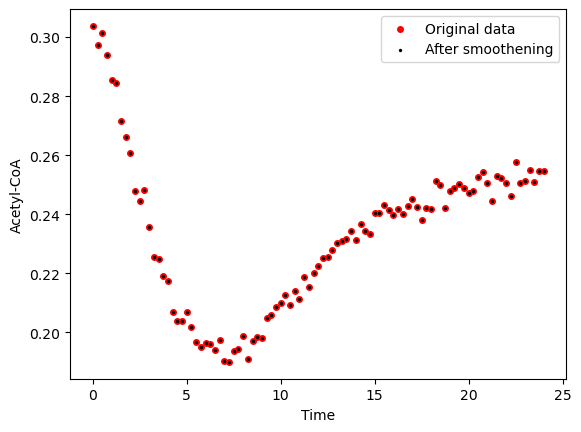

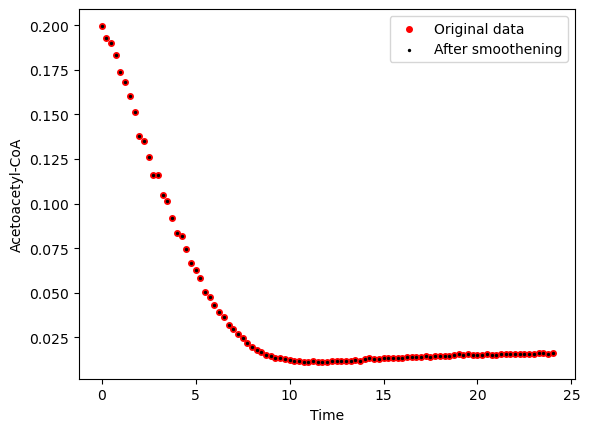

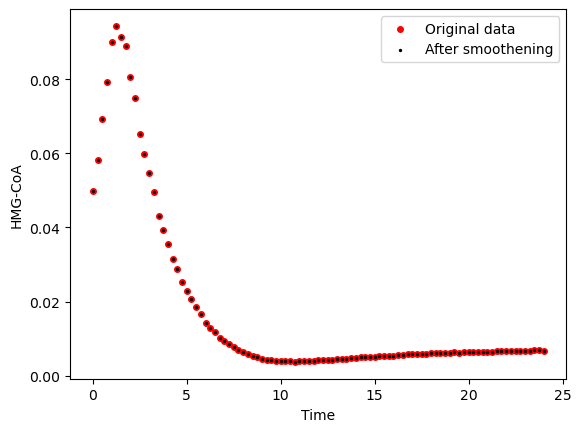

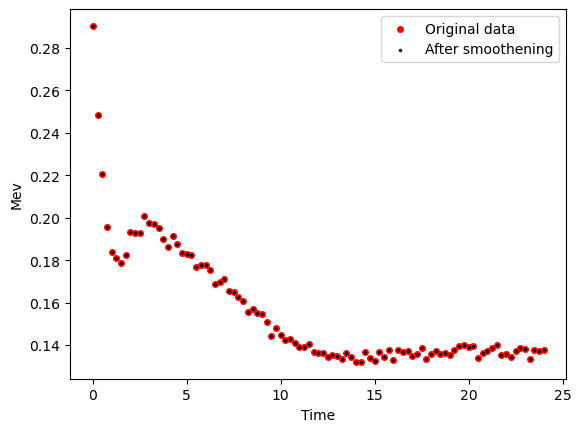

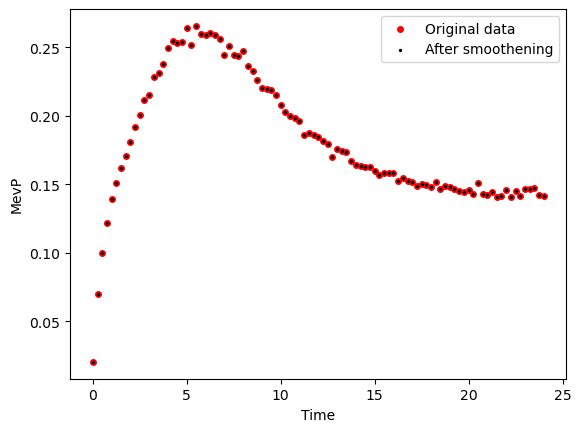

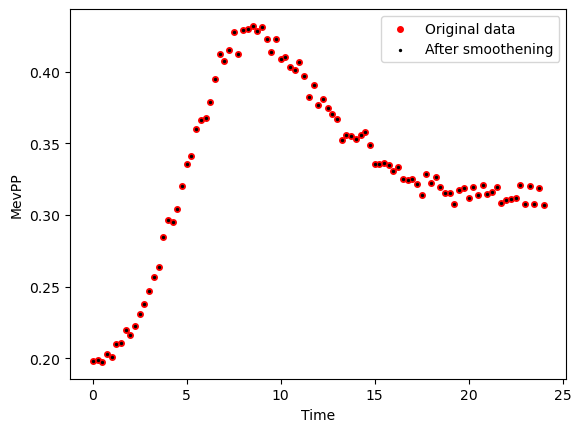

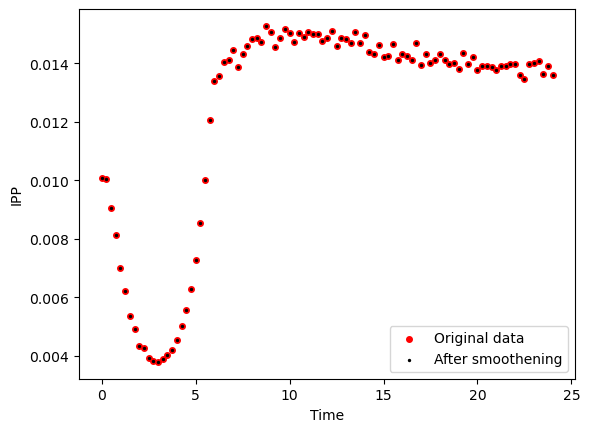

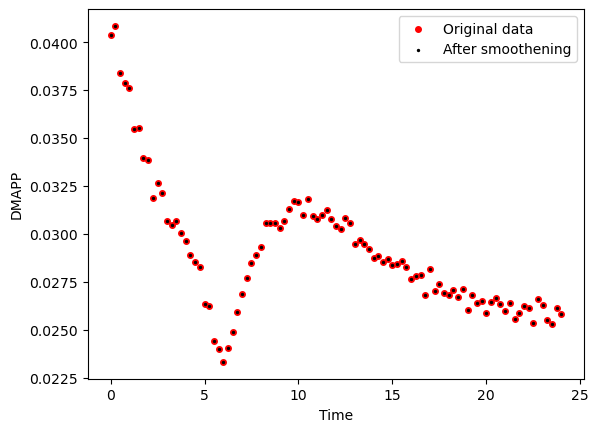

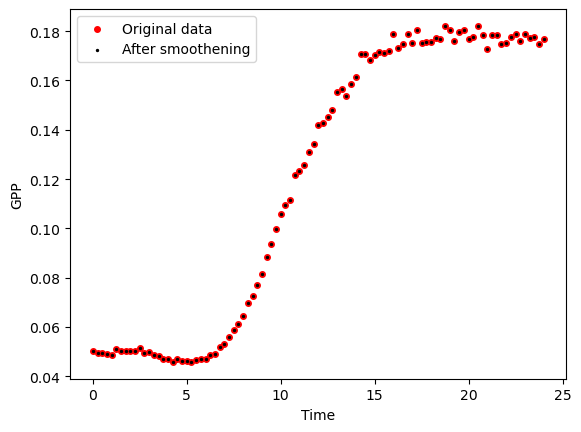

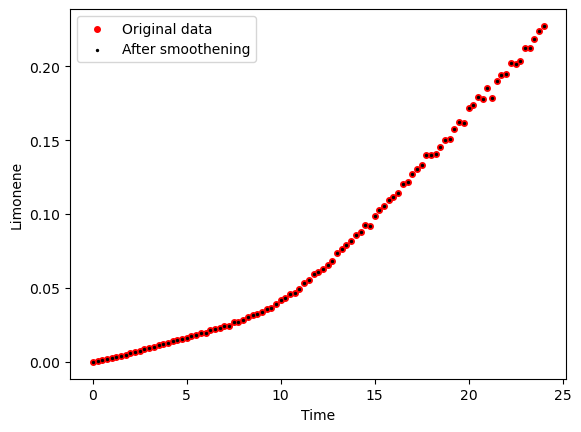

Strain Strain 2


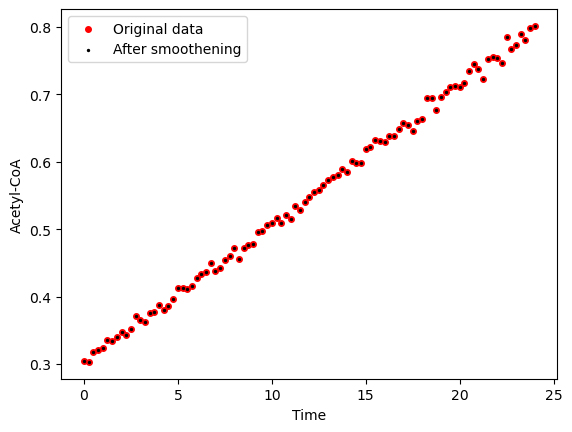

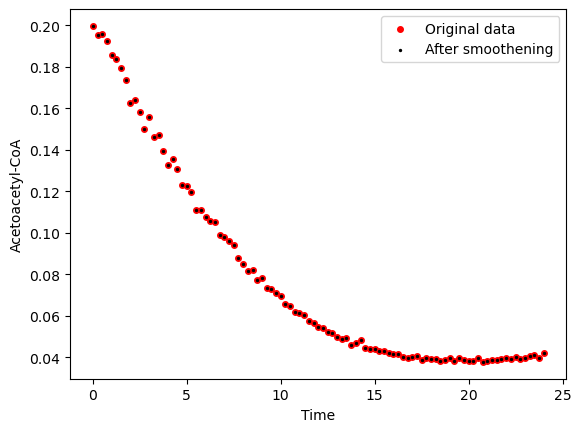

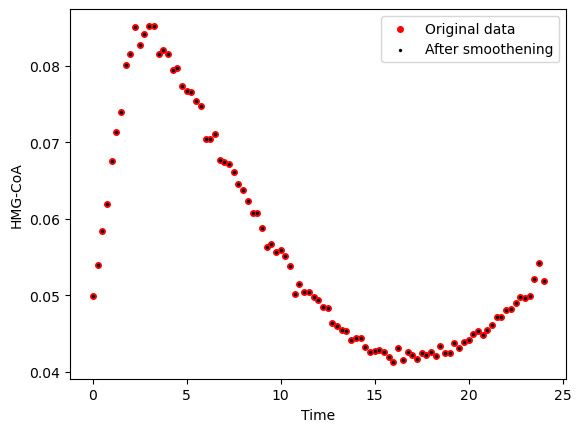

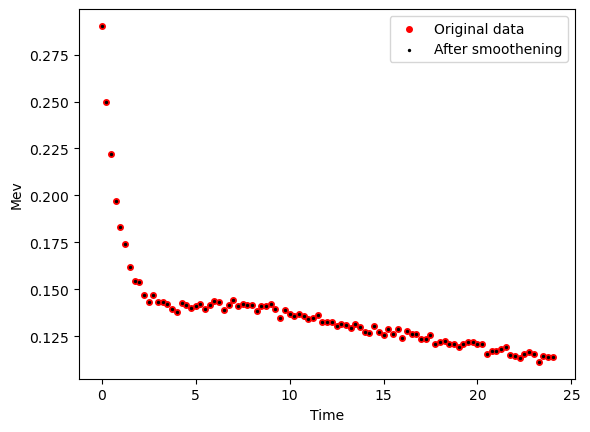

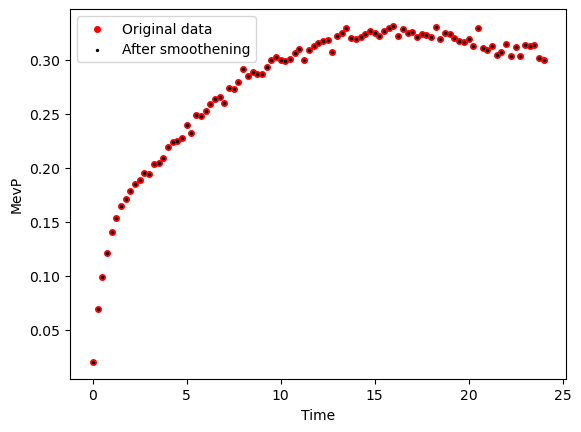

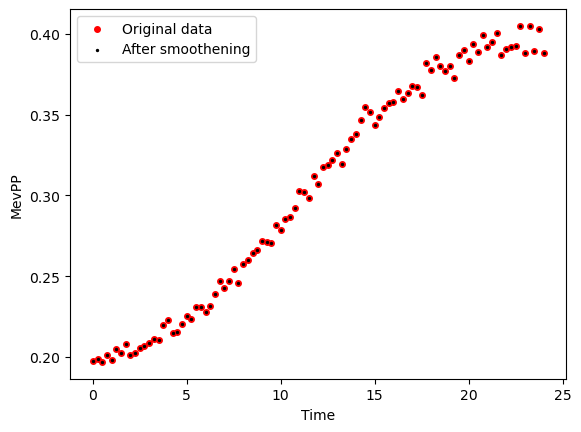

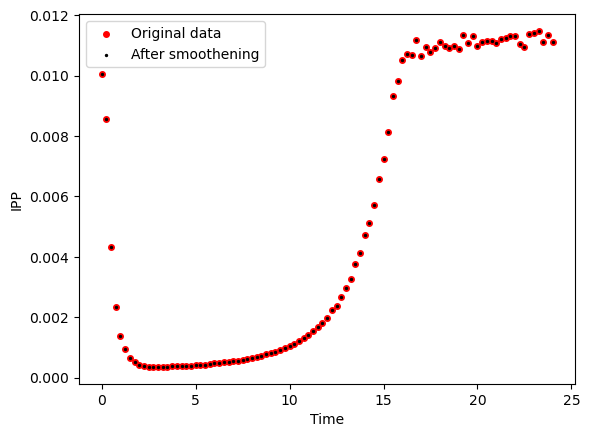

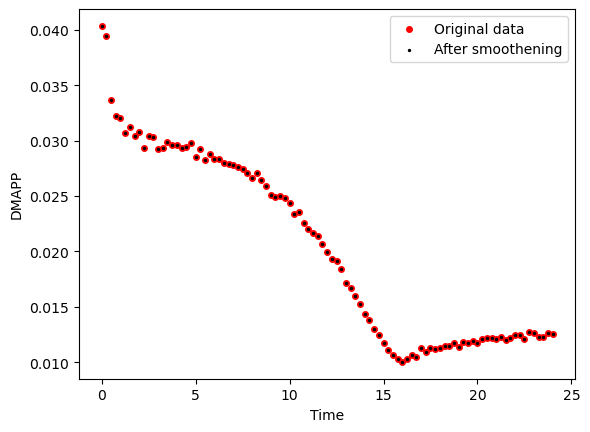

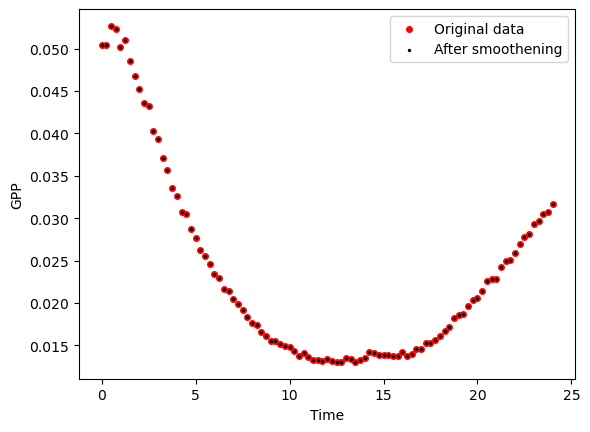

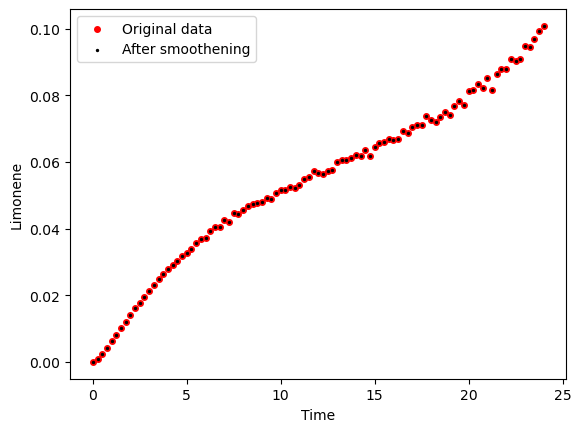

Strain Strain 3


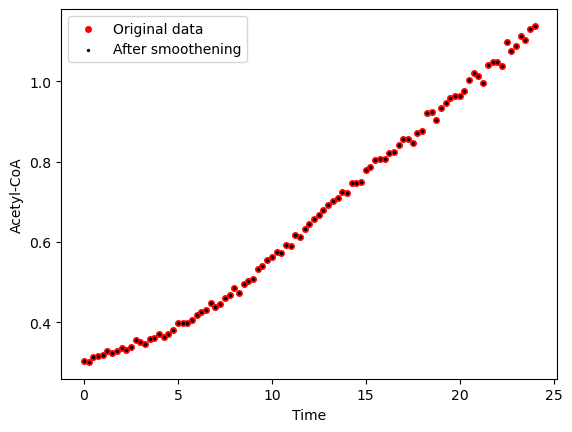

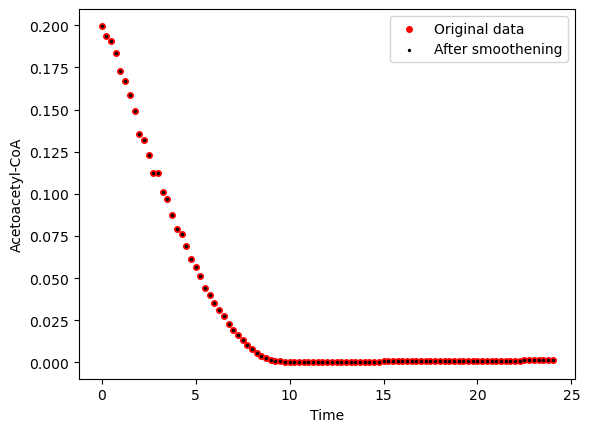

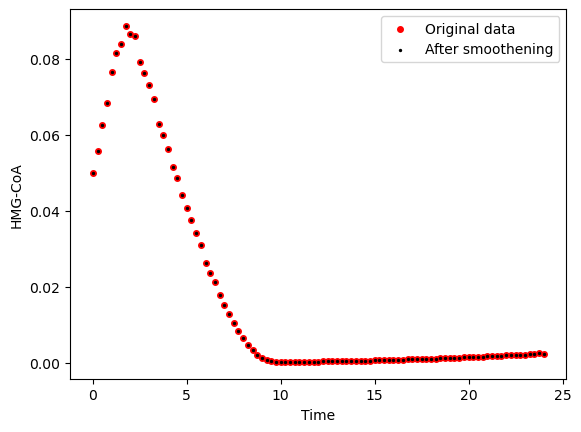

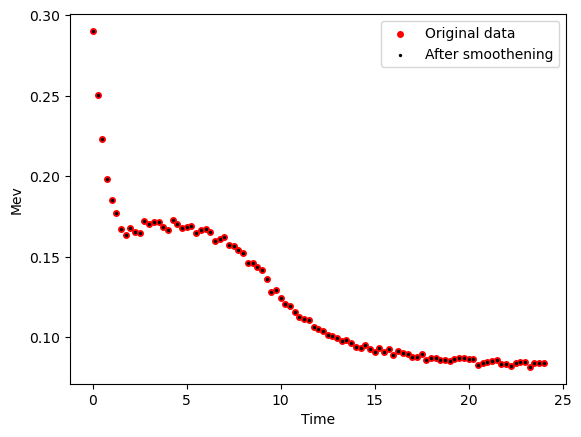

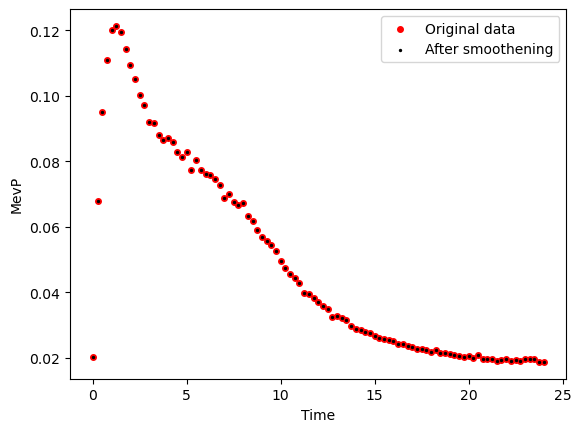

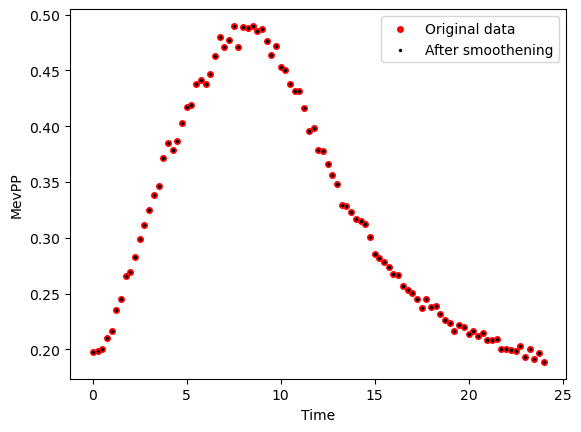

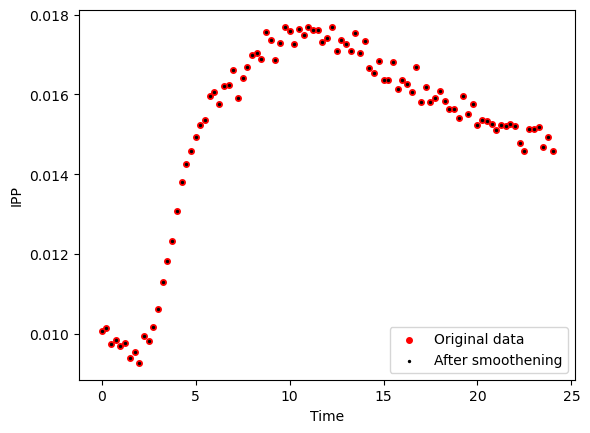

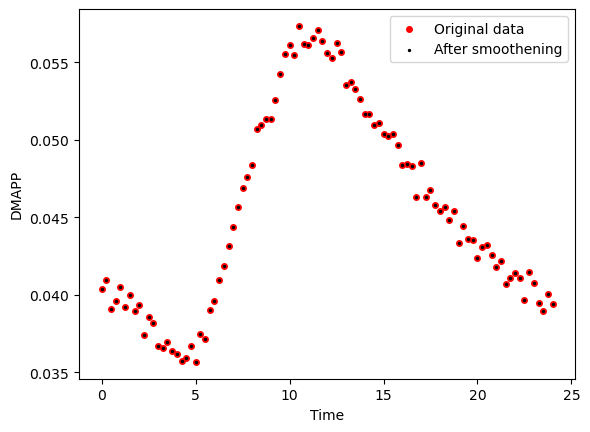

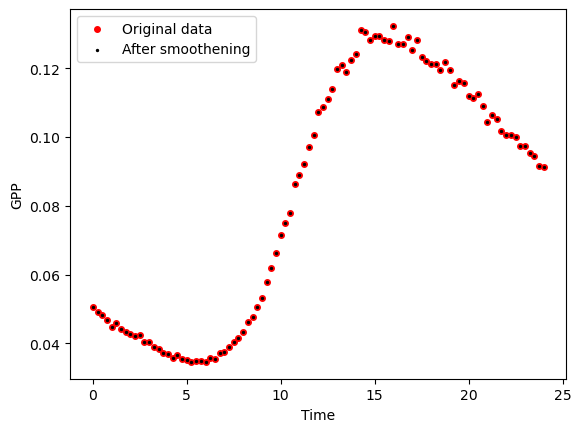

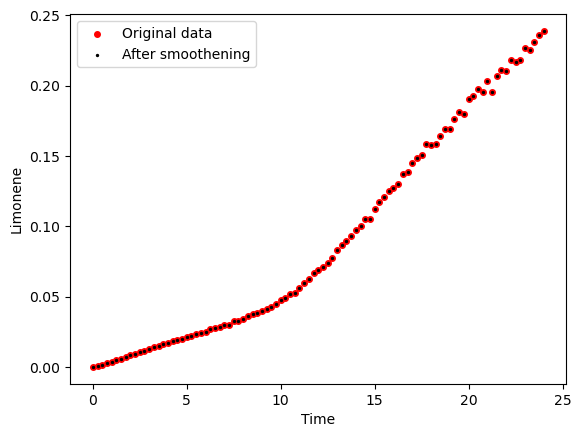

Strain WT


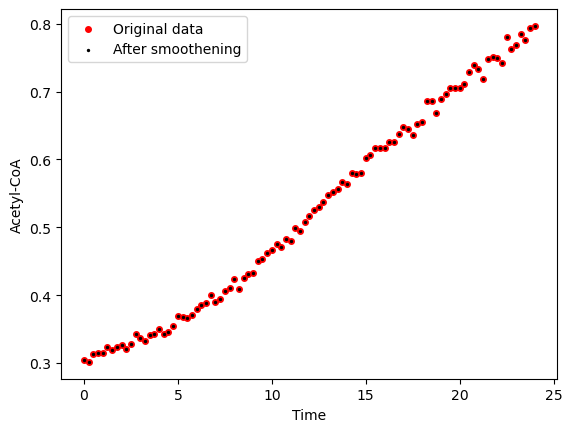

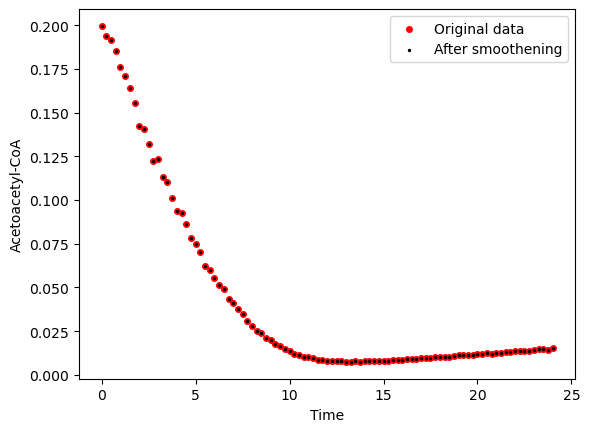

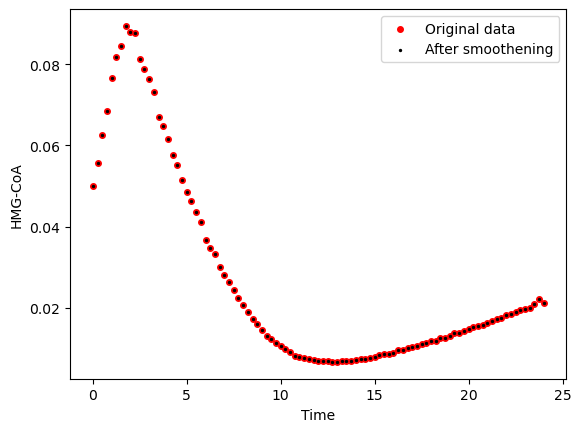

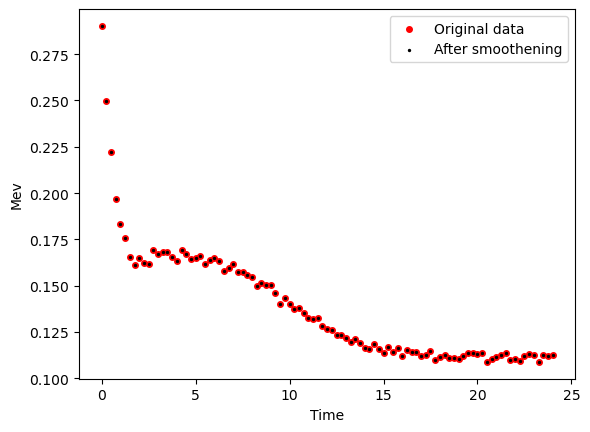

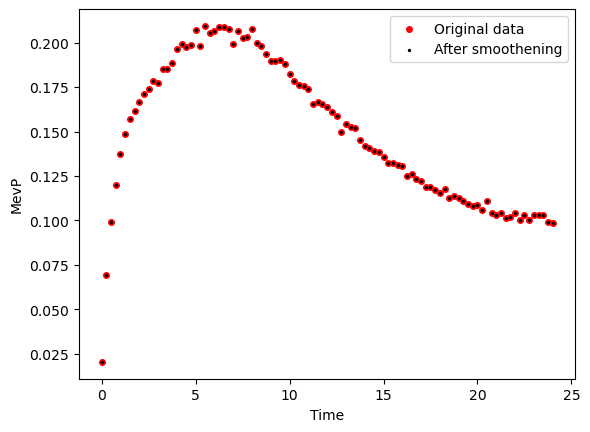

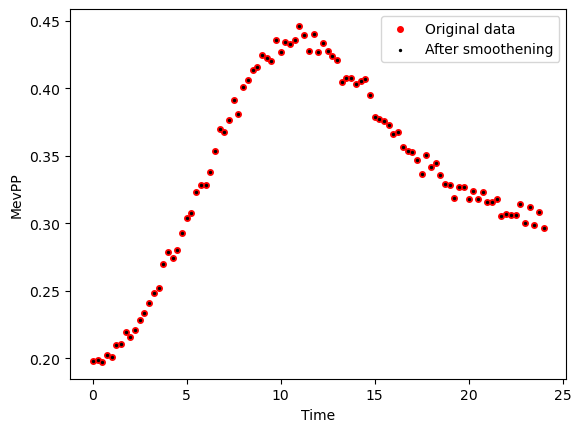

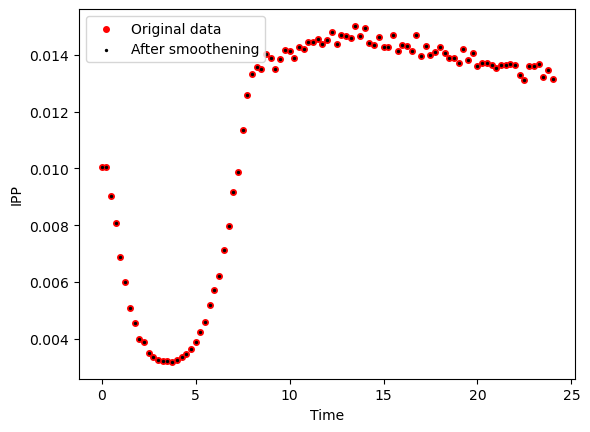

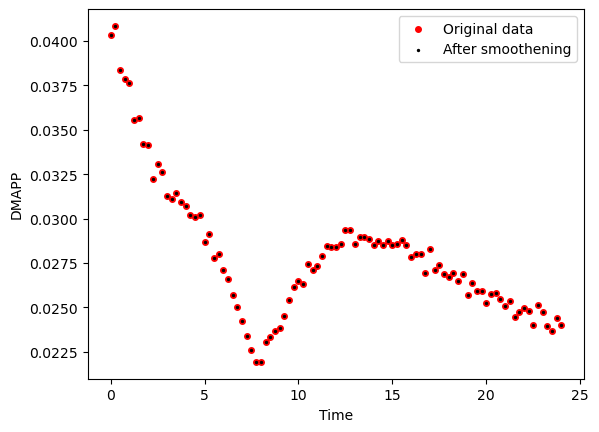

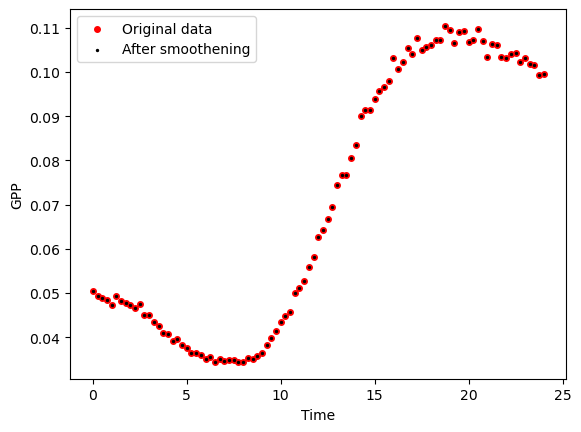

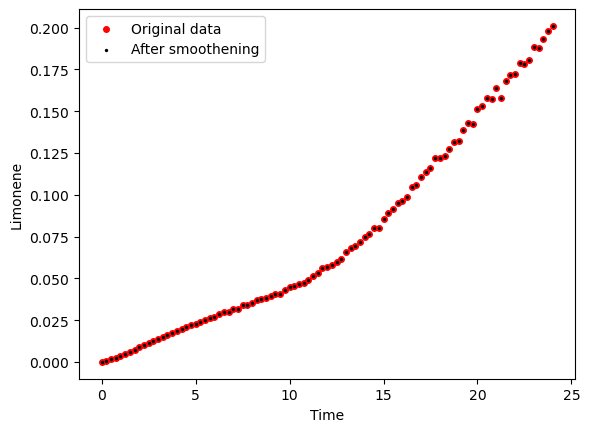

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


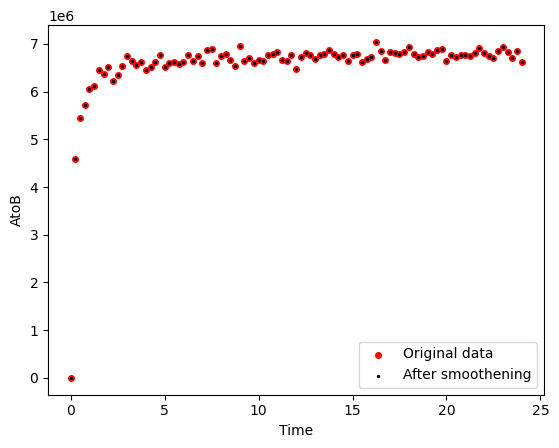

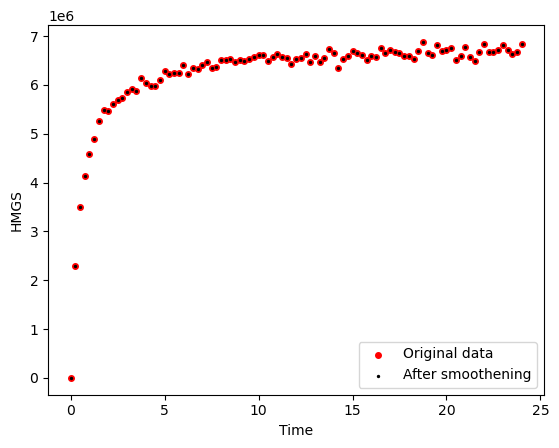

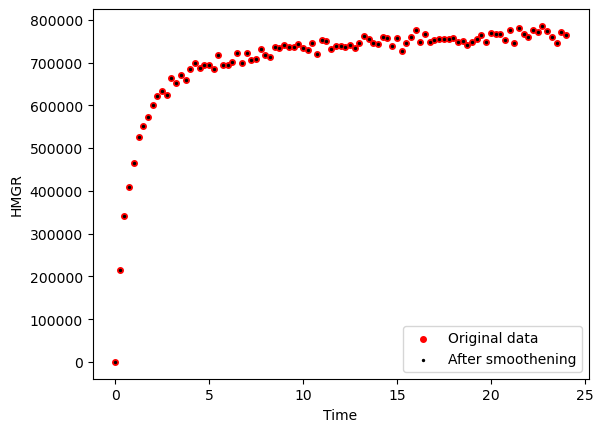

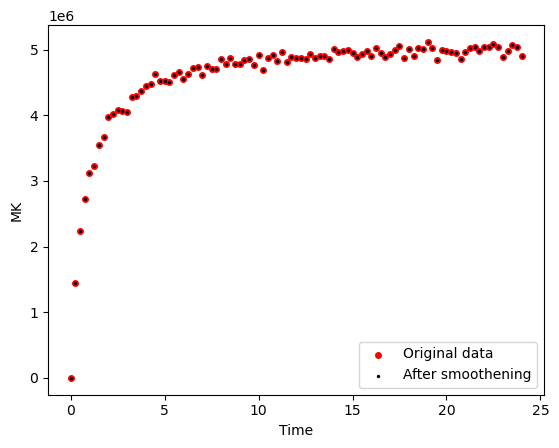

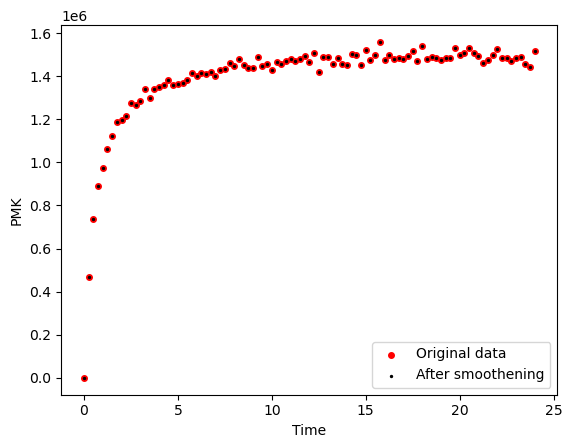

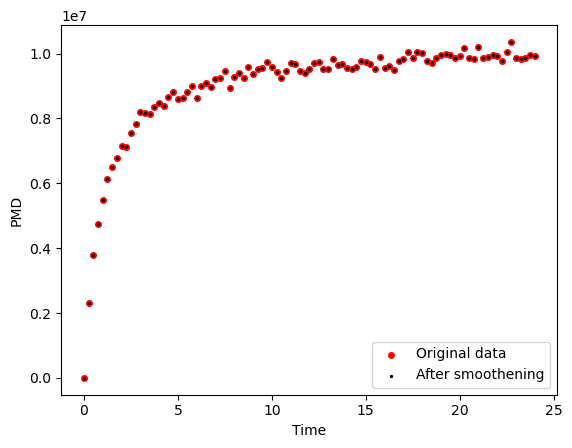

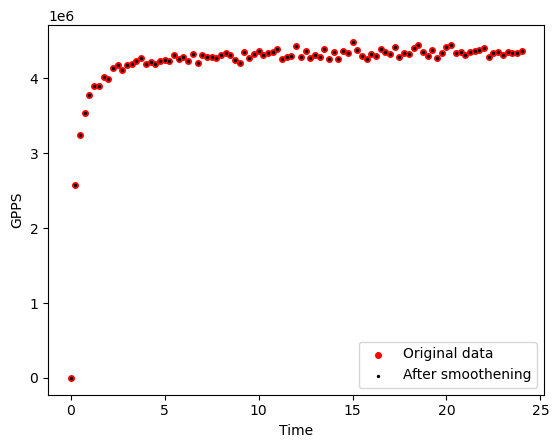

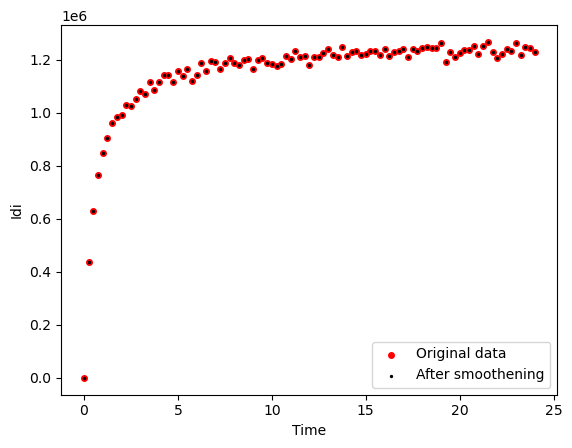

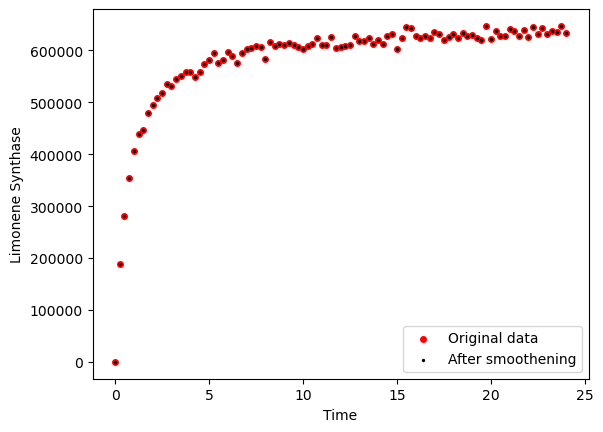

Strain Strain 2


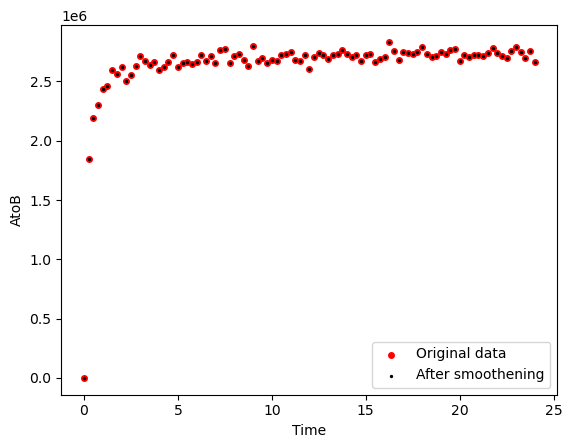

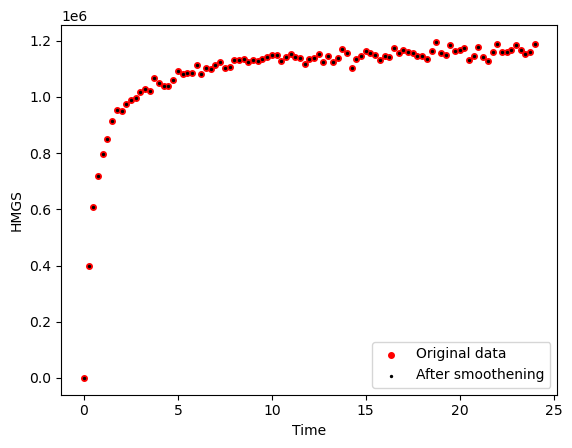

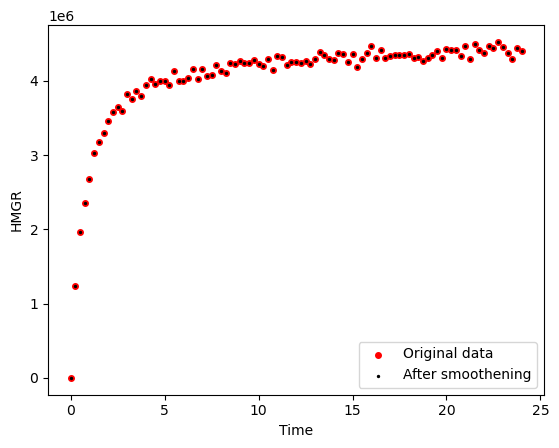

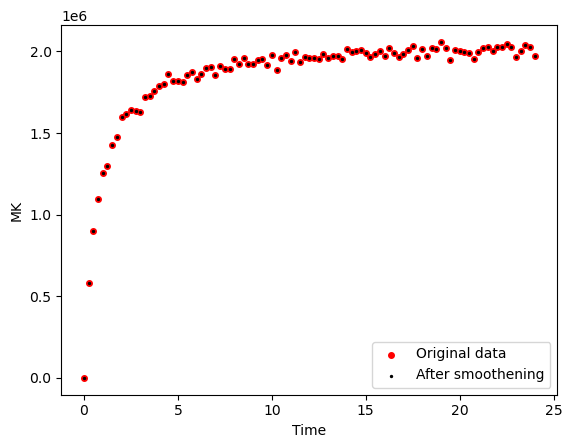

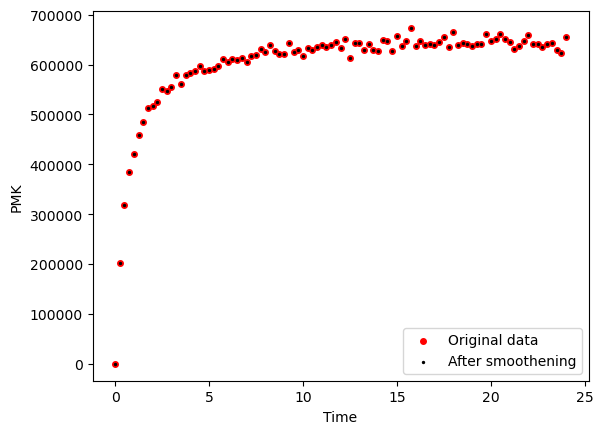

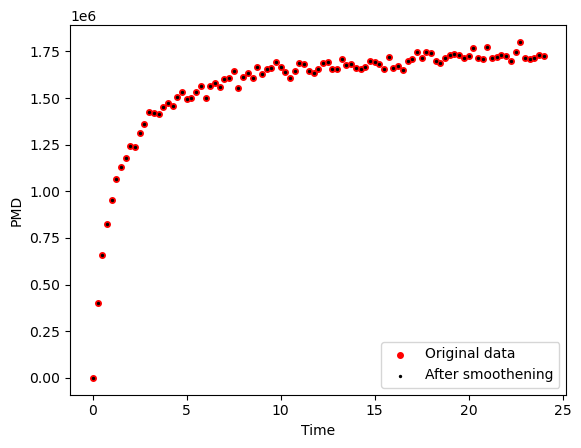

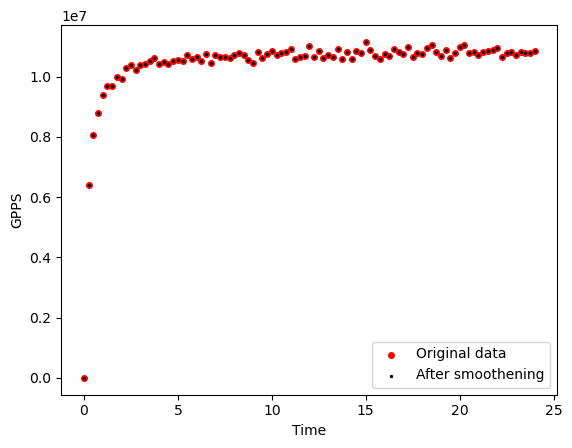

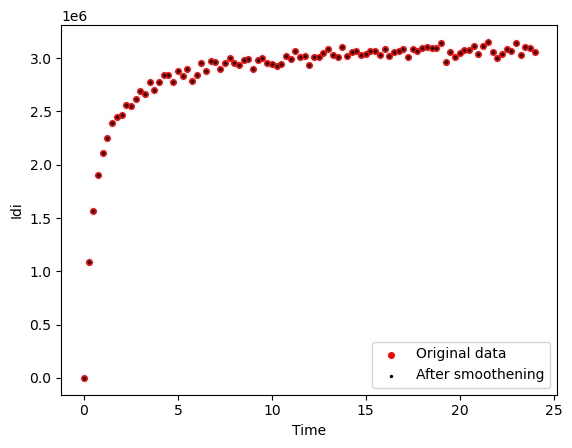

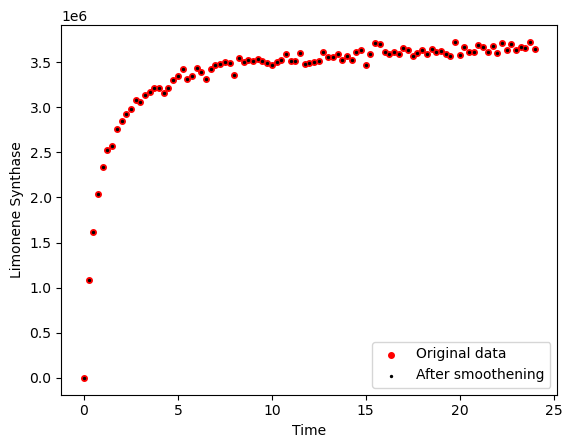

Strain Strain 3


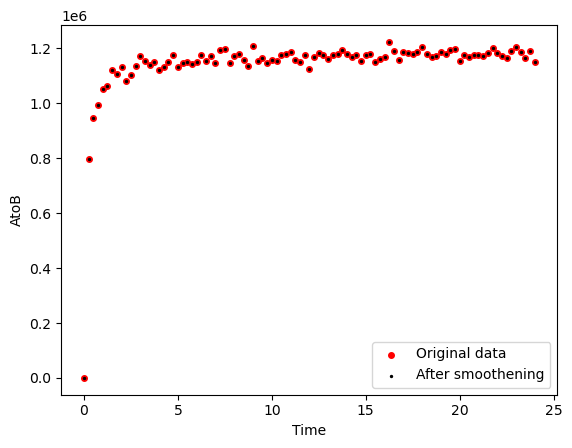

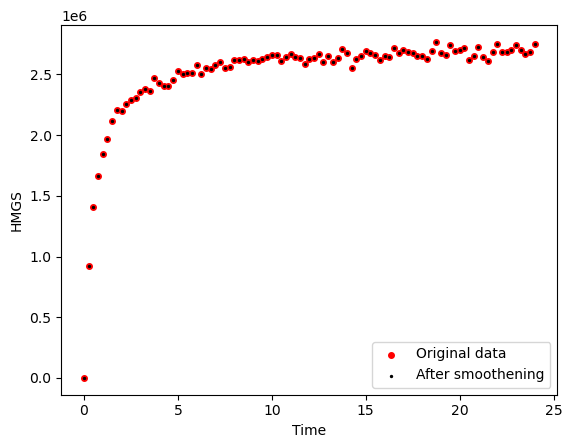

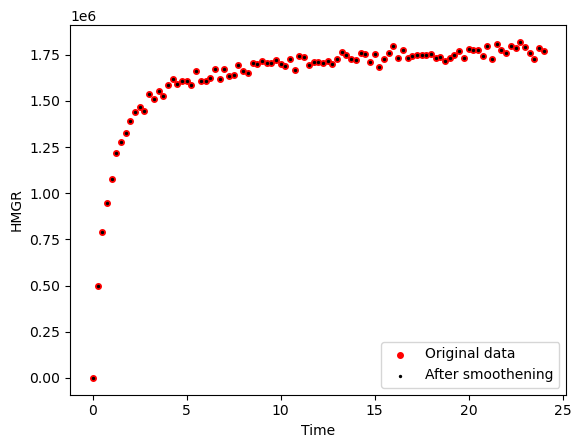

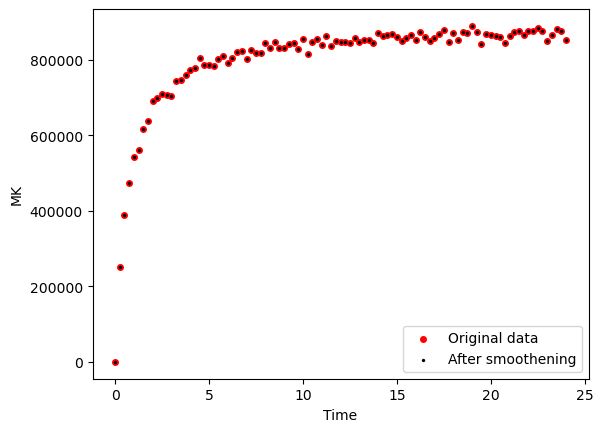

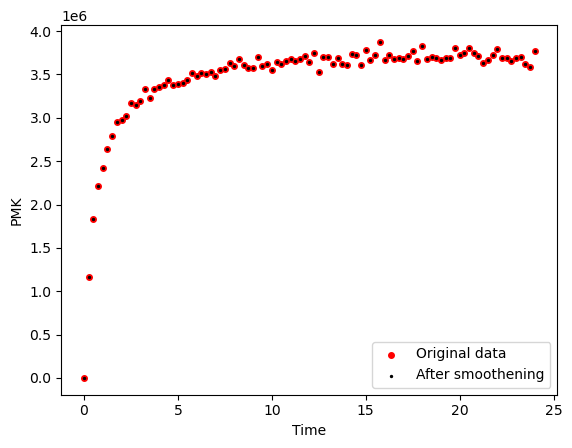

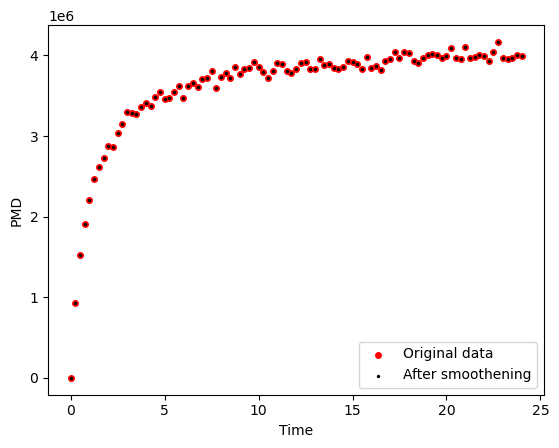

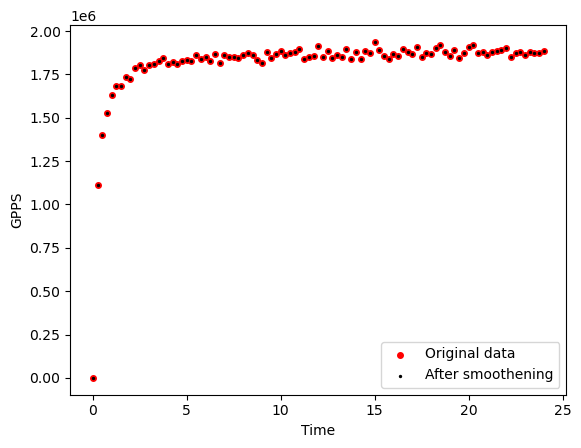

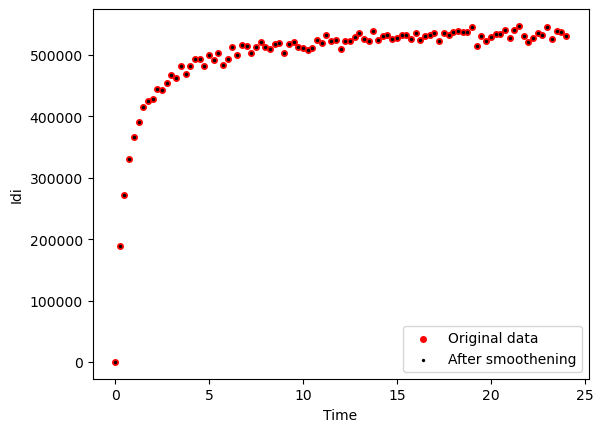

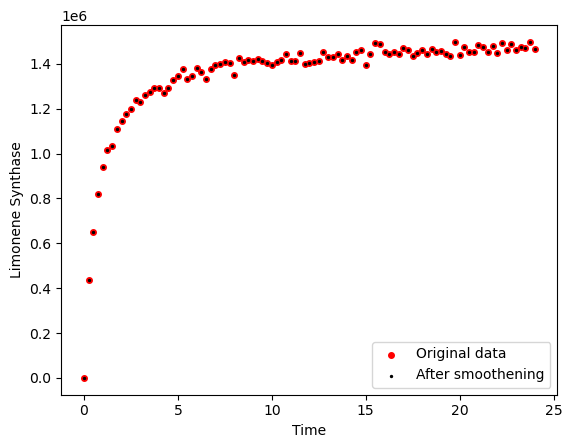

Strain WT


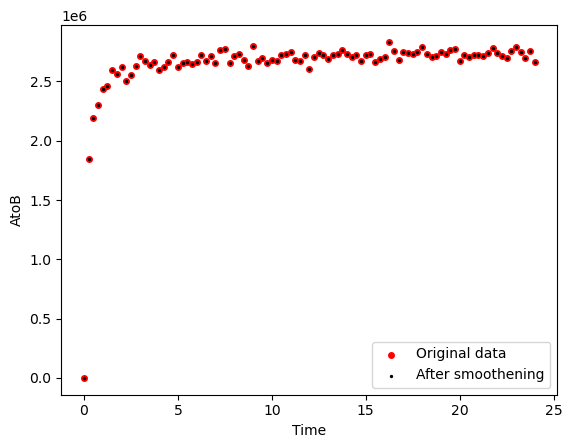

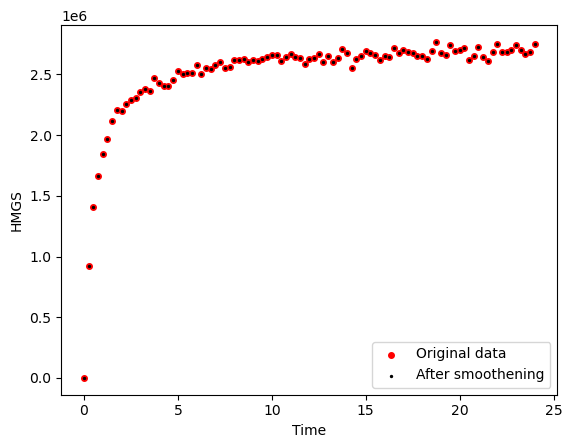

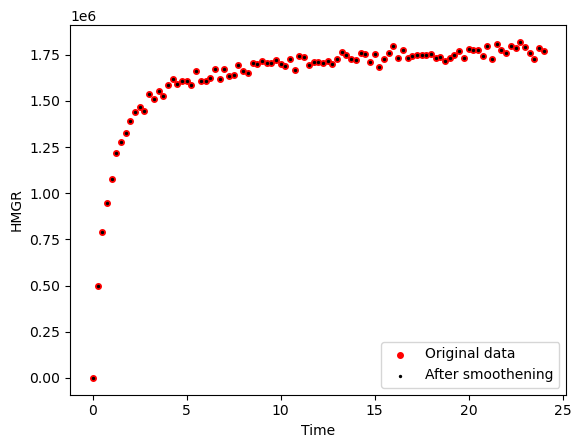

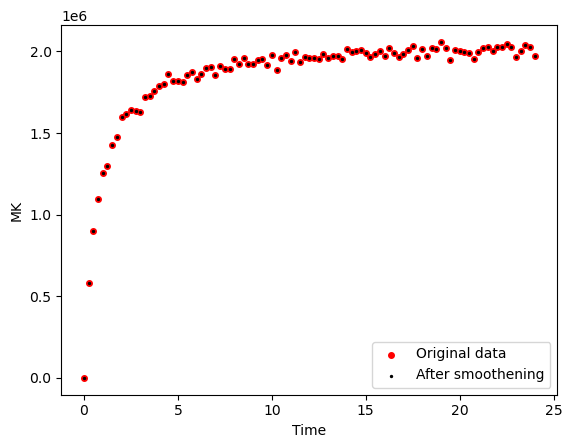

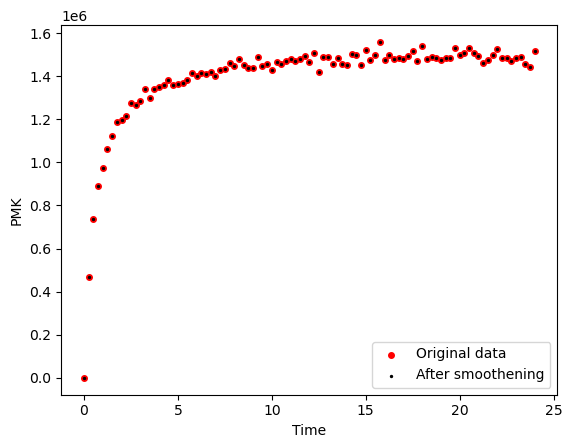

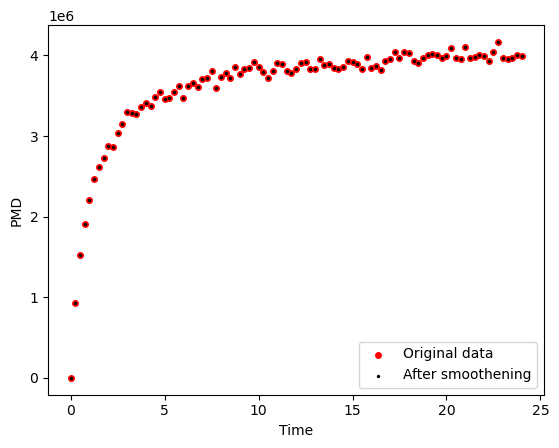

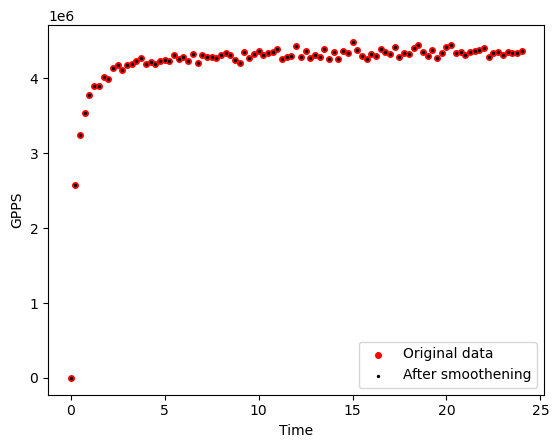

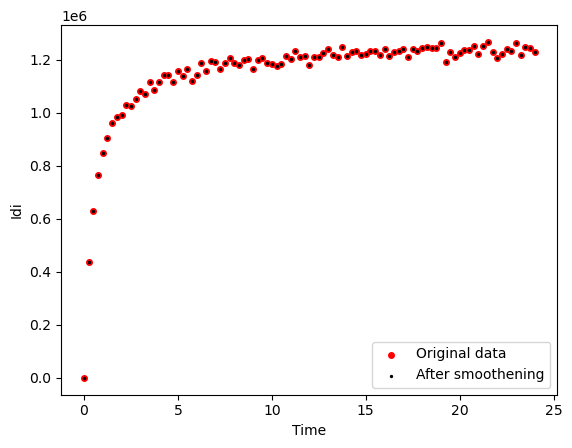

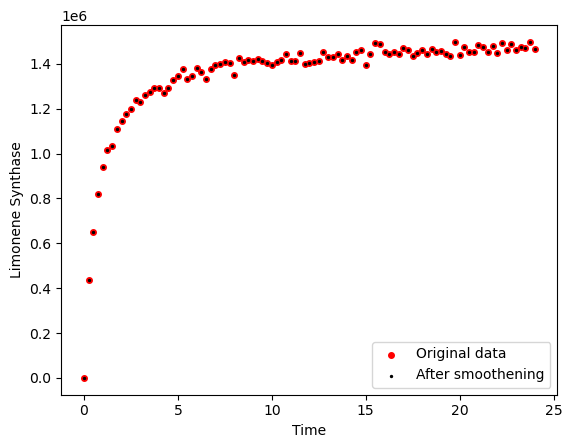

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative52

df_allSmooth=estimate_state_derivative52(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.303775        0.199644  0.049881  0.290244  0.020348   
         0.25    0.297332        0.192987  0.058274  0.248439  0.070213   
         0.50    0.301426        0.190143  0.069352  0.220738  0.100173   
         0.75    0.293944        0.183535  0.079207  0.195724  0.121619   
         1.00    0.285485        0.173787  0.090185  0.184059  0.139288   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.769224        0.014075  0.019669  0.112578  0.103296   
         23.25   0.785095        0.014489  0.019931  0.108903  0.102898   
         23.50   0.776450        0.014718  0.021030  0.112413  0.103132   
         23.75   0.793054        0.014361  0.022105  0.112245  0.099320   
         24.00   0.796784        0.015254  0.021279  0.112532  0.098608   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.197797  0.010068  0.040352  0.050455  0.000000  ...   
         0.25   0.198518  0.010056  0.040849  0.049528  0.000381  ...   
         0.50   0.197364  0.009050  0.038381  0.049360  0.000962  ...   
         0.75   0.202837  0.008137  0.037858  0.049269  0.001704  ...   
         1.00   0.200781  0.007005  0.037615  0.048540  0.002470  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.300182  0.013600  0.024718  0.103254  0.188130  ...   
         23.25  0.311743  0.013662  0.023956  0.101739  0.187894  ...   
         23.50  0.298873  0.013209  0.023681  0.101541  0.193228  ...   
         23.75  0.308564  0.013453  0.024392  0.099273  0.197959  ...   
         24.00  0.296592  0.013155  0.024012  0.099637  0.200995  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

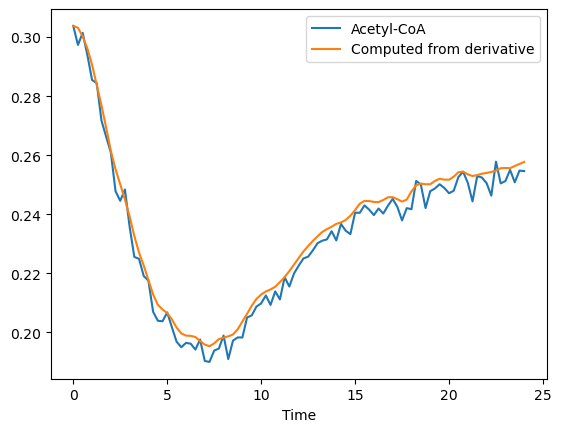

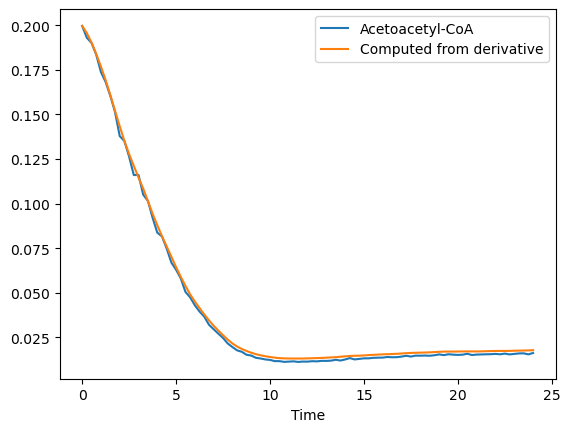

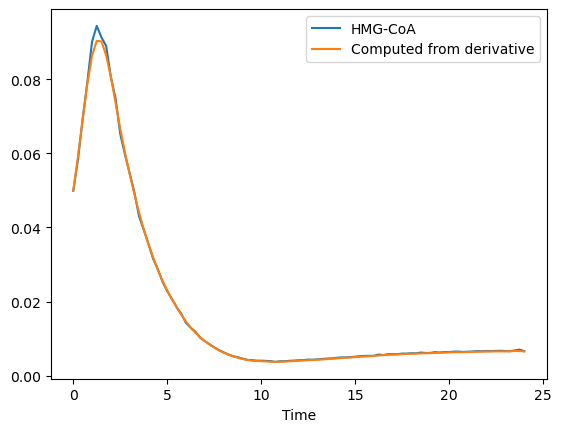

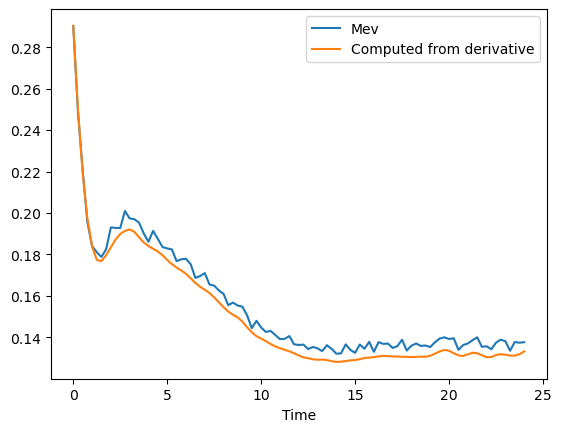

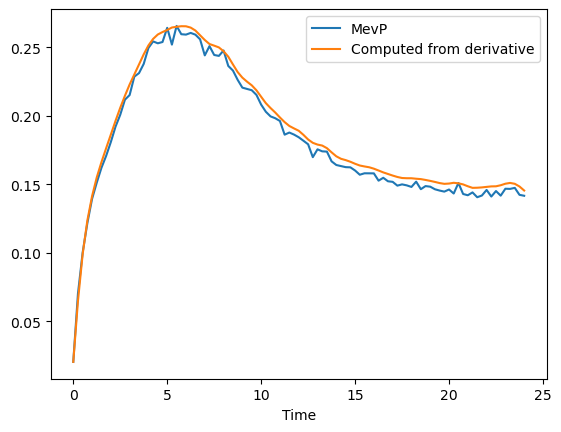

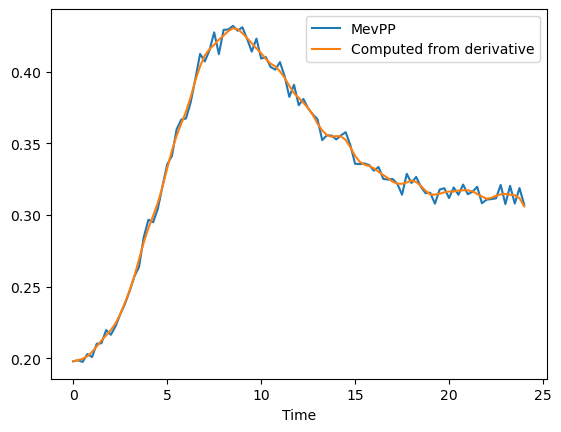

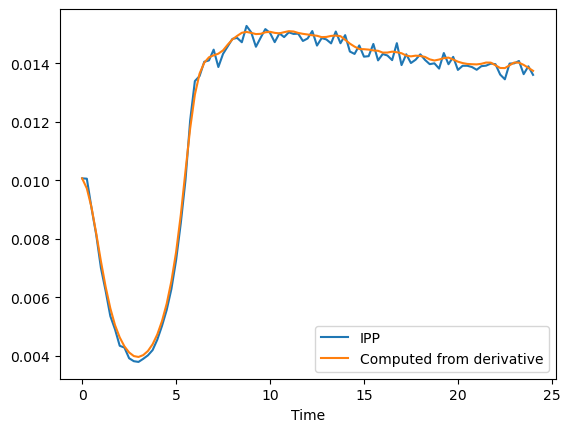

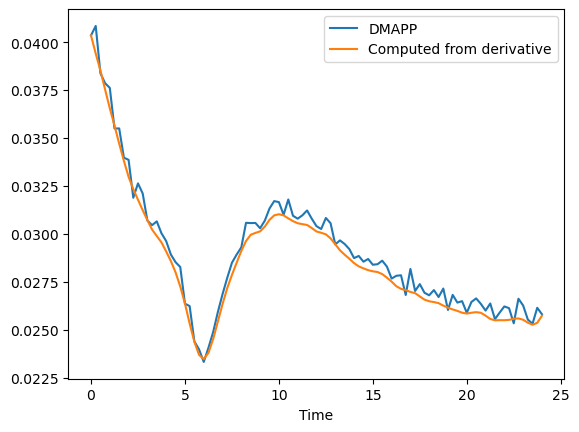

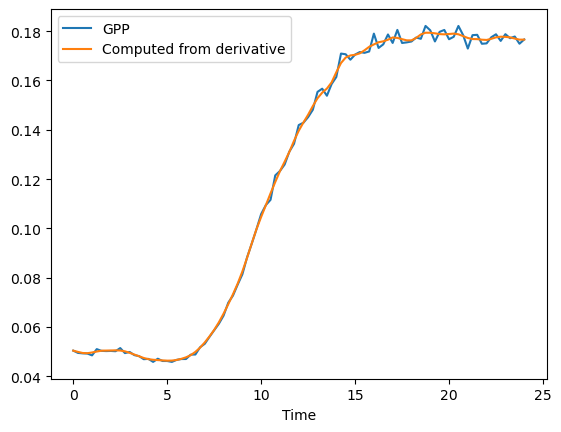

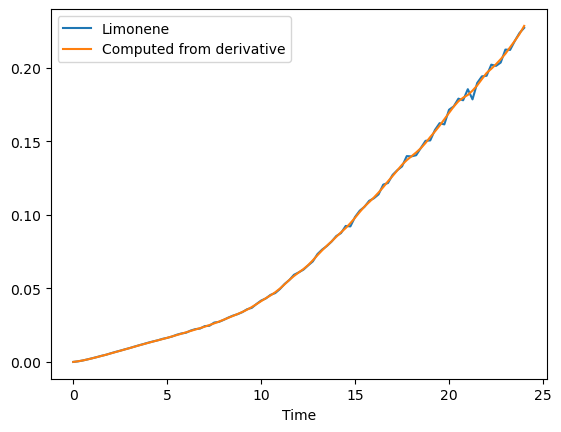

'Time profile from derivative vs. actual profile for Strain 2'

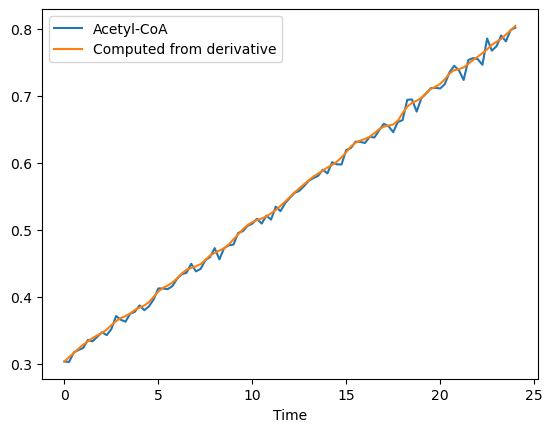

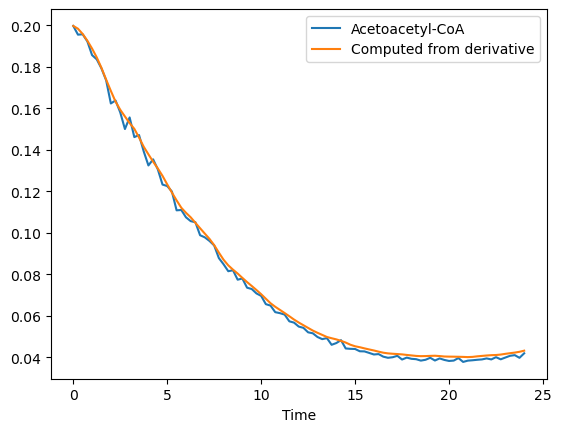

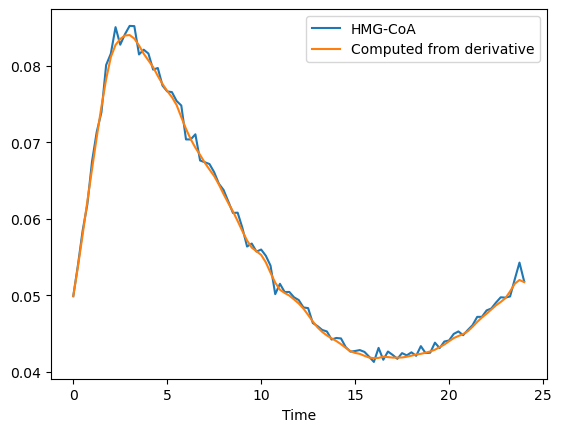

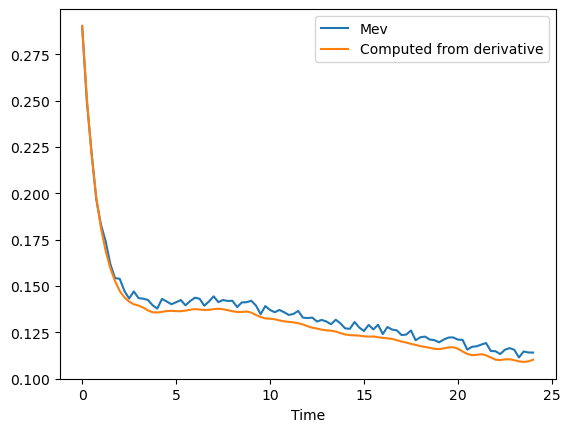

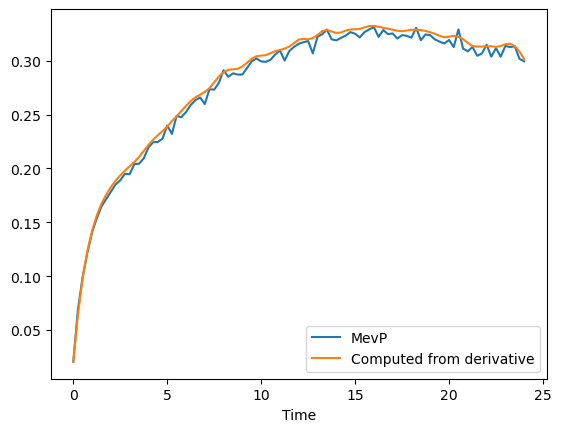

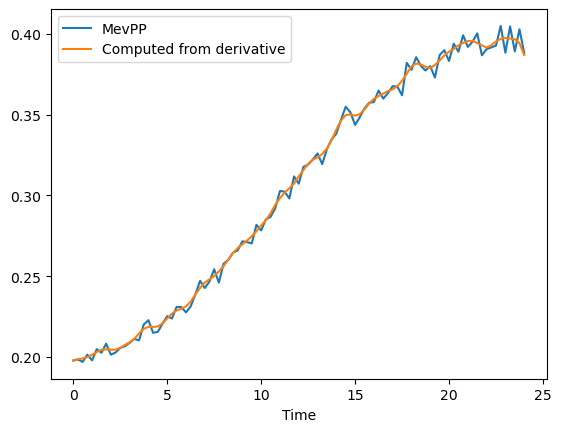

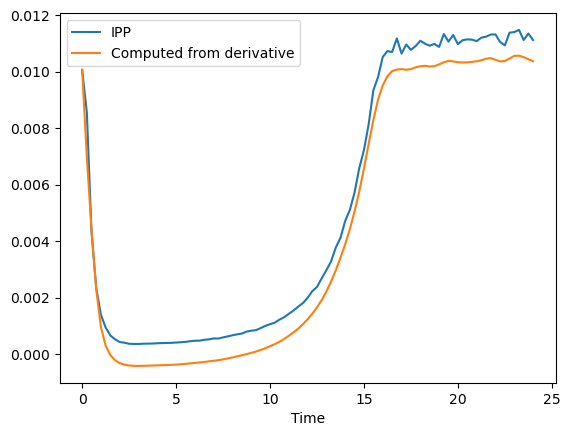

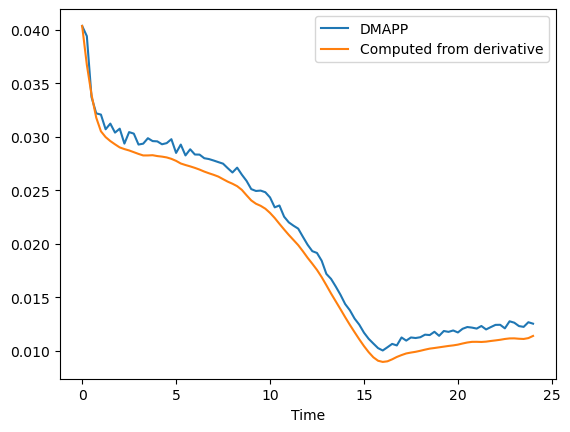

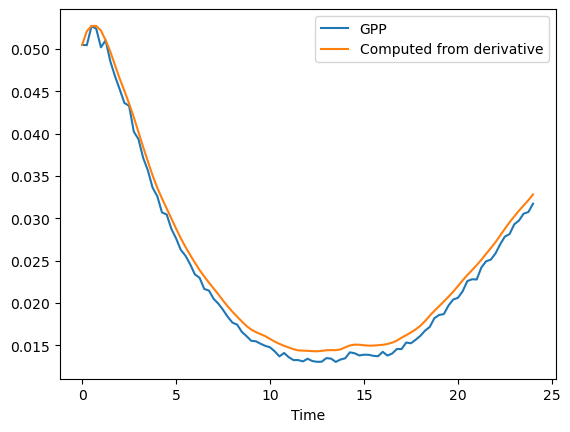

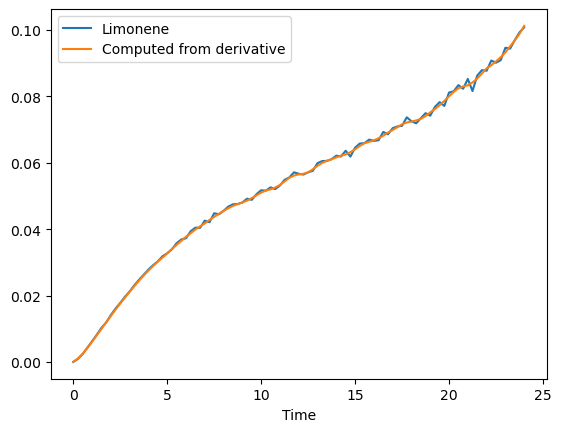

'Time profile from derivative vs. actual profile for Strain 3'

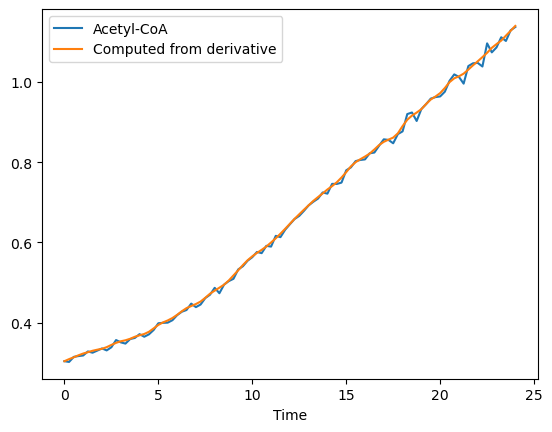

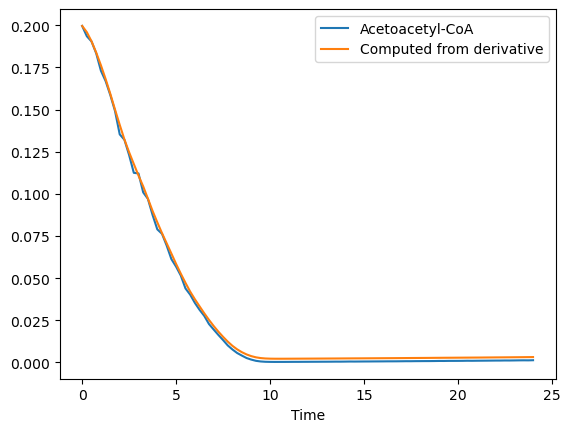

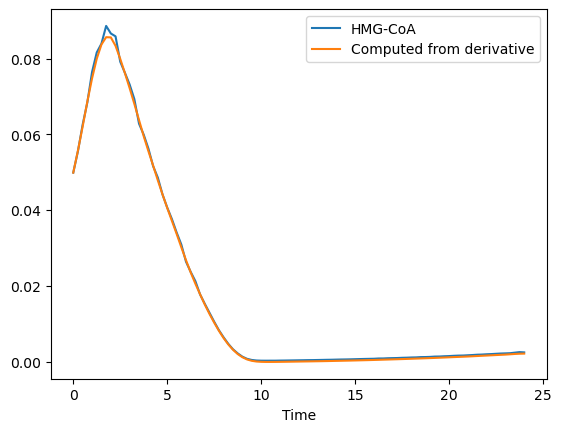

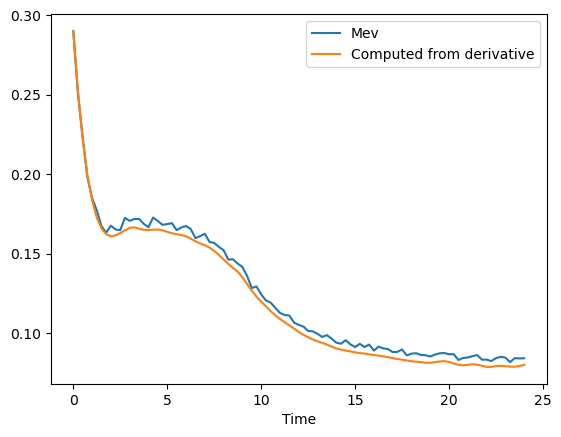

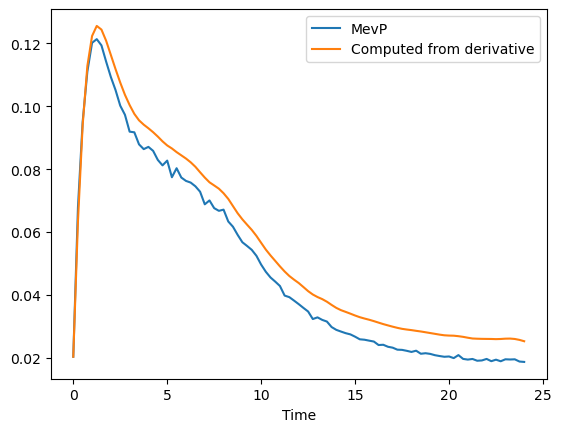

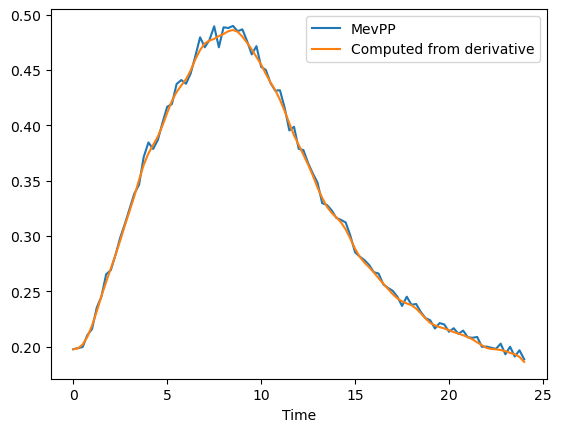

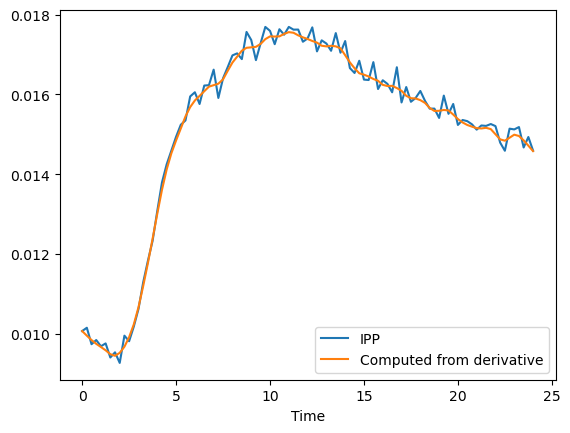

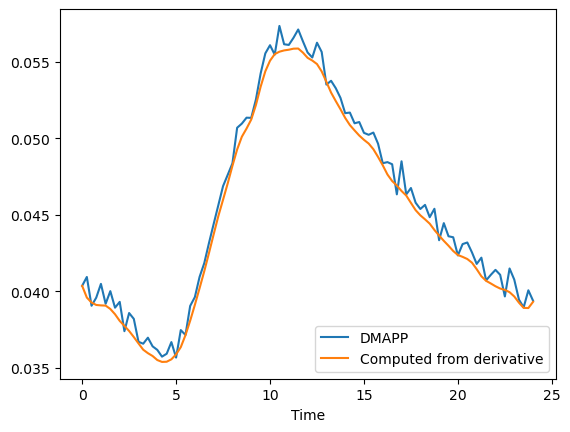

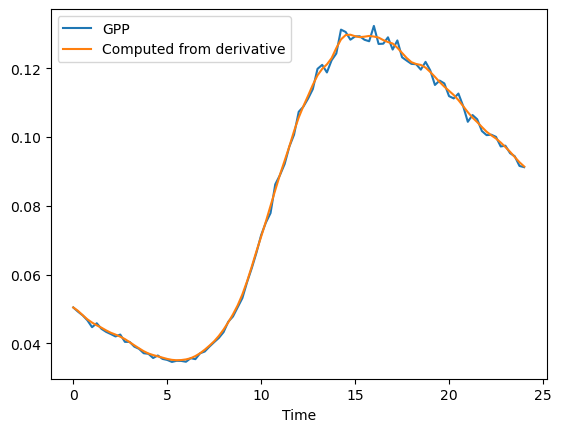

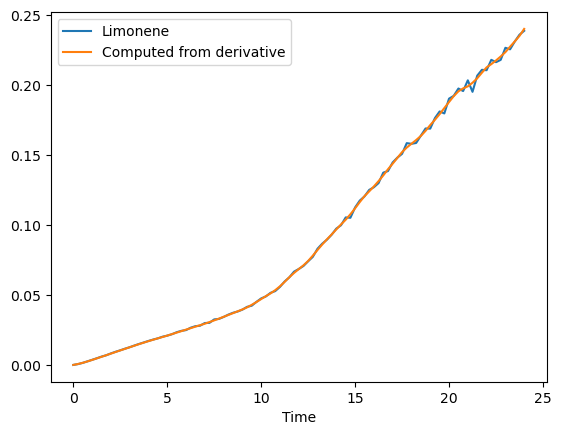

'Time profile from derivative vs. actual profile for WT'

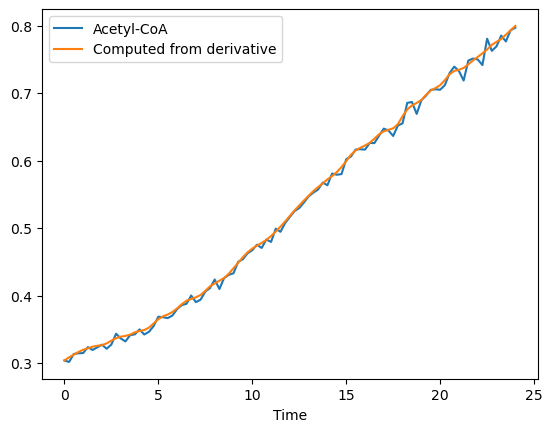

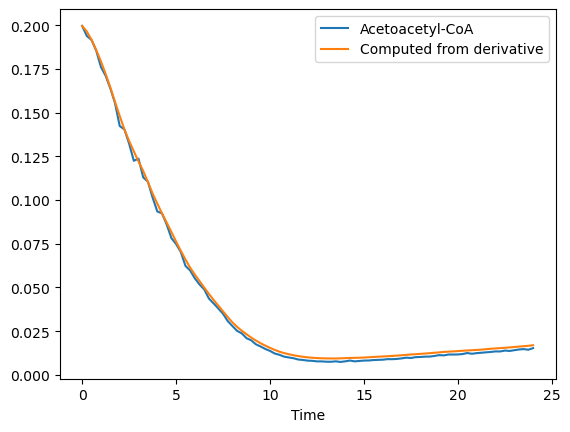

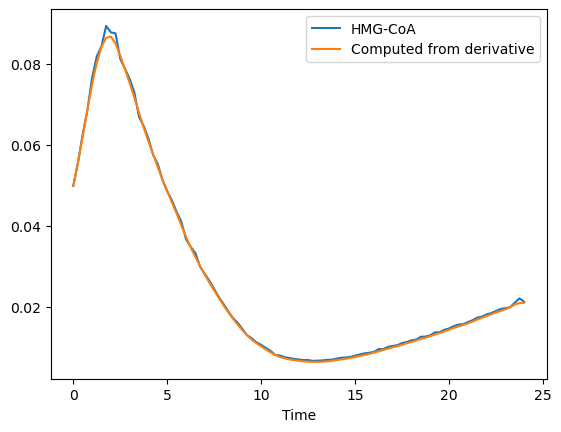

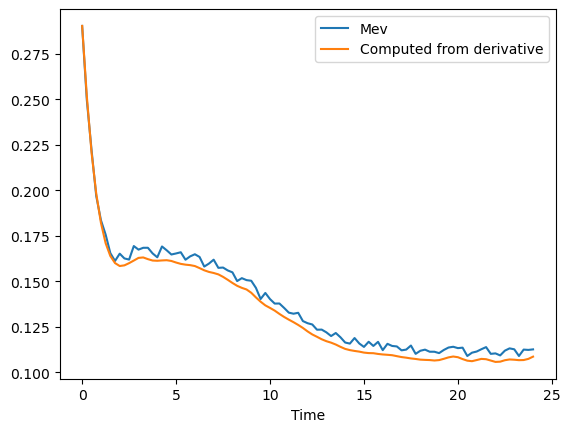

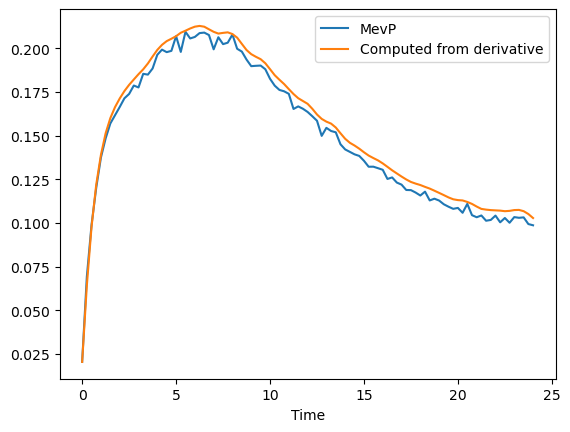

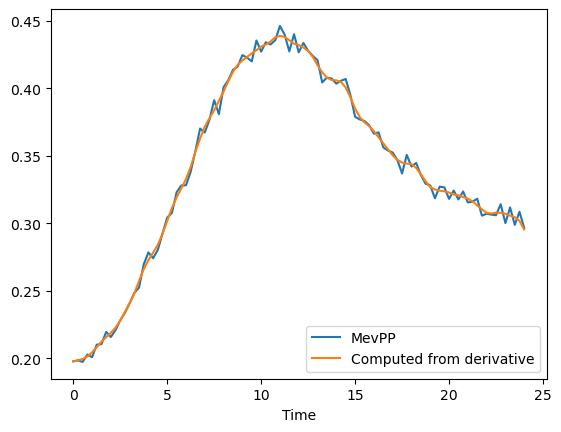

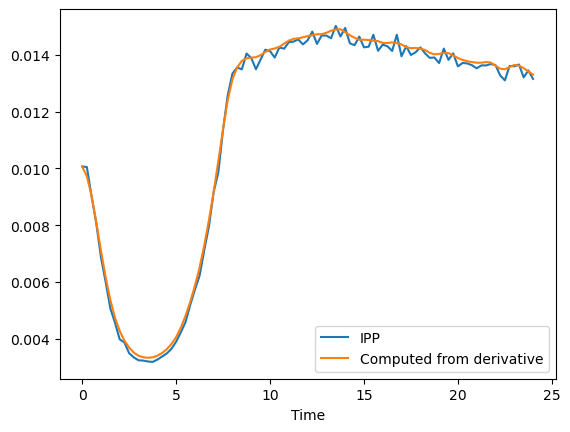

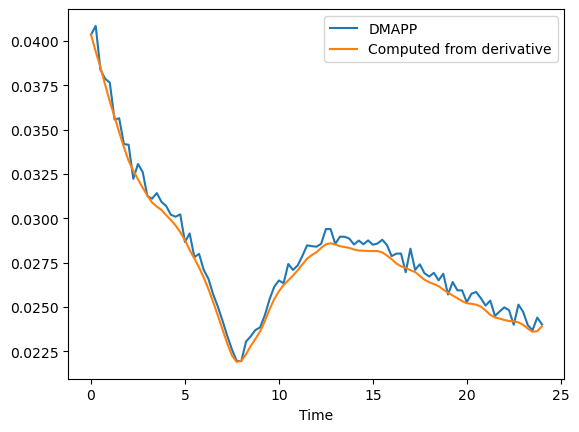

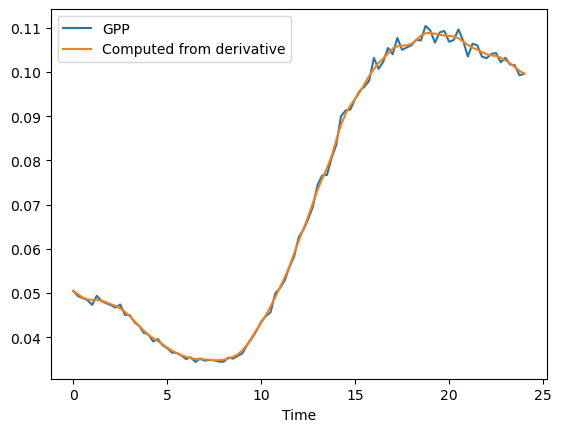

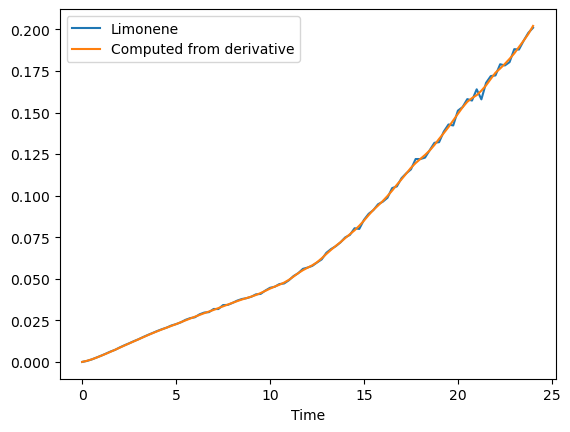

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   6.021797e+01  3.965937e+01  3.688062e+01  5.574897e+01   
         0.25   4.597010e+06  2.294929e+06  2.142199e+05  1.441146e+06   
         0.50   5.451159e+06  3.497433e+06  3.411840e+05  2.236004e+06   
         0.75   5.726004e+06  4.126494e+06  4.088181e+05  2.730130e+06   
         1.00   6.057275e+06  4.578212e+06  4.650788e+05  3.116428e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.793791e+06  2.738508e+06  1.790636e+06  1.966353e+06   
         23.25  2.746174e+06  2.697411e+06  1.756996e+06  2.003719e+06   
         23.50  2.698579e+06  2.671747e+06  1.725002e+06  2.042148e+06   
         23.75  2.757368e+06  2.681689e+06  1.787784e+06  2.026437e+06   
         24.00  2.666181e+06  2.746572e+06  1.769606e+06  1.972738e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.706286e+01  5.388111e+01  5.585060e+01  1.885230e+01   
         0.25   4.699780e+05  2.319278e+06  2.580479e+06  4.355049e+05   
         0.50   7.381283e+05  3.792402e+06  3.246965e+06  6.298491e+05   
         0.75   8.892703e+05  4.747093e+06  3.533031e+06  7.660397e+05   
         1.00   9.754842e+05  5.500615e+06  3.769851e+06  8.493837e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.482486e+06  3.965407e+06  4.311209e+06  1.264628e+06   
         23.25  1.489485e+06  3.960609e+06  4.348569e+06  1.216766e+06   
         23.50  1.458418e+06  3.966576e+06  4.333144e+06  1.247226e+06   
         23.75  1.441278e+06  4.010404e+06  4.335370e+06  1.245131e+06   
         24.00  1.518104e+06  3.997498e+06  4.359388e+06  1.231153e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.061737e+01   0.303775        0.199644  0.049881   
         0.25       1.880093e+05   0.297332        0.192987  0.058274   
         0.50       2.804316e+05   0.301426        0.190143  0.069352   
         0.75       3.543398e+05   0.293944        0.183535  0.079207   
         1.00       4.066978e+05   0.285485        0.173787  0.090185   
...                          ...        ...             ...       ...   
WT       23.00      1.460242e+06   0.769224        0.014075  0.019669   
         23.25      1.473482e+06   0.785095        0.014489  0.019931   
         23.50      1.469301e+06   0.776450        0.014718  0.021030   
         23.75      1.497003e+06   0.793054        0.014361  0.022105   
         24.00      1.463968e+06   0.796784        0.015254  0.021279   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.290244  0.020348  0.197797  0.010068  0.040352  0.050455   
         0.25   0.248439  0.070213  0.198518  0.010056  0.040849  0.049528   
         0.50   0.220738  0.100173  0.197364  0.009050  0.038381  0.049360   
         0.75   0.195724  0.121619  0.202837  0.008137  0.037858  0.049269   
         1.00   0.184059  0.139288  0.200781  0.007005  0.037615  0.048540   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.112578  0.103296  0.300182  0.013600  0.024718  0.103254   
         23.25  0.108903  0.102898  0.311743  0.013662  0.023956  0.101739   
         23.50  0.112413  0.103132  0.298873  0.013209  0.023681 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.001850       -0.013098  0.036106 -0.177997  0.199033   
         0.25    -0.007068       -0.018782  0.038361 -0.142016  0.157374   
         0.50    -0.015987       -0.024466  0.040617 -0.106034  0.115715   
         0.75    -0.016725       -0.026359  0.037226 -0.068562  0.080391   
         1.00    -0.027558       -0.029903  0.023632 -0.039425  0.061280   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.005779        0.001013  0.001810 -0.001209  0.001409   
         23.25    0.027309        0.000829  0.002646 -0.000740 -0.000659   
         23.50    0.025231        0.000892  0.002158  0.001300 -0.005182   
         23.75    0.025783        0.001104  0.000900  0.003727 -0.007853   
         24.00    0.026334        0.001315 -0.000357  0.006153 -0.010525   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00   0.002890 -0.000764 -0.003917 -0.002178  0.001443  
         0.25   0.003503 -0.001991 -0.003652 -0.001907  0.001974  
         0.50   0.004115 -0.003218 -0.003386 -0.001636  0.002505  
         0.75   0.010566 -0.003886 -0.004590  0.000907  0.002923  
         1.00   0.013311 -0.003718 -0.003251  0.001521  0.003188  
...                  ...       ...       ...       ...       ...  
WT       23.00 -0.006662  0.000106 -0.000711 -0.002420  0.014961  
         23.25 -0.005010 -0.000281 -0.001001 -0.003048  0.016149  
         23.50 -0.004143 -0.000440 -0.000391 -0.003880  0.014318  
         23.75 -0.018147 -0.000453  0.000609 -0.002916  0.017712  
         24.00 -0.032151 -0.000467  0.001608 -0.001952  0.021107  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=1,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 | 1.822122E+202 | 1.947908E+104
     2 |      128 | 1.816181E+202 |  6.103286E+58
     3 |      192 | 3.007382E+182 |  8.354981E+41
     4 |      256 | 3.007382E+182 |  3.532003E+34
     5 |      320 | 3.007382E+182 |  1.112801E+33
     6 |      384 | 3.007382E+182 |  5.394477E+30
     7 |      448 | 2.047418E+122 |  4.894169E+27
     8 |      512 | 2.047418E+122 |  9.060796E+25
     9 |      576 | 2.047418E+122 |  1.539910E+24
    10 |      640 |  1.104203E+28 |  6.443307E+21
    11 |      704 |  3.092035E+27 |  3.943338E+20
    12 |      768 |  4.947476E+26 |  4.465954E+19
    13 |      832 |  1.078942E+25 |  1.141184E+18
    14 |      896 |  4.816064E+20 |  1.158917E+17
    15 |      960 |  5.278296E+19 |  1.894493E+14
    16 |     1024 |  2.845282E+17 |  7.908288E+11
    17 |     1088 |  5.502509E+15 |  1.841069E+10
    18 |     1152 |  1.982404E+15 |  4.128508E+06
    19 |     1216 |  4.84

   162 |    10368 |  1.809609E+01 |  1.809448E+01
   163 |    10432 |  1.809465E+01 |  1.809238E+01
   164 |    10496 |  1.809138E+01 |  1.808586E+01
   165 |    10560 |  1.808603E+01 |  1.808081E+01
   166 |    10624 |  1.808231E+01 |  1.807885E+01
   167 |    10688 |  1.807770E+01 |  1.807255E+01
   168 |    10752 |  1.807421E+01 |  1.806899E+01
   169 |    10816 |  1.806886E+01 |  1.806325E+01
   170 |    10880 |  1.806506E+01 |  1.806090E+01
   171 |    10944 |  1.806191E+01 |  1.805713E+01
   172 |    11008 |  1.805779E+01 |  1.805183E+01
   173 |    11072 |  1.805214E+01 |  1.804742E+01
   174 |    11136 |  1.804786E+01 |  1.803984E+01
   175 |    11200 |  1.804190E+01 |  1.803646E+01
   176 |    11264 |  1.803780E+01 |  1.803401E+01
   177 |    11328 |  1.803465E+01 |  1.803071E+01
   178 |    11392 |  1.803164E+01 |  1.802852E+01
   179 |    11456 |  1.802882E+01 |  1.802452E+01
   180 |    11520 |  1.802552E+01 |  1.802098E+01
   181 |    11584 |  1.802166E+01 |  1.801805E+01


   326 |    20864 |  1.697951E+01 |  1.696640E+01
   327 |    20928 |  1.696560E+01 |  1.695031E+01
   328 |    20992 |  1.694706E+01 |  1.693043E+01
   329 |    21056 |  1.693055E+01 |  1.691260E+01
   330 |    21120 |  1.691772E+01 |  1.690521E+01
   331 |    21184 |  1.690624E+01 |  1.689224E+01
   332 |    21248 |  1.689333E+01 |  1.688114E+01
   333 |    21312 |  1.688024E+01 |  1.686489E+01
   334 |    21376 |  1.686637E+01 |  1.685210E+01
   335 |    21440 |  1.685498E+01 |  1.684274E+01
   336 |    21504 |  1.684136E+01 |  1.682455E+01
   337 |    21568 |  1.682814E+01 |  1.681025E+01
   338 |    21632 |  1.681447E+01 |  1.679097E+01
   339 |    21696 |  1.679217E+01 |  1.676410E+01
   340 |    21760 |  1.677254E+01 |  1.674929E+01
   341 |    21824 |  1.675359E+01 |  1.673520E+01
   342 |    21888 |  1.674117E+01 |  1.672814E+01
   343 |    21952 |  1.673337E+01 |  1.672033E+01
   344 |    22016 |  1.672320E+01 |  1.670593E+01
   345 |    22080 |  1.670727E+01 |  1.669637E+01


   490 |    31360 |  1.629399E+01 |  1.629261E+01
   491 |    31424 |  1.629259E+01 |  1.629102E+01
   492 |    31488 |  1.629125E+01 |  1.628996E+01
   493 |    31552 |  1.629013E+01 |  1.628912E+01
   494 |    31616 |  1.628926E+01 |  1.628815E+01
   495 |    31680 |  1.628831E+01 |  1.628731E+01
   496 |    31744 |  1.628750E+01 |  1.628671E+01
   497 |    31808 |  1.628669E+01 |  1.628590E+01
   498 |    31872 |  1.628593E+01 |  1.628499E+01
   499 |    31936 |  1.628496E+01 |  1.628402E+01
   500 |    32000 |  1.628432E+01 |  1.628340E+01
   501 |    32064 |  1.628332E+01 |  1.628194E+01
   502 |    32128 |  1.628223E+01 |  1.628122E+01
   503 |    32192 |  1.628112E+01 |  1.627989E+01
   504 |    32256 |  1.627981E+01 |  1.627824E+01
   505 |    32320 |  1.627830E+01 |  1.627683E+01
   506 |    32384 |  1.627697E+01 |  1.627565E+01
   507 |    32448 |  1.627543E+01 |  1.627421E+01
   508 |    32512 |  1.627450E+01 |  1.627305E+01
   509 |    32576 |  1.627298E+01 |  1.627114E+01


   654 |    41856 |  1.589426E+01 |  1.589247E+01
   655 |    41920 |  1.589227E+01 |  1.589043E+01
   656 |    41984 |  1.589082E+01 |  1.588920E+01
   657 |    42048 |  1.588968E+01 |  1.588823E+01
   658 |    42112 |  1.588850E+01 |  1.588725E+01
   659 |    42176 |  1.588746E+01 |  1.588657E+01
   660 |    42240 |  1.588629E+01 |  1.588447E+01
   661 |    42304 |  1.588445E+01 |  1.588286E+01
   662 |    42368 |  1.588314E+01 |  1.588141E+01
   663 |    42432 |  1.588178E+01 |  1.588039E+01
   664 |    42496 |  1.588032E+01 |  1.587874E+01
   665 |    42560 |  1.587892E+01 |  1.587705E+01
   666 |    42624 |  1.587679E+01 |  1.587426E+01
   667 |    42688 |  1.587419E+01 |  1.587061E+01
   668 |    42752 |  1.587159E+01 |  1.586828E+01
   669 |    42816 |  1.586867E+01 |  1.586531E+01
   670 |    42880 |  1.586552E+01 |  1.586193E+01
   671 |    42944 |  1.586200E+01 |  1.585807E+01
   672 |    43008 |  1.585867E+01 |  1.585416E+01
   673 |    43072 |  1.585351E+01 |  1.584876E+01


   818 |    52352 |  1.553353E+01 |  1.553285E+01
   819 |    52416 |  1.553286E+01 |  1.553221E+01
   820 |    52480 |  1.553223E+01 |  1.553161E+01
   821 |    52544 |  1.553166E+01 |  1.553086E+01
   822 |    52608 |  1.553096E+01 |  1.553009E+01
   823 |    52672 |  1.552997E+01 |  1.552879E+01
   824 |    52736 |  1.552909E+01 |  1.552824E+01
   825 |    52800 |  1.552821E+01 |  1.552693E+01
   826 |    52864 |  1.552701E+01 |  1.552552E+01
   827 |    52928 |  1.552548E+01 |  1.552338E+01
   828 |    52992 |  1.552324E+01 |  1.552084E+01
   829 |    53056 |  1.552144E+01 |  1.551843E+01
   830 |    53120 |  1.551982E+01 |  1.551742E+01
   831 |    53184 |  1.551776E+01 |  1.551443E+01
   832 |    53248 |  1.551521E+01 |  1.551216E+01
   833 |    53312 |  1.551296E+01 |  1.551036E+01
   834 |    53376 |  1.551068E+01 |  1.550920E+01
   835 |    53440 |  1.550924E+01 |  1.550798E+01
   836 |    53504 |  1.550787E+01 |  1.550632E+01
   837 |    53568 |  1.550680E+01 |  1.550589E+01


   982 |    62848 |  1.494639E+01 |  1.494563E+01
   983 |    62912 |  1.494557E+01 |  1.494476E+01
   984 |    62976 |  1.494499E+01 |  1.494432E+01
   985 |    63040 |  1.494427E+01 |  1.494332E+01
   986 |    63104 |  1.494331E+01 |  1.494250E+01
   987 |    63168 |  1.494260E+01 |  1.494152E+01
   988 |    63232 |  1.494135E+01 |  1.493970E+01
   989 |    63296 |  1.493998E+01 |  1.493802E+01
   990 |    63360 |  1.493831E+01 |  1.493689E+01
   991 |    63424 |  1.493680E+01 |  1.493413E+01
   992 |    63488 |  1.493417E+01 |  1.493140E+01
   993 |    63552 |  1.493119E+01 |  1.492753E+01
   994 |    63616 |  1.492771E+01 |  1.492405E+01
   995 |    63680 |  1.492519E+01 |  1.492153E+01
   996 |    63744 |  1.492184E+01 |  1.491868E+01
   997 |    63808 |  1.491927E+01 |  1.491615E+01
   998 |    63872 |  1.491697E+01 |  1.491346E+01
   999 |    63936 |  1.491443E+01 |  1.491174E+01
  1000 |    64000 |  1.491186E+01 |  1.491012E+01
  1001 |    64064 |  1.491003E+01 |  1.490772E+01


  1146 |    73344 |  1.427871E+01 |  1.427056E+01
  1147 |    73408 |  1.427229E+01 |  1.426449E+01
  1148 |    73472 |  1.426697E+01 |  1.426010E+01
  1149 |    73536 |  1.426180E+01 |  1.425349E+01
  1150 |    73600 |  1.425542E+01 |  1.424943E+01
  1151 |    73664 |  1.424976E+01 |  1.424336E+01
  1152 |    73728 |  1.424223E+01 |  1.423479E+01
  1153 |    73792 |  1.423629E+01 |  1.422915E+01
  1154 |    73856 |  1.423075E+01 |  1.422410E+01
  1155 |    73920 |  1.422617E+01 |  1.421933E+01
  1156 |    73984 |  1.422127E+01 |  1.421426E+01
  1157 |    74048 |  1.421649E+01 |  1.421058E+01
  1158 |    74112 |  1.421124E+01 |  1.420251E+01
  1159 |    74176 |  1.420242E+01 |  1.419170E+01
  1160 |    74240 |  1.419298E+01 |  1.418311E+01
  1161 |    74304 |  1.418582E+01 |  1.417654E+01
  1162 |    74368 |  1.417836E+01 |  1.417055E+01
  1163 |    74432 |  1.417350E+01 |  1.416757E+01
  1164 |    74496 |  1.416835E+01 |  1.416246E+01
  1165 |    74560 |  1.416414E+01 |  1.415939E+01


  1310 |    83840 |  1.376660E+01 |  1.376470E+01
  1311 |    83904 |  1.376487E+01 |  1.376235E+01
  1312 |    83968 |  1.376228E+01 |  1.375798E+01
  1313 |    84032 |  1.375856E+01 |  1.375346E+01
  1314 |    84096 |  1.375362E+01 |  1.374816E+01
  1315 |    84160 |  1.374848E+01 |  1.373901E+01
  1316 |    84224 |  1.374132E+01 |  1.373693E+01
  1317 |    84288 |  1.373794E+01 |  1.373490E+01
  1318 |    84352 |  1.373471E+01 |  1.373122E+01
  1319 |    84416 |  1.373243E+01 |  1.373038E+01
  1320 |    84480 |  1.373108E+01 |  1.372938E+01
  1321 |    84544 |  1.372929E+01 |  1.372724E+01
  1322 |    84608 |  1.372760E+01 |  1.372628E+01
  1323 |    84672 |  1.372634E+01 |  1.372497E+01
  1324 |    84736 |  1.372483E+01 |  1.372343E+01
  1325 |    84800 |  1.372357E+01 |  1.372203E+01
  1326 |    84864 |  1.372184E+01 |  1.371971E+01
  1327 |    84928 |  1.371979E+01 |  1.371735E+01
  1328 |    84992 |  1.371762E+01 |  1.371600E+01
  1329 |    85056 |  1.371640E+01 |  1.371522E+01


  1474 |    94336 |  1.273329E+01 |  1.272864E+01
  1475 |    94400 |  1.272893E+01 |  1.272336E+01
  1476 |    94464 |  1.272295E+01 |  1.271616E+01
  1477 |    94528 |  1.271563E+01 |  1.270517E+01
  1478 |    94592 |  1.270700E+01 |  1.269224E+01
  1479 |    94656 |  1.269503E+01 |  1.268408E+01
  1480 |    94720 |  1.268647E+01 |  1.268196E+01
  1481 |    94784 |  1.268156E+01 |  1.267494E+01
  1482 |    94848 |  1.267583E+01 |  1.266905E+01
  1483 |    94912 |  1.267080E+01 |  1.266628E+01
  1484 |    94976 |  1.266713E+01 |  1.266409E+01
  1485 |    95040 |  1.266493E+01 |  1.266190E+01
  1486 |    95104 |  1.266225E+01 |  1.265911E+01
  1487 |    95168 |  1.265943E+01 |  1.265691E+01
  1488 |    95232 |  1.265762E+01 |  1.265520E+01
  1489 |    95296 |  1.265537E+01 |  1.265339E+01
  1490 |    95360 |  1.265369E+01 |  1.265212E+01
  1491 |    95424 |  1.265200E+01 |  1.264962E+01
  1492 |    95488 |  1.264955E+01 |  1.264596E+01
  1493 |    95552 |  1.264631E+01 |  1.264192E+01


  1638 |   104832 |  1.082842E+01 |  1.082596E+01
  1639 |   104896 |  1.082680E+01 |  1.082424E+01
  1640 |   104960 |  1.082461E+01 |  1.082325E+01
  1641 |   105024 |  1.082359E+01 |  1.082196E+01
  1642 |   105088 |  1.082240E+01 |  1.082032E+01
  1643 |   105152 |  1.081999E+01 |  1.081653E+01
  1644 |   105216 |  1.081745E+01 |  1.081457E+01
  1645 |   105280 |  1.081438E+01 |  1.081064E+01
  1646 |   105344 |  1.081110E+01 |  1.080724E+01
  1647 |   105408 |  1.080699E+01 |  1.080407E+01
  1648 |   105472 |  1.080378E+01 |  1.080034E+01
  1649 |   105536 |  1.080061E+01 |  1.079760E+01
  1650 |   105600 |  1.079757E+01 |  1.079400E+01
  1651 |   105664 |  1.079404E+01 |  1.079082E+01
  1652 |   105728 |  1.079073E+01 |  1.078617E+01
  1653 |   105792 |  1.078620E+01 |  1.078046E+01
  1654 |   105856 |  1.078035E+01 |  1.077559E+01
  1655 |   105920 |  1.077687E+01 |  1.077046E+01
  1656 |   105984 |  1.076980E+01 |  1.076215E+01
  1657 |   106048 |  1.076188E+01 |  1.075528E+01


  1802 |   115328 |  1.037298E+01 |  1.037224E+01
  1803 |   115392 |  1.037240E+01 |  1.037159E+01
  1804 |   115456 |  1.037184E+01 |  1.037067E+01
  1805 |   115520 |  1.037060E+01 |  1.036867E+01
  1806 |   115584 |  1.036875E+01 |  1.036673E+01
  1807 |   115648 |  1.036706E+01 |  1.036525E+01
  1808 |   115712 |  1.036495E+01 |  1.036277E+01
  1809 |   115776 |  1.036341E+01 |  1.036099E+01
  1810 |   115840 |  1.036154E+01 |  1.035965E+01
  1811 |   115904 |  1.035984E+01 |  1.035819E+01
  1812 |   115968 |  1.035802E+01 |  1.035603E+01
  1813 |   116032 |  1.035609E+01 |  1.035420E+01
  1814 |   116096 |  1.035449E+01 |  1.035269E+01
  1815 |   116160 |  1.035255E+01 |  1.035007E+01
  1816 |   116224 |  1.035080E+01 |  1.034881E+01
  1817 |   116288 |  1.034894E+01 |  1.034647E+01
  1818 |   116352 |  1.034673E+01 |  1.034461E+01
  1819 |   116416 |  1.034465E+01 |  1.034289E+01
  1820 |   116480 |  1.034335E+01 |  1.034155E+01
  1821 |   116544 |  1.034190E+01 |  1.034035E+01


  1966 |   125824 |  9.9808310740 |  9.9781166817
  1967 |   125888 |  9.9784623015 |  9.9765207883
  1968 |   125952 |  9.9769945435 |  9.9755127529
  1969 |   126016 |  9.9759286478 |  9.9743077734
  1970 |   126080 |  9.9742872459 |  9.9729254465
  1971 |   126144 |  9.9731357398 |  9.9721139069
  1972 |   126208 |  9.9723163347 |  9.9714746472
  1973 |   126272 |  9.9714927934 |  9.9705574085
  1974 |   126336 |  9.9706876184 |  9.9699326643
  1975 |   126400 |  9.9699376021 |  9.9692503178
  1976 |   126464 |  9.9692712545 |  9.9685594346
  1977 |   126528 |  9.9685370474 |  9.9678110137
  1978 |   126592 |  9.9679442301 |  9.9673056868
  1979 |   126656 |  9.9673341521 |  9.9666193687
  1980 |   126720 |  9.9665547185 |  9.9655330722
  1981 |   126784 |  9.9657911725 |  9.9649215028
  1982 |   126848 |  9.9649665515 |  9.9638049005
  1983 |   126912 |  9.9641543185 |  9.9635130883
  1984 |   126976 |  9.9636115607 |  9.9628805559
  1985 |   127040 |  9.9629532171 |  9.9621277073


  2130 |   136320 |  9.6359590063 |  9.6311349036
  2131 |   136384 |  9.6325116355 |  9.6299490688
  2132 |   136448 |  9.6306604797 |  9.6280557004
  2133 |   136512 |  9.6285095038 |  9.6262188510
  2134 |   136576 |  9.6265081629 |  9.6252628804
  2135 |   136640 |  9.6253512466 |  9.6240075686
  2136 |   136704 |  9.6239756478 |  9.6225309876
  2137 |   136768 |  9.6229092958 |  9.6213214249
  2138 |   136832 |  9.6215328765 |  9.6199946758
  2139 |   136896 |  9.6204054580 |  9.6191422364
  2140 |   136960 |  9.6190420369 |  9.6174858582
  2141 |   137024 |  9.6177811929 |  9.6162902266
  2142 |   137088 |  9.6164507888 |  9.6149059835
  2143 |   137152 |  9.6151219481 |  9.6130201512
  2144 |   137216 |  9.6131330349 |  9.6102533140
  2145 |   137280 |  9.6103817123 |  9.6074412004
  2146 |   137344 |  9.6080481000 |  9.6051551208
  2147 |   137408 |  9.6061504232 |  9.6039719059
  2148 |   137472 |  9.6033243752 |  9.6005022049
  2149 |   137536 |  9.6008476176 |  9.5990004147


  2294 |   146816 |  9.3048155606 |  9.3016784918
  2295 |   146880 |  9.3027972249 |  9.3004940563
  2296 |   146944 |  9.3010511108 |  9.2990301297
  2297 |   147008 |  9.2994625810 |  9.2977441589
  2298 |   147072 |  9.2977665293 |  9.2959047098
  2299 |   147136 |  9.2965053658 |  9.2950604810
  2300 |   147200 |  9.2954110496 |  9.2941176318
  2301 |   147264 |  9.2941230960 |  9.2933370201
  2302 |   147328 |  9.2933660190 |  9.2926556041
  2303 |   147392 |  9.2928212164 |  9.2922484845
  2304 |   147456 |  9.2922868837 |  9.2915563387
  2305 |   147520 |  9.2917873714 |  9.2911423168
  2306 |   147584 |  9.2913097534 |  9.2908277339
  2307 |   147648 |  9.2908960639 |  9.2903727831
  2308 |   147712 |  9.2904095614 |  9.2900261427
  2309 |   147776 |  9.2900285073 |  9.2895210404
  2310 |   147840 |  9.2894715676 |  9.2887658960
  2311 |   147904 |  9.2887627261 |  9.2880384950
  2312 |   147968 |  9.2881150803 |  9.2874940573
  2313 |   148032 |  9.2874684956 |  9.2868471270


  2458 |   157312 |  8.9855073808 |  8.9844284754
  2459 |   157376 |  8.9844776515 |  8.9828974228
  2460 |   157440 |  8.9833289729 |  8.9820707887
  2461 |   157504 |  8.9821900822 |  8.9810228933
  2462 |   157568 |  8.9812175994 |  8.9798335253
  2463 |   157632 |  8.9794985967 |  8.9772416481
  2464 |   157696 |  8.9769564662 |  8.9742979418
  2465 |   157760 |  8.9747587772 |  8.9734709880
  2466 |   157824 |  8.9738419662 |  8.9727794058
  2467 |   157888 |  8.9727062543 |  8.9714012406
  2468 |   157952 |  8.9717178066 |  8.9705196244
  2469 |   158016 |  8.9707274518 |  8.9696887177
  2470 |   158080 |  8.9699364775 |  8.9692199808
  2471 |   158144 |  8.9692746742 |  8.9683825312
  2472 |   158208 |  8.9686757474 |  8.9681590671
  2473 |   158272 |  8.9680254551 |  8.9672259360
  2474 |   158336 |  8.9673797687 |  8.9665582037
  2475 |   158400 |  8.9667243979 |  8.9660257586
  2476 |   158464 |  8.9663127302 |  8.9654710550
  2477 |   158528 |  8.9656644212 |  8.9648804429


  2622 |   167808 |  8.6898403129 |  8.6890534589
  2623 |   167872 |  8.6887387296 |  8.6838453144
  2624 |   167936 |  8.6841722111 |  8.6785452504
  2625 |   168000 |  8.6791961504 |  8.6733596298
  2626 |   168064 |  8.6745086147 |  8.6656437098
  2627 |   168128 |  8.6680580923 |  8.6632880486
  2628 |   168192 |  8.6640372701 |  8.6610650413
  2629 |   168256 |  8.6609361537 |  8.6579676237
  2630 |   168320 |  8.6588080325 |  8.6557073144
  2631 |   168384 |  8.6567199618 |  8.6542416263
  2632 |   168448 |  8.6540763233 |  8.6520423516
  2633 |   168512 |  8.6524912414 |  8.6508962793
  2634 |   168576 |  8.6511383814 |  8.6493729147
  2635 |   168640 |  8.6495579871 |  8.6480044881
  2636 |   168704 |  8.6482402919 |  8.6466771359
  2637 |   168768 |  8.6467346103 |  8.6448199869
  2638 |   168832 |  8.6448902272 |  8.6418293221
  2639 |   168896 |  8.6425263099 |  8.6401555838
  2640 |   168960 |  8.6405063442 |  8.6387388630
  2641 |   169024 |  8.6390860055 |  8.6377499681


  2786 |   178304 |  8.3017831655 |  8.3011512711
  2787 |   178368 |  8.3011006062 |  8.3003573313
  2788 |   178432 |  8.3002338679 |  8.2992985525
  2789 |   178496 |  8.2966700654 |  8.2913450096
  2790 |   178560 |  8.2914111700 |  8.2845774124
  2791 |   178624 |  8.2851606225 |  8.2739476297
  2792 |   178688 |  8.2721438230 |  8.2563806883
  2793 |   178752 |  8.2598387547 |  8.2452171931
  2794 |   178816 |  8.2472779901 |  8.2325011514
  2795 |   178880 |  8.2295395296 |  8.2054076491
  2796 |   178944 |  8.2124787694 |  8.2010967447
  2797 |   179008 |  8.2029603145 |  8.1926594356
  2798 |   179072 |  8.1974068695 |  8.1897140200
  2799 |   179136 |  8.1918232217 |  8.1861557873
  2800 |   179200 |  8.1883034497 |  8.1844135151
  2801 |   179264 |  8.1852090866 |  8.1829658436
  2802 |   179328 |  8.1838120626 |  8.1816633149
  2803 |   179392 |  8.1826457623 |  8.1804748417
  2804 |   179456 |  8.1810479536 |  8.1797094077
  2805 |   179520 |  8.1802414799 |  8.1792195851


  2950 |   188800 |  7.5470701423 |  7.5458056630
  2951 |   188864 |  7.5456422197 |  7.5440589250
  2952 |   188928 |  7.5442259003 |  7.5430223120
  2953 |   188992 |  7.5431365586 |  7.5421712850
  2954 |   189056 |  7.5420449052 |  7.5410247768
  2955 |   189120 |  7.5410345097 |  7.5401800741
  2956 |   189184 |  7.5400247183 |  7.5390014930
  2957 |   189248 |  7.5390316991 |  7.5377547769
  2958 |   189312 |  7.5381043543 |  7.5365047300
  2959 |   189376 |  7.5362173232 |  7.5342623439
  2960 |   189440 |  7.5346714949 |  7.5322173539
  2961 |   189504 |  7.5325190289 |  7.5297842521
  2962 |   189568 |  7.5295167953 |  7.5268321489
  2963 |   189632 |  7.5262795743 |  7.5228524820
  2964 |   189696 |  7.5226100235 |  7.5180537417
  2965 |   189760 |  7.5192997506 |  7.5158876593
  2966 |   189824 |  7.5161627342 |  7.5133814217
  2967 |   189888 |  7.5132942501 |  7.5096780863
  2968 |   189952 |  7.5103483179 |  7.5069660752
  2969 |   190016 |  7.5075014184 |  7.5054677647


  3114 |   199296 |  7.2337946057 |  7.2327212627
  3115 |   199360 |  7.2327812662 |  7.2315551078
  3116 |   199424 |  7.2317651148 |  7.2307547374
  3117 |   199488 |  7.2307316226 |  7.2290870589
  3118 |   199552 |  7.2290691159 |  7.2274283199
  3119 |   199616 |  7.2275896614 |  7.2258500422
  3120 |   199680 |  7.2260143997 |  7.2239134340
  3121 |   199744 |  7.2243187795 |  7.2226390224
  3122 |   199808 |  7.2226229393 |  7.2206487996
  3123 |   199872 |  7.2209858415 |  7.2184845294
  3124 |   199936 |  7.2190821837 |  7.2168253994
  3125 |   200000 |  7.2158269471 |  7.2130697787
  3126 |   200064 |  7.2133377553 |  7.2100767796
  3127 |   200128 |  7.2110034088 |  7.2078221597
  3128 |   200192 |  7.2066005679 |  7.2018151907
  3129 |   200256 |  7.2037633203 |  7.2008461423
  3130 |   200320 |  7.2017756985 |  7.1998120175
  3131 |   200384 |  7.2004441079 |  7.1988841725
  3132 |   200448 |  7.1992624057 |  7.1980289982
  3133 |   200512 |  7.1981806238 |  7.1968150959


  3278 |   209792 |  6.9980876906 |  6.9976686936
  3279 |   209856 |  6.9976238914 |  6.9971475978
  3280 |   209920 |  6.9970774006 |  6.9965950062
  3281 |   209984 |  6.9966787031 |  6.9962935936
  3282 |   210048 |  6.9961710080 |  6.9955143083
  3283 |   210112 |  6.9954842276 |  6.9947506116
  3284 |   210176 |  6.9949129049 |  6.9942200577
  3285 |   210240 |  6.9943315355 |  6.9936855653
  3286 |   210304 |  6.9935878461 |  6.9925179340
  3287 |   210368 |  6.9928516794 |  6.9921189104
  3288 |   210432 |  6.9922165443 |  6.9916629272
  3289 |   210496 |  6.9917162908 |  6.9911094352
  3290 |   210560 |  6.9910001902 |  6.9903374310
  3291 |   210624 |  6.9904556808 |  6.9897733299
  3292 |   210688 |  6.9899056046 |  6.9893993901
  3293 |   210752 |  6.9893640123 |  6.9885825305
  3294 |   210816 |  6.9885626655 |  6.9875950114
  3295 |   210880 |  6.9877197335 |  6.9862944708
  3296 |   210944 |  6.9868103797 |  6.9854760623
  3297 |   211008 |  6.9856724501 |  6.9842660227


  3442 |   220288 |  6.1560391693 |  6.1477862195
  3443 |   220352 |  6.1503093067 |  6.1434855638
  3444 |   220416 |  6.1452657567 |  6.1410342297
  3445 |   220480 |  6.1421336492 |  6.1398502742
  3446 |   220544 |  6.1405335390 |  6.1388408561
  3447 |   220608 |  6.1389425759 |  6.1376196001
  3448 |   220672 |  6.1377929444 |  6.1368903676
  3449 |   220736 |  6.1370784344 |  6.1359588507
  3450 |   220800 |  6.1360592222 |  6.1345377558
  3451 |   220864 |  6.1349796101 |  6.1338544738
  3452 |   220928 |  6.1339553196 |  6.1325965323
  3453 |   220992 |  6.1326644115 |  6.1305803523
  3454 |   221056 |  6.1307561026 |  6.1288876941
  3455 |   221120 |  6.1292659728 |  6.1278226883
  3456 |   221184 |  6.1280558633 |  6.1268868796
  3457 |   221248 |  6.1271388489 |  6.1258734346
  3458 |   221312 |  6.1258881262 |  6.1248069945
  3459 |   221376 |  6.1249126216 |  6.1235025383
  3460 |   221440 |  6.1233609664 |  6.1213588410
  3461 |   221504 |  6.1218708370 |  6.1202678563


  3606 |   230784 |  5.7578839660 |  5.7527744590
  3607 |   230848 |  5.7536062908 |  5.7486488615
  3608 |   230912 |  5.7495141053 |  5.7448673983
  3609 |   230976 |  5.7456767927 |  5.7409224043
  3610 |   231040 |  5.7419589243 |  5.7378366928
  3611 |   231104 |  5.7387872891 |  5.7348255424
  3612 |   231168 |  5.7350956488 |  5.7304271277
  3613 |   231232 |  5.7304846749 |  5.7258166149
  3614 |   231296 |  5.7250259085 |  5.7168858866
  3615 |   231360 |  5.7192799638 |  5.7134006266
  3616 |   231424 |  5.7140383302 |  5.7087912942
  3617 |   231488 |  5.7087784747 |  5.7048632752
  3618 |   231552 |  5.7042925288 |  5.6981139571
  3619 |   231616 |  5.6993714709 |  5.6936392276
  3620 |   231680 |  5.6930477674 |  5.6876182069
  3621 |   231744 |  5.6887135345 |  5.6838812065
  3622 |   231808 |  5.6851447426 |  5.6820449424
  3623 |   231872 |  5.6823982841 |  5.6789526433
  3624 |   231936 |  5.6791819442 |  5.6752741909
  3625 |   232000 |  5.6750215637 |  5.6706419860


  3770 |   241280 |  4.9964115756 |  4.9938835676
  3771 |   241344 |  4.9942337709 |  4.9915579821
  3772 |   241408 |  4.9920396459 |  4.9897578313
  3773 |   241472 |  4.9901926360 |  4.9876643621
  3774 |   241536 |  4.9878041522 |  4.9850647432
  3775 |   241600 |  4.9857223404 |  4.9831277324
  3776 |   241664 |  4.9837487132 |  4.9814659386
  3777 |   241728 |  4.9815978373 |  4.9791410739
  3778 |   241792 |  4.9796622648 |  4.9773489033
  3779 |   241856 |  4.9772380812 |  4.9750675178
  3780 |   241920 |  4.9750299278 |  4.9722299519
  3781 |   241984 |  4.9719521808 |  4.9694529322
  3782 |   242048 |  4.9701225182 |  4.9678855763
  3783 |   242112 |  4.9683489997 |  4.9668262209
  3784 |   242176 |  4.9669434513 |  4.9650088917
  3785 |   242240 |  4.9648655417 |  4.9628164442
  3786 |   242304 |  4.9631936812 |  4.9617942258
  3787 |   242368 |  4.9620936773 |  4.9608071804
  3788 |   242432 |  4.9609917337 |  4.9600789461
  3789 |   242496 |  4.9600542684 |  4.9591935731


  3934 |   251776 |  4.6556214014 |  4.6552071700
  3935 |   251840 |  4.6552218453 |  4.6547213956
  3936 |   251904 |  4.6546301659 |  4.6540936972
  3937 |   251968 |  4.6541942156 |  4.6535208930
  3938 |   252032 |  4.6535952056 |  4.6530081593
  3939 |   252096 |  4.6529601154 |  4.6523614001
  3940 |   252160 |  4.6524003330 |  4.6514587466
  3941 |   252224 |  4.6516604281 |  4.6508808523
  3942 |   252288 |  4.6507679448 |  4.6497385081
  3943 |   252352 |  4.6498726694 |  4.6489159569
  3944 |   252416 |  4.6491777918 |  4.6481221010
  3945 |   252480 |  4.6483104001 |  4.6470798892
  3946 |   252544 |  4.6472807723 |  4.6458031193
  3947 |   252608 |  4.6459078501 |  4.6447521547
  3948 |   252672 |  4.6449716083 |  4.6441084573
  3949 |   252736 |  4.6441909376 |  4.6434855790
  3950 |   252800 |  4.6434999330 |  4.6427280348
  3951 |   252864 |  4.6427961049 |  4.6422929562
  3952 |   252928 |  4.6422216904 |  4.6417300433
  3953 |   252992 |  4.6417298226 |  4.6411297674


  4098 |   262272 |  4.5387940558 |  4.5379002336
  4099 |   262336 |  4.5380702072 |  4.5368909220
  4100 |   262400 |  4.5368360479 |  4.5350416586
  4101 |   262464 |  4.5356535104 |  4.5345481380
  4102 |   262528 |  4.5347370919 |  4.5340959359
  4103 |   262592 |  4.5339380724 |  4.5329975806
  4104 |   262656 |  4.5332484703 |  4.5323642377
  4105 |   262720 |  4.5325211410 |  4.5318335151
  4106 |   262784 |  4.5317291898 |  4.5309606022
  4107 |   262848 |  4.5308920411 |  4.5298516960
  4108 |   262912 |  4.5299213209 |  4.5289012918
  4109 |   262976 |  4.5292070196 |  4.5285302076
  4110 |   263040 |  4.5284307901 |  4.5278648318
  4111 |   263104 |  4.5280040904 |  4.5275289198
  4112 |   263168 |  4.5275187101 |  4.5270725864
  4113 |   263232 |  4.5271776393 |  4.5267932997
  4114 |   263296 |  4.5268378256 |  4.5263476362
  4115 |   263360 |  4.5261994278 |  4.5253559573
  4116 |   263424 |  4.5256019727 |  4.5248574222
  4117 |   263488 |  4.5248530695 |  4.5240214773


  4262 |   272768 |  4.4177852294 |  4.4160316230
  4263 |   272832 |  4.4162924678 |  4.4149846796
  4264 |   272896 |  4.4151111925 |  4.4140460435
  4265 |   272960 |  4.4143684278 |  4.4136080799
  4266 |   273024 |  4.4137739173 |  4.4131566938
  4267 |   273088 |  4.4131688020 |  4.4124626812
  4268 |   273152 |  4.4123813643 |  4.4116305404
  4269 |   273216 |  4.4117734366 |  4.4110854935
  4270 |   273280 |  4.4110909829 |  4.4104129211
  4271 |   273344 |  4.4105726194 |  4.4098174747
  4272 |   273408 |  4.4099009592 |  4.4089963899
  4273 |   273472 |  4.4092171372 |  4.4083483546
  4274 |   273536 |  4.4084988987 |  4.4074808901
  4275 |   273600 |  4.4074752401 |  4.4063138471
  4276 |   273664 |  4.4064368664 |  4.4051875734
  4277 |   273728 |  4.4056441388 |  4.4046258274
  4278 |   273792 |  4.4047132086 |  4.4037166392
  4279 |   273856 |  4.4035118171 |  4.4020929002
  4280 |   273920 |  4.4020429838 |  4.3997512256
  4281 |   273984 |  4.3995933277 |  4.3966369074


  4426 |   283264 |  4.2928334072 |  4.2924883204
  4427 |   283328 |  4.2925097614 |  4.2920855157
  4428 |   283392 |  4.2920718153 |  4.2915514119
  4429 |   283456 |  4.2915163126 |  4.2908596888
  4430 |   283520 |  4.2909423717 |  4.2902589894
  4431 |   283584 |  4.2902060673 |  4.2893937597
  4432 |   283648 |  4.2895847414 |  4.2888561758
  4433 |   283712 |  4.2890002020 |  4.2883932896
  4434 |   283776 |  4.2884877005 |  4.2879812240
  4435 |   283840 |  4.2880740375 |  4.2876079056
  4436 |   283904 |  4.2876516034 |  4.2870728286
  4437 |   283968 |  4.2872314008 |  4.2869364628
  4438 |   284032 |  4.2869714196 |  4.2866642638
  4439 |   284096 |  4.2867103820 |  4.2864901895
  4440 |   284160 |  4.2865380872 |  4.2863672851
  4441 |   284224 |  4.2863677808 |  4.2861605124
  4442 |   284288 |  4.2861941237 |  4.2860104926
  4443 |   284352 |  4.2860043168 |  4.2858397436
  4444 |   284416 |  4.2858748357 |  4.2856855995
  4445 |   284480 |  4.2856671288 |  4.2854260349


  4590 |   293760 |  4.2070799673 |  4.2067232679
  4591 |   293824 |  4.2067642423 |  4.2064205239
  4592 |   293888 |  4.2063471648 |  4.2059610316
  4593 |   293952 |  4.2059656538 |  4.2055619691
  4594 |   294016 |  4.2056074893 |  4.2051386682
  4595 |   294080 |  4.2051951301 |  4.2047358551
  4596 |   294144 |  4.2048416969 |  4.2044219048
  4597 |   294208 |  4.2043731562 |  4.2040066659
  4598 |   294272 |  4.2040062202 |  4.2035935366
  4599 |   294336 |  4.2036533509 |  4.2033408769
  4600 |   294400 |  4.2033410730 |  4.2029141765
  4601 |   294464 |  4.2029859329 |  4.2025522480
  4602 |   294528 |  4.2026012190 |  4.2020123542
  4603 |   294592 |  4.2020504873 |  4.2012196552
  4604 |   294656 |  4.2013224574 |  4.2004822596
  4605 |   294720 |  4.2006629796 |  4.1997999625
  4606 |   294784 |  4.2000562128 |  4.1991870254
  4607 |   294848 |  4.1993169776 |  4.1984809964
  4608 |   294912 |  4.1985835467 |  4.1979700414
  4609 |   294976 |  4.1978857471 |  4.1968120789


  4754 |   304256 |  4.1295378997 |  4.1288436007
  4755 |   304320 |  4.1290253868 |  4.1285035262
  4756 |   304384 |  4.1287044159 |  4.1282470349
  4757 |   304448 |  4.1282847543 |  4.1280102138
  4758 |   304512 |  4.1279652412 |  4.1275869160
  4759 |   304576 |  4.1276804696 |  4.1274436226
  4760 |   304640 |  4.1274532995 |  4.1271918438
  4761 |   304704 |  4.1272523036 |  4.1270048320
  4762 |   304768 |  4.1270332372 |  4.1268006599
  4763 |   304832 |  4.1268536851 |  4.1266294543
  4764 |   304896 |  4.1266546229 |  4.1264347069
  4765 |   304960 |  4.1264524869 |  4.1262584966
  4766 |   305024 |  4.1262384249 |  4.1259668521
  4767 |   305088 |  4.1260264328 |  4.1256894134
  4768 |   305152 |  4.1256499605 |  4.1251628586
  4769 |   305216 |  4.1251138600 |  4.1244494930
  4770 |   305280 |  4.1246039915 |  4.1239630751
  4771 |   305344 |  4.1240775193 |  4.1234611524
  4772 |   305408 |  4.1236140525 |  4.1229043670
  4773 |   305472 |  4.1228697772 |  4.1221808192


  4918 |   314752 |  4.0201761099 |  4.0196544881
  4919 |   314816 |  4.0197527785 |  4.0192219091
  4920 |   314880 |  4.0192908870 |  4.0189237238
  4921 |   314944 |  4.0189611385 |  4.0187168303
  4922 |   315008 |  4.0187070935 |  4.0183591546
  4923 |   315072 |  4.0183992688 |  4.0181332460
  4924 |   315136 |  4.0181225474 |  4.0179032858
  4925 |   315200 |  4.0178910051 |  4.0176867332
  4926 |   315264 |  4.0176840472 |  4.0174253286
  4927 |   315328 |  4.0174495801 |  4.0170849793
  4928 |   315392 |  4.0171320759 |  4.0167379415
  4929 |   315456 |  4.0167861340 |  4.0163711027
  4930 |   315520 |  4.0163912726 |  4.0161253112
  4931 |   315584 |  4.0161156255 |  4.0157404171
  4932 |   315648 |  4.0157780986 |  4.0153861370
  4933 |   315712 |  4.0153783416 |  4.0150453013
  4934 |   315776 |  4.0150499559 |  4.0146822319
  4935 |   315840 |  4.0147447045 |  4.0143283344
  4936 |   315904 |  4.0143989233 |  4.0139426266
  4937 |   315968 |  4.0139463871 |  4.0134910690


  5082 |   325248 |  3.9675115517 |  3.9673697882
  5083 |   325312 |  3.9673846352 |  3.9672548834
  5084 |   325376 |  3.9672433687 |  3.9670687047
  5085 |   325440 |  3.9670738129 |  3.9668608000
  5086 |   325504 |  3.9668763247 |  3.9666142937
  5087 |   325568 |  3.9665880025 |  3.9663177137
  5088 |   325632 |  3.9663111714 |  3.9660603950
  5089 |   325696 |  3.9660879330 |  3.9658866560
  5090 |   325760 |  3.9659509246 |  3.9657562321
  5091 |   325824 |  3.9658066827 |  3.9655435491
  5092 |   325888 |  3.9655876873 |  3.9653141460
  5093 |   325952 |  3.9652844764 |  3.9649164058
  5094 |   326016 |  3.9650148340 |  3.9647545426
  5095 |   326080 |  3.9647655250 |  3.9644722678
  5096 |   326144 |  3.9644976735 |  3.9642878581
  5097 |   326208 |  3.9643152567 |  3.9640894856
  5098 |   326272 |  3.9641097313 |  3.9639291274
  5099 |   326336 |  3.9639321529 |  3.9637473888
  5100 |   326400 |  3.9638062082 |  3.9636180553
  5101 |   326464 |  3.9636393190 |  3.9633582551


  5246 |   335744 |  3.9102082345 |  3.9099502929
  5247 |   335808 |  3.9100153836 |  3.9098127591
  5248 |   335872 |  3.9097633190 |  3.9094483111
  5249 |   335936 |  3.9094007254 |  3.9090394182
  5250 |   336000 |  3.9090120351 |  3.9086600844
  5251 |   336064 |  3.9087306382 |  3.9084108894
  5252 |   336128 |  3.9084641060 |  3.9081706611
  5253 |   336192 |  3.9082255666 |  3.9079677803
  5254 |   336256 |  3.9080287222 |  3.9077795173
  5255 |   336320 |  3.9077822329 |  3.9075301069
  5256 |   336384 |  3.9075567991 |  3.9073123512
  5257 |   336448 |  3.9073214135 |  3.9070334965
  5258 |   336512 |  3.9070666245 |  3.9067186826
  5259 |   336576 |  3.9067891258 |  3.9065177264
  5260 |   336640 |  3.9065660378 |  3.9062150470
  5261 |   336704 |  3.9062750544 |  3.9058551527
  5262 |   336768 |  3.9058132523 |  3.9052708341
  5263 |   336832 |  3.9053932628 |  3.9049003853
  5264 |   336896 |  3.9049917885 |  3.9045597352
  5265 |   336960 |  3.9046135520 |  3.9040339551


  5410 |   346240 |  3.8246845685 |  3.8240898898
  5411 |   346304 |  3.8240471446 |  3.8234758024
  5412 |   346368 |  3.8232920993 |  3.8222951043
  5413 |   346432 |  3.8223866962 |  3.8216030524
  5414 |   346496 |  3.8215930023 |  3.8204470066
  5415 |   346560 |  3.8206787658 |  3.8198274901
  5416 |   346624 |  3.8198457177 |  3.8191868781
  5417 |   346688 |  3.8192790391 |  3.8187065874
  5418 |   346752 |  3.8187716080 |  3.8183030509
  5419 |   346816 |  3.8182603203 |  3.8176882335
  5420 |   346880 |  3.8177416715 |  3.8171351411
  5421 |   346944 |  3.8173497240 |  3.8169131071
  5422 |   347008 |  3.8170595916 |  3.8166968733
  5423 |   347072 |  3.8166279823 |  3.8161324048
  5424 |   347136 |  3.8162157523 |  3.8157934003
  5425 |   347200 |  3.8157499051 |  3.8152643978
  5426 |   347264 |  3.8152786196 |  3.8146201393
  5427 |   347328 |  3.8147397813 |  3.8142885413
  5428 |   347392 |  3.8143802433 |  3.8140086509
  5429 |   347456 |  3.8140463736 |  3.8134558969


  5574 |   356736 |  3.7621064712 |  3.7614887985
  5575 |   356800 |  3.7616462927 |  3.7612115298
  5576 |   356864 |  3.7612197859 |  3.7608203134
  5577 |   356928 |  3.7608968744 |  3.7604245651
  5578 |   356992 |  3.7606077790 |  3.7602245808
  5579 |   357056 |  3.7603315703 |  3.7598198134
  5580 |   357120 |  3.7598567490 |  3.7592038629
  5581 |   357184 |  3.7594007911 |  3.7587972872
  5582 |   357248 |  3.7588220729 |  3.7581408775
  5583 |   357312 |  3.7583139401 |  3.7577793885
  5584 |   357376 |  3.7578955021 |  3.7574567853
  5585 |   357440 |  3.7574879226 |  3.7567477300
  5586 |   357504 |  3.7567052492 |  3.7558454854
  5587 |   357568 |  3.7559395070 |  3.7550278946
  5588 |   357632 |  3.7549458364 |  3.7538186644
  5589 |   357696 |  3.7538913225 |  3.7524457740
  5590 |   357760 |  3.7526883977 |  3.7513486789
  5591 |   357824 |  3.7515251201 |  3.7506375088
  5592 |   357888 |  3.7507614089 |  3.7494572840
  5593 |   357952 |  3.7494482791 |  3.7479667992


  5738 |   367232 |  3.6987617393 |  3.6984277226
  5739 |   367296 |  3.6983934797 |  3.6980724821
  5740 |   367360 |  3.6981602090 |  3.6979168768
  5741 |   367424 |  3.6979969257 |  3.6978323084
  5742 |   367488 |  3.6979082482 |  3.6977877236
  5743 |   367552 |  3.6977902025 |  3.6975972195
  5744 |   367616 |  3.6976409920 |  3.6974901136
  5745 |   367680 |  3.6975368693 |  3.6973884467
  5746 |   367744 |  3.6973798652 |  3.6972654462
  5747 |   367808 |  3.6972372210 |  3.6970663908
  5748 |   367872 |  3.6970720094 |  3.6968963940
  5749 |   367936 |  3.6968992477 |  3.6967357912
  5750 |   368000 |  3.6967433576 |  3.6965169397
  5751 |   368064 |  3.6965552456 |  3.6964379694
  5752 |   368128 |  3.6964162282 |  3.6962344552
  5753 |   368192 |  3.6963030957 |  3.6961423393
  5754 |   368256 |  3.6961382164 |  3.6958960668
  5755 |   368320 |  3.6959490677 |  3.6957723856
  5756 |   368384 |  3.6957550622 |  3.6955384369
  5757 |   368448 |  3.6955659776 |  3.6952546689


  5902 |   377728 |  3.6641334948 |  3.6639991817
  5903 |   377792 |  3.6640239991 |  3.6639055954
  5904 |   377856 |  3.6639139363 |  3.6638279417
  5905 |   377920 |  3.6638354488 |  3.6637584138
  5906 |   377984 |  3.6637662373 |  3.6636818938
  5907 |   378048 |  3.6636909873 |  3.6636362899
  5908 |   378112 |  3.6636399347 |  3.6635900421
  5909 |   378176 |  3.6635986819 |  3.6635572705
  5910 |   378240 |  3.6635502458 |  3.6634971302
  5911 |   378304 |  3.6634848336 |  3.6633959826
  5912 |   378368 |  3.6634062070 |  3.6633117091
  5913 |   378432 |  3.6633217922 |  3.6631860012
  5914 |   378496 |  3.6631869508 |  3.6630114929
  5915 |   378560 |  3.6630783957 |  3.6629432861
  5916 |   378624 |  3.6629567209 |  3.6626862544
  5917 |   378688 |  3.6627518393 |  3.6625604490
  5918 |   378752 |  3.6625900360 |  3.6623865221
  5919 |   378816 |  3.6623554085 |  3.6620400283
  5920 |   378880 |  3.6620799552 |  3.6617506178
  5921 |   378944 |  3.6617349724 |  3.6614334815


  6066 |   388224 |  3.6195569546 |  3.6193783202
  6067 |   388288 |  3.6194533943 |  3.6193005712
  6068 |   388352 |  3.6192920029 |  3.6191083634
  6069 |   388416 |  3.6191692612 |  3.6189707247
  6070 |   388480 |  3.6189579603 |  3.6187103527
  6071 |   388544 |  3.6187432816 |  3.6185580735
  6072 |   388608 |  3.6185731248 |  3.6183758178
  6073 |   388672 |  3.6184105557 |  3.6182569003
  6074 |   388736 |  3.6182898181 |  3.6181288640
  6075 |   388800 |  3.6181418119 |  3.6179459209
  6076 |   388864 |  3.6179616805 |  3.6176572844
  6077 |   388928 |  3.6176913002 |  3.6174633852
  6078 |   388992 |  3.6174079951 |  3.6171374429
  6079 |   389056 |  3.6171632591 |  3.6168636255
  6080 |   389120 |  3.6169358269 |  3.6166585790
  6081 |   389184 |  3.6166398832 |  3.6162733591
  6082 |   389248 |  3.6163283667 |  3.6158581669
  6083 |   389312 |  3.6158694170 |  3.6153931156
  6084 |   389376 |  3.6153274607 |  3.6144839686
  6085 |   389440 |  3.6146228178 |  3.6139692046


  6230 |   398720 |  3.5591604427 |  3.5589659585
  6231 |   398784 |  3.5589780750 |  3.5587364993
  6232 |   398848 |  3.5588018194 |  3.5586062107
  6233 |   398912 |  3.5585966445 |  3.5583852424
  6234 |   398976 |  3.5584030187 |  3.5582468391
  6235 |   399040 |  3.5582555333 |  3.5579555290
  6236 |   399104 |  3.5580526560 |  3.5576873925
  6237 |   399168 |  3.5577881102 |  3.5574890477
  6238 |   399232 |  3.5574759818 |  3.5570615965
  6239 |   399296 |  3.5570962424 |  3.5566434465
  6240 |   399360 |  3.5567646455 |  3.5565138674
  6241 |   399424 |  3.5566014481 |  3.5563529530
  6242 |   399488 |  3.5563802802 |  3.5560876508
  6243 |   399552 |  3.5561293290 |  3.5557405410
  6244 |   399616 |  3.5558149781 |  3.5554030271
  6245 |   399680 |  3.5554203498 |  3.5549942713
  6246 |   399744 |  3.5551318132 |  3.5548729265
  6247 |   399808 |  3.5549488854 |  3.5547934837
  6248 |   399872 |  3.5548101267 |  3.5546129747
  6249 |   399936 |  3.5546102072 |  3.5543673405


  6394 |   409216 |  3.5051004936 |  3.5046390911
  6395 |   409280 |  3.5046526680 |  3.5041095467
  6396 |   409344 |  3.5042378153 |  3.5038747398
  6397 |   409408 |  3.5038977769 |  3.5034857198
  6398 |   409472 |  3.5035552089 |  3.5030738410
  6399 |   409536 |  3.5031775055 |  3.5028486713
  6400 |   409600 |  3.5029074206 |  3.5024610592
  6401 |   409664 |  3.5025079196 |  3.5021293203
  6402 |   409728 |  3.5021830984 |  3.5018557196
  6403 |   409792 |  3.5019502545 |  3.5016806730
  6404 |   409856 |  3.5017132031 |  3.5014889868
  6405 |   409920 |  3.5015066865 |  3.5013489035
  6406 |   409984 |  3.5013742774 |  3.5011838891
  6407 |   410048 |  3.5011977963 |  3.5010093166
  6408 |   410112 |  3.5010031547 |  3.5008485815
  6409 |   410176 |  3.5008795795 |  3.5007344012
  6410 |   410240 |  3.5007511765 |  3.5005697823
  6411 |   410304 |  3.5006005635 |  3.5004874752
  6412 |   410368 |  3.5005061876 |  3.5004065741
  6413 |   410432 |  3.5003801215 |  3.5002412453


  6558 |   419712 |  3.4770004064 |  3.4769210552
  6559 |   419776 |  3.4769186974 |  3.4768031312
  6560 |   419840 |  3.4768257614 |  3.4767359226
  6561 |   419904 |  3.4767370960 |  3.4766505995
  6562 |   419968 |  3.4766650779 |  3.4765850805
  6563 |   420032 |  3.4766115493 |  3.4765300607
  6564 |   420096 |  3.4765539069 |  3.4764749555
  6565 |   420160 |  3.4764910286 |  3.4764050298
  6566 |   420224 |  3.4763944108 |  3.4762710508
  6567 |   420288 |  3.4762612004 |  3.4760927272
  6568 |   420352 |  3.4761017759 |  3.4758267273
  6569 |   420416 |  3.4758972821 |  3.4755759039
  6570 |   420480 |  3.4755782094 |  3.4752064873
  6571 |   420544 |  3.4751845513 |  3.4747245302
  6572 |   420608 |  3.4748258146 |  3.4742576611
  6573 |   420672 |  3.4742985723 |  3.4738648900
  6574 |   420736 |  3.4739106062 |  3.4734951681
  6575 |   420800 |  3.4735977419 |  3.4733469038
  6576 |   420864 |  3.4733349335 |  3.4728846268
  6577 |   420928 |  3.4729456914 |  3.4723090951


  6722 |   430208 |  3.4369213608 |  3.4365150181
  6723 |   430272 |  3.4365756308 |  3.4362000319
  6724 |   430336 |  3.4362738359 |  3.4359304720
  6725 |   430400 |  3.4359645432 |  3.4356413602
  6726 |   430464 |  3.4357212049 |  3.4355478364
  6727 |   430528 |  3.4355960758 |  3.4354428433
  6728 |   430592 |  3.4354691036 |  3.4353055593
  6729 |   430656 |  3.4353350104 |  3.4351656897
  6730 |   430720 |  3.4351326409 |  3.4349069778
  6731 |   430784 |  3.4349378586 |  3.4346910570
  6732 |   430848 |  3.4345959559 |  3.4342075998
  6733 |   430912 |  3.4341524806 |  3.4337519540
  6734 |   430976 |  3.4337273435 |  3.4333159992
  6735 |   431040 |  3.4333098474 |  3.4330166591
  6736 |   431104 |  3.4329999795 |  3.4325596798
  6737 |   431168 |  3.4326315673 |  3.4322141824
  6738 |   431232 |  3.4322877709 |  3.4318411720
  6739 |   431296 |  3.4319267611 |  3.4315521961
  6740 |   431360 |  3.4316489602 |  3.4313996673
  6741 |   431424 |  3.4314981933 |  3.4313391950


  6886 |   440704 |  3.4018778651 |  3.4018240920
  6887 |   440768 |  3.4018218731 |  3.4017053821
  6888 |   440832 |  3.4017290710 |  3.4015710375
  6889 |   440896 |  3.4015857551 |  3.4014541064
  6890 |   440960 |  3.4014868858 |  3.4014222386
  6891 |   441024 |  3.4014091103 |  3.4012722990
  6892 |   441088 |  3.4012745833 |  3.4011049351
  6893 |   441152 |  3.4010295792 |  3.4007474586
  6894 |   441216 |  3.4007803255 |  3.4004833658
  6895 |   441280 |  3.4004046787 |  3.4000438972
  6896 |   441344 |  3.4000734538 |  3.3996262964
  6897 |   441408 |  3.3995923824 |  3.3990303129
  6898 |   441472 |  3.3991274176 |  3.3986452274
  6899 |   441536 |  3.3986582735 |  3.3981372364
  6900 |   441600 |  3.3983028768 |  3.3978256580
  6901 |   441664 |  3.3979121123 |  3.3974575633
  6902 |   441728 |  3.3974281196 |  3.3969236602
  6903 |   441792 |  3.3970219351 |  3.3965520623
  6904 |   441856 |  3.3966150328 |  3.3962081763
  6905 |   441920 |  3.3961911503 |  3.3957952555


  7050 |   451200 |  3.3205629817 |  3.3202194854
  7051 |   451264 |  3.3202925712 |  3.3199651863
  7052 |   451328 |  3.3200315814 |  3.3198231789
  7053 |   451392 |  3.3198924756 |  3.3197503213
  7054 |   451456 |  3.3197678556 |  3.3196410824
  7055 |   451520 |  3.3196219662 |  3.3194738155
  7056 |   451584 |  3.3195076672 |  3.3193631716
  7057 |   451648 |  3.3193931123 |  3.3192825217
  7058 |   451712 |  3.3192747585 |  3.3191225768
  7059 |   451776 |  3.3191580199 |  3.3190247635
  7060 |   451840 |  3.3190674015 |  3.3189699806
  7061 |   451904 |  3.3189900444 |  3.3189211948
  7062 |   451968 |  3.3189444966 |  3.3188638668
  7063 |   452032 |  3.3188567977 |  3.3187652238
  7064 |   452096 |  3.3187926196 |  3.3187344521
  7065 |   452160 |  3.3187346577 |  3.3186603853
  7066 |   452224 |  3.3186699808 |  3.3185949186
  7067 |   452288 |  3.3185987874 |  3.3185063991
  7068 |   452352 |  3.3185233166 |  3.3184462508
  7069 |   452416 |  3.3184299138 |  3.3183549609


  7214 |   461696 |  3.2895248978 |  3.2888661085
  7215 |   461760 |  3.2889454222 |  3.2882164102
  7216 |   461824 |  3.2882395404 |  3.2875941113
  7217 |   461888 |  3.2876755585 |  3.2865468979
  7218 |   461952 |  3.2865746956 |  3.2852161198
  7219 |   462016 |  3.2855455458 |  3.2846672901
  7220 |   462080 |  3.2849003493 |  3.2840629627
  7221 |   462144 |  3.2842149131 |  3.2832676290
  7222 |   462208 |  3.2835632183 |  3.2826811004
  7223 |   462272 |  3.2828940918 |  3.2821315129
  7224 |   462336 |  3.2824371536 |  3.2818277353
  7225 |   462400 |  3.2819450499 |  3.2814497313
  7226 |   462464 |  3.2814587799 |  3.2810037966
  7227 |   462528 |  3.2810465550 |  3.2804654880
  7228 |   462592 |  3.2802586164 |  3.2794364323
  7229 |   462656 |  3.2796250468 |  3.2788238651
  7230 |   462720 |  3.2788529537 |  3.2781240129
  7231 |   462784 |  3.2781787675 |  3.2775354342
  7232 |   462848 |  3.2774984391 |  3.2767450006
  7233 |   462912 |  3.2767513729 |  3.2759964858


  7378 |   472192 |  3.2493072685 |  3.2491536291
  7379 |   472256 |  3.2491749909 |  3.2490273799
  7380 |   472320 |  3.2490342753 |  3.2489243540
  7381 |   472384 |  3.2489398935 |  3.2487916698
  7382 |   472448 |  3.2488121078 |  3.2486453695
  7383 |   472512 |  3.2485911646 |  3.2482762830
  7384 |   472576 |  3.2482664892 |  3.2479837856
  7385 |   472640 |  3.2479893855 |  3.2476809494
  7386 |   472704 |  3.2477482092 |  3.2475529796
  7387 |   472768 |  3.2475852729 |  3.2473625899
  7388 |   472832 |  3.2474277905 |  3.2472905314
  7389 |   472896 |  3.2473346427 |  3.2472195111
  7390 |   472960 |  3.2472606414 |  3.2471673652
  7391 |   473024 |  3.2472006085 |  3.2471009059
  7392 |   473088 |  3.2471201003 |  3.2470538216
  7393 |   473152 |  3.2470742415 |  3.2469996046
  7394 |   473216 |  3.2470173270 |  3.2469546423
  7395 |   473280 |  3.2469538951 |  3.2468630415
  7396 |   473344 |  3.2468667100 |  3.2467154671
  7397 |   473408 |  3.2467451150 |  3.2466284229


  7542 |   482688 |  3.2207019845 |  3.2206572308
  7543 |   482752 |  3.2206656812 |  3.2206116928
  7544 |   482816 |  3.2206198415 |  3.2205693121
  7545 |   482880 |  3.2205644201 |  3.2204614169
  7546 |   482944 |  3.2204478617 |  3.2203321649
  7547 |   483008 |  3.2203224541 |  3.2201354802
  7548 |   483072 |  3.2201237377 |  3.2198876538
  7549 |   483136 |  3.2198997618 |  3.2196117693
  7550 |   483200 |  3.2196108889 |  3.2193875260
  7551 |   483264 |  3.2194185561 |  3.2192058670
  7552 |   483328 |  3.2191765786 |  3.2189148661
  7553 |   483392 |  3.2189648616 |  3.2188064344
  7554 |   483456 |  3.2188410628 |  3.2186240077
  7555 |   483520 |  3.2186439109 |  3.2184277435
  7556 |   483584 |  3.2184674682 |  3.2183296970
  7557 |   483648 |  3.2183196092 |  3.2181843045
  7558 |   483712 |  3.2181812653 |  3.2180443189
  7559 |   483776 |  3.2180152746 |  3.2178289556
  7560 |   483840 |  3.2178632274 |  3.2177230207
  7561 |   483904 |  3.2177542164 |  3.2176825993


  7706 |   493184 |  3.2047814028 |  3.2046877159
  7707 |   493248 |  3.2047262786 |  3.2045936122
  7708 |   493312 |  3.2045955932 |  3.2044605580
  7709 |   493376 |  3.2044664242 |  3.2043605255
  7710 |   493440 |  3.2043692438 |  3.2042772416
  7711 |   493504 |  3.2042922208 |  3.2041659105
  7712 |   493568 |  3.2041578118 |  3.2040015226
  7713 |   493632 |  3.2040131640 |  3.2038957638
  7714 |   493696 |  3.2039159897 |  3.2037967587
  7715 |   493760 |  3.2038226495 |  3.2037128549
  7716 |   493824 |  3.2037329033 |  3.2036225551
  7717 |   493888 |  3.2036320354 |  3.2035155124
  7718 |   493952 |  3.2034878134 |  3.2033538096
  7719 |   494016 |  3.2033914685 |  3.2032934321
  7720 |   494080 |  3.2033026013 |  3.2031905966
  7721 |   494144 |  3.2032127898 |  3.2030983433
  7722 |   494208 |  3.2031055403 |  3.2030108587
  7723 |   494272 |  3.2030250347 |  3.2029091775
  7724 |   494336 |  3.2029134263 |  3.2027810830
  7725 |   494400 |  3.2028019337 |  3.2026396718


  7870 |   503680 |  3.1700027309 |  3.1694343466
  7871 |   503744 |  3.1695907162 |  3.1691513441
  7872 |   503808 |  3.1692399142 |  3.1690034385
  7873 |   503872 |  3.1690079021 |  3.1687029917
  7874 |   503936 |  3.1687919324 |  3.1685609999
  7875 |   504000 |  3.1686359548 |  3.1684756953
  7876 |   504064 |  3.1684966994 |  3.1683756528
  7877 |   504128 |  3.1683935873 |  3.1682951613
  7878 |   504192 |  3.1683168505 |  3.1682222933
  7879 |   504256 |  3.1682172280 |  3.1681128631
  7880 |   504320 |  3.1681052033 |  3.1679729131
  7881 |   504384 |  3.1680024748 |  3.1678626586
  7882 |   504448 |  3.1678802409 |  3.1677605592
  7883 |   504512 |  3.1677858096 |  3.1676639213
  7884 |   504576 |  3.1676512989 |  3.1675215934
  7885 |   504640 |  3.1675399771 |  3.1674116992
  7886 |   504704 |  3.1674049752 |  3.1672674838
  7887 |   504768 |  3.1672927061 |  3.1671626433
  7888 |   504832 |  3.1671609834 |  3.1670205722
  7889 |   504896 |  3.1670115024 |  3.1668123111


  8034 |   514176 |  3.1333716342 |  3.1333348949
  8035 |   514240 |  3.1333446394 |  3.1333030815
  8036 |   514304 |  3.1332816520 |  3.1331875058
  8037 |   514368 |  3.1332056549 |  3.1331082016
  8038 |   514432 |  3.1331171446 |  3.1330082833
  8039 |   514496 |  3.1330268338 |  3.1329154109
  8040 |   514560 |  3.1329378726 |  3.1328208211
  8041 |   514624 |  3.1328147385 |  3.1326803622
  8042 |   514688 |  3.1327188001 |  3.1325942991
  8043 |   514752 |  3.1325924154 |  3.1324440198
  8044 |   514816 |  3.1324870159 |  3.1323910622
  8045 |   514880 |  3.1323905713 |  3.1322169970
  8046 |   514944 |  3.1322473517 |  3.1321219200
  8047 |   515008 |  3.1321265507 |  3.1320331754
  8048 |   515072 |  3.1320317621 |  3.1319695583
  8049 |   515136 |  3.1319881740 |  3.1319216960
  8050 |   515200 |  3.1319296731 |  3.1318662834
  8051 |   515264 |  3.1318581151 |  3.1317737995
  8052 |   515328 |  3.1317888675 |  3.1317101373
  8053 |   515392 |  3.1317245562 |  3.1316129568


  8198 |   524672 |  3.1058568684 |  3.1058104499
  8199 |   524736 |  3.1058233357 |  3.1057586335
  8200 |   524800 |  3.1057499745 |  3.1056629950
  8201 |   524864 |  3.1056421034 |  3.1054628912
  8202 |   524928 |  3.1054476433 |  3.1051656837
  8203 |   524992 |  3.1050824531 |  3.1046382859
  8204 |   525056 |  3.1046005079 |  3.1041209892
  8205 |   525120 |  3.1041007359 |  3.1034834459
  8206 |   525184 |  3.1035602459 |  3.1030129593
  8207 |   525248 |  3.1029511335 |  3.1024206299
  8208 |   525312 |  3.1024578538 |  3.1021114156
  8209 |   525376 |  3.1020987780 |  3.1017001783
  8210 |   525440 |  3.1017322008 |  3.1014180771
  8211 |   525504 |  3.1014735979 |  3.1012604961
  8212 |   525568 |  3.1013188494 |  3.1011509400
  8213 |   525632 |  3.1011507182 |  3.1010136192
  8214 |   525696 |  3.1010573013 |  3.1009116587
  8215 |   525760 |  3.1009257812 |  3.1007696532
  8216 |   525824 |  3.1007808723 |  3.1006201697
  8217 |   525888 |  3.1006361780 |  3.1004593611


  8362 |   535168 |  3.0801052945 |  3.0800634882
  8363 |   535232 |  3.0800653028 |  3.0800222795
  8364 |   535296 |  3.0800248088 |  3.0799816411
  8365 |   535360 |  3.0799824377 |  3.0799318469
  8366 |   535424 |  3.0799333420 |  3.0798921328
  8367 |   535488 |  3.0798873778 |  3.0798524252
  8368 |   535552 |  3.0798508780 |  3.0798209536
  8369 |   535616 |  3.0798257255 |  3.0797981677
  8370 |   535680 |  3.0798040176 |  3.0797842596
  8371 |   535744 |  3.0797792749 |  3.0797615881
  8372 |   535808 |  3.0797586956 |  3.0797408302
  8373 |   535872 |  3.0797436498 |  3.0797297779
  8374 |   535936 |  3.0797273479 |  3.0797132100
  8375 |   536000 |  3.0797168995 |  3.0797017934
  8376 |   536064 |  3.0797001157 |  3.0796786217
  8377 |   536128 |  3.0796795707 |  3.0796520804
  8378 |   536192 |  3.0796554733 |  3.0796266402
  8379 |   536256 |  3.0796323151 |  3.0796033657
  8380 |   536320 |  3.0795982829 |  3.0795439301
  8381 |   536384 |  3.0795478250 |  3.0794821617


  8526 |   545664 |  3.0637320367 |  3.0636849205
  8527 |   545728 |  3.0636810371 |  3.0636143316
  8528 |   545792 |  3.0636162876 |  3.0635322426
  8529 |   545856 |  3.0635426373 |  3.0634711621
  8530 |   545920 |  3.0634548322 |  3.0633611013
  8531 |   545984 |  3.0633446116 |  3.0632039391
  8532 |   546048 |  3.0632162022 |  3.0631025132
  8533 |   546112 |  3.0630851062 |  3.0629363536
  8534 |   546176 |  3.0629539628 |  3.0628134989
  8535 |   546240 |  3.0628110434 |  3.0625976606
  8536 |   546304 |  3.0626264233 |  3.0624636254
  8537 |   546368 |  3.0624977809 |  3.0623368451
  8538 |   546432 |  3.0623804702 |  3.0622571187
  8539 |   546496 |  3.0623039949 |  3.0622108279
  8540 |   546560 |  3.0622545815 |  3.0621684657
  8541 |   546624 |  3.0621476820 |  3.0620794347
  8542 |   546688 |  3.0620793941 |  3.0620201071
  8543 |   546752 |  3.0620178152 |  3.0619536455
  8544 |   546816 |  3.0619487251 |  3.0618426532
  8545 |   546880 |  3.0618627704 |  3.0617892867


  8690 |   556160 |  3.0388451872 |  3.0387634682
  8691 |   556224 |  3.0387846097 |  3.0387036437
  8692 |   556288 |  3.0387125570 |  3.0386292385
  8693 |   556352 |  3.0386532953 |  3.0386007243
  8694 |   556416 |  3.0386117260 |  3.0385605651
  8695 |   556480 |  3.0385561221 |  3.0384916727
  8696 |   556544 |  3.0384901801 |  3.0384199137
  8697 |   556608 |  3.0384251587 |  3.0383326960
  8698 |   556672 |  3.0383600030 |  3.0382936816
  8699 |   556736 |  3.0382831064 |  3.0382150012
  8700 |   556800 |  3.0382115351 |  3.0381334908
  8701 |   556864 |  3.0381183601 |  3.0380289487
  8702 |   556928 |  3.0380366016 |  3.0379707326
  8703 |   556992 |  3.0379687605 |  3.0378838685
  8704 |   557056 |  3.0378925465 |  3.0378255863
  8705 |   557120 |  3.0378130568 |  3.0377367938
  8706 |   557184 |  3.0377276335 |  3.0376300993
  8707 |   557248 |  3.0376094121 |  3.0374687451
  8708 |   557312 |  3.0374737942 |  3.0373331684
  8709 |   557376 |  3.0373541668 |  3.0371953430


  8854 |   566656 |  3.0200462925 |  3.0200104268
  8855 |   566720 |  3.0200135516 |  3.0199729398
  8856 |   566784 |  3.0199799868 |  3.0199248739
  8857 |   566848 |  3.0199129187 |  3.0198148517
  8858 |   566912 |  3.0198076268 |  3.0196796341
  8859 |   566976 |  3.0196537709 |  3.0194862494
  8860 |   567040 |  3.0195147678 |  3.0193756305
  8861 |   567104 |  3.0193913178 |  3.0191886779
  8862 |   567168 |  3.0192177847 |  3.0188769617
  8863 |   567232 |  3.0187873606 |  3.0181735744
  8864 |   567296 |  3.0180625723 |  3.0171780322
  8865 |   567360 |  3.0173138371 |  3.0163141260
  8866 |   567424 |  3.0165321115 |  3.0154271061
  8867 |   567488 |  3.0155327414 |  3.0146699563
  8868 |   567552 |  3.0147957637 |  3.0142879325
  8869 |   567616 |  3.0144161856 |  3.0139997843
  8870 |   567680 |  3.0140265010 |  3.0136890022
  8871 |   567744 |  3.0138015953 |  3.0136262329
  8872 |   567808 |  3.0136731718 |  3.0135212376
  8873 |   567872 |  3.0135715661 |  3.0134237577


  9018 |   577152 |  2.9991428451 |  2.9990907069
  9019 |   577216 |  2.9991052425 |  2.9990538630
  9020 |   577280 |  2.9990633263 |  2.9990082560
  9021 |   577344 |  2.9990166545 |  2.9989424327
  9022 |   577408 |  2.9989374448 |  2.9988633358
  9023 |   577472 |  2.9988691871 |  2.9988043760
  9024 |   577536 |  2.9988174379 |  2.9987741127
  9025 |   577600 |  2.9987731380 |  2.9987267200
  9026 |   577664 |  2.9987311580 |  2.9986825459
  9027 |   577728 |  2.9986767951 |  2.9986121651
  9028 |   577792 |  2.9986229320 |  2.9985410576
  9029 |   577856 |  2.9985544581 |  2.9984665871
  9030 |   577920 |  2.9984764731 |  2.9983835458
  9031 |   577984 |  2.9983884882 |  2.9982735192
  9032 |   578048 |  2.9982720676 |  2.9981142923
  9033 |   578112 |  2.9981664088 |  2.9980372712
  9034 |   578176 |  2.9980134082 |  2.9977950593
  9035 |   578240 |  2.9978342340 |  2.9975917995
  9036 |   578304 |  2.9976544764 |  2.9974591950
  9037 |   578368 |  2.9974439393 |  2.9971834148


  9182 |   587648 |  2.9814219183 |  2.9813390534
  9183 |   587712 |  2.9813522171 |  2.9813073211
  9184 |   587776 |  2.9813135287 |  2.9812651216
  9185 |   587840 |  2.9812659368 |  2.9812205051
  9186 |   587904 |  2.9812243647 |  2.9811622017
  9187 |   587968 |  2.9811696556 |  2.9810807791
  9188 |   588032 |  2.9810871565 |  2.9809950497
  9189 |   588096 |  2.9810079250 |  2.9809237440
  9190 |   588160 |  2.9809481530 |  2.9808944902
  9191 |   588224 |  2.9808930878 |  2.9808263042
  9192 |   588288 |  2.9808337657 |  2.9807544012
  9193 |   588352 |  2.9807380738 |  2.9806606131
  9194 |   588416 |  2.9806599708 |  2.9805899699
  9195 |   588480 |  2.9805932171 |  2.9805041098
  9196 |   588544 |  2.9805078131 |  2.9804131573
  9197 |   588608 |  2.9804297331 |  2.9803236534
  9198 |   588672 |  2.9803315490 |  2.9802151093
  9199 |   588736 |  2.9802204113 |  2.9801028467
  9200 |   588800 |  2.9801070765 |  2.9799703877
  9201 |   588864 |  2.9799704943 |  2.9798134321


  9346 |   598144 |  2.9586365432 |  2.9586032008
  9347 |   598208 |  2.9586004266 |  2.9585581898
  9348 |   598272 |  2.9585593903 |  2.9584977882
  9349 |   598336 |  2.9585050567 |  2.9584404957
  9350 |   598400 |  2.9584481695 |  2.9583625786
  9351 |   598464 |  2.9583555069 |  2.9582404419
  9352 |   598528 |  2.9582544727 |  2.9581657261
  9353 |   598592 |  2.9581641022 |  2.9580592192
  9354 |   598656 |  2.9580881965 |  2.9579946618
  9355 |   598720 |  2.9580113258 |  2.9579366915
  9356 |   598784 |  2.9579423271 |  2.9578360940
  9357 |   598848 |  2.9578503641 |  2.9577157736
  9358 |   598912 |  2.9577146618 |  2.9575996690
  9359 |   598976 |  2.9575957752 |  2.9574695035
  9360 |   599040 |  2.9574805920 |  2.9573497229
  9361 |   599104 |  2.9573783108 |  2.9572960753
  9362 |   599168 |  2.9573093547 |  2.9572307367
  9363 |   599232 |  2.9572449357 |  2.9571927451
  9364 |   599296 |  2.9572186817 |  2.9571695855
  9365 |   599360 |  2.9571833207 |  2.9571358345


  9510 |   608640 |  2.9480230307 |  2.9478978752
  9511 |   608704 |  2.9479332746 |  2.9477932252
  9512 |   608768 |  2.9477832215 |  2.9476991952
  9513 |   608832 |  2.9477065048 |  2.9476205803
  9514 |   608896 |  2.9476137788 |  2.9474935193
  9515 |   608960 |  2.9475073111 |  2.9474103152
  9516 |   609024 |  2.9473872848 |  2.9472204140
  9517 |   609088 |  2.9472315097 |  2.9471200112
  9518 |   609152 |  2.9471259415 |  2.9469993497
  9519 |   609216 |  2.9470289388 |  2.9469058638
  9520 |   609280 |  2.9469351013 |  2.9467758103
  9521 |   609344 |  2.9468080720 |  2.9466687755
  9522 |   609408 |  2.9467017883 |  2.9465158750
  9523 |   609472 |  2.9465795718 |  2.9464587397
  9524 |   609536 |  2.9464735675 |  2.9463505163
  9525 |   609600 |  2.9463510290 |  2.9462311768
  9526 |   609664 |  2.9462293694 |  2.9461042229
  9527 |   609728 |  2.9461209807 |  2.9459147909
  9528 |   609792 |  2.9458859371 |  2.9455820986
  9529 |   609856 |  2.9455862115 |  2.9452936154


  9674 |   619136 |  2.9256668734 |  2.9255512700
  9675 |   619200 |  2.9255427253 |  2.9253418965
  9676 |   619264 |  2.9253863128 |  2.9252249002
  9677 |   619328 |  2.9252694870 |  2.9250536018
  9678 |   619392 |  2.9251068408 |  2.9249458801
  9679 |   619456 |  2.9249599729 |  2.9247719912
  9680 |   619520 |  2.9247873785 |  2.9245701713
  9681 |   619584 |  2.9245349846 |  2.9242418304
  9682 |   619648 |  2.9242489770 |  2.9239207518
  9683 |   619712 |  2.9239789624 |  2.9235282183
  9684 |   619776 |  2.9235437683 |  2.9230548470
  9685 |   619840 |  2.9230582661 |  2.9225750506
  9686 |   619904 |  2.9226462874 |  2.9222341391
  9687 |   619968 |  2.9223166076 |  2.9219882529
  9688 |   620032 |  2.9220532395 |  2.9217826290
  9689 |   620096 |  2.9218825869 |  2.9216742490
  9690 |   620160 |  2.9216636802 |  2.9214296553
  9691 |   620224 |  2.9214648825 |  2.9212468920
  9692 |   620288 |  2.9213419289 |  2.9211332429
  9693 |   620352 |  2.9211358888 |  2.9209745260


  9838 |   629632 |  2.9021629672 |  2.9020793911
  9839 |   629696 |  2.9021029297 |  2.9020155240
  9840 |   629760 |  2.9020160463 |  2.9019217927
  9841 |   629824 |  2.9019328938 |  2.9018481293
  9842 |   629888 |  2.9018413133 |  2.9016475260
  9843 |   629952 |  2.9016596988 |  2.9014643726
  9844 |   630016 |  2.9014683125 |  2.9011583222
  9845 |   630080 |  2.9012421189 |  2.9010149246
  9846 |   630144 |  2.9010415901 |  2.9008800611
  9847 |   630208 |  2.9008852778 |  2.9007612602
  9848 |   630272 |  2.9007703621 |  2.9006723754
  9849 |   630336 |  2.9006831557 |  2.9005626422
  9850 |   630400 |  2.9005634964 |  2.9004025546
  9851 |   630464 |  2.9004552185 |  2.9003411670
  9852 |   630528 |  2.9003569944 |  2.9002358249
  9853 |   630592 |  2.9002367235 |  2.9001754004
  9854 |   630656 |  2.9001638263 |  2.9000665146
  9855 |   630720 |  2.9000851864 |  2.8999975764
  9856 |   630784 |  2.9000108408 |  2.8999223596
  9857 |   630848 |  2.8999420981 |  2.8998860147


 10002 |   640128 |  2.8888249301 |  2.8886968547
 10003 |   640192 |  2.8886995123 |  2.8885614701
 10004 |   640256 |  2.8885626787 |  2.8884330074
 10005 |   640320 |  2.8883511468 |  2.8880036401
 10006 |   640384 |  2.8880752447 |  2.8876152767
 10007 |   640448 |  2.8877046018 |  2.8873118271
 10008 |   640512 |  2.8873087810 |  2.8867797242
 10009 |   640576 |  2.8868402628 |  2.8862572583
 10010 |   640640 |  2.8863991337 |  2.8857702859
 10011 |   640704 |  2.8858338084 |  2.8852538559
 10012 |   640768 |  2.8851865974 |  2.8845366382
 10013 |   640832 |  2.8847464555 |  2.8842679932
 10014 |   640896 |  2.8843191092 |  2.8837418148
 10015 |   640960 |  2.8838026280 |  2.8833744221
 10016 |   641024 |  2.8834631980 |  2.8829488028
 10017 |   641088 |  2.8830139673 |  2.8825588908
 10018 |   641152 |  2.8826635069 |  2.8823856424
 10019 |   641216 |  2.8824198876 |  2.8822253559
 10020 |   641280 |  2.8822722321 |  2.8821442115
 10021 |   641344 |  2.8821771449 |  2.8820567361


 10166 |   650624 |  2.8701264233 |  2.8700148975
 10167 |   650688 |  2.8700135090 |  2.8699212295
 10168 |   650752 |  2.8699014340 |  2.8697657879
 10169 |   650816 |  2.8697921852 |  2.8696979240
 10170 |   650880 |  2.8697182652 |  2.8696432438
 10171 |   650944 |  2.8696575057 |  2.8695899268
 10172 |   651008 |  2.8695940454 |  2.8695369054
 10173 |   651072 |  2.8695420166 |  2.8694926353
 10174 |   651136 |  2.8694998532 |  2.8694319770
 10175 |   651200 |  2.8694384034 |  2.8693812450
 10176 |   651264 |  2.8693943824 |  2.8693395669
 10177 |   651328 |  2.8693439809 |  2.8692846695
 10178 |   651392 |  2.8692772639 |  2.8692148005
 10179 |   651456 |  2.8692247677 |  2.8691893821
 10180 |   651520 |  2.8691979852 |  2.8691550467
 10181 |   651584 |  2.8691631997 |  2.8691128767
 10182 |   651648 |  2.8691204456 |  2.8690550120
 10183 |   651712 |  2.8690712100 |  2.8690310613
 10184 |   651776 |  2.8690260453 |  2.8689633170
 10185 |   651840 |  2.8689797359 |  2.8689383727


 10330 |   661120 |  2.8462401439 |  2.8461686692
 10331 |   661184 |  2.8461901837 |  2.8461521429
 10332 |   661248 |  2.8461543136 |  2.8461099499
 10333 |   661312 |  2.8460980890 |  2.8460186909
 10334 |   661376 |  2.8460238824 |  2.8459774394
 10335 |   661440 |  2.8459866078 |  2.8459480434
 10336 |   661504 |  2.8459358787 |  2.8458779494
 10337 |   661568 |  2.8458831518 |  2.8458242066
 10338 |   661632 |  2.8458330456 |  2.8457734085
 10339 |   661696 |  2.8457922518 |  2.8457447253
 10340 |   661760 |  2.8457369201 |  2.8456940168
 10341 |   661824 |  2.8456865204 |  2.8456355240
 10342 |   661888 |  2.8456314669 |  2.8455612603
 10343 |   661952 |  2.8455680485 |  2.8455001378
 10344 |   662016 |  2.8455002623 |  2.8454413903
 10345 |   662080 |  2.8454441263 |  2.8453880545
 10346 |   662144 |  2.8454039199 |  2.8453329251
 10347 |   662208 |  2.8453413994 |  2.8452740302
 10348 |   662272 |  2.8452726637 |  2.8451857164
 10349 |   662336 |  2.8452024856 |  2.8451301412


 10494 |   671616 |  2.8297602812 |  2.8287071823
 10495 |   671680 |  2.8290218956 |  2.8279954273
 10496 |   671744 |  2.8281842908 |  2.8272765423
 10497 |   671808 |  2.8273814943 |  2.8265294132
 10498 |   671872 |  2.8267196640 |  2.8260230271
 10499 |   671936 |  2.8261058634 |  2.8256425336
 10500 |   672000 |  2.8257764014 |  2.8251774316
 10501 |   672064 |  2.8252713800 |  2.8249023843
 10502 |   672128 |  2.8249912632 |  2.8247825181
 10503 |   672192 |  2.8248122224 |  2.8246399468
 10504 |   672256 |  2.8246888794 |  2.8245330572
 10505 |   672320 |  2.8245245845 |  2.8243324601
 10506 |   672384 |  2.8243586597 |  2.8241910045
 10507 |   672448 |  2.8242168336 |  2.8240656732
 10508 |   672512 |  2.8240831714 |  2.8239680867
 10509 |   672576 |  2.8239932019 |  2.8239006392
 10510 |   672640 |  2.8239025876 |  2.8237965239
 10511 |   672704 |  2.8238140091 |  2.8237313089
 10512 |   672768 |  2.8237369092 |  2.8236363564
 10513 |   672832 |  2.8236743939 |  2.8235841899


 10658 |   682112 |  2.8117485134 |  2.8116981497
 10659 |   682176 |  2.8117098872 |  2.8116580173
 10660 |   682240 |  2.8116666933 |  2.8116366229
 10661 |   682304 |  2.8116344753 |  2.8115812807
 10662 |   682368 |  2.8115993897 |  2.8115529403
 10663 |   682432 |  2.8115416742 |  2.8114815087
 10664 |   682496 |  2.8114903044 |  2.8114425298
 10665 |   682560 |  2.8114558249 |  2.8114246092
 10666 |   682624 |  2.8114280041 |  2.8113977165
 10667 |   682688 |  2.8114020520 |  2.8113642264
 10668 |   682752 |  2.8113659985 |  2.8113378079
 10669 |   682816 |  2.8113424994 |  2.8113082801
 10670 |   682880 |  2.8113148128 |  2.8112828852
 10671 |   682944 |  2.8112844499 |  2.8112428020
 10672 |   683008 |  2.8112466088 |  2.8111972658
 10673 |   683072 |  2.8112050628 |  2.8111524515
 10674 |   683136 |  2.8111494912 |  2.8111018402
 10675 |   683200 |  2.8111088054 |  2.8110651244
 10676 |   683264 |  2.8110685723 |  2.8110233292
 10677 |   683328 |  2.8110339292 |  2.8110047014


 10822 |   692608 |  2.7995053488 |  2.7994351286
 10823 |   692672 |  2.7994264820 |  2.7993333294
 10824 |   692736 |  2.7993354935 |  2.7992638436
 10825 |   692800 |  2.7992749863 |  2.7992179238
 10826 |   692864 |  2.7992206478 |  2.7991720440
 10827 |   692928 |  2.7991862541 |  2.7991502662
 10828 |   692992 |  2.7991469125 |  2.7991005626
 10829 |   693056 |  2.7991098972 |  2.7990725316
 10830 |   693120 |  2.7990563248 |  2.7990063374
 10831 |   693184 |  2.7990049561 |  2.7989264726
 10832 |   693248 |  2.7989439090 |  2.7988729165
 10833 |   693312 |  2.7988850439 |  2.7988232682
 10834 |   693376 |  2.7988265574 |  2.7987646967
 10835 |   693440 |  2.7987668489 |  2.7986918026
 10836 |   693504 |  2.7987035478 |  2.7986301727
 10837 |   693568 |  2.7986435065 |  2.7985583550
 10838 |   693632 |  2.7985896846 |  2.7985152866
 10839 |   693696 |  2.7985302487 |  2.7984391472
 10840 |   693760 |  2.7984716937 |  2.7984108710
 10841 |   693824 |  2.7984259415 |  2.7983962634


 10986 |   703104 |  2.7850721398 |  2.7848420355
 10987 |   703168 |  2.7848876190 |  2.7847639930
 10988 |   703232 |  2.7847143574 |  2.7845055562
 10989 |   703296 |  2.7845333930 |  2.7843217752
 10990 |   703360 |  2.7843062896 |  2.7840512760
 10991 |   703424 |  2.7841057198 |  2.7838695452
 10992 |   703488 |  2.7838595059 |  2.7834742243
 10993 |   703552 |  2.7834691461 |  2.7831437787
 10994 |   703616 |  2.7832142218 |  2.7828847513
 10995 |   703680 |  2.7828212422 |  2.7823941976
 10996 |   703744 |  2.7824022980 |  2.7819923435
 10997 |   703808 |  2.7821509794 |  2.7818720534
 10998 |   703872 |  2.7819916762 |  2.7818121330
 10999 |   703936 |  2.7818758250 |  2.7816913236
 11000 |   704000 |  2.7817534835 |  2.7815923927
 11001 |   704064 |  2.7816375812 |  2.7815316071
 11002 |   704128 |  2.7815579160 |  2.7814783187
 11003 |   704192 |  2.7814673166 |  2.7814032569
 11004 |   704256 |  2.7814194889 |  2.7813466884
 11005 |   704320 |  2.7813635649 |  2.7813114097


 11150 |   713600 |  2.7685846430 |  2.7685398365
 11151 |   713664 |  2.7685353217 |  2.7684893093
 11152 |   713728 |  2.7684960130 |  2.7684501730
 11153 |   713792 |  2.7684535374 |  2.7684113020
 11154 |   713856 |  2.7684169328 |  2.7683801685
 11155 |   713920 |  2.7683928204 |  2.7683681095
 11156 |   713984 |  2.7683724309 |  2.7683453291
 11157 |   714048 |  2.7683483040 |  2.7683180795
 11158 |   714112 |  2.7683078481 |  2.7682540678
 11159 |   714176 |  2.7682566632 |  2.7681944780
 11160 |   714240 |  2.7681874649 |  2.7681241522
 11161 |   714304 |  2.7681321711 |  2.7680818686
 11162 |   714368 |  2.7680856046 |  2.7680382284
 11163 |   714432 |  2.7680402429 |  2.7679955138
 11164 |   714496 |  2.7680033144 |  2.7679473382
 11165 |   714560 |  2.7679670363 |  2.7679167855
 11166 |   714624 |  2.7679359644 |  2.7678813131
 11167 |   714688 |  2.7678887637 |  2.7678265063
 11168 |   714752 |  2.7678238353 |  2.7677433780
 11169 |   714816 |  2.7677384384 |  2.7676693872


 11314 |   724096 |  2.7612038560 |  2.7611172147
 11315 |   724160 |  2.7611022066 |  2.7609702815
 11316 |   724224 |  2.7609864128 |  2.7608659644
 11317 |   724288 |  2.7608635761 |  2.7607177408
 11318 |   724352 |  2.7607385857 |  2.7606596925
 11319 |   724416 |  2.7606573859 |  2.7605687503
 11320 |   724480 |  2.7605869834 |  2.7604480886
 11321 |   724544 |  2.7604923816 |  2.7604116362
 11322 |   724608 |  2.7604287259 |  2.7603283120
 11323 |   724672 |  2.7603483321 |  2.7602785346
 11324 |   724736 |  2.7602847395 |  2.7602221631
 11325 |   724800 |  2.7601947965 |  2.7600709005
 11326 |   724864 |  2.7600687651 |  2.7599043615
 11327 |   724928 |  2.7599327250 |  2.7597371458
 11328 |   724992 |  2.7597416117 |  2.7595094761
 11329 |   725056 |  2.7595145291 |  2.7591323164
 11330 |   725120 |  2.7591104136 |  2.7586765682
 11331 |   725184 |  2.7586670832 |  2.7582867404
 11332 |   725248 |  2.7582800103 |  2.7578467500
 11333 |   725312 |  2.7578187431 |  2.7573123777


 11478 |   734592 |  2.7468475297 |  2.7468062657
 11479 |   734656 |  2.7468099988 |  2.7467684930
 11480 |   734720 |  2.7467741995 |  2.7467288559
 11481 |   734784 |  2.7467265652 |  2.7466890491
 11482 |   734848 |  2.7466907151 |  2.7466549400
 11483 |   734912 |  2.7466580725 |  2.7466179832
 11484 |   734976 |  2.7466182872 |  2.7465875809
 11485 |   735040 |  2.7465877754 |  2.7465374469
 11486 |   735104 |  2.7465425960 |  2.7464833004
 11487 |   735168 |  2.7464983626 |  2.7464420125
 11488 |   735232 |  2.7464473544 |  2.7463900529
 11489 |   735296 |  2.7463939838 |  2.7463495975
 11490 |   735360 |  2.7463538210 |  2.7462907309
 11491 |   735424 |  2.7463097388 |  2.7462445222
 11492 |   735488 |  2.7462637132 |  2.7462140144
 11493 |   735552 |  2.7462233034 |  2.7461855902
 11494 |   735616 |  2.7461926343 |  2.7461574153
 11495 |   735680 |  2.7461739367 |  2.7461476315
 11496 |   735744 |  2.7461554186 |  2.7461401171
 11497 |   735808 |  2.7461397057 |  2.7461256146


 11642 |   745088 |  2.7406595144 |  2.7403408674
 11643 |   745152 |  2.7403535862 |  2.7400599041
 11644 |   745216 |  2.7400546942 |  2.7395388733
 11645 |   745280 |  2.7396069868 |  2.7391022954
 11646 |   745344 |  2.7391583386 |  2.7385622719
 11647 |   745408 |  2.7385958520 |  2.7380867581
 11648 |   745472 |  2.7381386682 |  2.7375655538
 11649 |   745536 |  2.7377236585 |  2.7374009809
 11650 |   745600 |  2.7374066470 |  2.7372113902
 11651 |   745664 |  2.7371953996 |  2.7370058717
 11652 |   745728 |  2.7370493555 |  2.7369242660
 11653 |   745792 |  2.7369691882 |  2.7368933097
 11654 |   745856 |  2.7368941332 |  2.7368416821
 11655 |   745920 |  2.7368440641 |  2.7367816671
 11656 |   745984 |  2.7367809088 |  2.7367148403
 11657 |   746048 |  2.7367267784 |  2.7366781199
 11658 |   746112 |  2.7366783209 |  2.7366287824
 11659 |   746176 |  2.7366374590 |  2.7366066732
 11660 |   746240 |  2.7366039150 |  2.7365758613
 11661 |   746304 |  2.7365786260 |  2.7365548216


 11806 |   755584 |  2.7308033255 |  2.7307808325
 11807 |   755648 |  2.7307823815 |  2.7307590130
 11808 |   755712 |  2.7307611186 |  2.7307370955
 11809 |   755776 |  2.7307386070 |  2.7307110551
 11810 |   755840 |  2.7307129905 |  2.7306765723
 11811 |   755904 |  2.7306870740 |  2.7306613165
 11812 |   755968 |  2.7306607070 |  2.7306145112
 11813 |   756032 |  2.7306186520 |  2.7305900409
 11814 |   756096 |  2.7305977551 |  2.7305628178
 11815 |   756160 |  2.7305616702 |  2.7305153966
 11816 |   756224 |  2.7305290379 |  2.7304751148
 11817 |   756288 |  2.7304854996 |  2.7304409255
 11818 |   756352 |  2.7304442345 |  2.7303938319
 11819 |   756416 |  2.7304109769 |  2.7303432903
 11820 |   756480 |  2.7303664838 |  2.7303100926
 11821 |   756544 |  2.7303085222 |  2.7302425702
 11822 |   756608 |  2.7302636174 |  2.7301840338
 11823 |   756672 |  2.7302085851 |  2.7301426062
 11824 |   756736 |  2.7301524348 |  2.7301003436
 11825 |   756800 |  2.7300992722 |  2.7300586375


 11970 |   766080 |  2.7201503758 |  2.7200984649
 11971 |   766144 |  2.7200931381 |  2.7200367093
 11972 |   766208 |  2.7200338225 |  2.7199641736
 11973 |   766272 |  2.7199768036 |  2.7198915872
 11974 |   766336 |  2.7198935686 |  2.7198067379
 11975 |   766400 |  2.7198255215 |  2.7197669591
 11976 |   766464 |  2.7197892276 |  2.7197371425
 11977 |   766528 |  2.7197516873 |  2.7197052998
 11978 |   766592 |  2.7197160776 |  2.7196661238
 11979 |   766656 |  2.7196770140 |  2.7196298118
 11980 |   766720 |  2.7196443069 |  2.7196110777
 11981 |   766784 |  2.7196153245 |  2.7195933632
 11982 |   766848 |  2.7195953558 |  2.7195770160
 11983 |   766912 |  2.7195801583 |  2.7195580016
 11984 |   766976 |  2.7195572678 |  2.7195358697
 11985 |   767040 |  2.7195418546 |  2.7195276012
 11986 |   767104 |  2.7195198245 |  2.7195008537
 11987 |   767168 |  2.7195015394 |  2.7194787031
 11988 |   767232 |  2.7194821933 |  2.7194654718
 11989 |   767296 |  2.7194691220 |  2.7194549441


 12134 |   776576 |  2.7132872189 |  2.7132174227
 12135 |   776640 |  2.7132019875 |  2.7130967131
 12136 |   776704 |  2.7131051029 |  2.7129838941
 12137 |   776768 |  2.7130084637 |  2.7129079119
 12138 |   776832 |  2.7129131744 |  2.7128456369
 12139 |   776896 |  2.7128459102 |  2.7127949527
 12140 |   776960 |  2.7127954645 |  2.7127551450
 12141 |   777024 |  2.7127592136 |  2.7127218573
 12142 |   777088 |  2.7127291186 |  2.7126883116
 12143 |   777152 |  2.7126943080 |  2.7126616168
 12144 |   777216 |  2.7126642965 |  2.7126346603
 12145 |   777280 |  2.7126433622 |  2.7126081719
 12146 |   777344 |  2.7126154848 |  2.7125871830
 12147 |   777408 |  2.7125839466 |  2.7125419285
 12148 |   777472 |  2.7125508060 |  2.7125253904
 12149 |   777536 |  2.7125288930 |  2.7125061695
 12150 |   777600 |  2.7125110012 |  2.7124882676
 12151 |   777664 |  2.7124951660 |  2.7124771566
 12152 |   777728 |  2.7124781736 |  2.7124586042
 12153 |   777792 |  2.7124572128 |  2.7124292598


 12298 |   787072 |  2.6965814584 |  2.6965115130
 12299 |   787136 |  2.6964919277 |  2.6963698350
 12300 |   787200 |  2.6963744110 |  2.6962716629
 12301 |   787264 |  2.6962983955 |  2.6961595825
 12302 |   787328 |  2.6961979598 |  2.6960572328
 12303 |   787392 |  2.6960717816 |  2.6959148914
 12304 |   787456 |  2.6959053315 |  2.6956820007
 12305 |   787520 |  2.6957145836 |  2.6954005595
 12306 |   787584 |  2.6954728537 |  2.6952200812
 12307 |   787648 |  2.6952909695 |  2.6950802574
 12308 |   787712 |  2.6951568900 |  2.6950099029
 12309 |   787776 |  2.6950250534 |  2.6947973953
 12310 |   787840 |  2.6948634599 |  2.6946469627
 12311 |   787904 |  2.6946654164 |  2.6945398360
 12312 |   787968 |  2.6945653607 |  2.6944324975
 12313 |   788032 |  2.6944551428 |  2.6943336164
 12314 |   788096 |  2.6943771772 |  2.6943088490
 12315 |   788160 |  2.6943219564 |  2.6942705409
 12316 |   788224 |  2.6942792889 |  2.6942559713
 12317 |   788288 |  2.6942550306 |  2.6942215833


 12462 |   797568 |  2.6872291636 |  2.6871375270
 12463 |   797632 |  2.6871468242 |  2.6870380021
 12464 |   797696 |  2.6870579617 |  2.6870068354
 12465 |   797760 |  2.6870205853 |  2.6869603573
 12466 |   797824 |  2.6869844573 |  2.6869330177
 12467 |   797888 |  2.6869532880 |  2.6869204276
 12468 |   797952 |  2.6869193219 |  2.6868761021
 12469 |   798016 |  2.6868744034 |  2.6868046211
 12470 |   798080 |  2.6867918847 |  2.6866267871
 12471 |   798144 |  2.6866103505 |  2.6864014045
 12472 |   798208 |  2.6864632074 |  2.6862971300
 12473 |   798272 |  2.6863226363 |  2.6862026660
 12474 |   798336 |  2.6861852790 |  2.6860050327
 12475 |   798400 |  2.6860329793 |  2.6857943573
 12476 |   798464 |  2.6858583832 |  2.6856844392
 12477 |   798528 |  2.6857324568 |  2.6856173844
 12478 |   798592 |  2.6856122281 |  2.6854589960
 12479 |   798656 |  2.6855108181 |  2.6853496297
 12480 |   798720 |  2.6853721412 |  2.6851974090
 12481 |   798784 |  2.6852297375 |  2.6850858218


 12626 |   808064 |  2.6776793857 |  2.6776686273
 12627 |   808128 |  2.6776693179 |  2.6776587589
 12628 |   808192 |  2.6776600603 |  2.6776486993
 12629 |   808256 |  2.6776502865 |  2.6776396716
 12630 |   808320 |  2.6776399722 |  2.6776306376
 12631 |   808384 |  2.6776337932 |  2.6776248392
 12632 |   808448 |  2.6776236512 |  2.6776155137
 12633 |   808512 |  2.6776168697 |  2.6776060194
 12634 |   808576 |  2.6775996614 |  2.6775784336
 12635 |   808640 |  2.6775769015 |  2.6775437224
 12636 |   808704 |  2.6775446369 |  2.6775118386
 12637 |   808768 |  2.6775157891 |  2.6774919205
 12638 |   808832 |  2.6774936796 |  2.6774636682
 12639 |   808896 |  2.6774746871 |  2.6774479635
 12640 |   808960 |  2.6774513731 |  2.6774298559
 12641 |   809024 |  2.6774321504 |  2.6774142447
 12642 |   809088 |  2.6774129290 |  2.6773880030
 12643 |   809152 |  2.6773935048 |  2.6773751007
 12644 |   809216 |  2.6773743109 |  2.6773496356
 12645 |   809280 |  2.6773561159 |  2.6773307479


 12790 |   818560 |  2.6715194319 |  2.6715065094
 12791 |   818624 |  2.6715079953 |  2.6714931865
 12792 |   818688 |  2.6714934293 |  2.6714708208
 12793 |   818752 |  2.6714676626 |  2.6714382233
 12794 |   818816 |  2.6714414086 |  2.6714118127
 12795 |   818880 |  2.6714158843 |  2.6713793115
 12796 |   818944 |  2.6713880603 |  2.6713424797
 12797 |   819008 |  2.6713314255 |  2.6712527833
 12798 |   819072 |  2.6712782876 |  2.6711898029
 12799 |   819136 |  2.6711964657 |  2.6711148545
 12800 |   819200 |  2.6711327969 |  2.6710560100
 12801 |   819264 |  2.6710752876 |  2.6710022994
 12802 |   819328 |  2.6710119994 |  2.6709407127
 12803 |   819392 |  2.6709651578 |  2.6709148615
 12804 |   819456 |  2.6709188440 |  2.6708535208
 12805 |   819520 |  2.6708674448 |  2.6708221906
 12806 |   819584 |  2.6708218642 |  2.6707882137
 12807 |   819648 |  2.6707923243 |  2.6707679707
 12808 |   819712 |  2.6707745888 |  2.6707541481
 12809 |   819776 |  2.6707562476 |  2.6707313044


 12954 |   829056 |  2.6646411964 |  2.6646287761
 12955 |   829120 |  2.6646274882 |  2.6646073084
 12956 |   829184 |  2.6646142199 |  2.6645980219
 12957 |   829248 |  2.6646006692 |  2.6645878893
 12958 |   829312 |  2.6645910109 |  2.6645784823
 12959 |   829376 |  2.6645804390 |  2.6645655274
 12960 |   829440 |  2.6645650534 |  2.6645446425
 12961 |   829504 |  2.6645452958 |  2.6645203356
 12962 |   829568 |  2.6645228935 |  2.6644906843
 12963 |   829632 |  2.6644910637 |  2.6644572737
 12964 |   829696 |  2.6644591063 |  2.6644224737
 12965 |   829760 |  2.6644236056 |  2.6643786368
 12966 |   829824 |  2.6643615045 |  2.6642827581
 12967 |   829888 |  2.6642834987 |  2.6641957289
 12968 |   829952 |  2.6641980578 |  2.6641146527
 12969 |   830016 |  2.6641327068 |  2.6640604835
 12970 |   830080 |  2.6640638776 |  2.6639480900
 12971 |   830144 |  2.6639510392 |  2.6638333842
 12972 |   830208 |  2.6638232602 |  2.6635579466
 12973 |   830272 |  2.6636070339 |  2.6633819278


 13118 |   839552 |  2.6562082472 |  2.6561834199
 13119 |   839616 |  2.6561833851 |  2.6561591491
 13120 |   839680 |  2.6561597017 |  2.6561312979
 13121 |   839744 |  2.6561370255 |  2.6561132863
 13122 |   839808 |  2.6561154748 |  2.6560895471
 13123 |   839872 |  2.6560890243 |  2.6560604423
 13124 |   839936 |  2.6560597788 |  2.6560341530
 13125 |   840000 |  2.6560299314 |  2.6559829528
 13126 |   840064 |  2.6559792505 |  2.6559185460
 13127 |   840128 |  2.6559364061 |  2.6558897840
 13128 |   840192 |  2.6558784612 |  2.6557826721
 13129 |   840256 |  2.6558000826 |  2.6557265747
 13130 |   840320 |  2.6557247421 |  2.6556641288
 13131 |   840384 |  2.6556815243 |  2.6556332365
 13132 |   840448 |  2.6556332510 |  2.6555647106
 13133 |   840512 |  2.6555769689 |  2.6555164255
 13134 |   840576 |  2.6555364672 |  2.6554739923
 13135 |   840640 |  2.6554845636 |  2.6554288143
 13136 |   840704 |  2.6554408155 |  2.6554004505
 13137 |   840768 |  2.6554068212 |  2.6553777353


 13282 |   850048 |  2.6508481819 |  2.6508280472
 13283 |   850112 |  2.6508297006 |  2.6508086171
 13284 |   850176 |  2.6508128240 |  2.6507936236
 13285 |   850240 |  2.6507980846 |  2.6507837844
 13286 |   850304 |  2.6507897092 |  2.6507748676
 13287 |   850368 |  2.6507748927 |  2.6507533002
 13288 |   850432 |  2.6507561053 |  2.6507410777
 13289 |   850496 |  2.6507403654 |  2.6507255924
 13290 |   850560 |  2.6507239947 |  2.6507105186
 13291 |   850624 |  2.6507099885 |  2.6506898697
 13292 |   850688 |  2.6506896537 |  2.6506666066
 13293 |   850752 |  2.6506685270 |  2.6506462031
 13294 |   850816 |  2.6506501762 |  2.6506363556
 13295 |   850880 |  2.6506374177 |  2.6506272215
 13296 |   850944 |  2.6506298490 |  2.6506241850
 13297 |   851008 |  2.6506218403 |  2.6506109949
 13298 |   851072 |  2.6506097266 |  2.6505927974
 13299 |   851136 |  2.6505932178 |  2.6505756980
 13300 |   851200 |  2.6505756279 |  2.6505540275
 13301 |   851264 |  2.6505505075 |  2.6505307109


 13446 |   860544 |  2.6461487780 |  2.6461257419
 13447 |   860608 |  2.6461288089 |  2.6461086022
 13448 |   860672 |  2.6461117214 |  2.6461000127
 13449 |   860736 |  2.6461026498 |  2.6460887042
 13450 |   860800 |  2.6460907120 |  2.6460696566
 13451 |   860864 |  2.6460683065 |  2.6460408600
 13452 |   860928 |  2.6460485599 |  2.6460267790
 13453 |   860992 |  2.6460317183 |  2.6460131269
 13454 |   861056 |  2.6460188337 |  2.6460036592
 13455 |   861120 |  2.6460042906 |  2.6459898280
 13456 |   861184 |  2.6459896183 |  2.6459729900
 13457 |   861248 |  2.6459748945 |  2.6459631688
 13458 |   861312 |  2.6459637142 |  2.6459494122
 13459 |   861376 |  2.6459503157 |  2.6459384373
 13460 |   861440 |  2.6459391392 |  2.6459272526
 13461 |   861504 |  2.6459259038 |  2.6459108079
 13462 |   861568 |  2.6459145314 |  2.6459004442
 13463 |   861632 |  2.6459031433 |  2.6458949158
 13464 |   861696 |  2.6458937483 |  2.6458877868
 13465 |   861760 |  2.6458885232 |  2.6458821959


 13610 |   871040 |  2.6372435244 |  2.6371901795
 13611 |   871104 |  2.6371825640 |  2.6371148864
 13612 |   871168 |  2.6371192893 |  2.6370317452
 13613 |   871232 |  2.6370565934 |  2.6370008910
 13614 |   871296 |  2.6370135321 |  2.6369688004
 13615 |   871360 |  2.6369686902 |  2.6369088320
 13616 |   871424 |  2.6369313897 |  2.6368689884
 13617 |   871488 |  2.6368892131 |  2.6368380554
 13618 |   871552 |  2.6368437208 |  2.6368093973
 13619 |   871616 |  2.6368193735 |  2.6367898659
 13620 |   871680 |  2.6367975678 |  2.6367735408
 13621 |   871744 |  2.6367685695 |  2.6367338616
 13622 |   871808 |  2.6367392173 |  2.6366840841
 13623 |   871872 |  2.6366914527 |  2.6366487340
 13624 |   871936 |  2.6366446111 |  2.6365867972
 13625 |   872000 |  2.6365943710 |  2.6365419864
 13626 |   872064 |  2.6365358155 |  2.6364656811
 13627 |   872128 |  2.6364759681 |  2.6364048571
 13628 |   872192 |  2.6364084803 |  2.6363370184
 13629 |   872256 |  2.6363392445 |  2.6362558711


 13774 |   881536 |  2.6301565806 |  2.6301451762
 13775 |   881600 |  2.6301444237 |  2.6301336974
 13776 |   881664 |  2.6301368691 |  2.6301284040
 13777 |   881728 |  2.6301301219 |  2.6301218339
 13778 |   881792 |  2.6301235612 |  2.6301144180
 13779 |   881856 |  2.6301084391 |  2.6300859599
 13780 |   881920 |  2.6300861263 |  2.6300586622
 13781 |   881984 |  2.6300640840 |  2.6300277577
 13782 |   882048 |  2.6300272414 |  2.6299906524
 13783 |   882112 |  2.6299933668 |  2.6299660588
 13784 |   882176 |  2.6299653276 |  2.6299384501
 13785 |   882240 |  2.6299408362 |  2.6299128372
 13786 |   882304 |  2.6299184288 |  2.6299011367
 13787 |   882368 |  2.6299065757 |  2.6298915210
 13788 |   882432 |  2.6298953004 |  2.6298810508
 13789 |   882496 |  2.6298830603 |  2.6298752767
 13790 |   882560 |  2.6298760178 |  2.6298692767
 13791 |   882624 |  2.6298693195 |  2.6298579008
 13792 |   882688 |  2.6298595456 |  2.6298463399
 13793 |   882752 |  2.6298489999 |  2.6298357820


 13938 |   892032 |  2.6218270488 |  2.6217968516
 13939 |   892096 |  2.6217993660 |  2.6217791215
 13940 |   892160 |  2.6217798750 |  2.6217616725
 13941 |   892224 |  2.6217638426 |  2.6217445613
 13942 |   892288 |  2.6217472100 |  2.6217308096
 13943 |   892352 |  2.6217355801 |  2.6217200456
 13944 |   892416 |  2.6217180075 |  2.6217037334
 13945 |   892480 |  2.6217054174 |  2.6216896480
 13946 |   892544 |  2.6216900867 |  2.6216723656
 13947 |   892608 |  2.6216780224 |  2.6216621770
 13948 |   892672 |  2.6216636692 |  2.6216512153
 13949 |   892736 |  2.6216522614 |  2.6216424202
 13950 |   892800 |  2.6216431733 |  2.6216349253
 13951 |   892864 |  2.6216367016 |  2.6216322085
 13952 |   892928 |  2.6216324766 |  2.6216276514
 13953 |   892992 |  2.6216283104 |  2.6216239680
 13954 |   893056 |  2.6216244748 |  2.6216202094
 13955 |   893120 |  2.6216209371 |  2.6216163569
 13956 |   893184 |  2.6216155156 |  2.6216092924
 13957 |   893248 |  2.6216095847 |  2.6215996548


 14102 |   902528 |  2.6149288746 |  2.6148799188
 14103 |   902592 |  2.6148867494 |  2.6148435711
 14104 |   902656 |  2.6148561696 |  2.6148258004
 14105 |   902720 |  2.6148282438 |  2.6148051129
 14106 |   902784 |  2.6148088506 |  2.6147907988
 14107 |   902848 |  2.6147931323 |  2.6147788029
 14108 |   902912 |  2.6147827700 |  2.6147706499
 14109 |   902976 |  2.6147701427 |  2.6147547849
 14110 |   903040 |  2.6147602033 |  2.6147454059
 14111 |   903104 |  2.6147465135 |  2.6147335485
 14112 |   903168 |  2.6147322923 |  2.6147114908
 14113 |   903232 |  2.6147155645 |  2.6146907846
 14114 |   903296 |  2.6146893521 |  2.6146587428
 14115 |   903360 |  2.6146575233 |  2.6146276392
 14116 |   903424 |  2.6146273658 |  2.6145994940
 14117 |   903488 |  2.6146002245 |  2.6145687008
 14118 |   903552 |  2.6145662920 |  2.6145442433
 14119 |   903616 |  2.6145351768 |  2.6144976214
 14120 |   903680 |  2.6145021249 |  2.6144699319
 14121 |   903744 |  2.6144766222 |  2.6144426262


 14266 |   913024 |  2.6062707144 |  2.6062407257
 14267 |   913088 |  2.6062357618 |  2.6061977181
 14268 |   913152 |  2.6062042036 |  2.6061705140
 14269 |   913216 |  2.6061681002 |  2.6061237564
 14270 |   913280 |  2.6061332454 |  2.6060935941
 14271 |   913344 |  2.6061071476 |  2.6060742777
 14272 |   913408 |  2.6060822222 |  2.6060577795
 14273 |   913472 |  2.6060610988 |  2.6060393669
 14274 |   913536 |  2.6060406437 |  2.6060240378
 14275 |   913600 |  2.6060245261 |  2.6060118776
 14276 |   913664 |  2.6060123592 |  2.6059925915
 14277 |   913728 |  2.6059988118 |  2.6059828255
 14278 |   913792 |  2.6059786038 |  2.6059578432
 14279 |   913856 |  2.6059635024 |  2.6059428056
 14280 |   913920 |  2.6059467688 |  2.6059281928
 14281 |   913984 |  2.6059310682 |  2.6059058955
 14282 |   914048 |  2.6059101962 |  2.6058695908
 14283 |   914112 |  2.6058704708 |  2.6058316147
 14284 |   914176 |  2.6058400025 |  2.6058020951
 14285 |   914240 |  2.6058132770 |  2.6057657984


 14430 |   923520 |  2.6010271999 |  2.6010148434
 14431 |   923584 |  2.6010146484 |  2.6009981917
 14432 |   923648 |  2.6009999432 |  2.6009872406
 14433 |   923712 |  2.6009910165 |  2.6009842868
 14434 |   923776 |  2.6009856741 |  2.6009790863
 14435 |   923840 |  2.6009814400 |  2.6009753210
 14436 |   923904 |  2.6009759149 |  2.6009673587
 14437 |   923968 |  2.6009688539 |  2.6009619959
 14438 |   924032 |  2.6009620117 |  2.6009561500
 14439 |   924096 |  2.6009564639 |  2.6009475060
 14440 |   924160 |  2.6009483666 |  2.6009381749
 14441 |   924224 |  2.6009366047 |  2.6009241205
 14442 |   924288 |  2.6009236504 |  2.6009115678
 14443 |   924352 |  2.6009114113 |  2.6008942181
 14444 |   924416 |  2.6008958047 |  2.6008700131
 14445 |   924480 |  2.6008666559 |  2.6008290736
 14446 |   924544 |  2.6008323401 |  2.6007821133
 14447 |   924608 |  2.6007839884 |  2.6007297960
 14448 |   924672 |  2.6007355234 |  2.6006690799
 14449 |   924736 |  2.6006751427 |  2.6006214429


 14594 |   934016 |  2.5942339467 |  2.5942205503
 14595 |   934080 |  2.5942247955 |  2.5942115519
 14596 |   934144 |  2.5942117326 |  2.5941891400
 14597 |   934208 |  2.5941913429 |  2.5941742617
 14598 |   934272 |  2.5941723452 |  2.5941553217
 14599 |   934336 |  2.5941569853 |  2.5941329787
 14600 |   934400 |  2.5941403222 |  2.5941211484
 14601 |   934464 |  2.5941190606 |  2.5940964928
 14602 |   934528 |  2.5940974781 |  2.5940719863
 14603 |   934592 |  2.5940660539 |  2.5940358405
 14604 |   934656 |  2.5940323788 |  2.5939972607
 14605 |   934720 |  2.5940075575 |  2.5939821745
 14606 |   934784 |  2.5939790017 |  2.5939435747
 14607 |   934848 |  2.5939509147 |  2.5939054635
 14608 |   934912 |  2.5939157041 |  2.5938881245
 14609 |   934976 |  2.5938918685 |  2.5938648979
 14610 |   935040 |  2.5938707872 |  2.5938495137
 14611 |   935104 |  2.5938544256 |  2.5938346220
 14612 |   935168 |  2.5938404479 |  2.5938259480
 14613 |   935232 |  2.5938275903 |  2.5938109697


 14758 |   944512 |  2.5888760713 |  2.5888097243
 14759 |   944576 |  2.5888011155 |  2.5887158351
 14760 |   944640 |  2.5887373754 |  2.5886451446
 14761 |   944704 |  2.5886362000 |  2.5885258348
 14762 |   944768 |  2.5884884830 |  2.5883512902
 14763 |   944832 |  2.5884033496 |  2.5883191445
 14764 |   944896 |  2.5883510651 |  2.5882636183
 14765 |   944960 |  2.5882910257 |  2.5882020886
 14766 |   945024 |  2.5882114669 |  2.5880796322
 14767 |   945088 |  2.5880962124 |  2.5879837960
 14768 |   945152 |  2.5880077177 |  2.5879279612
 14769 |   945216 |  2.5879243846 |  2.5878400597
 14770 |   945280 |  2.5878466354 |  2.5877779690
 14771 |   945344 |  2.5877836385 |  2.5876803962
 14772 |   945408 |  2.5877001433 |  2.5876113618
 14773 |   945472 |  2.5876406770 |  2.5875642929
 14774 |   945536 |  2.5875914817 |  2.5875400523
 14775 |   945600 |  2.5875546413 |  2.5875253041
 14776 |   945664 |  2.5875362309 |  2.5875121268
 14777 |   945728 |  2.5875124979 |  2.5874799894


 14922 |   955008 |  2.5822354316 |  2.5821833865
 14923 |   955072 |  2.5821927871 |  2.5821352509
 14924 |   955136 |  2.5821492826 |  2.5820948651
 14925 |   955200 |  2.5821018770 |  2.5820585466
 14926 |   955264 |  2.5820637305 |  2.5820290982
 14927 |   955328 |  2.5820358407 |  2.5820065671
 14928 |   955392 |  2.5820082493 |  2.5819621131
 14929 |   955456 |  2.5819665804 |  2.5819314739
 14930 |   955520 |  2.5819353149 |  2.5818967294
 14931 |   955584 |  2.5819035414 |  2.5818674037
 14932 |   955648 |  2.5818730171 |  2.5818371872
 14933 |   955712 |  2.5818437495 |  2.5818117573
 14934 |   955776 |  2.5818126095 |  2.5817824679
 14935 |   955840 |  2.5817886313 |  2.5817599691
 14936 |   955904 |  2.5817587369 |  2.5817216866
 14937 |   955968 |  2.5817253748 |  2.5816789161
 14938 |   956032 |  2.5816836040 |  2.5816463766
 14939 |   956096 |  2.5816503538 |  2.5816088978
 14940 |   956160 |  2.5816189885 |  2.5815905526
 14941 |   956224 |  2.5815988597 |  2.5815778158


 15086 |   965504 |  2.5760960826 |  2.5759804711
 15087 |   965568 |  2.5759932769 |  2.5758936673
 15088 |   965632 |  2.5759026933 |  2.5757966335
 15089 |   965696 |  2.5758149950 |  2.5757382770
 15090 |   965760 |  2.5757268400 |  2.5756276109
 15091 |   965824 |  2.5756383569 |  2.5755482972
 15092 |   965888 |  2.5755447306 |  2.5754206434
 15093 |   965952 |  2.5754410175 |  2.5753389434
 15094 |   966016 |  2.5753421158 |  2.5752383779
 15095 |   966080 |  2.5752635280 |  2.5751564518
 15096 |   966144 |  2.5751810726 |  2.5750853909
 15097 |   966208 |  2.5751053346 |  2.5749916474
 15098 |   966272 |  2.5749860066 |  2.5748429878
 15099 |   966336 |  2.5748702675 |  2.5747258563
 15100 |   966400 |  2.5747256625 |  2.5745495799
 15101 |   966464 |  2.5745400201 |  2.5743726547
 15102 |   966528 |  2.5743674663 |  2.5742225338
 15103 |   966592 |  2.5742640166 |  2.5741546456
 15104 |   966656 |  2.5741836748 |  2.5741088717
 15105 |   966720 |  2.5741257407 |  2.5740821131


 15250 |   976000 |  2.5699644837 |  2.5699589825
 15251 |   976064 |  2.5699570966 |  2.5699485840
 15252 |   976128 |  2.5699493053 |  2.5699409037
 15253 |   976192 |  2.5699398861 |  2.5699315352
 15254 |   976256 |  2.5699319176 |  2.5699228326
 15255 |   976320 |  2.5699226649 |  2.5699123959
 15256 |   976384 |  2.5699149315 |  2.5699024781
 15257 |   976448 |  2.5699031199 |  2.5698929642
 15258 |   976512 |  2.5698913092 |  2.5698771656
 15259 |   976576 |  2.5698782626 |  2.5698680116
 15260 |   976640 |  2.5698669804 |  2.5698538586
 15261 |   976704 |  2.5698564486 |  2.5698443664
 15262 |   976768 |  2.5698473332 |  2.5698378738
 15263 |   976832 |  2.5698374049 |  2.5698287087
 15264 |   976896 |  2.5698303491 |  2.5698226978
 15265 |   976960 |  2.5698250633 |  2.5698191986
 15266 |   977024 |  2.5698197088 |  2.5698142530
 15267 |   977088 |  2.5698149545 |  2.5698103414
 15268 |   977152 |  2.5698109823 |  2.5698059848
 15269 |   977216 |  2.5698047318 |  2.5697960249


 15414 |   986496 |  2.5654531457 |  2.5653888347
 15415 |   986560 |  2.5653970833 |  2.5653387435
 15416 |   986624 |  2.5653473947 |  2.5653066991
 15417 |   986688 |  2.5652994458 |  2.5652438753
 15418 |   986752 |  2.5652538985 |  2.5652116991
 15419 |   986816 |  2.5652239310 |  2.5651932587
 15420 |   986880 |  2.5651945971 |  2.5651564110
 15421 |   986944 |  2.5651509961 |  2.5651215818
 15422 |   987008 |  2.5651279852 |  2.5651014181
 15423 |   987072 |  2.5651035721 |  2.5650707675
 15424 |   987136 |  2.5650783296 |  2.5650485184
 15425 |   987200 |  2.5650615960 |  2.5650251491
 15426 |   987264 |  2.5650286360 |  2.5649947552
 15427 |   987328 |  2.5649893806 |  2.5649478847
 15428 |   987392 |  2.5649461744 |  2.5648749432
 15429 |   987456 |  2.5648960560 |  2.5648402327
 15430 |   987520 |  2.5648480711 |  2.5647725372
 15431 |   987584 |  2.5647743921 |  2.5646857006
 15432 |   987648 |  2.5647089835 |  2.5646582074
 15433 |   987712 |  2.5646754940 |  2.5646450259


 15578 |   996992 |  2.5624760623 |  2.5624462518
 15579 |   997056 |  2.5624551827 |  2.5624204666
 15580 |   997120 |  2.5624243828 |  2.5623910062
 15581 |   997184 |  2.5623999469 |  2.5623747496
 15582 |   997248 |  2.5623805256 |  2.5623582227
 15583 |   997312 |  2.5623565915 |  2.5623326562
 15584 |   997376 |  2.5623345009 |  2.5623118474
 15585 |   997440 |  2.5623107302 |  2.5622780459
 15586 |   997504 |  2.5622842029 |  2.5622404266
 15587 |   997568 |  2.5622480100 |  2.5622167848
 15588 |   997632 |  2.5622201392 |  2.5621765124
 15589 |   997696 |  2.5621799106 |  2.5621328374
 15590 |   997760 |  2.5621457509 |  2.5621176282
 15591 |   997824 |  2.5621273808 |  2.5621091895
 15592 |   997888 |  2.5621157105 |  2.5621009923
 15593 |   997952 |  2.5621035168 |  2.5620816696
 15594 |   998016 |  2.5620876073 |  2.5620698858
 15595 |   998080 |  2.5620711801 |  2.5620512241
 15596 |   998144 |  2.5620541245 |  2.5620360751
 15597 |   998208 |  2.5620370154 |  2.5620166593


 15742 |  1007488 |  2.5573344162 |  2.5573198308
 15743 |  1007552 |  2.5573164950 |  2.5572923161
 15744 |  1007616 |  2.5572941874 |  2.5572722125
 15745 |  1007680 |  2.5572744197 |  2.5572434777
 15746 |  1007744 |  2.5572532411 |  2.5572300553
 15747 |  1007808 |  2.5572299276 |  2.5572036942
 15748 |  1007872 |  2.5572075867 |  2.5571837967
 15749 |  1007936 |  2.5571878678 |  2.5571654686
 15750 |  1008000 |  2.5571706781 |  2.5571567310
 15751 |  1008064 |  2.5571571681 |  2.5571462502
 15752 |  1008128 |  2.5571472935 |  2.5571304179
 15753 |  1008192 |  2.5571289760 |  2.5571066220
 15754 |  1008256 |  2.5571032833 |  2.5570711266
 15755 |  1008320 |  2.5570721533 |  2.5570425715
 15756 |  1008384 |  2.5570507059 |  2.5570227284
 15757 |  1008448 |  2.5570234663 |  2.5569853442
 15758 |  1008512 |  2.5569862053 |  2.5569430257
 15759 |  1008576 |  2.5569407934 |  2.5568856836
 15760 |  1008640 |  2.5568941433 |  2.5568422457
 15761 |  1008704 |  2.5568415140 |  2.5567885415


 15906 |  1017984 |  2.5529214607 |  2.5528625445
 15907 |  1018048 |  2.5528646785 |  2.5527972489
 15908 |  1018112 |  2.5528002633 |  2.5527447507
 15909 |  1018176 |  2.5527389573 |  2.5526384313
 15910 |  1018240 |  2.5526437529 |  2.5525289026
 15911 |  1018304 |  2.5525511901 |  2.5524870943
 15912 |  1018368 |  2.5524967512 |  2.5524090083
 15913 |  1018432 |  2.5524201331 |  2.5523288442
 15914 |  1018496 |  2.5523567433 |  2.5522431631
 15915 |  1018560 |  2.5522800810 |  2.5521952520
 15916 |  1018624 |  2.5522190865 |  2.5521557466
 15917 |  1018688 |  2.5521642686 |  2.5520991076
 15918 |  1018752 |  2.5521106827 |  2.5520465650
 15919 |  1018816 |  2.5520734677 |  2.5520288852
 15920 |  1018880 |  2.5520349717 |  2.5519942284
 15921 |  1018944 |  2.5519964566 |  2.5519567418
 15922 |  1019008 |  2.5519536880 |  2.5518797689
 15923 |  1019072 |  2.5518956891 |  2.5518334868
 15924 |  1019136 |  2.5518563566 |  2.5517914523
 15925 |  1019200 |  2.5517921710 |  2.5517156845


 16070 |  1028480 |  2.5472281863 |  2.5470924384
 16071 |  1028544 |  2.5471073177 |  2.5469871575
 16072 |  1028608 |  2.5470228491 |  2.5468928732
 16073 |  1028672 |  2.5468837639 |  2.5467023390
 16074 |  1028736 |  2.5467531790 |  2.5465605669
 16075 |  1028800 |  2.5465261713 |  2.5462402763
 16076 |  1028864 |  2.5462682035 |  2.5460135527
 16077 |  1028928 |  2.5460259500 |  2.5457497010
 16078 |  1028992 |  2.5458030190 |  2.5456187627
 16079 |  1029056 |  2.5456655597 |  2.5454710938
 16080 |  1029120 |  2.5455138988 |  2.5453805560
 16081 |  1029184 |  2.5453894676 |  2.5452618166
 16082 |  1029248 |  2.5452851718 |  2.5451681393
 16083 |  1029312 |  2.5451955446 |  2.5450926664
 16084 |  1029376 |  2.5451068922 |  2.5450338721
 16085 |  1029440 |  2.5450518488 |  2.5450023678
 16086 |  1029504 |  2.5450126421 |  2.5449722616
 16087 |  1029568 |  2.5449703543 |  2.5449203723
 16088 |  1029632 |  2.5449133441 |  2.5448505352
 16089 |  1029696 |  2.5448688849 |  2.5448131386


 16234 |  1038976 |  2.5420737491 |  2.5420617225
 16235 |  1039040 |  2.5420601593 |  2.5420483050
 16236 |  1039104 |  2.5420495195 |  2.5420376484
 16237 |  1039168 |  2.5420364102 |  2.5420188887
 16238 |  1039232 |  2.5420234233 |  2.5420089522
 16239 |  1039296 |  2.5420130497 |  2.5420027853
 16240 |  1039360 |  2.5420011290 |  2.5419873596
 16241 |  1039424 |  2.5419890140 |  2.5419735559
 16242 |  1039488 |  2.5419748812 |  2.5419621888
 16243 |  1039552 |  2.5419667138 |  2.5419518974
 16244 |  1039616 |  2.5419570429 |  2.5419437032
 16245 |  1039680 |  2.5419461373 |  2.5419336850
 16246 |  1039744 |  2.5419355076 |  2.5419255909
 16247 |  1039808 |  2.5419263868 |  2.5419167700
 16248 |  1039872 |  2.5419177299 |  2.5419070410
 16249 |  1039936 |  2.5419035899 |  2.5418832569
 16250 |  1040000 |  2.5418847957 |  2.5418644032
 16251 |  1040064 |  2.5418696677 |  2.5418534019
 16252 |  1040128 |  2.5418554179 |  2.5418306542
 16253 |  1040192 |  2.5418324752 |  2.5417947713


 16398 |  1049472 |  2.5391457756 |  2.5390670458
 16399 |  1049536 |  2.5390863414 |  2.5390162763
 16400 |  1049600 |  2.5390298177 |  2.5389904689
 16401 |  1049664 |  2.5389977747 |  2.5389664060
 16402 |  1049728 |  2.5389626288 |  2.5389264165
 16403 |  1049792 |  2.5389359525 |  2.5389104078
 16404 |  1049856 |  2.5389102651 |  2.5388928491
 16405 |  1049920 |  2.5388920893 |  2.5388748590
 16406 |  1049984 |  2.5388778772 |  2.5388579549
 16407 |  1050048 |  2.5388579612 |  2.5388314586
 16408 |  1050112 |  2.5388367097 |  2.5388166086
 16409 |  1050176 |  2.5388170127 |  2.5387984415
 16410 |  1050240 |  2.5388031454 |  2.5387836577
 16411 |  1050304 |  2.5387876106 |  2.5387718680
 16412 |  1050368 |  2.5387729219 |  2.5387611536
 16413 |  1050432 |  2.5387615323 |  2.5387476541
 16414 |  1050496 |  2.5387454539 |  2.5387204798
 16415 |  1050560 |  2.5387191944 |  2.5386953174
 16416 |  1050624 |  2.5386999455 |  2.5386794131
 16417 |  1050688 |  2.5386802968 |  2.5386567901


 16562 |  1059968 |  2.5341172690 |  2.5340970928
 16563 |  1060032 |  2.5341000987 |  2.5340799684
 16564 |  1060096 |  2.5340831845 |  2.5340709538
 16565 |  1060160 |  2.5340721289 |  2.5340626873
 16566 |  1060224 |  2.5340629494 |  2.5340489197
 16567 |  1060288 |  2.5340496790 |  2.5340373635
 16568 |  1060352 |  2.5340387637 |  2.5340262004
 16569 |  1060416 |  2.5340268531 |  2.5340136780
 16570 |  1060480 |  2.5340147305 |  2.5340043967
 16571 |  1060544 |  2.5340065682 |  2.5339977365
 16572 |  1060608 |  2.5339983395 |  2.5339899516
 16573 |  1060672 |  2.5339915649 |  2.5339829658
 16574 |  1060736 |  2.5339815347 |  2.5339720235
 16575 |  1060800 |  2.5339744461 |  2.5339687105
 16576 |  1060864 |  2.5339687924 |  2.5339593647
 16577 |  1060928 |  2.5339622145 |  2.5339515884
 16578 |  1060992 |  2.5339531542 |  2.5339390606
 16579 |  1061056 |  2.5339422761 |  2.5339313479
 16580 |  1061120 |  2.5339319486 |  2.5339218990
 16581 |  1061184 |  2.5339231652 |  2.5339124469


 16726 |  1070464 |  2.5313209737 |  2.5313101903
 16727 |  1070528 |  2.5313103245 |  2.5312998567
 16728 |  1070592 |  2.5313006809 |  2.5312884416
 16729 |  1070656 |  2.5312862021 |  2.5312699685
 16730 |  1070720 |  2.5312698754 |  2.5312527728
 16731 |  1070784 |  2.5312565162 |  2.5312401227
 16732 |  1070848 |  2.5312454464 |  2.5312251527
 16733 |  1070912 |  2.5312287323 |  2.5312137635
 16734 |  1070976 |  2.5312133952 |  2.5311997465
 16735 |  1071040 |  2.5312016037 |  2.5311865827
 16736 |  1071104 |  2.5311844596 |  2.5311688385
 16737 |  1071168 |  2.5311696073 |  2.5311521582
 16738 |  1071232 |  2.5311554172 |  2.5311365405
 16739 |  1071296 |  2.5311414196 |  2.5311278368
 16740 |  1071360 |  2.5311323082 |  2.5311129030
 16741 |  1071424 |  2.5311166610 |  2.5311016654
 16742 |  1071488 |  2.5311036912 |  2.5310880671
 16743 |  1071552 |  2.5310886617 |  2.5310713724
 16744 |  1071616 |  2.5310744345 |  2.5310640412
 16745 |  1071680 |  2.5310640700 |  2.5310435032


 16890 |  1080960 |  2.5258182327 |  2.5257991433
 16891 |  1081024 |  2.5258032032 |  2.5257897715
 16892 |  1081088 |  2.5257902456 |  2.5257786510
 16893 |  1081152 |  2.5257807372 |  2.5257692884
 16894 |  1081216 |  2.5257691957 |  2.5257606226
 16895 |  1081280 |  2.5257613214 |  2.5257518865
 16896 |  1081344 |  2.5257539603 |  2.5257423550
 16897 |  1081408 |  2.5257445355 |  2.5257286527
 16898 |  1081472 |  2.5257260540 |  2.5257070799
 16899 |  1081536 |  2.5257075694 |  2.5256890590
 16900 |  1081600 |  2.5256881449 |  2.5256589627
 16901 |  1081664 |  2.5256616455 |  2.5256363574
 16902 |  1081728 |  2.5256338183 |  2.5255951706
 16903 |  1081792 |  2.5255867716 |  2.5255411555
 16904 |  1081856 |  2.5255448855 |  2.5254874563
 16905 |  1081920 |  2.5255012564 |  2.5254164057
 16906 |  1081984 |  2.5254232350 |  2.5253514628
 16907 |  1082048 |  2.5253647611 |  2.5253110308
 16908 |  1082112 |  2.5253229377 |  2.5252879928
 16909 |  1082176 |  2.5252909065 |  2.5252714265


 17054 |  1091456 |  2.5218235805 |  2.5218142069
 17055 |  1091520 |  2.5218155472 |  2.5218081542
 17056 |  1091584 |  2.5218077803 |  2.5217987610
 17057 |  1091648 |  2.5218006290 |  2.5217956739
 17058 |  1091712 |  2.5217958433 |  2.5217913729
 17059 |  1091776 |  2.5217922214 |  2.5217883618
 17060 |  1091840 |  2.5217878725 |  2.5217833512
 17061 |  1091904 |  2.5217837554 |  2.5217779683
 17062 |  1091968 |  2.5217787472 |  2.5217719997
 17063 |  1092032 |  2.5217732930 |  2.5217655701
 17064 |  1092096 |  2.5217660687 |  2.5217552364
 17065 |  1092160 |  2.5217528863 |  2.5217419367
 17066 |  1092224 |  2.5217407232 |  2.5217261395
 17067 |  1092288 |  2.5217253790 |  2.5217107140
 17068 |  1092352 |  2.5217122261 |  2.5216967178
 17069 |  1092416 |  2.5216977774 |  2.5216859538
 17070 |  1092480 |  2.5216854381 |  2.5216748318
 17071 |  1092544 |  2.5216713260 |  2.5216525027
 17072 |  1092608 |  2.5216551371 |  2.5216346696
 17073 |  1092672 |  2.5216390505 |  2.5216186934


 17218 |  1101952 |  2.5189305407 |  2.5189160454
 17219 |  1102016 |  2.5189184632 |  2.5189076526
 17220 |  1102080 |  2.5189106175 |  2.5189011662
 17221 |  1102144 |  2.5189001909 |  2.5188907777
 17222 |  1102208 |  2.5188899976 |  2.5188806804
 17223 |  1102272 |  2.5188814564 |  2.5188729799
 17224 |  1102336 |  2.5188740041 |  2.5188669299
 17225 |  1102400 |  2.5188676682 |  2.5188582984
 17226 |  1102464 |  2.5188607588 |  2.5188510963
 17227 |  1102528 |  2.5188517240 |  2.5188393485
 17228 |  1102592 |  2.5188424239 |  2.5188317295
 17229 |  1102656 |  2.5188334038 |  2.5188264557
 17230 |  1102720 |  2.5188261824 |  2.5188190287
 17231 |  1102784 |  2.5188200747 |  2.5188136406
 17232 |  1102848 |  2.5188148353 |  2.5188068324
 17233 |  1102912 |  2.5188065419 |  2.5187969767
 17234 |  1102976 |  2.5187980008 |  2.5187868237
 17235 |  1103040 |  2.5187875147 |  2.5187744392
 17236 |  1103104 |  2.5187748992 |  2.5187628958
 17237 |  1103168 |  2.5187650740 |  2.5187540853


 17382 |  1112448 |  2.5152852050 |  2.5152660962
 17383 |  1112512 |  2.5152612508 |  2.5152300422
 17384 |  1112576 |  2.5152245649 |  2.5151867245
 17385 |  1112640 |  2.5151973641 |  2.5151630681
 17386 |  1112704 |  2.5151609543 |  2.5151223212
 17387 |  1112768 |  2.5151203723 |  2.5150652290
 17388 |  1112832 |  2.5150769217 |  2.5150324676
 17389 |  1112896 |  2.5150457765 |  2.5150047099
 17390 |  1112960 |  2.5150143518 |  2.5149766281
 17391 |  1113024 |  2.5149842970 |  2.5149588174
 17392 |  1113088 |  2.5149618567 |  2.5149460789
 17393 |  1113152 |  2.5149379672 |  2.5149096423
 17394 |  1113216 |  2.5149182836 |  2.5148986611
 17395 |  1113280 |  2.5149022950 |  2.5148846844
 17396 |  1113344 |  2.5148871837 |  2.5148728191
 17397 |  1113408 |  2.5148748361 |  2.5148597170
 17398 |  1113472 |  2.5148631484 |  2.5148462369
 17399 |  1113536 |  2.5148501987 |  2.5148328266
 17400 |  1113600 |  2.5148330867 |  2.5148201749
 17401 |  1113664 |  2.5148223913 |  2.5148062246


 17546 |  1122944 |  2.5111452664 |  2.5109203601
 17547 |  1123008 |  2.5109485001 |  2.5107634226
 17548 |  1123072 |  2.5107948055 |  2.5106573313
 17549 |  1123136 |  2.5106927310 |  2.5105747024
 17550 |  1123200 |  2.5105811175 |  2.5104664178
 17551 |  1123264 |  2.5104643312 |  2.5103607501
 17552 |  1123328 |  2.5103885509 |  2.5102886382
 17553 |  1123392 |  2.5103196245 |  2.5102347398
 17554 |  1123456 |  2.5102435313 |  2.5101527914
 17555 |  1123520 |  2.5101595073 |  2.5100606440
 17556 |  1123584 |  2.5100681704 |  2.5099479853
 17557 |  1123648 |  2.5099659395 |  2.5098301312
 17558 |  1123712 |  2.5098834184 |  2.5097864148
 17559 |  1123776 |  2.5097938183 |  2.5097044930
 17560 |  1123840 |  2.5097233202 |  2.5096626723
 17561 |  1123904 |  2.5096747264 |  2.5096237207
 17562 |  1123968 |  2.5096357875 |  2.5096015401
 17563 |  1124032 |  2.5096075156 |  2.5095731734
 17564 |  1124096 |  2.5095774007 |  2.5095463315
 17565 |  1124160 |  2.5095515224 |  2.5095226663


 17710 |  1133440 |  2.5058366610 |  2.5058226342
 17711 |  1133504 |  2.5058202116 |  2.5058015671
 17712 |  1133568 |  2.5057999358 |  2.5057725742
 17713 |  1133632 |  2.5057722081 |  2.5057410031
 17714 |  1133696 |  2.5057480353 |  2.5057210969
 17715 |  1133760 |  2.5057236684 |  2.5057078698
 17716 |  1133824 |  2.5057093173 |  2.5056896015
 17717 |  1133888 |  2.5056905069 |  2.5056628928
 17718 |  1133952 |  2.5056700951 |  2.5056376077
 17719 |  1134016 |  2.5056418078 |  2.5056188638
 17720 |  1134080 |  2.5056142473 |  2.5055948740
 17721 |  1134144 |  2.5055922162 |  2.5055733602
 17722 |  1134208 |  2.5055740794 |  2.5055550039
 17723 |  1134272 |  2.5055611201 |  2.5055475338
 17724 |  1134336 |  2.5055455851 |  2.5055291367
 17725 |  1134400 |  2.5055332989 |  2.5055142385
 17726 |  1134464 |  2.5055114854 |  2.5054898957
 17727 |  1134528 |  2.5054911739 |  2.5054697093
 17728 |  1134592 |  2.5054750622 |  2.5054583488
 17729 |  1134656 |  2.5054562287 |  2.5054343990


 17874 |  1143936 |  2.5015481900 |  2.5015433258
 17875 |  1144000 |  2.5015437805 |  2.5015367544
 17876 |  1144064 |  2.5015387261 |  2.5015312304
 17877 |  1144128 |  2.5015318499 |  2.5015250386
 17878 |  1144192 |  2.5015256448 |  2.5015193832
 17879 |  1144256 |  2.5015176612 |  2.5015050806
 17880 |  1144320 |  2.5015056121 |  2.5014926365
 17881 |  1144384 |  2.5014947841 |  2.5014818647
 17882 |  1144448 |  2.5014830672 |  2.5014685854
 17883 |  1144512 |  2.5014707007 |  2.5014615557
 17884 |  1144576 |  2.5014600717 |  2.5014497271
 17885 |  1144640 |  2.5014517368 |  2.5014422632
 17886 |  1144704 |  2.5014413563 |  2.5014260601
 17887 |  1144768 |  2.5014270872 |  2.5014095977
 17888 |  1144832 |  2.5014103741 |  2.5014031211
 17889 |  1144896 |  2.5014049741 |  2.5013995677
 17890 |  1144960 |  2.5013984437 |  2.5013929654
 17891 |  1145024 |  2.5013944382 |  2.5013882681
 17892 |  1145088 |  2.5013895717 |  2.5013832227
 17893 |  1145152 |  2.5013833181 |  2.5013763521


 18038 |  1154432 |  2.4989068594 |  2.4988976954
 18039 |  1154496 |  2.4988988765 |  2.4988896712
 18040 |  1154560 |  2.4988871979 |  2.4988719287
 18041 |  1154624 |  2.4988774712 |  2.4988637952
 18042 |  1154688 |  2.4988674791 |  2.4988549615
 18043 |  1154752 |  2.4988574241 |  2.4988484846
 18044 |  1154816 |  2.4988515889 |  2.4988428324
 18045 |  1154880 |  2.4988444940 |  2.4988398028
 18046 |  1154944 |  2.4988396401 |  2.4988346012
 18047 |  1155008 |  2.4988342010 |  2.4988280684
 18048 |  1155072 |  2.4988285917 |  2.4988205068
 18049 |  1155136 |  2.4988227142 |  2.4988155548
 18050 |  1155200 |  2.4988162477 |  2.4988114229
 18051 |  1155264 |  2.4988114087 |  2.4988055359
 18052 |  1155328 |  2.4988066805 |  2.4988004718
 18053 |  1155392 |  2.4988017904 |  2.4987958742
 18054 |  1155456 |  2.4987950830 |  2.4987874253
 18055 |  1155520 |  2.4987865053 |  2.4987784778
 18056 |  1155584 |  2.4987775308 |  2.4987677866
 18057 |  1155648 |  2.4987674078 |  2.4987572851


 18202 |  1164928 |  2.4947636908 |  2.4947444125
 18203 |  1164992 |  2.4947513418 |  2.4947387555
 18204 |  1165056 |  2.4947374328 |  2.4947258049
 18205 |  1165120 |  2.4947284438 |  2.4947150507
 18206 |  1165184 |  2.4947157552 |  2.4947070408
 18207 |  1165248 |  2.4947046380 |  2.4946907631
 18208 |  1165312 |  2.4946949637 |  2.4946868153
 18209 |  1165376 |  2.4946890533 |  2.4946806478
 18210 |  1165440 |  2.4946815562 |  2.4946734650
 18211 |  1165504 |  2.4946753638 |  2.4946644378
 18212 |  1165568 |  2.4946647394 |  2.4946538575
 18213 |  1165632 |  2.4946514118 |  2.4946346590
 18214 |  1165696 |  2.4946303351 |  2.4945970780
 18215 |  1165760 |  2.4946017357 |  2.4945672561
 18216 |  1165824 |  2.4945709739 |  2.4945258055
 18217 |  1165888 |  2.4945323164 |  2.4944937208
 18218 |  1165952 |  2.4945009843 |  2.4944590315
 18219 |  1166016 |  2.4944646391 |  2.4944346664
 18220 |  1166080 |  2.4944355569 |  2.4944173317
 18221 |  1166144 |  2.4944207783 |  2.4944077299


 18366 |  1175424 |  2.4897504243 |  2.4897072538
 18367 |  1175488 |  2.4897253244 |  2.4896869699
 18368 |  1175552 |  2.4896872831 |  2.4896593889
 18369 |  1175616 |  2.4896629265 |  2.4896351007
 18370 |  1175680 |  2.4896335348 |  2.4895985999
 18371 |  1175744 |  2.4896082930 |  2.4895763880
 18372 |  1175808 |  2.4895740566 |  2.4895453983
 18373 |  1175872 |  2.4895435441 |  2.4895094770
 18374 |  1175936 |  2.4895178069 |  2.4894750481
 18375 |  1176000 |  2.4894789791 |  2.4894368014
 18376 |  1176064 |  2.4894497278 |  2.4894040234
 18377 |  1176128 |  2.4894160356 |  2.4893863009
 18378 |  1176192 |  2.4893903420 |  2.4893605451
 18379 |  1176256 |  2.4893659561 |  2.4893390072
 18380 |  1176320 |  2.4893416118 |  2.4893166694
 18381 |  1176384 |  2.4893247861 |  2.4893045673
 18382 |  1176448 |  2.4893096031 |  2.4892899862
 18383 |  1176512 |  2.4892889716 |  2.4892619384
 18384 |  1176576 |  2.4892660101 |  2.4892418133
 18385 |  1176640 |  2.4892494757 |  2.4892291808


 18530 |  1185920 |  2.4874391333 |  2.4874310070
 18531 |  1185984 |  2.4874288940 |  2.4874183737
 18532 |  1186048 |  2.4874199452 |  2.4874130476
 18533 |  1186112 |  2.4874144271 |  2.4874057915
 18534 |  1186176 |  2.4874062655 |  2.4874000166
 18535 |  1186240 |  2.4874003484 |  2.4873928239
 18536 |  1186304 |  2.4873953821 |  2.4873874489
 18537 |  1186368 |  2.4873880022 |  2.4873813878
 18538 |  1186432 |  2.4873806309 |  2.4873719039
 18539 |  1186496 |  2.4873740281 |  2.4873653750
 18540 |  1186560 |  2.4873658699 |  2.4873543416
 18541 |  1186624 |  2.4873520426 |  2.4873288644
 18542 |  1186688 |  2.4873355951 |  2.4873176497
 18543 |  1186752 |  2.4873108778 |  2.4872840700
 18544 |  1186816 |  2.4872894206 |  2.4872593823
 18545 |  1186880 |  2.4872478852 |  2.4871856215
 18546 |  1186944 |  2.4871839441 |  2.4871128808
 18547 |  1187008 |  2.4871064094 |  2.4870102973
 18548 |  1187072 |  2.4870100809 |  2.4869001435
 18549 |  1187136 |  2.4869301256 |  2.4868515608


 18694 |  1196416 |  2.4832666238 |  2.4832617944
 18695 |  1196480 |  2.4832618378 |  2.4832564185
 18696 |  1196544 |  2.4832563211 |  2.4832484093
 18697 |  1196608 |  2.4832494422 |  2.4832423357
 18698 |  1196672 |  2.4832435477 |  2.4832362911
 18699 |  1196736 |  2.4832367534 |  2.4832284796
 18700 |  1196800 |  2.4832274328 |  2.4832164271
 18701 |  1196864 |  2.4832158689 |  2.4832028982
 18702 |  1196928 |  2.4832028853 |  2.4831942914
 18703 |  1196992 |  2.4831949477 |  2.4831828485
 18704 |  1197056 |  2.4831825950 |  2.4831688679
 18705 |  1197120 |  2.4831707000 |  2.4831590026
 18706 |  1197184 |  2.4831609285 |  2.4831510591
 18707 |  1197248 |  2.4831505327 |  2.4831410215
 18708 |  1197312 |  2.4831407293 |  2.4831294556
 18709 |  1197376 |  2.4831308338 |  2.4831181143
 18710 |  1197440 |  2.4831206230 |  2.4831107715
 18711 |  1197504 |  2.4831105799 |  2.4831022809
 18712 |  1197568 |  2.4831031053 |  2.4830955913
 18713 |  1197632 |  2.4830962910 |  2.4830851837


 18858 |  1206912 |  2.4797130397 |  2.4797024237
 18859 |  1206976 |  2.4797024413 |  2.4796884620
 18860 |  1207040 |  2.4796906250 |  2.4796777787
 18861 |  1207104 |  2.4796799987 |  2.4796740755
 18862 |  1207168 |  2.4796749987 |  2.4796694804
 18863 |  1207232 |  2.4796698058 |  2.4796644325
 18864 |  1207296 |  2.4796644088 |  2.4796591754
 18865 |  1207360 |  2.4796582283 |  2.4796522522
 18866 |  1207424 |  2.4796535264 |  2.4796474837
 18867 |  1207488 |  2.4796483150 |  2.4796427627
 18868 |  1207552 |  2.4796434975 |  2.4796383180
 18869 |  1207616 |  2.4796384847 |  2.4796311321
 18870 |  1207680 |  2.4796313451 |  2.4796182345
 18871 |  1207744 |  2.4796188639 |  2.4796107986
 18872 |  1207808 |  2.4796115046 |  2.4796040069
 18873 |  1207872 |  2.4796025531 |  2.4795924552
 18874 |  1207936 |  2.4795915743 |  2.4795789719
 18875 |  1208000 |  2.4795795584 |  2.4795646714
 18876 |  1208064 |  2.4795640389 |  2.4795519815
 18877 |  1208128 |  2.4795513478 |  2.4795361968


 19022 |  1217408 |  2.4776720576 |  2.4776380012
 19023 |  1217472 |  2.4776506255 |  2.4776222738
 19024 |  1217536 |  2.4776272757 |  2.4776068120
 19025 |  1217600 |  2.4776129534 |  2.4775949106
 19026 |  1217664 |  2.4775986636 |  2.4775824345
 19027 |  1217728 |  2.4775869230 |  2.4775740509
 19028 |  1217792 |  2.4775723068 |  2.4775593186
 19029 |  1217856 |  2.4775629174 |  2.4775484143
 19030 |  1217920 |  2.4775472262 |  2.4775182225
 19031 |  1217984 |  2.4775261675 |  2.4775044709
 19032 |  1218048 |  2.4775055098 |  2.4774733284
 19033 |  1218112 |  2.4774674538 |  2.4774390751
 19034 |  1218176 |  2.4774433242 |  2.4774130158
 19035 |  1218240 |  2.4774173100 |  2.4773945887
 19036 |  1218304 |  2.4773931290 |  2.4773547997
 19037 |  1218368 |  2.4773646259 |  2.4773271572
 19038 |  1218432 |  2.4773323262 |  2.4772781552
 19039 |  1218496 |  2.4772839963 |  2.4772283684
 19040 |  1218560 |  2.4772396246 |  2.4771949304
 19041 |  1218624 |  2.4772062711 |  2.4771732702


 19186 |  1227904 |  2.4759696764 |  2.4759640260
 19187 |  1227968 |  2.4759635374 |  2.4759554327
 19188 |  1228032 |  2.4759552654 |  2.4759446954
 19189 |  1228096 |  2.4759429636 |  2.4759300455
 19190 |  1228160 |  2.4759294494 |  2.4759103964
 19191 |  1228224 |  2.4759105127 |  2.4758886128
 19192 |  1228288 |  2.4758886716 |  2.4758658103
 19193 |  1228352 |  2.4758662195 |  2.4758357799
 19194 |  1228416 |  2.4758392169 |  2.4758036330
 19195 |  1228480 |  2.4758057041 |  2.4757623718
 19196 |  1228544 |  2.4757714830 |  2.4757521791
 19197 |  1228608 |  2.4757572593 |  2.4757342878
 19198 |  1228672 |  2.4757403939 |  2.4757195722
 19199 |  1228736 |  2.4757222773 |  2.4756985536
 19200 |  1228800 |  2.4757032027 |  2.4756708495
 19201 |  1228864 |  2.4756610196 |  2.4756006264
 19202 |  1228928 |  2.4756225677 |  2.4755668138
 19203 |  1228992 |  2.4755695399 |  2.4755169608
 19204 |  1229056 |  2.4755198353 |  2.4754787761
 19205 |  1229120 |  2.4754877104 |  2.4754430956


 19350 |  1238400 |  2.4708290004 |  2.4708259914
 19351 |  1238464 |  2.4708265922 |  2.4708245599
 19352 |  1238528 |  2.4708248744 |  2.4708217013
 19353 |  1238592 |  2.4708225192 |  2.4708203944
 19354 |  1238656 |  2.4708208395 |  2.4708192743
 19355 |  1238720 |  2.4708185323 |  2.4708157651
 19356 |  1238784 |  2.4708156316 |  2.4708132898
 19357 |  1238848 |  2.4708137447 |  2.4708113938
 19358 |  1238912 |  2.4708117150 |  2.4708096037
 19359 |  1238976 |  2.4708099932 |  2.4708084264
 19360 |  1239040 |  2.4708083952 |  2.4708063070
 19361 |  1239104 |  2.4708067050 |  2.4708050940
 19362 |  1239168 |  2.4708053035 |  2.4708039310
 19363 |  1239232 |  2.4708041903 |  2.4708026799
 19364 |  1239296 |  2.4708029108 |  2.4708012083
 19365 |  1239360 |  2.4708015138 |  2.4707990727
 19366 |  1239424 |  2.4707985074 |  2.4707954435
 19367 |  1239488 |  2.4707955664 |  2.4707923488
 19368 |  1239552 |  2.4707920977 |  2.4707880644
 19369 |  1239616 |  2.4707875706 |  2.4707820012


 19514 |  1248896 |  2.4676124413 |  2.4676032352
 19515 |  1248960 |  2.4676031694 |  2.4675944536
 19516 |  1249024 |  2.4675931486 |  2.4675832997
 19517 |  1249088 |  2.4675847297 |  2.4675730537
 19518 |  1249152 |  2.4675765675 |  2.4675645564
 19519 |  1249216 |  2.4675646559 |  2.4675522856
 19520 |  1249280 |  2.4675542538 |  2.4675419782
 19521 |  1249344 |  2.4675395741 |  2.4675242838
 19522 |  1249408 |  2.4675265344 |  2.4675151331
 19523 |  1249472 |  2.4675161741 |  2.4675058704
 19524 |  1249536 |  2.4675082257 |  2.4675016407
 19525 |  1249600 |  2.4675030625 |  2.4674969018
 19526 |  1249664 |  2.4674976271 |  2.4674928131
 19527 |  1249728 |  2.4674937888 |  2.4674897038
 19528 |  1249792 |  2.4674908333 |  2.4674862591
 19529 |  1249856 |  2.4674871569 |  2.4674820265
 19530 |  1249920 |  2.4674826938 |  2.4674786972
 19531 |  1249984 |  2.4674794481 |  2.4674757548
 19532 |  1250048 |  2.4674756499 |  2.4674720743
 19533 |  1250112 |  2.4674725265 |  2.4674686052


 19678 |  1259392 |  2.4657270009 |  2.4657254038
 19679 |  1259456 |  2.4657256168 |  2.4657244721
 19680 |  1259520 |  2.4657246192 |  2.4657233361
 19681 |  1259584 |  2.4657230906 |  2.4657208042
 19682 |  1259648 |  2.4657210560 |  2.4657194323
 19683 |  1259712 |  2.4657196889 |  2.4657178034
 19684 |  1259776 |  2.4657176038 |  2.4657149736
 19685 |  1259840 |  2.4657152432 |  2.4657128077
 19686 |  1259904 |  2.4657133622 |  2.4657113078
 19687 |  1259968 |  2.4657118692 |  2.4657095647
 19688 |  1260032 |  2.4657096712 |  2.4657066084
 19689 |  1260096 |  2.4657070822 |  2.4657050528
 19690 |  1260160 |  2.4657054960 |  2.4657036317
 19691 |  1260224 |  2.4657034825 |  2.4657010170
 19692 |  1260288 |  2.4657015961 |  2.4656992263
 19693 |  1260352 |  2.4656990547 |  2.4656955829
 19694 |  1260416 |  2.4656966350 |  2.4656939255
 19695 |  1260480 |  2.4656935055 |  2.4656906787
 19696 |  1260544 |  2.4656909574 |  2.4656880068
 19697 |  1260608 |  2.4656883090 |  2.4656860300


 19842 |  1269888 |  2.4646224874 |  2.4646074365
 19843 |  1269952 |  2.4646099243 |  2.4645962647
 19844 |  1270016 |  2.4645971540 |  2.4645854921
 19845 |  1270080 |  2.4645882241 |  2.4645789313
 19846 |  1270144 |  2.4645784163 |  2.4645670272
 19847 |  1270208 |  2.4645696946 |  2.4645617738
 19848 |  1270272 |  2.4645639307 |  2.4645589471
 19849 |  1270336 |  2.4645608424 |  2.4645578586
 19850 |  1270400 |  2.4645577899 |  2.4645553555
 19851 |  1270464 |  2.4645552472 |  2.4645511100
 19852 |  1270528 |  2.4645518438 |  2.4645481968
 19853 |  1270592 |  2.4645489791 |  2.4645452595
 19854 |  1270656 |  2.4645437646 |  2.4645377688
 19855 |  1270720 |  2.4645378427 |  2.4645320616
 19856 |  1270784 |  2.4645294527 |  2.4645190796
 19857 |  1270848 |  2.4645208828 |  2.4645115720
 19858 |  1270912 |  2.4645111988 |  2.4645016943
 19859 |  1270976 |  2.4645020829 |  2.4644938838
 19860 |  1271040 |  2.4644952139 |  2.4644855052
 19861 |  1271104 |  2.4644851129 |  2.4644738603


 20006 |  1280384 |  2.4634913064 |  2.4634889609
 20007 |  1280448 |  2.4634888823 |  2.4634867393
 20008 |  1280512 |  2.4634868812 |  2.4634849989
 20009 |  1280576 |  2.4634849126 |  2.4634819433
 20010 |  1280640 |  2.4634810049 |  2.4634762540
 20011 |  1280704 |  2.4634761600 |  2.4634709751
 20012 |  1280768 |  2.4634715780 |  2.4634671900
 20013 |  1280832 |  2.4634649894 |  2.4634572443
 20014 |  1280896 |  2.4634576124 |  2.4634515554
 20015 |  1280960 |  2.4634522415 |  2.4634456039
 20016 |  1281024 |  2.4634470315 |  2.4634420148
 20017 |  1281088 |  2.4634427162 |  2.4634385544
 20018 |  1281152 |  2.4634380925 |  2.4634343575
 20019 |  1281216 |  2.4634344328 |  2.4634277127
 20020 |  1281280 |  2.4634273288 |  2.4634187786
 20021 |  1281344 |  2.4634156272 |  2.4634037748
 20022 |  1281408 |  2.4634058894 |  2.4633944785
 20023 |  1281472 |  2.4633979876 |  2.4633872806
 20024 |  1281536 |  2.4633875974 |  2.4633763480
 20025 |  1281600 |  2.4633773559 |  2.4633633919


 20170 |  1290880 |  2.4613764871 |  2.4613039895
 20171 |  1290944 |  2.4613087359 |  2.4612515036
 20172 |  1291008 |  2.4612535079 |  2.4612031755
 20173 |  1291072 |  2.4612196196 |  2.4611844979
 20174 |  1291136 |  2.4611821083 |  2.4611430057
 20175 |  1291200 |  2.4611493492 |  2.4611055144
 20176 |  1291264 |  2.4611107656 |  2.4610756424
 20177 |  1291328 |  2.4610784014 |  2.4610431119
 20178 |  1291392 |  2.4610470863 |  2.4610259289
 20179 |  1291456 |  2.4610274214 |  2.4609990377
 20180 |  1291520 |  2.4610076907 |  2.4609863059
 20181 |  1291584 |  2.4609877529 |  2.4609682033
 20182 |  1291648 |  2.4609704951 |  2.4609575438
 20183 |  1291712 |  2.4609565841 |  2.4609410080
 20184 |  1291776 |  2.4609414664 |  2.4609267450
 20185 |  1291840 |  2.4609295641 |  2.4609188629
 20186 |  1291904 |  2.4609193889 |  2.4609056958
 20187 |  1291968 |  2.4609065277 |  2.4608920786
 20188 |  1292032 |  2.4608912040 |  2.4608736874
 20189 |  1292096 |  2.4608742140 |  2.4608493488


 20334 |  1301376 |  2.4593764398 |  2.4593690942
 20335 |  1301440 |  2.4593712822 |  2.4593664541
 20336 |  1301504 |  2.4593651114 |  2.4593569094
 20337 |  1301568 |  2.4593576068 |  2.4593507557
 20338 |  1301632 |  2.4593507266 |  2.4593400143
 20339 |  1301696 |  2.4593428026 |  2.4593296250
 20340 |  1301760 |  2.4593310485 |  2.4593181167
 20341 |  1301824 |  2.4593181154 |  2.4593061522
 20342 |  1301888 |  2.4593033076 |  2.4592925766
 20343 |  1301952 |  2.4592947658 |  2.4592802889
 20344 |  1302016 |  2.4592800646 |  2.4592628653
 20345 |  1302080 |  2.4592635693 |  2.4592468633
 20346 |  1302144 |  2.4592493152 |  2.4592392258
 20347 |  1302208 |  2.4592402476 |  2.4592349881
 20348 |  1302272 |  2.4592362145 |  2.4592310856
 20349 |  1302336 |  2.4592293606 |  2.4592224342
 20350 |  1302400 |  2.4592227490 |  2.4592139371
 20351 |  1302464 |  2.4592157824 |  2.4592065605
 20352 |  1302528 |  2.4592080604 |  2.4591974905
 20353 |  1302592 |  2.4592003661 |  2.4591922557


 20498 |  1311872 |  2.4553704514 |  2.4553664674
 20499 |  1311936 |  2.4553675177 |  2.4553637242
 20500 |  1312000 |  2.4553641252 |  2.4553601812
 20501 |  1312064 |  2.4553597681 |  2.4553561614
 20502 |  1312128 |  2.4553569723 |  2.4553538707
 20503 |  1312192 |  2.4553542458 |  2.4553511994
 20504 |  1312256 |  2.4553515918 |  2.4553484028
 20505 |  1312320 |  2.4553490957 |  2.4553467154
 20506 |  1312384 |  2.4553472976 |  2.4553451964
 20507 |  1312448 |  2.4553455598 |  2.4553429057
 20508 |  1312512 |  2.4553431139 |  2.4553411079
 20509 |  1312576 |  2.4553412179 |  2.4553387504
 20510 |  1312640 |  2.4553383640 |  2.4553350294
 20511 |  1312704 |  2.4553362770 |  2.4553333887
 20512 |  1312768 |  2.4553339867 |  2.4553317786
 20513 |  1312832 |  2.4553316720 |  2.4553287000
 20514 |  1312896 |  2.4553291359 |  2.4553267873
 20515 |  1312960 |  2.4553266978 |  2.4553235973
 20516 |  1313024 |  2.4553234159 |  2.4553203341
 20517 |  1313088 |  2.4553208814 |  2.4553182122


 20662 |  1322368 |  2.4543359201 |  2.4543251587
 20663 |  1322432 |  2.4543268591 |  2.4543188370
 20664 |  1322496 |  2.4543177561 |  2.4543084205
 20665 |  1322560 |  2.4543081764 |  2.4542984402
 20666 |  1322624 |  2.4542992966 |  2.4542892860
 20667 |  1322688 |  2.4542909831 |  2.4542806913
 20668 |  1322752 |  2.4542780389 |  2.4542593198
 20669 |  1322816 |  2.4542603800 |  2.4542395387
 20670 |  1322880 |  2.4542433571 |  2.4542294751
 20671 |  1322944 |  2.4542322826 |  2.4542201925
 20672 |  1323008 |  2.4542230857 |  2.4542148743
 20673 |  1323072 |  2.4542167386 |  2.4542108976
 20674 |  1323136 |  2.4542119497 |  2.4542067534
 20675 |  1323200 |  2.4542077728 |  2.4542031382
 20676 |  1323264 |  2.4542039439 |  2.4542005976
 20677 |  1323328 |  2.4542010917 |  2.4541961048
 20678 |  1323392 |  2.4541963549 |  2.4541926249
 20679 |  1323456 |  2.4541935327 |  2.4541906018
 20680 |  1323520 |  2.4541895982 |  2.4541861829
 20681 |  1323584 |  2.4541862325 |  2.4541817252


 20826 |  1332864 |  2.4516522378 |  2.4516390464
 20827 |  1332928 |  2.4516399157 |  2.4516231495
 20828 |  1332992 |  2.4516245712 |  2.4516085771
 20829 |  1333056 |  2.4516098886 |  2.4515878119
 20830 |  1333120 |  2.4515904071 |  2.4515724211
 20831 |  1333184 |  2.4515766824 |  2.4515647140
 20832 |  1333248 |  2.4515650652 |  2.4515520567
 20833 |  1333312 |  2.4515546259 |  2.4515462690
 20834 |  1333376 |  2.4515482903 |  2.4515427804
 20835 |  1333440 |  2.4515434781 |  2.4515385409
 20836 |  1333504 |  2.4515394973 |  2.4515368555
 20837 |  1333568 |  2.4515374517 |  2.4515345720
 20838 |  1333632 |  2.4515348564 |  2.4515318663
 20839 |  1333696 |  2.4515317650 |  2.4515264763
 20840 |  1333760 |  2.4515271815 |  2.4515216896
 20841 |  1333824 |  2.4515213673 |  2.4515111321
 20842 |  1333888 |  2.4515110973 |  2.4515007884
 20843 |  1333952 |  2.4515027072 |  2.4514885412
 20844 |  1334016 |  2.4514889485 |  2.4514670861
 20845 |  1334080 |  2.4514661758 |  2.4514459469


 20990 |  1343360 |  2.4505282028 |  2.4505256901
 20991 |  1343424 |  2.4505257604 |  2.4505226603
 20992 |  1343488 |  2.4505228090 |  2.4505193474
 20993 |  1343552 |  2.4505199269 |  2.4505170123
 20994 |  1343616 |  2.4505168414 |  2.4505124584
 20995 |  1343680 |  2.4505136839 |  2.4505105689
 20996 |  1343744 |  2.4505111461 |  2.4505075592
 20997 |  1343808 |  2.4505076176 |  2.4505029044
 20998 |  1343872 |  2.4505037957 |  2.4505006274
 20999 |  1343936 |  2.4505015463 |  2.4504991567
 21000 |  1344000 |  2.4504987372 |  2.4504940038
 21001 |  1344064 |  2.4504939527 |  2.4504865385
 21002 |  1344128 |  2.4504863617 |  2.4504787185
 21003 |  1344192 |  2.4504769703 |  2.4504623323
 21004 |  1344256 |  2.4504608745 |  2.4504471494
 21005 |  1344320 |  2.4504492869 |  2.4504370361
 21006 |  1344384 |  2.4504378204 |  2.4504239481
 21007 |  1344448 |  2.4504288860 |  2.4504180676
 21008 |  1344512 |  2.4504192664 |  2.4504066810
 21009 |  1344576 |  2.4504086436 |  2.4503935564


 21154 |  1353856 |  2.4491980576 |  2.4491673428
 21155 |  1353920 |  2.4491747434 |  2.4491563667
 21156 |  1353984 |  2.4491583731 |  2.4491303402
 21157 |  1354048 |  2.4491381686 |  2.4491142821
 21158 |  1354112 |  2.4491178238 |  2.4491066069
 21159 |  1354176 |  2.4491068820 |  2.4490960637
 21160 |  1354240 |  2.4490999683 |  2.4490879868
 21161 |  1354304 |  2.4490915078 |  2.4490808136
 21162 |  1354368 |  2.4490818148 |  2.4490707645
 21163 |  1354432 |  2.4490711635 |  2.4490626067
 21164 |  1354496 |  2.4490633532 |  2.4490536169
 21165 |  1354560 |  2.4490542586 |  2.4490375627
 21166 |  1354624 |  2.4490398138 |  2.4490261264
 21167 |  1354688 |  2.4490279129 |  2.4490147038
 21168 |  1354752 |  2.4490169061 |  2.4490078354
 21169 |  1354816 |  2.4490070590 |  2.4489973186
 21170 |  1354880 |  2.4490007643 |  2.4489932298
 21171 |  1354944 |  2.4489932829 |  2.4489875719
 21172 |  1355008 |  2.4489858391 |  2.4489788665
 21173 |  1355072 |  2.4489774933 |  2.4489686348


 21318 |  1364352 |  2.4481302895 |  2.4481254879
 21319 |  1364416 |  2.4481257649 |  2.4481208746
 21320 |  1364480 |  2.4481213092 |  2.4481163148
 21321 |  1364544 |  2.4481168567 |  2.4481127285
 21322 |  1364608 |  2.4481113020 |  2.4481057196
 21323 |  1364672 |  2.4481048348 |  2.4480970202
 21324 |  1364736 |  2.4480974977 |  2.4480845212
 21325 |  1364800 |  2.4480885345 |  2.4480775417
 21326 |  1364864 |  2.4480764955 |  2.4480646764
 21327 |  1364928 |  2.4480622286 |  2.4480460507
 21328 |  1364992 |  2.4480469136 |  2.4480305319
 21329 |  1365056 |  2.4480351598 |  2.4480234505
 21330 |  1365120 |  2.4480260846 |  2.4480183364
 21331 |  1365184 |  2.4480173549 |  2.4480042132
 21332 |  1365248 |  2.4480023217 |  2.4479863539
 21333 |  1365312 |  2.4479860829 |  2.4479674898
 21334 |  1365376 |  2.4479721334 |  2.4479528720
 21335 |  1365440 |  2.4479542671 |  2.4479370897
 21336 |  1365504 |  2.4479410947 |  2.4479188443
 21337 |  1365568 |  2.4479245110 |  2.4479053029


 21482 |  1374848 |  2.4467004935 |  2.4466882959
 21483 |  1374912 |  2.4466913635 |  2.4466773112
 21484 |  1374976 |  2.4466812635 |  2.4466683993
 21485 |  1375040 |  2.4466716628 |  2.4466615627
 21486 |  1375104 |  2.4466600977 |  2.4466470176
 21487 |  1375168 |  2.4466470939 |  2.4466333789
 21488 |  1375232 |  2.4466365999 |  2.4466265168
 21489 |  1375296 |  2.4466285505 |  2.4466190175
 21490 |  1375360 |  2.4466188991 |  2.4466053303
 21491 |  1375424 |  2.4466078041 |  2.4465918591
 21492 |  1375488 |  2.4465937995 |  2.4465802362
 21493 |  1375552 |  2.4465822727 |  2.4465674730
 21494 |  1375616 |  2.4465701270 |  2.4465510898
 21495 |  1375680 |  2.4465558731 |  2.4465299157
 21496 |  1375744 |  2.4465295867 |  2.4465029926
 21497 |  1375808 |  2.4465047908 |  2.4464724303
 21498 |  1375872 |  2.4464783493 |  2.4464616066
 21499 |  1375936 |  2.4464612154 |  2.4464435763
 21500 |  1376000 |  2.4464454512 |  2.4464311115
 21501 |  1376064 |  2.4464319450 |  2.4464198049


 21646 |  1385344 |  2.4448151628 |  2.4448100354
 21647 |  1385408 |  2.4448113924 |  2.4448062855
 21648 |  1385472 |  2.4448063455 |  2.4447980358
 21649 |  1385536 |  2.4447986103 |  2.4447900837
 21650 |  1385600 |  2.4447890092 |  2.4447786906
 21651 |  1385664 |  2.4447780338 |  2.4447668536
 21652 |  1385728 |  2.4447664380 |  2.4447490287
 21653 |  1385792 |  2.4447515117 |  2.4447381466
 21654 |  1385856 |  2.4447376086 |  2.4447201564
 21655 |  1385920 |  2.4447202231 |  2.4447029785
 21656 |  1385984 |  2.4447040355 |  2.4446868151
 21657 |  1386048 |  2.4446909454 |  2.4446789620
 21658 |  1386112 |  2.4446789299 |  2.4446684035
 21659 |  1386176 |  2.4446699815 |  2.4446612782
 21660 |  1386240 |  2.4446634661 |  2.4446558870
 21661 |  1386304 |  2.4446571023 |  2.4446489725
 21662 |  1386368 |  2.4446511631 |  2.4446454052
 21663 |  1386432 |  2.4446461965 |  2.4446377620
 21664 |  1386496 |  2.4446397343 |  2.4446315985
 21665 |  1386560 |  2.4446308323 |  2.4446204714


 21810 |  1395840 |  2.4441071732 |  2.4441044587
 21811 |  1395904 |  2.4441046741 |  2.4441017142
 21812 |  1395968 |  2.4441022815 |  2.4440984275
 21813 |  1396032 |  2.4440985291 |  2.4440943998
 21814 |  1396096 |  2.4440950299 |  2.4440910264
 21815 |  1396160 |  2.4440915899 |  2.4440875856
 21816 |  1396224 |  2.4440869587 |  2.4440834190
 21817 |  1396288 |  2.4440840010 |  2.4440804735
 21818 |  1396352 |  2.4440811266 |  2.4440783613
 21819 |  1396416 |  2.4440785576 |  2.4440752277
 21820 |  1396480 |  2.4440756818 |  2.4440727971
 21821 |  1396544 |  2.4440727851 |  2.4440675067
 21822 |  1396608 |  2.4440673958 |  2.4440618081
 21823 |  1396672 |  2.4440628401 |  2.4440577135
 21824 |  1396736 |  2.4440578751 |  2.4440528786
 21825 |  1396800 |  2.4440535010 |  2.4440477234
 21826 |  1396864 |  2.4440492832 |  2.4440425908
 21827 |  1396928 |  2.4440439058 |  2.4440373113
 21828 |  1396992 |  2.4440390364 |  2.4440343413
 21829 |  1397056 |  2.4440351282 |  2.4440306383


 21974 |  1406336 |  2.4428205082 |  2.4428117209
 21975 |  1406400 |  2.4428095944 |  2.4427968664
 21976 |  1406464 |  2.4427968213 |  2.4427830349
 21977 |  1406528 |  2.4427856831 |  2.4427746589
 21978 |  1406592 |  2.4427758236 |  2.4427674258
 21979 |  1406656 |  2.4427690471 |  2.4427631457
 21980 |  1406720 |  2.4427639769 |  2.4427605122
 21981 |  1406784 |  2.4427606399 |  2.4427570705
 21982 |  1406848 |  2.4427579373 |  2.4427559721
 21983 |  1406912 |  2.4427567071 |  2.4427554425
 21984 |  1406976 |  2.4427557486 |  2.4427545391
 21985 |  1407040 |  2.4427545741 |  2.4427534104
 21986 |  1407104 |  2.4427537268 |  2.4427528397
 21987 |  1407168 |  2.4427528075 |  2.4427517280
 21988 |  1407232 |  2.4427513566 |  2.4427499365
 21989 |  1407296 |  2.4427495340 |  2.4427474071
 21990 |  1407360 |  2.4427479366 |  2.4427465131
 21991 |  1407424 |  2.4427462859 |  2.4427452158
 21992 |  1407488 |  2.4427452393 |  2.4427439899
 21993 |  1407552 |  2.4427442245 |  2.4427430183


 22138 |  1416832 |  2.4419172468 |  2.4419062450
 22139 |  1416896 |  2.4419097061 |  2.4418990794
 22140 |  1416960 |  2.4419026832 |  2.4418976514
 22141 |  1417024 |  2.4418974242 |  2.4418910181
 22142 |  1417088 |  2.4418919541 |  2.4418874008
 22143 |  1417152 |  2.4418884896 |  2.4418852508
 22144 |  1417216 |  2.4418843834 |  2.4418791623
 22145 |  1417280 |  2.4418784860 |  2.4418715824
 22146 |  1417344 |  2.4418726302 |  2.4418670618
 22147 |  1417408 |  2.4418676988 |  2.4418624755
 22148 |  1417472 |  2.4418627192 |  2.4418567002
 22149 |  1417536 |  2.4418579711 |  2.4418541748
 22150 |  1417600 |  2.4418550015 |  2.4418516662
 22151 |  1417664 |  2.4418525180 |  2.4418505925
 22152 |  1417728 |  2.4418507444 |  2.4418498552
 22153 |  1417792 |  2.4418497771 |  2.4418485305
 22154 |  1417856 |  2.4418487773 |  2.4418471928
 22155 |  1417920 |  2.4418471601 |  2.4418451346
 22156 |  1417984 |  2.4418446143 |  2.4418408231
 22157 |  1418048 |  2.4418413455 |  2.4418382852


 22302 |  1427328 |  2.4409726650 |  2.4409718874
 22303 |  1427392 |  2.4409721042 |  2.4409712275
 22304 |  1427456 |  2.4409714322 |  2.4409702792
 22305 |  1427520 |  2.4409703501 |  2.4409692449
 22306 |  1427584 |  2.4409692183 |  2.4409677280
 22307 |  1427648 |  2.4409679064 |  2.4409668393
 22308 |  1427712 |  2.4409667610 |  2.4409651374
 22309 |  1427776 |  2.4409647584 |  2.4409627848
 22310 |  1427840 |  2.4409629659 |  2.4409610158
 22311 |  1427904 |  2.4409613624 |  2.4409595662
 22312 |  1427968 |  2.4409596701 |  2.4409575035
 22313 |  1428032 |  2.4409566566 |  2.4409543189
 22314 |  1428096 |  2.4409540736 |  2.4409507690
 22315 |  1428160 |  2.4409514163 |  2.4409482812
 22316 |  1428224 |  2.4409481434 |  2.4409438606
 22317 |  1428288 |  2.4409443984 |  2.4409405301
 22318 |  1428352 |  2.4409412450 |  2.4409378507
 22319 |  1428416 |  2.4409384243 |  2.4409351048
 22320 |  1428480 |  2.4409354121 |  2.4409331718
 22321 |  1428544 |  2.4409333236 |  2.4409307807


 22466 |  1437824 |  2.4401749577 |  2.4401580590
 22467 |  1437888 |  2.4401546553 |  2.4401263453
 22468 |  1437952 |  2.4401275738 |  2.4401085178
 22469 |  1438016 |  2.4401152730 |  2.4400920149
 22470 |  1438080 |  2.4400942551 |  2.4400745054
 22471 |  1438144 |  2.4400726359 |  2.4400488541
 22472 |  1438208 |  2.4400509758 |  2.4400267275
 22473 |  1438272 |  2.4400235993 |  2.4400057172
 22474 |  1438336 |  2.4400009324 |  2.4399840975
 22475 |  1438400 |  2.4399836017 |  2.4399689743
 22476 |  1438464 |  2.4399710086 |  2.4399588637
 22477 |  1438528 |  2.4399588025 |  2.4399475571
 22478 |  1438592 |  2.4399477166 |  2.4399303685
 22479 |  1438656 |  2.4399325115 |  2.4399161304
 22480 |  1438720 |  2.4399145748 |  2.4398946123
 22481 |  1438784 |  2.4398963812 |  2.4398805528
 22482 |  1438848 |  2.4398804978 |  2.4398614697
 22483 |  1438912 |  2.4398643945 |  2.4398416436
 22484 |  1438976 |  2.4398390656 |  2.4398053396
 22485 |  1439040 |  2.4398104066 |  2.4397865273


 22630 |  1448320 |  2.4354043432 |  2.4353941721
 22631 |  1448384 |  2.4353936431 |  2.4353777179
 22632 |  1448448 |  2.4353779408 |  2.4353641305
 22633 |  1448512 |  2.4353630844 |  2.4353473344
 22634 |  1448576 |  2.4353521913 |  2.4353421194
 22635 |  1448640 |  2.4353448243 |  2.4353364477
 22636 |  1448704 |  2.4353378871 |  2.4353302938
 22637 |  1448768 |  2.4353315630 |  2.4353257224
 22638 |  1448832 |  2.4353264764 |  2.4353213703
 22639 |  1448896 |  2.4353212481 |  2.4353144763
 22640 |  1448960 |  2.4353160920 |  2.4353115910
 22641 |  1449024 |  2.4353125051 |  2.4353077290
 22642 |  1449088 |  2.4353085427 |  2.4353056274
 22643 |  1449152 |  2.4353066405 |  2.4353040011
 22644 |  1449216 |  2.4353042962 |  2.4353024884
 22645 |  1449280 |  2.4353023450 |  2.4352997746
 22646 |  1449344 |  2.4352997398 |  2.4352976100
 22647 |  1449408 |  2.4352979549 |  2.4352966625
 22648 |  1449472 |  2.4352966524 |  2.4352951590
 22649 |  1449536 |  2.4352950283 |  2.4352924285


 22794 |  1458816 |  2.4343437055 |  2.4343430442
 22795 |  1458880 |  2.4343431886 |  2.4343426267
 22796 |  1458944 |  2.4343426410 |  2.4343422532
 22797 |  1459008 |  2.4343421807 |  2.4343415329
 22798 |  1459072 |  2.4343416583 |  2.4343409498
 22799 |  1459136 |  2.4343411095 |  2.4343404226
 22800 |  1459200 |  2.4343404858 |  2.4343397378
 22801 |  1459264 |  2.4343397869 |  2.4343390307
 22802 |  1459328 |  2.4343391455 |  2.4343384401
 22803 |  1459392 |  2.4343384987 |  2.4343379353
 22804 |  1459456 |  2.4343379411 |  2.4343374677
 22805 |  1459520 |  2.4343376045 |  2.4343371560
 22806 |  1459584 |  2.4343372485 |  2.4343368047
 22807 |  1459648 |  2.4343367260 |  2.4343361206
 22808 |  1459712 |  2.4343361556 |  2.4343356255
 22809 |  1459776 |  2.4343358132 |  2.4343351928
 22810 |  1459840 |  2.4343352977 |  2.4343346432
 22811 |  1459904 |  2.4343346523 |  2.4343337234
 22812 |  1459968 |  2.4343337954 |  2.4343322978
 22813 |  1460032 |  2.4343322850 |  2.4343303634


 22958 |  1469312 |  2.4332246476 |  2.4332174442
 22959 |  1469376 |  2.4332156736 |  2.4332034252
 22960 |  1469440 |  2.4332059684 |  2.4331965725
 22961 |  1469504 |  2.4331992952 |  2.4331940551
 22962 |  1469568 |  2.4331937169 |  2.4331875652
 22963 |  1469632 |  2.4331888689 |  2.4331849743
 22964 |  1469696 |  2.4331852019 |  2.4331801947
 22965 |  1469760 |  2.4331812139 |  2.4331762178
 22966 |  1469824 |  2.4331770890 |  2.4331729068
 22967 |  1469888 |  2.4331729963 |  2.4331691156
 22968 |  1469952 |  2.4331685789 |  2.4331636601
 22969 |  1470016 |  2.4331614109 |  2.4331504631
 22970 |  1470080 |  2.4331507816 |  2.4331423226
 22971 |  1470144 |  2.4331428540 |  2.4331363194
 22972 |  1470208 |  2.4331362399 |  2.4331294250
 22973 |  1470272 |  2.4331314765 |  2.4331264559
 22974 |  1470336 |  2.4331266284 |  2.4331215129
 22975 |  1470400 |  2.4331223143 |  2.4331158240
 22976 |  1470464 |  2.4331163102 |  2.4331115333
 22977 |  1470528 |  2.4331112525 |  2.4331067958


 23122 |  1479808 |  2.4307958768 |  2.4307297186
 23123 |  1479872 |  2.4307427963 |  2.4306547510
 23124 |  1479936 |  2.4306803018 |  2.4306119671
 23125 |  1480000 |  2.4306323397 |  2.4305840002
 23126 |  1480064 |  2.4306092028 |  2.4305621161
 23127 |  1480128 |  2.4305668745 |  2.4305253142
 23128 |  1480192 |  2.4305280932 |  2.4304783482
 23129 |  1480256 |  2.4304896884 |  2.4304469759
 23130 |  1480320 |  2.4304581802 |  2.4304257216
 23131 |  1480384 |  2.4304308780 |  2.4303967841
 23132 |  1480448 |  2.4304062449 |  2.4303831869
 23133 |  1480512 |  2.4303888085 |  2.4303708297
 23134 |  1480576 |  2.4303760304 |  2.4303588388
 23135 |  1480640 |  2.4303637590 |  2.4303509095
 23136 |  1480704 |  2.4303536633 |  2.4303435675
 23137 |  1480768 |  2.4303453838 |  2.4303348854
 23138 |  1480832 |  2.4303369518 |  2.4303265981
 23139 |  1480896 |  2.4303296924 |  2.4303182890
 23140 |  1480960 |  2.4303186554 |  2.4303085957
 23141 |  1481024 |  2.4303093571 |  2.4302954176


 23286 |  1490304 |  2.4294755611 |  2.4294750517
 23287 |  1490368 |  2.4294750975 |  2.4294746827
 23288 |  1490432 |  2.4294748120 |  2.4294745595
 23289 |  1490496 |  2.4294746230 |  2.4294744700
 23290 |  1490560 |  2.4294744541 |  2.4294742677
 23291 |  1490624 |  2.4294742490 |  2.4294740207
 23292 |  1490688 |  2.4294739130 |  2.4294735057
 23293 |  1490752 |  2.4294735618 |  2.4294732022
 23294 |  1490816 |  2.4294733311 |  2.4294729394
 23295 |  1490880 |  2.4294730266 |  2.4294726260
 23296 |  1490944 |  2.4294726021 |  2.4294720451
 23297 |  1491008 |  2.4294719715 |  2.4294713687
 23298 |  1491072 |  2.4294715094 |  2.4294711034
 23299 |  1491136 |  2.4294711937 |  2.4294708259
 23300 |  1491200 |  2.4294709654 |  2.4294706628
 23301 |  1491264 |  2.4294707631 |  2.4294704466
 23302 |  1491328 |  2.4294704237 |  2.4294698725
 23303 |  1491392 |  2.4294698789 |  2.4294691787
 23304 |  1491456 |  2.4294691610 |  2.4294683854
 23305 |  1491520 |  2.4294684430 |  2.4294677204


 23450 |  1500800 |  2.4283267885 |  2.4283182814
 23451 |  1500864 |  2.4283194061 |  2.4283087944
 23452 |  1500928 |  2.4283095677 |  2.4282988128
 23453 |  1500992 |  2.4283012402 |  2.4282935492
 23454 |  1501056 |  2.4282943089 |  2.4282855252
 23455 |  1501120 |  2.4282854482 |  2.4282800336
 23456 |  1501184 |  2.4282807422 |  2.4282759265
 23457 |  1501248 |  2.4282762783 |  2.4282683266
 23458 |  1501312 |  2.4282687771 |  2.4282628581
 23459 |  1501376 |  2.4282634360 |  2.4282555944
 23460 |  1501440 |  2.4282580940 |  2.4282517015
 23461 |  1501504 |  2.4282530279 |  2.4282486845
 23462 |  1501568 |  2.4282482663 |  2.4282434910
 23463 |  1501632 |  2.4282417728 |  2.4282363370
 23464 |  1501696 |  2.4282368070 |  2.4282344252
 23465 |  1501760 |  2.4282348955 |  2.4282326216
 23466 |  1501824 |  2.4282336441 |  2.4282318717
 23467 |  1501888 |  2.4282322543 |  2.4282308661
 23468 |  1501952 |  2.4282310749 |  2.4282300066
 23469 |  1502016 |  2.4282299287 |  2.4282286714


 23614 |  1511296 |  2.4276987285 |  2.4276909040
 23615 |  1511360 |  2.4276911742 |  2.4276827598
 23616 |  1511424 |  2.4276847681 |  2.4276783099
 23617 |  1511488 |  2.4276810637 |  2.4276765575
 23618 |  1511552 |  2.4276772421 |  2.4276733114
 23619 |  1511616 |  2.4276733871 |  2.4276688127
 23620 |  1511680 |  2.4276694772 |  2.4276658081
 23621 |  1511744 |  2.4276660536 |  2.4276623860
 23622 |  1511808 |  2.4276638012 |  2.4276609987
 23623 |  1511872 |  2.4276610993 |  2.4276553847
 23624 |  1511936 |  2.4276547954 |  2.4276493367
 23625 |  1512000 |  2.4276499197 |  2.4276389777
 23626 |  1512064 |  2.4276412079 |  2.4276307866
 23627 |  1512128 |  2.4276303136 |  2.4276145032
 23628 |  1512192 |  2.4276138567 |  2.4275915005
 23629 |  1512256 |  2.4275901342 |  2.4275577593
 23630 |  1512320 |  2.4275658673 |  2.4275301315
 23631 |  1512384 |  2.4275363153 |  2.4275073740
 23632 |  1512448 |  2.4275146126 |  2.4274937297
 23633 |  1512512 |  2.4275014218 |  2.4274854837


 23778 |  1521792 |  2.4270317521 |  2.4270304588
 23779 |  1521856 |  2.4270305400 |  2.4270293992
 23780 |  1521920 |  2.4270296257 |  2.4270282827
 23781 |  1521984 |  2.4270283943 |  2.4270267576
 23782 |  1522048 |  2.4270260917 |  2.4270237922
 23783 |  1522112 |  2.4270236101 |  2.4270207062
 23784 |  1522176 |  2.4270214769 |  2.4270194001
 23785 |  1522240 |  2.4270199909 |  2.4270178617
 23786 |  1522304 |  2.4270183451 |  2.4270162126
 23787 |  1522368 |  2.4270160020 |  2.4270134719
 23788 |  1522432 |  2.4270139626 |  2.4270101560
 23789 |  1522496 |  2.4270105052 |  2.4270068170
 23790 |  1522560 |  2.4270085528 |  2.4270037352
 23791 |  1522624 |  2.4270055239 |  2.4270009624
 23792 |  1522688 |  2.4270015366 |  2.4269986734
 23793 |  1522752 |  2.4269984963 |  2.4269962683
 23794 |  1522816 |  2.4269967608 |  2.4269944707
 23795 |  1522880 |  2.4269949212 |  2.4269926920
 23796 |  1522944 |  2.4269924359 |  2.4269896486
 23797 |  1523008 |  2.4269898095 |  2.4269872161


 23942 |  1532288 |  2.4266754453 |  2.4266738978
 23943 |  1532352 |  2.4266738943 |  2.4266724589
 23944 |  1532416 |  2.4266727861 |  2.4266719470
 23945 |  1532480 |  2.4266720965 |  2.4266709222
 23946 |  1532544 |  2.4266713764 |  2.4266705748
 23947 |  1532608 |  2.4266706821 |  2.4266697938
 23948 |  1532672 |  2.4266698216 |  2.4266683234
 23949 |  1532736 |  2.4266686796 |  2.4266672737
 23950 |  1532800 |  2.4266676604 |  2.4266666470
 23951 |  1532864 |  2.4266668023 |  2.4266660608
 23952 |  1532928 |  2.4266663807 |  2.4266656260
 23953 |  1532992 |  2.4266658198 |  2.4266651518
 23954 |  1533056 |  2.4266653945 |  2.4266648283
 23955 |  1533120 |  2.4266648011 |  2.4266641854
 23956 |  1533184 |  2.4266641154 |  2.4266631824
 23957 |  1533248 |  2.4266632441 |  2.4266620010
 23958 |  1533312 |  2.4266622752 |  2.4266611953
 23959 |  1533376 |  2.4266612522 |  2.4266602126
 23960 |  1533440 |  2.4266605006 |  2.4266597320
 23961 |  1533504 |  2.4266597509 |  2.4266589189


 24106 |  1542784 |  2.4262646523 |  2.4262642387
 24107 |  1542848 |  2.4262641692 |  2.4262637089
 24108 |  1542912 |  2.4262637561 |  2.4262634083
 24109 |  1542976 |  2.4262634524 |  2.4262631399
 24110 |  1543040 |  2.4262632292 |  2.4262629532
 24111 |  1543104 |  2.4262629930 |  2.4262627872
 24112 |  1543168 |  2.4262626784 |  2.4262621515
 24113 |  1543232 |  2.4262622581 |  2.4262617097
 24114 |  1543296 |  2.4262618159 |  2.4262611674
 24115 |  1543360 |  2.4262611737 |  2.4262606785
 24116 |  1543424 |  2.4262606204 |  2.4262600826
 24117 |  1543488 |  2.4262600302 |  2.4262592805
 24118 |  1543552 |  2.4262593480 |  2.4262586379
 24119 |  1543616 |  2.4262586766 |  2.4262578881
 24120 |  1543680 |  2.4262581121 |  2.4262569223
 24121 |  1543744 |  2.4262567992 |  2.4262553739
 24122 |  1543808 |  2.4262558443 |  2.4262549157
 24123 |  1543872 |  2.4262551669 |  2.4262537950
 24124 |  1543936 |  2.4262537864 |  2.4262515889
 24125 |  1544000 |  2.4262521125 |  2.4262493473


 24270 |  1553280 |  2.4252955325 |  2.4252931590
 24271 |  1553344 |  2.4252939302 |  2.4252904320
 24272 |  1553408 |  2.4252893582 |  2.4252815329
 24273 |  1553472 |  2.4252820701 |  2.4252722086
 24274 |  1553536 |  2.4252755857 |  2.4252703268
 24275 |  1553600 |  2.4252704077 |  2.4252648113
 24276 |  1553664 |  2.4252659737 |  2.4252618570
 24277 |  1553728 |  2.4252628692 |  2.4252603545
 24278 |  1553792 |  2.4252596864 |  2.4252542834
 24279 |  1553856 |  2.4252557742 |  2.4252509364
 24280 |  1553920 |  2.4252523539 |  2.4252479738
 24281 |  1553984 |  2.4252482830 |  2.4252437779
 24282 |  1554048 |  2.4252442806 |  2.4252397069
 24283 |  1554112 |  2.4252407320 |  2.4252358561
 24284 |  1554176 |  2.4252351327 |  2.4252278219
 24285 |  1554240 |  2.4252282379 |  2.4252216064
 24286 |  1554304 |  2.4252222970 |  2.4252170362
 24287 |  1554368 |  2.4252174291 |  2.4252121898
 24288 |  1554432 |  2.4252137493 |  2.4252108706
 24289 |  1554496 |  2.4252115013 |  2.4252094028


 24434 |  1563776 |  2.4247538412 |  2.4247534861
 24435 |  1563840 |  2.4247536148 |  2.4247533009
 24436 |  1563904 |  2.4247533866 |  2.4247531333
 24437 |  1563968 |  2.4247531496 |  2.4247530005
 24438 |  1564032 |  2.4247530540 |  2.4247529542
 24439 |  1564096 |  2.4247529581 |  2.4247528358
 24440 |  1564160 |  2.4247528439 |  2.4247527238
 24441 |  1564224 |  2.4247527505 |  2.4247526403
 24442 |  1564288 |  2.4247526550 |  2.4247525308
 24443 |  1564352 |  2.4247525686 |  2.4247524318
 24444 |  1564416 |  2.4247524390 |  2.4247523044
 24445 |  1564480 |  2.4247523324 |  2.4247522437
 24446 |  1564544 |  2.4247522570 |  2.4247521881
 24447 |  1564608 |  2.4247522123 |  2.4247521624
 24448 |  1564672 |  2.4247521768 |  2.4247521220
 24449 |  1564736 |  2.4247521342 |  2.4247520953
 24450 |  1564800 |  2.4247520953 |  2.4247520569
 24451 |  1564864 |  2.4247520615 |  2.4247520258
 24452 |  1564928 |  2.4247520146 |  2.4247519561
 24453 |  1564992 |  2.4247519463 |  2.4247518826


 24598 |  1574272 |  2.4242592945 |  2.4242563279
 24599 |  1574336 |  2.4242568311 |  2.4242545688
 24600 |  1574400 |  2.4242542514 |  2.4242513095
 24601 |  1574464 |  2.4242513458 |  2.4242477578
 24602 |  1574528 |  2.4242482351 |  2.4242453711
 24603 |  1574592 |  2.4242459073 |  2.4242435839
 24604 |  1574656 |  2.4242442673 |  2.4242423983
 24605 |  1574720 |  2.4242426039 |  2.4242410863
 24606 |  1574784 |  2.4242412173 |  2.4242396661
 24607 |  1574848 |  2.4242398466 |  2.4242386385
 24608 |  1574912 |  2.4242387360 |  2.4242373947
 24609 |  1574976 |  2.4242376134 |  2.4242360885
 24610 |  1575040 |  2.4242365520 |  2.4242351332
 24611 |  1575104 |  2.4242354951 |  2.4242341195
 24612 |  1575168 |  2.4242343195 |  2.4242330971
 24613 |  1575232 |  2.4242332748 |  2.4242322455
 24614 |  1575296 |  2.4242323828 |  2.4242313213
 24615 |  1575360 |  2.4242315103 |  2.4242304184
 24616 |  1575424 |  2.4242306366 |  2.4242291302
 24617 |  1575488 |  2.4242289414 |  2.4242271989


 24762 |  1584768 |  2.4238265348 |  2.4238246052
 24763 |  1584832 |  2.4238244133 |  2.4238224343
 24764 |  1584896 |  2.4238224184 |  2.4238204318
 24765 |  1584960 |  2.4238202606 |  2.4238176691
 24766 |  1585024 |  2.4238180747 |  2.4238147936
 24767 |  1585088 |  2.4238154117 |  2.4238127511
 24768 |  1585152 |  2.4238120668 |  2.4238075611
 24769 |  1585216 |  2.4238087385 |  2.4238046064
 24770 |  1585280 |  2.4238056658 |  2.4238025903
 24771 |  1585344 |  2.4238031971 |  2.4238014307
 24772 |  1585408 |  2.4238018653 |  2.4237998204
 24773 |  1585472 |  2.4238001606 |  2.4237982114
 24774 |  1585536 |  2.4237984457 |  2.4237958638
 24775 |  1585600 |  2.4237964399 |  2.4237939375
 24776 |  1585664 |  2.4237940660 |  2.4237918635
 24777 |  1585728 |  2.4237915306 |  2.4237892916
 24778 |  1585792 |  2.4237898708 |  2.4237875402
 24779 |  1585856 |  2.4237881655 |  2.4237866230
 24780 |  1585920 |  2.4237872346 |  2.4237856981
 24781 |  1585984 |  2.4237856145 |  2.4237828573


 24926 |  1595264 |  2.4231207195 |  2.4231160726
 24927 |  1595328 |  2.4231164691 |  2.4231117273
 24928 |  1595392 |  2.4231127980 |  2.4231091981
 24929 |  1595456 |  2.4231083373 |  2.4231037688
 24930 |  1595520 |  2.4231050712 |  2.4231018544
 24931 |  1595584 |  2.4231023506 |  2.4230993934
 24932 |  1595648 |  2.4230996180 |  2.4230973278
 24933 |  1595712 |  2.4230979567 |  2.4230959516
 24934 |  1595776 |  2.4230957372 |  2.4230935463
 24935 |  1595840 |  2.4230936323 |  2.4230916054
 24936 |  1595904 |  2.4230920235 |  2.4230897550
 24937 |  1595968 |  2.4230903430 |  2.4230883697
 24938 |  1596032 |  2.4230884489 |  2.4230867269
 24939 |  1596096 |  2.4230868105 |  2.4230851209
 24940 |  1596160 |  2.4230855324 |  2.4230830303
 24941 |  1596224 |  2.4230834167 |  2.4230806658
 24942 |  1596288 |  2.4230816250 |  2.4230797937
 24943 |  1596352 |  2.4230802102 |  2.4230782935
 24944 |  1596416 |  2.4230789540 |  2.4230763623
 24945 |  1596480 |  2.4230773471 |  2.4230753237


 25090 |  1605760 |  2.4225683162 |  2.4225530635
 25091 |  1605824 |  2.4225548515 |  2.4225394340
 25092 |  1605888 |  2.4225398430 |  2.4225235572
 25093 |  1605952 |  2.4225267524 |  2.4225074095
 25094 |  1606016 |  2.4225052121 |  2.4224859899
 25095 |  1606080 |  2.4224895635 |  2.4224670761
 25096 |  1606144 |  2.4224702759 |  2.4224441929
 25097 |  1606208 |  2.4224538964 |  2.4224353669
 25098 |  1606272 |  2.4224390241 |  2.4224232707
 25099 |  1606336 |  2.4224268643 |  2.4224094111
 25100 |  1606400 |  2.4224132422 |  2.4223951894
 25101 |  1606464 |  2.4223966688 |  2.4223804518
 25102 |  1606528 |  2.4223774452 |  2.4223624391
 25103 |  1606592 |  2.4223643012 |  2.4223460931
 25104 |  1606656 |  2.4223496924 |  2.4223354659
 25105 |  1606720 |  2.4223375868 |  2.4223279671
 25106 |  1606784 |  2.4223302420 |  2.4223242156
 25107 |  1606848 |  2.4223262088 |  2.4223210147
 25108 |  1606912 |  2.4223224227 |  2.4223196484
 25109 |  1606976 |  2.4223199107 |  2.4223171878


 25254 |  1616256 |  2.4219642787 |  2.4219636791
 25255 |  1616320 |  2.4219637413 |  2.4219631276
 25256 |  1616384 |  2.4219632727 |  2.4219628098
 25257 |  1616448 |  2.4219628430 |  2.4219624945
 25258 |  1616512 |  2.4219625639 |  2.4219623079
 25259 |  1616576 |  2.4219623700 |  2.4219622205
 25260 |  1616640 |  2.4219622312 |  2.4219621053
 25261 |  1616704 |  2.4219621327 |  2.4219619912
 25262 |  1616768 |  2.4219620217 |  2.4219619283
 25263 |  1616832 |  2.4219619631 |  2.4219618747
 25264 |  1616896 |  2.4219618929 |  2.4219618253
 25265 |  1616960 |  2.4219618198 |  2.4219617355
 25266 |  1617024 |  2.4219617513 |  2.4219616577
 25267 |  1617088 |  2.4219616717 |  2.4219615852
 25268 |  1617152 |  2.4219615908 |  2.4219615090
 25269 |  1617216 |  2.4219614955 |  2.4219613905
 25270 |  1617280 |  2.4219614200 |  2.4219613377
 25271 |  1617344 |  2.4219613612 |  2.4219612797
 25272 |  1617408 |  2.4219612535 |  2.4219611090
 25273 |  1617472 |  2.4219611164 |  2.4219609573


 25418 |  1626752 |  2.4215037614 |  2.4215029280
 25419 |  1626816 |  2.4215030403 |  2.4215022450
 25420 |  1626880 |  2.4215021757 |  2.4215014121
 25421 |  1626944 |  2.4215015542 |  2.4215007615
 25422 |  1627008 |  2.4215009674 |  2.4215003610
 25423 |  1627072 |  2.4215003206 |  2.4214992218
 25424 |  1627136 |  2.4214992569 |  2.4214975379
 25425 |  1627200 |  2.4214975808 |  2.4214953959
 25426 |  1627264 |  2.4214957951 |  2.4214938006
 25427 |  1627328 |  2.4214939968 |  2.4214929527
 25428 |  1627392 |  2.4214930916 |  2.4214920649
 25429 |  1627456 |  2.4214919537 |  2.4214905444
 25430 |  1627520 |  2.4214906101 |  2.4214885872
 25431 |  1627584 |  2.4214885750 |  2.4214863695
 25432 |  1627648 |  2.4214863458 |  2.4214834614
 25433 |  1627712 |  2.4214844336 |  2.4214817668
 25434 |  1627776 |  2.4214825032 |  2.4214804711
 25435 |  1627840 |  2.4214805498 |  2.4214784555
 25436 |  1627904 |  2.4214786211 |  2.4214755909
 25437 |  1627968 |  2.4214762088 |  2.4214735261


 25582 |  1637248 |  2.4213581952 |  2.4213569187
 25583 |  1637312 |  2.4213574042 |  2.4213565572
 25584 |  1637376 |  2.4213566010 |  2.4213559963
 25585 |  1637440 |  2.4213561461 |  2.4213554955
 25586 |  1637504 |  2.4213556833 |  2.4213552879
 25587 |  1637568 |  2.4213552959 |  2.4213549074
 25588 |  1637632 |  2.4213549797 |  2.4213546429
 25589 |  1637696 |  2.4213546115 |  2.4213542405
 25590 |  1637760 |  2.4213542677 |  2.4213536686
 25591 |  1637824 |  2.4213536307 |  2.4213525864
 25592 |  1637888 |  2.4213528768 |  2.4213520936
 25593 |  1637952 |  2.4213519666 |  2.4213510796
 25594 |  1638016 |  2.4213511104 |  2.4213503180
 25595 |  1638080 |  2.4213503509 |  2.4213496263
 25596 |  1638144 |  2.4213498309 |  2.4213492545
 25597 |  1638208 |  2.4213493476 |  2.4213487859
 25598 |  1638272 |  2.4213488931 |  2.4213484355
 25599 |  1638336 |  2.4213482859 |  2.4213476308
 25600 |  1638400 |  2.4213476958 |  2.4213467278
 25601 |  1638464 |  2.4213468110 |  2.4213460692


 25746 |  1647744 |  2.4211635649 |  2.4211631613
 25747 |  1647808 |  2.4211631532 |  2.4211626536
 25748 |  1647872 |  2.4211626571 |  2.4211620372
 25749 |  1647936 |  2.4211619471 |  2.4211613235
 25750 |  1648000 |  2.4211614292 |  2.4211608688
 25751 |  1648064 |  2.4211609588 |  2.4211605378
 25752 |  1648128 |  2.4211604807 |  2.4211598369
 25753 |  1648192 |  2.4211598666 |  2.4211593484
 25754 |  1648256 |  2.4211592357 |  2.4211585609
 25755 |  1648320 |  2.4211586991 |  2.4211582109
 25756 |  1648384 |  2.4211582701 |  2.4211577220
 25757 |  1648448 |  2.4211578080 |  2.4211571387
 25758 |  1648512 |  2.4211569778 |  2.4211561014
 25759 |  1648576 |  2.4211562811 |  2.4211557015
 25760 |  1648640 |  2.4211557435 |  2.4211552959
 25761 |  1648704 |  2.4211553266 |  2.4211550226
 25762 |  1648768 |  2.4211550942 |  2.4211549330
 25763 |  1648832 |  2.4211549204 |  2.4211547124
 25764 |  1648896 |  2.4211547095 |  2.4211544743
 25765 |  1648960 |  2.4211545048 |  2.4211543554


 25910 |  1658240 |  2.4210283896 |  2.4210282401
 25911 |  1658304 |  2.4210282530 |  2.4210280732
 25912 |  1658368 |  2.4210280840 |  2.4210279363
 25913 |  1658432 |  2.4210279688 |  2.4210277961
 25914 |  1658496 |  2.4210278282 |  2.4210275883
 25915 |  1658560 |  2.4210276195 |  2.4210274152
 25916 |  1658624 |  2.4210274078 |  2.4210271735
 25917 |  1658688 |  2.4210271740 |  2.4210268131
 25918 |  1658752 |  2.4210267858 |  2.4210263155
 25919 |  1658816 |  2.4210262698 |  2.4210255710
 25920 |  1658880 |  2.4210256745 |  2.4210250488
 25921 |  1658944 |  2.4210251034 |  2.4210246511
 25922 |  1659008 |  2.4210247182 |  2.4210243748
 25923 |  1659072 |  2.4210243146 |  2.4210236519
 25924 |  1659136 |  2.4210237476 |  2.4210232811
 25925 |  1659200 |  2.4210233701 |  2.4210228036
 25926 |  1659264 |  2.4210228067 |  2.4210222319
 25927 |  1659328 |  2.4210223518 |  2.4210218638
 25928 |  1659392 |  2.4210219065 |  2.4210214868
 25929 |  1659456 |  2.4210215119 |  2.4210210773


 26074 |  1668736 |  2.4208784559 |  2.4208765587
 26075 |  1668800 |  2.4208769491 |  2.4208752685
 26076 |  1668864 |  2.4208755783 |  2.4208742789
 26077 |  1668928 |  2.4208740517 |  2.4208719944
 26078 |  1668992 |  2.4208723648 |  2.4208703859
 26079 |  1669056 |  2.4208705300 |  2.4208681725
 26080 |  1669120 |  2.4208684206 |  2.4208671254
 26081 |  1669184 |  2.4208674154 |  2.4208665263
 26082 |  1669248 |  2.4208667538 |  2.4208660218
 26083 |  1669312 |  2.4208661360 |  2.4208655456
 26084 |  1669376 |  2.4208656420 |  2.4208653029
 26085 |  1669440 |  2.4208652755 |  2.4208647202
 26086 |  1669504 |  2.4208648895 |  2.4208644862
 26087 |  1669568 |  2.4208644885 |  2.4208640534
 26088 |  1669632 |  2.4208641063 |  2.4208638117
 26089 |  1669696 |  2.4208638656 |  2.4208635247
 26090 |  1669760 |  2.4208634827 |  2.4208631897
 26091 |  1669824 |  2.4208632603 |  2.4208629778
 26092 |  1669888 |  2.4208630447 |  2.4208627949
 26093 |  1669952 |  2.4208627476 |  2.4208623565


 26238 |  1679232 |  2.4200930449 |  2.4200924954
 26239 |  1679296 |  2.4200926250 |  2.4200919843
 26240 |  1679360 |  2.4200919241 |  2.4200913605
 26241 |  1679424 |  2.4200913198 |  2.4200905189
 26242 |  1679488 |  2.4200905259 |  2.4200897113
 26243 |  1679552 |  2.4200896341 |  2.4200885322
 26244 |  1679616 |  2.4200887703 |  2.4200874252
 26245 |  1679680 |  2.4200876755 |  2.4200859791
 26246 |  1679744 |  2.4200865390 |  2.4200853838
 26247 |  1679808 |  2.4200855223 |  2.4200845089
 26248 |  1679872 |  2.4200844839 |  2.4200836849
 26249 |  1679936 |  2.4200837925 |  2.4200826645
 26250 |  1680000 |  2.4200828925 |  2.4200818554
 26251 |  1680064 |  2.4200817238 |  2.4200798319
 26252 |  1680128 |  2.4200799654 |  2.4200776553
 26253 |  1680192 |  2.4200781279 |  2.4200761880
 26254 |  1680256 |  2.4200764303 |  2.4200736252
 26255 |  1680320 |  2.4200732966 |  2.4200699955
 26256 |  1680384 |  2.4200704753 |  2.4200669178
 26257 |  1680448 |  2.4200676092 |  2.4200638220


 26402 |  1689728 |  2.4198430916 |  2.4198429086
 26403 |  1689792 |  2.4198429431 |  2.4198427407
 26404 |  1689856 |  2.4198426987 |  2.4198423369
 26405 |  1689920 |  2.4198421221 |  2.4198413209
 26406 |  1689984 |  2.4198414082 |  2.4198408206
 26407 |  1690048 |  2.4198407663 |  2.4198401016
 26408 |  1690112 |  2.4198401371 |  2.4198397167
 26409 |  1690176 |  2.4198397197 |  2.4198392985
 26410 |  1690240 |  2.4198393034 |  2.4198388113
 26411 |  1690304 |  2.4198387466 |  2.4198375112
 26412 |  1690368 |  2.4198377328 |  2.4198364486
 26413 |  1690432 |  2.4198364919 |  2.4198346609
 26414 |  1690496 |  2.4198344403 |  2.4198307672
 26415 |  1690560 |  2.4198305325 |  2.4198257198
 26416 |  1690624 |  2.4198252386 |  2.4198186192
 26417 |  1690688 |  2.4198201829 |  2.4198151054
 26418 |  1690752 |  2.4198158004 |  2.4198124337
 26419 |  1690816 |  2.4198130800 |  2.4198091065
 26420 |  1690880 |  2.4198091275 |  2.4198023349
 26421 |  1690944 |  2.4198024350 |  2.4197949610


 26566 |  1700224 |  2.4195766100 |  2.4195763945
 26567 |  1700288 |  2.4195764455 |  2.4195763103
 26568 |  1700352 |  2.4195763484 |  2.4195762414
 26569 |  1700416 |  2.4195762644 |  2.4195761858
 26570 |  1700480 |  2.4195762020 |  2.4195761213
 26571 |  1700544 |  2.4195761347 |  2.4195760798
 26572 |  1700608 |  2.4195760812 |  2.4195760379
 26573 |  1700672 |  2.4195760547 |  2.4195760091
 26574 |  1700736 |  2.4195760085 |  2.4195759560
 26575 |  1700800 |  2.4195759736 |  2.4195759319
 26576 |  1700864 |  2.4195759460 |  2.4195759115
 26577 |  1700928 |  2.4195759081 |  2.4195758637
 26578 |  1700992 |  2.4195758671 |  2.4195757993
 26579 |  1701056 |  2.4195758055 |  2.4195756893
 26580 |  1701120 |  2.4195757147 |  2.4195755985
 26581 |  1701184 |  2.4195756105 |  2.4195754882
 26582 |  1701248 |  2.4195754845 |  2.4195753109
 26583 |  1701312 |  2.4195753168 |  2.4195750368
 26584 |  1701376 |  2.4195750280 |  2.4195747429
 26585 |  1701440 |  2.4195747945 |  2.4195745750


 26730 |  1710720 |  2.4195385828 |  2.4195381897
 26731 |  1710784 |  2.4195381029 |  2.4195373944
 26732 |  1710848 |  2.4195374633 |  2.4195368588
 26733 |  1710912 |  2.4195369563 |  2.4195363574
 26734 |  1710976 |  2.4195365819 |  2.4195359592
 26735 |  1711040 |  2.4195358483 |  2.4195347808
 26736 |  1711104 |  2.4195350210 |  2.4195339432
 26737 |  1711168 |  2.4195338455 |  2.4195327369
 26738 |  1711232 |  2.4195326311 |  2.4195314320
 26739 |  1711296 |  2.4195317443 |  2.4195309640
 26740 |  1711360 |  2.4195306989 |  2.4195293684
 26741 |  1711424 |  2.4195290250 |  2.4195269286
 26742 |  1711488 |  2.4195273131 |  2.4195254582
 26743 |  1711552 |  2.4195257986 |  2.4195243942
 26744 |  1711616 |  2.4195246474 |  2.4195236421
 26745 |  1711680 |  2.4195237901 |  2.4195222425
 26746 |  1711744 |  2.4195227640 |  2.4195216557
 26747 |  1711808 |  2.4195218718 |  2.4195212986
 26748 |  1711872 |  2.4195214529 |  2.4195208426
 26749 |  1711936 |  2.4195210119 |  2.4195206002


 26894 |  1721216 |  2.4185171319 |  2.4185058900
 26895 |  1721280 |  2.4185068036 |  2.4184980360
 26896 |  1721344 |  2.4184995870 |  2.4184919999
 26897 |  1721408 |  2.4184943489 |  2.4184886364
 26898 |  1721472 |  2.4184883298 |  2.4184810680
 26899 |  1721536 |  2.4184840808 |  2.4184791619
 26900 |  1721600 |  2.4184803835 |  2.4184761223
 26901 |  1721664 |  2.4184765529 |  2.4184708366
 26902 |  1721728 |  2.4184718232 |  2.4184655262
 26903 |  1721792 |  2.4184670898 |  2.4184604815
 26904 |  1721856 |  2.4184616810 |  2.4184542908
 26905 |  1721920 |  2.4184532292 |  2.4184413354
 26906 |  1721984 |  2.4184393652 |  2.4184231811
 26907 |  1722048 |  2.4184234459 |  2.4183993403
 26908 |  1722112 |  2.4184033515 |  2.4183849335
 26909 |  1722176 |  2.4183835551 |  2.4183662454
 26910 |  1722240 |  2.4183623385 |  2.4183360477
 26911 |  1722304 |  2.4183390059 |  2.4183170672
 26912 |  1722368 |  2.4183185905 |  2.4182886765
 26913 |  1722432 |  2.4182960521 |  2.4182713550


 27058 |  1731712 |  2.4178378525 |  2.4178361853
 27059 |  1731776 |  2.4178361798 |  2.4178338998
 27060 |  1731840 |  2.4178340363 |  2.4178324713
 27061 |  1731904 |  2.4178328924 |  2.4178316493
 27062 |  1731968 |  2.4178319311 |  2.4178306492
 27063 |  1732032 |  2.4178309650 |  2.4178294984
 27064 |  1732096 |  2.4178299589 |  2.4178282723
 27065 |  1732160 |  2.4178290667 |  2.4178276009
 27066 |  1732224 |  2.4178279976 |  2.4178264333
 27067 |  1732288 |  2.4178269957 |  2.4178251188
 27068 |  1732352 |  2.4178255335 |  2.4178231431
 27069 |  1732416 |  2.4178232497 |  2.4178209302
 27070 |  1732480 |  2.4178215688 |  2.4178194887
 27071 |  1732544 |  2.4178198786 |  2.4178184795
 27072 |  1732608 |  2.4178188456 |  2.4178173885
 27073 |  1732672 |  2.4178176150 |  2.4178159933
 27074 |  1732736 |  2.4178164339 |  2.4178149833
 27075 |  1732800 |  2.4178153506 |  2.4178142454
 27076 |  1732864 |  2.4178142357 |  2.4178130387
 27077 |  1732928 |  2.4178132647 |  2.4178119409


 27222 |  1742208 |  2.4167212737 |  2.4167098404
 27223 |  1742272 |  2.4167097857 |  2.4166943477
 27224 |  1742336 |  2.4166975635 |  2.4166896437
 27225 |  1742400 |  2.4166906308 |  2.4166830613
 27226 |  1742464 |  2.4166854474 |  2.4166788215
 27227 |  1742528 |  2.4166805711 |  2.4166759710
 27228 |  1742592 |  2.4166770235 |  2.4166734412
 27229 |  1742656 |  2.4166744455 |  2.4166716042
 27230 |  1742720 |  2.4166717518 |  2.4166692905
 27231 |  1742784 |  2.4166697333 |  2.4166677082
 27232 |  1742848 |  2.4166676606 |  2.4166649436
 27233 |  1742912 |  2.4166653856 |  2.4166633960
 27234 |  1742976 |  2.4166635738 |  2.4166612493
 27235 |  1743040 |  2.4166614789 |  2.4166589662
 27236 |  1743104 |  2.4166587418 |  2.4166544881
 27237 |  1743168 |  2.4166550390 |  2.4166498023
 27238 |  1743232 |  2.4166505524 |  2.4166438965
 27239 |  1743296 |  2.4166432613 |  2.4166358461
 27240 |  1743360 |  2.4166377279 |  2.4166320392
 27241 |  1743424 |  2.4166327012 |  2.4166266286


 27386 |  1752704 |  2.4160287196 |  2.4160281457
 27387 |  1752768 |  2.4160281805 |  2.4160275390
 27388 |  1752832 |  2.4160276917 |  2.4160270200
 27389 |  1752896 |  2.4160269795 |  2.4160261248
 27390 |  1752960 |  2.4160262961 |  2.4160258862
 27391 |  1753024 |  2.4160259365 |  2.4160255615
 27392 |  1753088 |  2.4160256080 |  2.4160251594
 27393 |  1753152 |  2.4160252862 |  2.4160247279
 27394 |  1753216 |  2.4160248162 |  2.4160242665
 27395 |  1753280 |  2.4160242489 |  2.4160236748
 27396 |  1753344 |  2.4160238406 |  2.4160233412
 27397 |  1753408 |  2.4160233867 |  2.4160229583
 27398 |  1753472 |  2.4160229142 |  2.4160222754
 27399 |  1753536 |  2.4160221517 |  2.4160209505
 27400 |  1753600 |  2.4160212446 |  2.4160204318
 27401 |  1753664 |  2.4160206021 |  2.4160197502
 27402 |  1753728 |  2.4160192596 |  2.4160176702
 27403 |  1753792 |  2.4160180912 |  2.4160167187
 27404 |  1753856 |  2.4160166701 |  2.4160154952
 27405 |  1753920 |  2.4160158218 |  2.4160139842


 27550 |  1763200 |  2.4155978720 |  2.4155863309
 27551 |  1763264 |  2.4155876478 |  2.4155784565
 27552 |  1763328 |  2.4155791186 |  2.4155684479
 27553 |  1763392 |  2.4155668486 |  2.4155461569
 27554 |  1763456 |  2.4155441655 |  2.4155136520
 27555 |  1763520 |  2.4155165846 |  2.4154920331
 27556 |  1763584 |  2.4154960724 |  2.4154698115
 27557 |  1763648 |  2.4154769228 |  2.4154540083
 27558 |  1763712 |  2.4154658088 |  2.4154438074
 27559 |  1763776 |  2.4154429302 |  2.4154244715
 27560 |  1763840 |  2.4154244724 |  2.4154097552
 27561 |  1763904 |  2.4154053246 |  2.4153828822
 27562 |  1763968 |  2.4153802958 |  2.4153567575
 27563 |  1764032 |  2.4153658539 |  2.4153478130
 27564 |  1764096 |  2.4153452280 |  2.4153206760
 27565 |  1764160 |  2.4153277706 |  2.4153056009
 27566 |  1764224 |  2.4153115609 |  2.4152965742
 27567 |  1764288 |  2.4152986066 |  2.4152863519
 27568 |  1764352 |  2.4152858856 |  2.4152743057
 27569 |  1764416 |  2.4152747068 |  2.4152625651


 27714 |  1773696 |  2.4147502723 |  2.4147496220
 27715 |  1773760 |  2.4147496160 |  2.4147487546
 27716 |  1773824 |  2.4147487817 |  2.4147482916
 27717 |  1773888 |  2.4147483594 |  2.4147478729
 27718 |  1773952 |  2.4147479017 |  2.4147473051
 27719 |  1774016 |  2.4147473765 |  2.4147469273
 27720 |  1774080 |  2.4147470632 |  2.4147467552
 27721 |  1774144 |  2.4147467189 |  2.4147463040
 27722 |  1774208 |  2.4147464301 |  2.4147461850
 27723 |  1774272 |  2.4147462239 |  2.4147460623
 27724 |  1774336 |  2.4147461003 |  2.4147459875
 27725 |  1774400 |  2.4147459948 |  2.4147458523
 27726 |  1774464 |  2.4147458769 |  2.4147457878
 27727 |  1774528 |  2.4147458064 |  2.4147457219
 27728 |  1774592 |  2.4147456906 |  2.4147455923
 27729 |  1774656 |  2.4147455904 |  2.4147454644
 27730 |  1774720 |  2.4147454185 |  2.4147452329
 27731 |  1774784 |  2.4147451960 |  2.4147449567
 27732 |  1774848 |  2.4147449265 |  2.4147446665
 27733 |  1774912 |  2.4147446161 |  2.4147440972


 27878 |  1784192 |  2.4144791420 |  2.4144747436
 27879 |  1784256 |  2.4144767158 |  2.4144733341
 27880 |  1784320 |  2.4144738250 |  2.4144724745
 27881 |  1784384 |  2.4144725656 |  2.4144716387
 27882 |  1784448 |  2.4144719571 |  2.4144706370
 27883 |  1784512 |  2.4144709798 |  2.4144694391
 27884 |  1784576 |  2.4144701861 |  2.4144688787
 27885 |  1784640 |  2.4144690869 |  2.4144681668
 27886 |  1784704 |  2.4144682392 |  2.4144674173
 27887 |  1784768 |  2.4144671920 |  2.4144660335
 27888 |  1784832 |  2.4144663222 |  2.4144650995
 27889 |  1784896 |  2.4144655414 |  2.4144643368
 27890 |  1784960 |  2.4144645548 |  2.4144637168
 27891 |  1785024 |  2.4144637757 |  2.4144630244
 27892 |  1785088 |  2.4144630888 |  2.4144620918
 27893 |  1785152 |  2.4144623886 |  2.4144616576
 27894 |  1785216 |  2.4144617734 |  2.4144611525
 27895 |  1785280 |  2.4144612249 |  2.4144607401
 27896 |  1785344 |  2.4144607530 |  2.4144601627
 27897 |  1785408 |  2.4144601872 |  2.4144596375


 28042 |  1794688 |  2.4143233625 |  2.4143228827
 28043 |  1794752 |  2.4143229641 |  2.4143224888
 28044 |  1794816 |  2.4143226431 |  2.4143223572
 28045 |  1794880 |  2.4143224665 |  2.4143222499
 28046 |  1794944 |  2.4143223186 |  2.4143221781
 28047 |  1795008 |  2.4143222242 |  2.4143220953
 28048 |  1795072 |  2.4143221206 |  2.4143220045
 28049 |  1795136 |  2.4143220260 |  2.4143219172
 28050 |  1795200 |  2.4143218439 |  2.4143216633
 28051 |  1795264 |  2.4143216695 |  2.4143214599
 28052 |  1795328 |  2.4143215009 |  2.4143213188
 28053 |  1795392 |  2.4143213556 |  2.4143211418
 28054 |  1795456 |  2.4143211099 |  2.4143208515
 28055 |  1795520 |  2.4143209003 |  2.4143206530
 28056 |  1795584 |  2.4143206718 |  2.4143204441
 28057 |  1795648 |  2.4143204749 |  2.4143202975
 28058 |  1795712 |  2.4143203366 |  2.4143202135
 28059 |  1795776 |  2.4143202083 |  2.4143200081
 28060 |  1795840 |  2.4143199922 |  2.4143196528
 28061 |  1795904 |  2.4143195951 |  2.4143191147


 28206 |  1805184 |  2.4141290483 |  2.4141219832
 28207 |  1805248 |  2.4141211887 |  2.4141070673
 28208 |  1805312 |  2.4141112731 |  2.4140930907
 28209 |  1805376 |  2.4140945293 |  2.4140774970
 28210 |  1805440 |  2.4140815152 |  2.4140669384
 28211 |  1805504 |  2.4140697826 |  2.4140579289
 28212 |  1805568 |  2.4140585676 |  2.4140460480
 28213 |  1805632 |  2.4140486705 |  2.4140378949
 28214 |  1805696 |  2.4140401068 |  2.4140330234
 28215 |  1805760 |  2.4140350948 |  2.4140285943
 28216 |  1805824 |  2.4140309173 |  2.4140261733
 28217 |  1805888 |  2.4140273818 |  2.4140244613
 28218 |  1805952 |  2.4140236821 |  2.4140205965
 28219 |  1806016 |  2.4140208563 |  2.4140179425
 28220 |  1806080 |  2.4140189402 |  2.4140163814
 28221 |  1806144 |  2.4140168494 |  2.4140141690
 28222 |  1806208 |  2.4140143449 |  2.4140121976
 28223 |  1806272 |  2.4140127454 |  2.4140114562
 28224 |  1806336 |  2.4140116002 |  2.4140105773
 28225 |  1806400 |  2.4140105996 |  2.4140094450


 28370 |  1815680 |  2.4137649145 |  2.4137618683
 28371 |  1815744 |  2.4137620122 |  2.4137581164
 28372 |  1815808 |  2.4137589295 |  2.4137561411
 28373 |  1815872 |  2.4137563100 |  2.4137540333
 28374 |  1815936 |  2.4137539930 |  2.4137514708
 28375 |  1816000 |  2.4137524394 |  2.4137506231
 28376 |  1816064 |  2.4137510041 |  2.4137488910
 28377 |  1816128 |  2.4137485476 |  2.4137443026
 28378 |  1816192 |  2.4137451882 |  2.4137414964
 28379 |  1816256 |  2.4137422203 |  2.4137385655
 28380 |  1816320 |  2.4137380280 |  2.4137328219
 28381 |  1816384 |  2.4137328244 |  2.4137249024
 28382 |  1816448 |  2.4137217758 |  2.4137082102
 28383 |  1816512 |  2.4137096645 |  2.4136968070
 28384 |  1816576 |  2.4136954912 |  2.4136741872
 28385 |  1816640 |  2.4136754137 |  2.4136441148
 28386 |  1816704 |  2.4136500134 |  2.4136327141
 28387 |  1816768 |  2.4136355522 |  2.4136189933
 28388 |  1816832 |  2.4136183980 |  2.4136023309
 28389 |  1816896 |  2.4136072019 |  2.4135916448


 28534 |  1826176 |  2.4127727324 |  2.4127717737
 28535 |  1826240 |  2.4127720160 |  2.4127712452
 28536 |  1826304 |  2.4127713750 |  2.4127703231
 28537 |  1826368 |  2.4127705600 |  2.4127697896
 28538 |  1826432 |  2.4127700519 |  2.4127693034
 28539 |  1826496 |  2.4127693249 |  2.4127684094
 28540 |  1826560 |  2.4127685935 |  2.4127678026
 28541 |  1826624 |  2.4127679938 |  2.4127673908
 28542 |  1826688 |  2.4127674702 |  2.4127668723
 28543 |  1826752 |  2.4127670189 |  2.4127664528
 28544 |  1826816 |  2.4127666362 |  2.4127660694
 28545 |  1826880 |  2.4127660784 |  2.4127655328
 28546 |  1826944 |  2.4127655813 |  2.4127651338
 28547 |  1827008 |  2.4127652123 |  2.4127648977
 28548 |  1827072 |  2.4127649711 |  2.4127646798
 28549 |  1827136 |  2.4127647342 |  2.4127645067
 28550 |  1827200 |  2.4127645341 |  2.4127643533
 28551 |  1827264 |  2.4127643585 |  2.4127641668
 28552 |  1827328 |  2.4127641922 |  2.4127640111
 28553 |  1827392 |  2.4127640078 |  2.4127637745


 28698 |  1836672 |  2.4127216387 |  2.4127213771
 28699 |  1836736 |  2.4127213945 |  2.4127211665
 28700 |  1836800 |  2.4127212195 |  2.4127210131
 28701 |  1836864 |  2.4127210366 |  2.4127208730
 28702 |  1836928 |  2.4127208258 |  2.4127206062
 28703 |  1836992 |  2.4127206207 |  2.4127203596
 28704 |  1837056 |  2.4127203992 |  2.4127201499
 28705 |  1837120 |  2.4127202088 |  2.4127199311
 28706 |  1837184 |  2.4127199600 |  2.4127196816
 28707 |  1837248 |  2.4127196123 |  2.4127192147
 28708 |  1837312 |  2.4127192468 |  2.4127189174
 28709 |  1837376 |  2.4127189439 |  2.4127186365
 28710 |  1837440 |  2.4127186190 |  2.4127182587
 28711 |  1837504 |  2.4127183261 |  2.4127180466
 28712 |  1837568 |  2.4127181201 |  2.4127178596
 28713 |  1837632 |  2.4127178207 |  2.4127174116
 28714 |  1837696 |  2.4127173653 |  2.4127168147
 28715 |  1837760 |  2.4127167844 |  2.4127161820
 28716 |  1837824 |  2.4127163102 |  2.4127156319
 28717 |  1837888 |  2.4127155790 |  2.4127147191


 28862 |  1847168 |  2.4126893189 |  2.4126890624
 28863 |  1847232 |  2.4126890699 |  2.4126888251
 28864 |  1847296 |  2.4126888441 |  2.4126886109
 28865 |  1847360 |  2.4126885260 |  2.4126882774
 28866 |  1847424 |  2.4126883232 |  2.4126879372
 28867 |  1847488 |  2.4126880459 |  2.4126877071
 28868 |  1847552 |  2.4126877317 |  2.4126872418
 28869 |  1847616 |  2.4126873104 |  2.4126868058
 28870 |  1847680 |  2.4126870120 |  2.4126866929
 28871 |  1847744 |  2.4126867258 |  2.4126865158
 28872 |  1847808 |  2.4126865090 |  2.4126862098
 28873 |  1847872 |  2.4126862265 |  2.4126858645
 28874 |  1847936 |  2.4126858435 |  2.4126854871
 28875 |  1848000 |  2.4126856021 |  2.4126852199
 28876 |  1848064 |  2.4126851979 |  2.4126848221
 28877 |  1848128 |  2.4126848135 |  2.4126844914
 28878 |  1848192 |  2.4126845135 |  2.4126840494
 28879 |  1848256 |  2.4126839844 |  2.4126832788
 28880 |  1848320 |  2.4126833860 |  2.4126828790
 28881 |  1848384 |  2.4126829354 |  2.4126826607


 29026 |  1857664 |  2.4125462174 |  2.4125456650
 29027 |  1857728 |  2.4125455214 |  2.4125444595
 29028 |  1857792 |  2.4125446425 |  2.4125436807
 29029 |  1857856 |  2.4125438205 |  2.4125427906
 29030 |  1857920 |  2.4125427415 |  2.4125414227
 29031 |  1857984 |  2.4125410000 |  2.4125395837
 29032 |  1858048 |  2.4125398114 |  2.4125383928
 29033 |  1858112 |  2.4125382286 |  2.4125368398
 29034 |  1858176 |  2.4125368812 |  2.4125354431
 29035 |  1858240 |  2.4125356563 |  2.4125344085
 29036 |  1858304 |  2.4125346870 |  2.4125333321
 29037 |  1858368 |  2.4125335395 |  2.4125323029
 29038 |  1858432 |  2.4125316812 |  2.4125283770
 29039 |  1858496 |  2.4125292440 |  2.4125266743
 29040 |  1858560 |  2.4125271003 |  2.4125241879
 29041 |  1858624 |  2.4125239876 |  2.4125200263
 29042 |  1858688 |  2.4125206545 |  2.4125176640
 29043 |  1858752 |  2.4125165774 |  2.4125113319
 29044 |  1858816 |  2.4125125812 |  2.4125065505
 29045 |  1858880 |  2.4125075793 |  2.4125015517


 29190 |  1868160 |  2.4121122116 |  2.4121115496
 29191 |  1868224 |  2.4121115991 |  2.4121107627
 29192 |  1868288 |  2.4121108308 |  2.4121100852
 29193 |  1868352 |  2.4121102476 |  2.4121093217
 29194 |  1868416 |  2.4121093093 |  2.4121076040
 29195 |  1868480 |  2.4121077153 |  2.4121057167
 29196 |  1868544 |  2.4121063275 |  2.4121037861
 29197 |  1868608 |  2.4121042897 |  2.4121015774
 29198 |  1868672 |  2.4121010347 |  2.4120975145
 29199 |  1868736 |  2.4120972096 |  2.4120926152
 29200 |  1868800 |  2.4120928907 |  2.4120890262
 29201 |  1868864 |  2.4120883198 |  2.4120811462
 29202 |  1868928 |  2.4120825317 |  2.4120762573
 29203 |  1868992 |  2.4120773459 |  2.4120734606
 29204 |  1869056 |  2.4120730086 |  2.4120665348
 29205 |  1869120 |  2.4120670286 |  2.4120621737
 29206 |  1869184 |  2.4120628844 |  2.4120562276
 29207 |  1869248 |  2.4120560175 |  2.4120476756
 29208 |  1869312 |  2.4120505555 |  2.4120433130
 29209 |  1869376 |  2.4120445872 |  2.4120393695


 29354 |  1878656 |  2.4110193179 |  2.4110143072
 29355 |  1878720 |  2.4110160459 |  2.4110115151
 29356 |  1878784 |  2.4110120225 |  2.4110077275
 29357 |  1878848 |  2.4110081913 |  2.4110059404
 29358 |  1878912 |  2.4110060716 |  2.4110039908
 29359 |  1878976 |  2.4110045360 |  2.4110027330
 29360 |  1879040 |  2.4110025083 |  2.4110001129
 29361 |  1879104 |  2.4110007347 |  2.4109989525
 29362 |  1879168 |  2.4109993335 |  2.4109986368
 29363 |  1879232 |  2.4109986660 |  2.4109975855
 29364 |  1879296 |  2.4109979598 |  2.4109972521
 29365 |  1879360 |  2.4109972410 |  2.4109960394
 29366 |  1879424 |  2.4109964189 |  2.4109956812
 29367 |  1879488 |  2.4109959306 |  2.4109955847
 29368 |  1879552 |  2.4109956304 |  2.4109953531
 29369 |  1879616 |  2.4109954293 |  2.4109952321
 29370 |  1879680 |  2.4109953047 |  2.4109951825
 29371 |  1879744 |  2.4109951770 |  2.4109950338
 29372 |  1879808 |  2.4109950507 |  2.4109949252
 29373 |  1879872 |  2.4109949169 |  2.4109947028


 29518 |  1889152 |  2.4104570695 |  2.4104526451
 29519 |  1889216 |  2.4104536123 |  2.4104495259
 29520 |  1889280 |  2.4104498050 |  2.4104450102
 29521 |  1889344 |  2.4104446476 |  2.4104380550
 29522 |  1889408 |  2.4104378803 |  2.4104313119
 29523 |  1889472 |  2.4104308709 |  2.4104219195
 29524 |  1889536 |  2.4104239895 |  2.4104166889
 29525 |  1889600 |  2.4104174528 |  2.4104107118
 29526 |  1889664 |  2.4104110566 |  2.4104056015
 29527 |  1889728 |  2.4104061203 |  2.4104005486
 29528 |  1889792 |  2.4104018961 |  2.4103989951
 29529 |  1889856 |  2.4103994303 |  2.4103973185
 29530 |  1889920 |  2.4103977634 |  2.4103958932
 29531 |  1889984 |  2.4103964048 |  2.4103949913
 29532 |  1890048 |  2.4103952228 |  2.4103935566
 29533 |  1890112 |  2.4103938352 |  2.4103928468
 29534 |  1890176 |  2.4103928952 |  2.4103919469
 29535 |  1890240 |  2.4103921504 |  2.4103914492
 29536 |  1890304 |  2.4103915992 |  2.4103909773
 29537 |  1890368 |  2.4103911602 |  2.4103907769


 29682 |  1899648 |  2.4102032998 |  2.4102023771
 29683 |  1899712 |  2.4102026476 |  2.4102019688
 29684 |  1899776 |  2.4102018928 |  2.4102009775
 29685 |  1899840 |  2.4102009988 |  2.4101995725
 29686 |  1899904 |  2.4101999044 |  2.4101988932
 29687 |  1899968 |  2.4101989681 |  2.4101982156
 29688 |  1900032 |  2.4101981925 |  2.4101971856
 29689 |  1900096 |  2.4101974653 |  2.4101965957
 29690 |  1900160 |  2.4101967867 |  2.4101963132
 29691 |  1900224 |  2.4101963558 |  2.4101958543
 29692 |  1900288 |  2.4101958304 |  2.4101951603
 29693 |  1900352 |  2.4101951724 |  2.4101944818
 29694 |  1900416 |  2.4101945165 |  2.4101940348
 29695 |  1900480 |  2.4101941508 |  2.4101937804
 29696 |  1900544 |  2.4101937371 |  2.4101932297
 29697 |  1900608 |  2.4101931098 |  2.4101922229
 29698 |  1900672 |  2.4101922432 |  2.4101913153
 29699 |  1900736 |  2.4101916117 |  2.4101907571
 29700 |  1900800 |  2.4101908281 |  2.4101897201
 29701 |  1900864 |  2.4101897096 |  2.4101884303


 29846 |  1910144 |  2.4094272322 |  2.4094250127
 29847 |  1910208 |  2.4094251553 |  2.4094233319
 29848 |  1910272 |  2.4094234484 |  2.4094212188
 29849 |  1910336 |  2.4094218958 |  2.4094204937
 29850 |  1910400 |  2.4094208189 |  2.4094191689
 29851 |  1910464 |  2.4094191296 |  2.4094173093
 29852 |  1910528 |  2.4094170524 |  2.4094140502
 29853 |  1910592 |  2.4094141800 |  2.4094105441
 29854 |  1910656 |  2.4094104245 |  2.4094061447
 29855 |  1910720 |  2.4094067496 |  2.4094026760
 29856 |  1910784 |  2.4094023095 |  2.4093958767
 29857 |  1910848 |  2.4093980353 |  2.4093933000
 29858 |  1910912 |  2.4093929157 |  2.4093871209
 29859 |  1910976 |  2.4093879029 |  2.4093822049
 29860 |  1911040 |  2.4093826783 |  2.4093783176
 29861 |  1911104 |  2.4093772679 |  2.4093734817
 29862 |  1911168 |  2.4093736891 |  2.4093710690
 29863 |  1911232 |  2.4093702397 |  2.4093667577
 29864 |  1911296 |  2.4093672356 |  2.4093649926
 29865 |  1911360 |  2.4093648834 |  2.4093621649


 30010 |  1920640 |  2.4093189667 |  2.4093189412
 30011 |  1920704 |  2.4093189495 |  2.4093189314
 30012 |  1920768 |  2.4093189333 |  2.4093189196
 30013 |  1920832 |  2.4093189225 |  2.4093189020
 30014 |  1920896 |  2.4093189061 |  2.4093188749
 30015 |  1920960 |  2.4093188799 |  2.4093188506
 30016 |  1921024 |  2.4093188535 |  2.4093188150
 30017 |  1921088 |  2.4093188133 |  2.4093187689
 30018 |  1921152 |  2.4093187640 |  2.4093186901
 30019 |  1921216 |  2.4093186787 |  2.4093185755
 30020 |  1921280 |  2.4093185903 |  2.4093184683
 30021 |  1921344 |  2.4093184727 |  2.4093183713
 30022 |  1921408 |  2.4093183854 |  2.4093183024
 30023 |  1921472 |  2.4093183157 |  2.4093182677
 30024 |  1921536 |  2.4093182770 |  2.4093182452
 30025 |  1921600 |  2.4093182418 |  2.4093181959
 30026 |  1921664 |  2.4093182004 |  2.4093181443
 30027 |  1921728 |  2.4093181470 |  2.4093180966
 30028 |  1921792 |  2.4093181015 |  2.4093180483
 30029 |  1921856 |  2.4093180608 |  2.4093180286


 30174 |  1931136 |  2.4093043542 |  2.4093039527
 30175 |  1931200 |  2.4093038976 |  2.4093034267
 30176 |  1931264 |  2.4093034771 |  2.4093029547
 30177 |  1931328 |  2.4093029222 |  2.4093022791
 30178 |  1931392 |  2.4093024559 |  2.4093016324
 30179 |  1931456 |  2.4093017225 |  2.4093011210
 30180 |  1931520 |  2.4093011480 |  2.4093003867
 30181 |  1931584 |  2.4093003661 |  2.4092995603
 30182 |  1931648 |  2.4092995396 |  2.4092986720
 30183 |  1931712 |  2.4092989640 |  2.4092983874
 30184 |  1931776 |  2.4092984235 |  2.4092978004
 30185 |  1931840 |  2.4092979128 |  2.4092973910
 30186 |  1931904 |  2.4092974107 |  2.4092965267
 30187 |  1931968 |  2.4092965152 |  2.4092955086
 30188 |  1932032 |  2.4092954850 |  2.4092941296
 30189 |  1932096 |  2.4092942173 |  2.4092923202
 30190 |  1932160 |  2.4092924463 |  2.4092909588
 30191 |  1932224 |  2.4092909065 |  2.4092893713
 30192 |  1932288 |  2.4092897059 |  2.4092886496
 30193 |  1932352 |  2.4092888690 |  2.4092878614


 30338 |  1941632 |  2.4091260603 |  2.4091257743
 30339 |  1941696 |  2.4091257690 |  2.4091254283
 30340 |  1941760 |  2.4091254089 |  2.4091249635
 30341 |  1941824 |  2.4091251127 |  2.4091247651
 30342 |  1941888 |  2.4091248313 |  2.4091245025
 30343 |  1941952 |  2.4091246549 |  2.4091243904
 30344 |  1942016 |  2.4091244780 |  2.4091242801
 30345 |  1942080 |  2.4091243695 |  2.4091242153
 30346 |  1942144 |  2.4091242539 |  2.4091241203
 30347 |  1942208 |  2.4091241367 |  2.4091240207
 30348 |  1942272 |  2.4091239993 |  2.4091238393
 30349 |  1942336 |  2.4091238516 |  2.4091237016
 30350 |  1942400 |  2.4091236959 |  2.4091235610
 30351 |  1942464 |  2.4091235182 |  2.4091232538
 30352 |  1942528 |  2.4091232742 |  2.4091231028
 30353 |  1942592 |  2.4091231516 |  2.4091229941
 30354 |  1942656 |  2.4091230433 |  2.4091229210
 30355 |  1942720 |  2.4091229108 |  2.4091227713
 30356 |  1942784 |  2.4091227939 |  2.4091226581
 30357 |  1942848 |  2.4091226757 |  2.4091225585


 30502 |  1952128 |  2.4089171150 |  2.4089104855
 30503 |  1952192 |  2.4089118701 |  2.4089026980
 30504 |  1952256 |  2.4089056298 |  2.4088990319
 30505 |  1952320 |  2.4089010289 |  2.4088943412
 30506 |  1952384 |  2.4088952713 |  2.4088919614
 30507 |  1952448 |  2.4088920238 |  2.4088881699
 30508 |  1952512 |  2.4088888751 |  2.4088860888
 30509 |  1952576 |  2.4088872641 |  2.4088854301
 30510 |  1952640 |  2.4088858375 |  2.4088842577
 30511 |  1952704 |  2.4088846615 |  2.4088821531
 30512 |  1952768 |  2.4088834105 |  2.4088817754
 30513 |  1952832 |  2.4088811587 |  2.4088786399
 30514 |  1952896 |  2.4088788777 |  2.4088762964
 30515 |  1952960 |  2.4088768675 |  2.4088754752
 30516 |  1953024 |  2.4088755919 |  2.4088742727
 30517 |  1953088 |  2.4088744432 |  2.4088731808
 30518 |  1953152 |  2.4088736954 |  2.4088723885
 30519 |  1953216 |  2.4088728584 |  2.4088716561
 30520 |  1953280 |  2.4088716972 |  2.4088708013
 30521 |  1953344 |  2.4088710432 |  2.4088703224


 30666 |  1962624 |  2.4087513704 |  2.4087513282
 30667 |  1962688 |  2.4087513259 |  2.4087512907
 30668 |  1962752 |  2.4087512977 |  2.4087512715
 30669 |  1962816 |  2.4087512694 |  2.4087512468
 30670 |  1962880 |  2.4087512408 |  2.4087511964
 30671 |  1962944 |  2.4087511885 |  2.4087511233
 30672 |  1963008 |  2.4087511114 |  2.4087510307
 30673 |  1963072 |  2.4087510222 |  2.4087509231
 30674 |  1963136 |  2.4087509112 |  2.4087507980
 30675 |  1963200 |  2.4087508046 |  2.4087506287
 30676 |  1963264 |  2.4087506116 |  2.4087503334
 30677 |  1963328 |  2.4087503417 |  2.4087500960
 30678 |  1963392 |  2.4087500974 |  2.4087498845
 30679 |  1963456 |  2.4087499419 |  2.4087497832
 30680 |  1963520 |  2.4087498264 |  2.4087497311
 30681 |  1963584 |  2.4087497165 |  2.4087496014
 30682 |  1963648 |  2.4087496239 |  2.4087495072
 30683 |  1963712 |  2.4087495161 |  2.4087493826
 30684 |  1963776 |  2.4087494196 |  2.4087493062
 30685 |  1963840 |  2.4087493294 |  2.4087491933


 30830 |  1973120 |  2.4086333530 |  2.4086331871
 30831 |  1973184 |  2.4086332368 |  2.4086330578
 30832 |  1973248 |  2.4086330766 |  2.4086329543
 30833 |  1973312 |  2.4086329525 |  2.4086328042
 30834 |  1973376 |  2.4086328531 |  2.4086326410
 30835 |  1973440 |  2.4086325851 |  2.4086322655
 30836 |  1973504 |  2.4086322918 |  2.4086320470
 30837 |  1973568 |  2.4086320771 |  2.4086318610
 30838 |  1973632 |  2.4086319212 |  2.4086317391
 30839 |  1973696 |  2.4086317388 |  2.4086315487
 30840 |  1973760 |  2.4086315058 |  2.4086311045
 30841 |  1973824 |  2.4086310930 |  2.4086306951
 30842 |  1973888 |  2.4086307231 |  2.4086303552
 30843 |  1973952 |  2.4086303756 |  2.4086298545
 30844 |  1974016 |  2.4086298916 |  2.4086294080
 30845 |  1974080 |  2.4086293959 |  2.4086287169
 30846 |  1974144 |  2.4086285892 |  2.4086274871
 30847 |  1974208 |  2.4086278033 |  2.4086269139
 30848 |  1974272 |  2.4086271976 |  2.4086264152
 30849 |  1974336 |  2.4086260565 |  2.4086251375


 30994 |  1983616 |  2.4085269924 |  2.4085261008
 30995 |  1983680 |  2.4085258288 |  2.4085244282
 30996 |  1983744 |  2.4085244216 |  2.4085230433
 30997 |  1983808 |  2.4085230664 |  2.4085214383
 30998 |  1983872 |  2.4085214711 |  2.4085196934
 30999 |  1983936 |  2.4085200954 |  2.4085181600
 31000 |  1984000 |  2.4085181966 |  2.4085149360
 31001 |  1984064 |  2.4085137786 |  2.4085086084
 31002 |  1984128 |  2.4085081463 |  2.4085043528
 31003 |  1984192 |  2.4085051666 |  2.4085008358
 31004 |  1984256 |  2.4085010311 |  2.4084957154
 31005 |  1984320 |  2.4084968155 |  2.4084941516
 31006 |  1984384 |  2.4084939060 |  2.4084901125
 31007 |  1984448 |  2.4084905057 |  2.4084878569
 31008 |  1984512 |  2.4084872419 |  2.4084837441
 31009 |  1984576 |  2.4084842516 |  2.4084816210
 31010 |  1984640 |  2.4084818063 |  2.4084801617
 31011 |  1984704 |  2.4084801582 |  2.4084777809
 31012 |  1984768 |  2.4084781406 |  2.4084767054
 31013 |  1984832 |  2.4084767885 |  2.4084752663


 31158 |  1994112 |  2.4083264678 |  2.4083260915
 31159 |  1994176 |  2.4083261439 |  2.4083258701
 31160 |  1994240 |  2.4083258295 |  2.4083253716
 31161 |  1994304 |  2.4083254901 |  2.4083250818
 31162 |  1994368 |  2.4083250883 |  2.4083245687
 31163 |  1994432 |  2.4083245018 |  2.4083236737
 31164 |  1994496 |  2.4083236517 |  2.4083224491
 31165 |  1994560 |  2.4083226384 |  2.4083212978
 31166 |  1994624 |  2.4083213368 |  2.4083198958
 31167 |  1994688 |  2.4083196608 |  2.4083174612
 31168 |  1994752 |  2.4083177122 |  2.4083151496
 31169 |  1994816 |  2.4083156004 |  2.4083132600
 31170 |  1994880 |  2.4083126496 |  2.4083093415
 31171 |  1994944 |  2.4083099595 |  2.4083072610
 31172 |  1995008 |  2.4083073106 |  2.4083042747
 31173 |  1995072 |  2.4083045077 |  2.4083013465
 31174 |  1995136 |  2.4083017732 |  2.4082995332
 31175 |  1995200 |  2.4082992383 |  2.4082960396
 31176 |  1995264 |  2.4082951693 |  2.4082908659
 31177 |  1995328 |  2.4082914900 |  2.4082880458


 31322 |  2004608 |  2.4075445788 |  2.4075445054
 31323 |  2004672 |  2.4075444937 |  2.4075443999
 31324 |  2004736 |  2.4075443944 |  2.4075442787
 31325 |  2004800 |  2.4075443050 |  2.4075442070
 31326 |  2004864 |  2.4075442279 |  2.4075441141
 31327 |  2004928 |  2.4075441224 |  2.4075440104
 31328 |  2004992 |  2.4075440294 |  2.4075439035
 31329 |  2005056 |  2.4075438873 |  2.4075437360
 31330 |  2005120 |  2.4075437801 |  2.4075436365
 31331 |  2005184 |  2.4075436224 |  2.4075434486
 31332 |  2005248 |  2.4075434905 |  2.4075433117
 31333 |  2005312 |  2.4075432668 |  2.4075430239
 31334 |  2005376 |  2.4075430464 |  2.4075427954
 31335 |  2005440 |  2.4075428349 |  2.4075426850
 31336 |  2005504 |  2.4075427220 |  2.4075426111
 31337 |  2005568 |  2.4075426187 |  2.4075425036
 31338 |  2005632 |  2.4075425090 |  2.4075423764
 31339 |  2005696 |  2.4075423807 |  2.4075422604
 31340 |  2005760 |  2.4075422149 |  2.4075420333
 31341 |  2005824 |  2.4075420613 |  2.4075417933


 31486 |  2015104 |  2.4074242132 |  2.4074192855
 31487 |  2015168 |  2.4074193907 |  2.4074157973
 31488 |  2015232 |  2.4074160859 |  2.4074137955
 31489 |  2015296 |  2.4074142573 |  2.4074113155
 31490 |  2015360 |  2.4074124802 |  2.4074100879
 31491 |  2015424 |  2.4074100300 |  2.4074078179
 31492 |  2015488 |  2.4074083460 |  2.4074056090
 31493 |  2015552 |  2.4074045967 |  2.4074003020
 31494 |  2015616 |  2.4074017416 |  2.4073984841
 31495 |  2015680 |  2.4073987067 |  2.4073961526
 31496 |  2015744 |  2.4073961129 |  2.4073927979
 31497 |  2015808 |  2.4073935654 |  2.4073912355
 31498 |  2015872 |  2.4073912600 |  2.4073874344
 31499 |  2015936 |  2.4073879161 |  2.4073849682
 31500 |  2016000 |  2.4073862759 |  2.4073837788
 31501 |  2016064 |  2.4073840024 |  2.4073824495
 31502 |  2016128 |  2.4073825610 |  2.4073802510
 31503 |  2016192 |  2.4073804760 |  2.4073785142
 31504 |  2016256 |  2.4073787799 |  2.4073760561
 31505 |  2016320 |  2.4073766336 |  2.4073755120


 31650 |  2025600 |  2.4073311661 |  2.4073308188
 31651 |  2025664 |  2.4073308717 |  2.4073305789
 31652 |  2025728 |  2.4073304596 |  2.4073300733
 31653 |  2025792 |  2.4073301185 |  2.4073298129
 31654 |  2025856 |  2.4073297968 |  2.4073294372
 31655 |  2025920 |  2.4073295063 |  2.4073292246
 31656 |  2025984 |  2.4073292401 |  2.4073289136
 31657 |  2026048 |  2.4073290151 |  2.4073286337
 31658 |  2026112 |  2.4073286079 |  2.4073280211
 31659 |  2026176 |  2.4073281590 |  2.4073276635
 31660 |  2026240 |  2.4073277844 |  2.4073275989
 31661 |  2026304 |  2.4073276409 |  2.4073275538
 31662 |  2026368 |  2.4073275600 |  2.4073274363
 31663 |  2026432 |  2.4073274793 |  2.4073273488
 31664 |  2026496 |  2.4073273571 |  2.4073272409
 31665 |  2026560 |  2.4073272665 |  2.4073271534
 31666 |  2026624 |  2.4073271545 |  2.4073270228
 31667 |  2026688 |  2.4073270433 |  2.4073268972
 31668 |  2026752 |  2.4073268625 |  2.4073265980
 31669 |  2026816 |  2.4073266349 |  2.4073263787


 31814 |  2036096 |  2.4071200768 |  2.4071200717
 31815 |  2036160 |  2.4071200706 |  2.4071200622
 31816 |  2036224 |  2.4071200645 |  2.4071200572
 31817 |  2036288 |  2.4071200553 |  2.4071200423
 31818 |  2036352 |  2.4071200462 |  2.4071200345
 31819 |  2036416 |  2.4071200372 |  2.4071200226
 31820 |  2036480 |  2.4071200269 |  2.4071200108
 31821 |  2036544 |  2.4071200070 |  2.4071199898
 31822 |  2036608 |  2.4071199938 |  2.4071199798
 31823 |  2036672 |  2.4071199761 |  2.4071199486
 31824 |  2036736 |  2.4071199547 |  2.4071199316
 31825 |  2036800 |  2.4071199311 |  2.4071198996
 31826 |  2036864 |  2.4071199023 |  2.4071198662
 31827 |  2036928 |  2.4071198630 |  2.4071198216
 31828 |  2036992 |  2.4071198229 |  2.4071197866
 31829 |  2037056 |  2.4071197931 |  2.4071197432
 31830 |  2037120 |  2.4071197194 |  2.4071195938
 31831 |  2037184 |  2.4071195823 |  2.4071193953
 31832 |  2037248 |  2.4071194057 |  2.4071191947
 31833 |  2037312 |  2.4071191790 |  2.4071189704


 31978 |  2046592 |  2.4070466358 |  2.4070445361
 31979 |  2046656 |  2.4070450337 |  2.4070437651
 31980 |  2046720 |  2.4070435164 |  2.4070408417
 31981 |  2046784 |  2.4070417573 |  2.4070380386
 31982 |  2046848 |  2.4070385449 |  2.4070358731
 31983 |  2046912 |  2.4070362514 |  2.4070345749
 31984 |  2046976 |  2.4070351864 |  2.4070339631
 31985 |  2047040 |  2.4070342934 |  2.4070334290
 31986 |  2047104 |  2.4070334520 |  2.4070328030
 31987 |  2047168 |  2.4070330112 |  2.4070325561
 31988 |  2047232 |  2.4070326671 |  2.4070323428
 31989 |  2047296 |  2.4070324119 |  2.4070321066
 31990 |  2047360 |  2.4070321046 |  2.4070317623
 31991 |  2047424 |  2.4070316382 |  2.4070311023
 31992 |  2047488 |  2.4070312553 |  2.4070307635
 31993 |  2047552 |  2.4070307437 |  2.4070299676
 31994 |  2047616 |  2.4070300708 |  2.4070295319
 31995 |  2047680 |  2.4070296790 |  2.4070292375
 31996 |  2047744 |  2.4070293814 |  2.4070289402
 31997 |  2047808 |  2.4070290228 |  2.4070285588


 32142 |  2057088 |  2.4069521067 |  2.4069519759
 32143 |  2057152 |  2.4069519728 |  2.4069518030
 32144 |  2057216 |  2.4069518249 |  2.4069516511
 32145 |  2057280 |  2.4069516680 |  2.4069514882
 32146 |  2057344 |  2.4069514275 |  2.4069510819
 32147 |  2057408 |  2.4069511130 |  2.4069507986
 32148 |  2057472 |  2.4069508649 |  2.4069506008
 32149 |  2057536 |  2.4069505902 |  2.4069501958
 32150 |  2057600 |  2.4069501075 |  2.4069494115
 32151 |  2057664 |  2.4069494168 |  2.4069485075
 32152 |  2057728 |  2.4069485617 |  2.4069475826
 32153 |  2057792 |  2.4069478377 |  2.4069472067
 32154 |  2057856 |  2.4069472400 |  2.4069466665
 32155 |  2057920 |  2.4069468260 |  2.4069463748
 32156 |  2057984 |  2.4069463599 |  2.4069459643
 32157 |  2058048 |  2.4069459698 |  2.4069456715
 32158 |  2058112 |  2.4069457511 |  2.4069455591
 32159 |  2058176 |  2.4069455918 |  2.4069454607
 32160 |  2058240 |  2.4069454919 |  2.4069453437
 32161 |  2058304 |  2.4069453372 |  2.4069449796


 32306 |  2067584 |  2.4067347148 |  2.4067316921
 32307 |  2067648 |  2.4067313821 |  2.4067270206
 32308 |  2067712 |  2.4067276570 |  2.4067229606
 32309 |  2067776 |  2.4067240530 |  2.4067198318
 32310 |  2067840 |  2.4067204828 |  2.4067176178
 32311 |  2067904 |  2.4067183296 |  2.4067156460
 32312 |  2067968 |  2.4067156686 |  2.4067122818
 32313 |  2068032 |  2.4067124055 |  2.4067100456
 32314 |  2068096 |  2.4067107985 |  2.4067095457
 32315 |  2068160 |  2.4067095623 |  2.4067077389
 32316 |  2068224 |  2.4067077616 |  2.4067060816
 32317 |  2068288 |  2.4067065624 |  2.4067051085
 32318 |  2068352 |  2.4067053322 |  2.4067037326
 32319 |  2068416 |  2.4067040314 |  2.4067028564
 32320 |  2068480 |  2.4067031366 |  2.4067024579
 32321 |  2068544 |  2.4067025701 |  2.4067022013
 32322 |  2068608 |  2.4067023033 |  2.4067021423
 32323 |  2068672 |  2.4067021475 |  2.4067020452
 32324 |  2068736 |  2.4067020787 |  2.4067020194
 32325 |  2068800 |  2.4067020214 |  2.4067019485


 32470 |  2078080 |  2.4065816110 |  2.4065801940
 32471 |  2078144 |  2.4065805951 |  2.4065792196
 32472 |  2078208 |  2.4065794986 |  2.4065785009
 32473 |  2078272 |  2.4065780914 |  2.4065763882
 32474 |  2078336 |  2.4065762666 |  2.4065744568
 32475 |  2078400 |  2.4065745281 |  2.4065727094
 32476 |  2078464 |  2.4065726031 |  2.4065700470
 32477 |  2078528 |  2.4065700052 |  2.4065652287
 32478 |  2078592 |  2.4065661075 |  2.4065610121
 32479 |  2078656 |  2.4065605124 |  2.4065546977
 32480 |  2078720 |  2.4065541902 |  2.4065461149
 32481 |  2078784 |  2.4065472398 |  2.4065372914
 32482 |  2078848 |  2.4065377863 |  2.4065277303
 32483 |  2078912 |  2.4065312923 |  2.4065209870
 32484 |  2078976 |  2.4065218153 |  2.4065145997
 32485 |  2079040 |  2.4065144778 |  2.4065057372
 32486 |  2079104 |  2.4065055943 |  2.4064921374
 32487 |  2079168 |  2.4064971869 |  2.4064864048
 32488 |  2079232 |  2.4064866137 |  2.4064761494
 32489 |  2079296 |  2.4064761744 |  2.4064681667


 32634 |  2088576 |  2.4055713412 |  2.4055657948
 32635 |  2088640 |  2.4055657525 |  2.4055602275
 32636 |  2088704 |  2.4055599671 |  2.4055503145
 32637 |  2088768 |  2.4055474087 |  2.4055346031
 32638 |  2088832 |  2.4055333921 |  2.4055226635
 32639 |  2088896 |  2.4055245493 |  2.4055171954
 32640 |  2088960 |  2.4055157522 |  2.4055067656
 32641 |  2089024 |  2.4055068730 |  2.4054952958
 32642 |  2089088 |  2.4054985118 |  2.4054887592
 32643 |  2089152 |  2.4054921790 |  2.4054841859
 32644 |  2089216 |  2.4054870816 |  2.4054788563
 32645 |  2089280 |  2.4054800385 |  2.4054723510
 32646 |  2089344 |  2.4054749020 |  2.4054687449
 32647 |  2089408 |  2.4054681607 |  2.4054629835
 32648 |  2089472 |  2.4054641576 |  2.4054581779
 32649 |  2089536 |  2.4054586195 |  2.4054545462
 32650 |  2089600 |  2.4054548227 |  2.4054504808
 32651 |  2089664 |  2.4054515833 |  2.4054487211
 32652 |  2089728 |  2.4054483086 |  2.4054449286
 32653 |  2089792 |  2.4054451897 |  2.4054406896


 32798 |  2099072 |  2.4053338651 |  2.4053336272
 32799 |  2099136 |  2.4053336500 |  2.4053333772
 32800 |  2099200 |  2.4053334331 |  2.4053331727
 32801 |  2099264 |  2.4053331841 |  2.4053329606
 32802 |  2099328 |  2.4053329576 |  2.4053327170
 32803 |  2099392 |  2.4053327938 |  2.4053326021
 32804 |  2099456 |  2.4053325908 |  2.4053323954
 32805 |  2099520 |  2.4053324254 |  2.4053321659
 32806 |  2099584 |  2.4053321746 |  2.4053319741
 32807 |  2099648 |  2.4053319786 |  2.4053317931
 32808 |  2099712 |  2.4053318348 |  2.4053317050
 32809 |  2099776 |  2.4053317212 |  2.4053316023
 32810 |  2099840 |  2.4053316021 |  2.4053314350
 32811 |  2099904 |  2.4053314344 |  2.4053312016
 32812 |  2099968 |  2.4053311957 |  2.4053309837
 32813 |  2100032 |  2.4053310593 |  2.4053309089
 32814 |  2100096 |  2.4053309025 |  2.4053306405
 32815 |  2100160 |  2.4053306769 |  2.4053304673
 32816 |  2100224 |  2.4053304709 |  2.4053301205
 32817 |  2100288 |  2.4053302328 |  2.4053298982


 32962 |  2109568 |  2.4052004737 |  2.4052003440
 32963 |  2109632 |  2.4052003761 |  2.4052002794
 32964 |  2109696 |  2.4052002850 |  2.4052001538
 32965 |  2109760 |  2.4052001732 |  2.4052000398
 32966 |  2109824 |  2.4052000460 |  2.4051999691
 32967 |  2109888 |  2.4051999897 |  2.4051999170
 32968 |  2109952 |  2.4051998964 |  2.4051997957
 32969 |  2110016 |  2.4051997908 |  2.4051996913
 32970 |  2110080 |  2.4051997225 |  2.4051996608
 32971 |  2110144 |  2.4051996657 |  2.4051996002
 32972 |  2110208 |  2.4051996061 |  2.4051995559
 32973 |  2110272 |  2.4051995660 |  2.4051995275
 32974 |  2110336 |  2.4051995354 |  2.4051995131
 32975 |  2110400 |  2.4051995156 |  2.4051994960
 32976 |  2110464 |  2.4051994987 |  2.4051994842
 32977 |  2110528 |  2.4051994832 |  2.4051994700
 32978 |  2110592 |  2.4051994739 |  2.4051994591
 32979 |  2110656 |  2.4051994621 |  2.4051994516
 32980 |  2110720 |  2.4051994551 |  2.4051994448
 32981 |  2110784 |  2.4051994485 |  2.4051994377


 33126 |  2120064 |  2.4051542310 |  2.4051524286
 33127 |  2120128 |  2.4051518182 |  2.4051483228
 33128 |  2120192 |  2.4051489258 |  2.4051455744
 33129 |  2120256 |  2.4051462222 |  2.4051432205
 33130 |  2120320 |  2.4051438375 |  2.4051412503
 33131 |  2120384 |  2.4051414709 |  2.4051394145
 33132 |  2120448 |  2.4051399583 |  2.4051387192
 33133 |  2120512 |  2.4051389669 |  2.4051383487
 33134 |  2120576 |  2.4051385734 |  2.4051379756
 33135 |  2120640 |  2.4051380668 |  2.4051372958
 33136 |  2120704 |  2.4051374009 |  2.4051368184
 33137 |  2120768 |  2.4051368898 |  2.4051363498
 33138 |  2120832 |  2.4051364572 |  2.4051359953
 33139 |  2120896 |  2.4051360915 |  2.4051357321
 33140 |  2120960 |  2.4051357921 |  2.4051352931
 33141 |  2121024 |  2.4051352915 |  2.4051349673
 33142 |  2121088 |  2.4051350380 |  2.4051347577
 33143 |  2121152 |  2.4051348184 |  2.4051345483
 33144 |  2121216 |  2.4051345594 |  2.4051342486
 33145 |  2121280 |  2.4051342205 |  2.4051337074


 33290 |  2130560 |  2.4050811018 |  2.4050803649
 33291 |  2130624 |  2.4050804682 |  2.4050797727
 33292 |  2130688 |  2.4050795591 |  2.4050785048
 33293 |  2130752 |  2.4050785416 |  2.4050773124
 33294 |  2130816 |  2.4050775356 |  2.4050769028
 33295 |  2130880 |  2.4050770595 |  2.4050766607
 33296 |  2130944 |  2.4050766773 |  2.4050762430
 33297 |  2131008 |  2.4050762990 |  2.4050759586
 33298 |  2131072 |  2.4050760462 |  2.4050756405
 33299 |  2131136 |  2.4050756705 |  2.4050752726
 33300 |  2131200 |  2.4050753196 |  2.4050749476
 33301 |  2131264 |  2.4050749685 |  2.4050745577
 33302 |  2131328 |  2.4050745628 |  2.4050739835
 33303 |  2131392 |  2.4050740689 |  2.4050734758
 33304 |  2131456 |  2.4050734380 |  2.4050726205
 33305 |  2131520 |  2.4050728322 |  2.4050722538
 33306 |  2131584 |  2.4050724414 |  2.4050717501
 33307 |  2131648 |  2.4050718689 |  2.4050710269
 33308 |  2131712 |  2.4050711978 |  2.4050706913
 33309 |  2131776 |  2.4050708227 |  2.4050705825


 33454 |  2141056 |  2.4050140803 |  2.4050132664
 33455 |  2141120 |  2.4050135031 |  2.4050130312
 33456 |  2141184 |  2.4050130607 |  2.4050125714
 33457 |  2141248 |  2.4050124946 |  2.4050117423
 33458 |  2141312 |  2.4050118132 |  2.4050108645
 33459 |  2141376 |  2.4050109837 |  2.4050099981
 33460 |  2141440 |  2.4050098983 |  2.4050085221
 33461 |  2141504 |  2.4050090852 |  2.4050079643
 33462 |  2141568 |  2.4050082856 |  2.4050074697
 33463 |  2141632 |  2.4050077333 |  2.4050071024
 33464 |  2141696 |  2.4050072290 |  2.4050066605
 33465 |  2141760 |  2.4050066747 |  2.4050062156
 33466 |  2141824 |  2.4050061083 |  2.4050052736
 33467 |  2141888 |  2.4050053724 |  2.4050045256
 33468 |  2141952 |  2.4050046957 |  2.4050040022
 33469 |  2142016 |  2.4050042888 |  2.4050038152
 33470 |  2142080 |  2.4050038916 |  2.4050033700
 33471 |  2142144 |  2.4050034980 |  2.4050031728
 33472 |  2142208 |  2.4050032221 |  2.4050030797
 33473 |  2142272 |  2.4050030211 |  2.4050027344


 33618 |  2151552 |  2.4049761620 |  2.4049752196
 33619 |  2151616 |  2.4049752884 |  2.4049742426
 33620 |  2151680 |  2.4049744863 |  2.4049735873
 33621 |  2151744 |  2.4049738584 |  2.4049732961
 33622 |  2151808 |  2.4049734042 |  2.4049731090
 33623 |  2151872 |  2.4049731093 |  2.4049729341
 33624 |  2151936 |  2.4049729200 |  2.4049726994
 33625 |  2152000 |  2.4049727109 |  2.4049723667
 33626 |  2152064 |  2.4049724300 |  2.4049721393
 33627 |  2152128 |  2.4049721811 |  2.4049717614
 33628 |  2152192 |  2.4049717884 |  2.4049714599
 33629 |  2152256 |  2.4049715197 |  2.4049712831
 33630 |  2152320 |  2.4049713122 |  2.4049710690
 33631 |  2152384 |  2.4049711594 |  2.4049709999
 33632 |  2152448 |  2.4049710509 |  2.4049709332
 33633 |  2152512 |  2.4049708976 |  2.4049707299
 33634 |  2152576 |  2.4049706376 |  2.4049702969
 33635 |  2152640 |  2.4049703031 |  2.4049698209
 33636 |  2152704 |  2.4049699249 |  2.4049695054
 33637 |  2152768 |  2.4049695200 |  2.4049689279


 33782 |  2162048 |  2.4049373603 |  2.4049363641
 33783 |  2162112 |  2.4049364382 |  2.4049358283
 33784 |  2162176 |  2.4049359756 |  2.4049354197
 33785 |  2162240 |  2.4049355048 |  2.4049349796
 33786 |  2162304 |  2.4049350654 |  2.4049332613
 33787 |  2162368 |  2.4049328622 |  2.4049301621
 33788 |  2162432 |  2.4049307353 |  2.4049274499
 33789 |  2162496 |  2.4049280472 |  2.4049258311
 33790 |  2162560 |  2.4049265260 |  2.4049249919
 33791 |  2162624 |  2.4049254783 |  2.4049243284
 33792 |  2162688 |  2.4049244089 |  2.4049229769
 33793 |  2162752 |  2.4049234691 |  2.4049222460
 33794 |  2162816 |  2.4049223954 |  2.4049213958
 33795 |  2162880 |  2.4049216214 |  2.4049206359
 33796 |  2162944 |  2.4049207710 |  2.4049200367
 33797 |  2163008 |  2.4049203547 |  2.4049197898
 33798 |  2163072 |  2.4049199165 |  2.4049195148
 33799 |  2163136 |  2.4049196167 |  2.4049192083
 33800 |  2163200 |  2.4049192948 |  2.4049189291
 33801 |  2163264 |  2.4049187773 |  2.4049182690


 33946 |  2172544 |  2.4048083465 |  2.4048081061
 33947 |  2172608 |  2.4048081253 |  2.4048078542
 33948 |  2172672 |  2.4048078115 |  2.4048075926
 33949 |  2172736 |  2.4048076573 |  2.4048073882
 33950 |  2172800 |  2.4048074379 |  2.4048071026
 33951 |  2172864 |  2.4048071721 |  2.4048068577
 33952 |  2172928 |  2.4048068934 |  2.4048066166
 33953 |  2172992 |  2.4048066986 |  2.4048064732
 33954 |  2173056 |  2.4048065467 |  2.4048064017
 33955 |  2173120 |  2.4048064227 |  2.4048062489
 33956 |  2173184 |  2.4048062722 |  2.4048059166
 33957 |  2173248 |  2.4048059888 |  2.4048056854
 33958 |  2173312 |  2.4048056491 |  2.4048053081
 33959 |  2173376 |  2.4048054048 |  2.4048051522
 33960 |  2173440 |  2.4048051655 |  2.4048049523
 33961 |  2173504 |  2.4048049506 |  2.4048047068
 33962 |  2173568 |  2.4048047464 |  2.4048045171
 33963 |  2173632 |  2.4048045822 |  2.4048044275
 33964 |  2173696 |  2.4048044212 |  2.4048042505
 33965 |  2173760 |  2.4048043005 |  2.4048041454


 34110 |  2183040 |  2.4047239091 |  2.4047238689
 34111 |  2183104 |  2.4047238731 |  2.4047238015
 34112 |  2183168 |  2.4047237728 |  2.4047236529
 34113 |  2183232 |  2.4047236782 |  2.4047235927
 34114 |  2183296 |  2.4047235763 |  2.4047233945
 34115 |  2183360 |  2.4047234013 |  2.4047232590
 34116 |  2183424 |  2.4047232617 |  2.4047231118
 34117 |  2183488 |  2.4047231599 |  2.4047230523
 34118 |  2183552 |  2.4047230497 |  2.4047228325
 34119 |  2183616 |  2.4047227987 |  2.4047225190
 34120 |  2183680 |  2.4047225759 |  2.4047222941
 34121 |  2183744 |  2.4047223453 |  2.4047221273
 34122 |  2183808 |  2.4047221106 |  2.4047218577
 34123 |  2183872 |  2.4047218379 |  2.4047216019
 34124 |  2183936 |  2.4047215599 |  2.4047212083
 34125 |  2184000 |  2.4047212855 |  2.4047209812
 34126 |  2184064 |  2.4047210875 |  2.4047208467
 34127 |  2184128 |  2.4047208669 |  2.4047206315
 34128 |  2184192 |  2.4047206681 |  2.4047204292
 34129 |  2184256 |  2.4047204725 |  2.4047202883


 34274 |  2193536 |  2.4046483364 |  2.4046483133
 34275 |  2193600 |  2.4046483209 |  2.4046483079
 34276 |  2193664 |  2.4046483151 |  2.4046483025
 34277 |  2193728 |  2.4046483031 |  2.4046482898
 34278 |  2193792 |  2.4046482919 |  2.4046482844
 34279 |  2193856 |  2.4046482856 |  2.4046482740
 34280 |  2193920 |  2.4046482766 |  2.4046482602
 34281 |  2193984 |  2.4046482603 |  2.4046482438
 34282 |  2194048 |  2.4046482452 |  2.4046482196
 34283 |  2194112 |  2.4046482257 |  2.4046482033
 34284 |  2194176 |  2.4046481999 |  2.4046481679
 34285 |  2194240 |  2.4046481638 |  2.4046481052
 34286 |  2194304 |  2.4046481028 |  2.4046480210
 34287 |  2194368 |  2.4046480110 |  2.4046479046
 34288 |  2194432 |  2.4046479017 |  2.4046477850
 34289 |  2194496 |  2.4046477861 |  2.4046476739
 34290 |  2194560 |  2.4046476942 |  2.4046476089
 34291 |  2194624 |  2.4046476132 |  2.4046475435
 34292 |  2194688 |  2.4046475553 |  2.4046474666
 34293 |  2194752 |  2.4046474914 |  2.4046474148


 34438 |  2204032 |  2.4046088109 |  2.4046085443
 34439 |  2204096 |  2.4046085896 |  2.4046084130
 34440 |  2204160 |  2.4046084631 |  2.4046082961
 34441 |  2204224 |  2.4046083489 |  2.4046082717
 34442 |  2204288 |  2.4046082975 |  2.4046082197
 34443 |  2204352 |  2.4046082489 |  2.4046081703
 34444 |  2204416 |  2.4046081762 |  2.4046081033
 34445 |  2204480 |  2.4046081182 |  2.4046080476
 34446 |  2204544 |  2.4046080593 |  2.4046080078
 34447 |  2204608 |  2.4046080159 |  2.4046079851
 34448 |  2204672 |  2.4046079894 |  2.4046079603
 34449 |  2204736 |  2.4046079655 |  2.4046079319
 34450 |  2204800 |  2.4046079371 |  2.4046079040
 34451 |  2204864 |  2.4046079063 |  2.4046078774
 34452 |  2204928 |  2.4046078793 |  2.4046078463
 34453 |  2204992 |  2.4046078505 |  2.4046078150
 34454 |  2205056 |  2.4046078123 |  2.4046077634
 34455 |  2205120 |  2.4046077758 |  2.4046077400
 34456 |  2205184 |  2.4046077448 |  2.4046077142
 34457 |  2205248 |  2.4046077144 |  2.4046076748


 34602 |  2214528 |  2.4045342466 |  2.4045336060
 34603 |  2214592 |  2.4045338415 |  2.4045334030
 34604 |  2214656 |  2.4045334219 |  2.4045330584
 34605 |  2214720 |  2.4045330914 |  2.4045328726
 34606 |  2214784 |  2.4045328516 |  2.4045326745
 34607 |  2214848 |  2.4045327249 |  2.4045325289
 34608 |  2214912 |  2.4045324947 |  2.4045322086
 34609 |  2214976 |  2.4045322173 |  2.4045319456
 34610 |  2215040 |  2.4045319603 |  2.4045315712
 34611 |  2215104 |  2.4045316216 |  2.4045312859
 34612 |  2215168 |  2.4045313759 |  2.4045311481
 34613 |  2215232 |  2.4045311642 |  2.4045309077
 34614 |  2215296 |  2.4045309150 |  2.4045306234
 34615 |  2215360 |  2.4045306617 |  2.4045303665
 34616 |  2215424 |  2.4045303786 |  2.4045299935
 34617 |  2215488 |  2.4045300364 |  2.4045295769
 34618 |  2215552 |  2.4045296068 |  2.4045291984
 34619 |  2215616 |  2.4045292297 |  2.4045289411
 34620 |  2215680 |  2.4045290154 |  2.4045287655
 34621 |  2215744 |  2.4045287406 |  2.4045283575


 34766 |  2225024 |  2.4044098432 |  2.4044094260
 34767 |  2225088 |  2.4044094891 |  2.4044091818
 34768 |  2225152 |  2.4044092193 |  2.4044089900
 34769 |  2225216 |  2.4044089292 |  2.4044084637
 34770 |  2225280 |  2.4044083718 |  2.4044076083
 34771 |  2225344 |  2.4044075827 |  2.4044069765
 34772 |  2225408 |  2.4044069742 |  2.4044062102
 34773 |  2225472 |  2.4044060464 |  2.4044048313
 34774 |  2225536 |  2.4044048084 |  2.4044040138
 34775 |  2225600 |  2.4044041208 |  2.4044034427
 34776 |  2225664 |  2.4044033837 |  2.4044024316
 34777 |  2225728 |  2.4044024843 |  2.4044015354
 34778 |  2225792 |  2.4044017535 |  2.4044008217
 34779 |  2225856 |  2.4044010215 |  2.4043999659
 34780 |  2225920 |  2.4044000173 |  2.4043986403
 34781 |  2225984 |  2.4043988684 |  2.4043977892
 34782 |  2226048 |  2.4043979567 |  2.4043965387
 34783 |  2226112 |  2.4043966897 |  2.4043954356
 34784 |  2226176 |  2.4043959506 |  2.4043946166
 34785 |  2226240 |  2.4043948037 |  2.4043934665


 34930 |  2235520 |  2.4041547686 |  2.4041456083
 34931 |  2235584 |  2.4041473090 |  2.4041426751
 34932 |  2235648 |  2.4041425382 |  2.4041381899
 34933 |  2235712 |  2.4041389598 |  2.4041343666
 34934 |  2235776 |  2.4041351749 |  2.4041321167
 34935 |  2235840 |  2.4041323116 |  2.4041303899
 34936 |  2235904 |  2.4041306345 |  2.4041287075
 34937 |  2235968 |  2.4041289022 |  2.4041270951
 34938 |  2236032 |  2.4041272993 |  2.4041261756
 34939 |  2236096 |  2.4041261333 |  2.4041244737
 34940 |  2236160 |  2.4041248614 |  2.4041232141
 34941 |  2236224 |  2.4041233451 |  2.4041223769
 34942 |  2236288 |  2.4041226900 |  2.4041218744
 34943 |  2236352 |  2.4041220359 |  2.4041213295
 34944 |  2236416 |  2.4041212380 |  2.4041201226
 34945 |  2236480 |  2.4041200603 |  2.4041182142
 34946 |  2236544 |  2.4041184461 |  2.4041168343
 34947 |  2236608 |  2.4041174447 |  2.4041160096
 34948 |  2236672 |  2.4041162577 |  2.4041146467
 34949 |  2236736 |  2.4041148797 |  2.4041134302


 35094 |  2246016 |  2.4039160878 |  2.4039158477
 35095 |  2246080 |  2.4039158914 |  2.4039156199
 35096 |  2246144 |  2.4039156299 |  2.4039153247
 35097 |  2246208 |  2.4039153101 |  2.4039149390
 35098 |  2246272 |  2.4039149358 |  2.4039145148
 35099 |  2246336 |  2.4039145349 |  2.4039141434
 35100 |  2246400 |  2.4039142631 |  2.4039139998
 35101 |  2246464 |  2.4039139192 |  2.4039136998
 35102 |  2246528 |  2.4039136868 |  2.4039134357
 35103 |  2246592 |  2.4039133750 |  2.4039131166
 35104 |  2246656 |  2.4039131175 |  2.4039128750
 35105 |  2246720 |  2.4039129417 |  2.4039126990
 35106 |  2246784 |  2.4039126733 |  2.4039124820
 35107 |  2246848 |  2.4039125015 |  2.4039123559
 35108 |  2246912 |  2.4039123061 |  2.4039120633
 35109 |  2246976 |  2.4039120398 |  2.4039115721
 35110 |  2247040 |  2.4039116327 |  2.4039110897
 35111 |  2247104 |  2.4039109537 |  2.4039100547
 35112 |  2247168 |  2.4039101041 |  2.4039093503
 35113 |  2247232 |  2.4039094637 |  2.4039089295


 35258 |  2256512 |  2.4036853424 |  2.4036844632
 35259 |  2256576 |  2.4036845946 |  2.4036838155
 35260 |  2256640 |  2.4036838798 |  2.4036831134
 35261 |  2256704 |  2.4036831875 |  2.4036826972
 35262 |  2256768 |  2.4036827051 |  2.4036819872
 35263 |  2256832 |  2.4036819117 |  2.4036810459
 35264 |  2256896 |  2.4036811543 |  2.4036801725
 35265 |  2256960 |  2.4036798985 |  2.4036786153
 35266 |  2257024 |  2.4036788380 |  2.4036776375
 35267 |  2257088 |  2.4036775621 |  2.4036766009
 35268 |  2257152 |  2.4036764231 |  2.4036744187
 35269 |  2257216 |  2.4036743230 |  2.4036721760
 35270 |  2257280 |  2.4036722577 |  2.4036698473
 35271 |  2257344 |  2.4036705722 |  2.4036691501
 35272 |  2257408 |  2.4036697272 |  2.4036686315
 35273 |  2257472 |  2.4036688940 |  2.4036675566
 35274 |  2257536 |  2.4036677009 |  2.4036663897
 35275 |  2257600 |  2.4036666040 |  2.4036656298
 35276 |  2257664 |  2.4036655320 |  2.4036647754
 35277 |  2257728 |  2.4036648053 |  2.4036640910


 35422 |  2267008 |  2.4035483161 |  2.4035477529
 35423 |  2267072 |  2.4035477046 |  2.4035470730
 35424 |  2267136 |  2.4035471595 |  2.4035464665
 35425 |  2267200 |  2.4035465927 |  2.4035459481
 35426 |  2267264 |  2.4035461489 |  2.4035455394
 35427 |  2267328 |  2.4035456679 |  2.4035451904
 35428 |  2267392 |  2.4035453101 |  2.4035450258
 35429 |  2267456 |  2.4035450383 |  2.4035446670
 35430 |  2267520 |  2.4035447571 |  2.4035444782
 35431 |  2267584 |  2.4035444380 |  2.4035440799
 35432 |  2267648 |  2.4035442216 |  2.4035439432
 35433 |  2267712 |  2.4035439845 |  2.4035436552
 35434 |  2267776 |  2.4035436860 |  2.4035433868
 35435 |  2267840 |  2.4035434134 |  2.4035430913
 35436 |  2267904 |  2.4035429494 |  2.4035424623
 35437 |  2267968 |  2.4035425830 |  2.4035422153
 35438 |  2268032 |  2.4035423628 |  2.4035421492
 35439 |  2268096 |  2.4035422126 |  2.4035420945
 35440 |  2268160 |  2.4035421432 |  2.4035420483
 35441 |  2268224 |  2.4035420361 |  2.4035419475


 35586 |  2277504 |  2.3965629933 |  2.3965593508
 35587 |  2277568 |  2.3965587960 |  2.3965543802
 35588 |  2277632 |  2.3965562465 |  2.3965528780
 35589 |  2277696 |  2.3965526285 |  2.3965504414
 35590 |  2277760 |  2.3965511106 |  2.3965495726
 35591 |  2277824 |  2.3965497610 |  2.3965479432
 35592 |  2277888 |  2.3965481954 |  2.3965460097
 35593 |  2277952 |  2.3965464145 |  2.3965443208
 35594 |  2278016 |  2.3965448778 |  2.3965429241
 35595 |  2278080 |  2.3965434560 |  2.3965408471
 35596 |  2278144 |  2.3965407806 |  2.3965379901
 35597 |  2278208 |  2.3965388529 |  2.3965364262
 35598 |  2278272 |  2.3965369270 |  2.3965351617
 35599 |  2278336 |  2.3965357286 |  2.3965342496
 35600 |  2278400 |  2.3965341550 |  2.3965328925
 35601 |  2278464 |  2.3965332842 |  2.3965323118
 35602 |  2278528 |  2.3965327208 |  2.3965316491
 35603 |  2278592 |  2.3965319066 |  2.3965310414
 35604 |  2278656 |  2.3965312913 |  2.3965308183
 35605 |  2278720 |  2.3965310203 |  2.3965306012


 35750 |  2288000 |  2.3956134737 |  2.3956081300
 35751 |  2288064 |  2.3956098604 |  2.3956065270
 35752 |  2288128 |  2.3956070035 |  2.3956039747
 35753 |  2288192 |  2.3956034831 |  2.3956003407
 35754 |  2288256 |  2.3956008017 |  2.3955972331
 35755 |  2288320 |  2.3955979715 |  2.3955942385
 35756 |  2288384 |  2.3955943846 |  2.3955883095
 35757 |  2288448 |  2.3955887036 |  2.3955810737
 35758 |  2288512 |  2.3955810779 |  2.3955750897
 35759 |  2288576 |  2.3955767838 |  2.3955717565
 35760 |  2288640 |  2.3955722056 |  2.3955680785
 35761 |  2288704 |  2.3955691445 |  2.3955648857
 35762 |  2288768 |  2.3955661777 |  2.3955619826
 35763 |  2288832 |  2.3955617626 |  2.3955559489
 35764 |  2288896 |  2.3955568712 |  2.3955530656
 35765 |  2288960 |  2.3955541256 |  2.3955521732
 35766 |  2289024 |  2.3955525452 |  2.3955508385
 35767 |  2289088 |  2.3955512361 |  2.3955500452
 35768 |  2289152 |  2.3955505190 |  2.3955494881
 35769 |  2289216 |  2.3955494852 |  2.3955480434


 35914 |  2298496 |  2.3953360932 |  2.3953352380
 35915 |  2298560 |  2.3953353538 |  2.3953347048
 35916 |  2298624 |  2.3953348438 |  2.3953343301
 35917 |  2298688 |  2.3953343506 |  2.3953338466
 35918 |  2298752 |  2.3953340792 |  2.3953337573
 35919 |  2298816 |  2.3953337335 |  2.3953330086
 35920 |  2298880 |  2.3953330777 |  2.3953324599
 35921 |  2298944 |  2.3953326185 |  2.3953318927
 35922 |  2299008 |  2.3953319630 |  2.3953312710
 35923 |  2299072 |  2.3953313855 |  2.3953306857
 35924 |  2299136 |  2.3953308454 |  2.3953303860
 35925 |  2299200 |  2.3953305110 |  2.3953301571
 35926 |  2299264 |  2.3953302091 |  2.3953299036
 35927 |  2299328 |  2.3953299540 |  2.3953297708
 35928 |  2299392 |  2.3953298089 |  2.3953295059
 35929 |  2299456 |  2.3953295783 |  2.3953293866
 35930 |  2299520 |  2.3953293430 |  2.3953290804
 35931 |  2299584 |  2.3953290302 |  2.3953286876
 35932 |  2299648 |  2.3953287702 |  2.3953284788
 35933 |  2299712 |  2.3953285569 |  2.3953282821


 36078 |  2308992 |  2.3950816196 |  2.3950812428
 36079 |  2309056 |  2.3950812988 |  2.3950808991
 36080 |  2309120 |  2.3950809233 |  2.3950804114
 36081 |  2309184 |  2.3950804272 |  2.3950798477
 36082 |  2309248 |  2.3950798458 |  2.3950791675
 36083 |  2309312 |  2.3950792427 |  2.3950787552
 36084 |  2309376 |  2.3950787085 |  2.3950783129
 36085 |  2309440 |  2.3950783721 |  2.3950779112
 36086 |  2309504 |  2.3950779682 |  2.3950772030
 36087 |  2309568 |  2.3950774750 |  2.3950769293
 36088 |  2309632 |  2.3950769271 |  2.3950762988
 36089 |  2309696 |  2.3950765231 |  2.3950760906
 36090 |  2309760 |  2.3950761721 |  2.3950757781
 36091 |  2309824 |  2.3950758427 |  2.3950753021
 36092 |  2309888 |  2.3950751989 |  2.3950744878
 36093 |  2309952 |  2.3950745966 |  2.3950739574
 36094 |  2310016 |  2.3950740410 |  2.3950731042
 36095 |  2310080 |  2.3950730232 |  2.3950722411
 36096 |  2310144 |  2.3950721851 |  2.3950714361
 36097 |  2310208 |  2.3950716022 |  2.3950709808


 36242 |  2319488 |  2.3950121030 |  2.3950117682
 36243 |  2319552 |  2.3950117836 |  2.3950112554
 36244 |  2319616 |  2.3950112286 |  2.3950107736
 36245 |  2319680 |  2.3950108264 |  2.3950103214
 36246 |  2319744 |  2.3950102263 |  2.3950091903
 36247 |  2319808 |  2.3950092541 |  2.3950082241
 36248 |  2319872 |  2.3950083637 |  2.3950075619
 36249 |  2319936 |  2.3950077238 |  2.3950072644
 36250 |  2320000 |  2.3950070420 |  2.3950061182
 36251 |  2320064 |  2.3950054224 |  2.3950034823
 36252 |  2320128 |  2.3950036819 |  2.3950013888
 36253 |  2320192 |  2.3950014600 |  2.3949990317
 36254 |  2320256 |  2.3949990881 |  2.3949969330
 36255 |  2320320 |  2.3949976481 |  2.3949962769
 36256 |  2320384 |  2.3949966419 |  2.3949953848
 36257 |  2320448 |  2.3949959855 |  2.3949947890
 36258 |  2320512 |  2.3949950164 |  2.3949941994
 36259 |  2320576 |  2.3949942430 |  2.3949935054
 36260 |  2320640 |  2.3949935704 |  2.3949927987
 36261 |  2320704 |  2.3949929018 |  2.3949921531


 36406 |  2329984 |  2.3943338453 |  2.3943320124
 36407 |  2330048 |  2.3943320257 |  2.3943298961
 36408 |  2330112 |  2.3943303049 |  2.3943279497
 36409 |  2330176 |  2.3943282432 |  2.3943263305
 36410 |  2330240 |  2.3943268139 |  2.3943251255
 36411 |  2330304 |  2.3943254570 |  2.3943238471
 36412 |  2330368 |  2.3943240674 |  2.3943221252
 36413 |  2330432 |  2.3943225266 |  2.3943202169
 36414 |  2330496 |  2.3943206046 |  2.3943186046
 36415 |  2330560 |  2.3943186942 |  2.3943173555
 36416 |  2330624 |  2.3943177942 |  2.3943162184
 36417 |  2330688 |  2.3943160625 |  2.3943141389
 36418 |  2330752 |  2.3943146873 |  2.3943125592
 36419 |  2330816 |  2.3943127382 |  2.3943097468
 36420 |  2330880 |  2.3943104869 |  2.3943081054
 36421 |  2330944 |  2.3943081974 |  2.3943055559
 36422 |  2331008 |  2.3943055546 |  2.3943027443
 36423 |  2331072 |  2.3943028122 |  2.3943009020
 36424 |  2331136 |  2.3943016079 |  2.3942999345
 36425 |  2331200 |  2.3942998805 |  2.3942984279


 36570 |  2340480 |  2.3942597425 |  2.3942594286
 36571 |  2340544 |  2.3942594453 |  2.3942590235
 36572 |  2340608 |  2.3942590674 |  2.3942586617
 36573 |  2340672 |  2.3942586172 |  2.3942581212
 36574 |  2340736 |  2.3942582316 |  2.3942578063
 36575 |  2340800 |  2.3942577635 |  2.3942572850
 36576 |  2340864 |  2.3942572942 |  2.3942567197
 36577 |  2340928 |  2.3942566527 |  2.3942554631
 36578 |  2340992 |  2.3942557505 |  2.3942546856
 36579 |  2341056 |  2.3942549867 |  2.3942539976
 36580 |  2341120 |  2.3942540929 |  2.3942530236
 36581 |  2341184 |  2.3942532126 |  2.3942519188
 36582 |  2341248 |  2.3942517742 |  2.3942503335
 36583 |  2341312 |  2.3942506915 |  2.3942491321
 36584 |  2341376 |  2.3942490823 |  2.3942470606
 36585 |  2341440 |  2.3942475000 |  2.3942459560
 36586 |  2341504 |  2.3942454749 |  2.3942427669
 36587 |  2341568 |  2.3942424589 |  2.3942390395
 36588 |  2341632 |  2.3942390587 |  2.3942360281
 36589 |  2341696 |  2.3942352897 |  2.3942312757


 36734 |  2350976 |  2.3941744914 |  2.3941742334
 36735 |  2351040 |  2.3941742772 |  2.3941739952
 36736 |  2351104 |  2.3941740875 |  2.3941738016
 36737 |  2351168 |  2.3941739050 |  2.3941736647
 36738 |  2351232 |  2.3941736875 |  2.3941735348
 36739 |  2351296 |  2.3941735611 |  2.3941733721
 36740 |  2351360 |  2.3941733808 |  2.3941731568
 36741 |  2351424 |  2.3941731776 |  2.3941728729
 36742 |  2351488 |  2.3941729096 |  2.3941724827
 36743 |  2351552 |  2.3941724084 |  2.3941715234
 36744 |  2351616 |  2.3941715344 |  2.3941705173
 36745 |  2351680 |  2.3941707276 |  2.3941697256
 36746 |  2351744 |  2.3941696371 |  2.3941688137
 36747 |  2351808 |  2.3941690530 |  2.3941683206
 36748 |  2351872 |  2.3941683782 |  2.3941675514
 36749 |  2351936 |  2.3941676585 |  2.3941665930
 36750 |  2352000 |  2.3941665784 |  2.3941654199
 36751 |  2352064 |  2.3941652328 |  2.3941636757
 36752 |  2352128 |  2.3941636133 |  2.3941612990
 36753 |  2352192 |  2.3941611161 |  2.3941585969


 36898 |  2361472 |  2.3941020594 |  2.3941020234
 36899 |  2361536 |  2.3941020096 |  2.3941019298
 36900 |  2361600 |  2.3941019156 |  2.3941017886
 36901 |  2361664 |  2.3941018088 |  2.3941016537
 36902 |  2361728 |  2.3941016182 |  2.3941013697
 36903 |  2361792 |  2.3941014202 |  2.3941011376
 36904 |  2361856 |  2.3941011882 |  2.3941010151
 36905 |  2361920 |  2.3941010828 |  2.3941009808
 36906 |  2361984 |  2.3941010036 |  2.3941009312
 36907 |  2362048 |  2.3941009457 |  2.3941008832
 36908 |  2362112 |  2.3941008692 |  2.3941007485
 36909 |  2362176 |  2.3941007710 |  2.3941006635
 36910 |  2362240 |  2.3941006683 |  2.3941004944
 36911 |  2362304 |  2.3941005419 |  2.3941003699
 36912 |  2362368 |  2.3941003696 |  2.3941001512
 36913 |  2362432 |  2.3941001302 |  2.3940996560
 36914 |  2362496 |  2.3940996662 |  2.3940989475
 36915 |  2362560 |  2.3940990100 |  2.3940982717
 36916 |  2362624 |  2.3940983653 |  2.3940976121
 36917 |  2362688 |  2.3940976145 |  2.3940964888


 37062 |  2371968 |  2.3940196195 |  2.3940195811
 37063 |  2372032 |  2.3940195861 |  2.3940195620
 37064 |  2372096 |  2.3940195705 |  2.3940195521
 37065 |  2372160 |  2.3940195514 |  2.3940195228
 37066 |  2372224 |  2.3940195278 |  2.3940195032
 37067 |  2372288 |  2.3940195061 |  2.3940194833
 37068 |  2372352 |  2.3940194743 |  2.3940194340
 37069 |  2372416 |  2.3940194238 |  2.3940193746
 37070 |  2372480 |  2.3940193839 |  2.3940193319
 37071 |  2372544 |  2.3940193342 |  2.3940192852
 37072 |  2372608 |  2.3940192838 |  2.3940192302
 37073 |  2372672 |  2.3940192259 |  2.3940191576
 37074 |  2372736 |  2.3940191664 |  2.3940190903
 37075 |  2372800 |  2.3940191031 |  2.3940190332
 37076 |  2372864 |  2.3940190438 |  2.3940189736
 37077 |  2372928 |  2.3940189902 |  2.3940189317
 37078 |  2372992 |  2.3940189516 |  2.3940189164
 37079 |  2373056 |  2.3940189252 |  2.3940188995
 37080 |  2373120 |  2.3940189047 |  2.3940188942
 37081 |  2373184 |  2.3940188980 |  2.3940188876


 37226 |  2382464 |  2.3939797529 |  2.3939793963
 37227 |  2382528 |  2.3939794016 |  2.3939790109
 37228 |  2382592 |  2.3939789570 |  2.3939782259
 37229 |  2382656 |  2.3939783149 |  2.3939776279
 37230 |  2382720 |  2.3939776264 |  2.3939769481
 37231 |  2382784 |  2.3939770767 |  2.3939765353
 37232 |  2382848 |  2.3939767159 |  2.3939762972
 37233 |  2382912 |  2.3939763116 |  2.3939758424
 37234 |  2382976 |  2.3939759591 |  2.3939756010
 37235 |  2383040 |  2.3939756640 |  2.3939753071
 37236 |  2383104 |  2.3939753126 |  2.3939748640
 37237 |  2383168 |  2.3939749201 |  2.3939746416
 37238 |  2383232 |  2.3939747571 |  2.3939745095
 37239 |  2383296 |  2.3939745571 |  2.3939743734
 37240 |  2383360 |  2.3939743893 |  2.3939741961
 37241 |  2383424 |  2.3939742155 |  2.3939740520
 37242 |  2383488 |  2.3939740020 |  2.3939737531
 37243 |  2383552 |  2.3939736949 |  2.3939732910
 37244 |  2383616 |  2.3939734486 |  2.3939730656
 37245 |  2383680 |  2.3939731205 |  2.3939727316


 37390 |  2392960 |  2.3936397305 |  2.3936381945
 37391 |  2393024 |  2.3936382505 |  2.3936367051
 37392 |  2393088 |  2.3936370422 |  2.3936357560
 37393 |  2393152 |  2.3936358772 |  2.3936341927
 37394 |  2393216 |  2.3936345336 |  2.3936328550
 37395 |  2393280 |  2.3936331332 |  2.3936316920
 37396 |  2393344 |  2.3936319283 |  2.3936304269
 37397 |  2393408 |  2.3936305722 |  2.3936285552
 37398 |  2393472 |  2.3936283431 |  2.3936254114
 37399 |  2393536 |  2.3936260422 |  2.3936236088
 37400 |  2393600 |  2.3936233079 |  2.3936199674
 37401 |  2393664 |  2.3936198614 |  2.3936146073
 37402 |  2393728 |  2.3936143629 |  2.3936092894
 37403 |  2393792 |  2.3936090214 |  2.3936028912
 37404 |  2393856 |  2.3936043510 |  2.3935976811
 37405 |  2393920 |  2.3935991536 |  2.3935937862
 37406 |  2393984 |  2.3935948956 |  2.3935897273
 37407 |  2394048 |  2.3935900118 |  2.3935846922
 37408 |  2394112 |  2.3935860632 |  2.3935823161
 37409 |  2394176 |  2.3935832497 |  2.3935789700


 37554 |  2403456 |  2.3934722603 |  2.3934713861
 37555 |  2403520 |  2.3934715960 |  2.3934707624
 37556 |  2403584 |  2.3934708848 |  2.3934704001
 37557 |  2403648 |  2.3934705002 |  2.3934700948
 37558 |  2403712 |  2.3934702804 |  2.3934700130
 37559 |  2403776 |  2.3934700922 |  2.3934697814
 37560 |  2403840 |  2.3934698618 |  2.3934696191
 37561 |  2403904 |  2.3934696463 |  2.3934694722
 37562 |  2403968 |  2.3934694864 |  2.3934693019
 37563 |  2404032 |  2.3934693545 |  2.3934692170
 37564 |  2404096 |  2.3934692328 |  2.3934691089
 37565 |  2404160 |  2.3934691442 |  2.3934690483
 37566 |  2404224 |  2.3934690535 |  2.3934689711
 37567 |  2404288 |  2.3934689727 |  2.3934688868
 37568 |  2404352 |  2.3934688849 |  2.3934687759
 37569 |  2404416 |  2.3934687934 |  2.3934687200
 37570 |  2404480 |  2.3934687298 |  2.3934686216
 37571 |  2404544 |  2.3934685974 |  2.3934683800
 37572 |  2404608 |  2.3934684239 |  2.3934681453
 37573 |  2404672 |  2.3934681496 |  2.3934677843


 37718 |  2413952 |  2.3933948280 |  2.3933947017
 37719 |  2414016 |  2.3933947371 |  2.3933946438
 37720 |  2414080 |  2.3933946190 |  2.3933945475
 37721 |  2414144 |  2.3933945795 |  2.3933945250
 37722 |  2414208 |  2.3933945340 |  2.3933944818
 37723 |  2414272 |  2.3933944650 |  2.3933943567
 37724 |  2414336 |  2.3933943420 |  2.3933941868
 37725 |  2414400 |  2.3933941984 |  2.3933940750
 37726 |  2414464 |  2.3933940542 |  2.3933938713
 37727 |  2414528 |  2.3933938099 |  2.3933935199
 37728 |  2414592 |  2.3933935460 |  2.3933932474
 37729 |  2414656 |  2.3933932812 |  2.3933929550
 37730 |  2414720 |  2.3933929695 |  2.3933925774
 37731 |  2414784 |  2.3933926420 |  2.3933922513
 37732 |  2414848 |  2.3933923432 |  2.3933919691
 37733 |  2414912 |  2.3933919351 |  2.3933914878
 37734 |  2414976 |  2.3933916030 |  2.3933911911
 37735 |  2415040 |  2.3933911079 |  2.3933906802
 37736 |  2415104 |  2.3933907168 |  2.3933902645
 37737 |  2415168 |  2.3933902072 |  2.3933894781


 37882 |  2424448 |  2.3930597236 |  2.3930593216
 37883 |  2424512 |  2.3930594418 |  2.3930590418
 37884 |  2424576 |  2.3930590678 |  2.3930587131
 37885 |  2424640 |  2.3930587981 |  2.3930585793
 37886 |  2424704 |  2.3930586010 |  2.3930584133
 37887 |  2424768 |  2.3930584421 |  2.3930582636
 37888 |  2424832 |  2.3930582145 |  2.3930579631
 37889 |  2424896 |  2.3930580476 |  2.3930578826
 37890 |  2424960 |  2.3930579040 |  2.3930577066
 37891 |  2425024 |  2.3930577364 |  2.3930575144
 37892 |  2425088 |  2.3930575036 |  2.3930572483
 37893 |  2425152 |  2.3930572798 |  2.3930570198
 37894 |  2425216 |  2.3930570744 |  2.3930568834
 37895 |  2425280 |  2.3930568958 |  2.3930566687
 37896 |  2425344 |  2.3930566957 |  2.3930564840
 37897 |  2425408 |  2.3930564497 |  2.3930562408
 37898 |  2425472 |  2.3930561470 |  2.3930557729
 37899 |  2425536 |  2.3930556373 |  2.3930550718
 37900 |  2425600 |  2.3930550168 |  2.3930543763
 37901 |  2425664 |  2.3930545043 |  2.3930538404


 38046 |  2434944 |  2.3928169301 |  2.3928168053
 38047 |  2435008 |  2.3928168334 |  2.3928166725
 38048 |  2435072 |  2.3928167207 |  2.3928165178
 38049 |  2435136 |  2.3928165330 |  2.3928162830
 38050 |  2435200 |  2.3928163199 |  2.3928161407
 38051 |  2435264 |  2.3928161932 |  2.3928160531
 38052 |  2435328 |  2.3928160543 |  2.3928158654
 38053 |  2435392 |  2.3928158792 |  2.3928156841
 38054 |  2435456 |  2.3928156615 |  2.3928154499
 38055 |  2435520 |  2.3928154746 |  2.3928153153
 38056 |  2435584 |  2.3928153504 |  2.3928152540
 38057 |  2435648 |  2.3928152391 |  2.3928151505
 38058 |  2435712 |  2.3928151389 |  2.3928149975
 38059 |  2435776 |  2.3928150017 |  2.3928148323
 38060 |  2435840 |  2.3928148385 |  2.3928146785
 38061 |  2435904 |  2.3928147068 |  2.3928145338
 38062 |  2435968 |  2.3928145576 |  2.3928144096
 38063 |  2436032 |  2.3928143850 |  2.3928141697
 38064 |  2436096 |  2.3928141911 |  2.3928139869
 38065 |  2436160 |  2.3928139458 |  2.3928135333


 38210 |  2445440 |  2.3925478212 |  2.3925466404
 38211 |  2445504 |  2.3925466150 |  2.3925454396
 38212 |  2445568 |  2.3925456087 |  2.3925444533
 38213 |  2445632 |  2.3925447264 |  2.3925439431
 38214 |  2445696 |  2.3925439947 |  2.3925430450
 38215 |  2445760 |  2.3925431374 |  2.3925423658
 38216 |  2445824 |  2.3925422865 |  2.3925416640
 38217 |  2445888 |  2.3925417682 |  2.3925410761
 38218 |  2445952 |  2.3925412462 |  2.3925406867
 38219 |  2446016 |  2.3925405950 |  2.3925398221
 38220 |  2446080 |  2.3925399945 |  2.3925394284
 38221 |  2446144 |  2.3925395913 |  2.3925390482
 38222 |  2446208 |  2.3925392096 |  2.3925388809
 38223 |  2446272 |  2.3925388397 |  2.3925383422
 38224 |  2446336 |  2.3925383807 |  2.3925378023
 38225 |  2446400 |  2.3925378072 |  2.3925370682
 38226 |  2446464 |  2.3925371073 |  2.3925365846
 38227 |  2446528 |  2.3925366935 |  2.3925362585
 38228 |  2446592 |  2.3925363079 |  2.3925360041
 38229 |  2446656 |  2.3925359898 |  2.3925354652


 38374 |  2455936 |  2.3922479350 |  2.3922457771
 38375 |  2456000 |  2.3922461722 |  2.3922438958
 38376 |  2456064 |  2.3922443013 |  2.3922424791
 38377 |  2456128 |  2.3922427500 |  2.3922413571
 38378 |  2456192 |  2.3922411689 |  2.3922395173
 38379 |  2456256 |  2.3922398427 |  2.3922381389
 38380 |  2456320 |  2.3922388588 |  2.3922376180
 38381 |  2456384 |  2.3922376790 |  2.3922364061
 38382 |  2456448 |  2.3922365759 |  2.3922355367
 38383 |  2456512 |  2.3922356984 |  2.3922345457
 38384 |  2456576 |  2.3922345344 |  2.3922334465
 38385 |  2456640 |  2.3922336888 |  2.3922326604
 38386 |  2456704 |  2.3922328304 |  2.3922322125
 38387 |  2456768 |  2.3922323199 |  2.3922319530
 38388 |  2456832 |  2.3922320216 |  2.3922315706
 38389 |  2456896 |  2.3922316700 |  2.3922310940
 38390 |  2456960 |  2.3922311069 |  2.3922307613
 38391 |  2457024 |  2.3922307818 |  2.3922304676
 38392 |  2457088 |  2.3922305250 |  2.3922303920
 38393 |  2457152 |  2.3922304125 |  2.3922303005


 38538 |  2466432 |  2.3922130458 |  2.3922126235
 38539 |  2466496 |  2.3922125415 |  2.3922118397
 38540 |  2466560 |  2.3922117000 |  2.3922108166
 38541 |  2466624 |  2.3922109769 |  2.3922100514
 38542 |  2466688 |  2.3922099191 |  2.3922090099
 38543 |  2466752 |  2.3922089812 |  2.3922080682
 38544 |  2466816 |  2.3922082720 |  2.3922071100
 38545 |  2466880 |  2.3922072414 |  2.3922062383
 38546 |  2466944 |  2.3922060390 |  2.3922045169
 38547 |  2467008 |  2.3922041774 |  2.3922023338
 38548 |  2467072 |  2.3922023376 |  2.3921999112
 38549 |  2467136 |  2.3922005001 |  2.3921981790
 38550 |  2467200 |  2.3921989108 |  2.3921967703
 38551 |  2467264 |  2.3921967200 |  2.3921945809
 38552 |  2467328 |  2.3921951424 |  2.3921922258
 38553 |  2467392 |  2.3921927849 |  2.3921887004
 38554 |  2467456 |  2.3921895868 |  2.3921865406
 38555 |  2467520 |  2.3921863764 |  2.3921842427
 38556 |  2467584 |  2.3921846461 |  2.3921833696
 38557 |  2467648 |  2.3921835612 |  2.3921823873


 38702 |  2476928 |  2.3921544365 |  2.3921541060
 38703 |  2476992 |  2.3921542276 |  2.3921539961
 38704 |  2477056 |  2.3921540333 |  2.3921537838
 38705 |  2477120 |  2.3921538331 |  2.3921535603
 38706 |  2477184 |  2.3921535825 |  2.3921533317
 38707 |  2477248 |  2.3921533756 |  2.3921531331
 38708 |  2477312 |  2.3921531352 |  2.3921527470
 38709 |  2477376 |  2.3921528052 |  2.3921524482
 38710 |  2477440 |  2.3921524100 |  2.3921517722
 38711 |  2477504 |  2.3921518260 |  2.3921513586
 38712 |  2477568 |  2.3921514449 |  2.3921511652
 38713 |  2477632 |  2.3921511947 |  2.3921509324
 38714 |  2477696 |  2.3921509588 |  2.3921505975
 38715 |  2477760 |  2.3921506769 |  2.3921503889
 38716 |  2477824 |  2.3921504506 |  2.3921502509
 38717 |  2477888 |  2.3921502381 |  2.3921500878
 38718 |  2477952 |  2.3921500533 |  2.3921497868
 38719 |  2478016 |  2.3921498659 |  2.3921495916
 38720 |  2478080 |  2.3921495978 |  2.3921493490
 38721 |  2478144 |  2.3921493337 |  2.3921491765


 38866 |  2487424 |  2.3921370400 |  2.3921370250
 38867 |  2487488 |  2.3921370239 |  2.3921370090
 38868 |  2487552 |  2.3921370105 |  2.3921369922
 38869 |  2487616 |  2.3921369942 |  2.3921369741
 38870 |  2487680 |  2.3921369764 |  2.3921369551
 38871 |  2487744 |  2.3921369499 |  2.3921369192
 38872 |  2487808 |  2.3921369116 |  2.3921368508
 38873 |  2487872 |  2.3921368543 |  2.3921367629
 38874 |  2487936 |  2.3921367724 |  2.3921366707
 38875 |  2488000 |  2.3921366809 |  2.3921365812
 38876 |  2488064 |  2.3921365468 |  2.3921363720
 38877 |  2488128 |  2.3921363869 |  2.3921362180
 38878 |  2488192 |  2.3921362421 |  2.3921360961
 38879 |  2488256 |  2.3921361353 |  2.3921359820
 38880 |  2488320 |  2.3921359884 |  2.3921358451
 38881 |  2488384 |  2.3921358475 |  2.3921356307
 38882 |  2488448 |  2.3921356270 |  2.3921352060
 38883 |  2488512 |  2.3921351746 |  2.3921345485
 38884 |  2488576 |  2.3921346949 |  2.3921340069
 38885 |  2488640 |  2.3921340458 |  2.3921333912


 39030 |  2497920 |  2.3920566359 |  2.3920551130
 39031 |  2497984 |  2.3920551485 |  2.3920530848
 39032 |  2498048 |  2.3920533493 |  2.3920507731
 39033 |  2498112 |  2.3920512358 |  2.3920487752
 39034 |  2498176 |  2.3920489108 |  2.3920459371
 39035 |  2498240 |  2.3920460954 |  2.3920434996
 39036 |  2498304 |  2.3920432657 |  2.3920401060
 39037 |  2498368 |  2.3920404265 |  2.3920369813
 39038 |  2498432 |  2.3920374214 |  2.3920343245
 39039 |  2498496 |  2.3920352205 |  2.3920333829
 39040 |  2498560 |  2.3920338186 |  2.3920323830
 39041 |  2498624 |  2.3920327204 |  2.3920311240
 39042 |  2498688 |  2.3920312833 |  2.3920299628
 39043 |  2498752 |  2.3920293516 |  2.3920272356
 39044 |  2498816 |  2.3920274990 |  2.3920256478
 39045 |  2498880 |  2.3920259323 |  2.3920246687
 39046 |  2498944 |  2.3920249043 |  2.3920239986
 39047 |  2499008 |  2.3920239802 |  2.3920229617
 39048 |  2499072 |  2.3920231416 |  2.3920222977
 39049 |  2499136 |  2.3920224380 |  2.3920216533


 39194 |  2508416 |  2.3920123632 |  2.3920122790
 39195 |  2508480 |  2.3920123023 |  2.3920122106
 39196 |  2508544 |  2.3920122116 |  2.3920120802
 39197 |  2508608 |  2.3920120654 |  2.3920119261
 39198 |  2508672 |  2.3920119240 |  2.3920117609
 39199 |  2508736 |  2.3920118396 |  2.3920117166
 39200 |  2508800 |  2.3920117547 |  2.3920116751
 39201 |  2508864 |  2.3920117093 |  2.3920116441
 39202 |  2508928 |  2.3920116551 |  2.3920115767
 39203 |  2508992 |  2.3920115774 |  2.3920114714
 39204 |  2509056 |  2.3920114730 |  2.3920113760
 39205 |  2509120 |  2.3920113872 |  2.3920113079
 39206 |  2509184 |  2.3920113305 |  2.3920112557
 39207 |  2509248 |  2.3920112590 |  2.3920110953
 39208 |  2509312 |  2.3920111091 |  2.3920109638
 39209 |  2509376 |  2.3920109504 |  2.3920108063
 39210 |  2509440 |  2.3920108216 |  2.3920107141
 39211 |  2509504 |  2.3920107460 |  2.3920106519
 39212 |  2509568 |  2.3920106684 |  2.3920106041
 39213 |  2509632 |  2.3920106209 |  2.3920105688


 39358 |  2518912 |  2.3919992401 |  2.3919989611
 39359 |  2518976 |  2.3919989187 |  2.3919985450
 39360 |  2519040 |  2.3919985361 |  2.3919980582
 39361 |  2519104 |  2.3919982124 |  2.3919979349
 39362 |  2519168 |  2.3919979991 |  2.3919977928
 39363 |  2519232 |  2.3919978451 |  2.3919976707
 39364 |  2519296 |  2.3919977180 |  2.3919975065
 39365 |  2519360 |  2.3919975673 |  2.3919973877
 39366 |  2519424 |  2.3919974191 |  2.3919972289
 39367 |  2519488 |  2.3919972427 |  2.3919970706
 39368 |  2519552 |  2.3919970316 |  2.3919968022
 39369 |  2519616 |  2.3919968358 |  2.3919966614
 39370 |  2519680 |  2.3919967047 |  2.3919965680
 39371 |  2519744 |  2.3919966147 |  2.3919965239
 39372 |  2519808 |  2.3919965257 |  2.3919964376
 39373 |  2519872 |  2.3919964800 |  2.3919964138
 39374 |  2519936 |  2.3919964178 |  2.3919963587
 39375 |  2520000 |  2.3919963779 |  2.3919963329
 39376 |  2520064 |  2.3919963428 |  2.3919963108
 39377 |  2520128 |  2.3919963225 |  2.3919963006


 39522 |  2529408 |  2.3917544141 |  2.3917530784
 39523 |  2529472 |  2.3917533133 |  2.3917521078
 39524 |  2529536 |  2.3917521897 |  2.3917513347
 39525 |  2529600 |  2.3917514568 |  2.3917507396
 39526 |  2529664 |  2.3917508594 |  2.3917502636
 39527 |  2529728 |  2.3917503855 |  2.3917496419
 39528 |  2529792 |  2.3917496102 |  2.3917486536
 39529 |  2529856 |  2.3917487918 |  2.3917477392
 39530 |  2529920 |  2.3917481398 |  2.3917471081
 39531 |  2529984 |  2.3917469862 |  2.3917457415
 39532 |  2530048 |  2.3917457543 |  2.3917442541
 39533 |  2530112 |  2.3917444435 |  2.3917426079
 39534 |  2530176 |  2.3917428017 |  2.3917409199
 39535 |  2530240 |  2.3917411057 |  2.3917384772
 39536 |  2530304 |  2.3917389261 |  2.3917369665
 39537 |  2530368 |  2.3917376476 |  2.3917359717
 39538 |  2530432 |  2.3917356014 |  2.3917325965
 39539 |  2530496 |  2.3917333685 |  2.3917311935
 39540 |  2530560 |  2.3917312623 |  2.3917296918
 39541 |  2530624 |  2.3917298935 |  2.3917280389


 39686 |  2539904 |  2.3915706783 |  2.3915704697
 39687 |  2539968 |  2.3915704663 |  2.3915701529
 39688 |  2540032 |  2.3915701812 |  2.3915698515
 39689 |  2540096 |  2.3915698948 |  2.3915695582
 39690 |  2540160 |  2.3915695465 |  2.3915690696
 39691 |  2540224 |  2.3915691766 |  2.3915687471
 39692 |  2540288 |  2.3915688428 |  2.3915684625
 39693 |  2540352 |  2.3915685275 |  2.3915682864
 39694 |  2540416 |  2.3915683395 |  2.3915681115
 39695 |  2540480 |  2.3915681519 |  2.3915679138
 39696 |  2540544 |  2.3915679329 |  2.3915675447
 39697 |  2540608 |  2.3915676332 |  2.3915672810
 39698 |  2540672 |  2.3915672784 |  2.3915670003
 39699 |  2540736 |  2.3915670711 |  2.3915668681
 39700 |  2540800 |  2.3915669387 |  2.3915668145
 39701 |  2540864 |  2.3915668299 |  2.3915667578
 39702 |  2540928 |  2.3915667588 |  2.3915667000
 39703 |  2540992 |  2.3915667089 |  2.3915666348
 39704 |  2541056 |  2.3915666424 |  2.3915665431
 39705 |  2541120 |  2.3915665545 |  2.3915664231


 39850 |  2550400 |  2.3915389560 |  2.3915381175
 39851 |  2550464 |  2.3915381555 |  2.3915370707
 39852 |  2550528 |  2.3915370626 |  2.3915359324
 39853 |  2550592 |  2.3915360995 |  2.3915350562
 39854 |  2550656 |  2.3915348084 |  2.3915327422
 39855 |  2550720 |  2.3915326862 |  2.3915300455
 39856 |  2550784 |  2.3915303290 |  2.3915277098
 39857 |  2550848 |  2.3915278241 |  2.3915254512
 39858 |  2550912 |  2.3915251266 |  2.3915225281
 39859 |  2550976 |  2.3915224317 |  2.3915203857
 39860 |  2551040 |  2.3915206252 |  2.3915184904
 39861 |  2551104 |  2.3915184926 |  2.3915157905
 39862 |  2551168 |  2.3915165358 |  2.3915149808
 39863 |  2551232 |  2.3915151419 |  2.3915128181
 39864 |  2551296 |  2.3915132457 |  2.3915105046
 39865 |  2551360 |  2.3915111096 |  2.3915095334
 39866 |  2551424 |  2.3915098303 |  2.3915082531
 39867 |  2551488 |  2.3915083568 |  2.3915063570
 39868 |  2551552 |  2.3915069692 |  2.3915053748
 39869 |  2551616 |  2.3915058175 |  2.3915036640


 40014 |  2560896 |  2.3914031701 |  2.3914016904
 40015 |  2560960 |  2.3914022160 |  2.3914008898
 40016 |  2561024 |  2.3914008499 |  2.3913994430
 40017 |  2561088 |  2.3913995380 |  2.3913985048
 40018 |  2561152 |  2.3913984830 |  2.3913977377
 40019 |  2561216 |  2.3913976136 |  2.3913964934
 40020 |  2561280 |  2.3913963562 |  2.3913942693
 40021 |  2561344 |  2.3913942334 |  2.3913916008
 40022 |  2561408 |  2.3913919462 |  2.3913896312
 40023 |  2561472 |  2.3913898936 |  2.3913872499
 40024 |  2561536 |  2.3913878713 |  2.3913861761
 40025 |  2561600 |  2.3913862417 |  2.3913838755
 40026 |  2561664 |  2.3913842001 |  2.3913818153
 40027 |  2561728 |  2.3913812238 |  2.3913767459
 40028 |  2561792 |  2.3913770256 |  2.3913734387
 40029 |  2561856 |  2.3913735761 |  2.3913696298
 40030 |  2561920 |  2.3913699331 |  2.3913669583
 40031 |  2561984 |  2.3913680539 |  2.3913648755
 40032 |  2562048 |  2.3913653199 |  2.3913626356
 40033 |  2562112 |  2.3913629137 |  2.3913602193


 40178 |  2571392 |  2.3911955107 |  2.3911951957
 40179 |  2571456 |  2.3911952588 |  2.3911949471
 40180 |  2571520 |  2.3911949312 |  2.3911945064
 40181 |  2571584 |  2.3911946039 |  2.3911942003
 40182 |  2571648 |  2.3911941006 |  2.3911934170
 40183 |  2571712 |  2.3911934536 |  2.3911925978
 40184 |  2571776 |  2.3911925896 |  2.3911915389
 40185 |  2571840 |  2.3911918619 |  2.3911910427
 40186 |  2571904 |  2.3911910683 |  2.3911902317
 40187 |  2571968 |  2.3911901774 |  2.3911890997
 40188 |  2572032 |  2.3911889711 |  2.3911876388
 40189 |  2572096 |  2.3911876954 |  2.3911861486
 40190 |  2572160 |  2.3911865122 |  2.3911854576
 40191 |  2572224 |  2.3911853879 |  2.3911835370
 40192 |  2572288 |  2.3911835057 |  2.3911815019
 40193 |  2572352 |  2.3911818630 |  2.3911806807
 40194 |  2572416 |  2.3911808840 |  2.3911795928
 40195 |  2572480 |  2.3911798282 |  2.3911790772
 40196 |  2572544 |  2.3911792941 |  2.3911784442
 40197 |  2572608 |  2.3911783879 |  2.3911775024


 40342 |  2581888 |  2.3911029503 |  2.3911013299
 40343 |  2581952 |  2.3911011857 |  2.3910983287
 40344 |  2582016 |  2.3910985924 |  2.3910960414
 40345 |  2582080 |  2.3910965640 |  2.3910942712
 40346 |  2582144 |  2.3910951280 |  2.3910934041
 40347 |  2582208 |  2.3910928656 |  2.3910904854
 40348 |  2582272 |  2.3910909401 |  2.3910887175
 40349 |  2582336 |  2.3910889293 |  2.3910864910
 40350 |  2582400 |  2.3910865720 |  2.3910836939
 40351 |  2582464 |  2.3910841084 |  2.3910818223
 40352 |  2582528 |  2.3910818182 |  2.3910788912
 40353 |  2582592 |  2.3910795295 |  2.3910761193
 40354 |  2582656 |  2.3910767151 |  2.3910728089
 40355 |  2582720 |  2.3910725724 |  2.3910651902
 40356 |  2582784 |  2.3910656744 |  2.3910591124
 40357 |  2582848 |  2.3910610060 |  2.3910555153
 40358 |  2582912 |  2.3910568282 |  2.3910534112
 40359 |  2582976 |  2.3910541553 |  2.3910522618
 40360 |  2583040 |  2.3910525595 |  2.3910508661
 40361 |  2583104 |  2.3910509811 |  2.3910497631


 40506 |  2592384 |  2.3909996101 |  2.3909994690
 40507 |  2592448 |  2.3909994680 |  2.3909992569
 40508 |  2592512 |  2.3909992679 |  2.3909990524
 40509 |  2592576 |  2.3909990431 |  2.3909988206
 40510 |  2592640 |  2.3909988529 |  2.3909986308
 40511 |  2592704 |  2.3909986523 |  2.3909984856
 40512 |  2592768 |  2.3909984608 |  2.3909981174
 40513 |  2592832 |  2.3909980751 |  2.3909977039
 40514 |  2592896 |  2.3909977917 |  2.3909974591
 40515 |  2592960 |  2.3909974471 |  2.3909971290
 40516 |  2593024 |  2.3909971755 |  2.3909968816
 40517 |  2593088 |  2.3909968986 |  2.3909966796
 40518 |  2593152 |  2.3909967409 |  2.3909965663
 40519 |  2593216 |  2.3909965601 |  2.3909962816
 40520 |  2593280 |  2.3909962470 |  2.3909958628
 40521 |  2593344 |  2.3909958990 |  2.3909954704
 40522 |  2593408 |  2.3909955198 |  2.3909951074
 40523 |  2593472 |  2.3909951512 |  2.3909945306
 40524 |  2593536 |  2.3909945754 |  2.3909939508
 40525 |  2593600 |  2.3909940620 |  2.3909936517


 40670 |  2602880 |  2.3909639385 |  2.3909632908
 40671 |  2602944 |  2.3909632654 |  2.3909625923
 40672 |  2603008 |  2.3909627591 |  2.3909622969
 40673 |  2603072 |  2.3909623544 |  2.3909619189
 40674 |  2603136 |  2.3909620264 |  2.3909617333
 40675 |  2603200 |  2.3909617411 |  2.3909615388
 40676 |  2603264 |  2.3909615511 |  2.3909613984
 40677 |  2603328 |  2.3909613602 |  2.3909611205
 40678 |  2603392 |  2.3909611432 |  2.3909607895
 40679 |  2603456 |  2.3909607411 |  2.3909604090
 40680 |  2603520 |  2.3909604005 |  2.3909601001
 40681 |  2603584 |  2.3909601599 |  2.3909599661
 40682 |  2603648 |  2.3909599822 |  2.3909598385
 40683 |  2603712 |  2.3909598361 |  2.3909596663
 40684 |  2603776 |  2.3909596787 |  2.3909594613
 40685 |  2603840 |  2.3909594583 |  2.3909590550
 40686 |  2603904 |  2.3909590711 |  2.3909586594
 40687 |  2603968 |  2.3909586549 |  2.3909583040
 40688 |  2604032 |  2.3909583792 |  2.3909579327
 40689 |  2604096 |  2.3909580205 |  2.3909575169


 40834 |  2613376 |  2.3908922994 |  2.3908921046
 40835 |  2613440 |  2.3908921063 |  2.3908919036
 40836 |  2613504 |  2.3908919843 |  2.3908918734
 40837 |  2613568 |  2.3908919111 |  2.3908917887
 40838 |  2613632 |  2.3908918195 |  2.3908917390
 40839 |  2613696 |  2.3908917092 |  2.3908915177
 40840 |  2613760 |  2.3908915466 |  2.3908913061
 40841 |  2613824 |  2.3908913236 |  2.3908911464
 40842 |  2613888 |  2.3908911871 |  2.3908910032
 40843 |  2613952 |  2.3908909959 |  2.3908907074
 40844 |  2614016 |  2.3908907198 |  2.3908903866
 40845 |  2614080 |  2.3908904383 |  2.3908900604
 40846 |  2614144 |  2.3908901621 |  2.3908898456
 40847 |  2614208 |  2.3908899091 |  2.3908897195
 40848 |  2614272 |  2.3908897665 |  2.3908895564
 40849 |  2614336 |  2.3908895018 |  2.3908891999
 40850 |  2614400 |  2.3908892387 |  2.3908889912
 40851 |  2614464 |  2.3908889378 |  2.3908885563
 40852 |  2614528 |  2.3908885295 |  2.3908881110
 40853 |  2614592 |  2.3908881542 |  2.3908877902


 40998 |  2623872 |  2.3908357320 |  2.3908352645
 40999 |  2623936 |  2.3908354144 |  2.3908350803
 41000 |  2624000 |  2.3908351548 |  2.3908346111
 41001 |  2624064 |  2.3908346135 |  2.3908341758
 41002 |  2624128 |  2.3908342122 |  2.3908338207
 41003 |  2624192 |  2.3908339504 |  2.3908337482
 41004 |  2624256 |  2.3908337937 |  2.3908336409
 41005 |  2624320 |  2.3908336632 |  2.3908335528
 41006 |  2624384 |  2.3908335755 |  2.3908335005
 41007 |  2624448 |  2.3908335070 |  2.3908334405
 41008 |  2624512 |  2.3908334549 |  2.3908333865
 41009 |  2624576 |  2.3908333898 |  2.3908333345
 41010 |  2624640 |  2.3908333437 |  2.3908332851
 41011 |  2624704 |  2.3908332887 |  2.3908332333
 41012 |  2624768 |  2.3904818801 |  2.3898939052
 41013 |  2624832 |  2.3900890431 |  2.3898322625
 41014 |  2624896 |  2.3898184147 |  2.3896242165
 41015 |  2624960 |  2.3896323041 |  2.3894340436
 41016 |  2625024 |  2.3895076377 |  2.3893905186
 41017 |  2625088 |  2.3894379051 |  2.3893655170


 41162 |  2634368 |  2.3892075827 |  2.3892072143
 41163 |  2634432 |  2.3892072307 |  2.3892068781
 41164 |  2634496 |  2.3892068022 |  2.3892062883
 41165 |  2634560 |  2.3892063364 |  2.3892058642
 41166 |  2634624 |  2.3892057037 |  2.3892045698
 41167 |  2634688 |  2.3892046090 |  2.3892035129
 41168 |  2634752 |  2.3892039079 |  2.3892031539
 41169 |  2634816 |  2.3892034023 |  2.3892027608
 41170 |  2634880 |  2.3892029542 |  2.3892023359
 41171 |  2634944 |  2.3892023296 |  2.3892017541
 41172 |  2635008 |  2.3892017314 |  2.3892010835
 41173 |  2635072 |  2.3892011519 |  2.3892001316
 41174 |  2635136 |  2.3891999614 |  2.3891980508
 41175 |  2635200 |  2.3891985033 |  2.3891972786
 41176 |  2635264 |  2.3891974041 |  2.3891965737
 41177 |  2635328 |  2.3891968457 |  2.3891961144
 41178 |  2635392 |  2.3891961240 |  2.3891955821
 41179 |  2635456 |  2.3891956646 |  2.3891950960
 41180 |  2635520 |  2.3891952128 |  2.3891947301
 41181 |  2635584 |  2.3891946519 |  2.3891940505


 41326 |  2644864 |  2.3891619497 |  2.3891616239
 41327 |  2644928 |  2.3891616121 |  2.3891611612
 41328 |  2644992 |  2.3891612167 |  2.3891607294
 41329 |  2645056 |  2.3891607257 |  2.3891601079
 41330 |  2645120 |  2.3891600824 |  2.3891593349
 41331 |  2645184 |  2.3891593835 |  2.3891585327
 41332 |  2645248 |  2.3891586156 |  2.3891577950
 41333 |  2645312 |  2.3891578389 |  2.3891569323
 41334 |  2645376 |  2.3891569080 |  2.3891557692
 41335 |  2645440 |  2.3891557707 |  2.3891547192
 41336 |  2645504 |  2.3891550057 |  2.3891537731
 41337 |  2645568 |  2.3891534040 |  2.3891508289
 41338 |  2645632 |  2.3891514312 |  2.3891495766
 41339 |  2645696 |  2.3891500296 |  2.3891480203
 41340 |  2645760 |  2.3891478990 |  2.3891455316
 41341 |  2645824 |  2.3891458220 |  2.3891425742
 41342 |  2645888 |  2.3891433407 |  2.3891408346
 41343 |  2645952 |  2.3891411479 |  2.3891383776
 41344 |  2646016 |  2.3891387537 |  2.3891368110
 41345 |  2646080 |  2.3891366275 |  2.3891326862


 41490 |  2655360 |  2.3889659131 |  2.3889651599
 41491 |  2655424 |  2.3889653773 |  2.3889647916
 41492 |  2655488 |  2.3889647941 |  2.3889643795
 41493 |  2655552 |  2.3889643607 |  2.3889637113
 41494 |  2655616 |  2.3889638334 |  2.3889633497
 41495 |  2655680 |  2.3889634819 |  2.3889631906
 41496 |  2655744 |  2.3889631979 |  2.3889627479
 41497 |  2655808 |  2.3889628489 |  2.3889623998
 41498 |  2655872 |  2.3889624179 |  2.3889619309
 41499 |  2655936 |  2.3889619414 |  2.3889613811
 41500 |  2656000 |  2.3889614421 |  2.3889610346
 41501 |  2656064 |  2.3889610859 |  2.3889607226
 41502 |  2656128 |  2.3889606744 |  2.3889602142
 41503 |  2656192 |  2.3889601572 |  2.3889595947
 41504 |  2656256 |  2.3889596954 |  2.3889592770
 41505 |  2656320 |  2.3889593538 |  2.3889591099
 41506 |  2656384 |  2.3889591092 |  2.3889588524
 41507 |  2656448 |  2.3889588862 |  2.3889586473
 41508 |  2656512 |  2.3889587354 |  2.3889584825
 41509 |  2656576 |  2.3889583086 |  2.3889578348


 41654 |  2665856 |  2.3887974661 |  2.3887972691
 41655 |  2665920 |  2.3887972472 |  2.3887970806
 41656 |  2665984 |  2.3887970813 |  2.3887968809
 41657 |  2666048 |  2.3887969167 |  2.3887967301
 41658 |  2666112 |  2.3887967616 |  2.3887965780
 41659 |  2666176 |  2.3887965977 |  2.3887964171
 41660 |  2666240 |  2.3887964228 |  2.3887962211
 41661 |  2666304 |  2.3887961845 |  2.3887960280
 41662 |  2666368 |  2.3887960376 |  2.3887958586
 41663 |  2666432 |  2.3887958827 |  2.3887957095
 41664 |  2666496 |  2.3887957539 |  2.3887956578
 41665 |  2666560 |  2.3887956277 |  2.3887954299
 41666 |  2666624 |  2.3887954335 |  2.3887952251
 41667 |  2666688 |  2.3887952606 |  2.3887950375
 41668 |  2666752 |  2.3887950555 |  2.3887947520
 41669 |  2666816 |  2.3887947781 |  2.3887944371
 41670 |  2666880 |  2.3887944815 |  2.3887941614
 41671 |  2666944 |  2.3887942497 |  2.3887940247
 41672 |  2667008 |  2.3887940482 |  2.3887937078
 41673 |  2667072 |  2.3887937711 |  2.3887935132


 41818 |  2676352 |  2.3886933644 |  2.3886922964
 41819 |  2676416 |  2.3886923365 |  2.3886909252
 41820 |  2676480 |  2.3886913231 |  2.3886905018
 41821 |  2676544 |  2.3886904789 |  2.3886893896
 41822 |  2676608 |  2.3886896092 |  2.3886880569
 41823 |  2676672 |  2.3886881672 |  2.3886869823
 41824 |  2676736 |  2.3886873857 |  2.3886866977
 41825 |  2676800 |  2.3886868009 |  2.3886858774
 41826 |  2676864 |  2.3886859628 |  2.3886847612
 41827 |  2676928 |  2.3886850477 |  2.3886839927
 41828 |  2676992 |  2.3886842807 |  2.3886833912
 41829 |  2677056 |  2.3886836729 |  2.3886829871
 41830 |  2677120 |  2.3886830505 |  2.3886825331
 41831 |  2677184 |  2.3886826165 |  2.3886821662
 41832 |  2677248 |  2.3886822730 |  2.3886818063
 41833 |  2677312 |  2.3886818193 |  2.3886815001
 41834 |  2677376 |  2.3886815745 |  2.3886811103
 41835 |  2677440 |  2.3886811762 |  2.3886807116
 41836 |  2677504 |  2.3886808426 |  2.3886803811
 41837 |  2677568 |  2.3886804478 |  2.3886799518


 41982 |  2686848 |  2.3884525338 |  2.3884520227
 41983 |  2686912 |  2.3884520543 |  2.3884515970
 41984 |  2686976 |  2.3884515762 |  2.3884510282
 41985 |  2687040 |  2.3884510687 |  2.3884506998
 41986 |  2687104 |  2.3884507307 |  2.3884504676
 41987 |  2687168 |  2.3884505396 |  2.3884502990
 41988 |  2687232 |  2.3884502666 |  2.3884500513
 41989 |  2687296 |  2.3884500416 |  2.3884496354
 41990 |  2687360 |  2.3884496823 |  2.3884493836
 41991 |  2687424 |  2.3884493926 |  2.3884490287
 41992 |  2687488 |  2.3884490020 |  2.3884484631
 41993 |  2687552 |  2.3884484062 |  2.3884475523
 41994 |  2687616 |  2.3884474868 |  2.3884468113
 41995 |  2687680 |  2.3884467553 |  2.3884460699
 41996 |  2687744 |  2.3884459922 |  2.3884447319
 41997 |  2687808 |  2.3884445600 |  2.3884427601
 41998 |  2687872 |  2.3884429193 |  2.3884409308
 41999 |  2687936 |  2.3884407086 |  2.3884384679
 42000 |  2688000 |  2.3884383072 |  2.3884353569
 42001 |  2688064 |  2.3884357353 |  2.3884334100


 42146 |  2697344 |  2.3883403357 |  2.3883399935
 42147 |  2697408 |  2.3883400397 |  2.3883397078
 42148 |  2697472 |  2.3883396999 |  2.3883393135
 42149 |  2697536 |  2.3883393295 |  2.3883389545
 42150 |  2697600 |  2.3883389431 |  2.3883384532
 42151 |  2697664 |  2.3883384233 |  2.3883375788
 42152 |  2697728 |  2.3883375668 |  2.3883362691
 42153 |  2697792 |  2.3883361642 |  2.3883338408
 42154 |  2697856 |  2.3883336578 |  2.3883319798
 42155 |  2697920 |  2.3883323225 |  2.3883307737
 42156 |  2697984 |  2.3883306464 |  2.3883287311
 42157 |  2698048 |  2.3883288137 |  2.3883257023
 42158 |  2698112 |  2.3883261600 |  2.3883226596
 42159 |  2698176 |  2.3883234938 |  2.3883197636
 42160 |  2698240 |  2.3883198965 |  2.3883161482
 42161 |  2698304 |  2.3883170303 |  2.3883134253
 42162 |  2698368 |  2.3883141021 |  2.3883115339
 42163 |  2698432 |  2.3883121908 |  2.3883105956
 42164 |  2698496 |  2.3883108193 |  2.3883087467
 42165 |  2698560 |  2.3883093203 |  2.3883078388


 42310 |  2707840 |  2.3882430794 |  2.3882424794
 42311 |  2707904 |  2.3882425074 |  2.3882418535
 42312 |  2707968 |  2.3882418527 |  2.3882412803
 42313 |  2708032 |  2.3882413842 |  2.3882408148
 42314 |  2708096 |  2.3882408074 |  2.3882401521
 42315 |  2708160 |  2.3882402782 |  2.3882397725
 42316 |  2708224 |  2.3882398474 |  2.3882395556
 42317 |  2708288 |  2.3882396384 |  2.3882394451
 42318 |  2708352 |  2.3882394509 |  2.3882392937
 42319 |  2708416 |  2.3882393322 |  2.3882392376
 42320 |  2708480 |  2.3882392605 |  2.3882391785
 42321 |  2708544 |  2.3882392043 |  2.3882391425
 42322 |  2708608 |  2.3882391622 |  2.3882391201
 42323 |  2708672 |  2.3882391250 |  2.3882390778
 42324 |  2708736 |  2.3882390944 |  2.3882390576
 42325 |  2708800 |  2.3882390655 |  2.3882390223
 42326 |  2708864 |  2.3882390241 |  2.3882389558
 42327 |  2708928 |  2.3882389471 |  2.3882388250
 42328 |  2708992 |  2.3882388237 |  2.3882386388
 42329 |  2709056 |  2.3882386596 |  2.3882385246


 42474 |  2718336 |  2.3881958843 |  2.3881957140
 42475 |  2718400 |  2.3881957203 |  2.3881955706
 42476 |  2718464 |  2.3881955776 |  2.3881954559
 42477 |  2718528 |  2.3881954840 |  2.3881953503
 42478 |  2718592 |  2.3881953742 |  2.3881952513
 42479 |  2718656 |  2.3881952052 |  2.3881949619
 42480 |  2718720 |  2.3881948717 |  2.3881942695
 42481 |  2718784 |  2.3881941996 |  2.3881935152
 42482 |  2718848 |  2.3881935239 |  2.3881927210
 42483 |  2718912 |  2.3881927513 |  2.3881920004
 42484 |  2718976 |  2.3881919632 |  2.3881910148
 42485 |  2719040 |  2.3881909942 |  2.3881898246
 42486 |  2719104 |  2.3881900993 |  2.3881892285
 42487 |  2719168 |  2.3881893696 |  2.3881887844
 42488 |  2719232 |  2.3881890110 |  2.3881885158
 42489 |  2719296 |  2.3881884441 |  2.3881875800
 42490 |  2719360 |  2.3881877971 |  2.3881873307
 42491 |  2719424 |  2.3881873942 |  2.3881868040
 42492 |  2719488 |  2.3881868437 |  2.3881862145
 42493 |  2719552 |  2.3881861314 |  2.3881853258


 42638 |  2728832 |  2.3880785918 |  2.3880773719
 42639 |  2728896 |  2.3880773177 |  2.3880760338
 42640 |  2728960 |  2.3880758767 |  2.3880737043
 42641 |  2729024 |  2.3880736346 |  2.3880716534
 42642 |  2729088 |  2.3880717103 |  2.3880692779
 42643 |  2729152 |  2.3880697476 |  2.3880669152
 42644 |  2729216 |  2.3880663314 |  2.3880617511
 42645 |  2729280 |  2.3880634515 |  2.3880600760
 42646 |  2729344 |  2.3880602285 |  2.3880568288
 42647 |  2729408 |  2.3880569843 |  2.3880536925
 42648 |  2729472 |  2.3880545021 |  2.3880523971
 42649 |  2729536 |  2.3880528037 |  2.3880509328
 42650 |  2729600 |  2.3880517186 |  2.3880494507
 42651 |  2729664 |  2.3880494709 |  2.3880468187
 42652 |  2729728 |  2.3880475939 |  2.3880451235
 42653 |  2729792 |  2.3880452460 |  2.3880435940
 42654 |  2729856 |  2.3880441598 |  2.3880423613
 42655 |  2729920 |  2.3880429176 |  2.3880416159
 42656 |  2729984 |  2.3880417346 |  2.3880407058
 42657 |  2730048 |  2.3880410213 |  2.3880404347


 42802 |  2739328 |  2.3879832908 |  2.3879831747
 42803 |  2739392 |  2.3879831793 |  2.3879830573
 42804 |  2739456 |  2.3879830660 |  2.3879829638
 42805 |  2739520 |  2.3879830011 |  2.3879828575
 42806 |  2739584 |  2.3879828861 |  2.3879826241
 42807 |  2739648 |  2.3879826650 |  2.3879823287
 42808 |  2739712 |  2.3879823482 |  2.3879820199
 42809 |  2739776 |  2.3879820127 |  2.3879816972
 42810 |  2739840 |  2.3879817595 |  2.3879814446
 42811 |  2739904 |  2.3879815269 |  2.3879812835
 42812 |  2739968 |  2.3879812548 |  2.3879809037
 42813 |  2740032 |  2.3879809693 |  2.3879807286
 42814 |  2740096 |  2.3879807708 |  2.3879805507
 42815 |  2740160 |  2.3879805859 |  2.3879803512
 42816 |  2740224 |  2.3879803132 |  2.3879799533
 42817 |  2740288 |  2.3879800163 |  2.3879796560
 42818 |  2740352 |  2.3879796902 |  2.3879793975
 42819 |  2740416 |  2.3879794453 |  2.3879791761
 42820 |  2740480 |  2.3879792393 |  2.3879790445
 42821 |  2740544 |  2.3879790874 |  2.3879789043


 42966 |  2749824 |  2.3874656218 |  2.3874648125
 42967 |  2749888 |  2.3874648465 |  2.3874640860
 42968 |  2749952 |  2.3874640836 |  2.3874632600
 42969 |  2750016 |  2.3874633367 |  2.3874621425
 42970 |  2750080 |  2.3874623982 |  2.3874614058
 42971 |  2750144 |  2.3874615946 |  2.3874604643
 42972 |  2750208 |  2.3874602859 |  2.3874588965
 42973 |  2750272 |  2.3874592721 |  2.3874582885
 42974 |  2750336 |  2.3874584233 |  2.3874570899
 42975 |  2750400 |  2.3874571735 |  2.3874559179
 42976 |  2750464 |  2.3874561087 |  2.3874548671
 42977 |  2750528 |  2.3874551879 |  2.3874541892
 42978 |  2750592 |  2.3874543651 |  2.3874537528
 42979 |  2750656 |  2.3874538025 |  2.3874532724
 42980 |  2750720 |  2.3874533050 |  2.3874527707
 42981 |  2750784 |  2.3874528137 |  2.3874522561
 42982 |  2750848 |  2.3874522700 |  2.3874516914
 42983 |  2750912 |  2.3874518302 |  2.3874512870
 42984 |  2750976 |  2.3874514053 |  2.3874509657
 42985 |  2751040 |  2.3874511030 |  2.3874506412


 43130 |  2760320 |  2.3873500637 |  2.3873491164
 43131 |  2760384 |  2.3873489772 |  2.3873473055
 43132 |  2760448 |  2.3873468905 |  2.3873450751
 43133 |  2760512 |  2.3873454074 |  2.3873439243
 43134 |  2760576 |  2.3873443017 |  2.3873434306
 43135 |  2760640 |  2.3873435324 |  2.3873429174
 43136 |  2760704 |  2.3873430930 |  2.3873424563
 43137 |  2760768 |  2.3873424970 |  2.3873418913
 43138 |  2760832 |  2.3873420519 |  2.3873415794
 43139 |  2760896 |  2.3873416085 |  2.3873410259
 43140 |  2760960 |  2.3873411704 |  2.3873408512
 43141 |  2761024 |  2.3873409328 |  2.3873406285
 43142 |  2761088 |  2.3873407033 |  2.3873404544
 43143 |  2761152 |  2.3873405293 |  2.3873402673
 43144 |  2761216 |  2.3873403541 |  2.3873401112
 43145 |  2761280 |  2.3873401815 |  2.3873400038
 43146 |  2761344 |  2.3873400390 |  2.3873398072
 43147 |  2761408 |  2.3873397973 |  2.3873394904
 43148 |  2761472 |  2.3873395336 |  2.3873391365
 43149 |  2761536 |  2.3873391531 |  2.3873386095


 43294 |  2770816 |  2.3873187244 |  2.3873187084
 43295 |  2770880 |  2.3873187068 |  2.3873186871
 43296 |  2770944 |  2.3873186906 |  2.3873186711
 43297 |  2771008 |  2.3873186762 |  2.3873186545
 43298 |  2771072 |  2.3873186570 |  2.3873186246
 43299 |  2771136 |  2.3873186339 |  2.3873185928
 43300 |  2771200 |  2.3873186021 |  2.3873185551
 43301 |  2771264 |  2.3873185525 |  2.3873184843
 43302 |  2771328 |  2.3873184968 |  2.3873184414
 43303 |  2771392 |  2.3873184496 |  2.3873184003
 43304 |  2771456 |  2.3873184169 |  2.3873183889
 43305 |  2771520 |  2.3873183903 |  2.3873183684
 43306 |  2771584 |  2.3873183740 |  2.3873183567
 43307 |  2771648 |  2.3873183576 |  2.3873183474
 43308 |  2771712 |  2.3873183468 |  2.3873183341
 43309 |  2771776 |  2.3873183345 |  2.3873183197
 43310 |  2771840 |  2.3873183204 |  2.3873183037
 43311 |  2771904 |  2.3873182984 |  2.3873182707
 43312 |  2771968 |  2.3873182716 |  2.3873182495
 43313 |  2772032 |  2.3873182498 |  2.3873182278


 43458 |  2781312 |  2.3872627911 |  2.3872612299
 43459 |  2781376 |  2.3872614392 |  2.3872597815
 43460 |  2781440 |  2.3872601512 |  2.3872589082
 43461 |  2781504 |  2.3872590764 |  2.3872572823
 43462 |  2781568 |  2.3872578479 |  2.3872568097
 43463 |  2781632 |  2.3872569247 |  2.3872554922
 43464 |  2781696 |  2.3872556465 |  2.3872542901
 43465 |  2781760 |  2.3872545026 |  2.3872531095
 43466 |  2781824 |  2.3872535433 |  2.3872526551
 43467 |  2781888 |  2.3872529073 |  2.3872522575
 43468 |  2781952 |  2.3872523284 |  2.3872518359
 43469 |  2782016 |  2.3872520065 |  2.3872515518
 43470 |  2782080 |  2.3872516576 |  2.3872512129
 43471 |  2782144 |  2.3872512792 |  2.3872508994
 43472 |  2782208 |  2.3872508595 |  2.3872505294
 43473 |  2782272 |  2.3872505040 |  2.3872500228
 43474 |  2782336 |  2.3872500070 |  2.3872495290
 43475 |  2782400 |  2.3872493358 |  2.3872485887
 43476 |  2782464 |  2.3872487688 |  2.3872482912
 43477 |  2782528 |  2.3872484229 |  2.3872479627


 43622 |  2791808 |  2.3871633003 |  2.3871629736
 43623 |  2791872 |  2.3871630435 |  2.3871627477
 43624 |  2791936 |  2.3871627672 |  2.3871625040
 43625 |  2792000 |  2.3871625241 |  2.3871622901
 43626 |  2792064 |  2.3871623315 |  2.3871622205
 43627 |  2792128 |  2.3871622270 |  2.3871621403
 43628 |  2792192 |  2.3871621356 |  2.3871620491
 43629 |  2792256 |  2.3871620682 |  2.3871619626
 43630 |  2792320 |  2.3871619761 |  2.3871618574
 43631 |  2792384 |  2.3871618620 |  2.3871617435
 43632 |  2792448 |  2.3871617191 |  2.3871616041
 43633 |  2792512 |  2.3871616155 |  2.3871615032
 43634 |  2792576 |  2.3871615280 |  2.3871614122
 43635 |  2792640 |  2.3871613870 |  2.3871612345
 43636 |  2792704 |  2.3871612387 |  2.3871610767
 43637 |  2792768 |  2.3871610549 |  2.3871608565
 43638 |  2792832 |  2.3871608673 |  2.3871606702
 43639 |  2792896 |  2.3871606336 |  2.3871604116
 43640 |  2792960 |  2.3871604252 |  2.3871601585
 43641 |  2793024 |  2.3871601808 |  2.3871599187


 43786 |  2802304 |  2.3870300595 |  2.3870271345
 43787 |  2802368 |  2.3870280400 |  2.3870263137
 43788 |  2802432 |  2.3870265965 |  2.3870251751
 43789 |  2802496 |  2.3870256614 |  2.3870243604
 43790 |  2802560 |  2.3870244411 |  2.3870235848
 43791 |  2802624 |  2.3870237415 |  2.3870231618
 43792 |  2802688 |  2.3870233088 |  2.3870228138
 43793 |  2802752 |  2.3870229139 |  2.3870224114
 43794 |  2802816 |  2.3870225762 |  2.3870220949
 43795 |  2802880 |  2.3870222494 |  2.3870217667
 43796 |  2802944 |  2.3870218646 |  2.3870216019
 43797 |  2803008 |  2.3870217127 |  2.3870215160
 43798 |  2803072 |  2.3870215523 |  2.3870213405
 43799 |  2803136 |  2.3870213881 |  2.3870211992
 43800 |  2803200 |  2.3870212166 |  2.3870210524
 43801 |  2803264 |  2.3870210964 |  2.3870209893
 43802 |  2803328 |  2.3870209951 |  2.3870208870
 43803 |  2803392 |  2.3870209252 |  2.3870208528
 43804 |  2803456 |  2.3870208801 |  2.3870208247
 43805 |  2803520 |  2.3870208324 |  2.3870207516


 43950 |  2812800 |  2.3869847980 |  2.3869846736
 43951 |  2812864 |  2.3869846694 |  2.3869845042
 43952 |  2812928 |  2.3869844407 |  2.3869841447
 43953 |  2812992 |  2.3869841042 |  2.3869837798
 43954 |  2813056 |  2.3869838007 |  2.3869834038
 43955 |  2813120 |  2.3869835002 |  2.3869832731
 43956 |  2813184 |  2.3869832882 |  2.3869830675
 43957 |  2813248 |  2.3869831014 |  2.3869828514
 43958 |  2813312 |  2.3869828415 |  2.3869825876
 43959 |  2813376 |  2.3869825583 |  2.3869822738
 43960 |  2813440 |  2.3869823331 |  2.3869820598
 43961 |  2813504 |  2.3869820425 |  2.3869816718
 43962 |  2813568 |  2.3869817836 |  2.3869814562
 43963 |  2813632 |  2.3869814653 |  2.3869812136
 43964 |  2813696 |  2.3869812804 |  2.3869810401
 43965 |  2813760 |  2.3869810420 |  2.3869808173
 43966 |  2813824 |  2.3869807673 |  2.3869802715
 43967 |  2813888 |  2.3869803248 |  2.3869797011
 43968 |  2813952 |  2.3869798496 |  2.3869792120
 43969 |  2814016 |  2.3869791501 |  2.3869781034


 44114 |  2823296 |  2.3869174446 |  2.3869174207
 44115 |  2823360 |  2.3869174243 |  2.3869174059
 44116 |  2823424 |  2.3869174045 |  2.3869173806
 44117 |  2823488 |  2.3869173834 |  2.3869173587
 44118 |  2823552 |  2.3869173589 |  2.3869173416
 44119 |  2823616 |  2.3869173459 |  2.3869173323
 44120 |  2823680 |  2.3869173253 |  2.3869173061
 44121 |  2823744 |  2.3869173067 |  2.3869172857
 44122 |  2823808 |  2.3869172843 |  2.3869172682
 44123 |  2823872 |  2.3869172736 |  2.3869172594
 44124 |  2823936 |  2.3869172606 |  2.3869172495
 44125 |  2824000 |  2.3869172526 |  2.3869172445
 44126 |  2824064 |  2.3869172450 |  2.3869172390
 44127 |  2824128 |  2.3869172403 |  2.3869172325
 44128 |  2824192 |  2.3869172339 |  2.3869172280
 44129 |  2824256 |  2.3869172281 |  2.3869172220
 44130 |  2824320 |  2.3869172233 |  2.3869172204
 44131 |  2824384 |  2.3869172201 |  2.3869172165
 44132 |  2824448 |  2.3869172166 |  2.3869172136
 44133 |  2824512 |  2.3869172140 |  2.3869172110


 44278 |  2833792 |  2.3867952992 |  2.3867950887
 44279 |  2833856 |  2.3867950932 |  2.3867947501
 44280 |  2833920 |  2.3867948125 |  2.3867946355
 44281 |  2833984 |  2.3867946712 |  2.3867945095
 44282 |  2834048 |  2.3867945483 |  2.3867943341
 44283 |  2834112 |  2.3867943115 |  2.3867941136
 44284 |  2834176 |  2.3867941790 |  2.3867940349
 44285 |  2834240 |  2.3867940242 |  2.3867938087
 44286 |  2834304 |  2.3867938648 |  2.3867936799
 44287 |  2834368 |  2.3867936982 |  2.3867935408
 44288 |  2834432 |  2.3867935747 |  2.3867934504
 44289 |  2834496 |  2.3867934796 |  2.3867933964
 44290 |  2834560 |  2.3867934045 |  2.3867933294
 44291 |  2834624 |  2.3867933410 |  2.3867932776
 44292 |  2834688 |  2.3867932934 |  2.3867932578
 44293 |  2834752 |  2.3867932591 |  2.3867931979
 44294 |  2834816 |  2.3867932056 |  2.3867931442
 44295 |  2834880 |  2.3867931507 |  2.3867930812
 44296 |  2834944 |  2.3867930889 |  2.3867929891
 44297 |  2835008 |  2.3867930045 |  2.3867928759


 44442 |  2844288 |  2.3863899029 |  2.3863891862
 44443 |  2844352 |  2.3863893208 |  2.3863886244
 44444 |  2844416 |  2.3863886699 |  2.3863880935
 44445 |  2844480 |  2.3863882282 |  2.3863878512
 44446 |  2844544 |  2.3863879459 |  2.3863876585
 44447 |  2844608 |  2.3863876389 |  2.3863873157
 44448 |  2844672 |  2.3863873045 |  2.3863869398
 44449 |  2844736 |  2.3863869783 |  2.3863866595
 44450 |  2844800 |  2.3863865336 |  2.3863859674
 44451 |  2844864 |  2.3863861579 |  2.3863857739
 44452 |  2844928 |  2.3863857278 |  2.3863853965
 44453 |  2844992 |  2.3863854173 |  2.3863849181
 44454 |  2845056 |  2.3863849813 |  2.3863845524
 44455 |  2845120 |  2.3863846401 |  2.3863842612
 44456 |  2845184 |  2.3863843371 |  2.3863838541
 44457 |  2845248 |  2.3863840014 |  2.3863836235
 44458 |  2845312 |  2.3863836663 |  2.3863833308
 44459 |  2845376 |  2.3863833856 |  2.3863831124
 44460 |  2845440 |  2.3863831458 |  2.3863828841
 44461 |  2845504 |  2.3863828933 |  2.3863826266


 44606 |  2854784 |  2.3863336748 |  2.3863335541
 44607 |  2854848 |  2.3863335374 |  2.3863333732
 44608 |  2854912 |  2.3863333805 |  2.3863331924
 44609 |  2854976 |  2.3863332287 |  2.3863330793
 44610 |  2855040 |  2.3863331001 |  2.3863329113
 44611 |  2855104 |  2.3863329440 |  2.3863327882
 44612 |  2855168 |  2.3863327743 |  2.3863325443
 44613 |  2855232 |  2.3863326021 |  2.3863323275
 44614 |  2855296 |  2.3863323591 |  2.3863320917
 44615 |  2855360 |  2.3863321432 |  2.3863316737
 44616 |  2855424 |  2.3863317138 |  2.3863312202
 44617 |  2855488 |  2.3863310236 |  2.3863301079
 44618 |  2855552 |  2.3863300088 |  2.3863290720
 44619 |  2855616 |  2.3863292260 |  2.3863283260
 44620 |  2855680 |  2.3863285200 |  2.3863278315
 44621 |  2855744 |  2.3863279485 |  2.3863271226
 44622 |  2855808 |  2.3863267179 |  2.3863250642
 44623 |  2855872 |  2.3863254794 |  2.3863241292
 44624 |  2855936 |  2.3863241435 |  2.3863225488
 44625 |  2856000 |  2.3863227403 |  2.3863211222


 44770 |  2865280 |  2.3862899908 |  2.3862899648
 44771 |  2865344 |  2.3862899688 |  2.3862899485
 44772 |  2865408 |  2.3862899516 |  2.3862899305
 44773 |  2865472 |  2.3862899298 |  2.3862898978
 44774 |  2865536 |  2.3862898885 |  2.3862898261
 44775 |  2865600 |  2.3862898426 |  2.3862897701
 44776 |  2865664 |  2.3862897571 |  2.3862896470
 44777 |  2865728 |  2.3862896614 |  2.3862895342
 44778 |  2865792 |  2.3862895667 |  2.3862894628
 44779 |  2865856 |  2.3862894501 |  2.3862893196
 44780 |  2865920 |  2.3862893321 |  2.3862891885
 44781 |  2865984 |  2.3862892121 |  2.3862890281
 44782 |  2866048 |  2.3862890691 |  2.3862888954
 44783 |  2866112 |  2.3862889650 |  2.3862888604
 44784 |  2866176 |  2.3862888837 |  2.3862888286
 44785 |  2866240 |  2.3862888137 |  2.3862887097
 44786 |  2866304 |  2.3862886916 |  2.3862885108
 44787 |  2866368 |  2.3862885296 |  2.3862883056
 44788 |  2866432 |  2.3862883669 |  2.3862881792
 44789 |  2866496 |  2.3862882071 |  2.3862880224


 44934 |  2875776 |  2.3862726188 |  2.3862724963
 44935 |  2875840 |  2.3862724984 |  2.3862723130
 44936 |  2875904 |  2.3862723317 |  2.3862721217
 44937 |  2875968 |  2.3862721462 |  2.3862719134
 44938 |  2876032 |  2.3862719202 |  2.3862715539
 44939 |  2876096 |  2.3862715781 |  2.3862711182
 44940 |  2876160 |  2.3862711044 |  2.3862702698
 44941 |  2876224 |  2.3862703408 |  2.3862695077
 44942 |  2876288 |  2.3862695359 |  2.3862685424
 44943 |  2876352 |  2.3862685476 |  2.3862674840
 44944 |  2876416 |  2.3862677363 |  2.3862670505
 44945 |  2876480 |  2.3862670715 |  2.3862662550
 44946 |  2876544 |  2.3862663187 |  2.3862651801
 44947 |  2876608 |  2.3862654177 |  2.3862642993
 44948 |  2876672 |  2.3862646952 |  2.3862639471
 44949 |  2876736 |  2.3862640844 |  2.3862635164
 44950 |  2876800 |  2.3862636089 |  2.3862630003
 44951 |  2876864 |  2.3862631788 |  2.3862627696
 44952 |  2876928 |  2.3862629064 |  2.3862624916
 44953 |  2876992 |  2.3862624851 |  2.3862619992


 45098 |  2886272 |  2.3862340197 |  2.3862337706
 45099 |  2886336 |  2.3862337351 |  2.3862333934
 45100 |  2886400 |  2.3862333656 |  2.3862329579
 45101 |  2886464 |  2.3862329228 |  2.3862325459
 45102 |  2886528 |  2.3862326467 |  2.3862323709
 45103 |  2886592 |  2.3862324270 |  2.3862322548
 45104 |  2886656 |  2.3862323177 |  2.3862321399
 45105 |  2886720 |  2.3862321263 |  2.3862318464
 45106 |  2886784 |  2.3862319188 |  2.3862317828
 45107 |  2886848 |  2.3862318560 |  2.3862317452
 45108 |  2886912 |  2.3862317767 |  2.3862316691
 45109 |  2886976 |  2.3862316891 |  2.3862315990
 45110 |  2887040 |  2.3862315985 |  2.3862314658
 45111 |  2887104 |  2.3862314773 |  2.3862313244
 45112 |  2887168 |  2.3862313628 |  2.3862312524
 45113 |  2887232 |  2.3862312894 |  2.3862311798
 45114 |  2887296 |  2.3862311998 |  2.3862310246
 45115 |  2887360 |  2.3862309456 |  2.3862305145
 45116 |  2887424 |  2.3862304822 |  2.3862299387
 45117 |  2887488 |  2.3862300032 |  2.3862296928


 45262 |  2896768 |  2.3861724892 |  2.3861723041
 45263 |  2896832 |  2.3861723128 |  2.3861720349
 45264 |  2896896 |  2.3861720973 |  2.3861718620
 45265 |  2896960 |  2.3861718445 |  2.3861715963
 45266 |  2897024 |  2.3861715939 |  2.3861713651
 45267 |  2897088 |  2.3861713657 |  2.3861710892
 45268 |  2897152 |  2.3861711527 |  2.3861710082
 45269 |  2897216 |  2.3861710724 |  2.3861709583
 45270 |  2897280 |  2.3861709291 |  2.3861707594
 45271 |  2897344 |  2.3861707607 |  2.3861705850
 45272 |  2897408 |  2.3861706193 |  2.3861704832
 45273 |  2897472 |  2.3861704874 |  2.3861703786
 45274 |  2897536 |  2.3861703925 |  2.3861703128
 45275 |  2897600 |  2.3861703323 |  2.3861702499
 45276 |  2897664 |  2.3861702380 |  2.3861701398
 45277 |  2897728 |  2.3861701584 |  2.3861700625
 45278 |  2897792 |  2.3861700757 |  2.3861699937
 45279 |  2897856 |  2.3861700139 |  2.3861699415
 45280 |  2897920 |  2.3861699509 |  2.3861699017
 45281 |  2897984 |  2.3861699112 |  2.3861698183


 45426 |  2907264 |  2.3861097276 |  2.3861094587
 45427 |  2907328 |  2.3861095522 |  2.3861092813
 45428 |  2907392 |  2.3861093695 |  2.3861091381
 45429 |  2907456 |  2.3861092148 |  2.3861090201
 45430 |  2907520 |  2.3861090232 |  2.3861088457
 45431 |  2907584 |  2.3861088485 |  2.3861086855
 45432 |  2907648 |  2.3861087464 |  2.3861085938
 45433 |  2907712 |  2.3861085810 |  2.3861084490
 45434 |  2907776 |  2.3861084369 |  2.3861082301
 45435 |  2907840 |  2.3861082810 |  2.3861081125
 45436 |  2907904 |  2.3861081240 |  2.3861080177
 45437 |  2907968 |  2.3861080312 |  2.3861078979
 45438 |  2908032 |  2.3861078956 |  2.3861076920
 45439 |  2908096 |  2.3861077087 |  2.3861075106
 45440 |  2908160 |  2.3861074131 |  2.3861069989
 45441 |  2908224 |  2.3861070772 |  2.3861067684
 45442 |  2908288 |  2.3861067797 |  2.3861062794
 45443 |  2908352 |  2.3861062814 |  2.3861055976
 45444 |  2908416 |  2.3861055395 |  2.3861043483
 45445 |  2908480 |  2.3861044704 |  2.3861034925


 45590 |  2917760 |  2.3860780142 |  2.3860771788
 45591 |  2917824 |  2.3860773401 |  2.3860768080
 45592 |  2917888 |  2.3860768532 |  2.3860762964
 45593 |  2917952 |  2.3860762854 |  2.3860757680
 45594 |  2918016 |  2.3860759949 |  2.3860753677
 45595 |  2918080 |  2.3860754772 |  2.3860749973
 45596 |  2918144 |  2.3860751281 |  2.3860748040
 45597 |  2918208 |  2.3860748077 |  2.3860744615
 45598 |  2918272 |  2.3860745307 |  2.3860742250
 45599 |  2918336 |  2.3860742510 |  2.3860739212
 45600 |  2918400 |  2.3860739098 |  2.3860734752
 45601 |  2918464 |  2.3860735920 |  2.3860732277
 45602 |  2918528 |  2.3860733316 |  2.3860730991
 45603 |  2918592 |  2.3860730938 |  2.3860729027
 45604 |  2918656 |  2.3860729274 |  2.3860727937
 45605 |  2918720 |  2.3860727835 |  2.3860726391
 45606 |  2918784 |  2.3860726731 |  2.3860725407
 45607 |  2918848 |  2.3860725520 |  2.3860724150
 45608 |  2918912 |  2.3860724471 |  2.3860723400
 45609 |  2918976 |  2.3860723455 |  2.3860722548


 45754 |  2928256 |  2.3858297077 |  2.3858296629
 45755 |  2928320 |  2.3858296713 |  2.3858296256
 45756 |  2928384 |  2.3858296321 |  2.3858295794
 45757 |  2928448 |  2.3858295753 |  2.3858295161
 45758 |  2928512 |  2.3858295133 |  2.3858294225
 45759 |  2928576 |  2.3858294373 |  2.3858293337
 45760 |  2928640 |  2.3858293233 |  2.3858291186
 45761 |  2928704 |  2.3858291702 |  2.3858289802
 45762 |  2928768 |  2.3858290131 |  2.3858288640
 45763 |  2928832 |  2.3858288873 |  2.3858287277
 45764 |  2928896 |  2.3858287779 |  2.3858286956
 45765 |  2928960 |  2.3858286991 |  2.3858286446
 45766 |  2929024 |  2.3858286474 |  2.3858285772
 45767 |  2929088 |  2.3858285840 |  2.3858285122
 45768 |  2929152 |  2.3858285039 |  2.3858284134
 45769 |  2929216 |  2.3858284133 |  2.3858283224
 45770 |  2929280 |  2.3858282941 |  2.3858281716
 45771 |  2929344 |  2.3858281882 |  2.3858280560
 45772 |  2929408 |  2.3858280188 |  2.3858278443
 45773 |  2929472 |  2.3858278680 |  2.3858276538


 45918 |  2938752 |  2.3857259529 |  2.3857257858
 45919 |  2938816 |  2.3857258301 |  2.3857257342
 45920 |  2938880 |  2.3857257422 |  2.3857256631
 45921 |  2938944 |  2.3857256453 |  2.3857255323
 45922 |  2939008 |  2.3857255415 |  2.3857254257
 45923 |  2939072 |  2.3857254668 |  2.3857253477
 45924 |  2939136 |  2.3857253745 |  2.3857252535
 45925 |  2939200 |  2.3857252628 |  2.3857251012
 45926 |  2939264 |  2.3857249798 |  2.3857246251
 45927 |  2939328 |  2.3857246992 |  2.3857243590
 45928 |  2939392 |  2.3857244616 |  2.3857243212
 45929 |  2939456 |  2.3857243437 |  2.3857242346
 45930 |  2939520 |  2.3857242189 |  2.3857241152
 45931 |  2939584 |  2.3857241385 |  2.3857240554
 45932 |  2939648 |  2.3857240666 |  2.3857239691
 45933 |  2939712 |  2.3857239594 |  2.3857238057
 45934 |  2939776 |  2.3857238401 |  2.3857237248
 45935 |  2939840 |  2.3857237568 |  2.3857236861
 45936 |  2939904 |  2.3857236939 |  2.3857236236
 45937 |  2939968 |  2.3857236119 |  2.3857235242


 46082 |  2949248 |  2.3856893691 |  2.3856886671
 46083 |  2949312 |  2.3856888054 |  2.3856882622
 46084 |  2949376 |  2.3856884233 |  2.3856881730
 46085 |  2949440 |  2.3856881320 |  2.3856878875
 46086 |  2949504 |  2.3856879480 |  2.3856876581
 46087 |  2949568 |  2.3856876313 |  2.3856873350
 46088 |  2949632 |  2.3856874121 |  2.3856870956
 46089 |  2949696 |  2.3856870737 |  2.3856865437
 46090 |  2949760 |  2.3856865744 |  2.3856861684
 46091 |  2949824 |  2.3856862318 |  2.3856859230
 46092 |  2949888 |  2.3856859504 |  2.3856856180
 46093 |  2949952 |  2.3856856134 |  2.3856851970
 46094 |  2950016 |  2.3856850086 |  2.3856841248
 46095 |  2950080 |  2.3856841657 |  2.3856833157
 46096 |  2950144 |  2.3856833901 |  2.3856827699
 46097 |  2950208 |  2.3856828636 |  2.3856821108
 46098 |  2950272 |  2.3856820982 |  2.3856812581
 46099 |  2950336 |  2.3856812384 |  2.3856800376
 46100 |  2950400 |  2.3856799446 |  2.3856785041
 46101 |  2950464 |  2.3856789108 |  2.3856776189


 46246 |  2959744 |  2.3855133848 |  2.3855058041
 46247 |  2959808 |  2.3855054369 |  2.3854956270
 46248 |  2959872 |  2.3854947415 |  2.3854846905
 46249 |  2959936 |  2.3854853935 |  2.3854745584
 46250 |  2960000 |  2.3854752378 |  2.3854637665
 46251 |  2960064 |  2.3854646615 |  2.3854553973
 46252 |  2960128 |  2.3854569837 |  2.3854465084
 46253 |  2960192 |  2.3854479968 |  2.3854390403
 46254 |  2960256 |  2.3854398445 |  2.3854303202
 46255 |  2960320 |  2.3854333770 |  2.3854256795
 46256 |  2960384 |  2.3854265146 |  2.3854206520
 46257 |  2960448 |  2.3854225993 |  2.3854184548
 46258 |  2960512 |  2.3854187957 |  2.3854157963
 46259 |  2960576 |  2.3854168815 |  2.3854143853
 46260 |  2960640 |  2.3854135850 |  2.3854103442
 46261 |  2960704 |  2.3854107066 |  2.3854080018
 46262 |  2960768 |  2.3854093033 |  2.3854066271
 46263 |  2960832 |  2.3854073744 |  2.3854046424
 46264 |  2960896 |  2.3854058446 |  2.3854037538
 46265 |  2960960 |  2.3854040248 |  2.3854030349


 46410 |  2970240 |  2.3853729280 |  2.3853727461
 46411 |  2970304 |  2.3853727321 |  2.3853725064
 46412 |  2970368 |  2.3853725467 |  2.3853723907
 46413 |  2970432 |  2.3853723928 |  2.3853721993
 46414 |  2970496 |  2.3853721057 |  2.3853717769
 46415 |  2970560 |  2.3853718228 |  2.3853714277
 46416 |  2970624 |  2.3853715375 |  2.3853712747
 46417 |  2970688 |  2.3853713598 |  2.3853711634
 46418 |  2970752 |  2.3853711244 |  2.3853708482
 46419 |  2970816 |  2.3853708984 |  2.3853706376
 46420 |  2970880 |  2.3853706675 |  2.3853703546
 46421 |  2970944 |  2.3853702996 |  2.3853698274
 46422 |  2971008 |  2.3853699138 |  2.3853694816
 46423 |  2971072 |  2.3853694287 |  2.3853688843
 46424 |  2971136 |  2.3853687182 |  2.3853679389
 46425 |  2971200 |  2.3853677099 |  2.3853663287
 46426 |  2971264 |  2.3853665935 |  2.3853656025
 46427 |  2971328 |  2.3853654442 |  2.3853639515
 46428 |  2971392 |  2.3853639904 |  2.3853618742
 46429 |  2971456 |  2.3853621721 |  2.3853602230


 46574 |  2980736 |  2.3852944516 |  2.3852944171
 46575 |  2980800 |  2.3852944163 |  2.3852943922
 46576 |  2980864 |  2.3852943934 |  2.3852943691
 46577 |  2980928 |  2.3852943679 |  2.3852943311
 46578 |  2980992 |  2.3852943355 |  2.3852942924
 46579 |  2981056 |  2.3852942987 |  2.3852942549
 46580 |  2981120 |  2.3852942652 |  2.3852942235
 46581 |  2981184 |  2.3852942270 |  2.3852941895
 46582 |  2981248 |  2.3852942006 |  2.3852941691
 46583 |  2981312 |  2.3852941728 |  2.3852941333
 46584 |  2981376 |  2.3852941368 |  2.3852941137
 46585 |  2981440 |  2.3852941136 |  2.3852940868
 46586 |  2981504 |  2.3852940946 |  2.3852940777
 46587 |  2981568 |  2.3852940789 |  2.3852940701
 46588 |  2981632 |  2.3852940696 |  2.3852940581
 46589 |  2981696 |  2.3852940594 |  2.3852940460
 46590 |  2981760 |  2.3852940483 |  2.3852940360
 46591 |  2981824 |  2.3852940364 |  2.3852940212
 46592 |  2981888 |  2.3852940145 |  2.3852939881
 46593 |  2981952 |  2.3852939845 |  2.3852939517


 46738 |  2991232 |  2.3852768924 |  2.3852768861
 46739 |  2991296 |  2.3852768877 |  2.3852768818
 46740 |  2991360 |  2.3852768831 |  2.3852768781
 46741 |  2991424 |  2.3852768797 |  2.3852768740
 46742 |  2991488 |  2.3852768740 |  2.3852768670
 46743 |  2991552 |  2.3852768665 |  2.3852768583
 46744 |  2991616 |  2.3852768584 |  2.3852768493
 46745 |  2991680 |  2.3852768505 |  2.3852768439
 46746 |  2991744 |  2.3852768459 |  2.3852768396
 46747 |  2991808 |  2.3852768399 |  2.3852768312
 46748 |  2991872 |  2.3852768289 |  2.3852768152
 46749 |  2991936 |  2.3852768098 |  2.3852767909
 46750 |  2992000 |  2.3852767833 |  2.3852767565
 46751 |  2992064 |  2.3852767504 |  2.3852767082
 46752 |  2992128 |  2.3852767069 |  2.3852766435
 46753 |  2992192 |  2.3852766366 |  2.3852765442
 46754 |  2992256 |  2.3852765552 |  2.3852764733
 46755 |  2992320 |  2.3852764683 |  2.3852763595
 46756 |  2992384 |  2.3852763844 |  2.3852762682
 46757 |  2992448 |  2.3852762482 |  2.3852761175


 46902 |  3001728 |  2.3852622551 |  2.3852622436
 46903 |  3001792 |  2.3852622468 |  2.3852622375
 46904 |  3001856 |  2.3852622384 |  2.3852622291
 46905 |  3001920 |  2.3852622324 |  2.3852622257
 46906 |  3001984 |  2.3852622271 |  2.3852622237
 46907 |  3002048 |  2.3852622229 |  2.3852622188
 46908 |  3002112 |  2.3852622193 |  2.3852622164
 46909 |  3002176 |  2.3852622175 |  2.3852622150
 46910 |  3002240 |  2.3852622143 |  2.3852622112
 46911 |  3002304 |  2.3852622111 |  2.3852622075
 46912 |  3002368 |  2.3852622069 |  2.3852622033
 46913 |  3002432 |  2.3852622034 |  2.3852622009
 46914 |  3002496 |  2.3852622010 |  2.3852621993
 46915 |  3002560 |  2.3852621997 |  2.3852621978
 46916 |  3002624 |  2.3852621982 |  2.3852621966
 46917 |  3002688 |  2.3852621967 |  2.3852621951
 46918 |  3002752 |  2.3852621953 |  2.3852621939
 46919 |  3002816 |  2.3852621941 |  2.3852621928
 46920 |  3002880 |  2.3852621930 |  2.3852621921
 46921 |  3002944 |  2.3852621924 |  2.3852621915


 47066 |  3012224 |  2.3852390686 |  2.3852390360
 47067 |  3012288 |  2.3852390362 |  2.3852389981
 47068 |  3012352 |  2.3852390011 |  2.3852389614
 47069 |  3012416 |  2.3852389597 |  2.3852389241
 47070 |  3012480 |  2.3852389328 |  2.3852389086
 47071 |  3012544 |  2.3852389131 |  2.3852388933
 47072 |  3012608 |  2.3852388970 |  2.3852388847
 47073 |  3012672 |  2.3852388843 |  2.3852388706
 47074 |  3012736 |  2.3852388728 |  2.3852388581
 47075 |  3012800 |  2.3852388569 |  2.3852388434
 47076 |  3012864 |  2.3852388394 |  2.3852388258
 47077 |  3012928 |  2.3852388269 |  2.3852388178
 47078 |  3012992 |  2.3852388180 |  2.3852388035
 47079 |  3013056 |  2.3852388044 |  2.3852387912
 47080 |  3013120 |  2.3852387920 |  2.3852387791
 47081 |  3013184 |  2.3852387801 |  2.3852387636
 47082 |  3013248 |  2.3852387616 |  2.3852387404
 47083 |  3013312 |  2.3852387412 |  2.3852387017
 47084 |  3013376 |  2.3852387109 |  2.3852386720
 47085 |  3013440 |  2.3852386646 |  2.3852386086


 47230 |  3022720 |  2.3852266392 |  2.3852266223
 47231 |  3022784 |  2.3852266226 |  2.3852266047
 47232 |  3022848 |  2.3852266020 |  2.3852265736
 47233 |  3022912 |  2.3852265804 |  2.3852265529
 47234 |  3022976 |  2.3852265484 |  2.3852265061
 47235 |  3023040 |  2.3852265067 |  2.3852264592
 47236 |  3023104 |  2.3852264630 |  2.3852264120
 47237 |  3023168 |  2.3852264067 |  2.3852263587
 47238 |  3023232 |  2.3852263598 |  2.3852263050
 47239 |  3023296 |  2.3852263153 |  2.3852262595
 47240 |  3023360 |  2.3852262371 |  2.3852261217
 47241 |  3023424 |  2.3852261261 |  2.3852259950
 47242 |  3023488 |  2.3852260062 |  2.3852259147
 47243 |  3023552 |  2.3852259350 |  2.3852258867
 47244 |  3023616 |  2.3852258995 |  2.3852258677
 47245 |  3023680 |  2.3852258756 |  2.3852258570
 47246 |  3023744 |  2.3852258538 |  2.3852258065
 47247 |  3023808 |  2.3852258077 |  2.3852257294
 47248 |  3023872 |  2.3852257298 |  2.3852256576
 47249 |  3023936 |  2.3852256749 |  2.3852256077


 47394 |  3033216 |  2.3851935313 |  2.3851934579
 47395 |  3033280 |  2.3851934628 |  2.3851933808
 47396 |  3033344 |  2.3851933559 |  2.3851932032
 47397 |  3033408 |  2.3851932022 |  2.3851929487
 47398 |  3033472 |  2.3851929782 |  2.3851926969
 47399 |  3033536 |  2.3851926792 |  2.3851923229
 47400 |  3033600 |  2.3851922262 |  2.3851917806
 47401 |  3033664 |  2.3851917368 |  2.3851909999
 47402 |  3033728 |  2.3851910944 |  2.3851903468
 47403 |  3033792 |  2.3851904766 |  2.3851898144
 47404 |  3033856 |  2.3851898338 |  2.3851894093
 47405 |  3033920 |  2.3851894376 |  2.3851888558
 47406 |  3033984 |  2.3851890023 |  2.3851885791
 47407 |  3034048 |  2.3851886514 |  2.3851880905
 47408 |  3034112 |  2.3851882348 |  2.3851878696
 47409 |  3034176 |  2.3851879907 |  2.3851877853
 47410 |  3034240 |  2.3851878739 |  2.3851877157
 47411 |  3034304 |  2.3851877309 |  2.3851876040
 47412 |  3034368 |  2.3851876159 |  2.3851874721
 47413 |  3034432 |  2.3851875030 |  2.3851873717


 47558 |  3043712 |  2.3851570169 |  2.3851569744
 47559 |  3043776 |  2.3851569812 |  2.3851569399
 47560 |  3043840 |  2.3851569467 |  2.3851569006
 47561 |  3043904 |  2.3851569020 |  2.3851568474
 47562 |  3043968 |  2.3851568546 |  2.3851567479
 47563 |  3044032 |  2.3851567621 |  2.3851566181
 47564 |  3044096 |  2.3851565993 |  2.3851563572
 47565 |  3044160 |  2.3851564260 |  2.3851561883
 47566 |  3044224 |  2.3851562652 |  2.3851561209
 47567 |  3044288 |  2.3851561581 |  2.3851560947
 47568 |  3044352 |  2.3851561020 |  2.3851560408
 47569 |  3044416 |  2.3851560485 |  2.3851559739
 47570 |  3044480 |  2.3851559588 |  2.3851558512
 47571 |  3044544 |  2.3851558194 |  2.3851556711
 47572 |  3044608 |  2.3851556926 |  2.3851555672
 47573 |  3044672 |  2.3851555811 |  2.3851554485
 47574 |  3044736 |  2.3851554722 |  2.3851553310
 47575 |  3044800 |  2.3851553339 |  2.3851551789
 47576 |  3044864 |  2.3851552137 |  2.3851551030
 47577 |  3044928 |  2.3851551228 |  2.3851550511


 47722 |  3054208 |  2.3851335299 |  2.3851334438
 47723 |  3054272 |  2.3851334741 |  2.3851333963
 47724 |  3054336 |  2.3851334159 |  2.3851333384
 47725 |  3054400 |  2.3851333620 |  2.3851332853
 47726 |  3054464 |  2.3851333036 |  2.3851332274
 47727 |  3054528 |  2.3851331970 |  2.3851330557
 47728 |  3054592 |  2.3851330557 |  2.3851329134
 47729 |  3054656 |  2.3851329074 |  2.3851327556
 47730 |  3054720 |  2.3851327765 |  2.3851326335
 47731 |  3054784 |  2.3851326477 |  2.3851325161
 47732 |  3054848 |  2.3851325135 |  2.3851323275
 47733 |  3054912 |  2.3851323071 |  2.3851320560
 47734 |  3054976 |  2.3851320595 |  2.3851318734
 47735 |  3055040 |  2.3851318796 |  2.3851316276
 47736 |  3055104 |  2.3851316601 |  2.3851313828
 47737 |  3055168 |  2.3851314717 |  2.3851312270
 47738 |  3055232 |  2.3851312953 |  2.3851311006
 47739 |  3055296 |  2.3851310088 |  2.3851306949
 47740 |  3055360 |  2.3851307720 |  2.3851305369
 47741 |  3055424 |  2.3851305926 |  2.3851303597


 47886 |  3064704 |  2.3851201512 |  2.3851201058
 47887 |  3064768 |  2.3851201122 |  2.3851200737
 47888 |  3064832 |  2.3851200876 |  2.3851200515
 47889 |  3064896 |  2.3851200529 |  2.3851200220
 47890 |  3064960 |  2.3851200254 |  2.3851199576
 47891 |  3065024 |  2.3851199703 |  2.3851199054
 47892 |  3065088 |  2.3851199031 |  2.3851197772
 47893 |  3065152 |  2.3851197748 |  2.3851196340
 47894 |  3065216 |  2.3851196524 |  2.3851195316
 47895 |  3065280 |  2.3851195204 |  2.3851193946
 47896 |  3065344 |  2.3851194155 |  2.3851192757
 47897 |  3065408 |  2.3851193071 |  2.3851192022
 47898 |  3065472 |  2.3851192283 |  2.3851191791
 47899 |  3065536 |  2.3851191913 |  2.3851191488
 47900 |  3065600 |  2.3851191495 |  2.3851190963
 47901 |  3065664 |  2.3851190991 |  2.3851190248
 47902 |  3065728 |  2.3851190169 |  2.3851188893
 47903 |  3065792 |  2.3851188629 |  2.3851186864
 47904 |  3065856 |  2.3851187079 |  2.3851185449
 47905 |  3065920 |  2.3851185721 |  2.3851183729


 48050 |  3075200 |  2.3850480141 |  2.3850474681
 48051 |  3075264 |  2.3850475277 |  2.3850468671
 48052 |  3075328 |  2.3850468454 |  2.3850463939
 48053 |  3075392 |  2.3850464430 |  2.3850460259
 48054 |  3075456 |  2.3850461057 |  2.3850458147
 48055 |  3075520 |  2.3850458211 |  2.3850454826
 48056 |  3075584 |  2.3850455304 |  2.3850452804
 48057 |  3075648 |  2.3850453590 |  2.3850451912
 48058 |  3075712 |  2.3850452219 |  2.3850450344
 48059 |  3075776 |  2.3850450814 |  2.3850449457
 48060 |  3075840 |  2.3850449438 |  2.3850448263
 48061 |  3075904 |  2.3850448395 |  2.3850447641
 48062 |  3075968 |  2.3850447711 |  2.3850446874
 48063 |  3076032 |  2.3850446726 |  2.3850445334
 48064 |  3076096 |  2.3850445143 |  2.3850443040
 48065 |  3076160 |  2.3850443093 |  2.3850440491
 48066 |  3076224 |  2.3850440426 |  2.3850438065
 48067 |  3076288 |  2.3850438394 |  2.3850436491
 48068 |  3076352 |  2.3850436565 |  2.3850434172
 48069 |  3076416 |  2.3850434255 |  2.3850431980


 48214 |  3085696 |  2.3849785576 |  2.3849783120
 48215 |  3085760 |  2.3849783557 |  2.3849781155
 48216 |  3085824 |  2.3849781709 |  2.3849780193
 48217 |  3085888 |  2.3849780701 |  2.3849779796
 48218 |  3085952 |  2.3849780056 |  2.3849779074
 48219 |  3086016 |  2.3849778985 |  2.3849777476
 48220 |  3086080 |  2.3849777584 |  2.3849776052
 48221 |  3086144 |  2.3849775723 |  2.3849773947
 48222 |  3086208 |  2.3849774001 |  2.3849772221
 48223 |  3086272 |  2.3849771649 |  2.3849769776
 48224 |  3086336 |  2.3849769915 |  2.3849767890
 48225 |  3086400 |  2.3849768269 |  2.3849766804
 48226 |  3086464 |  2.3849767325 |  2.3849766206
 48227 |  3086528 |  2.3849766425 |  2.3849765574
 48228 |  3086592 |  2.3849765819 |  2.3849765044
 48229 |  3086656 |  2.3849764954 |  2.3849763714
 48230 |  3086720 |  2.3849764109 |  2.3849763256
 48231 |  3086784 |  2.3849763500 |  2.3849762393
 48232 |  3086848 |  2.3849762269 |  2.3849760902
 48233 |  3086912 |  2.3849760846 |  2.3849758864


 48378 |  3096192 |  2.3848812799 |  2.3848811816
 48379 |  3096256 |  2.3848812101 |  2.3848811396
 48380 |  3096320 |  2.3848811571 |  2.3848810863
 48381 |  3096384 |  2.3848811161 |  2.3848810477
 48382 |  3096448 |  2.3848810342 |  2.3848809130
 48383 |  3096512 |  2.3848809150 |  2.3848807590
 48384 |  3096576 |  2.3848807998 |  2.3848806374
 48385 |  3096640 |  2.3848806374 |  2.3848804660
 48386 |  3096704 |  2.3848805168 |  2.3848804080
 48387 |  3096768 |  2.3848804183 |  2.3848803161
 48388 |  3096832 |  2.3848803376 |  2.3848802254
 48389 |  3096896 |  2.3848802410 |  2.3848800836
 48390 |  3096960 |  2.3848800458 |  2.3848798805
 48391 |  3097024 |  2.3848799084 |  2.3848797471
 48392 |  3097088 |  2.3848797573 |  2.3848796435
 48393 |  3097152 |  2.3848796626 |  2.3848795545
 48394 |  3097216 |  2.3848795610 |  2.3848794798
 48395 |  3097280 |  2.3848794548 |  2.3848793514
 48396 |  3097344 |  2.3848793822 |  2.3848792849
 48397 |  3097408 |  2.3848792582 |  2.3848791193


 48542 |  3106688 |  2.3848571333 |  2.3848570749
 48543 |  3106752 |  2.3848570867 |  2.3848570297
 48544 |  3106816 |  2.3848570453 |  2.3848570153
 48545 |  3106880 |  2.3848570218 |  2.3848569974
 48546 |  3106944 |  2.3848569952 |  2.3848569579
 48547 |  3107008 |  2.3848569665 |  2.3848569315
 48548 |  3107072 |  2.3848569293 |  2.3848568963
 48549 |  3107136 |  2.3848569034 |  2.3848568682
 48550 |  3107200 |  2.3848568744 |  2.3848568239
 48551 |  3107264 |  2.3848568238 |  2.3848567567
 48552 |  3107328 |  2.3848567501 |  2.3848566727
 48553 |  3107392 |  2.3848566707 |  2.3848565932
 48554 |  3107456 |  2.3848566135 |  2.3848565626
 48555 |  3107520 |  2.3848565672 |  2.3848565527
 48556 |  3107584 |  2.3848565573 |  2.3848565419
 48557 |  3107648 |  2.3848565472 |  2.3848565382
 48558 |  3107712 |  2.3848565403 |  2.3848565330
 48559 |  3107776 |  2.3848565343 |  2.3848565250
 48560 |  3107840 |  2.3848565233 |  2.3848565049
 48561 |  3107904 |  2.3848565046 |  2.3848564846


 48706 |  3117184 |  2.3848335252 |  2.3848334625
 48707 |  3117248 |  2.3848334475 |  2.3848333411
 48708 |  3117312 |  2.3848333723 |  2.3848333006
 48709 |  3117376 |  2.3848333174 |  2.3848332406
 48710 |  3117440 |  2.3848332699 |  2.3848332184
 48711 |  3117504 |  2.3848332144 |  2.3848331547
 48712 |  3117568 |  2.3848331811 |  2.3848331329
 48713 |  3117632 |  2.3848331360 |  2.3848330820
 48714 |  3117696 |  2.3848330899 |  2.3848330403
 48715 |  3117760 |  2.3848330366 |  2.3848329567
 48716 |  3117824 |  2.3848329669 |  2.3848329104
 48717 |  3117888 |  2.3848329173 |  2.3848328592
 48718 |  3117952 |  2.3848328622 |  2.3848328024
 48719 |  3118016 |  2.3848328157 |  2.3848327670
 48720 |  3118080 |  2.3848327478 |  2.3848326554
 48721 |  3118144 |  2.3848326765 |  2.3848325898
 48722 |  3118208 |  2.3848325962 |  2.3848324640
 48723 |  3118272 |  2.3848324565 |  2.3848322602
 48724 |  3118336 |  2.3848322403 |  2.3848320619
 48725 |  3118400 |  2.3848320817 |  2.3848319711


 48870 |  3127680 |  2.3847682596 |  2.3847679193
 48871 |  3127744 |  2.3847678343 |  2.3847673689
 48872 |  3127808 |  2.3847674126 |  2.3847670061
 48873 |  3127872 |  2.3847670555 |  2.3847666382
 48874 |  3127936 |  2.3847667323 |  2.3847663959
 48875 |  3128000 |  2.3847662993 |  2.3847654325
 48876 |  3128064 |  2.3847655938 |  2.3847647144
 48877 |  3128128 |  2.3847649804 |  2.3847642252
 48878 |  3128192 |  2.3847644199 |  2.3847639556
 48879 |  3128256 |  2.3847641437 |  2.3847636647
 48880 |  3128320 |  2.3847636666 |  2.3847631074
 48881 |  3128384 |  2.3847630699 |  2.3847621964
 48882 |  3128448 |  2.3847624422 |  2.3847616960
 48883 |  3128512 |  2.3847619004 |  2.3847612802
 48884 |  3128576 |  2.3847614668 |  2.3847608004
 48885 |  3128640 |  2.3847608646 |  2.3847602098
 48886 |  3128704 |  2.3847604195 |  2.3847597270
 48887 |  3128768 |  2.3847598225 |  2.3847590573
 48888 |  3128832 |  2.3847590360 |  2.3847581818
 48889 |  3128896 |  2.3847582656 |  2.3847573582


 49034 |  3138176 |  2.3846958035 |  2.3846957861
 49035 |  3138240 |  2.3846957923 |  2.3846957827
 49036 |  3138304 |  2.3846957844 |  2.3846957778
 49037 |  3138368 |  2.3846957791 |  2.3846957744
 49038 |  3138432 |  2.3846957750 |  2.3846957710
 49039 |  3138496 |  2.3846957715 |  2.3846957672
 49040 |  3138560 |  2.3846957661 |  2.3846957574
 49041 |  3138624 |  2.3846957558 |  2.3846957424
 49042 |  3138688 |  2.3846957428 |  2.3846957274
 49043 |  3138752 |  2.3846957299 |  2.3846957161
 49044 |  3138816 |  2.3846957150 |  2.3846956914
 49045 |  3138880 |  2.3846956916 |  2.3846956687
 49046 |  3138944 |  2.3846956744 |  2.3846956504
 49047 |  3139008 |  2.3846956488 |  2.3846956272
 49048 |  3139072 |  2.3846956245 |  2.3846955901
 49049 |  3139136 |  2.3846956004 |  2.3846955660
 49050 |  3139200 |  2.3846955679 |  2.3846955347
 49051 |  3139264 |  2.3846955385 |  2.3846954954
 49052 |  3139328 |  2.3846955051 |  2.3846954598
 49053 |  3139392 |  2.3846954596 |  2.3846954028


 49198 |  3148672 |  2.3846910974 |  2.3846910455
 49199 |  3148736 |  2.3846910537 |  2.3846909885
 49200 |  3148800 |  2.3846909892 |  2.3846909316
 49201 |  3148864 |  2.3846909298 |  2.3846908641
 49202 |  3148928 |  2.3846908621 |  2.3846907754
 49203 |  3148992 |  2.3846908030 |  2.3846907195
 49204 |  3149056 |  2.3846907361 |  2.3846906695
 49205 |  3149120 |  2.3846906891 |  2.3846906443
 49206 |  3149184 |  2.3846906636 |  2.3846906359
 49207 |  3149248 |  2.3846906409 |  2.3846906262
 49208 |  3149312 |  2.3846906252 |  2.3846906107
 49209 |  3149376 |  2.3846906122 |  2.3846905945
 49210 |  3149440 |  2.3846905958 |  2.3846905821
 49211 |  3149504 |  2.3846905815 |  2.3846905540
 49212 |  3149568 |  2.3846905560 |  2.3846905228
 49213 |  3149632 |  2.3846905286 |  2.3846904878
 49214 |  3149696 |  2.3846904847 |  2.3846904381
 49215 |  3149760 |  2.3846904298 |  2.3846903560
 49216 |  3149824 |  2.3846903463 |  2.3846902561
 49217 |  3149888 |  2.3846902758 |  2.3846901647


 49362 |  3159168 |  2.3845993480 |  2.3845993185
 49363 |  3159232 |  2.3845993231 |  2.3845993098
 49364 |  3159296 |  2.3845993120 |  2.3845992996
 49365 |  3159360 |  2.3845993003 |  2.3845992894
 49366 |  3159424 |  2.3845992921 |  2.3845992820
 49367 |  3159488 |  2.3845992828 |  2.3845992686
 49368 |  3159552 |  2.3845992685 |  2.3845992541
 49369 |  3159616 |  2.3845992523 |  2.3845992263
 49370 |  3159680 |  2.3845992183 |  2.3845991706
 49371 |  3159744 |  2.3845991621 |  2.3845990991
 49372 |  3159808 |  2.3845991040 |  2.3845990352
 49373 |  3159872 |  2.3845990292 |  2.3845988908
 49374 |  3159936 |  2.3845988794 |  2.3845987170
 49375 |  3160000 |  2.3845987003 |  2.3845984397
 49376 |  3160064 |  2.3845984243 |  2.3845981644
 49377 |  3160128 |  2.3845981421 |  2.3845978446
 49378 |  3160192 |  2.3845978188 |  2.3845974798
 49379 |  3160256 |  2.3845975629 |  2.3845973106
 49380 |  3160320 |  2.3845973496 |  2.3845970598
 49381 |  3160384 |  2.3845971060 |  2.3845967904


 49526 |  3169664 |  2.3845031734 |  2.3844843290
 49527 |  3169728 |  2.3844880108 |  2.3844684014
 49528 |  3169792 |  2.3844748032 |  2.3844623833
 49529 |  3169856 |  2.3844675832 |  2.3844598369
 49530 |  3169920 |  2.3844600118 |  2.3844522865
 49531 |  3169984 |  2.3844442081 |  2.3844257630
 49532 |  3170048 |  2.3844276486 |  2.3844162390
 49533 |  3170112 |  2.3844185926 |  2.3844112894
 49534 |  3170176 |  2.3844134203 |  2.3844067645
 49535 |  3170240 |  2.3844083914 |  2.3844045930
 49536 |  3170304 |  2.3844053658 |  2.3844021877
 49537 |  3170368 |  2.3844024103 |  2.3843999998
 49538 |  3170432 |  2.3844008481 |  2.3843988953
 49539 |  3170496 |  2.3843996321 |  2.3843980146
 49540 |  3170560 |  2.3843986229 |  2.3843974949
 49541 |  3170624 |  2.3843974582 |  2.3843957637
 49542 |  3170688 |  2.3843963395 |  2.3843951625
 49543 |  3170752 |  2.3843955659 |  2.3843947629
 49544 |  3170816 |  2.3843950070 |  2.3843944556
 49545 |  3170880 |  2.3843947036 |  2.3843942906


 49690 |  3180160 |  2.3843458993 |  2.3843454053
 49691 |  3180224 |  2.3843453583 |  2.3843446788
 49692 |  3180288 |  2.3843448752 |  2.3843443877
 49693 |  3180352 |  2.3843444212 |  2.3843441930
 49694 |  3180416 |  2.3843442483 |  2.3843441111
 49695 |  3180480 |  2.3843441456 |  2.3843440327
 49696 |  3180544 |  2.3843440323 |  2.3843438986
 49697 |  3180608 |  2.3843438910 |  2.3843437282
 49698 |  3180672 |  2.3843437022 |  2.3843434987
 49699 |  3180736 |  2.3843434898 |  2.3843431424
 49700 |  3180800 |  2.3843431370 |  2.3843427381
 49701 |  3180864 |  2.3843426935 |  2.3843422512
 49702 |  3180928 |  2.3843423890 |  2.3843420162
 49703 |  3180992 |  2.3843421088 |  2.3843418243
 49704 |  3181056 |  2.3843418961 |  2.3843416695
 49705 |  3181120 |  2.3843416939 |  2.3843414818
 49706 |  3181184 |  2.3843413828 |  2.3843409009
 49707 |  3181248 |  2.3843408505 |  2.3843403780
 49708 |  3181312 |  2.3843404159 |  2.3843399449
 49709 |  3181376 |  2.3843401036 |  2.3843397994


 49854 |  3190656 |  2.3843069695 |  2.3843040478
 49855 |  3190720 |  2.3843038779 |  2.3843003181
 49856 |  3190784 |  2.3843012967 |  2.3842989728
 49857 |  3190848 |  2.3842988500 |  2.3842957287
 49858 |  3190912 |  2.3842945640 |  2.3842890777
 49859 |  3190976 |  2.3842899084 |  2.3842856690
 49860 |  3191040 |  2.3842864244 |  2.3842827099
 49861 |  3191104 |  2.3842830314 |  2.3842784575
 49862 |  3191168 |  2.3842786636 |  2.3842730138
 49863 |  3191232 |  2.3842752762 |  2.3842719876
 49864 |  3191296 |  2.3842728609 |  2.3842707939
 49865 |  3191360 |  2.3842714664 |  2.3842699788
 49866 |  3191424 |  2.3842704939 |  2.3842691970
 49867 |  3191488 |  2.3842694722 |  2.3842682159
 49868 |  3191552 |  2.3842684661 |  2.3842671052
 49869 |  3191616 |  2.3842676623 |  2.3842664580
 49870 |  3191680 |  2.3842665606 |  2.3842650898
 49871 |  3191744 |  2.3842650582 |  2.3842636032
 49872 |  3191808 |  2.3842631992 |  2.3842605884
 49873 |  3191872 |  2.3842611813 |  2.3842590501


 50018 |  3201152 |  2.3841784784 |  2.3841782784
 50019 |  3201216 |  2.3841781905 |  2.3841778325
 50020 |  3201280 |  2.3841777330 |  2.3841771531
 50021 |  3201344 |  2.3841771695 |  2.3841766968
 50022 |  3201408 |  2.3841768121 |  2.3841764106
 50023 |  3201472 |  2.3841764924 |  2.3841762265
 50024 |  3201536 |  2.3841762569 |  2.3841760311
 50025 |  3201600 |  2.3841761133 |  2.3841759124
 50026 |  3201664 |  2.3841759018 |  2.3841757029
 50027 |  3201728 |  2.3841757606 |  2.3841756499
 50028 |  3201792 |  2.3841756522 |  2.3841755173
 50029 |  3201856 |  2.3841755275 |  2.3841754255
 50030 |  3201920 |  2.3841754637 |  2.3841753918
 50031 |  3201984 |  2.3841754054 |  2.3841753632
 50032 |  3202048 |  2.3841753632 |  2.3841752958
 50033 |  3202112 |  2.3841753066 |  2.3841752465
 50034 |  3202176 |  2.3841752387 |  2.3841751637
 50035 |  3202240 |  2.3841751542 |  2.3841750417
 50036 |  3202304 |  2.3841750488 |  2.3841749156
 50037 |  3202368 |  2.3841749699 |  2.3841748784


 50182 |  3211648 |  2.3841425796 |  2.3841424640
 50183 |  3211712 |  2.3841424542 |  2.3841423138
 50184 |  3211776 |  2.3841422766 |  2.3841419601
 50185 |  3211840 |  2.3841419754 |  2.3841415725
 50186 |  3211904 |  2.3841414901 |  2.3841408405
 50187 |  3211968 |  2.3841407500 |  2.3841399443
 50188 |  3212032 |  2.3841400163 |  2.3841391988
 50189 |  3212096 |  2.3841393207 |  2.3841384566
 50190 |  3212160 |  2.3841383475 |  2.3841371516
 50191 |  3212224 |  2.3841377169 |  2.3841367918
 50192 |  3212288 |  2.3841368046 |  2.3841360817
 50193 |  3212352 |  2.3841361788 |  2.3841355871
 50194 |  3212416 |  2.3841357283 |  2.3841351488
 50195 |  3212480 |  2.3841352653 |  2.3841348410
 50196 |  3212544 |  2.3841349665 |  2.3841347139
 50197 |  3212608 |  2.3841347076 |  2.3841343824
 50198 |  3212672 |  2.3841344617 |  2.3841341367
 50199 |  3212736 |  2.3841341676 |  2.3841338631
 50200 |  3212800 |  2.3841339200 |  2.3841336529
 50201 |  3212864 |  2.3841336874 |  2.3841335334


 50346 |  3222144 |  2.3841007101 |  2.3841006027
 50347 |  3222208 |  2.3841005939 |  2.3841004858
 50348 |  3222272 |  2.3841004809 |  2.3841003600
 50349 |  3222336 |  2.3841004022 |  2.3841003379
 50350 |  3222400 |  2.3841003402 |  2.3841002654
 50351 |  3222464 |  2.3841002746 |  2.3841001916
 50352 |  3222528 |  2.3841001983 |  2.3841001281
 50353 |  3222592 |  2.3841001368 |  2.3841000689
 50354 |  3222656 |  2.3841000537 |  2.3840999530
 50355 |  3222720 |  2.3840999488 |  2.3840997895
 50356 |  3222784 |  2.3840997399 |  2.3840994470
 50357 |  3222848 |  2.3840995154 |  2.3840991932
 50358 |  3222912 |  2.3840992444 |  2.3840990311
 50359 |  3222976 |  2.3840990085 |  2.3840986966
 50360 |  3223040 |  2.3840987571 |  2.3840984588
 50361 |  3223104 |  2.3840984319 |  2.3840979427
 50362 |  3223168 |  2.3840980218 |  2.3840976106
 50363 |  3223232 |  2.3840977282 |  2.3840972441
 50364 |  3223296 |  2.3840973073 |  2.3840968309
 50365 |  3223360 |  2.3840968315 |  2.3840963250


 50510 |  3232640 |  2.3840604006 |  2.3840600130
 50511 |  3232704 |  2.3840600201 |  2.3840594630
 50512 |  3232768 |  2.3840594090 |  2.3840584802
 50513 |  3232832 |  2.3840585190 |  2.3840577535
 50514 |  3232896 |  2.3840578515 |  2.3840571612
 50515 |  3232960 |  2.3840571730 |  2.3840562780
 50516 |  3233024 |  2.3840562708 |  2.3840553359
 50517 |  3233088 |  2.3840553457 |  2.3840541133
 50518 |  3233152 |  2.3840542319 |  2.3840526670
 50519 |  3233216 |  2.3840528791 |  2.3840508649
 50520 |  3233280 |  2.3840513021 |  2.3840496029
 50521 |  3233344 |  2.3840499892 |  2.3840488356
 50522 |  3233408 |  2.3840491628 |  2.3840484135
 50523 |  3233472 |  2.3840484580 |  2.3840477212
 50524 |  3233536 |  2.3840477207 |  2.3840469325
 50525 |  3233600 |  2.3840470260 |  2.3840465052
 50526 |  3233664 |  2.3840465942 |  2.3840462947
 50527 |  3233728 |  2.3840463631 |  2.3840460812
 50528 |  3233792 |  2.3840461870 |  2.3840459779
 50529 |  3233856 |  2.3840459820 |  2.3840458127


 50674 |  3243136 |  2.3839877112 |  2.3839876642
 50675 |  3243200 |  2.3839876677 |  2.3839876232
 50676 |  3243264 |  2.3839876367 |  2.3839876135
 50677 |  3243328 |  2.3839876143 |  2.3839875869
 50678 |  3243392 |  2.3839875912 |  2.3839875557
 50679 |  3243456 |  2.3839875552 |  2.3839875206
 50680 |  3243520 |  2.3839875275 |  2.3839874877
 50681 |  3243584 |  2.3839874833 |  2.3839874274
 50682 |  3243648 |  2.3839874294 |  2.3839873600
 50683 |  3243712 |  2.3839873610 |  2.3839872885
 50684 |  3243776 |  2.3839872906 |  2.3839872166
 50685 |  3243840 |  2.3839872324 |  2.3839871517
 50686 |  3243904 |  2.3839871471 |  2.3839870562
 50687 |  3243968 |  2.3839870589 |  2.3839869617
 50688 |  3244032 |  2.3839869773 |  2.3839868962
 50689 |  3244096 |  2.3839869131 |  2.3839868446
 50690 |  3244160 |  2.3839868351 |  2.3839867341
 50691 |  3244224 |  2.3839867583 |  2.3839866760
 50692 |  3244288 |  2.3839866672 |  2.3839865601
 50693 |  3244352 |  2.3839865873 |  2.3839864741


 50838 |  3253632 |  2.3839513375 |  2.3839508133
 50839 |  3253696 |  2.3839509200 |  2.3839504335
 50840 |  3253760 |  2.3839504837 |  2.3839499219
 50841 |  3253824 |  2.3839500090 |  2.3839494478
 50842 |  3253888 |  2.3839494209 |  2.3839488459
 50843 |  3253952 |  2.3839490852 |  2.3839485550
 50844 |  3254016 |  2.3839487244 |  2.3839483382
 50845 |  3254080 |  2.3839483457 |  2.3839479843
 50846 |  3254144 |  2.3839480126 |  2.3839477382
 50847 |  3254208 |  2.3839477871 |  2.3839475435
 50848 |  3254272 |  2.3839475233 |  2.3839471345
 50849 |  3254336 |  2.3839471521 |  2.3839467941
 50850 |  3254400 |  2.3839469196 |  2.3839467021
 50851 |  3254464 |  2.3839467055 |  2.3839463872
 50852 |  3254528 |  2.3839464442 |  2.3839462173
 50853 |  3254592 |  2.3839462478 |  2.3839460408
 50854 |  3254656 |  2.3839460784 |  2.3839458952
 50855 |  3254720 |  2.3839459680 |  2.3839458014
 50856 |  3254784 |  2.3839457883 |  2.3839455995
 50857 |  3254848 |  2.3839456071 |  2.3839454165


 51002 |  3264128 |  2.3839104421 |  2.3839103419
 51003 |  3264192 |  2.3839103151 |  2.3839101669
 51004 |  3264256 |  2.3839101917 |  2.3839100087
 51005 |  3264320 |  2.3839099337 |  2.3839096471
 51006 |  3264384 |  2.3839096883 |  2.3839094962
 51007 |  3264448 |  2.3839095488 |  2.3839092931
 51008 |  3264512 |  2.3839092547 |  2.3839087953
 51009 |  3264576 |  2.3839087602 |  2.3839080967
 51010 |  3264640 |  2.3839082126 |  2.3839077277
 51011 |  3264704 |  2.3839077963 |  2.3839074241
 51012 |  3264768 |  2.3839074486 |  2.3839071809
 51013 |  3264832 |  2.3839071966 |  2.3839069266
 51014 |  3264896 |  2.3839069877 |  2.3839066176
 51015 |  3264960 |  2.3839066093 |  2.3839061806
 51016 |  3265024 |  2.3839062781 |  2.3839060619
 51017 |  3265088 |  2.3839060769 |  2.3839058575
 51018 |  3265152 |  2.3839059391 |  2.3839057135
 51019 |  3265216 |  2.3839057100 |  2.3839054799
 51020 |  3265280 |  2.3839053906 |  2.3839049825
 51021 |  3265344 |  2.3839049484 |  2.3839042693


 51166 |  3274624 |  2.3838654625 |  2.3838654334
 51167 |  3274688 |  2.3838654354 |  2.3838654123
 51168 |  3274752 |  2.3838654144 |  2.3838653904
 51169 |  3274816 |  2.3838653801 |  2.3838653382
 51170 |  3274880 |  2.3838653213 |  2.3838652361
 51171 |  3274944 |  2.3838652384 |  2.3838651472
 51172 |  3275008 |  2.3838651478 |  2.3838650468
 51173 |  3275072 |  2.3838650263 |  2.3838648859
 51174 |  3275136 |  2.3838648946 |  2.3838646954
 51175 |  3275200 |  2.3838646857 |  2.3838644329
 51176 |  3275264 |  2.3838644753 |  2.3838642978
 51177 |  3275328 |  2.3838643492 |  2.3838642160
 51178 |  3275392 |  2.3838642444 |  2.3838641511
 51179 |  3275456 |  2.3838641725 |  2.3838641004
 51180 |  3275520 |  2.3838640797 |  2.3838639438
 51181 |  3275584 |  2.3838639198 |  2.3838637249
 51182 |  3275648 |  2.3838637739 |  2.3838635985
 51183 |  3275712 |  2.3838636235 |  2.3838634716
 51184 |  3275776 |  2.3838634509 |  2.3838632889
 51185 |  3275840 |  2.3838633408 |  2.3838631598


 51330 |  3285120 |  2.3838522790 |  2.3838522221
 51331 |  3285184 |  2.3838522480 |  2.3838521957
 51332 |  3285248 |  2.3838521838 |  2.3838520987
 51333 |  3285312 |  2.3838521266 |  2.3838520521
 51334 |  3285376 |  2.3838520687 |  2.3838520207
 51335 |  3285440 |  2.3838520274 |  2.3838519916
 51336 |  3285504 |  2.3838519843 |  2.3838519292
 51337 |  3285568 |  2.3838519233 |  2.3838518679
 51338 |  3285632 |  2.3838518678 |  2.3838518147
 51339 |  3285696 |  2.3838518081 |  2.3838517462
 51340 |  3285760 |  2.3838517509 |  2.3838517012
 51341 |  3285824 |  2.3838517091 |  2.3838516551
 51342 |  3285888 |  2.3838516614 |  2.3838515967
 51343 |  3285952 |  2.3838516163 |  2.3838515793
 51344 |  3286016 |  2.3838515841 |  2.3838515385
 51345 |  3286080 |  2.3838515436 |  2.3838514940
 51346 |  3286144 |  2.3838514845 |  2.3838514215
 51347 |  3286208 |  2.3838514353 |  2.3838513657
 51348 |  3286272 |  2.3838513761 |  2.3838512790
 51349 |  3286336 |  2.3838512869 |  2.3838511914


 51494 |  3295616 |  2.3838372291 |  2.3838369928
 51495 |  3295680 |  2.3838369699 |  2.3838367340
 51496 |  3295744 |  2.3838366994 |  2.3838364289
 51497 |  3295808 |  2.3838365172 |  2.3838362820
 51498 |  3295872 |  2.3838363653 |  2.3838361556
 51499 |  3295936 |  2.3838361405 |  2.3838359221
 51500 |  3296000 |  2.3838359163 |  2.3838357801
 51501 |  3296064 |  2.3838357700 |  2.3838355164
 51502 |  3296128 |  2.3838355589 |  2.3838353474
 51503 |  3296192 |  2.3838353147 |  2.3838350791
 51504 |  3296256 |  2.3838350900 |  2.3838349210
 51505 |  3296320 |  2.3838349769 |  2.3838348828
 51506 |  3296384 |  2.3838348895 |  2.3838347920
 51507 |  3296448 |  2.3838348041 |  2.3838346948
 51508 |  3296512 |  2.3838347000 |  2.3838345830
 51509 |  3296576 |  2.3838346152 |  2.3838345131
 51510 |  3296640 |  2.3838345185 |  2.3838344004
 51511 |  3296704 |  2.3838344190 |  2.3838343334
 51512 |  3296768 |  2.3838343467 |  2.3838342695
 51513 |  3296832 |  2.3838342897 |  2.3838342384


 51658 |  3306112 |  2.3838280625 |  2.3838280545
 51659 |  3306176 |  2.3838280549 |  2.3838280454
 51660 |  3306240 |  2.3838280448 |  2.3838280310
 51661 |  3306304 |  2.3838280290 |  2.3838280140
 51662 |  3306368 |  2.3838280152 |  2.3838279999
 51663 |  3306432 |  2.3838280028 |  2.3838279883
 51664 |  3306496 |  2.3838279779 |  2.3838279358
 51665 |  3306560 |  2.3838279430 |  2.3838279023
 51666 |  3306624 |  2.3838278857 |  2.3838278107
 51667 |  3306688 |  2.3838278276 |  2.3838277641
 51668 |  3306752 |  2.3838277885 |  2.3838277566
 51669 |  3306816 |  2.3838277695 |  2.3838277507
 51670 |  3306880 |  2.3838277545 |  2.3838277457
 51671 |  3306944 |  2.3838277503 |  2.3838277406
 51672 |  3307008 |  2.3838277428 |  2.3838277330
 51673 |  3307072 |  2.3838277357 |  2.3838277258
 51674 |  3307136 |  2.3838277273 |  2.3838277192
 51675 |  3307200 |  2.3838277211 |  2.3838277136
 51676 |  3307264 |  2.3838277136 |  2.3838277064
 51677 |  3307328 |  2.3838277075 |  2.3838277017


 51822 |  3316608 |  2.3838139128 |  2.3838136279
 51823 |  3316672 |  2.3838136137 |  2.3838132719
 51824 |  3316736 |  2.3838132277 |  2.3838126378
 51825 |  3316800 |  2.3838127499 |  2.3838122595
 51826 |  3316864 |  2.3838122758 |  2.3838115184
 51827 |  3316928 |  2.3838115190 |  2.3838107063
 51828 |  3316992 |  2.3838106904 |  2.3838098892
 51829 |  3317056 |  2.3838100445 |  2.3838094095
 51830 |  3317120 |  2.3838095461 |  2.3838090569
 51831 |  3317184 |  2.3838091042 |  2.3838085208
 51832 |  3317248 |  2.3838087091 |  2.3838081261
 51833 |  3317312 |  2.3838082525 |  2.3838076661
 51834 |  3317376 |  2.3838077172 |  2.3838068640
 51835 |  3317440 |  2.3838067326 |  2.3838056006
 51836 |  3317504 |  2.3838055926 |  2.3838038961
 51837 |  3317568 |  2.3838041515 |  2.3838028084
 51838 |  3317632 |  2.3838032539 |  2.3838022784
 51839 |  3317696 |  2.3838026061 |  2.3838020417
 51840 |  3317760 |  2.3838021341 |  2.3838018381
 51841 |  3317824 |  2.3838018325 |  2.3838015969


 51986 |  3327104 |  2.3837664391 |  2.3837663086
 51987 |  3327168 |  2.3837663519 |  2.3837662777
 51988 |  3327232 |  2.3837663141 |  2.3837662527
 51989 |  3327296 |  2.3837662811 |  2.3837661757
 51990 |  3327360 |  2.3837661453 |  2.3837659729
 51991 |  3327424 |  2.3837659968 |  2.3837658465
 51992 |  3327488 |  2.3837658700 |  2.3837657394
 51993 |  3327552 |  2.3837657325 |  2.3837655590
 51994 |  3327616 |  2.3837655984 |  2.3837653903
 51995 |  3327680 |  2.3837654458 |  2.3837652634
 51996 |  3327744 |  2.3837653046 |  2.3837651217
 51997 |  3327808 |  2.3837651254 |  2.3837649426
 51998 |  3327872 |  2.3837649469 |  2.3837647090
 51999 |  3327936 |  2.3837647747 |  2.3837645941
 52000 |  3328000 |  2.3837646018 |  2.3837644617
 52001 |  3328064 |  2.3837644985 |  2.3837643374
 52002 |  3328128 |  2.3837643314 |  2.3837641150
 52003 |  3328192 |  2.3837640956 |  2.3837638220
 52004 |  3328256 |  2.3837638293 |  2.3837635095
 52005 |  3328320 |  2.3837635431 |  2.3837631484


 52150 |  3337600 |  2.3836965180 |  2.3836964827
 52151 |  3337664 |  2.3836964923 |  2.3836964607
 52152 |  3337728 |  2.3836964445 |  2.3836963828
 52153 |  3337792 |  2.3836963619 |  2.3836962694
 52154 |  3337856 |  2.3836962687 |  2.3836961922
 52155 |  3337920 |  2.3836961937 |  2.3836961060
 52156 |  3337984 |  2.3836961042 |  2.3836960058
 52157 |  3338048 |  2.3836959826 |  2.3836958455
 52158 |  3338112 |  2.3836958495 |  2.3836956764
 52159 |  3338176 |  2.3836957079 |  2.3836955984
 52160 |  3338240 |  2.3836955628 |  2.3836954342
 52161 |  3338304 |  2.3836954609 |  2.3836953301
 52162 |  3338368 |  2.3836953415 |  2.3836951559
 52163 |  3338432 |  2.3836951384 |  2.3836949253
 52164 |  3338496 |  2.3836948795 |  2.3836945677
 52165 |  3338560 |  2.3836946424 |  2.3836944271
 52166 |  3338624 |  2.3836944443 |  2.3836942591
 52167 |  3338688 |  2.3836941730 |  2.3836937614
 52168 |  3338752 |  2.3836938014 |  2.3836932602
 52169 |  3338816 |  2.3836932876 |  2.3836928041


 52314 |  3348096 |  2.3836347981 |  2.3836345502
 52315 |  3348160 |  2.3836345306 |  2.3836343143
 52316 |  3348224 |  2.3836343481 |  2.3836341921
 52317 |  3348288 |  2.3836341991 |  2.3836340284
 52318 |  3348352 |  2.3836340739 |  2.3836339292
 52319 |  3348416 |  2.3836339335 |  2.3836337474
 52320 |  3348480 |  2.3836337483 |  2.3836334698
 52321 |  3348544 |  2.3836334938 |  2.3836332502
 52322 |  3348608 |  2.3836333375 |  2.3836331298
 52323 |  3348672 |  2.3836331953 |  2.3836330542
 52324 |  3348736 |  2.3836330786 |  2.3836330032
 52325 |  3348800 |  2.3836329833 |  2.3836328751
 52326 |  3348864 |  2.3836328863 |  2.3836327744
 52327 |  3348928 |  2.3836327983 |  2.3836326337
 52328 |  3348992 |  2.3836326702 |  2.3836325399
 52329 |  3349056 |  2.3836325272 |  2.3836323443
 52330 |  3349120 |  2.3836323944 |  2.3836321903
 52331 |  3349184 |  2.3836322320 |  2.3836320778
 52332 |  3349248 |  2.3836321188 |  2.3836319737
 52333 |  3349312 |  2.3836320126 |  2.3836318309


 52478 |  3358592 |  2.3836206841 |  2.3836206124
 52479 |  3358656 |  2.3836206195 |  2.3836205490
 52480 |  3358720 |  2.3836205556 |  2.3836204472
 52481 |  3358784 |  2.3836204182 |  2.3836202452
 52482 |  3358848 |  2.3836202744 |  2.3836200602
 52483 |  3358912 |  2.3836201301 |  2.3836199959
 52484 |  3358976 |  2.3836199691 |  2.3836197858
 52485 |  3359040 |  2.3836198212 |  2.3836195934
 52486 |  3359104 |  2.3836195659 |  2.3836193514
 52487 |  3359168 |  2.3836194469 |  2.3836193100
 52488 |  3359232 |  2.3836193375 |  2.3836192201
 52489 |  3359296 |  2.3836192398 |  2.3836191611
 52490 |  3359360 |  2.3836191718 |  2.3836191084
 52491 |  3359424 |  2.3836191302 |  2.3836190765
 52492 |  3359488 |  2.3836190812 |  2.3836190405
 52493 |  3359552 |  2.3836190474 |  2.3836190113
 52494 |  3359616 |  2.3836190051 |  2.3836189550
 52495 |  3359680 |  2.3836189551 |  2.3836189228
 52496 |  3359744 |  2.3836189237 |  2.3836188885
 52497 |  3359808 |  2.3836188918 |  2.3836188342


 52642 |  3369088 |  2.3836046808 |  2.3836046411
 52643 |  3369152 |  2.3836046457 |  2.3836045966
 52644 |  3369216 |  2.3836045921 |  2.3836045087
 52645 |  3369280 |  2.3836045213 |  2.3836044558
 52646 |  3369344 |  2.3836044722 |  2.3836044174
 52647 |  3369408 |  2.3836044139 |  2.3836043563
 52648 |  3369472 |  2.3836043571 |  2.3836042721
 52649 |  3369536 |  2.3836042675 |  2.3836041570
 52650 |  3369600 |  2.3836041829 |  2.3836040871
 52651 |  3369664 |  2.3836041200 |  2.3836040467
 52652 |  3369728 |  2.3836040670 |  2.3836039934
 52653 |  3369792 |  2.3836040070 |  2.3836039275
 52654 |  3369856 |  2.3836039364 |  2.3836038523
 52655 |  3369920 |  2.3836038731 |  2.3836038106
 52656 |  3369984 |  2.3836038172 |  2.3836037468
 52657 |  3370048 |  2.3836037641 |  2.3836037139
 52658 |  3370112 |  2.3836037141 |  2.3836036452
 52659 |  3370176 |  2.3836036607 |  2.3836036092
 52660 |  3370240 |  2.3836036269 |  2.3836035827
 52661 |  3370304 |  2.3836035893 |  2.3836035485


 52806 |  3379584 |  2.3835868235 |  2.3835868130
 52807 |  3379648 |  2.3835868158 |  2.3835868070
 52808 |  3379712 |  2.3835868079 |  2.3835867992
 52809 |  3379776 |  2.3835868006 |  2.3835867906
 52810 |  3379840 |  2.3835867922 |  2.3835867831
 52811 |  3379904 |  2.3835867834 |  2.3835867739
 52812 |  3379968 |  2.3835867730 |  2.3835867592
 52813 |  3380032 |  2.3835867625 |  2.3835867521
 52814 |  3380096 |  2.3835867524 |  2.3835867386
 52815 |  3380160 |  2.3835867402 |  2.3835867195
 52816 |  3380224 |  2.3835867136 |  2.3835866690
 52817 |  3380288 |  2.3835866500 |  2.3835865801
 52818 |  3380352 |  2.3835865913 |  2.3835864996
 52819 |  3380416 |  2.3835865003 |  2.3835863204
 52820 |  3380480 |  2.3835863529 |  2.3835861851
 52821 |  3380544 |  2.3835861970 |  2.3835859769
 52822 |  3380608 |  2.3835860173 |  2.3835858432
 52823 |  3380672 |  2.3835858653 |  2.3835857446
 52824 |  3380736 |  2.3835857572 |  2.3835855820
 52825 |  3380800 |  2.3835856033 |  2.3835854284


 52970 |  3390080 |  2.3835682335 |  2.3835681403
 52971 |  3390144 |  2.3835681348 |  2.3835679961
 52972 |  3390208 |  2.3835680117 |  2.3835678401
 52973 |  3390272 |  2.3835678140 |  2.3835675554
 52974 |  3390336 |  2.3835675946 |  2.3835672843
 52975 |  3390400 |  2.3835673555 |  2.3835671366
 52976 |  3390464 |  2.3835671661 |  2.3835669747
 52977 |  3390528 |  2.3835669970 |  2.3835667845
 52978 |  3390592 |  2.3835668025 |  2.3835666361
 52979 |  3390656 |  2.3835666696 |  2.3835664676
 52980 |  3390720 |  2.3835665020 |  2.3835663320
 52981 |  3390784 |  2.3835663878 |  2.3835662634
 52982 |  3390848 |  2.3835662749 |  2.3835660938
 52983 |  3390912 |  2.3835660456 |  2.3835657962
 52984 |  3390976 |  2.3835658572 |  2.3835654730
 52985 |  3391040 |  2.3835653192 |  2.3835648340
 52986 |  3391104 |  2.3835648312 |  2.3835642791
 52987 |  3391168 |  2.3835642715 |  2.3835636342
 52988 |  3391232 |  2.3835637629 |  2.3835632679
 52989 |  3391296 |  2.3835631896 |  2.3835628070


 53134 |  3400576 |  2.3835302263 |  2.3835297110
 53135 |  3400640 |  2.3835297747 |  2.3835292705
 53136 |  3400704 |  2.3835294066 |  2.3835290234
 53137 |  3400768 |  2.3835290954 |  2.3835288379
 53138 |  3400832 |  2.3835288583 |  2.3835285259
 53139 |  3400896 |  2.3835284387 |  2.3835279679
 53140 |  3400960 |  2.3835281206 |  2.3835278460
 53141 |  3401024 |  2.3835279307 |  2.3835276974
 53142 |  3401088 |  2.3835277943 |  2.3835276464
 53143 |  3401152 |  2.3835276876 |  2.3835275725
 53144 |  3401216 |  2.3835275785 |  2.3835274998
 53145 |  3401280 |  2.3835274577 |  2.3835272936
 53146 |  3401344 |  2.3835273126 |  2.3835271492
 53147 |  3401408 |  2.3835271639 |  2.3835269810
 53148 |  3401472 |  2.3835270091 |  2.3835268914
 53149 |  3401536 |  2.3835269015 |  2.3835268505
 53150 |  3401600 |  2.3835268666 |  2.3835268087
 53151 |  3401664 |  2.3835268369 |  2.3835267909
 53152 |  3401728 |  2.3835267852 |  2.3835267200
 53153 |  3401792 |  2.3835267321 |  2.3835266696


 53298 |  3411072 |  2.3835098862 |  2.3835097206
 53299 |  3411136 |  2.3835097388 |  2.3835094788
 53300 |  3411200 |  2.3835094595 |  2.3835091457
 53301 |  3411264 |  2.3835091318 |  2.3835087721
 53302 |  3411328 |  2.3835087767 |  2.3835084526
 53303 |  3411392 |  2.3835085039 |  2.3835081171
 53304 |  3411456 |  2.3835082133 |  2.3835078822
 53305 |  3411520 |  2.3835079210 |  2.3835077246
 53306 |  3411584 |  2.3835077594 |  2.3835076208
 53307 |  3411648 |  2.3835076267 |  2.3835074680
 53308 |  3411712 |  2.3835075146 |  2.3835073397
 53309 |  3411776 |  2.3835073588 |  2.3835071115
 53310 |  3411840 |  2.3835071593 |  2.3835068969
 53311 |  3411904 |  2.3835069328 |  2.3835066539
 53312 |  3411968 |  2.3835067634 |  2.3835065238
 53313 |  3412032 |  2.3835065559 |  2.3835062146
 53314 |  3412096 |  2.3835062680 |  2.3835056823
 53315 |  3412160 |  2.3835058316 |  2.3835053476
 53316 |  3412224 |  2.3835053351 |  2.3835049592
 53317 |  3412288 |  2.3835049335 |  2.3835044467


 53462 |  3421568 |  2.3834885452 |  2.3834885383
 53463 |  3421632 |  2.3834885384 |  2.3834885307
 53464 |  3421696 |  2.3834885291 |  2.3834885194
 53465 |  3421760 |  2.3834885165 |  2.3834885006
 53466 |  3421824 |  2.3834885033 |  2.3834884866
 53467 |  3421888 |  2.3834884811 |  2.3834884519
 53468 |  3421952 |  2.3834884440 |  2.3834884040
 53469 |  3422016 |  2.3834883943 |  2.3834883401
 53470 |  3422080 |  2.3834883411 |  2.3834882806
 53471 |  3422144 |  2.3834882931 |  2.3834882384
 53472 |  3422208 |  2.3834882501 |  2.3834882038
 53473 |  3422272 |  2.3834881980 |  2.3834881234
 53474 |  3422336 |  2.3834881308 |  2.3834880263
 53475 |  3422400 |  2.3834880236 |  2.3834879148
 53476 |  3422464 |  2.3834879101 |  2.3834878067
 53477 |  3422528 |  2.3834878511 |  2.3834877938
 53478 |  3422592 |  2.3834878280 |  2.3834877905
 53479 |  3422656 |  2.3834878072 |  2.3834877887
 53480 |  3422720 |  2.3834877927 |  2.3834877871
 53481 |  3422784 |  2.3834877904 |  2.3834877835


 53626 |  3432064 |  2.3834705924 |  2.3834702167
 53627 |  3432128 |  2.3834702338 |  2.3834698667
 53628 |  3432192 |  2.3834699192 |  2.3834696193
 53629 |  3432256 |  2.3834696357 |  2.3834690494
 53630 |  3432320 |  2.3834689617 |  2.3834682853
 53631 |  3432384 |  2.3834682921 |  2.3834675661
 53632 |  3432448 |  2.3834676213 |  2.3834668331
 53633 |  3432512 |  2.3834668831 |  2.3834659982
 53634 |  3432576 |  2.3834661565 |  2.3834652346
 53635 |  3432640 |  2.3834654130 |  2.3834647720
 53636 |  3432704 |  2.3834649119 |  2.3834642438
 53637 |  3432768 |  2.3834643242 |  2.3834635745
 53638 |  3432832 |  2.3834637212 |  2.3834630284
 53639 |  3432896 |  2.3834631923 |  2.3834624597
 53640 |  3432960 |  2.3834626081 |  2.3834619205
 53641 |  3433024 |  2.3834619678 |  2.3834610691
 53642 |  3433088 |  2.3834610530 |  2.3834600182
 53643 |  3433152 |  2.3834601093 |  2.3834593737
 53644 |  3433216 |  2.3834595992 |  2.3834590726
 53645 |  3433280 |  2.3834590473 |  2.3834583767


 53790 |  3442560 |  2.3834526644 |  2.3834525517
 53791 |  3442624 |  2.3834525762 |  2.3834525046
 53792 |  3442688 |  2.3834524743 |  2.3834523437
 53793 |  3442752 |  2.3834523334 |  2.3834522023
 53794 |  3442816 |  2.3834521961 |  2.3834519946
 53795 |  3442880 |  2.3834520252 |  2.3834518252
 53796 |  3442944 |  2.3834518692 |  2.3834517363
 53797 |  3443008 |  2.3834517659 |  2.3834516233
 53798 |  3443072 |  2.3834516502 |  2.3834515479
 53799 |  3443136 |  2.3834515019 |  2.3834513191
 53800 |  3443200 |  2.3834512700 |  2.3834509518
 53801 |  3443264 |  2.3834509032 |  2.3834505043
 53802 |  3443328 |  2.3834504672 |  2.3834500820
 53803 |  3443392 |  2.3834502283 |  2.3834499975
 53804 |  3443456 |  2.3834500549 |  2.3834498552
 53805 |  3443520 |  2.3834498517 |  2.3834496728
 53806 |  3443584 |  2.3834497405 |  2.3834495784
 53807 |  3443648 |  2.3834495961 |  2.3834495076
 53808 |  3443712 |  2.3834494937 |  2.3834493446
 53809 |  3443776 |  2.3834493974 |  2.3834492499


 53954 |  3453056 |  2.3834143281 |  2.3834141355
 53955 |  3453120 |  2.3834141320 |  2.3834138968
 53956 |  3453184 |  2.3834139179 |  2.3834136218
 53957 |  3453248 |  2.3834136235 |  2.3834132932
 53958 |  3453312 |  2.3834133092 |  2.3834130300
 53959 |  3453376 |  2.3834130328 |  2.3834127064
 53960 |  3453440 |  2.3834128014 |  2.3834126015
 53961 |  3453504 |  2.3834126515 |  2.3834124666
 53962 |  3453568 |  2.3834125059 |  2.3834123764
 53963 |  3453632 |  2.3834123761 |  2.3834121716
 53964 |  3453696 |  2.3834122333 |  2.3834121028
 53965 |  3453760 |  2.3834121365 |  2.3834119823
 53966 |  3453824 |  2.3834120071 |  2.3834118749
 53967 |  3453888 |  2.3834118914 |  2.3834116913
 53968 |  3453952 |  2.3834117544 |  2.3834115697
 53969 |  3454016 |  2.3834115890 |  2.3834113624
 53970 |  3454080 |  2.3834114279 |  2.3834112341
 53971 |  3454144 |  2.3834111864 |  2.3834108471
 53972 |  3454208 |  2.3834109167 |  2.3834107630
 53973 |  3454272 |  2.3834107811 |  2.3834106455


 54118 |  3463552 |  2.3833429904 |  2.3833422766
 54119 |  3463616 |  2.3833421169 |  2.3833411028
 54120 |  3463680 |  2.3833412478 |  2.3833403492
 54121 |  3463744 |  2.3833403635 |  2.3833393821
 54122 |  3463808 |  2.3833393611 |  2.3833381143
 54123 |  3463872 |  2.3833381823 |  2.3833364242
 54124 |  3463936 |  2.3833365509 |  2.3833347123
 54125 |  3464000 |  2.3833350743 |  2.3833332290
 54126 |  3464064 |  2.3833336991 |  2.3833320196
 54127 |  3464128 |  2.3833323983 |  2.3833308123
 54128 |  3464192 |  2.3833310007 |  2.3833298429
 54129 |  3464256 |  2.3833301199 |  2.3833294551
 54130 |  3464320 |  2.3833295334 |  2.3833288825
 54131 |  3464384 |  2.3833291282 |  2.3833285950
 54132 |  3464448 |  2.3833286115 |  2.3833278774
 54133 |  3464512 |  2.3833279794 |  2.3833273662
 54134 |  3464576 |  2.3833274229 |  2.3833270221
 54135 |  3464640 |  2.3833271465 |  2.3833268300
 54136 |  3464704 |  2.3833268333 |  2.3833265916
 54137 |  3464768 |  2.3833266595 |  2.3833264857


 54282 |  3474048 |  2.3833122581 |  2.3833122351
 54283 |  3474112 |  2.3833122362 |  2.3833122150
 54284 |  3474176 |  2.3833122116 |  2.3833121823
 54285 |  3474240 |  2.3833121818 |  2.3833121435
 54286 |  3474304 |  2.3833121398 |  2.3833120876
 54287 |  3474368 |  2.3833120769 |  2.3833119921
 54288 |  3474432 |  2.3833119956 |  2.3833118997
 54289 |  3474496 |  2.3833119080 |  2.3833117496
 54290 |  3474560 |  2.3833116935 |  2.3833113739
 54291 |  3474624 |  2.3833114135 |  2.3833111100
 54292 |  3474688 |  2.3833111608 |  2.3833109479
 54293 |  3474752 |  2.3833110320 |  2.3833108929
 54294 |  3474816 |  2.3833109159 |  2.3833108845
 54295 |  3474880 |  2.3833108805 |  2.3833108061
 54296 |  3474944 |  2.3833108203 |  2.3833107567
 54297 |  3475008 |  2.3833107334 |  2.3833106432
 54298 |  3475072 |  2.3833106623 |  2.3833105703
 54299 |  3475136 |  2.3833105765 |  2.3833104744
 54300 |  3475200 |  2.3833104833 |  2.3833103887
 54301 |  3475264 |  2.3833103916 |  2.3833103147


 54446 |  3484544 |  2.3832950620 |  2.3832948140
 54447 |  3484608 |  2.3832948637 |  2.3832946552
 54448 |  3484672 |  2.3832946812 |  2.3832945237
 54449 |  3484736 |  2.3832945185 |  2.3832943404
 54450 |  3484800 |  2.3832943495 |  2.3832941338
 54451 |  3484864 |  2.3832941657 |  2.3832940177
 54452 |  3484928 |  2.3832940146 |  2.3832938483
 54453 |  3484992 |  2.3832938848 |  2.3832937395
 54454 |  3485056 |  2.3832937233 |  2.3832934630
 54455 |  3485120 |  2.3832934900 |  2.3832932099
 54456 |  3485184 |  2.3832933010 |  2.3832930437
 54457 |  3485248 |  2.3832931156 |  2.3832928612
 54458 |  3485312 |  2.3832929009 |  2.3832927064
 54459 |  3485376 |  2.3832927159 |  2.3832925313
 54460 |  3485440 |  2.3832925824 |  2.3832923416
 54461 |  3485504 |  2.3832923655 |  2.3832921320
 54462 |  3485568 |  2.3832921772 |  2.3832919247
 54463 |  3485632 |  2.3832918931 |  2.3832915999
 54464 |  3485696 |  2.3832916392 |  2.3832913142
 54465 |  3485760 |  2.3832913987 |  2.3832911657


 54610 |  3495040 |  2.3831950506 |  2.3831946513
 54611 |  3495104 |  2.3831946489 |  2.3831941912
 54612 |  3495168 |  2.3831942984 |  2.3831939174
 54613 |  3495232 |  2.3831939055 |  2.3831936632
 54614 |  3495296 |  2.3831936983 |  2.3831935561
 54615 |  3495360 |  2.3831934663 |  2.3831931911
 54616 |  3495424 |  2.3831931840 |  2.3831928787
 54617 |  3495488 |  2.3831928698 |  2.3831925285
 54618 |  3495552 |  2.3831924683 |  2.3831918403
 54619 |  3495616 |  2.3831919617 |  2.3831913923
 54620 |  3495680 |  2.3831912869 |  2.3831906906
 54621 |  3495744 |  2.3831906559 |  2.3831899155
 54622 |  3495808 |  2.3831899891 |  2.3831891376
 54623 |  3495872 |  2.3831891729 |  2.3831877424
 54624 |  3495936 |  2.3831878818 |  2.3831856208
 54625 |  3496000 |  2.3831857686 |  2.3831836131
 54626 |  3496064 |  2.3831837468 |  2.3831819396
 54627 |  3496128 |  2.3831820287 |  2.3831806303
 54628 |  3496192 |  2.3831802445 |  2.3831785167
 54629 |  3496256 |  2.3831788872 |  2.3831776861


 54774 |  3505536 |  2.3831582837 |  2.3831580830
 54775 |  3505600 |  2.3831581262 |  2.3831579625
 54776 |  3505664 |  2.3831579991 |  2.3831578178
 54777 |  3505728 |  2.3831578043 |  2.3831575497
 54778 |  3505792 |  2.3831575798 |  2.3831572138
 54779 |  3505856 |  2.3831572222 |  2.3831567109
 54780 |  3505920 |  2.3831568369 |  2.3831562643
 54781 |  3505984 |  2.3831562655 |  2.3831555435
 54782 |  3506048 |  2.3831555746 |  2.3831547458
 54783 |  3506112 |  2.3831549757 |  2.3831544642
 54784 |  3506176 |  2.3831546306 |  2.3831542432
 54785 |  3506240 |  2.3831541651 |  2.3831537960
 54786 |  3506304 |  2.3831538967 |  2.3831534722
 54787 |  3506368 |  2.3831536090 |  2.3831533484
 54788 |  3506432 |  2.3831533366 |  2.3831530549
 54789 |  3506496 |  2.3831530057 |  2.3831525594
 54790 |  3506560 |  2.3831526194 |  2.3831522709
 54791 |  3506624 |  2.3831523044 |  2.3831520681
 54792 |  3506688 |  2.3831521109 |  2.3831518505
 54793 |  3506752 |  2.3831518492 |  2.3831516335


 54938 |  3516032 |  2.3831122602 |  2.3831097608
 54939 |  3516096 |  2.3831101054 |  2.3831073526
 54940 |  3516160 |  2.3831077848 |  2.3831045138
 54941 |  3516224 |  2.3831016927 |  2.3830922849
 54942 |  3516288 |  2.3830937251 |  2.3830845353
 54943 |  3516352 |  2.3830867005 |  2.3830792196
 54944 |  3516416 |  2.3830803182 |  2.3830680702
 54945 |  3516480 |  2.3830699703 |  2.3830598437
 54946 |  3516544 |  2.3830606881 |  2.3830528527
 54947 |  3516608 |  2.3830532526 |  2.3830469614
 54948 |  3516672 |  2.3830478854 |  2.3830404947
 54949 |  3516736 |  2.3830419417 |  2.3830355431
 54950 |  3516800 |  2.3830358536 |  2.3830317723
 54951 |  3516864 |  2.3830331578 |  2.3830296638
 54952 |  3516928 |  2.3830300318 |  2.3830277394
 54953 |  3516992 |  2.3830281632 |  2.3830265444
 54954 |  3517056 |  2.3830272910 |  2.3830263054
 54955 |  3517120 |  2.3830266278 |  2.3830259192
 54956 |  3517184 |  2.3830259740 |  2.3830253901
 54957 |  3517248 |  2.3830253551 |  2.3830247720


 55102 |  3526528 |  2.3829558595 |  2.3829558570
 55103 |  3526592 |  2.3829558580 |  2.3829558555
 55104 |  3526656 |  2.3829558557 |  2.3829558538
 55105 |  3526720 |  2.3829558545 |  2.3829558529
 55106 |  3526784 |  2.3829558530 |  2.3829558507
 55107 |  3526848 |  2.3829558507 |  2.3829558481
 55108 |  3526912 |  2.3829558481 |  2.3829558442
 55109 |  3526976 |  2.3829558449 |  2.3829558398
 55110 |  3527040 |  2.3829558394 |  2.3829558293
 55111 |  3527104 |  2.3829558295 |  2.3829558194
 55112 |  3527168 |  2.3829558160 |  2.3829558023
 55113 |  3527232 |  2.3829558019 |  2.3829557850
 55114 |  3527296 |  2.3829557808 |  2.3829557453
 55115 |  3527360 |  2.3829557473 |  2.3829556984
 55116 |  3527424 |  2.3829556993 |  2.3829556410
 55117 |  3527488 |  2.3829556229 |  2.3829554773
 55118 |  3527552 |  2.3829554781 |  2.3829553364
 55119 |  3527616 |  2.3829553178 |  2.3829551284
 55120 |  3527680 |  2.3829551398 |  2.3829548938
 55121 |  3527744 |  2.3829549600 |  2.3829548100


 55266 |  3537024 |  2.3829343230 |  2.3829339713
 55267 |  3537088 |  2.3829338519 |  2.3829333929
 55268 |  3537152 |  2.3829334438 |  2.3829327664
 55269 |  3537216 |  2.3829328382 |  2.3829321008
 55270 |  3537280 |  2.3829322886 |  2.3829315973
 55271 |  3537344 |  2.3829318005 |  2.3829312214
 55272 |  3537408 |  2.3829314098 |  2.3829309668
 55273 |  3537472 |  2.3829311649 |  2.3829307718
 55274 |  3537536 |  2.3829309548 |  2.3829305223
 55275 |  3537600 |  2.3829304779 |  2.3829298968
 55276 |  3537664 |  2.3829299938 |  2.3829294307
 55277 |  3537728 |  2.3829295531 |  2.3829291691
 55278 |  3537792 |  2.3829290887 |  2.3829286354
 55279 |  3537856 |  2.3829287172 |  2.3829284126
 55280 |  3537920 |  2.3829284632 |  2.3829281848
 55281 |  3537984 |  2.3829282255 |  2.3829279998
 55282 |  3538048 |  2.3829279658 |  2.3829276075
 55283 |  3538112 |  2.3829276876 |  2.3829272493
 55284 |  3538176 |  2.3829271803 |  2.3829265930
 55285 |  3538240 |  2.3829265681 |  2.3829259121


 55430 |  3547520 |  2.3828850885 |  2.3828847447
 55431 |  3547584 |  2.3828848265 |  2.3828845304
 55432 |  3547648 |  2.3828845626 |  2.3828842267
 55433 |  3547712 |  2.3828842823 |  2.3828839386
 55434 |  3547776 |  2.3828839300 |  2.3828835496
 55435 |  3547840 |  2.3828836487 |  2.3828833394
 55436 |  3547904 |  2.3828834010 |  2.3828832308
 55437 |  3547968 |  2.3828832592 |  2.3828830886
 55438 |  3548032 |  2.3828831165 |  2.3828829143
 55439 |  3548096 |  2.3828829956 |  2.3828828678
 55440 |  3548160 |  2.3828829112 |  2.3828827885
 55441 |  3548224 |  2.3828827953 |  2.3828827024
 55442 |  3548288 |  2.3828827324 |  2.3828826730
 55443 |  3548352 |  2.3828826874 |  2.3828826276
 55444 |  3548416 |  2.3828826339 |  2.3828825821
 55445 |  3548480 |  2.3828825868 |  2.3828825325
 55446 |  3548544 |  2.3828825398 |  2.3828824775
 55447 |  3548608 |  2.3828824692 |  2.3828824019
 55448 |  3548672 |  2.3828824193 |  2.3828823782
 55449 |  3548736 |  2.3828823803 |  2.3828823498


 55594 |  3558016 |  2.3828612772 |  2.3828608549
 55595 |  3558080 |  2.3828609708 |  2.3828605136
 55596 |  3558144 |  2.3828603859 |  2.3828599170
 55597 |  3558208 |  2.3828600208 |  2.3828597354
 55598 |  3558272 |  2.3828598233 |  2.3828596208
 55599 |  3558336 |  2.3828596607 |  2.3828595173
 55600 |  3558400 |  2.3828595510 |  2.3828594295
 55601 |  3558464 |  2.3828594645 |  2.3828593977
 55602 |  3558528 |  2.3828594230 |  2.3828593715
 55603 |  3558592 |  2.3828593894 |  2.3828593268
 55604 |  3558656 |  2.3828593382 |  2.3828592833
 55605 |  3558720 |  2.3828592893 |  2.3828592403
 55606 |  3558784 |  2.3828592476 |  2.3828591974
 55607 |  3558848 |  2.3828592051 |  2.3828591310
 55608 |  3558912 |  2.3828591216 |  2.3828590510
 55609 |  3558976 |  2.3828590844 |  2.3828590405
 55610 |  3559040 |  2.3828590351 |  2.3828589789
 55611 |  3559104 |  2.3828589776 |  2.3828589166
 55612 |  3559168 |  2.3828589319 |  2.3828588658
 55613 |  3559232 |  2.3828588650 |  2.3828587757


 55758 |  3568512 |  2.3828417166 |  2.3828416701
 55759 |  3568576 |  2.3828416759 |  2.3828416372
 55760 |  3568640 |  2.3828416374 |  2.3828416006
 55761 |  3568704 |  2.3828415891 |  2.3828415201
 55762 |  3568768 |  2.3828415158 |  2.3828414336
 55763 |  3568832 |  2.3828414104 |  2.3828412920
 55764 |  3568896 |  2.3828412674 |  2.3828411565
 55765 |  3568960 |  2.3828411345 |  2.3828410091
 55766 |  3569024 |  2.3828410308 |  2.3828408535
 55767 |  3569088 |  2.3828408922 |  2.3828406251
 55768 |  3569152 |  2.3828406188 |  2.3828403294
 55769 |  3569216 |  2.3828403161 |  2.3828400695
 55770 |  3569280 |  2.3828401222 |  2.3828398896
 55771 |  3569344 |  2.3828398894 |  2.3828397025
 55772 |  3569408 |  2.3828397325 |  2.3828395793
 55773 |  3569472 |  2.3828395575 |  2.3828394180
 55774 |  3569536 |  2.3828394151 |  2.3828392567
 55775 |  3569600 |  2.3828392845 |  2.3828391778
 55776 |  3569664 |  2.3828391599 |  2.3828390276
 55777 |  3569728 |  2.3828390390 |  2.3828389211


 55922 |  3579008 |  2.3828247508 |  2.3828247257
 55923 |  3579072 |  2.3828247182 |  2.3828246832
 55924 |  3579136 |  2.3828246848 |  2.3828246396
 55925 |  3579200 |  2.3828246480 |  2.3828246130
 55926 |  3579264 |  2.3828246118 |  2.3828245790
 55927 |  3579328 |  2.3828245756 |  2.3828245200
 55928 |  3579392 |  2.3828245316 |  2.3828244889
 55929 |  3579456 |  2.3828244911 |  2.3828244611
 55930 |  3579520 |  2.3828244584 |  2.3828244255
 55931 |  3579584 |  2.3828244211 |  2.3828243637
 55932 |  3579648 |  2.3828243504 |  2.3828242581
 55933 |  3579712 |  2.3828242600 |  2.3828241478
 55934 |  3579776 |  2.3828241079 |  2.3828238220
 55935 |  3579840 |  2.3828237675 |  2.3828233007
 55936 |  3579904 |  2.3828232978 |  2.3828226555
 55937 |  3579968 |  2.3828225750 |  2.3828214934
 55938 |  3580032 |  2.3828217033 |  2.3828211771
 55939 |  3580096 |  2.3828212170 |  2.3828207116
 55940 |  3580160 |  2.3828208716 |  2.3828204079
 55941 |  3580224 |  2.3828202424 |  2.3828190542


 56086 |  3589504 |  2.3827427268 |  2.3827423581
 56087 |  3589568 |  2.3827423770 |  2.3827417743
 56088 |  3589632 |  2.3827418350 |  2.3827413293
 56089 |  3589696 |  2.3827413575 |  2.3827408420
 56090 |  3589760 |  2.3827409756 |  2.3827406010
 56091 |  3589824 |  2.3827404648 |  2.3827397808
 56092 |  3589888 |  2.3827399124 |  2.3827391164
 56093 |  3589952 |  2.3827393092 |  2.3827388992
 56094 |  3590016 |  2.3827389634 |  2.3827387423
 56095 |  3590080 |  2.3827388037 |  2.3827386054
 56096 |  3590144 |  2.3827386065 |  2.3827384397
 56097 |  3590208 |  2.3827384536 |  2.3827382609
 56098 |  3590272 |  2.3827383060 |  2.3827381210
 56099 |  3590336 |  2.3827381458 |  2.3827378918
 56100 |  3590400 |  2.3827379054 |  2.3827376451
 56101 |  3590464 |  2.3827377076 |  2.3827374551
 56102 |  3590528 |  2.3827374189 |  2.3827369951
 56103 |  3590592 |  2.3827369946 |  2.3827364437
 56104 |  3590656 |  2.3827364003 |  2.3827357134
 56105 |  3590720 |  2.3827358889 |  2.3827351675


 56250 |  3600000 |  2.3826724182 |  2.3826723051
 56251 |  3600064 |  2.3826723394 |  2.3826722357
 56252 |  3600128 |  2.3826722623 |  2.3826721269
 56253 |  3600192 |  2.3826720674 |  2.3826717906
 56254 |  3600256 |  2.3826718125 |  2.3826714683
 56255 |  3600320 |  2.3826715318 |  2.3826712573
 56256 |  3600384 |  2.3826713477 |  2.3826711667
 56257 |  3600448 |  2.3826712090 |  2.3826710624
 56258 |  3600512 |  2.3826711334 |  2.3826710425
 56259 |  3600576 |  2.3826710651 |  2.3826710018
 56260 |  3600640 |  2.3826710202 |  2.3826709877
 56261 |  3600704 |  2.3826709767 |  2.3826709252
 56262 |  3600768 |  2.3826709367 |  2.3826708864
 56263 |  3600832 |  2.3826708849 |  2.3826708007
 56264 |  3600896 |  2.3826707859 |  2.3826706408
 56265 |  3600960 |  2.3826706735 |  2.3826705288
 56266 |  3601024 |  2.3826705347 |  2.3826704204
 56267 |  3601088 |  2.3826704634 |  2.3826703960
 56268 |  3601152 |  2.3826704053 |  2.3826703334
 56269 |  3601216 |  2.3826703530 |  2.3826703160


 56414 |  3610496 |  2.3826367101 |  2.3826359349
 56415 |  3610560 |  2.3826361503 |  2.3826356294
 56416 |  3610624 |  2.3826356374 |  2.3826347287
 56417 |  3610688 |  2.3826348175 |  2.3826339423
 56418 |  3610752 |  2.3826338854 |  2.3826327705
 56419 |  3610816 |  2.3826325100 |  2.3826313022
 56420 |  3610880 |  2.3826314599 |  2.3826298614
 56421 |  3610944 |  2.3826300352 |  2.3826286412
 56422 |  3611008 |  2.3826286687 |  2.3826271506
 56423 |  3611072 |  2.3826273666 |  2.3826262998
 56424 |  3611136 |  2.3826265044 |  2.3826254724
 56425 |  3611200 |  2.3826255867 |  2.3826245948
 56426 |  3611264 |  2.3826245953 |  2.3826239364
 56427 |  3611328 |  2.3826239918 |  2.3826233839
 56428 |  3611392 |  2.3826235898 |  2.3826231462
 56429 |  3611456 |  2.3826231259 |  2.3826223058
 56430 |  3611520 |  2.3826224912 |  2.3826220260
 56431 |  3611584 |  2.3826220545 |  2.3826217709
 56432 |  3611648 |  2.3826218064 |  2.3826215123
 56433 |  3611712 |  2.3826216045 |  2.3826213586


 56578 |  3620992 |  2.3825797084 |  2.3825796483
 56579 |  3621056 |  2.3825796611 |  2.3825796034
 56580 |  3621120 |  2.3825796121 |  2.3825795528
 56581 |  3621184 |  2.3825795558 |  2.3825794935
 56582 |  3621248 |  2.3825794980 |  2.3825794346
 56583 |  3621312 |  2.3825794436 |  2.3825793719
 56584 |  3621376 |  2.3825793964 |  2.3825793475
 56585 |  3621440 |  2.3825793633 |  2.3825793421
 56586 |  3621504 |  2.3825793502 |  2.3825793384
 56587 |  3621568 |  2.3825793384 |  2.3825793335
 56588 |  3621632 |  2.3825793324 |  2.3825793237
 56589 |  3621696 |  2.3825793264 |  2.3825793183
 56590 |  3621760 |  2.3825793194 |  2.3825793067
 56591 |  3621824 |  2.3825793098 |  2.3825792993
 56592 |  3621888 |  2.3825793017 |  2.3825792937
 56593 |  3621952 |  2.3825792942 |  2.3825792866
 56594 |  3622016 |  2.3825792863 |  2.3825792742
 56595 |  3622080 |  2.3825792743 |  2.3825792623
 56596 |  3622144 |  2.3825792600 |  2.3825792397
 56597 |  3622208 |  2.3825792381 |  2.3825792074


 56742 |  3631488 |  2.3825531082 |  2.3825530491
 56743 |  3631552 |  2.3825530393 |  2.3825529032
 56744 |  3631616 |  2.3825529152 |  2.3825527611
 56745 |  3631680 |  2.3825527721 |  2.3825526815
 56746 |  3631744 |  2.3825527042 |  2.3825526220
 56747 |  3631808 |  2.3825526396 |  2.3825525540
 56748 |  3631872 |  2.3825525548 |  2.3825524591
 56749 |  3631936 |  2.3825524650 |  2.3825523466
 56750 |  3632000 |  2.3825523563 |  2.3825522604
 56751 |  3632064 |  2.3825522681 |  2.3825521459
 56752 |  3632128 |  2.3825521660 |  2.3825520818
 56753 |  3632192 |  2.3825521095 |  2.3825520473
 56754 |  3632256 |  2.3825520349 |  2.3825519767
 56755 |  3632320 |  2.3825519927 |  2.3825519328
 56756 |  3632384 |  2.3825519334 |  2.3825518752
 56757 |  3632448 |  2.3825518801 |  2.3825518172
 56758 |  3632512 |  2.3825518059 |  2.3825517059
 56759 |  3632576 |  2.3825516907 |  2.3825515484
 56760 |  3632640 |  2.3825515669 |  2.3825514581
 56761 |  3632704 |  2.3825514797 |  2.3825513848


 56906 |  3641984 |  2.3825411462 |  2.3825410165
 56907 |  3642048 |  2.3825410224 |  2.3825408754
 56908 |  3642112 |  2.3825409036 |  2.3825407231
 56909 |  3642176 |  2.3825407459 |  2.3825405276
 56910 |  3642240 |  2.3825405142 |  2.3825403050
 56911 |  3642304 |  2.3825403090 |  2.3825400474
 56912 |  3642368 |  2.3825400498 |  2.3825397931
 56913 |  3642432 |  2.3825398257 |  2.3825396802
 56914 |  3642496 |  2.3825396318 |  2.3825392593
 56915 |  3642560 |  2.3825393090 |  2.3825389615
 56916 |  3642624 |  2.3825388859 |  2.3825382712
 56917 |  3642688 |  2.3825382003 |  2.3825374926
 56918 |  3642752 |  2.3825375671 |  2.3825368820
 56919 |  3642816 |  2.3825369406 |  2.3825364504
 56920 |  3642880 |  2.3825366162 |  2.3825362953
 56921 |  3642944 |  2.3825363863 |  2.3825362121
 56922 |  3643008 |  2.3825361642 |  2.3825357997
 56923 |  3643072 |  2.3825357167 |  2.3825351453
 56924 |  3643136 |  2.3825350961 |  2.3825344430
 56925 |  3643200 |  2.3825345519 |  2.3825340462


 57070 |  3652480 |  2.3825139012 |  2.3825134831
 57071 |  3652544 |  2.3825136257 |  2.3825133356
 57072 |  3652608 |  2.3825133674 |  2.3825131105
 57073 |  3652672 |  2.3825132091 |  2.3825129936
 57074 |  3652736 |  2.3825130988 |  2.3825129504
 57075 |  3652800 |  2.3825130026 |  2.3825128343
 57076 |  3652864 |  2.3825128607 |  2.3825126746
 57077 |  3652928 |  2.3825126569 |  2.3825124107
 57078 |  3652992 |  2.3825124168 |  2.3825120933
 57079 |  3653056 |  2.3825120872 |  2.3825117136
 57080 |  3653120 |  2.3825117419 |  2.3825113402
 57081 |  3653184 |  2.3825113062 |  2.3825108774
 57082 |  3653248 |  2.3825109333 |  2.3825105142
 57083 |  3653312 |  2.3825104124 |  2.3825097007
 57084 |  3653376 |  2.3825095570 |  2.3825085690
 57085 |  3653440 |  2.3825088035 |  2.3825078063
 57086 |  3653504 |  2.3825079461 |  2.3825070016
 57087 |  3653568 |  2.3825067374 |  2.3825056874
 57088 |  3653632 |  2.3825055529 |  2.3825041047
 57089 |  3653696 |  2.3825043730 |  2.3825029867


 57234 |  3662976 |  2.3824781635 |  2.3824781229
 57235 |  3663040 |  2.3824781318 |  2.3824780884
 57236 |  3663104 |  2.3824780521 |  2.3824779235
 57237 |  3663168 |  2.3824779385 |  2.3824778058
 57238 |  3663232 |  2.3824778123 |  2.3824776938
 57239 |  3663296 |  2.3824776399 |  2.3824773859
 57240 |  3663360 |  2.3824774095 |  2.3824771624
 57241 |  3663424 |  2.3824771993 |  2.3824770803
 57242 |  3663488 |  2.3824770831 |  2.3824769189
 57243 |  3663552 |  2.3824769537 |  2.3824767774
 57244 |  3663616 |  2.3824768303 |  2.3824766798
 57245 |  3663680 |  2.3824767040 |  2.3824765128
 57246 |  3663744 |  2.3824765731 |  2.3824764364
 57247 |  3663808 |  2.3824764586 |  2.3824763732
 57248 |  3663872 |  2.3824763873 |  2.3824763085
 57249 |  3663936 |  2.3824763139 |  2.3824762355
 57250 |  3664000 |  2.3824762469 |  2.3824761836
 57251 |  3664064 |  2.3824761806 |  2.3824760846
 57252 |  3664128 |  2.3824760965 |  2.3824760069
 57253 |  3664192 |  2.3824760001 |  2.3824758820


 57398 |  3673472 |  2.3824385519 |  2.3824365871
 57399 |  3673536 |  2.3824365592 |  2.3824352320
 57400 |  3673600 |  2.3824351554 |  2.3824339606
 57401 |  3673664 |  2.3824337698 |  2.3824315071
 57402 |  3673728 |  2.3824318792 |  2.3824305602
 57403 |  3673792 |  2.3824307994 |  2.3824301029
 57404 |  3673856 |  2.3824302204 |  2.3824298775
 57405 |  3673920 |  2.3824300175 |  2.3824297707
 57406 |  3673984 |  2.3824298266 |  2.3824295370
 57407 |  3674048 |  2.3824295313 |  2.3824292629
 57408 |  3674112 |  2.3824293578 |  2.3824292020
 57409 |  3674176 |  2.3824292533 |  2.3824291415
 57410 |  3674240 |  2.3824291704 |  2.3824290992
 57411 |  3674304 |  2.3824291114 |  2.3824290626
 57412 |  3674368 |  2.3824290717 |  2.3824290356
 57413 |  3674432 |  2.3824290379 |  2.3824289919
 57414 |  3674496 |  2.3824290058 |  2.3824289729
 57415 |  3674560 |  2.3824289844 |  2.3824289512
 57416 |  3674624 |  2.3824289527 |  2.3824289181
 57417 |  3674688 |  2.3824289149 |  2.3824288675


 57562 |  3683968 |  2.3824123870 |  2.3824123696
 57563 |  3684032 |  2.3824123730 |  2.3824123617
 57564 |  3684096 |  2.3824123554 |  2.3824123287
 57565 |  3684160 |  2.3824123284 |  2.3824122937
 57566 |  3684224 |  2.3824122978 |  2.3824122648
 57567 |  3684288 |  2.3824122670 |  2.3824122328
 57568 |  3684352 |  2.3824122404 |  2.3824122125
 57569 |  3684416 |  2.3824122190 |  2.3824121971
 57570 |  3684480 |  2.3824121952 |  2.3824121674
 57571 |  3684544 |  2.3824121726 |  2.3824121513
 57572 |  3684608 |  2.3824121550 |  2.3824121327
 57573 |  3684672 |  2.3824121391 |  2.3824121195
 57574 |  3684736 |  2.3824121153 |  2.3824120780
 57575 |  3684800 |  2.3824120832 |  2.3824120503
 57576 |  3684864 |  2.3824120558 |  2.3824120210
 57577 |  3684928 |  2.3824120152 |  2.3824119639
 57578 |  3684992 |  2.3824119712 |  2.3824119248
 57579 |  3685056 |  2.3824119315 |  2.3824118778
 57580 |  3685120 |  2.3824118776 |  2.3824118390
 57581 |  3685184 |  2.3824118498 |  2.3824118229


 57726 |  3694464 |  2.3823914659 |  2.3823914319
 57727 |  3694528 |  2.3823914390 |  2.3823914009
 57728 |  3694592 |  2.3823914065 |  2.3823913580
 57729 |  3694656 |  2.3823913591 |  2.3823913207
 57730 |  3694720 |  2.3823913259 |  2.3823912939
 57731 |  3694784 |  2.3823913052 |  2.3823912836
 57732 |  3694848 |  2.3823912890 |  2.3823912669
 57733 |  3694912 |  2.3823912687 |  2.3823912563
 57734 |  3694976 |  2.3823912593 |  2.3823912501
 57735 |  3695040 |  2.3823912519 |  2.3823912435
 57736 |  3695104 |  2.3823912439 |  2.3823912339
 57737 |  3695168 |  2.3823912355 |  2.3823912283
 57738 |  3695232 |  2.3823912299 |  2.3823912219
 57739 |  3695296 |  2.3823912251 |  2.3823912196
 57740 |  3695360 |  2.3823912215 |  2.3823912178
 57741 |  3695424 |  2.3823912193 |  2.3823912160
 57742 |  3695488 |  2.3823912145 |  2.3823912068
 57743 |  3695552 |  2.3823912082 |  2.3823911981
 57744 |  3695616 |  2.3823911948 |  2.3823911810
 57745 |  3695680 |  2.3823911831 |  2.3823911711


 57890 |  3704960 |  2.3823512858 |  2.3823511357
 57891 |  3705024 |  2.3823511490 |  2.3823509770
 57892 |  3705088 |  2.3823510179 |  2.3823508808
 57893 |  3705152 |  2.3823508980 |  2.3823507469
 57894 |  3705216 |  2.3823507658 |  2.3823506636
 57895 |  3705280 |  2.3823506861 |  2.3823506023
 57896 |  3705344 |  2.3823506226 |  2.3823505494
 57897 |  3705408 |  2.3823505739 |  2.3823504863
 57898 |  3705472 |  2.3823504705 |  2.3823502842
 57899 |  3705536 |  2.3823503144 |  2.3823501293
 57900 |  3705600 |  2.3823501342 |  2.3823498677
 57901 |  3705664 |  2.3823498177 |  2.3823494847
 57902 |  3705728 |  2.3823495594 |  2.3823492245
 57903 |  3705792 |  2.3823493024 |  2.3823489700
 57904 |  3705856 |  2.3823490431 |  2.3823487249
 57905 |  3705920 |  2.3823488358 |  2.3823484011
 57906 |  3705984 |  2.3823484350 |  2.3823477027
 57907 |  3706048 |  2.3823477494 |  2.3823467715
 57908 |  3706112 |  2.3823470752 |  2.3823461685
 57909 |  3706176 |  2.3823462986 |  2.3823453756


 58054 |  3715456 |  2.3823224460 |  2.3823221057
 58055 |  3715520 |  2.3823221613 |  2.3823219370
 58056 |  3715584 |  2.3823219983 |  2.3823218174
 58057 |  3715648 |  2.3823218481 |  2.3823217174
 58058 |  3715712 |  2.3823217285 |  2.3823215552
 58059 |  3715776 |  2.3823215753 |  2.3823213252
 58060 |  3715840 |  2.3823213232 |  2.3823211033
 58061 |  3715904 |  2.3823210885 |  2.3823208389
 58062 |  3715968 |  2.3823208051 |  2.3823204632
 58063 |  3716032 |  2.3823205266 |  2.3823201420
 58064 |  3716096 |  2.3823202133 |  2.3823198844
 58065 |  3716160 |  2.3823199131 |  2.3823197104
 58066 |  3716224 |  2.3823197088 |  2.3823194625
 58067 |  3716288 |  2.3823195024 |  2.3823191518
 58068 |  3716352 |  2.3823191654 |  2.3823187133
 58069 |  3716416 |  2.3823186426 |  2.3823180004
 58070 |  3716480 |  2.3823180245 |  2.3823173564
 58071 |  3716544 |  2.3823174593 |  2.3823170598
 58072 |  3716608 |  2.3823170496 |  2.3823165956
 58073 |  3716672 |  2.3823166336 |  2.3823161715


 58218 |  3725952 |  2.3822804098 |  2.3822803656
 58219 |  3726016 |  2.3822803672 |  2.3822803193
 58220 |  3726080 |  2.3822803175 |  2.3822802454
 58221 |  3726144 |  2.3822802654 |  2.3822802059
 58222 |  3726208 |  2.3822802152 |  2.3822801891
 58223 |  3726272 |  2.3822801951 |  2.3822801820
 58224 |  3726336 |  2.3822801841 |  2.3822801699
 58225 |  3726400 |  2.3822801735 |  2.3822801564
 58226 |  3726464 |  2.3822801618 |  2.3822801445
 58227 |  3726528 |  2.3822801429 |  2.3822801202
 58228 |  3726592 |  2.3822801200 |  2.3822800771
 58229 |  3726656 |  2.3822800737 |  2.3822800136
 58230 |  3726720 |  2.3822800224 |  2.3822799696
 58231 |  3726784 |  2.3822799774 |  2.3822799037
 58232 |  3726848 |  2.3822799077 |  2.3822798103
 58233 |  3726912 |  2.3822798417 |  2.3822797563
 58234 |  3726976 |  2.3822797625 |  2.3822796740
 58235 |  3727040 |  2.3822796804 |  2.3822795838
 58236 |  3727104 |  2.3822796012 |  2.3822795004
 58237 |  3727168 |  2.3822794859 |  2.3822792621


 58382 |  3736448 |  2.3822665282 |  2.3822660171
 58383 |  3736512 |  2.3822660968 |  2.3822655745
 58384 |  3736576 |  2.3822656255 |  2.3822650936
 58385 |  3736640 |  2.3822650655 |  2.3822642739
 58386 |  3736704 |  2.3822644012 |  2.3822637325
 58387 |  3736768 |  2.3822637915 |  2.3822630405
 58388 |  3736832 |  2.3822630776 |  2.3822618957
 58389 |  3736896 |  2.3822617686 |  2.3822600142
 58390 |  3736960 |  2.3822598788 |  2.3822580303
 58391 |  3737024 |  2.3822584860 |  2.3822569206
 58392 |  3737088 |  2.3822573032 |  2.3822565605
 58393 |  3737152 |  2.3822564082 |  2.3822558036
 58394 |  3737216 |  2.3822559844 |  2.3822553782
 58395 |  3737280 |  2.3822553256 |  2.3822544992
 58396 |  3737344 |  2.3822543919 |  2.3822533045
 58397 |  3737408 |  2.3822531667 |  2.3822512770
 58398 |  3737472 |  2.3822517042 |  2.3822503749
 58399 |  3737536 |  2.3822507466 |  2.3822498926
 58400 |  3737600 |  2.3822501191 |  2.3822495759
 58401 |  3737664 |  2.3822496775 |  2.3822492075


 58546 |  3746944 |  2.3822321461 |  2.3822321166
 58547 |  3747008 |  2.3822321194 |  2.3822320771
 58548 |  3747072 |  2.3822320794 |  2.3822320353
 58549 |  3747136 |  2.3822320351 |  2.3822319663
 58550 |  3747200 |  2.3822319594 |  2.3822318526
 58551 |  3747264 |  2.3822318693 |  2.3822317838
 58552 |  3747328 |  2.3822317956 |  2.3822316832
 58553 |  3747392 |  2.3822316754 |  2.3822315638
 58554 |  3747456 |  2.3822315808 |  2.3822314638
 58555 |  3747520 |  2.3822314848 |  2.3822313593
 58556 |  3747584 |  2.3822313957 |  2.3822313119
 58557 |  3747648 |  2.3822313375 |  2.3822312611
 58558 |  3747712 |  2.3822312860 |  2.3822312230
 58559 |  3747776 |  2.3822312542 |  2.3822311997
 58560 |  3747840 |  2.3822312134 |  2.3822311554
 58561 |  3747904 |  2.3822311668 |  2.3822311085
 58562 |  3747968 |  2.3822311130 |  2.3822310399
 58563 |  3748032 |  2.3822310579 |  2.3822310144
 58564 |  3748096 |  2.3822310279 |  2.3822309852
 58565 |  3748160 |  2.3822309933 |  2.3822309580


 58710 |  3757440 |  2.3821852273 |  2.3821851300
 58711 |  3757504 |  2.3821851596 |  2.3821850706
 58712 |  3757568 |  2.3821851089 |  2.3821850282
 58713 |  3757632 |  2.3821850408 |  2.3821849569
 58714 |  3757696 |  2.3821849524 |  2.3821848944
 58715 |  3757760 |  2.3821848949 |  2.3821848279
 58716 |  3757824 |  2.3821848436 |  2.3821847823
 58717 |  3757888 |  2.3821848061 |  2.3821847757
 58718 |  3757952 |  2.3821847832 |  2.3821847606
 58719 |  3758016 |  2.3821847617 |  2.3821847443
 58720 |  3758080 |  2.3821847450 |  2.3821847164
 58721 |  3758144 |  2.3821847185 |  2.3821846947
 58722 |  3758208 |  2.3821846880 |  2.3821846506
 58723 |  3758272 |  2.3821846545 |  2.3821846104
 58724 |  3758336 |  2.3821846095 |  2.3821845757
 58725 |  3758400 |  2.3821845688 |  2.3821845244
 58726 |  3758464 |  2.3821845247 |  2.3821844737
 58727 |  3758528 |  2.3821844583 |  2.3821843702
 58728 |  3758592 |  2.3821843806 |  2.3821842820
 58729 |  3758656 |  2.3821842931 |  2.3821842236


 58874 |  3767936 |  2.3821533161 |  2.3821532428
 58875 |  3768000 |  2.3821532514 |  2.3821531579
 58876 |  3768064 |  2.3821531694 |  2.3821530782
 58877 |  3768128 |  2.3821530657 |  2.3821530005
 58878 |  3768192 |  2.3821530174 |  2.3821529307
 58879 |  3768256 |  2.3821529475 |  2.3821528735
 58880 |  3768320 |  2.3821528827 |  2.3821528216
 58881 |  3768384 |  2.3821528241 |  2.3821527727
 58882 |  3768448 |  2.3821527816 |  2.3821527130
 58883 |  3768512 |  2.3821527277 |  2.3821526713
 58884 |  3768576 |  2.3821526881 |  2.3821526568
 58885 |  3768640 |  2.3821526517 |  2.3821526202
 58886 |  3768704 |  2.3821526276 |  2.3821525967
 58887 |  3768768 |  2.3821525947 |  2.3821525566
 58888 |  3768832 |  2.3821525637 |  2.3821525235
 58889 |  3768896 |  2.3821525139 |  2.3821524578
 58890 |  3768960 |  2.3821524701 |  2.3821524282
 58891 |  3769024 |  2.3821524167 |  2.3821523594
 58892 |  3769088 |  2.3821523569 |  2.3821522684
 58893 |  3769152 |  2.3821522716 |  2.3821521716


 59038 |  3778432 |  2.3820497131 |  2.3820495200
 59039 |  3778496 |  2.3820495449 |  2.3820494113
 59040 |  3778560 |  2.3820494550 |  2.3820493467
 59041 |  3778624 |  2.3820493556 |  2.3820492221
 59042 |  3778688 |  2.3820492396 |  2.3820491187
 59043 |  3778752 |  2.3820491378 |  2.3820490395
 59044 |  3778816 |  2.3820490653 |  2.3820489923
 59045 |  3778880 |  2.3820490064 |  2.3820489545
 59046 |  3778944 |  2.3820489736 |  2.3820489350
 59047 |  3779008 |  2.3820489449 |  2.3820489098
 59048 |  3779072 |  2.3820489074 |  2.3820488782
 59049 |  3779136 |  2.3820488855 |  2.3820488389
 59050 |  3779200 |  2.3820488296 |  2.3820487252
 59051 |  3779264 |  2.3820487602 |  2.3820486762
 59052 |  3779328 |  2.3820486896 |  2.3820486360
 59053 |  3779392 |  2.3820486286 |  2.3820485793
 59054 |  3779456 |  2.3820485907 |  2.3820485531
 59055 |  3779520 |  2.3820485416 |  2.3820484678
 59056 |  3779584 |  2.3820484820 |  2.3820484083
 59057 |  3779648 |  2.3820484095 |  2.3820483526


 59202 |  3788928 |  2.3820377201 |  2.3820376984
 59203 |  3788992 |  2.3820376905 |  2.3820376516
 59204 |  3789056 |  2.3820376362 |  2.3820375599
 59205 |  3789120 |  2.3820375503 |  2.3820374498
 59206 |  3789184 |  2.3820374368 |  2.3820372988
 59207 |  3789248 |  2.3820373320 |  2.3820372112
 59208 |  3789312 |  2.3820372194 |  2.3820371050
 59209 |  3789376 |  2.3820371188 |  2.3820369602
 59210 |  3789440 |  2.3820369218 |  2.3820366787
 59211 |  3789504 |  2.3820367167 |  2.3820365455
 59212 |  3789568 |  2.3820365117 |  2.3820363280
 59213 |  3789632 |  2.3820363319 |  2.3820361688
 59214 |  3789696 |  2.3820362204 |  2.3820360012
 59215 |  3789760 |  2.3820360091 |  2.3820358062
 59216 |  3789824 |  2.3820357884 |  2.3820354847
 59217 |  3789888 |  2.3820355868 |  2.3820353797
 59218 |  3789952 |  2.3820354401 |  2.3820351318
 59219 |  3790016 |  2.3820351488 |  2.3820348418
 59220 |  3790080 |  2.3820349388 |  2.3820346330
 59221 |  3790144 |  2.3820347535 |  2.3820345662


 59366 |  3799424 |  2.3820063697 |  2.3820053296
 59367 |  3799488 |  2.3820051115 |  2.3820036454
 59368 |  3799552 |  2.3820036992 |  2.3820022077
 59369 |  3799616 |  2.3820027853 |  2.3820018954
 59370 |  3799680 |  2.3820021315 |  2.3820015304
 59371 |  3799744 |  2.3820017257 |  2.3820012656
 59372 |  3799808 |  2.3820013954 |  2.3820010396
 59373 |  3799872 |  2.3820011579 |  2.3820007812
 59374 |  3799936 |  2.3820008178 |  2.3820005178
 59375 |  3800000 |  2.3820005109 |  2.3820001304
 59376 |  3800064 |  2.3820002476 |  2.3819998619
 59377 |  3800128 |  2.3819999720 |  2.3819996949
 59378 |  3800192 |  2.3819997226 |  2.3819994737
 59379 |  3800256 |  2.3819994984 |  2.3819993000
 59380 |  3800320 |  2.3819993376 |  2.3819991241
 59381 |  3800384 |  2.3819991888 |  2.3819989869
 59382 |  3800448 |  2.3819989776 |  2.3819987423
 59383 |  3800512 |  2.3819986180 |  2.3819980631
 59384 |  3800576 |  2.3819981588 |  2.3819976948
 59385 |  3800640 |  2.3819973102 |  2.3819961891


 59530 |  3809920 |  2.3819739697 |  2.3819734546
 59531 |  3809984 |  2.3819734162 |  2.3819726620
 59532 |  3810048 |  2.3819727061 |  2.3819718709
 59533 |  3810112 |  2.3819719306 |  2.3819712543
 59534 |  3810176 |  2.3819712494 |  2.3819704723
 59535 |  3810240 |  2.3819705524 |  2.3819699178
 59536 |  3810304 |  2.3819699278 |  2.3819691852
 59537 |  3810368 |  2.3819693646 |  2.3819684312
 59538 |  3810432 |  2.3819685472 |  2.3819676409
 59539 |  3810496 |  2.3819677782 |  2.3819667440
 59540 |  3810560 |  2.3819669022 |  2.3819662119
 59541 |  3810624 |  2.3819661116 |  2.3819650089
 59542 |  3810688 |  2.3819653782 |  2.3819646800
 59543 |  3810752 |  2.3819646129 |  2.3819638840
 59544 |  3810816 |  2.3819640505 |  2.3819637143
 59545 |  3810880 |  2.3819638009 |  2.3819635871
 59546 |  3810944 |  2.3819636528 |  2.3819634315
 59547 |  3811008 |  2.3819634969 |  2.3819631779
 59548 |  3811072 |  2.3819631560 |  2.3819625982
 59549 |  3811136 |  2.3819625808 |  2.3819617978


 59694 |  3820416 |  2.3819149571 |  2.3819148412
 59695 |  3820480 |  2.3819148214 |  2.3819145992
 59696 |  3820544 |  2.3819146505 |  2.3819145309
 59697 |  3820608 |  2.3819145668 |  2.3819145261
 59698 |  3820672 |  2.3819145437 |  2.3819145212
 59699 |  3820736 |  2.3819145221 |  2.3819144896
 59700 |  3820800 |  2.3819145035 |  2.3819144761
 59701 |  3820864 |  2.3819144760 |  2.3819144376
 59702 |  3820928 |  2.3819144440 |  2.3819144071
 59703 |  3820992 |  2.3819144034 |  2.3819143505
 59704 |  3821056 |  2.3819143589 |  2.3819143157
 59705 |  3821120 |  2.3819143056 |  2.3819142575
 59706 |  3821184 |  2.3819142567 |  2.3819142035
 59707 |  3821248 |  2.3819142042 |  2.3819141466
 59708 |  3821312 |  2.3819141605 |  2.3819141262
 59709 |  3821376 |  2.3819141340 |  2.3819140995
 59710 |  3821440 |  2.3819141118 |  2.3819140870
 59711 |  3821504 |  2.3819140933 |  2.3819140741
 59712 |  3821568 |  2.3819140793 |  2.3819140651
 59713 |  3821632 |  2.3819140688 |  2.3819140599


 59858 |  3830912 |  2.3818823739 |  2.3818817358
 59859 |  3830976 |  2.3818818456 |  2.3818810854
 59860 |  3831040 |  2.3818808980 |  2.3818797299
 59861 |  3831104 |  2.3818797859 |  2.3818784904
 59862 |  3831168 |  2.3818784965 |  2.3818767869
 59863 |  3831232 |  2.3818771152 |  2.3818753451
 59864 |  3831296 |  2.3818758038 |  2.3818746838
 59865 |  3831360 |  2.3818747054 |  2.3818732847
 59866 |  3831424 |  2.3818735232 |  2.3818722537
 59867 |  3831488 |  2.3818723230 |  2.3818709125
 59868 |  3831552 |  2.3818712380 |  2.3818702233
 59869 |  3831616 |  2.3818703876 |  2.3818692902
 59870 |  3831680 |  2.3818695956 |  2.3818686156
 59871 |  3831744 |  2.3818688890 |  2.3818683748
 59872 |  3831808 |  2.3818686145 |  2.3818681220
 59873 |  3831872 |  2.3818683589 |  2.3818679213
 59874 |  3831936 |  2.3818679503 |  2.3818674705
 59875 |  3832000 |  2.3818676997 |  2.3818672656
 59876 |  3832064 |  2.3818673006 |  2.3818669278
 59877 |  3832128 |  2.3818669842 |  2.3818666939


 60022 |  3841408 |  2.3818503259 |  2.3818501955
 60023 |  3841472 |  2.3818502111 |  2.3818500861
 60024 |  3841536 |  2.3818501086 |  2.3818500162
 60025 |  3841600 |  2.3818500468 |  2.3818499892
 60026 |  3841664 |  2.3818499962 |  2.3818499415
 60027 |  3841728 |  2.3818499565 |  2.3818499255
 60028 |  3841792 |  2.3818499284 |  2.3818499067
 60029 |  3841856 |  2.3818499120 |  2.3818498950
 60030 |  3841920 |  2.3818498968 |  2.3818498834
 60031 |  3841984 |  2.3818498853 |  2.3818498727
 60032 |  3842048 |  2.3818498738 |  2.3818498610
 60033 |  3842112 |  2.3818498589 |  2.3818498418
 60034 |  3842176 |  2.3818498418 |  2.3818498248
 60035 |  3842240 |  2.3818498205 |  2.3818497870
 60036 |  3842304 |  2.3818497862 |  2.3818497261
 60037 |  3842368 |  2.3818497291 |  2.3818496602
 60038 |  3842432 |  2.3818496622 |  2.3818495793
 60039 |  3842496 |  2.3818495497 |  2.3818493532
 60040 |  3842560 |  2.3818493523 |  2.3818491322
 60041 |  3842624 |  2.3818491173 |  2.3818487950


 60186 |  3851904 |  2.3818251385 |  2.3818249790
 60187 |  3851968 |  2.3818249826 |  2.3818247834
 60188 |  3852032 |  2.3818247754 |  2.3818245030
 60189 |  3852096 |  2.3818245922 |  2.3818244456
 60190 |  3852160 |  2.3818244764 |  2.3818243579
 60191 |  3852224 |  2.3818243798 |  2.3818242643
 60192 |  3852288 |  2.3818242729 |  2.3818241206
 60193 |  3852352 |  2.3818241332 |  2.3818239451
 60194 |  3852416 |  2.3818239729 |  2.3818238327
 60195 |  3852480 |  2.3818238727 |  2.3818237196
 60196 |  3852544 |  2.3818237582 |  2.3818236664
 60197 |  3852608 |  2.3818236575 |  2.3818235673
 60198 |  3852672 |  2.3818235665 |  2.3818234035
 60199 |  3852736 |  2.3818233477 |  2.3818230574
 60200 |  3852800 |  2.3818230505 |  2.3818226255
 60201 |  3852864 |  2.3818225950 |  2.3818221493
 60202 |  3852928 |  2.3818223087 |  2.3818220596
 60203 |  3852992 |  2.3818221107 |  2.3818219593
 60204 |  3853056 |  2.3818219915 |  2.3818217235
 60205 |  3853120 |  2.3818217476 |  2.3818213766


 60350 |  3862400 |  2.3818113414 |  2.3818110822
 60351 |  3862464 |  2.3818111177 |  2.3818108294
 60352 |  3862528 |  2.3818109340 |  2.3818107102
 60353 |  3862592 |  2.3818107330 |  2.3818105439
 60354 |  3862656 |  2.3818105865 |  2.3818104065
 60355 |  3862720 |  2.3818104514 |  2.3818101610
 60356 |  3862784 |  2.3818101823 |  2.3818099033
 60357 |  3862848 |  2.3818098647 |  2.3818092657
 60358 |  3862912 |  2.3818091638 |  2.3818084633
 60359 |  3862976 |  2.3818085973 |  2.3818082335
 60360 |  3863040 |  2.3818083381 |  2.3818079769
 60361 |  3863104 |  2.3818081093 |  2.3818079300
 60362 |  3863168 |  2.3818079822 |  2.3818077406
 60363 |  3863232 |  2.3818077394 |  2.3818073990
 60364 |  3863296 |  2.3818074440 |  2.3818071687
 60365 |  3863360 |  2.3818072188 |  2.3818070428
 60366 |  3863424 |  2.3818070952 |  2.3818069021
 60367 |  3863488 |  2.3818069104 |  2.3818066898
 60368 |  3863552 |  2.3818067198 |  2.3818065063
 60369 |  3863616 |  2.3818064706 |  2.3818061890


 60514 |  3872896 |  2.3817626086 |  2.3817625182
 60515 |  3872960 |  2.3817625255 |  2.3817624279
 60516 |  3873024 |  2.3817624534 |  2.3817623820
 60517 |  3873088 |  2.3817623908 |  2.3817623175
 60518 |  3873152 |  2.3817623370 |  2.3817622718
 60519 |  3873216 |  2.3817622883 |  2.3817622378
 60520 |  3873280 |  2.3817622336 |  2.3817621928
 60521 |  3873344 |  2.3817622018 |  2.3817621689
 60522 |  3873408 |  2.3817621735 |  2.3817621481
 60523 |  3873472 |  2.3817621489 |  2.3817621232
 60524 |  3873536 |  2.3817621187 |  2.3817620814
 60525 |  3873600 |  2.3817620892 |  2.3817620627
 60526 |  3873664 |  2.3817620604 |  2.3817620320
 60527 |  3873728 |  2.3817620278 |  2.3817619639
 60528 |  3873792 |  2.3817619447 |  2.3817618387
 60529 |  3873856 |  2.3817618400 |  2.3817616968
 60530 |  3873920 |  2.3817617120 |  2.3817615854
 60531 |  3873984 |  2.3817616390 |  2.3817615678
 60532 |  3874048 |  2.3817615989 |  2.3817615436
 60533 |  3874112 |  2.3817615524 |  2.3817615206


 60678 |  3883392 |  2.3817534648 |  2.3817534470
 60679 |  3883456 |  2.3817534484 |  2.3817534305
 60680 |  3883520 |  2.3817534329 |  2.3817534168
 60681 |  3883584 |  2.3817534189 |  2.3817533985
 60682 |  3883648 |  2.3817534025 |  2.3817533865
 60683 |  3883712 |  2.3817533870 |  2.3817533686
 60684 |  3883776 |  2.3817533660 |  2.3817533381
 60685 |  3883840 |  2.3817533376 |  2.3817533005
 60686 |  3883904 |  2.3817533070 |  2.3817532729
 60687 |  3883968 |  2.3817532815 |  2.3817532478
 60688 |  3884032 |  2.3817532522 |  2.3817532271
 60689 |  3884096 |  2.3817532351 |  2.3817532122
 60690 |  3884160 |  2.3817532193 |  2.3817532082
 60691 |  3884224 |  2.3817532113 |  2.3817532053
 60692 |  3884288 |  2.3817532069 |  2.3817532036
 60693 |  3884352 |  2.3817532053 |  2.3817532024
 60694 |  3884416 |  2.3817532018 |  2.3817531994
 60695 |  3884480 |  2.3817531999 |  2.3817531979
 60696 |  3884544 |  2.3817531979 |  2.3817531960
 60697 |  3884608 |  2.3817531964 |  2.3817531933


 60842 |  3893888 |  2.3817459874 |  2.3817459609
 60843 |  3893952 |  2.3817459652 |  2.3817459435
 60844 |  3894016 |  2.3817459386 |  2.3817459130
 60845 |  3894080 |  2.3817459161 |  2.3817458818
 60846 |  3894144 |  2.3817458824 |  2.3817458436
 60847 |  3894208 |  2.3817458491 |  2.3817458106
 60848 |  3894272 |  2.3817458128 |  2.3817457651
 60849 |  3894336 |  2.3817457380 |  2.3817456556
 60850 |  3894400 |  2.3817456822 |  2.3817456126
 60851 |  3894464 |  2.3817456225 |  2.3817455477
 60852 |  3894528 |  2.3817455496 |  2.3817454549
 60853 |  3894592 |  2.3817454633 |  2.3817453749
 60854 |  3894656 |  2.3817453933 |  2.3817453371
 60855 |  3894720 |  2.3817453325 |  2.3817452707
 60856 |  3894784 |  2.3817452824 |  2.3817452098
 60857 |  3894848 |  2.3817452241 |  2.3817451711
 60858 |  3894912 |  2.3817451927 |  2.3817451540
 60859 |  3894976 |  2.3817451420 |  2.3817450890
 60860 |  3895040 |  2.3817451029 |  2.3817450531
 60861 |  3895104 |  2.3817450644 |  2.3817450234


 61006 |  3904384 |  2.3817395395 |  2.3817395211
 61007 |  3904448 |  2.3817395223 |  2.3817395039
 61008 |  3904512 |  2.3817395069 |  2.3817394802
 61009 |  3904576 |  2.3817394781 |  2.3817394434
 61010 |  3904640 |  2.3817394263 |  2.3817393781
 61011 |  3904704 |  2.3817393847 |  2.3817393513
 61012 |  3904768 |  2.3817393448 |  2.3817393044
 61013 |  3904832 |  2.3817393054 |  2.3817392559
 61014 |  3904896 |  2.3817392640 |  2.3817392113
 61015 |  3904960 |  2.3817392153 |  2.3817391614
 61016 |  3905024 |  2.3817391645 |  2.3817391124
 61017 |  3905088 |  2.3817391283 |  2.3817390874
 61018 |  3905152 |  2.3817391081 |  2.3817390841
 61019 |  3905216 |  2.3817390904 |  2.3817390705
 61020 |  3905280 |  2.3817390764 |  2.3817390663
 61021 |  3905344 |  2.3817390689 |  2.3817390602
 61022 |  3905408 |  2.3817390624 |  2.3817390557
 61023 |  3905472 |  2.3817390565 |  2.3817390518
 61024 |  3905536 |  2.3817390519 |  2.3817390469
 61025 |  3905600 |  2.3817390487 |  2.3817390458


 61170 |  3914880 |  2.3817102153 |  2.3817101579
 61171 |  3914944 |  2.3817101615 |  2.3817100923
 61172 |  3915008 |  2.3817100981 |  2.3817100367
 61173 |  3915072 |  2.3817100533 |  2.3817100155
 61174 |  3915136 |  2.3817100159 |  2.3817099681
 61175 |  3915200 |  2.3817099667 |  2.3817099141
 61176 |  3915264 |  2.3817099066 |  2.3817098367
 61177 |  3915328 |  2.3817098477 |  2.3817097807
 61178 |  3915392 |  2.3817097893 |  2.3817097252
 61179 |  3915456 |  2.3817097169 |  2.3817095994
 61180 |  3915520 |  2.3817096295 |  2.3817095403
 61181 |  3915584 |  2.3817095275 |  2.3817094109
 61182 |  3915648 |  2.3817093999 |  2.3817092094
 61183 |  3915712 |  2.3817091824 |  2.3817089092
 61184 |  3915776 |  2.3817089325 |  2.3817086911
 61185 |  3915840 |  2.3817087277 |  2.3817085399
 61186 |  3915904 |  2.3817085725 |  2.3817084018
 61187 |  3915968 |  2.3817084221 |  2.3817083250
 61188 |  3916032 |  2.3817083338 |  2.3817082622
 61189 |  3916096 |  2.3817082598 |  2.3817081545


 61334 |  3925376 |  2.3816968300 |  2.3816967844
 61335 |  3925440 |  2.3816967950 |  2.3816967483
 61336 |  3925504 |  2.3816967600 |  2.3816967206
 61337 |  3925568 |  2.3816967217 |  2.3816966658
 61338 |  3925632 |  2.3816966591 |  2.3816965660
 61339 |  3925696 |  2.3816965580 |  2.3816964519
 61340 |  3925760 |  2.3816964922 |  2.3816964427
 61341 |  3925824 |  2.3816964591 |  2.3816964349
 61342 |  3925888 |  2.3816964376 |  2.3816964105
 61343 |  3925952 |  2.3816964176 |  2.3816963941
 61344 |  3926016 |  2.3816963871 |  2.3816963402
 61345 |  3926080 |  2.3816963504 |  2.3816963112
 61346 |  3926144 |  2.3816963093 |  2.3816962583
 61347 |  3926208 |  2.3816962635 |  2.3816961905
 61348 |  3926272 |  2.3816962114 |  2.3816961419
 61349 |  3926336 |  2.3816961501 |  2.3816960417
 61350 |  3926400 |  2.3816960609 |  2.3816959722
 61351 |  3926464 |  2.3816960047 |  2.3816959312
 61352 |  3926528 |  2.3816959360 |  2.3816958854
 61353 |  3926592 |  2.3816958958 |  2.3816958514


 61498 |  3935872 |  2.3816733928 |  2.3816732036
 61499 |  3935936 |  2.3816732569 |  2.3816731367
 61500 |  3936000 |  2.3816731686 |  2.3816730516
 61501 |  3936064 |  2.3816730595 |  2.3816728790
 61502 |  3936128 |  2.3816729214 |  2.3816727800
 61503 |  3936192 |  2.3816727554 |  2.3816725307
 61504 |  3936256 |  2.3816725157 |  2.3816722605
 61505 |  3936320 |  2.3816722368 |  2.3816719322
 61506 |  3936384 |  2.3816720436 |  2.3816717652
 61507 |  3936448 |  2.3816718320 |  2.3816716284
 61508 |  3936512 |  2.3816716489 |  2.3816714389
 61509 |  3936576 |  2.3816714562 |  2.3816712138
 61510 |  3936640 |  2.3816712343 |  2.3816709273
 61511 |  3936704 |  2.3816709426 |  2.3816705844
 61512 |  3936768 |  2.3816706388 |  2.3816703698
 61513 |  3936832 |  2.3816704202 |  2.3816702341
 61514 |  3936896 |  2.3816702711 |  2.3816701625
 61515 |  3936960 |  2.3816701782 |  2.3816701083
 61516 |  3937024 |  2.3816701327 |  2.3816700821
 61517 |  3937088 |  2.3816701065 |  2.3816700631


 61662 |  3946368 |  2.3816570148 |  2.3816570092
 61663 |  3946432 |  2.3816570090 |  2.3816570015
 61664 |  3946496 |  2.3816570005 |  2.3816569909
 61665 |  3946560 |  2.3816569922 |  2.3816569792
 61666 |  3946624 |  2.3816569810 |  2.3816569688
 61667 |  3946688 |  2.3816569696 |  2.3816569530
 61668 |  3946752 |  2.3816569525 |  2.3816569356
 61669 |  3946816 |  2.3816569410 |  2.3816569258
 61670 |  3946880 |  2.3816569287 |  2.3816569160
 61671 |  3946944 |  2.3816569160 |  2.3816569011
 61672 |  3947008 |  2.3816569007 |  2.3816568816
 61673 |  3947072 |  2.3816568830 |  2.3816568627
 61674 |  3947136 |  2.3816568614 |  2.3816568354
 61675 |  3947200 |  2.3816568397 |  2.3816568027
 61676 |  3947264 |  2.3816568105 |  2.3816567787
 61677 |  3947328 |  2.3816567847 |  2.3816567472
 61678 |  3947392 |  2.3816567509 |  2.3816567104
 61679 |  3947456 |  2.3816566949 |  2.3816566014
 61680 |  3947520 |  2.3816566242 |  2.3816565456
 61681 |  3947584 |  2.3816565597 |  2.3816565335


 61826 |  3956864 |  2.3811819939 |  2.3811790242
 61827 |  3956928 |  2.3811796117 |  2.3811768245
 61828 |  3956992 |  2.3811764475 |  2.3811713001
 61829 |  3957056 |  2.3811724906 |  2.3811675288
 61830 |  3957120 |  2.3811678309 |  2.3811624049
 61831 |  3957184 |  2.3811621960 |  2.3811530818
 61832 |  3957248 |  2.3811530176 |  2.3811427060
 61833 |  3957312 |  2.3811453912 |  2.3811350328
 61834 |  3957376 |  2.3811371378 |  2.3811326782
 61835 |  3957440 |  2.3811325722 |  2.3811254019
 61836 |  3957504 |  2.3811264728 |  2.3811204142
 61837 |  3957568 |  2.3811222194 |  2.3811178110
 61838 |  3957632 |  2.3811181187 |  2.3811129329
 61839 |  3957696 |  2.3811145030 |  2.3811101450
 61840 |  3957760 |  2.3811102630 |  2.3811077354
 61841 |  3957824 |  2.3811085512 |  2.3811067828
 61842 |  3957888 |  2.3811075246 |  2.3811061874
 61843 |  3957952 |  2.3811064306 |  2.3811048301
 61844 |  3958016 |  2.3811047899 |  2.3811031746
 61845 |  3958080 |  2.3811034280 |  2.3811025142


 61990 |  3967360 |  2.3809477115 |  2.3809456225
 61991 |  3967424 |  2.3809459233 |  2.3809429727
 61992 |  3967488 |  2.3809431574 |  2.3809392042
 61993 |  3967552 |  2.3809392768 |  2.3809345956
 61994 |  3967616 |  2.3809348046 |  2.3809288638
 61995 |  3967680 |  2.3809299476 |  2.3809246989
 61996 |  3967744 |  2.3809258381 |  2.3809211598
 61997 |  3967808 |  2.3809223701 |  2.3809169839
 61998 |  3967872 |  2.3809183413 |  2.3809124120
 61999 |  3967936 |  2.3809129337 |  2.3809068778
 62000 |  3968000 |  2.3809070147 |  2.3809018617
 62001 |  3968064 |  2.3809029115 |  2.3808987907
 62002 |  3968128 |  2.3808993334 |  2.3808963962
 62003 |  3968192 |  2.3808969120 |  2.3808943498
 62004 |  3968256 |  2.3808950308 |  2.3808933984
 62005 |  3968320 |  2.3808937247 |  2.3808926121
 62006 |  3968384 |  2.3808929571 |  2.3808920554
 62007 |  3968448 |  2.3808923766 |  2.3808918066
 62008 |  3968512 |  2.3808919763 |  2.3808916528
 62009 |  3968576 |  2.3808916524 |  2.3808913719


 62154 |  3977856 |  2.3808425334 |  2.3808401928
 62155 |  3977920 |  2.3808404378 |  2.3808381522
 62156 |  3977984 |  2.3808384455 |  2.3808360221
 62157 |  3978048 |  2.3808360089 |  2.3808323465
 62158 |  3978112 |  2.3808325072 |  2.3808285796
 62159 |  3978176 |  2.3808284481 |  2.3808243617
 62160 |  3978240 |  2.3808253085 |  2.3808219916
 62161 |  3978304 |  2.3808230862 |  2.3808209737
 62162 |  3978368 |  2.3808214052 |  2.3808196536
 62163 |  3978432 |  2.3808197278 |  2.3808185998
 62164 |  3978496 |  2.3808188239 |  2.3808179571
 62165 |  3978560 |  2.3808181200 |  2.3808176489
 62166 |  3978624 |  2.3808177634 |  2.3808174089
 62167 |  3978688 |  2.3808174604 |  2.3808172124
 62168 |  3978752 |  2.3808172164 |  2.3808169897
 62169 |  3978816 |  2.3808170298 |  2.3808168994
 62170 |  3978880 |  2.3808169202 |  2.3808168109
 62171 |  3978944 |  2.3808168269 |  2.3808167228
 62172 |  3979008 |  2.3808167384 |  2.3808166269
 62173 |  3979072 |  2.3808166643 |  2.3808165810


 62318 |  3988352 |  2.3807701346 |  2.3807701193
 62319 |  3988416 |  2.3807701182 |  2.3807700978
 62320 |  3988480 |  2.3807700937 |  2.3807700605
 62321 |  3988544 |  2.3807700562 |  2.3807700112
 62322 |  3988608 |  2.3807700054 |  2.3807699515
 62323 |  3988672 |  2.3807699485 |  2.3807699093
 62324 |  3988736 |  2.3807698972 |  2.3807698471
 62325 |  3988800 |  2.3807698423 |  2.3807697873
 62326 |  3988864 |  2.3807697848 |  2.3807697078
 62327 |  3988928 |  2.3807697152 |  2.3807696226
 62328 |  3988992 |  2.3807696479 |  2.3807695747
 62329 |  3989056 |  2.3807695989 |  2.3807695701
 62330 |  3989120 |  2.3807695772 |  2.3807695561
 62331 |  3989184 |  2.3807695581 |  2.3807695387
 62332 |  3989248 |  2.3807695391 |  2.3807695002
 62333 |  3989312 |  2.3807694915 |  2.3807694287
 62334 |  3989376 |  2.3807694358 |  2.3807693647
 62335 |  3989440 |  2.3807693462 |  2.3807692263
 62336 |  3989504 |  2.3807692291 |  2.3807691071
 62337 |  3989568 |  2.3807691247 |  2.3807689977


 62482 |  3998848 |  2.3806819513 |  2.3806819267
 62483 |  3998912 |  2.3806819289 |  2.3806818849
 62484 |  3998976 |  2.3806818946 |  2.3806818514
 62485 |  3999040 |  2.3806818428 |  2.3806817725
 62486 |  3999104 |  2.3806817977 |  2.3806817504
 62487 |  3999168 |  2.3806817549 |  2.3806817144
 62488 |  3999232 |  2.3806817107 |  2.3806816306
 62489 |  3999296 |  2.3806816345 |  2.3806815601
 62490 |  3999360 |  2.3806815956 |  2.3806815527
 62491 |  3999424 |  2.3806815641 |  2.3806815155
 62492 |  3999488 |  2.3806815320 |  2.3806814815
 62493 |  3999552 |  2.3806814905 |  2.3806814618
 62494 |  3999616 |  2.3806814637 |  2.3806814405
 62495 |  3999680 |  2.3806814384 |  2.3806813972
 62496 |  3999744 |  2.3806814020 |  2.3806813497
 62497 |  3999808 |  2.3806813607 |  2.3806813189
 62498 |  3999872 |  2.3806813215 |  2.3806812781
 62499 |  3999936 |  2.3806812825 |  2.3806812315
 62500 |  4000000 |  2.3806812148 |  2.3806811331
 62501 |  4000064 |  2.3806811591 |  2.3806811044


 62646 |  4009344 |  2.3806515057 |  2.3806515016
 62647 |  4009408 |  2.3806515022 |  2.3806515001
 62648 |  4009472 |  2.3806514989 |  2.3806514953
 62649 |  4009536 |  2.3806514961 |  2.3806514920
 62650 |  4009600 |  2.3806514927 |  2.3806514897
 62651 |  4009664 |  2.3806514904 |  2.3806514882
 62652 |  4009728 |  2.3806514885 |  2.3806514866
 62653 |  4009792 |  2.3806514854 |  2.3806514807
 62654 |  4009856 |  2.3806514813 |  2.3806514763
 62655 |  4009920 |  2.3806514764 |  2.3806514702
 62656 |  4009984 |  2.3806514708 |  2.3806514647
 62657 |  4010048 |  2.3806514649 |  2.3806514602
 62658 |  4010112 |  2.3806514601 |  2.3806514541
 62659 |  4010176 |  2.3806514524 |  2.3806514435
 62660 |  4010240 |  2.3806514424 |  2.3806514301
 62661 |  4010304 |  2.3806514307 |  2.3806514155
 62662 |  4010368 |  2.3806514194 |  2.3806514085
 62663 |  4010432 |  2.3806514113 |  2.3806514030
 62664 |  4010496 |  2.3806514015 |  2.3806513894
 62665 |  4010560 |  2.3806513888 |  2.3806513699


 62810 |  4019840 |  2.3805921094 |  2.3805920063
 62811 |  4019904 |  2.3805920351 |  2.3805919209
 62812 |  4019968 |  2.3805919532 |  2.3805918891
 62813 |  4020032 |  2.3805919030 |  2.3805918608
 62814 |  4020096 |  2.3805918607 |  2.3805918266
 62815 |  4020160 |  2.3805918293 |  2.3805918066
 62816 |  4020224 |  2.3805918095 |  2.3805917837
 62817 |  4020288 |  2.3805917856 |  2.3805917660
 62818 |  4020352 |  2.3805917684 |  2.3805917525
 62819 |  4020416 |  2.3805917524 |  2.3805917275
 62820 |  4020480 |  2.3805917219 |  2.3805916908
 62821 |  4020544 |  2.3805916881 |  2.3805916502
 62822 |  4020608 |  2.3805916553 |  2.3805916072
 62823 |  4020672 |  2.3805916100 |  2.3805915549
 62824 |  4020736 |  2.3805915586 |  2.3805915043
 62825 |  4020800 |  2.3805915087 |  2.3805914418
 62826 |  4020864 |  2.3805914528 |  2.3805913831
 62827 |  4020928 |  2.3805913855 |  2.3805913085
 62828 |  4020992 |  2.3805912930 |  2.3805911737
 62829 |  4021056 |  2.3805911811 |  2.3805910253


 62974 |  4030336 |  2.3805812854 |  2.3805811871
 62975 |  4030400 |  2.3805812005 |  2.3805811130
 62976 |  4030464 |  2.3805811334 |  2.3805810901
 62977 |  4030528 |  2.3805811085 |  2.3805810705
 62978 |  4030592 |  2.3805810863 |  2.3805810532
 62979 |  4030656 |  2.3805810591 |  2.3805810227
 62980 |  4030720 |  2.3805810320 |  2.3805810068
 62981 |  4030784 |  2.3805810112 |  2.3805809745
 62982 |  4030848 |  2.3805809821 |  2.3805809413
 62983 |  4030912 |  2.3805809501 |  2.3805809182
 62984 |  4030976 |  2.3805809171 |  2.3805808878
 62985 |  4031040 |  2.3805808941 |  2.3805808647
 62986 |  4031104 |  2.3805808658 |  2.3805808248
 62987 |  4031168 |  2.3805808332 |  2.3805807938
 62988 |  4031232 |  2.3805808008 |  2.3805807631
 62989 |  4031296 |  2.3805807578 |  2.3805806875
 62990 |  4031360 |  2.3805806988 |  2.3805806400
 62991 |  4031424 |  2.3805806498 |  2.3805806068
 62992 |  4031488 |  2.3805806131 |  2.3805805635
 62993 |  4031552 |  2.3805805787 |  2.3805805443


 63138 |  4040832 |  2.3805507162 |  2.3805506711
 63139 |  4040896 |  2.3805506858 |  2.3805506392
 63140 |  4040960 |  2.3805506536 |  2.3805506138
 63141 |  4041024 |  2.3805506190 |  2.3805505737
 63142 |  4041088 |  2.3805505749 |  2.3805505331
 63143 |  4041152 |  2.3805505489 |  2.3805505076
 63144 |  4041216 |  2.3805505002 |  2.3805504538
 63145 |  4041280 |  2.3805504513 |  2.3805504046
 63146 |  4041344 |  2.3805503946 |  2.3805503287
 63147 |  4041408 |  2.3805503359 |  2.3805502737
 63148 |  4041472 |  2.3805502728 |  2.3805501851
 63149 |  4041536 |  2.3805502012 |  2.3805501343
 63150 |  4041600 |  2.3805501588 |  2.3805501058
 63151 |  4041664 |  2.3805501228 |  2.3805500907
 63152 |  4041728 |  2.3805500955 |  2.3805500697
 63153 |  4041792 |  2.3805500744 |  2.3805500471
 63154 |  4041856 |  2.3805500563 |  2.3805500366
 63155 |  4041920 |  2.3805500388 |  2.3805500219
 63156 |  4041984 |  2.3805500253 |  2.3805500080
 63157 |  4042048 |  2.3805500098 |  2.3805499901


 63302 |  4051328 |  2.3804807025 |  2.3804803210
 63303 |  4051392 |  2.3804804106 |  2.3804800865
 63304 |  4051456 |  2.3804801551 |  2.3804799173
 63305 |  4051520 |  2.3804799369 |  2.3804796421
 63306 |  4051584 |  2.3804796862 |  2.3804792869
 63307 |  4051648 |  2.3804792523 |  2.3804788897
 63308 |  4051712 |  2.3804789838 |  2.3804787244
 63309 |  4051776 |  2.3804788162 |  2.3804785857
 63310 |  4051840 |  2.3804786549 |  2.3804784822
 63311 |  4051904 |  2.3804785196 |  2.3804783971
 63312 |  4051968 |  2.3804784028 |  2.3804782981
 63313 |  4052032 |  2.3804783126 |  2.3804782647
 63314 |  4052096 |  2.3804782806 |  2.3804782431
 63315 |  4052160 |  2.3804782546 |  2.3804782230
 63316 |  4052224 |  2.3804782345 |  2.3804782186
 63317 |  4052288 |  2.3804782228 |  2.3804782097
 63318 |  4052352 |  2.3804782123 |  2.3804781957
 63319 |  4052416 |  2.3804781994 |  2.3804781778
 63320 |  4052480 |  2.3804781740 |  2.3804781491
 63321 |  4052544 |  2.3804781528 |  2.3804781188


 63466 |  4061824 |  2.3804046143 |  2.3804045332
 63467 |  4061888 |  2.3804045274 |  2.3804044311
 63468 |  4061952 |  2.3804044289 |  2.3804042767
 63469 |  4062016 |  2.3804042684 |  2.3804041339
 63470 |  4062080 |  2.3804041211 |  2.3804039105
 63471 |  4062144 |  2.3804039181 |  2.3804036383
 63472 |  4062208 |  2.3804036064 |  2.3804033729
 63473 |  4062272 |  2.3804033744 |  2.3804031864
 63474 |  4062336 |  2.3804031883 |  2.3804029794
 63475 |  4062400 |  2.3804029773 |  2.3804027512
 63476 |  4062464 |  2.3804027530 |  2.3804025193
 63477 |  4062528 |  2.3804024957 |  2.3804022295
 63478 |  4062592 |  2.3804023416 |  2.3804020977
 63479 |  4062656 |  2.3804021630 |  2.3804019403
 63480 |  4062720 |  2.3804020017 |  2.3804018611
 63481 |  4062784 |  2.3804019157 |  2.3804017563
 63482 |  4062848 |  2.3804017817 |  2.3804015968
 63483 |  4062912 |  2.3804016206 |  2.3804015010
 63484 |  4062976 |  2.3804014988 |  2.3804013961
 63485 |  4063040 |  2.3804013875 |  2.3804012211


 63630 |  4072320 |  2.3803708433 |  2.3803705188
 63631 |  4072384 |  2.3803705333 |  2.3803702962
 63632 |  4072448 |  2.3803703662 |  2.3803702096
 63633 |  4072512 |  2.3803702217 |  2.3803699302
 63634 |  4072576 |  2.3803699516 |  2.3803696569
 63635 |  4072640 |  2.3803696346 |  2.3803693029
 63636 |  4072704 |  2.3803693397 |  2.3803691041
 63637 |  4072768 |  2.3803691876 |  2.3803690299
 63638 |  4072832 |  2.3803690561 |  2.3803688617
 63639 |  4072896 |  2.3803688857 |  2.3803687265
 63640 |  4072960 |  2.3803686908 |  2.3803684186
 63641 |  4073024 |  2.3803684512 |  2.3803680126
 63642 |  4073088 |  2.3803680345 |  2.3803676022
 63643 |  4073152 |  2.3803675359 |  2.3803669925
 63644 |  4073216 |  2.3803671235 |  2.3803666617
 63645 |  4073280 |  2.3803668131 |  2.3803664653
 63646 |  4073344 |  2.3803665482 |  2.3803660427
 63647 |  4073408 |  2.3803659844 |  2.3803653763
 63648 |  4073472 |  2.3803654302 |  2.3803649005
 63649 |  4073536 |  2.3803649388 |  2.3803644191


 63794 |  4082816 |  2.3803298903 |  2.3803292573
 63795 |  4082880 |  2.3803294112 |  2.3803288603
 63796 |  4082944 |  2.3803289918 |  2.3803286819
 63797 |  4083008 |  2.3803287457 |  2.3803283539
 63798 |  4083072 |  2.3803283743 |  2.3803280272
 63799 |  4083136 |  2.3803280149 |  2.3803276968
 63800 |  4083200 |  2.3803277983 |  2.3803274888
 63801 |  4083264 |  2.3803274602 |  2.3803270344
 63802 |  4083328 |  2.3803271066 |  2.3803267034
 63803 |  4083392 |  2.3803267664 |  2.3803264086
 63804 |  4083456 |  2.3803265129 |  2.3803262099
 63805 |  4083520 |  2.3803262319 |  2.3803258545
 63806 |  4083584 |  2.3803258366 |  2.3803253589
 63807 |  4083648 |  2.3803255838 |  2.3803251292
 63808 |  4083712 |  2.3803251817 |  2.3803248255
 63809 |  4083776 |  2.3803248962 |  2.3803246024
 63810 |  4083840 |  2.3803246675 |  2.3803242271
 63811 |  4083904 |  2.3803242899 |  2.3803239459
 63812 |  4083968 |  2.3803240604 |  2.3803238871
 63813 |  4084032 |  2.3803239217 |  2.3803237564


 63958 |  4093312 |  2.3803082558 |  2.3803081348
 63959 |  4093376 |  2.3803081685 |  2.3803080756
 63960 |  4093440 |  2.3803080787 |  2.3803079701
 63961 |  4093504 |  2.3803079805 |  2.3803078570
 63962 |  4093568 |  2.3803078844 |  2.3803077202
 63963 |  4093632 |  2.3803077621 |  2.3803076155
 63964 |  4093696 |  2.3803076291 |  2.3803074811
 63965 |  4093760 |  2.3803075167 |  2.3803074222
 63966 |  4093824 |  2.3803074428 |  2.3803073278
 63967 |  4093888 |  2.3803073403 |  2.3803072458
 63968 |  4093952 |  2.3803072574 |  2.3803071182
 63969 |  4094016 |  2.3803071656 |  2.3803070685
 63970 |  4094080 |  2.3803070913 |  2.3803070159
 63971 |  4094144 |  2.3803070248 |  2.3803069326
 63972 |  4094208 |  2.3803069454 |  2.3803068470
 63973 |  4094272 |  2.3803068535 |  2.3803067731
 63974 |  4094336 |  2.3803067758 |  2.3803067086
 63975 |  4094400 |  2.3803067090 |  2.3803066491
 63976 |  4094464 |  2.3803066628 |  2.3803066048
 63977 |  4094528 |  2.3803066250 |  2.3803065646


 64122 |  4103808 |  2.3802913423 |  2.3802911777
 64123 |  4103872 |  2.3802912079 |  2.3802910650
 64124 |  4103936 |  2.3802910470 |  2.3802908638
 64125 |  4104000 |  2.3802908885 |  2.3802907018
 64126 |  4104064 |  2.3802907390 |  2.3802906160
 64127 |  4104128 |  2.3802906405 |  2.3802905361
 64128 |  4104192 |  2.3802905661 |  2.3802904920
 64129 |  4104256 |  2.3802905147 |  2.3802904342
 64130 |  4104320 |  2.3802904520 |  2.3802903994
 64131 |  4104384 |  2.3802904083 |  2.3802903643
 64132 |  4104448 |  2.3802903824 |  2.3802903528
 64133 |  4104512 |  2.3802903579 |  2.3802903256
 64134 |  4104576 |  2.3802903096 |  2.3802902557
 64135 |  4104640 |  2.3802902544 |  2.3802902018
 64136 |  4104704 |  2.3802902113 |  2.3802901487
 64137 |  4104768 |  2.3802901506 |  2.3802900748
 64138 |  4104832 |  2.3802900878 |  2.3802900095
 64139 |  4104896 |  2.3802900156 |  2.3802899343
 64140 |  4104960 |  2.3802899531 |  2.3802898996
 64141 |  4105024 |  2.3802899268 |  2.3802898891


 64286 |  4114304 |  2.3802762040 |  2.3802761871
 64287 |  4114368 |  2.3802761906 |  2.3802761819
 64288 |  4114432 |  2.3802761843 |  2.3802761784
 64289 |  4114496 |  2.3802761776 |  2.3802761665
 64290 |  4114560 |  2.3802761686 |  2.3802761587
 64291 |  4114624 |  2.3802761601 |  2.3802761517
 64292 |  4114688 |  2.3802761529 |  2.3802761456
 64293 |  4114752 |  2.3802761443 |  2.3802761360
 64294 |  4114816 |  2.3802761385 |  2.3802761313
 64295 |  4114880 |  2.3802761314 |  2.3802761227
 64296 |  4114944 |  2.3802761237 |  2.3802761130
 64297 |  4115008 |  2.3802761109 |  2.3802760844
 64298 |  4115072 |  2.3802760897 |  2.3802760681
 64299 |  4115136 |  2.3802760704 |  2.3802760448
 64300 |  4115200 |  2.3802760473 |  2.3802760192
 64301 |  4115264 |  2.3802760156 |  2.3802759704
 64302 |  4115328 |  2.3802759376 |  2.3802758361
 64303 |  4115392 |  2.3802758530 |  2.3802757477
 64304 |  4115456 |  2.3802757589 |  2.3802756912
 64305 |  4115520 |  2.3802757081 |  2.3802756807


 64450 |  4124800 |  2.3802556850 |  2.3802556197
 64451 |  4124864 |  2.3802556043 |  2.3802555064
 64452 |  4124928 |  2.3802554999 |  2.3802553599
 64453 |  4124992 |  2.3802553650 |  2.3802552044
 64454 |  4125056 |  2.3802552274 |  2.3802550740
 64455 |  4125120 |  2.3802550668 |  2.3802549254
 64456 |  4125184 |  2.3802549371 |  2.3802548650
 64457 |  4125248 |  2.3802548851 |  2.3802548510
 64458 |  4125312 |  2.3802548542 |  2.3802548225
 64459 |  4125376 |  2.3802548284 |  2.3802548016
 64460 |  4125440 |  2.3802547980 |  2.3802547487
 64461 |  4125504 |  2.3802547595 |  2.3802547238
 64462 |  4125568 |  2.3802547275 |  2.3802546764
 64463 |  4125632 |  2.3802546798 |  2.3802546169
 64464 |  4125696 |  2.3802546296 |  2.3802545689
 64465 |  4125760 |  2.3802545483 |  2.3802544227
 64466 |  4125824 |  2.3802544583 |  2.3802543388
 64467 |  4125888 |  2.3802543770 |  2.3802542650
 64468 |  4125952 |  2.3802542830 |  2.3802541811
 64469 |  4126016 |  2.3802541979 |  2.3802541128


 64614 |  4135296 |  2.3802334544 |  2.3802333141
 64615 |  4135360 |  2.3802333186 |  2.3802331559
 64616 |  4135424 |  2.3802332025 |  2.3802330944
 64617 |  4135488 |  2.3802331125 |  2.3802330177
 64618 |  4135552 |  2.3802330380 |  2.3802329257
 64619 |  4135616 |  2.3802329278 |  2.3802327584
 64620 |  4135680 |  2.3802327729 |  2.3802325628
 64621 |  4135744 |  2.3802325770 |  2.3802322973
 64622 |  4135808 |  2.3802322588 |  2.3802318383
 64623 |  4135872 |  2.3802318451 |  2.3802314737
 64624 |  4135936 |  2.3802315776 |  2.3802312352
 64625 |  4136000 |  2.3802313345 |  2.3802310600
 64626 |  4136064 |  2.3802310743 |  2.3802307211
 64627 |  4136128 |  2.3802308530 |  2.3802305181
 64628 |  4136192 |  2.3802306161 |  2.3802304406
 64629 |  4136256 |  2.3802304994 |  2.3802304175
 64630 |  4136320 |  2.3802304297 |  2.3802303354
 64631 |  4136384 |  2.3802303735 |  2.3802302738
 64632 |  4136448 |  2.3802303028 |  2.3802302127
 64633 |  4136512 |  2.3802302049 |  2.3802300873


 64778 |  4145792 |  2.3801186615 |  2.3801181665
 64779 |  4145856 |  2.3801179560 |  2.3801168642
 64780 |  4145920 |  2.3801171665 |  2.3801164130
 64781 |  4145984 |  2.3801166375 |  2.3801160324
 64782 |  4146048 |  2.3801161226 |  2.3801156282
 64783 |  4146112 |  2.3801157614 |  2.3801153347
 64784 |  4146176 |  2.3801153715 |  2.3801149820
 64785 |  4146240 |  2.3801150354 |  2.3801148455
 64786 |  4146304 |  2.3801148038 |  2.3801145203
 64787 |  4146368 |  2.3801145258 |  2.3801141221
 64788 |  4146432 |  2.3801141188 |  2.3801135878
 64789 |  4146496 |  2.3801135876 |  2.3801127465
 64790 |  4146560 |  2.3801128075 |  2.3801119856
 64791 |  4146624 |  2.3801120189 |  2.3801113245
 64792 |  4146688 |  2.3801114149 |  2.3801106660
 64793 |  4146752 |  2.3801109489 |  2.3801102770
 64794 |  4146816 |  2.3801103729 |  2.3801094987
 64795 |  4146880 |  2.3801096454 |  2.3801081647
 64796 |  4146944 |  2.3801072861 |  2.3801044622
 64797 |  4147008 |  2.3801047782 |  2.3801025741


 64942 |  4156288 |  2.3800712117 |  2.3800711945
 64943 |  4156352 |  2.3800711971 |  2.3800711791
 64944 |  4156416 |  2.3800711791 |  2.3800711578
 64945 |  4156480 |  2.3800711639 |  2.3800711487
 64946 |  4156544 |  2.3800711502 |  2.3800711370
 64947 |  4156608 |  2.3800711400 |  2.3800711324
 64948 |  4156672 |  2.3800711352 |  2.3800711298
 64949 |  4156736 |  2.3800711304 |  2.3800711228
 64950 |  4156800 |  2.3800711244 |  2.3800711197
 64951 |  4156864 |  2.3800711203 |  2.3800711146
 64952 |  4156928 |  2.3800711135 |  2.3800711053
 64953 |  4156992 |  2.3800711043 |  2.3800710924
 64954 |  4157056 |  2.3800710933 |  2.3800710800
 64955 |  4157120 |  2.3800710771 |  2.3800710560
 64956 |  4157184 |  2.3800710593 |  2.3800710438
 64957 |  4157248 |  2.3800710435 |  2.3800710192
 64958 |  4157312 |  2.3800710205 |  2.3800709932
 64959 |  4157376 |  2.3800709986 |  2.3800709552
 64960 |  4157440 |  2.3800709588 |  2.3800709180
 64961 |  4157504 |  2.3800709225 |  2.3800708703


 65106 |  4166784 |  2.3800614363 |  2.3800607691
 65107 |  4166848 |  2.3800609395 |  2.3800603041
 65108 |  4166912 |  2.3800602680 |  2.3800595741
 65109 |  4166976 |  2.3800596493 |  2.3800590008
 65110 |  4167040 |  2.3800590979 |  2.3800585158
 65111 |  4167104 |  2.3800586253 |  2.3800579346
 65112 |  4167168 |  2.3800579741 |  2.3800570847
 65113 |  4167232 |  2.3800571158 |  2.3800559658
 65114 |  4167296 |  2.3800561957 |  2.3800551831
 65115 |  4167360 |  2.3800554533 |  2.3800544033
 65116 |  4167424 |  2.3800543231 |  2.3800535557
 65117 |  4167488 |  2.3800537013 |  2.3800528923
 65118 |  4167552 |  2.3800530557 |  2.3800525106
 65119 |  4167616 |  2.3800524282 |  2.3800517844
 65120 |  4167680 |  2.3800519961 |  2.3800516557
 65121 |  4167744 |  2.3800517384 |  2.3800515036
 65122 |  4167808 |  2.3800515908 |  2.3800514011
 65123 |  4167872 |  2.3800514353 |  2.3800512135
 65124 |  4167936 |  2.3800512597 |  2.3800510265
 65125 |  4168000 |  2.3800510998 |  2.3800509358


 65270 |  4177280 |  2.3800350344 |  2.3800349832
 65271 |  4177344 |  2.3800349890 |  2.3800349121
 65272 |  4177408 |  2.3800349283 |  2.3800348555
 65273 |  4177472 |  2.3800348807 |  2.3800348280
 65274 |  4177536 |  2.3800348432 |  2.3800347915
 65275 |  4177600 |  2.3800347943 |  2.3800347248
 65276 |  4177664 |  2.3800347459 |  2.3800346794
 65277 |  4177728 |  2.3800346724 |  2.3800345977
 65278 |  4177792 |  2.3800346025 |  2.3800345410
 65279 |  4177856 |  2.3800345552 |  2.3800345084
 65280 |  4177920 |  2.3800344951 |  2.3800344417
 65281 |  4177984 |  2.3800344485 |  2.3800343898
 65282 |  4178048 |  2.3800343991 |  2.3800343415
 65283 |  4178112 |  2.3800343447 |  2.3800342788
 65284 |  4178176 |  2.3800342747 |  2.3800342163
 65285 |  4178240 |  2.3800342074 |  2.3800341512
 65286 |  4178304 |  2.3800341604 |  2.3800340854
 65287 |  4178368 |  2.3800340956 |  2.3800340361
 65288 |  4178432 |  2.3800340379 |  2.3800339823
 65289 |  4178496 |  2.3800339900 |  2.3800339540


 65434 |  4187776 |  2.3800140072 |  2.3800136166
 65435 |  4187840 |  2.3800136163 |  2.3800132288
 65436 |  4187904 |  2.3800133277 |  2.3800129430
 65437 |  4187968 |  2.3800130534 |  2.3800128080
 65438 |  4188032 |  2.3800128132 |  2.3800126459
 65439 |  4188096 |  2.3800126852 |  2.3800125678
 65440 |  4188160 |  2.3800125923 |  2.3800124802
 65441 |  4188224 |  2.3800125053 |  2.3800124378
 65442 |  4188288 |  2.3800124513 |  2.3800123813
 65443 |  4188352 |  2.3800123609 |  2.3800122783
 65444 |  4188416 |  2.3800122886 |  2.3800122146
 65445 |  4188480 |  2.3800122372 |  2.3800121862
 65446 |  4188544 |  2.3800121976 |  2.3800121458
 65447 |  4188608 |  2.3800121225 |  2.3800120066
 65448 |  4188672 |  2.3800119871 |  2.3800117679
 65449 |  4188736 |  2.3800117703 |  2.3800115280
 65450 |  4188800 |  2.3800115537 |  2.3800112555
 65451 |  4188864 |  2.3800112157 |  2.3800108733
 65452 |  4188928 |  2.3800109962 |  2.3800107856
 65453 |  4188992 |  2.3800108728 |  2.3800106838


 65598 |  4198272 |  2.3799367648 |  2.3799357344
 65599 |  4198336 |  2.3799359008 |  2.3799351840
 65600 |  4198400 |  2.3799353221 |  2.3799344571
 65601 |  4198464 |  2.3799345269 |  2.3799339547
 65602 |  4198528 |  2.3799340665 |  2.3799337720
 65603 |  4198592 |  2.3799338798 |  2.3799336894
 65604 |  4198656 |  2.3799337129 |  2.3799335240
 65605 |  4198720 |  2.3799335994 |  2.3799334717
 65606 |  4198784 |  2.3799334608 |  2.3799332462
 65607 |  4198848 |  2.3799332701 |  2.3799331131
 65608 |  4198912 |  2.3799331249 |  2.3799329037
 65609 |  4198976 |  2.3799328998 |  2.3799326690
 65610 |  4199040 |  2.3799326851 |  2.3799324709
 65611 |  4199104 |  2.3799324978 |  2.3799322603
 65612 |  4199168 |  2.3799322510 |  2.3799319796
 65613 |  4199232 |  2.3799320987 |  2.3799319587
 65614 |  4199296 |  2.3799319714 |  2.3799319308
 65615 |  4199360 |  2.3799319157 |  2.3799318407
 65616 |  4199424 |  2.3799318511 |  2.3799317334
 65617 |  4199488 |  2.3799317568 |  2.3799316309


 65762 |  4208768 |  2.3798709049 |  2.3798708270
 65763 |  4208832 |  2.3798708373 |  2.3798707782
 65764 |  4208896 |  2.3798707779 |  2.3798706833
 65765 |  4208960 |  2.3798707062 |  2.3798706401
 65766 |  4209024 |  2.3798706247 |  2.3798705049
 65767 |  4209088 |  2.3798705006 |  2.3798702291
 65768 |  4209152 |  2.3798701708 |  2.3798697345
 65769 |  4209216 |  2.3798698077 |  2.3798694868
 65770 |  4209280 |  2.3798695256 |  2.3798693213
 65771 |  4209344 |  2.3798693053 |  2.3798689762
 65772 |  4209408 |  2.3798690424 |  2.3798686945
 65773 |  4209472 |  2.3798687398 |  2.3798682914
 65774 |  4209536 |  2.3798684264 |  2.3798680609
 65775 |  4209600 |  2.3798680790 |  2.3798678474
 65776 |  4209664 |  2.3798679201 |  2.3798677947
 65777 |  4209728 |  2.3798678275 |  2.3798677615
 65778 |  4209792 |  2.3798677926 |  2.3798677556
 65779 |  4209856 |  2.3798677475 |  2.3798676780
 65780 |  4209920 |  2.3798676940 |  2.3798676498
 65781 |  4209984 |  2.3798676650 |  2.3798676269


 65926 |  4219264 |  2.3798624668 |  2.3798624470
 65927 |  4219328 |  2.3798624499 |  2.3798624301
 65928 |  4219392 |  2.3798624226 |  2.3798623928
 65929 |  4219456 |  2.3798623930 |  2.3798623607
 65930 |  4219520 |  2.3798623632 |  2.3798623193
 65931 |  4219584 |  2.3798623321 |  2.3798623044
 65932 |  4219648 |  2.3798623139 |  2.3798622945
 65933 |  4219712 |  2.3798622992 |  2.3798622669
 65934 |  4219776 |  2.3798622773 |  2.3798622565
 65935 |  4219840 |  2.3798622634 |  2.3798622489
 65936 |  4219904 |  2.3798622522 |  2.3798622311
 65937 |  4219968 |  2.3798622283 |  2.3798622045
 65938 |  4220032 |  2.3798622028 |  2.3798621637
 65939 |  4220096 |  2.3798621704 |  2.3798621326
 65940 |  4220160 |  2.3798621301 |  2.3798620745
 65941 |  4220224 |  2.3798620788 |  2.3798620151
 65942 |  4220288 |  2.3798620165 |  2.3798619484
 65943 |  4220352 |  2.3798619242 |  2.3798617919
 65944 |  4220416 |  2.3798618039 |  2.3798616367
 65945 |  4220480 |  2.3798616739 |  2.3798615863


 66090 |  4229760 |  2.3798454203 |  2.3798454023
 66091 |  4229824 |  2.3798454030 |  2.3798453740
 66092 |  4229888 |  2.3798453774 |  2.3798453429
 66093 |  4229952 |  2.3798453435 |  2.3798452946
 66094 |  4230016 |  2.3798453071 |  2.3798452689
 66095 |  4230080 |  2.3798452806 |  2.3798452673
 66096 |  4230144 |  2.3798452717 |  2.3798452641
 66097 |  4230208 |  2.3798452673 |  2.3798452614
 66098 |  4230272 |  2.3798452626 |  2.3798452596
 66099 |  4230336 |  2.3798452605 |  2.3798452582
 66100 |  4230400 |  2.3798452589 |  2.3798452566
 66101 |  4230464 |  2.3798452577 |  2.3798452561
 66102 |  4230528 |  2.3798452563 |  2.3798452554
 66103 |  4230592 |  2.3798452556 |  2.3798452547
 66104 |  4230656 |  2.3798452546 |  2.3798452540
 66105 |  4230720 |  2.3798452541 |  2.3798452533
 66106 |  4230784 |  2.3798452536 |  2.3798452528
 66107 |  4230848 |  2.3798452529 |  2.3798452523
 66108 |  4230912 |  2.3798452524 |  2.3798452520
 66109 |  4230976 |  2.3798452519 |  2.3798452514


 66254 |  4240256 |  2.3798308354 |  2.3798305990
 66255 |  4240320 |  2.3798306775 |  2.3798304103
 66256 |  4240384 |  2.3798304649 |  2.3798302821
 66257 |  4240448 |  2.3798302822 |  2.3798300643
 66258 |  4240512 |  2.3798301151 |  2.3798298923
 66259 |  4240576 |  2.3798299117 |  2.3798296000
 66260 |  4240640 |  2.3798295600 |  2.3798290495
 66261 |  4240704 |  2.3798291676 |  2.3798287741
 66262 |  4240768 |  2.3798288641 |  2.3798284659
 66263 |  4240832 |  2.3798285080 |  2.3798282484
 66264 |  4240896 |  2.3798283327 |  2.3798281637
 66265 |  4240960 |  2.3798281090 |  2.3798278353
 66266 |  4241024 |  2.3798278218 |  2.3798274735
 66267 |  4241088 |  2.3798275991 |  2.3798273585
 66268 |  4241152 |  2.3798273644 |  2.3798271256
 66269 |  4241216 |  2.3798271206 |  2.3798267931
 66270 |  4241280 |  2.3798267769 |  2.3798264458
 66271 |  4241344 |  2.3798264970 |  2.3798260809
 66272 |  4241408 |  2.3798261618 |  2.3798257052
 66273 |  4241472 |  2.3798258190 |  2.3798254857


 66418 |  4250752 |  2.3797793814 |  2.3797790511
 66419 |  4250816 |  2.3797791098 |  2.3797789144
 66420 |  4250880 |  2.3797789364 |  2.3797787527
 66421 |  4250944 |  2.3797787378 |  2.3797785086
 66422 |  4251008 |  2.3797785334 |  2.3797783702
 66423 |  4251072 |  2.3797784184 |  2.3797782517
 66424 |  4251136 |  2.3797782034 |  2.3797779024
 66425 |  4251200 |  2.3797779513 |  2.3797777085
 66426 |  4251264 |  2.3797777568 |  2.3797775054
 66427 |  4251328 |  2.3797774870 |  2.3797771693
 66428 |  4251392 |  2.3797771839 |  2.3797767965
 66429 |  4251456 |  2.3797768399 |  2.3797765199
 66430 |  4251520 |  2.3797766297 |  2.3797763002
 66431 |  4251584 |  2.3797763601 |  2.3797759990
 66432 |  4251648 |  2.3797760469 |  2.3797758057
 66433 |  4251712 |  2.3797757296 |  2.3797753349
 66434 |  4251776 |  2.3797752842 |  2.3797746019
 66435 |  4251840 |  2.3797747394 |  2.3797742524
 66436 |  4251904 |  2.3797742448 |  2.3797737806
 66437 |  4251968 |  2.3797738871 |  2.3797735697


 66582 |  4261248 |  2.3797594351 |  2.3797594249
 66583 |  4261312 |  2.3797594259 |  2.3797594136
 66584 |  4261376 |  2.3797594156 |  2.3797594040
 66585 |  4261440 |  2.3797594059 |  2.3797593974
 66586 |  4261504 |  2.3797593976 |  2.3797593873
 66587 |  4261568 |  2.3797593903 |  2.3797593801
 66588 |  4261632 |  2.3797593785 |  2.3797593612
 66589 |  4261696 |  2.3797593642 |  2.3797593471
 66590 |  4261760 |  2.3797593316 |  2.3797592911
 66591 |  4261824 |  2.3797592734 |  2.3797592182
 66592 |  4261888 |  2.3797591915 |  2.3797590806
 66593 |  4261952 |  2.3797590538 |  2.3797589374
 66594 |  4262016 |  2.3797589009 |  2.3797587637
 66595 |  4262080 |  2.3797587849 |  2.3797586855
 66596 |  4262144 |  2.3797587244 |  2.3797586572
 66597 |  4262208 |  2.3797586840 |  2.3797586392
 66598 |  4262272 |  2.3797586432 |  2.3797585572
 66599 |  4262336 |  2.3797585694 |  2.3797585009
 66600 |  4262400 |  2.3797585006 |  2.3797584006
 66601 |  4262464 |  2.3797584038 |  2.3797583088


 66746 |  4271744 |  2.3797496529 |  2.3797495012
 66747 |  4271808 |  2.3797495252 |  2.3797494141
 66748 |  4271872 |  2.3797494184 |  2.3797493543
 66749 |  4271936 |  2.3797493743 |  2.3797493182
 66750 |  4272000 |  2.3797493206 |  2.3797492477
 66751 |  4272064 |  2.3797492584 |  2.3797491812
 66752 |  4272128 |  2.3797492041 |  2.3797491599
 66753 |  4272192 |  2.3797491759 |  2.3797491494
 66754 |  4272256 |  2.3797491563 |  2.3797491415
 66755 |  4272320 |  2.3797491403 |  2.3797491253
 66756 |  4272384 |  2.3797491280 |  2.3797491163
 66757 |  4272448 |  2.3797491196 |  2.3797491096
 66758 |  4272512 |  2.3797491127 |  2.3797491014
 66759 |  4272576 |  2.3797491010 |  2.3797490873
 66760 |  4272640 |  2.3797490894 |  2.3797490759
 66761 |  4272704 |  2.3797490802 |  2.3797490679
 66762 |  4272768 |  2.3797490702 |  2.3797490588
 66763 |  4272832 |  2.3797490615 |  2.3797490525
 66764 |  4272896 |  2.3797490530 |  2.3797490439
 66765 |  4272960 |  2.3797490432 |  2.3797490329


 66910 |  4282240 |  2.3797056549 |  2.3797055994
 66911 |  4282304 |  2.3797055919 |  2.3797055237
 66912 |  4282368 |  2.3797055297 |  2.3797054818
 66913 |  4282432 |  2.3797054908 |  2.3797054458
 66914 |  4282496 |  2.3797054418 |  2.3797053608
 66915 |  4282560 |  2.3797053631 |  2.3797052810
 66916 |  4282624 |  2.3797052851 |  2.3797052044
 66917 |  4282688 |  2.3797052225 |  2.3797051657
 66918 |  4282752 |  2.3797051754 |  2.3797051349
 66919 |  4282816 |  2.3797051324 |  2.3797050605
 66920 |  4282880 |  2.3797050916 |  2.3797050142
 66921 |  4282944 |  2.3797050261 |  2.3797049779
 66922 |  4283008 |  2.3797049882 |  2.3797049480
 66923 |  4283072 |  2.3797049561 |  2.3797049118
 66924 |  4283136 |  2.3797049202 |  2.3797048617
 66925 |  4283200 |  2.3797048472 |  2.3797047781
 66926 |  4283264 |  2.3797047883 |  2.3797047401
 66927 |  4283328 |  2.3797047401 |  2.3797046931
 66928 |  4283392 |  2.3797047080 |  2.3797046811
 66929 |  4283456 |  2.3797046896 |  2.3797046628


 67074 |  4292736 |  2.3796977335 |  2.3796974594
 67075 |  4292800 |  2.3796974781 |  2.3796970416
 67076 |  4292864 |  2.3796970185 |  2.3796966541
 67077 |  4292928 |  2.3796966867 |  2.3796962551
 67078 |  4292992 |  2.3796961723 |  2.3796953967
 67079 |  4293056 |  2.3796950645 |  2.3796938394
 67080 |  4293120 |  2.3796939577 |  2.3796931871
 67081 |  4293184 |  2.3796933711 |  2.3796929942
 67082 |  4293248 |  2.3796929885 |  2.3796927031
 67083 |  4293312 |  2.3796927513 |  2.3796923256
 67084 |  4293376 |  2.3796923337 |  2.3796917479
 67085 |  4293440 |  2.3796918020 |  2.3796911677
 67086 |  4293504 |  2.3796910277 |  2.3796898675
 67087 |  4293568 |  2.3796899945 |  2.3796885835
 67088 |  4293632 |  2.3796886876 |  2.3796872419
 67089 |  4293696 |  2.3796874552 |  2.3796865470
 67090 |  4293760 |  2.3796868628 |  2.3796863089
 67091 |  4293824 |  2.3796864571 |  2.3796859932
 67092 |  4293888 |  2.3796860806 |  2.3796857341
 67093 |  4293952 |  2.3796858337 |  2.3796856372


 67238 |  4303232 |  2.3796800909 |  2.3796800136
 67239 |  4303296 |  2.3796800136 |  2.3796799460
 67240 |  4303360 |  2.3796799278 |  2.3796797930
 67241 |  4303424 |  2.3796797655 |  2.3796794970
 67242 |  4303488 |  2.3796795430 |  2.3796793196
 67243 |  4303552 |  2.3796793457 |  2.3796791846
 67244 |  4303616 |  2.3796792145 |  2.3796791026
 67245 |  4303680 |  2.3796791178 |  2.3796790373
 67246 |  4303744 |  2.3796790296 |  2.3796789451
 67247 |  4303808 |  2.3796789720 |  2.3796788726
 67248 |  4303872 |  2.3796788968 |  2.3796787946
 67249 |  4303936 |  2.3796788212 |  2.3796787439
 67250 |  4304000 |  2.3796787553 |  2.3796786783
 67251 |  4304064 |  2.3796786992 |  2.3796786524
 67252 |  4304128 |  2.3796786594 |  2.3796786241
 67253 |  4304192 |  2.3796786325 |  2.3796786006
 67254 |  4304256 |  2.3796786090 |  2.3796785925
 67255 |  4304320 |  2.3796785979 |  2.3796785905
 67256 |  4304384 |  2.3796785923 |  2.3796785853
 67257 |  4304448 |  2.3796785862 |  2.3796785822


 67402 |  4313728 |  2.3796690428 |  2.3796690175
 67403 |  4313792 |  2.3796690158 |  2.3796689818
 67404 |  4313856 |  2.3796689748 |  2.3796689367
 67405 |  4313920 |  2.3796689415 |  2.3796689097
 67406 |  4313984 |  2.3796689195 |  2.3796688992
 67407 |  4314048 |  2.3796689043 |  2.3796688912
 67408 |  4314112 |  2.3796688921 |  2.3796688697
 67409 |  4314176 |  2.3796688676 |  2.3796688308
 67410 |  4314240 |  2.3796688305 |  2.3796687906
 67411 |  4314304 |  2.3796687953 |  2.3796687564
 67412 |  4314368 |  2.3796687689 |  2.3796687408
 67413 |  4314432 |  2.3796687360 |  2.3796687051
 67414 |  4314496 |  2.3796687060 |  2.3796686449
 67415 |  4314560 |  2.3796686524 |  2.3796685730
 67416 |  4314624 |  2.3796685845 |  2.3796685380
 67417 |  4314688 |  2.3796685436 |  2.3796684967
 67418 |  4314752 |  2.3796684909 |  2.3796684482
 67419 |  4314816 |  2.3796684637 |  2.3796684296
 67420 |  4314880 |  2.3796684345 |  2.3796684108
 67421 |  4314944 |  2.3796684189 |  2.3796684040


 67566 |  4324224 |  2.3796473852 |  2.3796473063
 67567 |  4324288 |  2.3796473377 |  2.3796472283
 67568 |  4324352 |  2.3796472208 |  2.3796471012
 67569 |  4324416 |  2.3796471198 |  2.3796470044
 67570 |  4324480 |  2.3796470317 |  2.3796469443
 67571 |  4324544 |  2.3796469485 |  2.3796468521
 67572 |  4324608 |  2.3796468045 |  2.3796465898
 67573 |  4324672 |  2.3796466408 |  2.3796464304
 67574 |  4324736 |  2.3796464724 |  2.3796463061
 67575 |  4324800 |  2.3796463651 |  2.3796462316
 67576 |  4324864 |  2.3796462940 |  2.3796462106
 67577 |  4324928 |  2.3796462516 |  2.3796462034
 67578 |  4324992 |  2.3796462126 |  2.3796461379
 67579 |  4325056 |  2.3796461499 |  2.3796460603
 67580 |  4325120 |  2.3796460534 |  2.3796459240
 67581 |  4325184 |  2.3796459237 |  2.3796457686
 67582 |  4325248 |  2.3796457850 |  2.3796456882
 67583 |  4325312 |  2.3796457026 |  2.3796456242
 67584 |  4325376 |  2.3796456238 |  2.3796455060
 67585 |  4325440 |  2.3796455146 |  2.3796453906


 67730 |  4334720 |  2.3796342820 |  2.3796342479
 67731 |  4334784 |  2.3796342452 |  2.3796341992
 67732 |  4334848 |  2.3796342061 |  2.3796341469
 67733 |  4334912 |  2.3796341550 |  2.3796340997
 67734 |  4334976 |  2.3796341062 |  2.3796340463
 67735 |  4335040 |  2.3796340507 |  2.3796339989
 67736 |  4335104 |  2.3796340238 |  2.3796339714
 67737 |  4335168 |  2.3796339804 |  2.3796339138
 67738 |  4335232 |  2.3796339248 |  2.3796338452
 67739 |  4335296 |  2.3796338633 |  2.3796338011
 67740 |  4335360 |  2.3796338133 |  2.3796337591
 67741 |  4335424 |  2.3796337814 |  2.3796337469
 67742 |  4335488 |  2.3796337537 |  2.3796337195
 67743 |  4335552 |  2.3796337297 |  2.3796336955
 67744 |  4335616 |  2.3796337079 |  2.3796336825
 67745 |  4335680 |  2.3796336767 |  2.3796336377
 67746 |  4335744 |  2.3796336419 |  2.3796336128
 67747 |  4335808 |  2.3796336218 |  2.3796335836
 67748 |  4335872 |  2.3796335909 |  2.3796335560
 67749 |  4335936 |  2.3796335416 |  2.3796334848


 67894 |  4345216 |  2.3796277269 |  2.3796277210
 67895 |  4345280 |  2.3796277199 |  2.3796277080
 67896 |  4345344 |  2.3796277036 |  2.3796276715
 67897 |  4345408 |  2.3796276737 |  2.3796276439
 67898 |  4345472 |  2.3796276440 |  2.3796276189
 67899 |  4345536 |  2.3796276292 |  2.3796276088
 67900 |  4345600 |  2.3796276158 |  2.3796275995
 67901 |  4345664 |  2.3796276038 |  2.3796275907
 67902 |  4345728 |  2.3796275943 |  2.3796275837
 67903 |  4345792 |  2.3796275850 |  2.3796275757
 67904 |  4345856 |  2.3796275768 |  2.3796275614
 67905 |  4345920 |  2.3796275652 |  2.3796275507
 67906 |  4345984 |  2.3796275561 |  2.3796275452
 67907 |  4346048 |  2.3796275484 |  2.3796275368
 67908 |  4346112 |  2.3796275387 |  2.3796275205
 67909 |  4346176 |  2.3796275191 |  2.3796274969
 67910 |  4346240 |  2.3796275003 |  2.3796274813
 67911 |  4346304 |  2.3796274880 |  2.3796274784
 67912 |  4346368 |  2.3796274812 |  2.3796274727
 67913 |  4346432 |  2.3796274760 |  2.3796274643


 68058 |  4355712 |  2.3796012474 |  2.3796009692
 68059 |  4355776 |  2.3796009907 |  2.3796006818
 68060 |  4355840 |  2.3796007051 |  2.3796004487
 68061 |  4355904 |  2.3796005219 |  2.3796004082
 68062 |  4355968 |  2.3796004330 |  2.3796003559
 68063 |  4356032 |  2.3796003430 |  2.3796002421
 68064 |  4356096 |  2.3796002443 |  2.3796001388
 68065 |  4356160 |  2.3796001371 |  2.3796000313
 68066 |  4356224 |  2.3795999893 |  2.3795998263
 68067 |  4356288 |  2.3795998478 |  2.3795997245
 68068 |  4356352 |  2.3795997513 |  2.3795996173
 68069 |  4356416 |  2.3795996184 |  2.3795994710
 68070 |  4356480 |  2.3795994921 |  2.3795993402
 68071 |  4356544 |  2.3795993277 |  2.3795991024
 68072 |  4356608 |  2.3795991326 |  2.3795989641
 68073 |  4356672 |  2.3795990042 |  2.3795988760
 68074 |  4356736 |  2.3795988555 |  2.3795986696
 68075 |  4356800 |  2.3795987098 |  2.3795985712
 68076 |  4356864 |  2.3795985728 |  2.3795984413
 68077 |  4356928 |  2.3795984584 |  2.3795982682


 68222 |  4366208 |  2.3795876460 |  2.3795873513
 68223 |  4366272 |  2.3795873784 |  2.3795870553
 68224 |  4366336 |  2.3795870600 |  2.3795865487
 68225 |  4366400 |  2.3795865694 |  2.3795860784
 68226 |  4366464 |  2.3795861405 |  2.3795855370
 68227 |  4366528 |  2.3795856233 |  2.3795852863
 68228 |  4366592 |  2.3795853206 |  2.3795850286
 68229 |  4366656 |  2.3795850199 |  2.3795847050
 68230 |  4366720 |  2.3795846574 |  2.3795839655
 68231 |  4366784 |  2.3795839138 |  2.3795827620
 68232 |  4366848 |  2.3795825536 |  2.3795804605
 68233 |  4366912 |  2.3795810565 |  2.3795789795
 68234 |  4366976 |  2.3795793449 |  2.3795772583
 68235 |  4367040 |  2.3795773748 |  2.3795756042
 68236 |  4367104 |  2.3795755195 |  2.3795739101
 68237 |  4367168 |  2.3795741522 |  2.3795726522
 68238 |  4367232 |  2.3795728537 |  2.3795722817
 68239 |  4367296 |  2.3795721864 |  2.3795715012
 68240 |  4367360 |  2.3795716534 |  2.3795713299
 68241 |  4367424 |  2.3795714649 |  2.3795712065


 68386 |  4376704 |  2.3795539941 |  2.3795539934
 68387 |  4376768 |  2.3795539936 |  2.3795539931
 68388 |  4376832 |  2.3795539932 |  2.3795539928
 68389 |  4376896 |  2.3795539929 |  2.3795539927
 68390 |  4376960 |  2.3795539928 |  2.3795539926
 68391 |  4377024 |  2.3795539927 |  2.3795539925
 68392 |  4377088 |  2.3795539926 |  2.3795539924
 68393 |  4377152 |  2.3795539924 |  2.3795539923
 68394 |  4377216 |  2.3795539922 |  2.3795539917
 68395 |  4377280 |  2.3795539917 |  2.3795539912
 68396 |  4377344 |  2.3795539913 |  2.3795539906
 68397 |  4377408 |  2.3795539904 |  2.3795539890
 68398 |  4377472 |  2.3795539892 |  2.3795539871
 68399 |  4377536 |  2.3795539872 |  2.3795539838
 68400 |  4377600 |  2.3795539838 |  2.3795539797
 68401 |  4377664 |  2.3795539804 |  2.3795539742
 68402 |  4377728 |  2.3795539739 |  2.3795539632
 68403 |  4377792 |  2.3795539638 |  2.3795539520
 68404 |  4377856 |  2.3795539518 |  2.3795539341
 68405 |  4377920 |  2.3795539286 |  2.3795538852


 68550 |  4387200 |  2.3795505527 |  2.3795505136
 68551 |  4387264 |  2.3795505227 |  2.3795504918
 68552 |  4387328 |  2.3795505028 |  2.3795504816
 68553 |  4387392 |  2.3795504822 |  2.3795504603
 68554 |  4387456 |  2.3795504629 |  2.3795504254
 68555 |  4387520 |  2.3795504273 |  2.3795503833
 68556 |  4387584 |  2.3795503817 |  2.3795503172
 68557 |  4387648 |  2.3795502960 |  2.3795501876
 68558 |  4387712 |  2.3795501861 |  2.3795500834
 68559 |  4387776 |  2.3795500845 |  2.3795500093
 68560 |  4387840 |  2.3795500338 |  2.3795499764
 68561 |  4387904 |  2.3795499918 |  2.3795499352
 68562 |  4387968 |  2.3795499124 |  2.3795498042
 68563 |  4388032 |  2.3795498123 |  2.3795497230
 68564 |  4388096 |  2.3795497257 |  2.3795496323
 68565 |  4388160 |  2.3795496519 |  2.3795495890
 68566 |  4388224 |  2.3795495898 |  2.3795495007
 68567 |  4388288 |  2.3795495049 |  2.3795493643
 68568 |  4388352 |  2.3795493738 |  2.3795491985
 68569 |  4388416 |  2.3795492276 |  2.3795490740


 68714 |  4397696 |  2.3795431785 |  2.3795429605
 68715 |  4397760 |  2.3795429508 |  2.3795427080
 68716 |  4397824 |  2.3795427669 |  2.3795425067
 68717 |  4397888 |  2.3795425445 |  2.3795422494
 68718 |  4397952 |  2.3795422800 |  2.3795419801
 68719 |  4398016 |  2.3795420511 |  2.3795417697
 68720 |  4398080 |  2.3795418208 |  2.3795416228
 68721 |  4398144 |  2.3795416722 |  2.3795414115
 68722 |  4398208 |  2.3795414050 |  2.3795411183
 68723 |  4398272 |  2.3795410323 |  2.3795404837
 68724 |  4398336 |  2.3795405028 |  2.3795399622
 68725 |  4398400 |  2.3795399559 |  2.3795392719
 68726 |  4398464 |  2.3795392039 |  2.3795383992
 68727 |  4398528 |  2.3795384709 |  2.3795375669
 68728 |  4398592 |  2.3795378361 |  2.3795367933
 68729 |  4398656 |  2.3795367615 |  2.3795352952
 68730 |  4398720 |  2.3795353069 |  2.3795338706
 68731 |  4398784 |  2.3795342275 |  2.3795328103
 68732 |  4398848 |  2.3795329519 |  2.3795313079
 68733 |  4398912 |  2.3795306362 |  2.3795279850


 68878 |  4408192 |  2.3795026886 |  2.3795026206
 68879 |  4408256 |  2.3795026332 |  2.3795025802
 68880 |  4408320 |  2.3795025917 |  2.3795025318
 68881 |  4408384 |  2.3795025267 |  2.3795024496
 68882 |  4408448 |  2.3795024746 |  2.3795024150
 68883 |  4408512 |  2.3795024248 |  2.3795023700
 68884 |  4408576 |  2.3795023666 |  2.3795023023
 68885 |  4408640 |  2.3795023135 |  2.3795022461
 68886 |  4408704 |  2.3795022548 |  2.3795021936
 68887 |  4408768 |  2.3795022076 |  2.3795021602
 68888 |  4408832 |  2.3795021551 |  2.3795021062
 68889 |  4408896 |  2.3795021083 |  2.3795020417
 68890 |  4408960 |  2.3795020543 |  2.3795020131
 68891 |  4409024 |  2.3795020313 |  2.3795019961
 68892 |  4409088 |  2.3795019756 |  2.3795019015
 68893 |  4409152 |  2.3795019175 |  2.3795018230
 68894 |  4409216 |  2.3795017992 |  2.3795016517
 68895 |  4409280 |  2.3795016111 |  2.3795013885
 68896 |  4409344 |  2.3795013485 |  2.3795010589
 68897 |  4409408 |  2.3795011079 |  2.3795009246


 69042 |  4418688 |  2.3794850426 |  2.3794848857
 69043 |  4418752 |  2.3794848708 |  2.3794846928
 69044 |  4418816 |  2.3794847164 |  2.3794845446
 69045 |  4418880 |  2.3794845817 |  2.3794844761
 69046 |  4418944 |  2.3794844929 |  2.3794844334
 69047 |  4419008 |  2.3794844516 |  2.3794844021
 69048 |  4419072 |  2.3794844116 |  2.3794843777
 69049 |  4419136 |  2.3794843842 |  2.3794843534
 69050 |  4419200 |  2.3794843578 |  2.3794843156
 69051 |  4419264 |  2.3794843216 |  2.3794842890
 69052 |  4419328 |  2.3794842927 |  2.3794842611
 69053 |  4419392 |  2.3794842684 |  2.3794842343
 69054 |  4419456 |  2.3794842440 |  2.3794842237
 69055 |  4419520 |  2.3794842267 |  2.3794842036
 69056 |  4419584 |  2.3794842030 |  2.3794841629
 69057 |  4419648 |  2.3794841744 |  2.3794841471
 69058 |  4419712 |  2.3794841457 |  2.3794841116
 69059 |  4419776 |  2.3794841166 |  2.3794840847
 69060 |  4419840 |  2.3794840888 |  2.3794840575
 69061 |  4419904 |  2.3794840630 |  2.3794840311


 69206 |  4429184 |  2.3789285161 |  2.3789279985
 69207 |  4429248 |  2.3789282596 |  2.3789278141
 69208 |  4429312 |  2.3789278761 |  2.3789275435
 69209 |  4429376 |  2.3789275865 |  2.3789271146
 69210 |  4429440 |  2.3789271393 |  2.3789266815
 69211 |  4429504 |  2.3789267482 |  2.3789263379
 69212 |  4429568 |  2.3789264136 |  2.3789260420
 69213 |  4429632 |  2.3789261287 |  2.3789257925
 69214 |  4429696 |  2.3789258302 |  2.3789255621
 69215 |  4429760 |  2.3789254685 |  2.3789251119
 69216 |  4429824 |  2.3789251109 |  2.3789247288
 69217 |  4429888 |  2.3789246934 |  2.3789241469
 69218 |  4429952 |  2.3789243049 |  2.3789238181
 69219 |  4430016 |  2.3789239007 |  2.3789235732
 69220 |  4430080 |  2.3789234941 |  2.3789227319
 69221 |  4430144 |  2.3789228821 |  2.3789222046
 69222 |  4430208 |  2.3789221862 |  2.3789212743
 69223 |  4430272 |  2.3789214253 |  2.3789207833
 69224 |  4430336 |  2.3789208517 |  2.3789200078
 69225 |  4430400 |  2.3789199955 |  2.3789193111


 69370 |  4439680 |  2.3789060414 |  2.3789059962
 69371 |  4439744 |  2.3789059995 |  2.3789059550
 69372 |  4439808 |  2.3789059589 |  2.3789059151
 69373 |  4439872 |  2.3789058885 |  2.3789058072
 69374 |  4439936 |  2.3789058016 |  2.3789057079
 69375 |  4440000 |  2.3789057055 |  2.3789056016
 69376 |  4440064 |  2.3789056252 |  2.3789055407
 69377 |  4440128 |  2.3789055654 |  2.3789055189
 69378 |  4440192 |  2.3789055217 |  2.3789054899
 69379 |  4440256 |  2.3789054909 |  2.3789054610
 69380 |  4440320 |  2.3789054651 |  2.3789054266
 69381 |  4440384 |  2.3789054354 |  2.3789054071
 69382 |  4440448 |  2.3789054040 |  2.3789053487
 69383 |  4440512 |  2.3789053449 |  2.3789052802
 69384 |  4440576 |  2.3789052906 |  2.3789052143
 69385 |  4440640 |  2.3789052226 |  2.3789051200
 69386 |  4440704 |  2.3789051452 |  2.3789050704
 69387 |  4440768 |  2.3789050557 |  2.3789049559
 69388 |  4440832 |  2.3789049380 |  2.3789047599
 69389 |  4440896 |  2.3789047437 |  2.3789045411


 69534 |  4450176 |  2.3787560532 |  2.3787555762
 69535 |  4450240 |  2.3787556086 |  2.3787550979
 69536 |  4450304 |  2.3787550949 |  2.3787543382
 69537 |  4450368 |  2.3787544714 |  2.3787537013
 69538 |  4450432 |  2.3787539213 |  2.3787534026
 69539 |  4450496 |  2.3787534689 |  2.3787525979
 69540 |  4450560 |  2.3787528436 |  2.3787515679
 69541 |  4450624 |  2.3787519562 |  2.3787511532
 69542 |  4450688 |  2.3787511602 |  2.3787502710
 69543 |  4450752 |  2.3787503621 |  2.3787494105
 69544 |  4450816 |  2.3787493003 |  2.3787481759
 69545 |  4450880 |  2.3787482601 |  2.3787470250
 69546 |  4450944 |  2.3787472973 |  2.3787461531
 69547 |  4451008 |  2.3787464400 |  2.3787454291
 69548 |  4451072 |  2.3787456380 |  2.3787450073
 69549 |  4451136 |  2.3787451576 |  2.3787445986
 69550 |  4451200 |  2.3787445608 |  2.3787436529
 69551 |  4451264 |  2.3787435192 |  2.3787421760
 69552 |  4451328 |  2.3787421176 |  2.3787405382
 69553 |  4451392 |  2.3787408538 |  2.3787391751


 69698 |  4460672 |  2.3786688072 |  2.3786682436
 69699 |  4460736 |  2.3786684195 |  2.3786677940
 69700 |  4460800 |  2.3786678110 |  2.3786672772
 69701 |  4460864 |  2.3786673157 |  2.3786668426
 69702 |  4460928 |  2.3786668874 |  2.3786663016
 69703 |  4460992 |  2.3786663304 |  2.3786659062
 69704 |  4461056 |  2.3786660119 |  2.3786657459
 69705 |  4461120 |  2.3786658248 |  2.3786655988
 69706 |  4461184 |  2.3786656336 |  2.3786654014
 69707 |  4461248 |  2.3786654231 |  2.3786651742
 69708 |  4461312 |  2.3786652363 |  2.3786650668
 69709 |  4461376 |  2.3786651357 |  2.3786649865
 69710 |  4461440 |  2.3786649797 |  2.3786648791
 69711 |  4461504 |  2.3786648729 |  2.3786646739
 69712 |  4461568 |  2.3786647183 |  2.3786645476
 69713 |  4461632 |  2.3786645761 |  2.3786644604
 69714 |  4461696 |  2.3786644820 |  2.3786643725
 69715 |  4461760 |  2.3786643659 |  2.3786642494
 69716 |  4461824 |  2.3786642632 |  2.3786641104
 69717 |  4461888 |  2.3786640433 |  2.3786637570


 69862 |  4471168 |  2.3786453821 |  2.3786452615
 69863 |  4471232 |  2.3786452896 |  2.3786451537
 69864 |  4471296 |  2.3786451851 |  2.3786450345
 69865 |  4471360 |  2.3786450603 |  2.3786449319
 69866 |  4471424 |  2.3786448868 |  2.3786446744
 69867 |  4471488 |  2.3786447092 |  2.3786445375
 69868 |  4471552 |  2.3786445374 |  2.3786443356
 69869 |  4471616 |  2.3786443313 |  2.3786440847
 69870 |  4471680 |  2.3786440758 |  2.3786438123
 69871 |  4471744 |  2.3786438551 |  2.3786435006
 69872 |  4471808 |  2.3786435775 |  2.3786432724
 69873 |  4471872 |  2.3786433676 |  2.3786431744
 69874 |  4471936 |  2.3786432351 |  2.3786431066
 69875 |  4472000 |  2.3786430863 |  2.3786429231
 69876 |  4472064 |  2.3786428982 |  2.3786426374
 69877 |  4472128 |  2.3786426588 |  2.3786423886
 69878 |  4472192 |  2.3786423940 |  2.3786422051
 69879 |  4472256 |  2.3786422061 |  2.3786419956
 69880 |  4472320 |  2.3786420385 |  2.3786418195
 69881 |  4472384 |  2.3786418099 |  2.3786416271


 70026 |  4481664 |  2.3786286629 |  2.3786286574
 70027 |  4481728 |  2.3786286580 |  2.3786286535
 70028 |  4481792 |  2.3786286536 |  2.3786286479
 70029 |  4481856 |  2.3786286478 |  2.3786286411
 70030 |  4481920 |  2.3786286418 |  2.3786286339
 70031 |  4481984 |  2.3786286349 |  2.3786286290
 70032 |  4482048 |  2.3786286270 |  2.3786286177
 70033 |  4482112 |  2.3786286186 |  2.3786286118
 70034 |  4482176 |  2.3786286133 |  2.3786286084
 70035 |  4482240 |  2.3786286087 |  2.3786286049
 70036 |  4482304 |  2.3786286066 |  2.3786286024
 70037 |  4482368 |  2.3786286019 |  2.3786285939
 70038 |  4482432 |  2.3786285944 |  2.3786285850
 70039 |  4482496 |  2.3786285816 |  2.3786285651
 70040 |  4482560 |  2.3786285688 |  2.3786285541
 70041 |  4482624 |  2.3786285513 |  2.3786285354
 70042 |  4482688 |  2.3786285306 |  2.3786285081
 70043 |  4482752 |  2.3786285094 |  2.3786284727
 70044 |  4482816 |  2.3786284490 |  2.3786283429
 70045 |  4482880 |  2.3786283157 |  2.3786281574


 70190 |  4492160 |  2.3786178446 |  2.3786178243
 70191 |  4492224 |  2.3786178252 |  2.3786178041
 70192 |  4492288 |  2.3786178022 |  2.3786177733
 70193 |  4492352 |  2.3786177685 |  2.3786177245
 70194 |  4492416 |  2.3786177253 |  2.3786176804
 70195 |  4492480 |  2.3786176759 |  2.3786176077
 70196 |  4492544 |  2.3786176133 |  2.3786175398
 70197 |  4492608 |  2.3786175249 |  2.3786174558
 70198 |  4492672 |  2.3786174711 |  2.3786174236
 70199 |  4492736 |  2.3786174396 |  2.3786174110
 70200 |  4492800 |  2.3786174192 |  2.3786174062
 70201 |  4492864 |  2.3786174080 |  2.3786173940
 70202 |  4492928 |  2.3786173944 |  2.3786173820
 70203 |  4492992 |  2.3786173836 |  2.3786173725
 70204 |  4493056 |  2.3786173739 |  2.3786173629
 70205 |  4493120 |  2.3786173656 |  2.3786173585
 70206 |  4493184 |  2.3786173594 |  2.3786173544
 70207 |  4493248 |  2.3786173565 |  2.3786173515
 70208 |  4493312 |  2.3786173532 |  2.3786173476
 70209 |  4493376 |  2.3786173484 |  2.3786173437


 70354 |  4502656 |  2.3786056231 |  2.3786056115
 70355 |  4502720 |  2.3786056139 |  2.3786056035
 70356 |  4502784 |  2.3786056075 |  2.3786055967
 70357 |  4502848 |  2.3786055996 |  2.3786055890
 70358 |  4502912 |  2.3786055903 |  2.3786055823
 70359 |  4502976 |  2.3786055820 |  2.3786055712
 70360 |  4503040 |  2.3786055688 |  2.3786055531
 70361 |  4503104 |  2.3786055522 |  2.3786055314
 70362 |  4503168 |  2.3786055381 |  2.3786055124
 70363 |  4503232 |  2.3786055196 |  2.3786054896
 70364 |  4503296 |  2.3786054840 |  2.3786054289
 70365 |  4503360 |  2.3786054095 |  2.3786053080
 70366 |  4503424 |  2.3786053251 |  2.3786052266
 70367 |  4503488 |  2.3786052508 |  2.3786051870
 70368 |  4503552 |  2.3786052013 |  2.3786051586
 70369 |  4503616 |  2.3786051675 |  2.3786051477
 70370 |  4503680 |  2.3786051525 |  2.3786051398
 70371 |  4503744 |  2.3786051431 |  2.3786051359
 70372 |  4503808 |  2.3786051351 |  2.3786051246
 70373 |  4503872 |  2.3786051250 |  2.3786051121


 70518 |  4513152 |  2.3785955546 |  2.3785954352
 70519 |  4513216 |  2.3785954706 |  2.3785953681
 70520 |  4513280 |  2.3785953764 |  2.3785952523
 70521 |  4513344 |  2.3785952970 |  2.3785951816
 70522 |  4513408 |  2.3785951916 |  2.3785950262
 70523 |  4513472 |  2.3785949781 |  2.3785946952
 70524 |  4513536 |  2.3785947486 |  2.3785944753
 70525 |  4513600 |  2.3785945381 |  2.3785941458
 70526 |  4513664 |  2.3785941962 |  2.3785937814
 70527 |  4513728 |  2.3785938477 |  2.3785936392
 70528 |  4513792 |  2.3785936656 |  2.3785935080
 70529 |  4513856 |  2.3785935366 |  2.3785933668
 70530 |  4513920 |  2.3785934099 |  2.3785932893
 70531 |  4513984 |  2.3785933322 |  2.3785932511
 70532 |  4514048 |  2.3785932730 |  2.3785932136
 70533 |  4514112 |  2.3785932345 |  2.3785931683
 70534 |  4514176 |  2.3785931678 |  2.3785930962
 70535 |  4514240 |  2.3785931007 |  2.3785929799
 70536 |  4514304 |  2.3785930032 |  2.3785929006
 70537 |  4514368 |  2.3785929242 |  2.3785928579


 70682 |  4523648 |  2.3784670615 |  2.3784667865
 70683 |  4523712 |  2.3784668645 |  2.3784666907
 70684 |  4523776 |  2.3784667201 |  2.3784666136
 70685 |  4523840 |  2.3784666080 |  2.3784664884
 70686 |  4523904 |  2.3784664807 |  2.3784663473
 70687 |  4523968 |  2.3784662419 |  2.3784660584
 70688 |  4524032 |  2.3784660553 |  2.3784658770
 70689 |  4524096 |  2.3784659346 |  2.3784658257
 70690 |  4524160 |  2.3784658504 |  2.3784657857
 70691 |  4524224 |  2.3784657690 |  2.3784656628
 70692 |  4524288 |  2.3784656412 |  2.3784654300
 70693 |  4524352 |  2.3784653266 |  2.3784649724
 70694 |  4524416 |  2.3784649837 |  2.3784646274
 70695 |  4524480 |  2.3784647105 |  2.3784644820
 70696 |  4524544 |  2.3784645127 |  2.3784642992
 70697 |  4524608 |  2.3784643556 |  2.3784642071
 70698 |  4524672 |  2.3784642123 |  2.3784640949
 70699 |  4524736 |  2.3784641203 |  2.3784639904
 70700 |  4524800 |  2.3784640064 |  2.3784638904
 70701 |  4524864 |  2.3784639064 |  2.3784637452


 70846 |  4534144 |  2.3784259682 |  2.3784250266
 70847 |  4534208 |  2.3784252199 |  2.3784244964
 70848 |  4534272 |  2.3784246408 |  2.3784238506
 70849 |  4534336 |  2.3784239329 |  2.3784231724
 70850 |  4534400 |  2.3784233453 |  2.3784225676
 70851 |  4534464 |  2.3784226574 |  2.3784213583
 70852 |  4534528 |  2.3784217493 |  2.3784205423
 70853 |  4534592 |  2.3784206718 |  2.3784193437
 70854 |  4534656 |  2.3784193420 |  2.3784178403
 70855 |  4534720 |  2.3784182282 |  2.3784170758
 70856 |  4534784 |  2.3784174169 |  2.3784167097
 70857 |  4534848 |  2.3784168799 |  2.3784163756
 70858 |  4534912 |  2.3784165505 |  2.3784161890
 70859 |  4534976 |  2.3784162743 |  2.3784161180
 70860 |  4535040 |  2.3784161208 |  2.3784159180
 70861 |  4535104 |  2.3784158274 |  2.3784155260
 70862 |  4535168 |  2.3784155642 |  2.3784152089
 70863 |  4535232 |  2.3784151921 |  2.3784149160
 70864 |  4535296 |  2.3784149225 |  2.3784145466
 70865 |  4535360 |  2.3784146113 |  2.3784142258


 71010 |  4544640 |  2.3782729217 |  2.3782716826
 71011 |  4544704 |  2.3782719488 |  2.3782704123
 71012 |  4544768 |  2.3782706361 |  2.3782691745
 71013 |  4544832 |  2.3782697673 |  2.3782687251
 71014 |  4544896 |  2.3782691755 |  2.3782678101
 71015 |  4544960 |  2.3782685022 |  2.3782673043
 71016 |  4545024 |  2.3782677968 |  2.3782669347
 71017 |  4545088 |  2.3782669124 |  2.3782653192
 71018 |  4545152 |  2.3782657451 |  2.3782640382
 71019 |  4545216 |  2.3782642870 |  2.3782633223
 71020 |  4545280 |  2.3782635378 |  2.3782624035
 71021 |  4545344 |  2.3782622894 |  2.3782611929
 71022 |  4545408 |  2.3782615600 |  2.3782607091
 71023 |  4545472 |  2.3782608016 |  2.3782602234
 71024 |  4545536 |  2.3782603650 |  2.3782598202
 71025 |  4545600 |  2.3782599419 |  2.3782592570
 71026 |  4545664 |  2.3782594404 |  2.3782588594
 71027 |  4545728 |  2.3782589576 |  2.3782584020
 71028 |  4545792 |  2.3782585363 |  2.3782580802
 71029 |  4545856 |  2.3782582262 |  2.3782578892


 71174 |  4555136 |  2.3782171954 |  2.3782171606
 71175 |  4555200 |  2.3782171631 |  2.3782171349
 71176 |  4555264 |  2.3782171294 |  2.3782170889
 71177 |  4555328 |  2.3782170808 |  2.3782170261
 71178 |  4555392 |  2.3782170446 |  2.3782169902
 71179 |  4555456 |  2.3782170050 |  2.3782169627
 71180 |  4555520 |  2.3782169687 |  2.3782169238
 71181 |  4555584 |  2.3782169363 |  2.3782169077
 71182 |  4555648 |  2.3782169198 |  2.3782169005
 71183 |  4555712 |  2.3782169072 |  2.3782168938
 71184 |  4555776 |  2.3782168978 |  2.3782168887
 71185 |  4555840 |  2.3782168882 |  2.3782168807
 71186 |  4555904 |  2.3782168832 |  2.3782168775
 71187 |  4555968 |  2.3782168788 |  2.3782168727
 71188 |  4556032 |  2.3782168724 |  2.3782168668
 71189 |  4556096 |  2.3782168656 |  2.3782168577
 71190 |  4556160 |  2.3782168583 |  2.3782168517
 71191 |  4556224 |  2.3782168526 |  2.3782168465
 71192 |  4556288 |  2.3782168462 |  2.3782168409
 71193 |  4556352 |  2.3782168417 |  2.3782168347


 71338 |  4565632 |  2.3781911738 |  2.3781910793
 71339 |  4565696 |  2.3781910795 |  2.3781909794
 71340 |  4565760 |  2.3781909911 |  2.3781909326
 71341 |  4565824 |  2.3781909307 |  2.3781908724
 71342 |  4565888 |  2.3781908702 |  2.3781907826
 71343 |  4565952 |  2.3781907799 |  2.3781906465
 71344 |  4566016 |  2.3781906446 |  2.3781904760
 71345 |  4566080 |  2.3781905085 |  2.3781903740
 71346 |  4566144 |  2.3781904049 |  2.3781902873
 71347 |  4566208 |  2.3781903256 |  2.3781902392
 71348 |  4566272 |  2.3781902355 |  2.3781901559
 71349 |  4566336 |  2.3781901511 |  2.3781900564
 71350 |  4566400 |  2.3781900781 |  2.3781900166
 71351 |  4566464 |  2.3781900162 |  2.3781899184
 71352 |  4566528 |  2.3781899432 |  2.3781898255
 71353 |  4566592 |  2.3781898679 |  2.3781897816
 71354 |  4566656 |  2.3781897980 |  2.3781897447
 71355 |  4566720 |  2.3781897597 |  2.3781897218
 71356 |  4566784 |  2.3781897074 |  2.3781896617
 71357 |  4566848 |  2.3781896643 |  2.3781896148


 71502 |  4576128 |  2.3781767099 |  2.3781765375
 71503 |  4576192 |  2.3781765540 |  2.3781764587
 71504 |  4576256 |  2.3781764910 |  2.3781764321
 71505 |  4576320 |  2.3781764640 |  2.3781764107
 71506 |  4576384 |  2.3781764249 |  2.3781763912
 71507 |  4576448 |  2.3781763998 |  2.3781763437
 71508 |  4576512 |  2.3781763398 |  2.3781761963
 71509 |  4576576 |  2.3781762070 |  2.3781760378
 71510 |  4576640 |  2.3781760480 |  2.3781758869
 71511 |  4576704 |  2.3781758669 |  2.3781755565
 71512 |  4576768 |  2.3781756048 |  2.3781753263
 71513 |  4576832 |  2.3781754367 |  2.3781751547
 71514 |  4576896 |  2.3781751988 |  2.3781749068
 71515 |  4576960 |  2.3781749872 |  2.3781747387
 71516 |  4577024 |  2.3781748594 |  2.3781746476
 71517 |  4577088 |  2.3781746371 |  2.3781744695
 71518 |  4577152 |  2.3781745182 |  2.3781744490
 71519 |  4577216 |  2.3781744670 |  2.3781744141
 71520 |  4577280 |  2.3781744336 |  2.3781743956
 71521 |  4577344 |  2.3781743909 |  2.3781743484


 71666 |  4586624 |  2.3775298377 |  2.3775293862
 71667 |  4586688 |  2.3775294836 |  2.3775291319
 71668 |  4586752 |  2.3775292012 |  2.3775289015
 71669 |  4586816 |  2.3775289685 |  2.3775287149
 71670 |  4586880 |  2.3775287721 |  2.3775285021
 71671 |  4586944 |  2.3775284607 |  2.3775280051
 71672 |  4587008 |  2.3775280800 |  2.3775276624
 71673 |  4587072 |  2.3775278035 |  2.3775274904
 71674 |  4587136 |  2.3775276207 |  2.3775273709
 71675 |  4587200 |  2.3775273981 |  2.3775272217
 71676 |  4587264 |  2.3775272773 |  2.3775271042
 71677 |  4587328 |  2.3775271322 |  2.3775270056
 71678 |  4587392 |  2.3775270353 |  2.3775269405
 71679 |  4587456 |  2.3775269348 |  2.3775267857
 71680 |  4587520 |  2.3775267958 |  2.3775267170
 71681 |  4587584 |  2.3775267129 |  2.3775265996
 71682 |  4587648 |  2.3775266176 |  2.3775265182
 71683 |  4587712 |  2.3775265494 |  2.3775264219
 71684 |  4587776 |  2.3775260461 |  2.3775241832
 71685 |  4587840 |  2.3775248860 |  2.3775237546


 71830 |  4597120 |  2.3775023566 |  2.3775023035
 71831 |  4597184 |  2.3775023049 |  2.3775022495
 71832 |  4597248 |  2.3775022623 |  2.3775022115
 71833 |  4597312 |  2.3775022183 |  2.3775021626
 71834 |  4597376 |  2.3775021604 |  2.3775021114
 71835 |  4597440 |  2.3775021233 |  2.3775020959
 71836 |  4597504 |  2.3775020945 |  2.3775020697
 71837 |  4597568 |  2.3775020717 |  2.3775020531
 71838 |  4597632 |  2.3775020554 |  2.3775020373
 71839 |  4597696 |  2.3775020431 |  2.3775020297
 71840 |  4597760 |  2.3775020345 |  2.3775020257
 71841 |  4597824 |  2.3775020274 |  2.3775020148
 71842 |  4597888 |  2.3775020171 |  2.3775020043
 71843 |  4597952 |  2.3775020034 |  2.3775019886
 71844 |  4598016 |  2.3775019924 |  2.3775019774
 71845 |  4598080 |  2.3775019783 |  2.3775019561
 71846 |  4598144 |  2.3775019595 |  2.3775019328
 71847 |  4598208 |  2.3775019357 |  2.3775018994
 71848 |  4598272 |  2.3775018984 |  2.3775018486
 71849 |  4598336 |  2.3775018507 |  2.3775017962


 71994 |  4607616 |  2.3774916629 |  2.3774916467
 71995 |  4607680 |  2.3774916481 |  2.3774916229
 71996 |  4607744 |  2.3774916151 |  2.3774915724
 71997 |  4607808 |  2.3774915752 |  2.3774915286
 71998 |  4607872 |  2.3774915425 |  2.3774915043
 71999 |  4607936 |  2.3774915132 |  2.3774914873
 72000 |  4608000 |  2.3774914815 |  2.3774914301
 72001 |  4608064 |  2.3774914395 |  2.3774913927
 72002 |  4608128 |  2.3774913921 |  2.3774913156
 72003 |  4608192 |  2.3774913462 |  2.3774912960
 72004 |  4608256 |  2.3774913167 |  2.3774912915
 72005 |  4608320 |  2.3774913006 |  2.3774912873
 72006 |  4608384 |  2.3774912917 |  2.3774912844
 72007 |  4608448 |  2.3774912865 |  2.3774912783
 72008 |  4608512 |  2.3774912810 |  2.3774912709
 72009 |  4608576 |  2.3774912724 |  2.3774912652
 72010 |  4608640 |  2.3774912642 |  2.3774912539
 72011 |  4608704 |  2.3774912569 |  2.3774912453
 72012 |  4608768 |  2.3774912486 |  2.3774912413
 72013 |  4608832 |  2.3774912408 |  2.3774912341


 72158 |  4618112 |  2.3774773282 |  2.3774770064
 72159 |  4618176 |  2.3774769523 |  2.3774764823
 72160 |  4618240 |  2.3774766550 |  2.3774762444
 72161 |  4618304 |  2.3774763712 |  2.3774761744
 72162 |  4618368 |  2.3774762517 |  2.3774761104
 72163 |  4618432 |  2.3774761193 |  2.3774759771
 72164 |  4618496 |  2.3774760355 |  2.3774758777
 72165 |  4618560 |  2.3774759293 |  2.3774757980
 72166 |  4618624 |  2.3774758304 |  2.3774757257
 72167 |  4618688 |  2.3774757233 |  2.3774755454
 72168 |  4618752 |  2.3774755687 |  2.3774754036
 72169 |  4618816 |  2.3774754343 |  2.3774753274
 72170 |  4618880 |  2.3774753484 |  2.3774752933
 72171 |  4618944 |  2.3774753004 |  2.3774752348
 72172 |  4619008 |  2.3774752368 |  2.3774751657
 72173 |  4619072 |  2.3774751945 |  2.3774751389
 72174 |  4619136 |  2.3774751512 |  2.3774751025
 72175 |  4619200 |  2.3774751038 |  2.3774750627
 72176 |  4619264 |  2.3774750671 |  2.3774750198
 72177 |  4619328 |  2.3774750304 |  2.3774749808


 72322 |  4628608 |  2.3774555173 |  2.3774554297
 72323 |  4628672 |  2.3774554455 |  2.3774553826
 72324 |  4628736 |  2.3774553787 |  2.3774553033
 72325 |  4628800 |  2.3774553169 |  2.3774552094
 72326 |  4628864 |  2.3774552231 |  2.3774551365
 72327 |  4628928 |  2.3774551585 |  2.3774550841
 72328 |  4628992 |  2.3774551082 |  2.3774550495
 72329 |  4629056 |  2.3774550645 |  2.3774549958
 72330 |  4629120 |  2.3774550091 |  2.3774549632
 72331 |  4629184 |  2.3774549668 |  2.3774549236
 72332 |  4629248 |  2.3774549320 |  2.3774548894
 72333 |  4629312 |  2.3774548965 |  2.3774548515
 72334 |  4629376 |  2.3774548624 |  2.3774548339
 72335 |  4629440 |  2.3774548328 |  2.3774548063
 72336 |  4629504 |  2.3774548133 |  2.3774547931
 72337 |  4629568 |  2.3774547962 |  2.3774547771
 72338 |  4629632 |  2.3774547785 |  2.3774547615
 72339 |  4629696 |  2.3774547653 |  2.3774547389
 72340 |  4629760 |  2.3774547443 |  2.3774547204
 72341 |  4629824 |  2.3774547263 |  2.3774546982


 72486 |  4639104 |  2.3774152418 |  2.3774150421
 72487 |  4639168 |  2.3774150754 |  2.3774148520
 72488 |  4639232 |  2.3774149143 |  2.3774147104
 72489 |  4639296 |  2.3774147363 |  2.3774145994
 72490 |  4639360 |  2.3774146156 |  2.3774145028
 72491 |  4639424 |  2.3774145243 |  2.3774144370
 72492 |  4639488 |  2.3774144691 |  2.3774143808
 72493 |  4639552 |  2.3774143878 |  2.3774143346
 72494 |  4639616 |  2.3774143392 |  2.3774142824
 72495 |  4639680 |  2.3774142906 |  2.3774142591
 72496 |  4639744 |  2.3774142580 |  2.3774142264
 72497 |  4639808 |  2.3774142250 |  2.3774141964
 72498 |  4639872 |  2.3774142072 |  2.3774141887
 72499 |  4639936 |  2.3774141941 |  2.3774141747
 72500 |  4640000 |  2.3774141727 |  2.3774141534
 72501 |  4640064 |  2.3774141595 |  2.3774141445
 72502 |  4640128 |  2.3774141437 |  2.3774141273
 72503 |  4640192 |  2.3774141270 |  2.3774141090
 72504 |  4640256 |  2.3774141088 |  2.3774140898
 72505 |  4640320 |  2.3774140860 |  2.3774140553


 72650 |  4649600 |  2.3774006797 |  2.3774006291
 72651 |  4649664 |  2.3774006199 |  2.3774005557
 72652 |  4649728 |  2.3774005674 |  2.3774005072
 72653 |  4649792 |  2.3774005123 |  2.3774004547
 72654 |  4649856 |  2.3774004651 |  2.3774004007
 72655 |  4649920 |  2.3774004097 |  2.3774003607
 72656 |  4649984 |  2.3774003530 |  2.3774002832
 72657 |  4650048 |  2.3774003063 |  2.3774002734
 72658 |  4650112 |  2.3774002779 |  2.3774002573
 72659 |  4650176 |  2.3774002604 |  2.3774002434
 72660 |  4650240 |  2.3774002484 |  2.3774002337
 72661 |  4650304 |  2.3774002370 |  2.3774002227
 72662 |  4650368 |  2.3774002250 |  2.3774002115
 72663 |  4650432 |  2.3774002121 |  2.3774002017
 72664 |  4650496 |  2.3774002019 |  2.3774001877
 72665 |  4650560 |  2.3774001882 |  2.3774001731
 72666 |  4650624 |  2.3774001762 |  2.3774001624
 72667 |  4650688 |  2.3774001659 |  2.3774001467
 72668 |  4650752 |  2.3774001466 |  2.3774001259
 72669 |  4650816 |  2.3774001314 |  2.3774001186


 72814 |  4660096 |  2.3773913277 |  2.3773911992
 72815 |  4660160 |  2.3773912262 |  2.3773911422
 72816 |  4660224 |  2.3773911423 |  2.3773910710
 72817 |  4660288 |  2.3773910680 |  2.3773909598
 72818 |  4660352 |  2.3773909859 |  2.3773909115
 72819 |  4660416 |  2.3773909270 |  2.3773908800
 72820 |  4660480 |  2.3773908893 |  2.3773908489
 72821 |  4660544 |  2.3773908422 |  2.3773907835
 72822 |  4660608 |  2.3773907821 |  2.3773907027
 72823 |  4660672 |  2.3773907157 |  2.3773906378
 72824 |  4660736 |  2.3773906461 |  2.3773905648
 72825 |  4660800 |  2.3773905799 |  2.3773905357
 72826 |  4660864 |  2.3773905567 |  2.3773905183
 72827 |  4660928 |  2.3773905171 |  2.3773904437
 72828 |  4660992 |  2.3773904386 |  2.3773903513
 72829 |  4661056 |  2.3773903498 |  2.3773902424
 72830 |  4661120 |  2.3773902474 |  2.3773901048
 72831 |  4661184 |  2.3773901228 |  2.3773900064
 72832 |  4661248 |  2.3773900290 |  2.3773899386
 72833 |  4661312 |  2.3773899577 |  2.3773898946


 72978 |  4670592 |  2.3773566297 |  2.3773565149
 72979 |  4670656 |  2.3773565442 |  2.3773564305
 72980 |  4670720 |  2.3773564447 |  2.3773562879
 72981 |  4670784 |  2.3773563313 |  2.3773561695
 72982 |  4670848 |  2.3773561536 |  2.3773558754
 72983 |  4670912 |  2.3773558245 |  2.3773553986
 72984 |  4670976 |  2.3773554696 |  2.3773550044
 72985 |  4671040 |  2.3773549258 |  2.3773544222
 72986 |  4671104 |  2.3773542609 |  2.3773534148
 72987 |  4671168 |  2.3773533267 |  2.3773519259
 72988 |  4671232 |  2.3773517301 |  2.3773502213
 72989 |  4671296 |  2.3773503500 |  2.3773486320
 72990 |  4671360 |  2.3773483174 |  2.3773451061
 72991 |  4671424 |  2.3773457702 |  2.3773433966
 72992 |  4671488 |  2.3773437234 |  2.3773416641
 72993 |  4671552 |  2.3773419138 |  2.3773399408
 72994 |  4671616 |  2.3773401416 |  2.3773380178
 72995 |  4671680 |  2.3773380559 |  2.3773351581
 72996 |  4671744 |  2.3773353250 |  2.3773320537
 72997 |  4671808 |  2.3773321033 |  2.3773277843


 73142 |  4681088 |  2.3772456854 |  2.3772456160
 73143 |  4681152 |  2.3772456021 |  2.3772454749
 73144 |  4681216 |  2.3772454781 |  2.3772453264
 73145 |  4681280 |  2.3772452812 |  2.3772450429
 73146 |  4681344 |  2.3772450689 |  2.3772448183
 73147 |  4681408 |  2.3772447797 |  2.3772444234
 73148 |  4681472 |  2.3772444680 |  2.3772442428
 73149 |  4681536 |  2.3772442016 |  2.3772438924
 73150 |  4681600 |  2.3772439795 |  2.3772436973
 73151 |  4681664 |  2.3772436837 |  2.3772433449
 73152 |  4681728 |  2.3772433827 |  2.3772431577
 73153 |  4681792 |  2.3772432279 |  2.3772430781
 73154 |  4681856 |  2.3772430733 |  2.3772430154
 73155 |  4681920 |  2.3772430364 |  2.3772430089
 73156 |  4681984 |  2.3772430106 |  2.3772429678
 73157 |  4682048 |  2.3772429748 |  2.3772429337
 73158 |  4682112 |  2.3772429485 |  2.3772429192
 73159 |  4682176 |  2.3772429173 |  2.3772428752
 73160 |  4682240 |  2.3772428788 |  2.3772428393
 73161 |  4682304 |  2.3772428425 |  2.3772427943


 73306 |  4691584 |  2.3772344890 |  2.3772343767
 73307 |  4691648 |  2.3772343728 |  2.3772342558
 73308 |  4691712 |  2.3772342959 |  2.3772342122
 73309 |  4691776 |  2.3772342395 |  2.3772342061
 73310 |  4691840 |  2.3772342020 |  2.3772341883
 73311 |  4691904 |  2.3772341905 |  2.3772341795
 73312 |  4691968 |  2.3772341801 |  2.3772341622
 73313 |  4692032 |  2.3772341641 |  2.3772341488
 73314 |  4692096 |  2.3772341532 |  2.3772341357
 73315 |  4692160 |  2.3772341370 |  2.3772341176
 73316 |  4692224 |  2.3772341137 |  2.3772340861
 73317 |  4692288 |  2.3772340910 |  2.3772340524
 73318 |  4692352 |  2.3772340555 |  2.3772340020
 73319 |  4692416 |  2.3772340088 |  2.3772339606
 73320 |  4692480 |  2.3772339582 |  2.3772338786
 73321 |  4692544 |  2.3772338443 |  2.3772337215
 73322 |  4692608 |  2.3772336984 |  2.3772335334
 73323 |  4692672 |  2.3772335716 |  2.3772333911
 73324 |  4692736 |  2.3772334219 |  2.3772331691
 73325 |  4692800 |  2.3772331989 |  2.3772329788


 73470 |  4702080 |  2.3772005266 |  2.3772004427
 73471 |  4702144 |  2.3772004644 |  2.3772004007
 73472 |  4702208 |  2.3772004084 |  2.3772003472
 73473 |  4702272 |  2.3772003676 |  2.3772003037
 73474 |  4702336 |  2.3772003217 |  2.3772002657
 73475 |  4702400 |  2.3772002854 |  2.3772002541
 73476 |  4702464 |  2.3772002627 |  2.3772002358
 73477 |  4702528 |  2.3772002429 |  2.3772002235
 73478 |  4702592 |  2.3772002270 |  2.3772002109
 73479 |  4702656 |  2.3772002121 |  2.3772002018
 73480 |  4702720 |  2.3772002023 |  2.3772001959
 73481 |  4702784 |  2.3772001974 |  2.3772001936
 73482 |  4702848 |  2.3772001953 |  2.3772001923
 73483 |  4702912 |  2.3772001932 |  2.3772001903
 73484 |  4702976 |  2.3772001908 |  2.3772001857
 73485 |  4703040 |  2.3772001868 |  2.3772001795
 73486 |  4703104 |  2.3772001813 |  2.3772001749
 73487 |  4703168 |  2.3772001758 |  2.3772001715
 73488 |  4703232 |  2.3772001717 |  2.3772001647
 73489 |  4703296 |  2.3772001645 |  2.3772001570


 73634 |  4712576 |  2.3771938469 |  2.3771936553
 73635 |  4712640 |  2.3771936971 |  2.3771935682
 73636 |  4712704 |  2.3771936145 |  2.3771935223
 73637 |  4712768 |  2.3771935518 |  2.3771935027
 73638 |  4712832 |  2.3771935207 |  2.3771934853
 73639 |  4712896 |  2.3771934906 |  2.3771934683
 73640 |  4712960 |  2.3771934715 |  2.3771934541
 73641 |  4713024 |  2.3771934486 |  2.3771934051
 73642 |  4713088 |  2.3771934190 |  2.3771933848
 73643 |  4713152 |  2.3771933887 |  2.3771933575
 73644 |  4713216 |  2.3771933624 |  2.3771933272
 73645 |  4713280 |  2.3771933302 |  2.3771932904
 73646 |  4713344 |  2.3771932925 |  2.3771932311
 73647 |  4713408 |  2.3771932321 |  2.3771931356
 73648 |  4713472 |  2.3771931504 |  2.3771930614
 73649 |  4713536 |  2.3771931010 |  2.3771930303
 73650 |  4713600 |  2.3771930675 |  2.3771930095
 73651 |  4713664 |  2.3771930288 |  2.3771929888
 73652 |  4713728 |  2.3771929956 |  2.3771929732
 73653 |  4713792 |  2.3771929776 |  2.3771929567


 73798 |  4723072 |  2.3771765941 |  2.3771764974
 73799 |  4723136 |  2.3771765125 |  2.3771763887
 73800 |  4723200 |  2.3771763465 |  2.3771761697
 73801 |  4723264 |  2.3771761420 |  2.3771759053
 73802 |  4723328 |  2.3771759556 |  2.3771757445
 73803 |  4723392 |  2.3771758015 |  2.3771756837
 73804 |  4723456 |  2.3771757207 |  2.3771756510
 73805 |  4723520 |  2.3771756495 |  2.3771755227
 73806 |  4723584 |  2.3771755050 |  2.3771752446
 73807 |  4723648 |  2.3771752972 |  2.3771749893
 73808 |  4723712 |  2.3771748965 |  2.3771743115
 73809 |  4723776 |  2.3771744081 |  2.3771740661
 73810 |  4723840 |  2.3771740257 |  2.3771734530
 73811 |  4723904 |  2.3771736369 |  2.3771732167
 73812 |  4723968 |  2.3771732909 |  2.3771730437
 73813 |  4724032 |  2.3771730806 |  2.3771728859
 73814 |  4724096 |  2.3771728232 |  2.3771725738
 73815 |  4724160 |  2.3771725983 |  2.3771722927
 73816 |  4724224 |  2.3771723653 |  2.3771721186
 73817 |  4724288 |  2.3771720307 |  2.3771716582


 73962 |  4733568 |  2.3771622661 |  2.3771622360
 73963 |  4733632 |  2.3771622348 |  2.3771621973
 73964 |  4733696 |  2.3771621979 |  2.3771621560
 73965 |  4733760 |  2.3771621534 |  2.3771621027
 73966 |  4733824 |  2.3771620980 |  2.3771620478
 73967 |  4733888 |  2.3771620523 |  2.3771620014
 73968 |  4733952 |  2.3771619996 |  2.3771619548
 73969 |  4734016 |  2.3771619599 |  2.3771619248
 73970 |  4734080 |  2.3771619258 |  2.3771618715
 73971 |  4734144 |  2.3771618791 |  2.3771618131
 73972 |  4734208 |  2.3771618248 |  2.3771617438
 73973 |  4734272 |  2.3771617373 |  2.3771616529
 73974 |  4734336 |  2.3771616538 |  2.3771615285
 73975 |  4734400 |  2.3771615263 |  2.3771613849
 73976 |  4734464 |  2.3771613282 |  2.3771610401
 73977 |  4734528 |  2.3771610822 |  2.3771608037
 73978 |  4734592 |  2.3771608518 |  2.3771606527
 73979 |  4734656 |  2.3771607361 |  2.3771606254
 73980 |  4734720 |  2.3771606713 |  2.3771605862
 73981 |  4734784 |  2.3771606029 |  2.3771604651


 74126 |  4744064 |  2.3771476688 |  2.3771475290
 74127 |  4744128 |  2.3771475617 |  2.3771474264
 74128 |  4744192 |  2.3771474407 |  2.3771473358
 74129 |  4744256 |  2.3771473510 |  2.3771472538
 74130 |  4744320 |  2.3771472722 |  2.3771471679
 74131 |  4744384 |  2.3771471829 |  2.3771470850
 74132 |  4744448 |  2.3771471079 |  2.3771470529
 74133 |  4744512 |  2.3771470541 |  2.3771469944
 74134 |  4744576 |  2.3771470067 |  2.3771469751
 74135 |  4744640 |  2.3771469823 |  2.3771469618
 74136 |  4744704 |  2.3771469675 |  2.3771469451
 74137 |  4744768 |  2.3771469504 |  2.3771469282
 74138 |  4744832 |  2.3771469312 |  2.3771469118
 74139 |  4744896 |  2.3771469155 |  2.3771469011
 74140 |  4744960 |  2.3771469042 |  2.3771468938
 74141 |  4745024 |  2.3771468934 |  2.3771468795
 74142 |  4745088 |  2.3771468775 |  2.3771468613
 74143 |  4745152 |  2.3771468653 |  2.3771468538
 74144 |  4745216 |  2.3771468555 |  2.3771468452
 74145 |  4745280 |  2.3771468418 |  2.3771468288


 74290 |  4754560 |  2.3771320407 |  2.3771319283
 74291 |  4754624 |  2.3771319407 |  2.3771318469
 74292 |  4754688 |  2.3771318586 |  2.3771317811
 74293 |  4754752 |  2.3771317709 |  2.3771316543
 74294 |  4754816 |  2.3771316811 |  2.3771315956
 74295 |  4754880 |  2.3771316234 |  2.3771315267
 74296 |  4754944 |  2.3771315424 |  2.3771314128
 74297 |  4755008 |  2.3771314428 |  2.3771313306
 74298 |  4755072 |  2.3771313297 |  2.3771312120
 74299 |  4755136 |  2.3771311957 |  2.3771310518
 74300 |  4755200 |  2.3771310233 |  2.3771309002
 74301 |  4755264 |  2.3771309017 |  2.3771307696
 74302 |  4755328 |  2.3771307950 |  2.3771306813
 74303 |  4755392 |  2.3771306813 |  2.3771305741
 74304 |  4755456 |  2.3771306122 |  2.3771305253
 74305 |  4755520 |  2.3771305267 |  2.3771304821
 74306 |  4755584 |  2.3771304826 |  2.3771304256
 74307 |  4755648 |  2.3771304096 |  2.3771303036
 74308 |  4755712 |  2.3771303048 |  2.3771301560
 74309 |  4755776 |  2.3771301472 |  2.3771299793


 74454 |  4765056 |  2.3770602751 |  2.3770602457
 74455 |  4765120 |  2.3770602464 |  2.3770602258
 74456 |  4765184 |  2.3770602334 |  2.3770602146
 74457 |  4765248 |  2.3770602184 |  2.3770602039
 74458 |  4765312 |  2.3770602042 |  2.3770601903
 74459 |  4765376 |  2.3770601931 |  2.3770601743
 74460 |  4765440 |  2.3770601765 |  2.3770601596
 74461 |  4765504 |  2.3770601580 |  2.3770601376
 74462 |  4765568 |  2.3770601421 |  2.3770601301
 74463 |  4765632 |  2.3770601330 |  2.3770601223
 74464 |  4765696 |  2.3770601245 |  2.3770601186
 74465 |  4765760 |  2.3770601195 |  2.3770601152
 74466 |  4765824 |  2.3770601159 |  2.3770601089
 74467 |  4765888 |  2.3770601094 |  2.3770601030
 74468 |  4765952 |  2.3770601017 |  2.3770600935
 74469 |  4766016 |  2.3770600918 |  2.3770600807
 74470 |  4766080 |  2.3770600816 |  2.3770600638
 74471 |  4766144 |  2.3770600662 |  2.3770600514
 74472 |  4766208 |  2.3770600551 |  2.3770600404
 74473 |  4766272 |  2.3770600440 |  2.3770600276


 74618 |  4775552 |  2.3770127294 |  2.3770127058
 74619 |  4775616 |  2.3770127084 |  2.3770126664
 74620 |  4775680 |  2.3770126774 |  2.3770126537
 74621 |  4775744 |  2.3770126563 |  2.3770126349
 74622 |  4775808 |  2.3770126355 |  2.3770126063
 74623 |  4775872 |  2.3770126185 |  2.3770125978
 74624 |  4775936 |  2.3770125930 |  2.3770125582
 74625 |  4776000 |  2.3770125696 |  2.3770125450
 74626 |  4776064 |  2.3770125487 |  2.3770125259
 74627 |  4776128 |  2.3770125279 |  2.3770125023
 74628 |  4776192 |  2.3770124981 |  2.3770124352
 74629 |  4776256 |  2.3770124535 |  2.3770124016
 74630 |  4776320 |  2.3770124016 |  2.3770123375
 74631 |  4776384 |  2.3770123454 |  2.3770122847
 74632 |  4776448 |  2.3770122970 |  2.3770122475
 74633 |  4776512 |  2.3770122484 |  2.3770121831
 74634 |  4776576 |  2.3770121907 |  2.3770121341
 74635 |  4776640 |  2.3770121408 |  2.3770120806
 74636 |  4776704 |  2.3770120661 |  2.3770119606
 74637 |  4776768 |  2.3770119687 |  2.3770118278


 74782 |  4786048 |  2.3770017172 |  2.3770016508
 74783 |  4786112 |  2.3770016569 |  2.3770015980
 74784 |  4786176 |  2.3770016120 |  2.3770015673
 74785 |  4786240 |  2.3770015806 |  2.3770015490
 74786 |  4786304 |  2.3770015571 |  2.3770015380
 74787 |  4786368 |  2.3770015410 |  2.3770015253
 74788 |  4786432 |  2.3770015296 |  2.3770015191
 74789 |  4786496 |  2.3770015202 |  2.3770015106
 74790 |  4786560 |  2.3770015131 |  2.3770015040
 74791 |  4786624 |  2.3770015048 |  2.3770014968
 74792 |  4786688 |  2.3770014983 |  2.3770014897
 74793 |  4786752 |  2.3770014897 |  2.3770014796
 74794 |  4786816 |  2.3770014827 |  2.3770014771
 74795 |  4786880 |  2.3770014778 |  2.3770014724
 74796 |  4786944 |  2.3770014716 |  2.3770014659
 74797 |  4787008 |  2.3770014675 |  2.3770014642
 74798 |  4787072 |  2.3770014647 |  2.3770014626
 74799 |  4787136 |  2.3770014625 |  2.3770014595
 74800 |  4787200 |  2.3770014596 |  2.3770014565
 74801 |  4787264 |  2.3770014567 |  2.3770014531


 74946 |  4796544 |  2.3769717296 |  2.3769717152
 74947 |  4796608 |  2.3769717190 |  2.3769717060
 74948 |  4796672 |  2.3769717098 |  2.3769717017
 74949 |  4796736 |  2.3769716992 |  2.3769716866
 74950 |  4796800 |  2.3769716878 |  2.3769716707
 74951 |  4796864 |  2.3769716689 |  2.3769716514
 74952 |  4796928 |  2.3769716516 |  2.3769716361
 74953 |  4796992 |  2.3769716339 |  2.3769716128
 74954 |  4797056 |  2.3769716130 |  2.3769715813
 74955 |  4797120 |  2.3769715892 |  2.3769715566
 74956 |  4797184 |  2.3769715570 |  2.3769715229
 74957 |  4797248 |  2.3769715292 |  2.3769714818
 74958 |  4797312 |  2.3769714617 |  2.3769713871
 74959 |  4797376 |  2.3769713930 |  2.3769713266
 74960 |  4797440 |  2.3769713239 |  2.3769712676
 74961 |  4797504 |  2.3769712766 |  2.3769712265
 74962 |  4797568 |  2.3769712344 |  2.3769711765
 74963 |  4797632 |  2.3769711959 |  2.3769711583
 74964 |  4797696 |  2.3769711624 |  2.3769711338
 74965 |  4797760 |  2.3769711315 |  2.3769711036


 75110 |  4807040 |  2.3769637043 |  2.3769637012
 75111 |  4807104 |  2.3769637017 |  2.3769636984
 75112 |  4807168 |  2.3769636985 |  2.3769636937
 75113 |  4807232 |  2.3769636947 |  2.3769636897
 75114 |  4807296 |  2.3769636903 |  2.3769636836
 75115 |  4807360 |  2.3769636838 |  2.3769636755
 75116 |  4807424 |  2.3769636755 |  2.3769636665
 75117 |  4807488 |  2.3769636682 |  2.3769636606
 75118 |  4807552 |  2.3769636619 |  2.3769636552
 75119 |  4807616 |  2.3769636553 |  2.3769636457
 75120 |  4807680 |  2.3769636463 |  2.3769636354
 75121 |  4807744 |  2.3769636330 |  2.3769636185
 75122 |  4807808 |  2.3769636188 |  2.3769635975
 75123 |  4807872 |  2.3769636037 |  2.3769635829
 75124 |  4807936 |  2.3769635774 |  2.3769635509
 75125 |  4808000 |  2.3769635616 |  2.3769635453
 75126 |  4808064 |  2.3769635465 |  2.3769635315
 75127 |  4808128 |  2.3769635301 |  2.3769635129
 75128 |  4808192 |  2.3769635158 |  2.3769635027
 75129 |  4808256 |  2.3769635035 |  2.3769634887


 75274 |  4817536 |  2.3769559063 |  2.3769554737
 75275 |  4817600 |  2.3769554566 |  2.3769550636
 75276 |  4817664 |  2.3769549759 |  2.3769541400
 75277 |  4817728 |  2.3769540002 |  2.3769527397
 75278 |  4817792 |  2.3769530616 |  2.3769518990
 75279 |  4817856 |  2.3769521692 |  2.3769512774
 75280 |  4817920 |  2.3769514996 |  2.3769508299
 75281 |  4817984 |  2.3769510626 |  2.3769504823
 75282 |  4818048 |  2.3769506374 |  2.3769503571
 75283 |  4818112 |  2.3769503859 |  2.3769502559
 75284 |  4818176 |  2.3769503024 |  2.3769502396
 75285 |  4818240 |  2.3769502339 |  2.3769501640
 75286 |  4818304 |  2.3769501799 |  2.3769500947
 75287 |  4818368 |  2.3769500977 |  2.3769500318
 75288 |  4818432 |  2.3769500422 |  2.3769499788
 75289 |  4818496 |  2.3769499933 |  2.3769499489
 75290 |  4818560 |  2.3769499501 |  2.3769499004
 75291 |  4818624 |  2.3769499066 |  2.3769498599
 75292 |  4818688 |  2.3769498660 |  2.3769498144
 75293 |  4818752 |  2.3769498212 |  2.3769497760


 75438 |  4828032 |  2.3769294304 |  2.3769279030
 75439 |  4828096 |  2.3769284437 |  2.3769273398
 75440 |  4828160 |  2.3769274918 |  2.3769265211
 75441 |  4828224 |  2.3769266832 |  2.3769261406
 75442 |  4828288 |  2.3769262965 |  2.3769259146
 75443 |  4828352 |  2.3769260264 |  2.3769256073
 75444 |  4828416 |  2.3769256633 |  2.3769250759
 75445 |  4828480 |  2.3769250284 |  2.3769245625
 75446 |  4828544 |  2.3769246158 |  2.3769242135
 75447 |  4828608 |  2.3769242746 |  2.3769240003
 75448 |  4828672 |  2.3769240311 |  2.3769238844
 75449 |  4828736 |  2.3769239021 |  2.3769236683
 75450 |  4828800 |  2.3769237275 |  2.3769234817
 75451 |  4828864 |  2.3769235403 |  2.3769234005
 75452 |  4828928 |  2.3769234652 |  2.3769233493
 75453 |  4828992 |  2.3769233859 |  2.3769233117
 75454 |  4829056 |  2.3769233203 |  2.3769232804
 75455 |  4829120 |  2.3769232856 |  2.3769232490
 75456 |  4829184 |  2.3769232583 |  2.3769232247
 75457 |  4829248 |  2.3769232324 |  2.3769232072


 75602 |  4838528 |  2.3769194026 |  2.3769193987
 75603 |  4838592 |  2.3769193980 |  2.3769193928
 75604 |  4838656 |  2.3769193908 |  2.3769193815
 75605 |  4838720 |  2.3769193829 |  2.3769193774
 75606 |  4838784 |  2.3769193778 |  2.3769193742
 75607 |  4838848 |  2.3769193728 |  2.3769193673
 75608 |  4838912 |  2.3769193680 |  2.3769193602
 75609 |  4838976 |  2.3769193613 |  2.3769193485
 75610 |  4839040 |  2.3769193482 |  2.3769193329
 75611 |  4839104 |  2.3769193283 |  2.3769193040
 75612 |  4839168 |  2.3769193032 |  2.3769192657
 75613 |  4839232 |  2.3769192645 |  2.3769192214
 75614 |  4839296 |  2.3769192136 |  2.3769191573
 75615 |  4839360 |  2.3769191664 |  2.3769190978
 75616 |  4839424 |  2.3769191023 |  2.3769190354
 75617 |  4839488 |  2.3769190455 |  2.3769189671
 75618 |  4839552 |  2.3769189905 |  2.3769189452
 75619 |  4839616 |  2.3769189534 |  2.3769189320
 75620 |  4839680 |  2.3769188818 |  2.3769188190
 75621 |  4839744 |  2.3769188453 |  2.3769187893


 75766 |  4849024 |  2.3767302633 |  2.3767301782
 75767 |  4849088 |  2.3767301691 |  2.3767300125
 75768 |  4849152 |  2.3767300304 |  2.3767298678
 75769 |  4849216 |  2.3767299026 |  2.3767297451
 75770 |  4849280 |  2.3767297736 |  2.3767296048
 75771 |  4849344 |  2.3767296444 |  2.3767294802
 75772 |  4849408 |  2.3767295342 |  2.3767294206
 75773 |  4849472 |  2.3767294492 |  2.3767293361
 75774 |  4849536 |  2.3767293603 |  2.3767292215
 75775 |  4849600 |  2.3767292494 |  2.3767291279
 75776 |  4849664 |  2.3767291502 |  2.3767290654
 75777 |  4849728 |  2.3767290717 |  2.3767290068
 75778 |  4849792 |  2.3767289950 |  2.3767289103
 75779 |  4849856 |  2.3767288857 |  2.3767287587
 75780 |  4849920 |  2.3767287683 |  2.3767286531
 75781 |  4849984 |  2.3767286746 |  2.3767285860
 75782 |  4850048 |  2.3767285692 |  2.3767283795
 75783 |  4850112 |  2.3767284069 |  2.3767280909
 75784 |  4850176 |  2.3767280924 |  2.3767277535
 75785 |  4850240 |  2.3767277476 |  2.3767273502


 75930 |  4859520 |  2.3766755112 |  2.3766750830
 75931 |  4859584 |  2.3766751249 |  2.3766747283
 75932 |  4859648 |  2.3766747572 |  2.3766743668
 75933 |  4859712 |  2.3766744750 |  2.3766742225
 75934 |  4859776 |  2.3766742682 |  2.3766740344
 75935 |  4859840 |  2.3766740346 |  2.3766736755
 75936 |  4859904 |  2.3766737834 |  2.3766732316
 75937 |  4859968 |  2.3766731561 |  2.3766722639
 75938 |  4860032 |  2.3766723387 |  2.3766713121
 75939 |  4860096 |  2.3766714771 |  2.3766700452
 75940 |  4860160 |  2.3766704073 |  2.3766693863
 75941 |  4860224 |  2.3766696012 |  2.3766689711
 75942 |  4860288 |  2.3766691215 |  2.3766687007
 75943 |  4860352 |  2.3766688755 |  2.3766685138
 75944 |  4860416 |  2.3766686694 |  2.3766683694
 75945 |  4860480 |  2.3766684547 |  2.3766682081
 75946 |  4860544 |  2.3766683033 |  2.3766680790
 75947 |  4860608 |  2.3766680427 |  2.3766678213
 75948 |  4860672 |  2.3766678483 |  2.3766676448
 75949 |  4860736 |  2.3766676747 |  2.3766675174


 76094 |  4870016 |  2.3766568103 |  2.3766566026
 76095 |  4870080 |  2.3766566044 |  2.3766564018
 76096 |  4870144 |  2.3766564334 |  2.3766562054
 76097 |  4870208 |  2.3766561987 |  2.3766558907
 76098 |  4870272 |  2.3766559036 |  2.3766556078
 76099 |  4870336 |  2.3766557022 |  2.3766554393
 76100 |  4870400 |  2.3766554234 |  2.3766551225
 76101 |  4870464 |  2.3766551911 |  2.3766550092
 76102 |  4870528 |  2.3766550187 |  2.3766548229
 76103 |  4870592 |  2.3766547860 |  2.3766543358
 76104 |  4870656 |  2.3766543118 |  2.3766536183
 76105 |  4870720 |  2.3766536727 |  2.3766531048
 76106 |  4870784 |  2.3766531573 |  2.3766525836
 76107 |  4870848 |  2.3766526541 |  2.3766522837
 76108 |  4870912 |  2.3766523625 |  2.3766521307
 76109 |  4870976 |  2.3766520154 |  2.3766515947
 76110 |  4871040 |  2.3766516135 |  2.3766510613
 76111 |  4871104 |  2.3766510061 |  2.3766501633
 76112 |  4871168 |  2.3766502826 |  2.3766494670
 76113 |  4871232 |  2.3766495890 |  2.3766489095


 76258 |  4880512 |  2.3764619535 |  2.3764617777
 76259 |  4880576 |  2.3764617644 |  2.3764616186
 76260 |  4880640 |  2.3764615890 |  2.3764614204
 76261 |  4880704 |  2.3764614194 |  2.3764612646
 76262 |  4880768 |  2.3764612977 |  2.3764611506
 76263 |  4880832 |  2.3764611592 |  2.3764609892
 76264 |  4880896 |  2.3764610600 |  2.3764609350
 76265 |  4880960 |  2.3764609349 |  2.3764607443
 76266 |  4881024 |  2.3764607720 |  2.3764605776
 76267 |  4881088 |  2.3764605815 |  2.3764604199
 76268 |  4881152 |  2.3764604490 |  2.3764601945
 76269 |  4881216 |  2.3764601173 |  2.3764596782
 76270 |  4881280 |  2.3764597982 |  2.3764594990
 76271 |  4881344 |  2.3764595330 |  2.3764592540
 76272 |  4881408 |  2.3764593261 |  2.3764591144
 76273 |  4881472 |  2.3764591443 |  2.3764589384
 76274 |  4881536 |  2.3764589535 |  2.3764587510
 76275 |  4881600 |  2.3764587491 |  2.3764585662
 76276 |  4881664 |  2.3764585732 |  2.3764583733
 76277 |  4881728 |  2.3764583937 |  2.3764582154


 76422 |  4891008 |  2.3764280434 |  2.3764280055
 76423 |  4891072 |  2.3764280176 |  2.3764279822
 76424 |  4891136 |  2.3764279885 |  2.3764279560
 76425 |  4891200 |  2.3764279665 |  2.3764279415
 76426 |  4891264 |  2.3764279502 |  2.3764279328
 76427 |  4891328 |  2.3764279383 |  2.3764279310
 76428 |  4891392 |  2.3764279324 |  2.3764279282
 76429 |  4891456 |  2.3764279276 |  2.3764279238
 76430 |  4891520 |  2.3764279247 |  2.3764279207
 76431 |  4891584 |  2.3764279210 |  2.3764279145
 76432 |  4891648 |  2.3764279149 |  2.3764279016
 76433 |  4891712 |  2.3764279042 |  2.3764278840
 76434 |  4891776 |  2.3764278875 |  2.3764278659
 76435 |  4891840 |  2.3764278694 |  2.3764278449
 76436 |  4891904 |  2.3764278462 |  2.3764278185
 76437 |  4891968 |  2.3764278110 |  2.3764277670
 76438 |  4892032 |  2.3764277459 |  2.3764276641
 76439 |  4892096 |  2.3764276530 |  2.3764275137
 76440 |  4892160 |  2.3764275191 |  2.3764274030
 76441 |  4892224 |  2.3764273787 |  2.3764272057


 76586 |  4901504 |  2.3764203340 |  2.3764202762
 76587 |  4901568 |  2.3764202551 |  2.3764201527
 76588 |  4901632 |  2.3764201836 |  2.3764200996
 76589 |  4901696 |  2.3764201371 |  2.3764200666
 76590 |  4901760 |  2.3764200680 |  2.3764199970
 76591 |  4901824 |  2.3764200244 |  2.3764199678
 76592 |  4901888 |  2.3764199716 |  2.3764199222
 76593 |  4901952 |  2.3764199218 |  2.3764198762
 76594 |  4902016 |  2.3764198722 |  2.3764197824
 76595 |  4902080 |  2.3764197931 |  2.3764196732
 76596 |  4902144 |  2.3764196726 |  2.3764195041
 76597 |  4902208 |  2.3764195221 |  2.3764194381
 76598 |  4902272 |  2.3764194551 |  2.3764194211
 76599 |  4902336 |  2.3764194298 |  2.3764194025
 76600 |  4902400 |  2.3764194078 |  2.3764193894
 76601 |  4902464 |  2.3764193931 |  2.3764193738
 76602 |  4902528 |  2.3764193725 |  2.3764193491
 76603 |  4902592 |  2.3764193506 |  2.3764193243
 76604 |  4902656 |  2.3764193270 |  2.3764193078
 76605 |  4902720 |  2.3764193094 |  2.3764192931


 76750 |  4912000 |  2.3764099068 |  2.3764098565
 76751 |  4912064 |  2.3764098789 |  2.3764098417
 76752 |  4912128 |  2.3764098467 |  2.3764098183
 76753 |  4912192 |  2.3764098267 |  2.3764097990
 76754 |  4912256 |  2.3764098061 |  2.3764097760
 76755 |  4912320 |  2.3764097821 |  2.3764097515
 76756 |  4912384 |  2.3764097533 |  2.3764097250
 76757 |  4912448 |  2.3764097235 |  2.3764096775
 76758 |  4912512 |  2.3764096940 |  2.3764096574
 76759 |  4912576 |  2.3764096658 |  2.3764096344
 76760 |  4912640 |  2.3764096308 |  2.3764095712
 76761 |  4912704 |  2.3764095680 |  2.3764095011
 76762 |  4912768 |  2.3764095159 |  2.3764094595
 76763 |  4912832 |  2.3764094724 |  2.3764094425
 76764 |  4912896 |  2.3764094469 |  2.3764094242
 76765 |  4912960 |  2.3764094251 |  2.3764093958
 76766 |  4913024 |  2.3764093988 |  2.3764093630
 76767 |  4913088 |  2.3764093527 |  2.3764093090
 76768 |  4913152 |  2.3764093030 |  2.3764092277
 76769 |  4913216 |  2.3764092331 |  2.3764091771


 76914 |  4922496 |  2.3763967959 |  2.3763967475
 76915 |  4922560 |  2.3763967400 |  2.3763967003
 76916 |  4922624 |  2.3763967065 |  2.3763966656
 76917 |  4922688 |  2.3763966647 |  2.3763966304
 76918 |  4922752 |  2.3763966324 |  2.3763966075
 76919 |  4922816 |  2.3763966107 |  2.3763965925
 76920 |  4922880 |  2.3763965910 |  2.3763965657
 76921 |  4922944 |  2.3763965641 |  2.3763965336
 76922 |  4923008 |  2.3763965421 |  2.3763965130
 76923 |  4923072 |  2.3763965197 |  2.3763965006
 76924 |  4923136 |  2.3763965051 |  2.3763964919
 76925 |  4923200 |  2.3763964935 |  2.3763964804
 76926 |  4923264 |  2.3763964828 |  2.3763964738
 76927 |  4923328 |  2.3763964757 |  2.3763964645
 76928 |  4923392 |  2.3763964651 |  2.3763964493
 76929 |  4923456 |  2.3763964519 |  2.3763964429
 76930 |  4923520 |  2.3763964380 |  2.3763964168
 76931 |  4923584 |  2.3763964251 |  2.3763964094
 76932 |  4923648 |  2.3763964140 |  2.3763964018
 76933 |  4923712 |  2.3763964066 |  2.3763963981


 77078 |  4932992 |  2.3763859844 |  2.3763857852
 77079 |  4933056 |  2.3763858284 |  2.3763856479
 77080 |  4933120 |  2.3763857079 |  2.3763855930
 77081 |  4933184 |  2.3763856104 |  2.3763854557
 77082 |  4933248 |  2.3763854615 |  2.3763853061
 77083 |  4933312 |  2.3763853455 |  2.3763852528
 77084 |  4933376 |  2.3763852775 |  2.3763851908
 77085 |  4933440 |  2.3763852147 |  2.3763851411
 77086 |  4933504 |  2.3763851348 |  2.3763850467
 77087 |  4933568 |  2.3763850443 |  2.3763849475
 77088 |  4933632 |  2.3742998927 |  2.3724743001
 77089 |  4933696 |  2.3733339738 |  2.3723622740
 77090 |  4933760 |  2.3727201490 |  2.3721385114
 77091 |  4933824 |  2.3722341993 |  2.3712708886
 77092 |  4933888 |  2.3714717579 |  2.3705094577
 77093 |  4933952 |  2.3708182438 |  2.3701804369
 77094 |  4934016 |  2.3703013976 |  2.3700474594
 77095 |  4934080 |  2.3701215386 |  2.3698769023
 77096 |  4934144 |  2.3699942455 |  2.3697901956
 77097 |  4934208 |  2.3698438556 |  2.3697651899


 77242 |  4943488 |  2.3690651997 |  2.3690646875
 77243 |  4943552 |  2.3690646564 |  2.3690640420
 77244 |  4943616 |  2.3690640168 |  2.3690632635
 77245 |  4943680 |  2.3690632268 |  2.3690623768
 77246 |  4943744 |  2.3690625238 |  2.3690616900
 77247 |  4943808 |  2.3690617117 |  2.3690607787
 77248 |  4943872 |  2.3690610654 |  2.3690604100
 77249 |  4943936 |  2.3690606139 |  2.3690600498
 77250 |  4944000 |  2.3690600885 |  2.3690596288
 77251 |  4944064 |  2.3690595854 |  2.3690590925
 77252 |  4944128 |  2.3690591730 |  2.3690588232
 77253 |  4944192 |  2.3690588982 |  2.3690585626
 77254 |  4944256 |  2.3690586591 |  2.3690584117
 77255 |  4944320 |  2.3690584746 |  2.3690582863
 77256 |  4944384 |  2.3690583218 |  2.3690581593
 77257 |  4944448 |  2.3690581532 |  2.3690579851
 77258 |  4944512 |  2.3690580224 |  2.3690578619
 77259 |  4944576 |  2.3690579052 |  2.3690577907
 77260 |  4944640 |  2.3690578193 |  2.3690577116
 77261 |  4944704 |  2.3690577191 |  2.3690576077


 77406 |  4953984 |  2.3690049826 |  2.3690047380
 77407 |  4954048 |  2.3690047581 |  2.3690045792
 77408 |  4954112 |  2.3690046082 |  2.3690044811
 77409 |  4954176 |  2.3690044964 |  2.3690043714
 77410 |  4954240 |  2.3690043858 |  2.3690042768
 77411 |  4954304 |  2.3690042918 |  2.3690041996
 77412 |  4954368 |  2.3690042098 |  2.3690041400
 77413 |  4954432 |  2.3690041686 |  2.3690041287
 77414 |  4954496 |  2.3690041303 |  2.3690040908
 77415 |  4954560 |  2.3690040828 |  2.3690040181
 77416 |  4954624 |  2.3690040151 |  2.3690039243
 77417 |  4954688 |  2.3690039267 |  2.3690037727
 77418 |  4954752 |  2.3690037890 |  2.3690036049
 77419 |  4954816 |  2.3690036361 |  2.3690034650
 77420 |  4954880 |  2.3690034466 |  2.3690032749
 77421 |  4954944 |  2.3690032156 |  2.3690028108
 77422 |  4955008 |  2.3690028353 |  2.3690023774
 77423 |  4955072 |  2.3690023578 |  2.3690018155
 77424 |  4955136 |  2.3690019825 |  2.3690016039
 77425 |  4955200 |  2.3690016721 |  2.3690014836


 77570 |  4964480 |  2.3689863189 |  2.3689863104
 77571 |  4964544 |  2.3689863097 |  2.3689862999
 77572 |  4964608 |  2.3689862990 |  2.3689862841
 77573 |  4964672 |  2.3689862876 |  2.3689862772
 77574 |  4964736 |  2.3689862741 |  2.3689862548
 77575 |  4964800 |  2.3689862606 |  2.3689862425
 77576 |  4964864 |  2.3689862391 |  2.3689862233
 77577 |  4964928 |  2.3689862264 |  2.3689862125
 77578 |  4964992 |  2.3689862150 |  2.3689862033
 77579 |  4965056 |  2.3689862047 |  2.3689861925
 77580 |  4965120 |  2.3689861947 |  2.3689861836
 77581 |  4965184 |  2.3689861884 |  2.3689861775
 77582 |  4965248 |  2.3689861780 |  2.3689861657
 77583 |  4965312 |  2.3689861682 |  2.3689861608
 77584 |  4965376 |  2.3689861605 |  2.3689861523
 77585 |  4965440 |  2.3689861522 |  2.3689861439
 77586 |  4965504 |  2.3689861404 |  2.3689861297
 77587 |  4965568 |  2.3689861287 |  2.3689861125
 77588 |  4965632 |  2.3689861147 |  2.3689861035
 77589 |  4965696 |  2.3689861041 |  2.3689860916


 77734 |  4974976 |  2.3689524681 |  2.3689524396
 77735 |  4975040 |  2.3689524390 |  2.3689523835
 77736 |  4975104 |  2.3689523946 |  2.3689523445
 77737 |  4975168 |  2.3689523461 |  2.3689522880
 77738 |  4975232 |  2.3689522858 |  2.3689522202
 77739 |  4975296 |  2.3689521750 |  2.3689520585
 77740 |  4975360 |  2.3689520801 |  2.3689519863
 77741 |  4975424 |  2.3689519617 |  2.3689518139
 77742 |  4975488 |  2.3689518217 |  2.3689517050
 77743 |  4975552 |  2.3689516639 |  2.3689514453
 77744 |  4975616 |  2.3689514452 |  2.3689511858
 77745 |  4975680 |  2.3689512288 |  2.3689508740
 77746 |  4975744 |  2.3689509247 |  2.3689506479
 77747 |  4975808 |  2.3689506291 |  2.3689502941
 77748 |  4975872 |  2.3689503829 |  2.3689501213
 77749 |  4975936 |  2.3689501533 |  2.3689499548
 77750 |  4976000 |  2.3689500119 |  2.3689498608
 77751 |  4976064 |  2.3689498899 |  2.3689497756
 77752 |  4976128 |  2.3689498043 |  2.3689497582
 77753 |  4976192 |  2.3689497714 |  2.3689497246


 77898 |  4985472 |  2.3689205062 |  2.3689203264
 77899 |  4985536 |  2.3689203289 |  2.3689200760
 77900 |  4985600 |  2.3689200474 |  2.3689196425
 77901 |  4985664 |  2.3689197054 |  2.3689192595
 77902 |  4985728 |  2.3689192145 |  2.3689187020
 77903 |  4985792 |  2.3689187710 |  2.3689185163
 77904 |  4985856 |  2.3689185899 |  2.3689182973
 77905 |  4985920 |  2.3689183320 |  2.3689181160
 77906 |  4985984 |  2.3689181533 |  2.3689180560
 77907 |  4986048 |  2.3689180730 |  2.3689179490
 77908 |  4986112 |  2.3689179958 |  2.3689178986
 77909 |  4986176 |  2.3689179411 |  2.3689178334
 77910 |  4986240 |  2.3689178550 |  2.3689177382
 77911 |  4986304 |  2.3689177412 |  2.3689175704
 77912 |  4986368 |  2.3689175953 |  2.3689174066
 77913 |  4986432 |  2.3689174225 |  2.3689172688
 77914 |  4986496 |  2.3689172851 |  2.3689170776
 77915 |  4986560 |  2.3689171226 |  2.3689169576
 77916 |  4986624 |  2.3689169263 |  2.3689166987
 77917 |  4986688 |  2.3689167045 |  2.3689164704


 78062 |  4995968 |  2.3689102684 |  2.3689101423
 78063 |  4996032 |  2.3689101182 |  2.3689099602
 78064 |  4996096 |  2.3689100149 |  2.3689099159
 78065 |  4996160 |  2.3689099461 |  2.3689098885
 78066 |  4996224 |  2.3689099055 |  2.3689098746
 78067 |  4996288 |  2.3689098679 |  2.3689098406
 78068 |  4996352 |  2.3689098455 |  2.3689098152
 78069 |  4996416 |  2.3689098231 |  2.3689097957
 78070 |  4996480 |  2.3689097951 |  2.3689097688
 78071 |  4996544 |  2.3689097604 |  2.3689097164
 78072 |  4996608 |  2.3689097155 |  2.3689096728
 78073 |  4996672 |  2.3689096804 |  2.3689096445
 78074 |  4996736 |  2.3689096502 |  2.3689096022
 78075 |  4996800 |  2.3689095912 |  2.3689095371
 78076 |  4996864 |  2.3689095452 |  2.3689094956
 78077 |  4996928 |  2.3689095052 |  2.3689094627
 78078 |  4996992 |  2.3689094584 |  2.3689094156
 78079 |  4997056 |  2.3689094134 |  2.3689093546
 78080 |  4997120 |  2.3689093735 |  2.3689093146
 78081 |  4997184 |  2.3689093118 |  2.3689092424


 78226 |  5006464 |  2.3688988134 |  2.3688987427
 78227 |  5006528 |  2.3688987566 |  2.3688986952
 78228 |  5006592 |  2.3688987093 |  2.3688986691
 78229 |  5006656 |  2.3688986746 |  2.3688986416
 78230 |  5006720 |  2.3688986485 |  2.3688986181
 78231 |  5006784 |  2.3688986171 |  2.3688985726
 78232 |  5006848 |  2.3688985748 |  2.3688985198
 78233 |  5006912 |  2.3688985110 |  2.3688984654
 78234 |  5006976 |  2.3688984580 |  2.3688983727
 78235 |  5007040 |  2.3688983894 |  2.3688982830
 78236 |  5007104 |  2.3688982913 |  2.3688981952
 78237 |  5007168 |  2.3688982299 |  2.3688981588
 78238 |  5007232 |  2.3688981604 |  2.3688980536
 78239 |  5007296 |  2.3688980951 |  2.3688980218
 78240 |  5007360 |  2.3688980450 |  2.3688980018
 78241 |  5007424 |  2.3688980136 |  2.3688979730
 78242 |  5007488 |  2.3688979740 |  2.3688979266
 78243 |  5007552 |  2.3688979348 |  2.3688978963
 78244 |  5007616 |  2.3688979050 |  2.3688978783
 78245 |  5007680 |  2.3688978712 |  2.3688978345


 78390 |  5016960 |  2.3688640788 |  2.3688639758
 78391 |  5017024 |  2.3688640189 |  2.3688639370
 78392 |  5017088 |  2.3688639756 |  2.3688639228
 78393 |  5017152 |  2.3688639483 |  2.3688639018
 78394 |  5017216 |  2.3688639058 |  2.3688638523
 78395 |  5017280 |  2.3688638539 |  2.3688638073
 78396 |  5017344 |  2.3688638118 |  2.3688637621
 78397 |  5017408 |  2.3688637767 |  2.3688637358
 78398 |  5017472 |  2.3688637472 |  2.3688637110
 78399 |  5017536 |  2.3688637163 |  2.3688636948
 78400 |  5017600 |  2.3688637039 |  2.3688636781
 78401 |  5017664 |  2.3688636811 |  2.3688636658
 78402 |  5017728 |  2.3688636650 |  2.3688636449
 78403 |  5017792 |  2.3688636493 |  2.3688636312
 78404 |  5017856 |  2.3688636325 |  2.3688636176
 78405 |  5017920 |  2.3688636125 |  2.3688635957
 78406 |  5017984 |  2.3688635964 |  2.3688635800
 78407 |  5018048 |  2.3688635845 |  2.3688635691
 78408 |  5018112 |  2.3688635726 |  2.3688635587
 78409 |  5018176 |  2.3688635603 |  2.3688635431


 78554 |  5027456 |  2.3688337701 |  2.3688336345
 78555 |  5027520 |  2.3688336323 |  2.3688334591
 78556 |  5027584 |  2.3688334568 |  2.3688332037
 78557 |  5027648 |  2.3688329666 |  2.3688321293
 78558 |  5027712 |  2.3688322784 |  2.3688315904
 78559 |  5027776 |  2.3688317400 |  2.3688312892
 78560 |  5027840 |  2.3688312829 |  2.3688306337
 78561 |  5027904 |  2.3688306877 |  2.3688299067
 78562 |  5027968 |  2.3688300086 |  2.3688292753
 78563 |  5028032 |  2.3688293771 |  2.3688283363
 78564 |  5028096 |  2.3688284600 |  2.3688277751
 78565 |  5028160 |  2.3688278988 |  2.3688272213
 78566 |  5028224 |  2.3688272516 |  2.3688265393
 78567 |  5028288 |  2.3688267221 |  2.3688260484
 78568 |  5028352 |  2.3688261056 |  2.3688250110
 78569 |  5028416 |  2.3688252627 |  2.3688246138
 78570 |  5028480 |  2.3688248119 |  2.3688244259
 78571 |  5028544 |  2.3688245048 |  2.3688241977
 78572 |  5028608 |  2.3688242021 |  2.3688239368
 78573 |  5028672 |  2.3688239170 |  2.3688236005


 78718 |  5037952 |  2.3687479915 |  2.3687478791
 78719 |  5038016 |  2.3687478952 |  2.3687477362
 78720 |  5038080 |  2.3687477408 |  2.3687475854
 78721 |  5038144 |  2.3687476262 |  2.3687474694
 78722 |  5038208 |  2.3687474803 |  2.3687473230
 78723 |  5038272 |  2.3687473622 |  2.3687472672
 78724 |  5038336 |  2.3687473060 |  2.3687472415
 78725 |  5038400 |  2.3687472666 |  2.3687472152
 78726 |  5038464 |  2.3687472374 |  2.3687471769
 78727 |  5038528 |  2.3687471859 |  2.3687471176
 78728 |  5038592 |  2.3687471303 |  2.3687469898
 78729 |  5038656 |  2.3687470221 |  2.3687469023
 78730 |  5038720 |  2.3687469166 |  2.3687467755
 78731 |  5038784 |  2.3687468266 |  2.3687467157
 78732 |  5038848 |  2.3687467406 |  2.3687466526
 78733 |  5038912 |  2.3687466716 |  2.3687465948
 78734 |  5038976 |  2.3687466142 |  2.3687465626
 78735 |  5039040 |  2.3687465474 |  2.3687464883
 78736 |  5039104 |  2.3687464988 |  2.3687464235
 78737 |  5039168 |  2.3687464414 |  2.3687463705


 78882 |  5048448 |  2.3687332677 |  2.3687332130
 78883 |  5048512 |  2.3687332243 |  2.3687331774
 78884 |  5048576 |  2.3687331856 |  2.3687331484
 78885 |  5048640 |  2.3687331461 |  2.3687330927
 78886 |  5048704 |  2.3687330805 |  2.3687329913
 78887 |  5048768 |  2.3687329740 |  2.3687328345
 78888 |  5048832 |  2.3687328335 |  2.3687326977
 78889 |  5048896 |  2.3687327326 |  2.3687326193
 78890 |  5048960 |  2.3687326411 |  2.3687325056
 78891 |  5049024 |  2.3687325353 |  2.3687324056
 78892 |  5049088 |  2.3687324233 |  2.3687323107
 78893 |  5049152 |  2.3687323229 |  2.3687322224
 78894 |  5049216 |  2.3687321998 |  2.3687321205
 78895 |  5049280 |  2.3687321332 |  2.3687320746
 78896 |  5049344 |  2.3687320785 |  2.3687320355
 78897 |  5049408 |  2.3687320462 |  2.3687319478
 78898 |  5049472 |  2.3687319565 |  2.3687318265
 78899 |  5049536 |  2.3687318545 |  2.3687316977
 78900 |  5049600 |  2.3687317115 |  2.3687316012
 78901 |  5049664 |  2.3687315916 |  2.3687314651


 79046 |  5058944 |  2.3687203070 |  2.3687194610
 79047 |  5059008 |  2.3687195905 |  2.3687188718
 79048 |  5059072 |  2.3687190437 |  2.3687186870
 79049 |  5059136 |  2.3687187773 |  2.3687185674
 79050 |  5059200 |  2.3687185957 |  2.3687183824
 79051 |  5059264 |  2.3687184458 |  2.3687182373
 79052 |  5059328 |  2.3687182765 |  2.3687180759
 79053 |  5059392 |  2.3687180984 |  2.3687179308
 79054 |  5059456 |  2.3687179338 |  2.3687177788
 79055 |  5059520 |  2.3687177675 |  2.3687175811
 79056 |  5059584 |  2.3687175971 |  2.3687174530
 79057 |  5059648 |  2.3687174548 |  2.3687172626
 79058 |  5059712 |  2.3687172510 |  2.3687169959
 79059 |  5059776 |  2.3687170127 |  2.3687168085
 79060 |  5059840 |  2.3687168177 |  2.3687165962
 79061 |  5059904 |  2.3687166559 |  2.3687164632
 79062 |  5059968 |  2.3687165014 |  2.3687164090
 79063 |  5060032 |  2.3687164456 |  2.3687163656
 79064 |  5060096 |  2.3687163674 |  2.3687162903
 79065 |  5060160 |  2.3687162503 |  2.3687161088


 79210 |  5069440 |  2.3687091967 |  2.3687091781
 79211 |  5069504 |  2.3687091744 |  2.3687091535
 79212 |  5069568 |  2.3687091465 |  2.3687091031
 79213 |  5069632 |  2.3687090839 |  2.3687090063
 79214 |  5069696 |  2.3687090093 |  2.3687089077
 79215 |  5069760 |  2.3687089250 |  2.3687088482
 79216 |  5069824 |  2.3687088575 |  2.3687087801
 79217 |  5069888 |  2.3687088053 |  2.3687087553
 79218 |  5069952 |  2.3687087686 |  2.3687087292
 79219 |  5070016 |  2.3687087272 |  2.3687086707
 79220 |  5070080 |  2.3687086892 |  2.3687086487
 79221 |  5070144 |  2.3687086595 |  2.3687086339
 79222 |  5070208 |  2.3687086384 |  2.3687086203
 79223 |  5070272 |  2.3687086212 |  2.3687086000
 79224 |  5070336 |  2.3687086035 |  2.3687085891
 79225 |  5070400 |  2.3687085928 |  2.3687085841
 79226 |  5070464 |  2.3687085874 |  2.3687085810
 79227 |  5070528 |  2.3687085832 |  2.3687085770
 79228 |  5070592 |  2.3687085767 |  2.3687085679
 79229 |  5070656 |  2.3687085690 |  2.3687085607


 79374 |  5079936 |  2.3687029763 |  2.3687029707
 79375 |  5080000 |  2.3687029705 |  2.3687029619
 79376 |  5080064 |  2.3687029620 |  2.3687029451
 79377 |  5080128 |  2.3687029432 |  2.3687029247
 79378 |  5080192 |  2.3687029231 |  2.3687028891
 79379 |  5080256 |  2.3687028837 |  2.3687028405
 79380 |  5080320 |  2.3687028451 |  2.3687028041
 79381 |  5080384 |  2.3687027975 |  2.3687027399
 79382 |  5080448 |  2.3687027406 |  2.3687026754
 79383 |  5080512 |  2.3687026698 |  2.3687025647
 79384 |  5080576 |  2.3687025818 |  2.3687024910
 79385 |  5080640 |  2.3687025063 |  2.3687024037
 79386 |  5080704 |  2.3687023913 |  2.3687022572
 79387 |  5080768 |  2.3687022552 |  2.3687021262
 79388 |  5080832 |  2.3687021286 |  2.3687019920
 79389 |  5080896 |  2.3687019604 |  2.3687017767
 79390 |  5080960 |  2.3687017402 |  2.3687013780
 79391 |  5081024 |  2.3687014273 |  2.3687010596
 79392 |  5081088 |  2.3687011883 |  2.3687009910
 79393 |  5081152 |  2.3687010212 |  2.3687007848


 79538 |  5090432 |  2.3686727820 |  2.3686726294
 79539 |  5090496 |  2.3686726579 |  2.3686724974
 79540 |  5090560 |  2.3686725207 |  2.3686723929
 79541 |  5090624 |  2.3686724229 |  2.3686723051
 79542 |  5090688 |  2.3686722960 |  2.3686721703
 79543 |  5090752 |  2.3686721923 |  2.3686719866
 79544 |  5090816 |  2.3686720164 |  2.3686717999
 79545 |  5090880 |  2.3686717899 |  2.3686714841
 79546 |  5090944 |  2.3686714644 |  2.3686712465
 79547 |  5091008 |  2.3686712425 |  2.3686710166
 79548 |  5091072 |  2.3686710388 |  2.3686708380
 79549 |  5091136 |  2.3686708635 |  2.3686707590
 79550 |  5091200 |  2.3686707815 |  2.3686706777
 79551 |  5091264 |  2.3686707054 |  2.3686706339
 79552 |  5091328 |  2.3686706525 |  2.3686705971
 79553 |  5091392 |  2.3686706106 |  2.3686705716
 79554 |  5091456 |  2.3686705666 |  2.3686705220
 79555 |  5091520 |  2.3686705311 |  2.3686704734
 79556 |  5091584 |  2.3686704797 |  2.3686704205
 79557 |  5091648 |  2.3686704283 |  2.3686703675


 79702 |  5100928 |  2.3686611181 |  2.3686610922
 79703 |  5100992 |  2.3686610984 |  2.3686610835
 79704 |  5101056 |  2.3686610823 |  2.3686610635
 79705 |  5101120 |  2.3686610624 |  2.3686610333
 79706 |  5101184 |  2.3686610432 |  2.3686610107
 79707 |  5101248 |  2.3686609963 |  2.3686609362
 79708 |  5101312 |  2.3686609375 |  2.3686608664
 79709 |  5101376 |  2.3686608710 |  2.3686608012
 79710 |  5101440 |  2.3686608132 |  2.3686607642
 79711 |  5101504 |  2.3686607784 |  2.3686607477
 79712 |  5101568 |  2.3686607446 |  2.3686607078
 79713 |  5101632 |  2.3686607121 |  2.3686606610
 79714 |  5101696 |  2.3686606439 |  2.3686605580
 79715 |  5101760 |  2.3686605586 |  2.3686604785
 79716 |  5101824 |  2.3686604735 |  2.3686603653
 79717 |  5101888 |  2.3686603691 |  2.3686602914
 79718 |  5101952 |  2.3686603120 |  2.3686602429
 79719 |  5102016 |  2.3686602497 |  2.3686601670
 79720 |  5102080 |  2.3686601869 |  2.3686600842
 79721 |  5102144 |  2.3686600999 |  2.3686600416


 79866 |  5111424 |  2.3686278186 |  2.3686278137
 79867 |  5111488 |  2.3686278140 |  2.3686278096
 79868 |  5111552 |  2.3686278107 |  2.3686278067
 79869 |  5111616 |  2.3686278075 |  2.3686278020
 79870 |  5111680 |  2.3686278002 |  2.3686277860
 79871 |  5111744 |  2.3686277873 |  2.3686277766
 79872 |  5111808 |  2.3686277777 |  2.3686277591
 79873 |  5111872 |  2.3686277601 |  2.3686277392
 79874 |  5111936 |  2.3686277351 |  2.3686277093
 79875 |  5112000 |  2.3686276988 |  2.3686276534
 79876 |  5112064 |  2.3686276520 |  2.3686275928
 79877 |  5112128 |  2.3686276026 |  2.3686275497
 79878 |  5112192 |  2.3686275439 |  2.3686274690
 79879 |  5112256 |  2.3686274741 |  2.3686274065
 79880 |  5112320 |  2.3686274089 |  2.3686273521
 79881 |  5112384 |  2.3686273570 |  2.3686273203
 79882 |  5112448 |  2.3686273308 |  2.3686273155
 79883 |  5112512 |  2.3686273139 |  2.3686272895
 79884 |  5112576 |  2.3686272937 |  2.3686272714
 79885 |  5112640 |  2.3686272796 |  2.3686272613


 80030 |  5121920 |  2.3685901945 |  2.3685898858
 80031 |  5121984 |  2.3685899388 |  2.3685891249
 80032 |  5122048 |  2.3685892921 |  2.3685887424
 80033 |  5122112 |  2.3685889312 |  2.3685886460
 80034 |  5122176 |  2.3685886918 |  2.3685884481
 80035 |  5122240 |  2.3685885175 |  2.3685883047
 80036 |  5122304 |  2.3685883901 |  2.3685881224
 80037 |  5122368 |  2.3685881770 |  2.3685879017
 80038 |  5122432 |  2.3685879467 |  2.3685877958
 80039 |  5122496 |  2.3685878186 |  2.3685876523
 80040 |  5122560 |  2.3685876688 |  2.3685875112
 80041 |  5122624 |  2.3685875131 |  2.3685873687
 80042 |  5122688 |  2.3685874150 |  2.3685873277
 80043 |  5122752 |  2.3685873422 |  2.3685872578
 80044 |  5122816 |  2.3685872620 |  2.3685871844
 80045 |  5122880 |  2.3685872042 |  2.3685871422
 80046 |  5122944 |  2.3685871538 |  2.3685870994
 80047 |  5123008 |  2.3685871036 |  2.3685870553
 80048 |  5123072 |  2.3685870638 |  2.3685870065
 80049 |  5123136 |  2.3685869947 |  2.3685868897


 80194 |  5132416 |  2.3685789521 |  2.3685789310
 80195 |  5132480 |  2.3685789315 |  2.3685789067
 80196 |  5132544 |  2.3685789091 |  2.3685788823
 80197 |  5132608 |  2.3685788818 |  2.3685788401
 80198 |  5132672 |  2.3685788392 |  2.3685787803
 80199 |  5132736 |  2.3685787926 |  2.3685787405
 80200 |  5132800 |  2.3685787244 |  2.3685786029
 80201 |  5132864 |  2.3685786062 |  2.3685784327
 80202 |  5132928 |  2.3685784396 |  2.3685782785
 80203 |  5132992 |  2.3685783328 |  2.3685782394
 80204 |  5133056 |  2.3685782636 |  2.3685782209
 80205 |  5133120 |  2.3685782201 |  2.3685781109
 80206 |  5133184 |  2.3685780735 |  2.3685778612
 80207 |  5133248 |  2.3685778691 |  2.3685775818
 80208 |  5133312 |  2.3685774979 |  2.3685770549
 80209 |  5133376 |  2.3685771285 |  2.3685767550
 80210 |  5133440 |  2.3685768421 |  2.3685765018
 80211 |  5133504 |  2.3685765133 |  2.3685761555
 80212 |  5133568 |  2.3685762321 |  2.3685759470
 80213 |  5133632 |  2.3685760522 |  2.3685757727


 80358 |  5142912 |  2.3685415762 |  2.3685415433
 80359 |  5142976 |  2.3685415427 |  2.3685415225
 80360 |  5143040 |  2.3685415280 |  2.3685415111
 80361 |  5143104 |  2.3685415162 |  2.3685415026
 80362 |  5143168 |  2.3685415054 |  2.3685414922
 80363 |  5143232 |  2.3685414936 |  2.3685414779
 80364 |  5143296 |  2.3685414791 |  2.3685414633
 80365 |  5143360 |  2.3685414638 |  2.3685414446
 80366 |  5143424 |  2.3685414454 |  2.3685414269
 80367 |  5143488 |  2.3685414209 |  2.3685413882
 80368 |  5143552 |  2.3685413936 |  2.3685413695
 80369 |  5143616 |  2.3685413676 |  2.3685413347
 80370 |  5143680 |  2.3685413263 |  2.3685412701
 80371 |  5143744 |  2.3685412864 |  2.3685412369
 80372 |  5143808 |  2.3685412410 |  2.3685411857
 80373 |  5143872 |  2.3685411692 |  2.3685410734
 80374 |  5143936 |  2.3685411080 |  2.3685410433
 80375 |  5144000 |  2.3685410574 |  2.3685410072
 80376 |  5144064 |  2.3685410226 |  2.3685409965
 80377 |  5144128 |  2.3685410003 |  2.3685409723


 80522 |  5153408 |  2.3685160668 |  2.3685149619
 80523 |  5153472 |  2.3685152146 |  2.3685140599
 80524 |  5153536 |  2.3685140518 |  2.3685130817
 80525 |  5153600 |  2.3685131295 |  2.3685123090
 80526 |  5153664 |  2.3685123119 |  2.3685113050
 80527 |  5153728 |  2.3685114137 |  2.3685099088
 80528 |  5153792 |  2.3685100936 |  2.3685086627
 80529 |  5153856 |  2.3685091089 |  2.3685081056
 80530 |  5153920 |  2.3685082327 |  2.3685073467
 80531 |  5153984 |  2.3685076141 |  2.3685071441
 80532 |  5154048 |  2.3685073706 |  2.3685069785
 80533 |  5154112 |  2.3685071368 |  2.3685068223
 80534 |  5154176 |  2.3685069425 |  2.3685066345
 80535 |  5154240 |  2.3685067068 |  2.3685064280
 80536 |  5154304 |  2.3685064572 |  2.3685061949
 80537 |  5154368 |  2.3685062392 |  2.3685059807
 80538 |  5154432 |  2.3685059437 |  2.3685056087
 80539 |  5154496 |  2.3685056582 |  2.3685053735
 80540 |  5154560 |  2.3685054440 |  2.3685051677
 80541 |  5154624 |  2.3685052275 |  2.3685050163


 80686 |  5163904 |  2.3684884053 |  2.3684883689
 80687 |  5163968 |  2.3684883788 |  2.3684883566
 80688 |  5164032 |  2.3684883593 |  2.3684883292
 80689 |  5164096 |  2.3684883386 |  2.3684883108
 80690 |  5164160 |  2.3684883118 |  2.3684882843
 80691 |  5164224 |  2.3684882893 |  2.3684882700
 80692 |  5164288 |  2.3684882750 |  2.3684882555
 80693 |  5164352 |  2.3684882612 |  2.3684882449
 80694 |  5164416 |  2.3684882463 |  2.3684882279
 80695 |  5164480 |  2.3684882317 |  2.3684882116
 80696 |  5164544 |  2.3684882142 |  2.3684881874
 80697 |  5164608 |  2.3684881784 |  2.3684881297
 80698 |  5164672 |  2.3684881396 |  2.3684881033
 80699 |  5164736 |  2.3684881027 |  2.3684880438
 80700 |  5164800 |  2.3684880450 |  2.3684879805
 80701 |  5164864 |  2.3684879895 |  2.3684879105
 80702 |  5164928 |  2.3684879181 |  2.3684878362
 80703 |  5164992 |  2.3684878504 |  2.3684877710
 80704 |  5165056 |  2.3684877996 |  2.3684877556
 80705 |  5165120 |  2.3684877795 |  2.3684877355


 80850 |  5174400 |  2.3684809544 |  2.3684808689
 80851 |  5174464 |  2.3684808536 |  2.3684807121
 80852 |  5174528 |  2.3684807320 |  2.3684805802
 80853 |  5174592 |  2.3684805237 |  2.3684802500
 80854 |  5174656 |  2.3684802615 |  2.3684800543
 80855 |  5174720 |  2.3684800133 |  2.3684797956
 80856 |  5174784 |  2.3684798501 |  2.3684797183
 80857 |  5174848 |  2.3684797406 |  2.3684796345
 80858 |  5174912 |  2.3684796568 |  2.3684795187
 80859 |  5174976 |  2.3684795505 |  2.3684794402
 80860 |  5175040 |  2.3684794427 |  2.3684792915
 80861 |  5175104 |  2.3684793456 |  2.3684792384
 80862 |  5175168 |  2.3684792315 |  2.3684789858
 80863 |  5175232 |  2.3684790038 |  2.3684787059
 80864 |  5175296 |  2.3684786814 |  2.3684782491
 80865 |  5175360 |  2.3684783720 |  2.3684779753
 80866 |  5175424 |  2.3684780794 |  2.3684777666
 80867 |  5175488 |  2.3684778446 |  2.3684776588
 80868 |  5175552 |  2.3684777240 |  2.3684775947
 80869 |  5175616 |  2.3684776243 |  2.3684774991


 81014 |  5184896 |  2.3684638006 |  2.3684638005
 81015 |  5184960 |  2.3684638005 |  2.3684638005
 81016 |  5185024 |  2.3684638005 |  2.3684638004
 81017 |  5185088 |  2.3684638004 |  2.3684638003
 81018 |  5185152 |  2.3684638003 |  2.3684638003
 81019 |  5185216 |  2.3684638002 |  2.3684638001
 81020 |  5185280 |  2.3684638001 |  2.3684638000
 81021 |  5185344 |  2.3684637999 |  2.3684637996
 81022 |  5185408 |  2.3684637996 |  2.3684637992
 81023 |  5185472 |  2.3684637990 |  2.3684637982
 81024 |  5185536 |  2.3684637980 |  2.3684637970
 81025 |  5185600 |  2.3684637973 |  2.3684637960
 81026 |  5185664 |  2.3684637953 |  2.3684637915
 81027 |  5185728 |  2.3684637912 |  2.3684637845
 81028 |  5185792 |  2.3684637838 |  2.3684637761
 81029 |  5185856 |  2.3684637760 |  2.3684637655
 81030 |  5185920 |  2.3684637678 |  2.3684637571
 81031 |  5185984 |  2.3684637521 |  2.3684637305
 81032 |  5186048 |  2.3684637266 |  2.3684636972
 81033 |  5186112 |  2.3684636953 |  2.3684636553


 81178 |  5195392 |  2.3684542926 |  2.3684537865
 81179 |  5195456 |  2.3684538991 |  2.3684534798
 81180 |  5195520 |  2.3684534949 |  2.3684530195
 81181 |  5195584 |  2.3684530068 |  2.3684523351
 81182 |  5195648 |  2.3684524411 |  2.3684519139
 81183 |  5195712 |  2.3684521305 |  2.3684517813
 81184 |  5195776 |  2.3684518675 |  2.3684515867
 81185 |  5195840 |  2.3684515470 |  2.3684511114
 81186 |  5195904 |  2.3684511634 |  2.3684508919
 81187 |  5195968 |  2.3684508601 |  2.3684504416
 81188 |  5196032 |  2.3684505089 |  2.3684501491
 81189 |  5196096 |  2.3684501926 |  2.3684497848
 81190 |  5196160 |  2.3684498646 |  2.3684494842
 81191 |  5196224 |  2.3684496056 |  2.3684493862
 81192 |  5196288 |  2.3684494885 |  2.3684493606
 81193 |  5196352 |  2.3684494394 |  2.3684493088
 81194 |  5196416 |  2.3684493254 |  2.3684491814
 81195 |  5196480 |  2.3684492053 |  2.3684490206
 81196 |  5196544 |  2.3684490666 |  2.3684489030
 81197 |  5196608 |  2.3684489761 |  2.3684488099


 81342 |  5205888 |  2.3684436624 |  2.3684436285
 81343 |  5205952 |  2.3684436357 |  2.3684436052
 81344 |  5206016 |  2.3684436192 |  2.3684435948
 81345 |  5206080 |  2.3684435875 |  2.3684435624
 81346 |  5206144 |  2.3684435623 |  2.3684435367
 81347 |  5206208 |  2.3684435348 |  2.3684434966
 81348 |  5206272 |  2.3684435065 |  2.3684434707
 81349 |  5206336 |  2.3684434752 |  2.3684434429
 81350 |  5206400 |  2.3684434422 |  2.3684434134
 81351 |  5206464 |  2.3684434188 |  2.3684433912
 81352 |  5206528 |  2.3684433990 |  2.3684433849
 81353 |  5206592 |  2.3684433874 |  2.3684433766
 81354 |  5206656 |  2.3684433812 |  2.3684433742
 81355 |  5206720 |  2.3684433753 |  2.3684433672
 81356 |  5206784 |  2.3684433673 |  2.3684433608
 81357 |  5206848 |  2.3684433625 |  2.3684433590
 81358 |  5206912 |  2.3684433591 |  2.3684433554
 81359 |  5206976 |  2.3684433558 |  2.3684433520
 81360 |  5207040 |  2.3684433519 |  2.3684433478
 81361 |  5207104 |  2.3684433484 |  2.3684433446


 81506 |  5216384 |  2.3684204168 |  2.3684201112
 81507 |  5216448 |  2.3684201571 |  2.3684198552
 81508 |  5216512 |  2.3684198992 |  2.3684196197
 81509 |  5216576 |  2.3684196774 |  2.3684194630
 81510 |  5216640 |  2.3684194821 |  2.3684192985
 81511 |  5216704 |  2.3684193518 |  2.3684191774
 81512 |  5216768 |  2.3684191438 |  2.3684189680
 81513 |  5216832 |  2.3684190064 |  2.3684188817
 81514 |  5216896 |  2.3684189012 |  2.3684188005
 81515 |  5216960 |  2.3684188209 |  2.3684187444
 81516 |  5217024 |  2.3684187423 |  2.3684186356
 81517 |  5217088 |  2.3684186438 |  2.3684184910
 81518 |  5217152 |  2.3684184881 |  2.3684183045
 81519 |  5217216 |  2.3684183131 |  2.3684180881
 81520 |  5217280 |  2.3684181171 |  2.3684178680
 81521 |  5217344 |  2.3684178903 |  2.3684175975
 81522 |  5217408 |  2.3684176483 |  2.3684173498
 81523 |  5217472 |  2.3684174206 |  2.3684172102
 81524 |  5217536 |  2.3684172319 |  2.3684170829
 81525 |  5217600 |  2.3684171081 |  2.3684169667


 81670 |  5226880 |  2.3683957417 |  2.3683957220
 81671 |  5226944 |  2.3683957251 |  2.3683957040
 81672 |  5227008 |  2.3683957055 |  2.3683956863
 81673 |  5227072 |  2.3683956895 |  2.3683956668
 81674 |  5227136 |  2.3683956673 |  2.3683956388
 81675 |  5227200 |  2.3683956362 |  2.3683955965
 81676 |  5227264 |  2.3683955978 |  2.3683955518
 81677 |  5227328 |  2.3683955581 |  2.3683955132
 81678 |  5227392 |  2.3683955165 |  2.3683954742
 81679 |  5227456 |  2.3683954737 |  2.3683954333
 81680 |  5227520 |  2.3683954187 |  2.3683953548
 81681 |  5227584 |  2.3683953498 |  2.3683952405
 81682 |  5227648 |  2.3683952539 |  2.3683951740
 81683 |  5227712 |  2.3683951707 |  2.3683951000
 81684 |  5227776 |  2.3683950918 |  2.3683949901
 81685 |  5227840 |  2.3683950325 |  2.3683949645
 81686 |  5227904 |  2.3683949789 |  2.3683949287
 81687 |  5227968 |  2.3683949395 |  2.3683949073
 81688 |  5228032 |  2.3683949177 |  2.3683948974
 81689 |  5228096 |  2.3683948946 |  2.3683948753


 81834 |  5237376 |  2.3683748803 |  2.3683747315
 81835 |  5237440 |  2.3683747693 |  2.3683747045
 81836 |  5237504 |  2.3683747205 |  2.3683746764
 81837 |  5237568 |  2.3683746868 |  2.3683746715
 81838 |  5237632 |  2.3683746753 |  2.3683746643
 81839 |  5237696 |  2.3683746661 |  2.3683746564
 81840 |  5237760 |  2.3683746558 |  2.3683746448
 81841 |  5237824 |  2.3683746439 |  2.3683746317
 81842 |  5237888 |  2.3683746338 |  2.3683746245
 81843 |  5237952 |  2.3683746203 |  2.3683746038
 81844 |  5238016 |  2.3683745983 |  2.3683745603
 81845 |  5238080 |  2.3683745586 |  2.3683745110
 81846 |  5238144 |  2.3683745187 |  2.3683744666
 81847 |  5238208 |  2.3683744725 |  2.3683743911
 81848 |  5238272 |  2.3683743990 |  2.3683742913
 81849 |  5238336 |  2.3683742778 |  2.3683741465
 81850 |  5238400 |  2.3683741414 |  2.3683739824
 81851 |  5238464 |  2.3683739878 |  2.3683738878
 81852 |  5238528 |  2.3683739060 |  2.3683738272
 81853 |  5238592 |  2.3683738616 |  2.3683738092


 81998 |  5247872 |  2.3683652499 |  2.3683652480
 81999 |  5247936 |  2.3683652480 |  2.3683652460
 82000 |  5248000 |  2.3683652462 |  2.3683652437
 82001 |  5248064 |  2.3683652444 |  2.3683652426
 82002 |  5248128 |  2.3683652427 |  2.3683652410
 82003 |  5248192 |  2.3683652406 |  2.3683652373
 82004 |  5248256 |  2.3683652378 |  2.3683652331
 82005 |  5248320 |  2.3683652333 |  2.3683652268
 82006 |  5248384 |  2.3683652262 |  2.3683652184
 82007 |  5248448 |  2.3683652179 |  2.3683652090
 82008 |  5248512 |  2.3683652062 |  2.3683651913
 82009 |  5248576 |  2.3683651929 |  2.3683651785
 82010 |  5248640 |  2.3683651748 |  2.3683651449
 82011 |  5248704 |  2.3683651364 |  2.3683650914
 82012 |  5248768 |  2.3683650974 |  2.3683650497
 82013 |  5248832 |  2.3683650349 |  2.3683649418
 82014 |  5248896 |  2.3683649179 |  2.3683647586
 82015 |  5248960 |  2.3683647593 |  2.3683645749
 82016 |  5249024 |  2.3683645778 |  2.3683644247
 82017 |  5249088 |  2.3683644364 |  2.3683642881


 82162 |  5258368 |  2.3683590428 |  2.3683589984
 82163 |  5258432 |  2.3683590046 |  2.3683589605
 82164 |  5258496 |  2.3683589617 |  2.3683589078
 82165 |  5258560 |  2.3683589028 |  2.3683588532
 82166 |  5258624 |  2.3683588592 |  2.3683588148
 82167 |  5258688 |  2.3683588231 |  2.3683587966
 82168 |  5258752 |  2.3683587983 |  2.3683587647
 82169 |  5258816 |  2.3683587664 |  2.3683587339
 82170 |  5258880 |  2.3683587412 |  2.3683586998
 82171 |  5258944 |  2.3683587149 |  2.3683586850
 82172 |  5259008 |  2.3683586951 |  2.3683586758
 82173 |  5259072 |  2.3683586771 |  2.3683586599
 82174 |  5259136 |  2.3683586633 |  2.3683586397
 82175 |  5259200 |  2.3683586339 |  2.3683585930
 82176 |  5259264 |  2.3683585952 |  2.3683585580
 82177 |  5259328 |  2.3683585647 |  2.3683585328
 82178 |  5259392 |  2.3683585362 |  2.3683585088
 82179 |  5259456 |  2.3683585105 |  2.3683584834
 82180 |  5259520 |  2.3683584829 |  2.3683584518
 82181 |  5259584 |  2.3683584579 |  2.3683584286


 82326 |  5268864 |  2.3683427375 |  2.3683427355
 82327 |  5268928 |  2.3683427353 |  2.3683427331
 82328 |  5268992 |  2.3683427332 |  2.3683427314
 82329 |  5269056 |  2.3683427320 |  2.3683427304
 82330 |  5269120 |  2.3683427306 |  2.3683427281
 82331 |  5269184 |  2.3683427286 |  2.3683427264
 82332 |  5269248 |  2.3683427257 |  2.3683427214
 82333 |  5269312 |  2.3683427212 |  2.3683427157
 82334 |  5269376 |  2.3683427142 |  2.3683427066
 82335 |  5269440 |  2.3683427060 |  2.3683426947
 82336 |  5269504 |  2.3683426905 |  2.3683426722
 82337 |  5269568 |  2.3683426714 |  2.3683426468
 82338 |  5269632 |  2.3683426430 |  2.3683426146
 82339 |  5269696 |  2.3683426145 |  2.3683425662
 82340 |  5269760 |  2.3683425696 |  2.3683425087
 82341 |  5269824 |  2.3683425131 |  2.3683424503
 82342 |  5269888 |  2.3683424667 |  2.3683424045
 82343 |  5269952 |  2.3683424196 |  2.3683423909
 82344 |  5270016 |  2.3683423994 |  2.3683423647
 82345 |  5270080 |  2.3683423750 |  2.3683423489


 82490 |  5279360 |  2.3683332554 |  2.3683331675
 82491 |  5279424 |  2.3683331520 |  2.3683330327
 82492 |  5279488 |  2.3683329944 |  2.3683328155
 82493 |  5279552 |  2.3683328360 |  2.3683326650
 82494 |  5279616 |  2.3683326885 |  2.3683325680
 82495 |  5279680 |  2.3683325207 |  2.3683323432
 82496 |  5279744 |  2.3683323768 |  2.3683322051
 82497 |  5279808 |  2.3683322313 |  2.3683320748
 82498 |  5279872 |  2.3683320824 |  2.3683319591
 82499 |  5279936 |  2.3683319179 |  2.3683316768
 82500 |  5280000 |  2.3683316650 |  2.3683313537
 82501 |  5280064 |  2.3683313769 |  2.3683311262
 82502 |  5280128 |  2.3683311183 |  2.3683309096
 82503 |  5280192 |  2.3683309281 |  2.3683307535
 82504 |  5280256 |  2.3683307479 |  2.3683306001
 82505 |  5280320 |  2.3683306308 |  2.3683305282
 82506 |  5280384 |  2.3683305301 |  2.3683304646
 82507 |  5280448 |  2.3683304415 |  2.3683303093
 82508 |  5280512 |  2.3683303055 |  2.3683302135
 82509 |  5280576 |  2.3683302337 |  2.3683301583


 82654 |  5289856 |  2.3683193951 |  2.3683193760
 82655 |  5289920 |  2.3683193796 |  2.3683193578
 82656 |  5289984 |  2.3683193587 |  2.3683193246
 82657 |  5290048 |  2.3683193297 |  2.3683192951
 82658 |  5290112 |  2.3683192961 |  2.3683192370
 82659 |  5290176 |  2.3683192536 |  2.3683192112
 82660 |  5290240 |  2.3683192252 |  2.3683191897
 82661 |  5290304 |  2.3683191965 |  2.3683191791
 82662 |  5290368 |  2.3683191792 |  2.3683191584
 82663 |  5290432 |  2.3683191611 |  2.3683191429
 82664 |  5290496 |  2.3683191447 |  2.3683191316
 82665 |  5290560 |  2.3683191314 |  2.3683191197
 82666 |  5290624 |  2.3683191225 |  2.3683191071
 82667 |  5290688 |  2.3683191024 |  2.3683190757
 82668 |  5290752 |  2.3683190774 |  2.3683190559
 82669 |  5290816 |  2.3683190618 |  2.3683190456
 82670 |  5290880 |  2.3683190451 |  2.3683190250
 82671 |  5290944 |  2.3683190272 |  2.3683190026
 82672 |  5291008 |  2.3683190037 |  2.3683189817
 82673 |  5291072 |  2.3683189875 |  2.3683189731


 82818 |  5300352 |  2.3683051653 |  2.3683050314
 82819 |  5300416 |  2.3683050730 |  2.3683049435
 82820 |  5300480 |  2.3683049633 |  2.3683048902
 82821 |  5300544 |  2.3683049018 |  2.3683048375
 82822 |  5300608 |  2.3683048565 |  2.3683048111
 82823 |  5300672 |  2.3683048226 |  2.3683047863
 82824 |  5300736 |  2.3683047970 |  2.3683047723
 82825 |  5300800 |  2.3683047794 |  2.3683047590
 82826 |  5300864 |  2.3683047623 |  2.3683047404
 82827 |  5300928 |  2.3683047480 |  2.3683047351
 82828 |  5300992 |  2.3683047376 |  2.3683047261
 82829 |  5301056 |  2.3683047257 |  2.3683047114
 82830 |  5301120 |  2.3683047152 |  2.3683047062
 82831 |  5301184 |  2.3683047082 |  2.3683047014
 82832 |  5301248 |  2.3683047021 |  2.3683046940
 82833 |  5301312 |  2.3683046947 |  2.3683046867
 82834 |  5301376 |  2.3683046867 |  2.3683046794
 82835 |  5301440 |  2.3683046816 |  2.3683046732
 82836 |  5301504 |  2.3683046754 |  2.3683046657
 82837 |  5301568 |  2.3683046672 |  2.3683046534


 82982 |  5310848 |  2.3682814587 |  2.3682813773
 82983 |  5310912 |  2.3682814124 |  2.3682813064
 82984 |  5310976 |  2.3682813384 |  2.3682812195
 82985 |  5311040 |  2.3682812461 |  2.3682811490
 82986 |  5311104 |  2.3682811780 |  2.3682810954
 82987 |  5311168 |  2.3682811139 |  2.3682810212
 82988 |  5311232 |  2.3682810127 |  2.3682808837
 82989 |  5311296 |  2.3682809094 |  2.3682807744
 82990 |  5311360 |  2.3682808017 |  2.3682807081
 82991 |  5311424 |  2.3682806928 |  2.3682806005
 82992 |  5311488 |  2.3682805979 |  2.3682805039
 82993 |  5311552 |  2.3682804923 |  2.3682803741
 82994 |  5311616 |  2.3682803513 |  2.3682802063
 82995 |  5311680 |  2.3682802432 |  2.3682796676
 82996 |  5311744 |  2.3682798390 |  2.3682794051
 82997 |  5311808 |  2.3682795588 |  2.3682793227
 82998 |  5311872 |  2.3682794190 |  2.3682791934
 82999 |  5311936 |  2.3682792512 |  2.3682789989
 83000 |  5312000 |  2.3682790862 |  2.3682788182
 83001 |  5312064 |  2.3682788911 |  2.3682786808


 83146 |  5321344 |  2.3682556924 |  2.3682556513
 83147 |  5321408 |  2.3682556603 |  2.3682556200
 83148 |  5321472 |  2.3682556250 |  2.3682555812
 83149 |  5321536 |  2.3682555940 |  2.3682555587
 83150 |  5321600 |  2.3682555736 |  2.3682555512
 83151 |  5321664 |  2.3682555611 |  2.3682555476
 83152 |  5321728 |  2.3682555515 |  2.3682555368
 83153 |  5321792 |  2.3682555303 |  2.3682554972
 83154 |  5321856 |  2.3682555058 |  2.3682554858
 83155 |  5321920 |  2.3682554909 |  2.3682554651
 83156 |  5321984 |  2.3682554736 |  2.3682554510
 83157 |  5322048 |  2.3682554493 |  2.3682554235
 83158 |  5322112 |  2.3682554230 |  2.3682553688
 83159 |  5322176 |  2.3682553767 |  2.3682553284
 83160 |  5322240 |  2.3682553338 |  2.3682552834
 83161 |  5322304 |  2.3682552873 |  2.3682552313
 83162 |  5322368 |  2.3682552473 |  2.3682552173
 83163 |  5322432 |  2.3682552226 |  2.3682551927
 83164 |  5322496 |  2.3682551884 |  2.3682551298
 83165 |  5322560 |  2.3682551340 |  2.3682550641


 83310 |  5331840 |  2.3682439634 |  2.3682438667
 83311 |  5331904 |  2.3682438707 |  2.3682437653
 83312 |  5331968 |  2.3682437915 |  2.3682437350
 83313 |  5332032 |  2.3682437433 |  2.3682437097
 83314 |  5332096 |  2.3682437212 |  2.3682436665
 83315 |  5332160 |  2.3682436728 |  2.3682436211
 83316 |  5332224 |  2.3682436335 |  2.3682435893
 83317 |  5332288 |  2.3682435981 |  2.3682435627
 83318 |  5332352 |  2.3682435729 |  2.3682435416
 83319 |  5332416 |  2.3682435423 |  2.3682435036
 83320 |  5332480 |  2.3682434980 |  2.3682434546
 83321 |  5332544 |  2.3682434415 |  2.3682433888
 83322 |  5332608 |  2.3682433856 |  2.3682433164
 83323 |  5332672 |  2.3682433136 |  2.3682431966
 83324 |  5332736 |  2.3682432140 |  2.3682431311
 83325 |  5332800 |  2.3682431561 |  2.3682430672
 83326 |  5332864 |  2.3682430800 |  2.3682429877
 83327 |  5332928 |  2.3682429632 |  2.3682427810
 83328 |  5332992 |  2.3682427453 |  2.3682424772
 83329 |  5333056 |  2.3682424693 |  2.3682420342


 83474 |  5342336 |  2.3682108997 |  2.3682108898
 83475 |  5342400 |  2.3682108906 |  2.3682108765
 83476 |  5342464 |  2.3682108771 |  2.3682108589
 83477 |  5342528 |  2.3682108601 |  2.3682108467
 83478 |  5342592 |  2.3682108497 |  2.3682108383
 83479 |  5342656 |  2.3682108400 |  2.3682108331
 83480 |  5342720 |  2.3682108336 |  2.3682108258
 83481 |  5342784 |  2.3682108273 |  2.3682108179
 83482 |  5342848 |  2.3682108194 |  2.3682108116
 83483 |  5342912 |  2.3682108130 |  2.3682108044
 83484 |  5342976 |  2.3682108012 |  2.3682107892
 83485 |  5343040 |  2.3682107913 |  2.3682107794
 83486 |  5343104 |  2.3682107814 |  2.3682107642
 83487 |  5343168 |  2.3682107613 |  2.3682107397
 83488 |  5343232 |  2.3682107437 |  2.3682107285
 83489 |  5343296 |  2.3682107271 |  2.3682107039
 83490 |  5343360 |  2.3682107079 |  2.3682106881
 83491 |  5343424 |  2.3682106858 |  2.3682106499
 83492 |  5343488 |  2.3682106519 |  2.3682106173
 83493 |  5343552 |  2.3682106113 |  2.3682105683


 83638 |  5352832 |  2.3681868888 |  2.3681862367
 83639 |  5352896 |  2.3681861284 |  2.3681853087
 83640 |  5352960 |  2.3681852675 |  2.3681841580
 83641 |  5353024 |  2.3681845101 |  2.3681837796
 83642 |  5353088 |  2.3681838790 |  2.3681828537
 83643 |  5353152 |  2.3681831202 |  2.3681825632
 83644 |  5353216 |  2.3681826291 |  2.3681819253
 83645 |  5353280 |  2.3681820011 |  2.3681811062
 83646 |  5353344 |  2.3681812079 |  2.3681799978
 83647 |  5353408 |  2.3681802727 |  2.3681790878
 83648 |  5353472 |  2.3681791752 |  2.3681776498
 83649 |  5353536 |  2.3681776637 |  2.3681762047
 83650 |  5353600 |  2.3681765722 |  2.3681750123
 83651 |  5353664 |  2.3681754825 |  2.3681742566
 83652 |  5353728 |  2.3681740744 |  2.3681728919
 83653 |  5353792 |  2.3681731455 |  2.3681719081
 83654 |  5353856 |  2.3681719757 |  2.3681698343
 83655 |  5353920 |  2.3681705534 |  2.3681687082
 83656 |  5353984 |  2.3681692915 |  2.3681681830
 83657 |  5354048 |  2.3681684978 |  2.3681673163


 83802 |  5363328 |  2.3681281794 |  2.3681281614
 83803 |  5363392 |  2.3681281651 |  2.3681281447
 83804 |  5363456 |  2.3681281477 |  2.3681281291
 83805 |  5363520 |  2.3681281318 |  2.3681281122
 83806 |  5363584 |  2.3681281167 |  2.3681281056
 83807 |  5363648 |  2.3681281080 |  2.3681281003
 83808 |  5363712 |  2.3681281029 |  2.3681280986
 83809 |  5363776 |  2.3681280974 |  2.3681280916
 83810 |  5363840 |  2.3681280913 |  2.3681280842
 83811 |  5363904 |  2.3681280862 |  2.3681280806
 83812 |  5363968 |  2.3681280825 |  2.3681280782
 83813 |  5364032 |  2.3681280768 |  2.3681280718
 83814 |  5364096 |  2.3681280729 |  2.3681280649
 83815 |  5364160 |  2.3681280670 |  2.3681280606
 83816 |  5364224 |  2.3681280593 |  2.3681280497
 83817 |  5364288 |  2.3681280513 |  2.3681280436
 83818 |  5364352 |  2.3681280449 |  2.3681280365
 83819 |  5364416 |  2.3681280363 |  2.3681280235
 83820 |  5364480 |  2.3681280255 |  2.3681280164
 83821 |  5364544 |  2.3681280184 |  2.3681280113


 83966 |  5373824 |  2.3681168673 |  2.3681167586
 83967 |  5373888 |  2.3681167866 |  2.3681167383
 83968 |  5373952 |  2.3681167433 |  2.3681167023
 83969 |  5374016 |  2.3681166968 |  2.3681166498
 83970 |  5374080 |  2.3681166536 |  2.3681166051
 83971 |  5374144 |  2.3681166192 |  2.3681165790
 83972 |  5374208 |  2.3681165890 |  2.3681165534
 83973 |  5374272 |  2.3681165636 |  2.3681165406
 83974 |  5374336 |  2.3681165407 |  2.3681165104
 83975 |  5374400 |  2.3681165174 |  2.3681164977
 83976 |  5374464 |  2.3681165044 |  2.3681164884
 83977 |  5374528 |  2.3681164907 |  2.3681164533
 83978 |  5374592 |  2.3681164438 |  2.3681163964
 83979 |  5374656 |  2.3681163980 |  2.3681163401
 83980 |  5374720 |  2.3681163422 |  2.3681162681
 83981 |  5374784 |  2.3681162897 |  2.3681162336
 83982 |  5374848 |  2.3681162489 |  2.3681161915
 83983 |  5374912 |  2.3681162063 |  2.3681161610
 83984 |  5374976 |  2.3681161615 |  2.3681160888
 83985 |  5375040 |  2.3681161083 |  2.3681160592


 84130 |  5384320 |  2.3681042788 |  2.3681042466
 84131 |  5384384 |  2.3681042494 |  2.3681042237
 84132 |  5384448 |  2.3681042177 |  2.3681041936
 84133 |  5384512 |  2.3681041915 |  2.3681041657
 84134 |  5384576 |  2.3681041600 |  2.3681041223
 84135 |  5384640 |  2.3681041258 |  2.3681040701
 84136 |  5384704 |  2.3681040583 |  2.3681039706
 84137 |  5384768 |  2.3681039516 |  2.3681038178
 84138 |  5384832 |  2.3681038207 |  2.3681037157
 84139 |  5384896 |  2.3681037621 |  2.3681036602
 84140 |  5384960 |  2.3681036951 |  2.3681035852
 84141 |  5385024 |  2.3681035979 |  2.3681035248
 84142 |  5385088 |  2.3681035455 |  2.3681035155
 84143 |  5385152 |  2.3681035245 |  2.3681035011
 84144 |  5385216 |  2.3681035088 |  2.3681034929
 84145 |  5385280 |  2.3681034972 |  2.3681034849
 84146 |  5385344 |  2.3681034875 |  2.3681034737
 84147 |  5385408 |  2.3681034792 |  2.3681034697
 84148 |  5385472 |  2.3681034681 |  2.3681034563
 84149 |  5385536 |  2.3681034566 |  2.3681034447


 84294 |  5394816 |  2.3680983525 |  2.3680983418
 84295 |  5394880 |  2.3680983393 |  2.3680983249
 84296 |  5394944 |  2.3680983252 |  2.3680983123
 84297 |  5395008 |  2.3680983111 |  2.3680982867
 84298 |  5395072 |  2.3680982869 |  2.3680982531
 84299 |  5395136 |  2.3680982489 |  2.3680982084
 84300 |  5395200 |  2.3680982130 |  2.3680981728
 84301 |  5395264 |  2.3680981687 |  2.3680980963
 84302 |  5395328 |  2.3680980805 |  2.3680979775
 84303 |  5395392 |  2.3680979583 |  2.3680978337
 84304 |  5395456 |  2.3680978681 |  2.3680977761
 84305 |  5395520 |  2.3680978111 |  2.3680977737
 84306 |  5395584 |  2.3680977798 |  2.3680977667
 84307 |  5395648 |  2.3680977666 |  2.3680977496
 84308 |  5395712 |  2.3680977536 |  2.3680977389
 84309 |  5395776 |  2.3680977394 |  2.3680977244
 84310 |  5395840 |  2.3680977247 |  2.3680977001
 84311 |  5395904 |  2.3680977067 |  2.3680976802
 84312 |  5395968 |  2.3680976824 |  2.3680976529
 84313 |  5396032 |  2.3680976614 |  2.3680976267


 84458 |  5405312 |  2.3680858098 |  2.3680856858
 84459 |  5405376 |  2.3680857049 |  2.3680855296
 84460 |  5405440 |  2.3680855314 |  2.3680851824
 84461 |  5405504 |  2.3680852356 |  2.3680848504
 84462 |  5405568 |  2.3680849078 |  2.3680845564
 84463 |  5405632 |  2.3680846566 |  2.3680843224
 84464 |  5405696 |  2.3680843847 |  2.3680841703
 84465 |  5405760 |  2.3680842302 |  2.3680841047
 84466 |  5405824 |  2.3680841296 |  2.3680840186
 84467 |  5405888 |  2.3680840556 |  2.3680839621
 84468 |  5405952 |  2.3680839664 |  2.3680838805
 84469 |  5406016 |  2.3680838853 |  2.3680838006
 84470 |  5406080 |  2.3680838116 |  2.3680837692
 84471 |  5406144 |  2.3680837838 |  2.3680837390
 84472 |  5406208 |  2.3680837468 |  2.3680837276
 84473 |  5406272 |  2.3680837255 |  2.3680837060
 84474 |  5406336 |  2.3680837087 |  2.3680836875
 84475 |  5406400 |  2.3680836887 |  2.3680836682
 84476 |  5406464 |  2.3680836640 |  2.3680836340
 84477 |  5406528 |  2.3680836310 |  2.3680835983


 84622 |  5415808 |  2.3680730061 |  2.3680729150
 84623 |  5415872 |  2.3680729315 |  2.3680728694
 84624 |  5415936 |  2.3680728682 |  2.3680727972
 84625 |  5416000 |  2.3680728213 |  2.3680727529
 84626 |  5416064 |  2.3680727553 |  2.3680726482
 84627 |  5416128 |  2.3680726757 |  2.3680726002
 84628 |  5416192 |  2.3680726255 |  2.3680725606
 84629 |  5416256 |  2.3680725671 |  2.3680725262
 84630 |  5416320 |  2.3680725381 |  2.3680724874
 84631 |  5416384 |  2.3680724697 |  2.3680724011
 84632 |  5416448 |  2.3680723991 |  2.3680723261
 84633 |  5416512 |  2.3680723208 |  2.3680722486
 84634 |  5416576 |  2.3680722735 |  2.3680722242
 84635 |  5416640 |  2.3680722363 |  2.3680721955
 84636 |  5416704 |  2.3680722085 |  2.3680721719
 84637 |  5416768 |  2.3680721818 |  2.3680721502
 84638 |  5416832 |  2.3680721396 |  2.3680720806
 84639 |  5416896 |  2.3680720766 |  2.3680719995
 84640 |  5416960 |  2.3680719986 |  2.3680719190
 84641 |  5417024 |  2.3680719180 |  2.3680718267


 84786 |  5426304 |  2.3680680124 |  2.3680680097
 84787 |  5426368 |  2.3680680099 |  2.3680680065
 84788 |  5426432 |  2.3680680066 |  2.3680680027
 84789 |  5426496 |  2.3680680035 |  2.3680680001
 84790 |  5426560 |  2.3680680005 |  2.3680679982
 84791 |  5426624 |  2.3680679983 |  2.3680679958
 84792 |  5426688 |  2.3680679963 |  2.3680679941
 84793 |  5426752 |  2.3680679943 |  2.3680679922
 84794 |  5426816 |  2.3680679917 |  2.3680679881
 84795 |  5426880 |  2.3680679863 |  2.3680679810
 84796 |  5426944 |  2.3680679806 |  2.3680679724
 84797 |  5427008 |  2.3680679734 |  2.3680679626
 84798 |  5427072 |  2.3680679618 |  2.3680679488
 84799 |  5427136 |  2.3680679456 |  2.3680679317
 84800 |  5427200 |  2.3680679337 |  2.3680679200
 84801 |  5427264 |  2.3680679199 |  2.3680679053
 84802 |  5427328 |  2.3680679028 |  2.3680678864
 84803 |  5427392 |  2.3680678857 |  2.3680678600
 84804 |  5427456 |  2.3680678644 |  2.3680678383
 84805 |  5427520 |  2.3680678290 |  2.3680677950


 84950 |  5436800 |  2.3680618753 |  2.3680618726
 84951 |  5436864 |  2.3680618721 |  2.3680618688
 84952 |  5436928 |  2.3680618689 |  2.3680618660
 84953 |  5436992 |  2.3680618667 |  2.3680618631
 84954 |  5437056 |  2.3680618641 |  2.3680618615
 84955 |  5437120 |  2.3680618609 |  2.3680618573
 84956 |  5437184 |  2.3680618570 |  2.3680618537
 84957 |  5437248 |  2.3680618536 |  2.3680618493
 84958 |  5437312 |  2.3680618497 |  2.3680618439
 84959 |  5437376 |  2.3680618448 |  2.3680618404
 84960 |  5437440 |  2.3680618408 |  2.3680618347
 84961 |  5437504 |  2.3680618349 |  2.3680618292
 84962 |  5437568 |  2.3680618285 |  2.3680618201
 84963 |  5437632 |  2.3680618203 |  2.3680618129
 84964 |  5437696 |  2.3680618106 |  2.3680617986
 84965 |  5437760 |  2.3680617979 |  2.3680617841
 84966 |  5437824 |  2.3680617793 |  2.3680617551
 84967 |  5437888 |  2.3680617547 |  2.3680617143
 84968 |  5437952 |  2.3680617184 |  2.3680616804
 84969 |  5438016 |  2.3680616813 |  2.3680616469


 85114 |  5447296 |  2.3680569379 |  2.3680569196
 85115 |  5447360 |  2.3680569208 |  2.3680569036
 85116 |  5447424 |  2.3680569068 |  2.3680568813
 85117 |  5447488 |  2.3680568875 |  2.3680568609
 85118 |  5447552 |  2.3680568635 |  2.3680568289
 85119 |  5447616 |  2.3680568306 |  2.3680568047
 85120 |  5447680 |  2.3680568110 |  2.3680567904
 85121 |  5447744 |  2.3680567898 |  2.3680567635
 85122 |  5447808 |  2.3680567555 |  2.3680566979
 85123 |  5447872 |  2.3680566885 |  2.3680565877
 85124 |  5447936 |  2.3680565926 |  2.3680564934
 85125 |  5448000 |  2.3680564962 |  2.3680564159
 85126 |  5448064 |  2.3680564213 |  2.3680563393
 85127 |  5448128 |  2.3680563516 |  2.3680562945
 85128 |  5448192 |  2.3680563104 |  2.3680562656
 85129 |  5448256 |  2.3680562717 |  2.3680562390
 85130 |  5448320 |  2.3680562415 |  2.3680562033
 85131 |  5448384 |  2.3680562102 |  2.3680561907
 85132 |  5448448 |  2.3680561986 |  2.3680561823
 85133 |  5448512 |  2.3680561882 |  2.3680561790


 85278 |  5457792 |  2.3680446032 |  2.3680444150
 85279 |  5457856 |  2.3680444234 |  2.3680442785
 85280 |  5457920 |  2.3680443007 |  2.3680441797
 85281 |  5457984 |  2.3680441868 |  2.3680440486
 85282 |  5458048 |  2.3680440852 |  2.3680439639
 85283 |  5458112 |  2.3680440176 |  2.3680439321
 85284 |  5458176 |  2.3680439079 |  2.3680437719
 85285 |  5458240 |  2.3680437600 |  2.3680436041
 85286 |  5458304 |  2.3680436370 |  2.3680434889
 85287 |  5458368 |  2.3680434704 |  2.3680432267
 85288 |  5458432 |  2.3680432384 |  2.3680429408
 85289 |  5458496 |  2.3680430136 |  2.3680427772
 85290 |  5458560 |  2.3680428450 |  2.3680426575
 85291 |  5458624 |  2.3680426563 |  2.3680424746
 85292 |  5458688 |  2.3680425258 |  2.3680423411
 85293 |  5458752 |  2.3680424165 |  2.3680422403
 85294 |  5458816 |  2.3680422774 |  2.3680420893
 85295 |  5458880 |  2.3680421546 |  2.3680419820
 85296 |  5458944 |  2.3680420216 |  2.3680418647
 85297 |  5459008 |  2.3680418497 |  2.3680415985


 85442 |  5468288 |  2.3680325931 |  2.3680325152
 85443 |  5468352 |  2.3680325228 |  2.3680324344
 85444 |  5468416 |  2.3680324379 |  2.3680323906
 85445 |  5468480 |  2.3680323974 |  2.3680323513
 85446 |  5468544 |  2.3680323625 |  2.3680323140
 85447 |  5468608 |  2.3680323087 |  2.3680322664
 85448 |  5468672 |  2.3680322692 |  2.3680322343
 85449 |  5468736 |  2.3680322426 |  2.3680321908
 85450 |  5468800 |  2.3680322005 |  2.3680321564
 85451 |  5468864 |  2.3680321684 |  2.3680321347
 85452 |  5468928 |  2.3680321427 |  2.3680321010
 85453 |  5468992 |  2.3680321054 |  2.3680320676
 85454 |  5469056 |  2.3680320621 |  2.3680320143
 85455 |  5469120 |  2.3680320260 |  2.3680319775
 85456 |  5469184 |  2.3680319895 |  2.3680319385
 85457 |  5469248 |  2.3680319498 |  2.3680319036
 85458 |  5469312 |  2.3680319078 |  2.3680318650
 85459 |  5469376 |  2.3680318669 |  2.3680318259
 85460 |  5469440 |  2.3680318369 |  2.3680318099
 85461 |  5469504 |  2.3680318155 |  2.3680317950


 85606 |  5478784 |  2.3680156929 |  2.3680156694
 85607 |  5478848 |  2.3680156722 |  2.3680156519
 85608 |  5478912 |  2.3680156532 |  2.3680156379
 85609 |  5478976 |  2.3680156378 |  2.3680156253
 85610 |  5479040 |  2.3680156286 |  2.3680156175
 85611 |  5479104 |  2.3680156210 |  2.3680156132
 85612 |  5479168 |  2.3680156147 |  2.3680156078
 85613 |  5479232 |  2.3680156091 |  2.3680155953
 85614 |  5479296 |  2.3680155933 |  2.3680155733
 85615 |  5479360 |  2.3680155803 |  2.3680155672
 85616 |  5479424 |  2.3680155692 |  2.3680155533
 85617 |  5479488 |  2.3680155512 |  2.3680155376
 85618 |  5479552 |  2.3680155403 |  2.3680155276
 85619 |  5479616 |  2.3680155289 |  2.3680155126
 85620 |  5479680 |  2.3680155128 |  2.3680154957
 85621 |  5479744 |  2.3680154957 |  2.3680154801
 85622 |  5479808 |  2.3680154834 |  2.3680154699
 85623 |  5479872 |  2.3680154709 |  2.3680154538
 85624 |  5479936 |  2.3680154453 |  2.3680154053
 85625 |  5480000 |  2.3680154076 |  2.3680153762


 85770 |  5489280 |  2.3679907855 |  2.3679907593
 85771 |  5489344 |  2.3679907681 |  2.3679907408
 85772 |  5489408 |  2.3679907487 |  2.3679907315
 85773 |  5489472 |  2.3679907349 |  2.3679907156
 85774 |  5489536 |  2.3679907166 |  2.3679906957
 85775 |  5489600 |  2.3679906979 |  2.3679906781
 85776 |  5489664 |  2.3679906783 |  2.3679906505
 85777 |  5489728 |  2.3679906527 |  2.3679906170
 85778 |  5489792 |  2.3679906170 |  2.3679905614
 85779 |  5489856 |  2.3679905735 |  2.3679905131
 85780 |  5489920 |  2.3679905001 |  2.3679904266
 85781 |  5489984 |  2.3679904136 |  2.3679903026
 85782 |  5490048 |  2.3679903051 |  2.3679901609
 85783 |  5490112 |  2.3679901726 |  2.3679900236
 85784 |  5490176 |  2.3679900149 |  2.3679898177
 85785 |  5490240 |  2.3679898227 |  2.3679896996
 85786 |  5490304 |  2.3679896839 |  2.3679894907
 85787 |  5490368 |  2.3679894910 |  2.3679893542
 85788 |  5490432 |  2.3679893780 |  2.3679892986
 85789 |  5490496 |  2.3679893289 |  2.3679892701


 85934 |  5499776 |  2.3679764735 |  2.3679764524
 85935 |  5499840 |  2.3679764593 |  2.3679764379
 85936 |  5499904 |  2.3679764449 |  2.3679764317
 85937 |  5499968 |  2.3679764331 |  2.3679764195
 85938 |  5500032 |  2.3679764215 |  2.3679764012
 85939 |  5500096 |  2.3679764055 |  2.3679763862
 85940 |  5500160 |  2.3679763872 |  2.3679763678
 85941 |  5500224 |  2.3679763680 |  2.3679763470
 85942 |  5500288 |  2.3679763488 |  2.3679763262
 85943 |  5500352 |  2.3679763321 |  2.3679763090
 85944 |  5500416 |  2.3679763140 |  2.3679762894
 85945 |  5500480 |  2.3679762894 |  2.3679762623
 85946 |  5500544 |  2.3679762657 |  2.3679762402
 85947 |  5500608 |  2.3679762471 |  2.3679762275
 85948 |  5500672 |  2.3679762366 |  2.3679762242
 85949 |  5500736 |  2.3679762217 |  2.3679762032
 85950 |  5500800 |  2.3679762062 |  2.3679761910
 85951 |  5500864 |  2.3679761951 |  2.3679761836
 85952 |  5500928 |  2.3679761844 |  2.3679761720
 85953 |  5500992 |  2.3679761756 |  2.3679761675


 86098 |  5510272 |  2.3679517728 |  2.3679517136
 86099 |  5510336 |  2.3679517362 |  2.3679516884
 86100 |  5510400 |  2.3679516826 |  2.3679516143
 86101 |  5510464 |  2.3679516139 |  2.3679515221
 86102 |  5510528 |  2.3679515428 |  2.3679514598
 86103 |  5510592 |  2.3679514633 |  2.3679513619
 86104 |  5510656 |  2.3679513379 |  2.3679511737
 86105 |  5510720 |  2.3679511955 |  2.3679510447
 86106 |  5510784 |  2.3679510737 |  2.3679509635
 86107 |  5510848 |  2.3679509886 |  2.3679508539
 86108 |  5510912 |  2.3679508600 |  2.3679507486
 86109 |  5510976 |  2.3679507655 |  2.3679506979
 86110 |  5511040 |  2.3679507170 |  2.3679506772
 86111 |  5511104 |  2.3679506964 |  2.3679506650
 86112 |  5511168 |  2.3679506659 |  2.3679506455
 86113 |  5511232 |  2.3679506440 |  2.3679506140
 86114 |  5511296 |  2.3679506136 |  2.3679505824
 86115 |  5511360 |  2.3679505638 |  2.3679505009
 86116 |  5511424 |  2.3679505176 |  2.3679504820
 86117 |  5511488 |  2.3679504881 |  2.3679504582


 86262 |  5520768 |  2.3679380927 |  2.3679377436
 86263 |  5520832 |  2.3679377589 |  2.3679374029
 86264 |  5520896 |  2.3679374670 |  2.3679370871
 86265 |  5520960 |  2.3679371366 |  2.3679369134
 86266 |  5521024 |  2.3679369217 |  2.3679367676
 86267 |  5521088 |  2.3679367923 |  2.3679366049
 86268 |  5521152 |  2.3679365717 |  2.3679363077
 86269 |  5521216 |  2.3679363469 |  2.3679360497
 86270 |  5521280 |  2.3679360569 |  2.3679358799
 86271 |  5521344 |  2.3679359183 |  2.3679357941
 86272 |  5521408 |  2.3679358324 |  2.3679357230
 86273 |  5521472 |  2.3679357645 |  2.3679356563
 86274 |  5521536 |  2.3679356786 |  2.3679355974
 86275 |  5521600 |  2.3679356118 |  2.3679355108
 86276 |  5521664 |  2.3679355302 |  2.3679354521
 86277 |  5521728 |  2.3679353981 |  2.3679352463
 86278 |  5521792 |  2.3679352780 |  2.3679351443
 86279 |  5521856 |  2.3679351763 |  2.3679350369
 86280 |  5521920 |  2.3679350680 |  2.3679349440
 86281 |  5521984 |  2.3679349550 |  2.3679348464


 86426 |  5531264 |  2.3679196057 |  2.3679193262
 86427 |  5531328 |  2.3679193742 |  2.3679191400
 86428 |  5531392 |  2.3679191515 |  2.3679188823
 86429 |  5531456 |  2.3679189101 |  2.3679186322
 86430 |  5531520 |  2.3679185878 |  2.3679182097
 86431 |  5531584 |  2.3679183150 |  2.3679179715
 86432 |  5531648 |  2.3679181257 |  2.3679179034
 86433 |  5531712 |  2.3679179115 |  2.3679177671
 86434 |  5531776 |  2.3679177789 |  2.3679176287
 86435 |  5531840 |  2.3679176417 |  2.3679175170
 86436 |  5531904 |  2.3679175229 |  2.3679173720
 86437 |  5531968 |  2.3679174110 |  2.3679172536
 86438 |  5532032 |  2.3679172642 |  2.3679171233
 86439 |  5532096 |  2.3679171251 |  2.3679169664
 86440 |  5532160 |  2.3679170034 |  2.3679168996
 86441 |  5532224 |  2.3679168841 |  2.3679167790
 86442 |  5532288 |  2.3679168035 |  2.3679166510
 86443 |  5532352 |  2.3679166607 |  2.3679165481
 86444 |  5532416 |  2.3679165717 |  2.3679164187
 86445 |  5532480 |  2.3679164183 |  2.3679162609


 86590 |  5541760 |  2.3679118889 |  2.3679118770
 86591 |  5541824 |  2.3679118759 |  2.3679118612
 86592 |  5541888 |  2.3679118624 |  2.3679118400
 86593 |  5541952 |  2.3679118355 |  2.3679118051
 86594 |  5542016 |  2.3679118135 |  2.3679117853
 86595 |  5542080 |  2.3679117790 |  2.3679117397
 86596 |  5542144 |  2.3679117444 |  2.3679117066
 86597 |  5542208 |  2.3679117153 |  2.3679116912
 86598 |  5542272 |  2.3679116962 |  2.3679116711
 86599 |  5542336 |  2.3679116803 |  2.3679116564
 86600 |  5542400 |  2.3679116576 |  2.3679116334
 86601 |  5542464 |  2.3679116307 |  2.3679115967
 86602 |  5542528 |  2.3679116044 |  2.3679115793
 86603 |  5542592 |  2.3679115701 |  2.3679115295
 86604 |  5542656 |  2.3679115377 |  2.3679114721
 86605 |  5542720 |  2.3679114854 |  2.3679114301
 86606 |  5542784 |  2.3679114333 |  2.3679113940
 86607 |  5542848 |  2.3679113941 |  2.3679113258
 86608 |  5542912 |  2.3679113387 |  2.3679112647
 86609 |  5542976 |  2.3679112752 |  2.3679112041


 86754 |  5552256 |  2.3678348738 |  2.3678347919
 86755 |  5552320 |  2.3678348105 |  2.3678347353
 86756 |  5552384 |  2.3678347373 |  2.3678346694
 86757 |  5552448 |  2.3678346746 |  2.3678346109
 86758 |  5552512 |  2.3678346286 |  2.3678345690
 86759 |  5552576 |  2.3678345748 |  2.3678345419
 86760 |  5552640 |  2.3678345480 |  2.3678345233
 86761 |  5552704 |  2.3678345276 |  2.3678345024
 86762 |  5552768 |  2.3678345057 |  2.3678344867
 86763 |  5552832 |  2.3678344907 |  2.3678344751
 86764 |  5552896 |  2.3678344787 |  2.3678344651
 86765 |  5552960 |  2.3678344669 |  2.3678344591
 86766 |  5553024 |  2.3678344598 |  2.3678344496
 86767 |  5553088 |  2.3678344522 |  2.3678344450
 86768 |  5553152 |  2.3678344446 |  2.3678344315
 86769 |  5553216 |  2.3678344326 |  2.3678344201
 86770 |  5553280 |  2.3678344211 |  2.3678344089
 86771 |  5553344 |  2.3678344091 |  2.3678343956
 86772 |  5553408 |  2.3678343981 |  2.3678343863
 86773 |  5553472 |  2.3678343832 |  2.3678343667


 86918 |  5562752 |  2.3678259755 |  2.3678259239
 86919 |  5562816 |  2.3678259267 |  2.3678258719
 86920 |  5562880 |  2.3678258780 |  2.3678257959
 86921 |  5562944 |  2.3678257996 |  2.3678257064
 86922 |  5563008 |  2.3678257355 |  2.3678256480
 86923 |  5563072 |  2.3678256478 |  2.3678255635
 86924 |  5563136 |  2.3678255714 |  2.3678255063
 86925 |  5563200 |  2.3678255113 |  2.3678254755
 86926 |  5563264 |  2.3678254821 |  2.3678254635
 86927 |  5563328 |  2.3678254709 |  2.3678254595
 86928 |  5563392 |  2.3678254621 |  2.3678254433
 86929 |  5563456 |  2.3678254468 |  2.3678254164
 86930 |  5563520 |  2.3678254259 |  2.3678254028
 86931 |  5563584 |  2.3678253887 |  2.3678253361
 86932 |  5563648 |  2.3678253454 |  2.3678253009
 86933 |  5563712 |  2.3678252988 |  2.3678252183
 86934 |  5563776 |  2.3678251807 |  2.3678249984
 86935 |  5563840 |  2.3678249943 |  2.3678247623
 86936 |  5563904 |  2.3678247705 |  2.3678246191
 86937 |  5563968 |  2.3678246121 |  2.3678244273


 87082 |  5573248 |  2.3677648282 |  2.3677636966
 87083 |  5573312 |  2.3677640252 |  2.3677628253
 87084 |  5573376 |  2.3677629835 |  2.3677617399
 87085 |  5573440 |  2.3677620216 |  2.3677611484
 87086 |  5573504 |  2.3677612818 |  2.3677608337
 87087 |  5573568 |  2.3677610717 |  2.3677606824
 87088 |  5573632 |  2.3677607098 |  2.3677605268
 87089 |  5573696 |  2.3677605569 |  2.3677604353
 87090 |  5573760 |  2.3677604559 |  2.3677603587
 87091 |  5573824 |  2.3677603961 |  2.3677603372
 87092 |  5573888 |  2.3677603429 |  2.3677602652
 87093 |  5573952 |  2.3677602804 |  2.3677602148
 87094 |  5574016 |  2.3677602324 |  2.3677601955
 87095 |  5574080 |  2.3677601947 |  2.3677601575
 87096 |  5574144 |  2.3677601652 |  2.3677601446
 87097 |  5574208 |  2.3677601462 |  2.3677601258
 87098 |  5574272 |  2.3677601306 |  2.3677601129
 87099 |  5574336 |  2.3677601113 |  2.3677600903
 87100 |  5574400 |  2.3677600968 |  2.3677600848
 87101 |  5574464 |  2.3677600893 |  2.3677600809


 87246 |  5583744 |  2.3677469421 |  2.3677467702
 87247 |  5583808 |  2.3677467907 |  2.3677466325
 87248 |  5583872 |  2.3677466399 |  2.3677464257
 87249 |  5583936 |  2.3677464941 |  2.3677462374
 87250 |  5584000 |  2.3677462465 |  2.3677459728
 87251 |  5584064 |  2.3677460198 |  2.3677458271
 87252 |  5584128 |  2.3677458481 |  2.3677456512
 87253 |  5584192 |  2.3677456843 |  2.3677455643
 87254 |  5584256 |  2.3677455810 |  2.3677454898
 87255 |  5584320 |  2.3677455202 |  2.3677454357
 87256 |  5584384 |  2.3677454385 |  2.3677453838
 87257 |  5584448 |  2.3677453869 |  2.3677453424
 87258 |  5584512 |  2.3677453575 |  2.3677453206
 87259 |  5584576 |  2.3677453257 |  2.3677452903
 87260 |  5584640 |  2.3677452996 |  2.3677452820
 87261 |  5584704 |  2.3677452857 |  2.3677452784
 87262 |  5584768 |  2.3677452790 |  2.3677452742
 87263 |  5584832 |  2.3677452737 |  2.3677452653
 87264 |  5584896 |  2.3677452666 |  2.3677452600
 87265 |  5584960 |  2.3677452586 |  2.3677452553


 87410 |  5594240 |  2.3677395158 |  2.3677394738
 87411 |  5594304 |  2.3677394794 |  2.3677394521
 87412 |  5594368 |  2.3677394595 |  2.3677394320
 87413 |  5594432 |  2.3677394365 |  2.3677394201
 87414 |  5594496 |  2.3677394219 |  2.3677394023
 87415 |  5594560 |  2.3677394035 |  2.3677393845
 87416 |  5594624 |  2.3677393816 |  2.3677393425
 87417 |  5594688 |  2.3677393429 |  2.3677392957
 87418 |  5594752 |  2.3677392629 |  2.3677391391
 87419 |  5594816 |  2.3677391236 |  2.3677390031
 87420 |  5594880 |  2.3677390092 |  2.3677388576
 87421 |  5594944 |  2.3677388434 |  2.3677386064
 87422 |  5595008 |  2.3677386026 |  2.3677382549
 87423 |  5595072 |  2.3677382053 |  2.3677376380
 87424 |  5595136 |  2.3677377479 |  2.3677374130
 87425 |  5595200 |  2.3677375158 |  2.3677373877
 87426 |  5595264 |  2.3677374052 |  2.3677372023
 87427 |  5595328 |  2.3677372282 |  2.3677368966
 87428 |  5595392 |  2.3677370030 |  2.3677367899
 87429 |  5595456 |  2.3677367774 |  2.3677365308


 87574 |  5604736 |  2.3677247318 |  2.3677246673
 87575 |  5604800 |  2.3677246670 |  2.3677245776
 87576 |  5604864 |  2.3677245914 |  2.3677245039
 87577 |  5604928 |  2.3677245058 |  2.3677243366
 87578 |  5604992 |  2.3677243342 |  2.3677241875
 87579 |  5605056 |  2.3677242369 |  2.3677241151
 87580 |  5605120 |  2.3677241436 |  2.3677240525
 87581 |  5605184 |  2.3677240546 |  2.3677239862
 87582 |  5605248 |  2.3677239919 |  2.3677239353
 87583 |  5605312 |  2.3677239553 |  2.3677239030
 87584 |  5605376 |  2.3677239153 |  2.3677238793
 87585 |  5605440 |  2.3677238874 |  2.3677238652
 87586 |  5605504 |  2.3677238701 |  2.3677238522
 87587 |  5605568 |  2.3677238557 |  2.3677238323
 87588 |  5605632 |  2.3677238320 |  2.3677238021
 87589 |  5605696 |  2.3677238087 |  2.3677237870
 87590 |  5605760 |  2.3677237873 |  2.3677237476
 87591 |  5605824 |  2.3677237586 |  2.3677237255
 87592 |  5605888 |  2.3677237261 |  2.3677236706
 87593 |  5605952 |  2.3677236740 |  2.3677236267


 87738 |  5615232 |  2.3677125946 |  2.3677124996
 87739 |  5615296 |  2.3677125038 |  2.3677124404
 87740 |  5615360 |  2.3677124512 |  2.3677123864
 87741 |  5615424 |  2.3677124042 |  2.3677123414
 87742 |  5615488 |  2.3677123515 |  2.3677122976
 87743 |  5615552 |  2.3677123040 |  2.3677122147
 87744 |  5615616 |  2.3677122267 |  2.3677121611
 87745 |  5615680 |  2.3677121597 |  2.3677120875
 87746 |  5615744 |  2.3677121100 |  2.3677120605
 87747 |  5615808 |  2.3677120676 |  2.3677119973
 87748 |  5615872 |  2.3677120142 |  2.3677119835
 87749 |  5615936 |  2.3677119821 |  2.3677119525
 87750 |  5616000 |  2.3677119550 |  2.3677119184
 87751 |  5616064 |  2.3677119153 |  2.3677118482
 87752 |  5616128 |  2.3677118564 |  2.3677117899
 87753 |  5616192 |  2.3677117922 |  2.3677117146
 87754 |  5616256 |  2.3677117457 |  2.3677116757
 87755 |  5616320 |  2.3677116807 |  2.3677116215
 87756 |  5616384 |  2.3677116330 |  2.3677115707
 87757 |  5616448 |  2.3677115637 |  2.3677114605


 87902 |  5625728 |  2.3676946404 |  2.3676944118
 87903 |  5625792 |  2.3676944499 |  2.3676942125
 87904 |  5625856 |  2.3676942832 |  2.3676940393
 87905 |  5625920 |  2.3676939895 |  2.3676935990
 87906 |  5625984 |  2.3676935822 |  2.3676932631
 87907 |  5626048 |  2.3676933181 |  2.3676930801
 87908 |  5626112 |  2.3676931104 |  2.3676929065
 87909 |  5626176 |  2.3676929916 |  2.3676928426
 87910 |  5626240 |  2.3676928604 |  2.3676927103
 87911 |  5626304 |  2.3676927524 |  2.3676925758
 87912 |  5626368 |  2.3676926042 |  2.3676924810
 87913 |  5626432 |  2.3676924862 |  2.3676923115
 87914 |  5626496 |  2.3676923286 |  2.3676921594
 87915 |  5626560 |  2.3676921675 |  2.3676919589
 87916 |  5626624 |  2.3676919828 |  2.3676917540
 87917 |  5626688 |  2.3676917914 |  2.3676914747
 87918 |  5626752 |  2.3676915323 |  2.3676911604
 87919 |  5626816 |  2.3676911973 |  2.3676908336
 87920 |  5626880 |  2.3676909264 |  2.3676906314
 87921 |  5626944 |  2.3676906580 |  2.3676904493


 88066 |  5636224 |  2.3676834985 |  2.3676834075
 88067 |  5636288 |  2.3676832547 |  2.3676829454
 88068 |  5636352 |  2.3676829885 |  2.3676827068
 88069 |  5636416 |  2.3676828140 |  2.3676826195
 88070 |  5636480 |  2.3676826363 |  2.3676824862
 88071 |  5636544 |  2.3676825074 |  2.3676823577
 88072 |  5636608 |  2.3676823384 |  2.3676821691
 88073 |  5636672 |  2.3676822161 |  2.3676820981
 88074 |  5636736 |  2.3676821073 |  2.3676819821
 88075 |  5636800 |  2.3676820227 |  2.3676819382
 88076 |  5636864 |  2.3676819613 |  2.3676818973
 88077 |  5636928 |  2.3676819063 |  2.3676818245
 88078 |  5636992 |  2.3676818499 |  2.3676817706
 88079 |  5637056 |  2.3676817664 |  2.3676816470
 88080 |  5637120 |  2.3676816799 |  2.3676815720
 88081 |  5637184 |  2.3676815936 |  2.3676814526
 88082 |  5637248 |  2.3676814905 |  2.3676813799
 88083 |  5637312 |  2.3676813828 |  2.3676812505
 88084 |  5637376 |  2.3676812756 |  2.3676811679
 88085 |  5637440 |  2.3676811883 |  2.3676811398


 88230 |  5646720 |  2.3676712124 |  2.3676711927
 88231 |  5646784 |  2.3676711894 |  2.3676711527
 88232 |  5646848 |  2.3676711458 |  2.3676710844
 88233 |  5646912 |  2.3676710915 |  2.3676710254
 88234 |  5646976 |  2.3676710362 |  2.3676709825
 88235 |  5647040 |  2.3676710057 |  2.3676709779
 88236 |  5647104 |  2.3676709848 |  2.3676709746
 88237 |  5647168 |  2.3676709786 |  2.3676709722
 88238 |  5647232 |  2.3676709715 |  2.3676709678
 88239 |  5647296 |  2.3676709687 |  2.3676709646
 88240 |  5647360 |  2.3676709655 |  2.3676709635
 88241 |  5647424 |  2.3676709637 |  2.3676709607
 88242 |  5647488 |  2.3676709607 |  2.3676709567
 88243 |  5647552 |  2.3676709573 |  2.3676709523
 88244 |  5647616 |  2.3676709534 |  2.3676709497
 88245 |  5647680 |  2.3676709503 |  2.3676709479
 88246 |  5647744 |  2.3676709489 |  2.3676709472
 88247 |  5647808 |  2.3676709475 |  2.3676709460
 88248 |  5647872 |  2.3676709463 |  2.3676709448
 88249 |  5647936 |  2.3676709440 |  2.3676709407


 88394 |  5657216 |  2.3676464128 |  2.3676463783
 88395 |  5657280 |  2.3676463841 |  2.3676463443
 88396 |  5657344 |  2.3676463464 |  2.3676463001
 88397 |  5657408 |  2.3676462942 |  2.3676462517
 88398 |  5657472 |  2.3676462665 |  2.3676462413
 88399 |  5657536 |  2.3676462448 |  2.3676462286
 88400 |  5657600 |  2.3676462293 |  2.3676462030
 88401 |  5657664 |  2.3676462076 |  2.3676461863
 88402 |  5657728 |  2.3676461843 |  2.3676461547
 88403 |  5657792 |  2.3676461635 |  2.3676461419
 88404 |  5657856 |  2.3676461424 |  2.3676461245
 88405 |  5657920 |  2.3676461260 |  2.3676460975
 88406 |  5657984 |  2.3676460971 |  2.3676460654
 88407 |  5658048 |  2.3676460701 |  2.3676460464
 88408 |  5658112 |  2.3676460483 |  2.3676460246
 88409 |  5658176 |  2.3676460132 |  2.3676459854
 88410 |  5658240 |  2.3676459826 |  2.3676459475
 88411 |  5658304 |  2.3676459557 |  2.3676459222
 88412 |  5658368 |  2.3676459242 |  2.3676458845
 88413 |  5658432 |  2.3676458893 |  2.3676458613


 88558 |  5667712 |  2.3676412069 |  2.3676411978
 88559 |  5667776 |  2.3676412007 |  2.3676411906
 88560 |  5667840 |  2.3676411933 |  2.3676411817
 88561 |  5667904 |  2.3676411838 |  2.3676411732
 88562 |  5667968 |  2.3676411724 |  2.3676411607
 88563 |  5668032 |  2.3676411598 |  2.3676411459
 88564 |  5668096 |  2.3676411513 |  2.3676411428
 88565 |  5668160 |  2.3676411448 |  2.3676411362
 88566 |  5668224 |  2.3676411369 |  2.3676411291
 88567 |  5668288 |  2.3676411303 |  2.3676411181
 88568 |  5668352 |  2.3676411190 |  2.3676411079
 88569 |  5668416 |  2.3676411068 |  2.3676410895
 88570 |  5668480 |  2.3676410938 |  2.3676410778
 88571 |  5668544 |  2.3676410800 |  2.3676410652
 88572 |  5668608 |  2.3676410676 |  2.3676410533
 88573 |  5668672 |  2.3676410537 |  2.3676410397
 88574 |  5668736 |  2.3676410357 |  2.3676410171
 88575 |  5668800 |  2.3676410096 |  2.3676409723
 88576 |  5668864 |  2.3676409721 |  2.3676409180
 88577 |  5668928 |  2.3676409203 |  2.3676408575


 88722 |  5678208 |  2.3676391188 |  2.3676391136
 88723 |  5678272 |  2.3676391143 |  2.3676391085
 88724 |  5678336 |  2.3676391094 |  2.3676391022
 88725 |  5678400 |  2.3676391026 |  2.3676390962
 88726 |  5678464 |  2.3676390962 |  2.3676390886
 88727 |  5678528 |  2.3676390885 |  2.3676390793
 88728 |  5678592 |  2.3676390805 |  2.3676390722
 88729 |  5678656 |  2.3676390736 |  2.3676390655
 88730 |  5678720 |  2.3676390659 |  2.3676390569
 88731 |  5678784 |  2.3676390593 |  2.3676390533
 88732 |  5678848 |  2.3676390534 |  2.3676390480
 88733 |  5678912 |  2.3676390481 |  2.3676390436
 88734 |  5678976 |  2.3676390423 |  2.3676390349
 88735 |  5679040 |  2.3676390350 |  2.3676390212
 88736 |  5679104 |  2.3676390184 |  2.3676389986
 88737 |  5679168 |  2.3676389913 |  2.3676389597
 88738 |  5679232 |  2.3676389599 |  2.3676389227
 88739 |  5679296 |  2.3676389182 |  2.3676388736
 88740 |  5679360 |  2.3676388767 |  2.3676388400
 88741 |  5679424 |  2.3676388423 |  2.3676388043


 88886 |  5688704 |  2.3675923821 |  2.3675923505
 88887 |  5688768 |  2.3675923468 |  2.3675922985
 88888 |  5688832 |  2.3675922987 |  2.3675922230
 88889 |  5688896 |  2.3675922283 |  2.3675921387
 88890 |  5688960 |  2.3675921689 |  2.3675921004
 88891 |  5689024 |  2.3675920922 |  2.3675919720
 88892 |  5689088 |  2.3675920110 |  2.3675919013
 88893 |  5689152 |  2.3675919146 |  2.3675918084
 88894 |  5689216 |  2.3675917854 |  2.3675916450
 88895 |  5689280 |  2.3675916641 |  2.3675915818
 88896 |  5689344 |  2.3675916128 |  2.3675915559
 88897 |  5689408 |  2.3675915617 |  2.3675915246
 88898 |  5689472 |  2.3675915374 |  2.3675915120
 88899 |  5689536 |  2.3675914923 |  2.3675914157
 88900 |  5689600 |  2.3675914085 |  2.3675913365
 88901 |  5689664 |  2.3675913544 |  2.3675913108
 88902 |  5689728 |  2.3675913256 |  2.3675913034
 88903 |  5689792 |  2.3675913109 |  2.3675913003
 88904 |  5689856 |  2.3675912997 |  2.3675912815
 88905 |  5689920 |  2.3675912824 |  2.3675912509


 89050 |  5699200 |  2.3675736327 |  2.3675734351
 89051 |  5699264 |  2.3675734906 |  2.3675733073
 89052 |  5699328 |  2.3675733839 |  2.3675732328
 89053 |  5699392 |  2.3675732928 |  2.3675731885
 89054 |  5699456 |  2.3675732174 |  2.3675731344
 89055 |  5699520 |  2.3675731583 |  2.3675730683
 89056 |  5699584 |  2.3675731041 |  2.3675730332
 89057 |  5699648 |  2.3675730396 |  2.3675729490
 89058 |  5699712 |  2.3675729692 |  2.3675728860
 89059 |  5699776 |  2.3675729054 |  2.3675728353
 89060 |  5699840 |  2.3675728523 |  2.3675728153
 89061 |  5699904 |  2.3675728225 |  2.3675728075
 89062 |  5699968 |  2.3675728092 |  2.3675727975
 89063 |  5700032 |  2.3675727994 |  2.3675727922
 89064 |  5700096 |  2.3675727929 |  2.3675727823
 89065 |  5700160 |  2.3675727843 |  2.3675727771
 89066 |  5700224 |  2.3675727787 |  2.3675727746
 89067 |  5700288 |  2.3675727753 |  2.3675727728
 89068 |  5700352 |  2.3675727732 |  2.3675727703
 89069 |  5700416 |  2.3675727710 |  2.3675727668


 89214 |  5709696 |  2.3675596331 |  2.3675595853
 89215 |  5709760 |  2.3675596047 |  2.3675595734
 89216 |  5709824 |  2.3675595831 |  2.3675595488
 89217 |  5709888 |  2.3675595557 |  2.3675595420
 89218 |  5709952 |  2.3675595448 |  2.3675595353
 89219 |  5710016 |  2.3675595345 |  2.3675595224
 89220 |  5710080 |  2.3675595247 |  2.3675595143
 89221 |  5710144 |  2.3675595168 |  2.3675595101
 89222 |  5710208 |  2.3675595103 |  2.3675595023
 89223 |  5710272 |  2.3675595012 |  2.3675594880
 89224 |  5710336 |  2.3675594914 |  2.3675594772
 89225 |  5710400 |  2.3675594765 |  2.3675594630
 89226 |  5710464 |  2.3675594653 |  2.3675594532
 89227 |  5710528 |  2.3675594526 |  2.3675594381
 89228 |  5710592 |  2.3675594408 |  2.3675594290
 89229 |  5710656 |  2.3675594303 |  2.3675593949
 89230 |  5710720 |  2.3675593938 |  2.3675593403
 89231 |  5710784 |  2.3675593479 |  2.3675592902
 89232 |  5710848 |  2.3675592891 |  2.3675592111
 89233 |  5710912 |  2.3675592126 |  2.3675591318


 89378 |  5720192 |  2.3675518635 |  2.3675518138
 89379 |  5720256 |  2.3675518241 |  2.3675517900
 89380 |  5720320 |  2.3675517915 |  2.3675517614
 89381 |  5720384 |  2.3675517682 |  2.3675517375
 89382 |  5720448 |  2.3675517461 |  2.3675517230
 89383 |  5720512 |  2.3675517295 |  2.3675517133
 89384 |  5720576 |  2.3675517150 |  2.3675516953
 89385 |  5720640 |  2.3675516955 |  2.3675516772
 89386 |  5720704 |  2.3675516809 |  2.3675516697
 89387 |  5720768 |  2.3675516697 |  2.3675516540
 89388 |  5720832 |  2.3675516521 |  2.3675516335
 89389 |  5720896 |  2.3675516405 |  2.3675516309
 89390 |  5720960 |  2.3675516303 |  2.3675516195
 89391 |  5721024 |  2.3675516184 |  2.3675516014
 89392 |  5721088 |  2.3675516042 |  2.3675515914
 89393 |  5721152 |  2.3675515924 |  2.3675515793
 89394 |  5721216 |  2.3675515811 |  2.3675515722
 89395 |  5721280 |  2.3675515728 |  2.3675515602
 89396 |  5721344 |  2.3675515571 |  2.3675515416
 89397 |  5721408 |  2.3675515437 |  2.3675515347


 89542 |  5730688 |  2.3675275491 |  2.3675275004
 89543 |  5730752 |  2.3675275047 |  2.3675274592
 89544 |  5730816 |  2.3675274686 |  2.3675273958
 89545 |  5730880 |  2.3675273992 |  2.3675273121
 89546 |  5730944 |  2.3675272897 |  2.3675271308
 89547 |  5731008 |  2.3675271499 |  2.3675269973
 89548 |  5731072 |  2.3675270067 |  2.3675268777
 89549 |  5731136 |  2.3675268829 |  2.3675266747
 89550 |  5731200 |  2.3675266902 |  2.3675264956
 89551 |  5731264 |  2.3675264968 |  2.3675263808
 89552 |  5731328 |  2.3675264316 |  2.3675263519
 89553 |  5731392 |  2.3675263637 |  2.3675262934
 89554 |  5731456 |  2.3675263183 |  2.3675262687
 89555 |  5731520 |  2.3675262475 |  2.3675261397
 89556 |  5731584 |  2.3675261454 |  2.3675260620
 89557 |  5731648 |  2.3675260726 |  2.3675259875
 89558 |  5731712 |  2.3675259987 |  2.3675259184
 89559 |  5731776 |  2.3675259264 |  2.3675258201
 89560 |  5731840 |  2.3675258107 |  2.3675256974
 89561 |  5731904 |  2.3675256848 |  2.3675255845


 89706 |  5741184 |  2.3675185147 |  2.3675184773
 89707 |  5741248 |  2.3675184807 |  2.3675184487
 89708 |  5741312 |  2.3675184529 |  2.3675184183
 89709 |  5741376 |  2.3675184301 |  2.3675183967
 89710 |  5741440 |  2.3675183947 |  2.3675183495
 89711 |  5741504 |  2.3675183472 |  2.3675182758
 89712 |  5741568 |  2.3675182747 |  2.3675181972
 89713 |  5741632 |  2.3675181891 |  2.3675181118
 89714 |  5741696 |  2.3675181320 |  2.3675180566
 89715 |  5741760 |  2.3675180572 |  2.3675179736
 89716 |  5741824 |  2.3675179717 |  2.3675178850
 89717 |  5741888 |  2.3675178812 |  2.3675177759
 89718 |  5741952 |  2.3675178007 |  2.3675177072
 89719 |  5742016 |  2.3675177216 |  2.3675176283
 89720 |  5742080 |  2.3675176277 |  2.3675175126
 89721 |  5742144 |  2.3675175238 |  2.3675174370
 89722 |  5742208 |  2.3675174564 |  2.3675173946
 89723 |  5742272 |  2.3675173963 |  2.3675173128
 89724 |  5742336 |  2.3675173299 |  2.3675172457
 89725 |  5742400 |  2.3675172525 |  2.3675171403


 89870 |  5751680 |  2.3675036903 |  2.3675026192
 89871 |  5751744 |  2.3675025616 |  2.3675008587
 89872 |  5751808 |  2.3675012807 |  2.3674999145
 89873 |  5751872 |  2.3675003780 |  2.3674995339
 89874 |  5751936 |  2.3674996129 |  2.3674988455
 89875 |  5752000 |  2.3674988520 |  2.3674974114
 89876 |  5752064 |  2.3674970756 |  2.3674949628
 89877 |  5752128 |  2.3674955637 |  2.3674943339
 89878 |  5752192 |  2.3674944521 |  2.3674928545
 89879 |  5752256 |  2.3674929579 |  2.3674913868
 89880 |  5752320 |  2.3674919458 |  2.3674906501
 89881 |  5752384 |  2.3674910132 |  2.3674900856
 89882 |  5752448 |  2.3674901866 |  2.3674890349
 89883 |  5752512 |  2.3674892335 |  2.3674883591
 89884 |  5752576 |  2.3674885164 |  2.3674880481
 89885 |  5752640 |  2.3674881966 |  2.3674877321
 89886 |  5752704 |  2.3674879125 |  2.3674875455
 89887 |  5752768 |  2.3674875809 |  2.3674874148
 89888 |  5752832 |  2.3674874510 |  2.3674872562
 89889 |  5752896 |  2.3674872875 |  2.3674871315


 90034 |  5762176 |  2.3674657521 |  2.3674651435
 90035 |  5762240 |  2.3674650977 |  2.3674644176
 90036 |  5762304 |  2.3674646169 |  2.3674641349
 90037 |  5762368 |  2.3674641803 |  2.3674637590
 90038 |  5762432 |  2.3674637293 |  2.3674633583
 90039 |  5762496 |  2.3674634693 |  2.3674632339
 90040 |  5762560 |  2.3674633377 |  2.3674631448
 90041 |  5762624 |  2.3674631822 |  2.3674628304
 90042 |  5762688 |  2.3674628972 |  2.3674626238
 90043 |  5762752 |  2.3674627089 |  2.3674625003
 90044 |  5762816 |  2.3674625442 |  2.3674622619
 90045 |  5762880 |  2.3674623117 |  2.3674620104
 90046 |  5762944 |  2.3674619630 |  2.3674614688
 90047 |  5763008 |  2.3674615450 |  2.3674612207
 90048 |  5763072 |  2.3674612905 |  2.3674610575
 90049 |  5763136 |  2.3674611301 |  2.3674609731
 90050 |  5763200 |  2.3674609561 |  2.3674607949
 90051 |  5763264 |  2.3674608128 |  2.3674606720
 90052 |  5763328 |  2.3674606737 |  2.3674605245
 90053 |  5763392 |  2.3674605156 |  2.3674603690


 90198 |  5772672 |  2.3674432582 |  2.3674430478
 90199 |  5772736 |  2.3674430104 |  2.3674427327
 90200 |  5772800 |  2.3674427527 |  2.3674425302
 90201 |  5772864 |  2.3674425160 |  2.3674423560
 90202 |  5772928 |  2.3674423966 |  2.3674422781
 90203 |  5772992 |  2.3674423028 |  2.3674422257
 90204 |  5773056 |  2.3674422234 |  2.3674421372
 90205 |  5773120 |  2.3674420927 |  2.3674419618
 90206 |  5773184 |  2.3674419517 |  2.3674417714
 90207 |  5773248 |  2.3674418110 |  2.3674417102
 90208 |  5773312 |  2.3674417364 |  2.3674416639
 90209 |  5773376 |  2.3674416786 |  2.3674416110
 90210 |  5773440 |  2.3674416253 |  2.3674415614
 90211 |  5773504 |  2.3674415759 |  2.3674415130
 90212 |  5773568 |  2.3674415281 |  2.3674414787
 90213 |  5773632 |  2.3674414754 |  2.3674414008
 90214 |  5773696 |  2.3674413771 |  2.3674412446
 90215 |  5773760 |  2.3674412646 |  2.3674411067
 90216 |  5773824 |  2.3674411124 |  2.3674409713
 90217 |  5773888 |  2.3674410089 |  2.3674409099


 90362 |  5783168 |  2.3674195282 |  2.3674193989
 90363 |  5783232 |  2.3674194078 |  2.3674192955
 90364 |  5783296 |  2.3674193069 |  2.3674191775
 90365 |  5783360 |  2.3674191897 |  2.3674190963
 90366 |  5783424 |  2.3674191130 |  2.3674189987
 90367 |  5783488 |  2.3674189878 |  2.3674188087
 90368 |  5783552 |  2.3674188511 |  2.3674187265
 90369 |  5783616 |  2.3674187552 |  2.3674187062
 90370 |  5783680 |  2.3674187199 |  2.3674186779
 90371 |  5783744 |  2.3674186711 |  2.3674185863
 90372 |  5783808 |  2.3674186010 |  2.3674184994
 90373 |  5783872 |  2.3674185114 |  2.3674184059
 90374 |  5783936 |  2.3674184214 |  2.3674183284
 90375 |  5784000 |  2.3674183470 |  2.3674182760
 90376 |  5784064 |  2.3674182938 |  2.3674182432
 90377 |  5784128 |  2.3674182605 |  2.3674182249
 90378 |  5784192 |  2.3674182286 |  2.3674182029
 90379 |  5784256 |  2.3674182039 |  2.3674181722
 90380 |  5784320 |  2.3674181828 |  2.3674181609
 90381 |  5784384 |  2.3674181683 |  2.3674181541


 90526 |  5793664 |  2.3674115576 |  2.3674115162
 90527 |  5793728 |  2.3674115228 |  2.3674114860
 90528 |  5793792 |  2.3674114957 |  2.3674114625
 90529 |  5793856 |  2.3674114706 |  2.3674114348
 90530 |  5793920 |  2.3674114433 |  2.3674114021
 90531 |  5793984 |  2.3674114172 |  2.3674113712
 90532 |  5794048 |  2.3674113778 |  2.3674113216
 90533 |  5794112 |  2.3674113274 |  2.3674112474
 90534 |  5794176 |  2.3674112645 |  2.3674111946
 90535 |  5794240 |  2.3674111834 |  2.3674110795
 90536 |  5794304 |  2.3674110902 |  2.3674109606
 90537 |  5794368 |  2.3674109937 |  2.3674108652
 90538 |  5794432 |  2.3674108957 |  2.3674107237
 90539 |  5794496 |  2.3674107288 |  2.3674105572
 90540 |  5794560 |  2.3674105847 |  2.3674104575
 90541 |  5794624 |  2.3674105023 |  2.3674104091
 90542 |  5794688 |  2.3674104196 |  2.3674103635
 90543 |  5794752 |  2.3674103689 |  2.3674102492
 90544 |  5794816 |  2.3674102519 |  2.3674100005
 90545 |  5794880 |  2.3674100668 |  2.3674098430


 90690 |  5804160 |  2.3673957195 |  2.3673955865
 90691 |  5804224 |  2.3673956430 |  2.3673955499
 90692 |  5804288 |  2.3673955722 |  2.3673954886
 90693 |  5804352 |  2.3673954765 |  2.3673953987
 90694 |  5804416 |  2.3673953910 |  2.3673952935
 90695 |  5804480 |  2.3673952837 |  2.3673951498
 90696 |  5804544 |  2.3673951482 |  2.3673949821
 90697 |  5804608 |  2.3673950269 |  2.3673948693
 90698 |  5804672 |  2.3673948730 |  2.3673946869
 90699 |  5804736 |  2.3673947152 |  2.3673945272
 90700 |  5804800 |  2.3673945207 |  2.3673943373
 90701 |  5804864 |  2.3673943393 |  2.3673941097
 90702 |  5804928 |  2.3673939726 |  2.3673936261
 90703 |  5804992 |  2.3673936991 |  2.3673933328
 90704 |  5805056 |  2.3673933627 |  2.3673929960
 90705 |  5805120 |  2.3673930355 |  2.3673926714
 90706 |  5805184 |  2.3673927344 |  2.3673923675
 90707 |  5805248 |  2.3673924409 |  2.3673921496
 90708 |  5805312 |  2.3673920546 |  2.3673916265
 90709 |  5805376 |  2.3673915650 |  2.3673908995


 90854 |  5814656 |  2.3673770637 |  2.3673767521
 90855 |  5814720 |  2.3673767670 |  2.3673764202
 90856 |  5814784 |  2.3673764667 |  2.3673761323
 90857 |  5814848 |  2.3673762330 |  2.3673757910
 90858 |  5814912 |  2.3673754932 |  2.3673745919
 90859 |  5814976 |  2.3673743218 |  2.3673726530
 90860 |  5815040 |  2.3673728239 |  2.3673714030
 90861 |  5815104 |  2.3673718109 |  2.3673702725
 90862 |  5815168 |  2.3673708767 |  2.3673697808
 90863 |  5815232 |  2.3673701111 |  2.3673694167
 90864 |  5815296 |  2.3673692376 |  2.3673682108
 90865 |  5815360 |  2.3673682828 |  2.3673671886
 90866 |  5815424 |  2.3673673009 |  2.3673664142
 90867 |  5815488 |  2.3673664451 |  2.3673653340
 90868 |  5815552 |  2.3673654626 |  2.3673642547
 90869 |  5815616 |  2.3673644689 |  2.3673632552
 90870 |  5815680 |  2.3673632355 |  2.3673622253
 90871 |  5815744 |  2.3673624401 |  2.3673618956
 90872 |  5815808 |  2.3673619645 |  2.3673613278
 90873 |  5815872 |  2.3673612693 |  2.3673603290


 91018 |  5825152 |  2.3673482118 |  2.3673482042
 91019 |  5825216 |  2.3673482058 |  2.3673482000
 91020 |  5825280 |  2.3673481962 |  2.3673481837
 91021 |  5825344 |  2.3673481888 |  2.3673481783
 91022 |  5825408 |  2.3673481808 |  2.3673481707
 91023 |  5825472 |  2.3673481731 |  2.3673481503
 91024 |  5825536 |  2.3673481520 |  2.3673481251
 91025 |  5825600 |  2.3673481193 |  2.3673480733
 91026 |  5825664 |  2.3673480829 |  2.3673480233
 91027 |  5825728 |  2.3673480256 |  2.3673479630
 91028 |  5825792 |  2.3673479806 |  2.3673479281
 91029 |  5825856 |  2.3673479360 |  2.3673479020
 91030 |  5825920 |  2.3673479087 |  2.3673478842
 91031 |  5825984 |  2.3673478872 |  2.3673478557
 91032 |  5826048 |  2.3673478627 |  2.3673478413
 91033 |  5826112 |  2.3673478458 |  2.3673478302
 91034 |  5826176 |  2.3673478319 |  2.3673478054
 91035 |  5826240 |  2.3673478003 |  2.3673477419
 91036 |  5826304 |  2.3673477333 |  2.3673476198
 91037 |  5826368 |  2.3673476361 |  2.3673475205


 91182 |  5835648 |  2.3673345410 |  2.3673342038
 91183 |  5835712 |  2.3673342465 |  2.3673339396
 91184 |  5835776 |  2.3673340020 |  2.3673336740
 91185 |  5835840 |  2.3673336752 |  2.3673333918
 91186 |  5835904 |  2.3673334718 |  2.3673331755
 91187 |  5835968 |  2.3673331884 |  2.3673329035
 91188 |  5836032 |  2.3673328982 |  2.3673324438
 91189 |  5836096 |  2.3673324105 |  2.3673317849
 91190 |  5836160 |  2.3673317258 |  2.3673309254
 91191 |  5836224 |  2.3673311700 |  2.3673305252
 91192 |  5836288 |  2.3673307086 |  2.3673300083
 91193 |  5836352 |  2.3673300848 |  2.3673293959
 91194 |  5836416 |  2.3673296005 |  2.3673290203
 91195 |  5836480 |  2.3673289760 |  2.3673285381
 91196 |  5836544 |  2.3673284789 |  2.3673279259
 91197 |  5836608 |  2.3673278865 |  2.3673272526
 91198 |  5836672 |  2.3673272038 |  2.3673263419
 91199 |  5836736 |  2.3673263471 |  2.3673250923
 91200 |  5836800 |  2.3673252629 |  2.3673240763
 91201 |  5836864 |  2.3673244378 |  2.3673233010


 91346 |  5846144 |  2.3672305825 |  2.3672305231
 91347 |  5846208 |  2.3672305404 |  2.3672304642
 91348 |  5846272 |  2.3672304860 |  2.3672304172
 91349 |  5846336 |  2.3672304100 |  2.3672303474
 91350 |  5846400 |  2.3672303465 |  2.3672302715
 91351 |  5846464 |  2.3672302736 |  2.3672301780
 91352 |  5846528 |  2.3672301848 |  2.3672300889
 91353 |  5846592 |  2.3672300879 |  2.3672300114
 91354 |  5846656 |  2.3672300308 |  2.3672299678
 91355 |  5846720 |  2.3672299786 |  2.3672299246
 91356 |  5846784 |  2.3672299310 |  2.3672298669
 91357 |  5846848 |  2.3672298841 |  2.3672298346
 91358 |  5846912 |  2.3672298414 |  2.3672298046
 91359 |  5846976 |  2.3672298167 |  2.3672297992
 91360 |  5847040 |  2.3672298004 |  2.3672297628
 91361 |  5847104 |  2.3672297523 |  2.3672296936
 91362 |  5847168 |  2.3672296939 |  2.3672296266
 91363 |  5847232 |  2.3672296029 |  2.3672294711
 91364 |  5847296 |  2.3672294823 |  2.3672293474
 91365 |  5847360 |  2.3672293548 |  2.3672292084


 91510 |  5856640 |  2.3671809344 |  2.3671809105
 91511 |  5856704 |  2.3671809201 |  2.3671808982
 91512 |  5856768 |  2.3671808954 |  2.3671808755
 91513 |  5856832 |  2.3671808802 |  2.3671808616
 91514 |  5856896 |  2.3671808683 |  2.3671808568
 91515 |  5856960 |  2.3671808626 |  2.3671808529
 91516 |  5857024 |  2.3671808531 |  2.3671808436
 91517 |  5857088 |  2.3671808438 |  2.3671808289
 91518 |  5857152 |  2.3671808269 |  2.3671808064
 91519 |  5857216 |  2.3671808023 |  2.3671807734
 91520 |  5857280 |  2.3671807768 |  2.3671807514
 91521 |  5857344 |  2.3671807525 |  2.3671807166
 91522 |  5857408 |  2.3671807249 |  2.3671806924
 91523 |  5857472 |  2.3671806950 |  2.3671806638
 91524 |  5857536 |  2.3671806657 |  2.3671806319
 91525 |  5857600 |  2.3671806404 |  2.3671805989
 91526 |  5857664 |  2.3671806021 |  2.3671805610
 91527 |  5857728 |  2.3671805643 |  2.3671805178
 91528 |  5857792 |  2.3671805282 |  2.3671804703
 91529 |  5857856 |  2.3671804691 |  2.3671804147


 91674 |  5867136 |  2.3671671141 |  2.3671670874
 91675 |  5867200 |  2.3671670842 |  2.3671670400
 91676 |  5867264 |  2.3671670320 |  2.3671669860
 91677 |  5867328 |  2.3671669915 |  2.3671669405
 91678 |  5867392 |  2.3671666651 |  2.3671660450
 91679 |  5867456 |  2.3671660412 |  2.3671655346
 91680 |  5867520 |  2.3671656039 |  2.3671650383
 91681 |  5867584 |  2.3671651891 |  2.3671647308
 91682 |  5867648 |  2.3671648008 |  2.3671641452
 91683 |  5867712 |  2.3671641267 |  2.3671634195
 91684 |  5867776 |  2.3671634523 |  2.3671624661
 91685 |  5867840 |  2.3671624867 |  2.3671614749
 91686 |  5867904 |  2.3671616009 |  2.3671608339
 91687 |  5867968 |  2.3671609964 |  2.3671602447
 91688 |  5868032 |  2.3671602429 |  2.3671595807
 91689 |  5868096 |  2.3671596131 |  2.3671586819
 91690 |  5868160 |  2.3671587678 |  2.3671579055
 91691 |  5868224 |  2.3671582031 |  2.3671574305
 91692 |  5868288 |  2.3671575346 |  2.3671571091
 91693 |  5868352 |  2.3671571742 |  2.3671569278


 91838 |  5877632 |  2.3671465748 |  2.3671463315
 91839 |  5877696 |  2.3671461700 |  2.3671458175
 91840 |  5877760 |  2.3671458673 |  2.3671455578
 91841 |  5877824 |  2.3671455985 |  2.3671453334
 91842 |  5877888 |  2.3671453966 |  2.3671451033
 91843 |  5877952 |  2.3671451956 |  2.3671450064
 91844 |  5878016 |  2.3671450397 |  2.3671447378
 91845 |  5878080 |  2.3671447983 |  2.3671445172
 91846 |  5878144 |  2.3671445179 |  2.3671442100
 91847 |  5878208 |  2.3671438387 |  2.3671428210
 91848 |  5878272 |  2.3671430225 |  2.3671420285
 91849 |  5878336 |  2.3671419963 |  2.3671410693
 91850 |  5878400 |  2.3671410805 |  2.3671397709
 91851 |  5878464 |  2.3671398280 |  2.3671388200
 91852 |  5878528 |  2.3671389440 |  2.3671379181
 91853 |  5878592 |  2.3671378350 |  2.3671358071
 91854 |  5878656 |  2.3671361814 |  2.3671346252
 91855 |  5878720 |  2.3671352336 |  2.3671337390
 91856 |  5878784 |  2.3671342766 |  2.3671328928
 91857 |  5878848 |  2.3671329636 |  2.3671311528


 92002 |  5888128 |  2.3671099148 |  2.3671098681
 92003 |  5888192 |  2.3671098714 |  2.3671098178
 92004 |  5888256 |  2.3671098198 |  2.3671097620
 92005 |  5888320 |  2.3671097766 |  2.3671097198
 92006 |  5888384 |  2.3671097135 |  2.3671096463
 92007 |  5888448 |  2.3671096414 |  2.3671095628
 92008 |  5888512 |  2.3671095770 |  2.3671095068
 92009 |  5888576 |  2.3671094998 |  2.3671094018
 92010 |  5888640 |  2.3671094123 |  2.3671093307
 92011 |  5888704 |  2.3671093389 |  2.3671092311
 92012 |  5888768 |  2.3671092539 |  2.3671091689
 92013 |  5888832 |  2.3671091749 |  2.3671090797
 92014 |  5888896 |  2.3671090641 |  2.3671089165
 92015 |  5888960 |  2.3671089390 |  2.3671087981
 92016 |  5889024 |  2.3671088081 |  2.3671086634
 92017 |  5889088 |  2.3671086604 |  2.3671084720
 92018 |  5889152 |  2.3671085068 |  2.3671083915
 92019 |  5889216 |  2.3671083991 |  2.3671083215
 92020 |  5889280 |  2.3671083520 |  2.3671083037
 92021 |  5889344 |  2.3671083194 |  2.3671082814


 92166 |  5898624 |  2.3670955719 |  2.3670955666
 92167 |  5898688 |  2.3670955677 |  2.3670955619
 92168 |  5898752 |  2.3670955612 |  2.3670955521
 92169 |  5898816 |  2.3670955509 |  2.3670955387
 92170 |  5898880 |  2.3670955358 |  2.3670955183
 92171 |  5898944 |  2.3670955185 |  2.3670955020
 92172 |  5899008 |  2.3670955019 |  2.3670954855
 92173 |  5899072 |  2.3670954912 |  2.3670954801
 92174 |  5899136 |  2.3670954780 |  2.3670954643
 92175 |  5899200 |  2.3670954639 |  2.3670954440
 92176 |  5899264 |  2.3670954480 |  2.3670954253
 92177 |  5899328 |  2.3670954304 |  2.3670954087
 92178 |  5899392 |  2.3670954004 |  2.3670953675
 92179 |  5899456 |  2.3670953730 |  2.3670953359
 92180 |  5899520 |  2.3670953256 |  2.3670952525
 92181 |  5899584 |  2.3670952448 |  2.3670951023
 92182 |  5899648 |  2.3670951079 |  2.3670948962
 92183 |  5899712 |  2.3670949290 |  2.3670947369
 92184 |  5899776 |  2.3670947859 |  2.3670946744
 92185 |  5899840 |  2.3670946953 |  2.3670946212


 92330 |  5909120 |  2.3670741524 |  2.3670741186
 92331 |  5909184 |  2.3670741233 |  2.3670740988
 92332 |  5909248 |  2.3670741088 |  2.3670740848
 92333 |  5909312 |  2.3670740919 |  2.3670740729
 92334 |  5909376 |  2.3670740772 |  2.3670740647
 92335 |  5909440 |  2.3670740674 |  2.3670740587
 92336 |  5909504 |  2.3670740569 |  2.3670740461
 92337 |  5909568 |  2.3670740461 |  2.3670740274
 92338 |  5909632 |  2.3670740252 |  2.3670739965
 92339 |  5909696 |  2.3670739939 |  2.3670739530
 92340 |  5909760 |  2.3670739527 |  2.3670738968
 92341 |  5909824 |  2.3670739043 |  2.3670738536
 92342 |  5909888 |  2.3670738557 |  2.3670737989
 92343 |  5909952 |  2.3670737884 |  2.3670737133
 92344 |  5910016 |  2.3670737237 |  2.3670736558
 92345 |  5910080 |  2.3670736591 |  2.3670735905
 92346 |  5910144 |  2.3670736090 |  2.3670735573
 92347 |  5910208 |  2.3670735682 |  2.3670735129
 92348 |  5910272 |  2.3670735292 |  2.3670734987
 92349 |  5910336 |  2.3670735138 |  2.3670734964


 92494 |  5919616 |  2.3670692290 |  2.3670691860
 92495 |  5919680 |  2.3670691675 |  2.3670690486
 92496 |  5919744 |  2.3670690798 |  2.3670689599
 92497 |  5919808 |  2.3670689881 |  2.3670689028
 92498 |  5919872 |  2.3670689099 |  2.3670688183
 92499 |  5919936 |  2.3670688531 |  2.3670687649
 92500 |  5920000 |  2.3670687789 |  2.3670686984
 92501 |  5920064 |  2.3670686940 |  2.3670685862
 92502 |  5920128 |  2.3670686102 |  2.3670685324
 92503 |  5920192 |  2.3670685507 |  2.3670684921
 92504 |  5920256 |  2.3670685097 |  2.3670684750
 92505 |  5920320 |  2.3670684911 |  2.3670684510
 92506 |  5920384 |  2.3670684513 |  2.3670683952
 92507 |  5920448 |  2.3670683995 |  2.3670683311
 92508 |  5920512 |  2.3670683346 |  2.3670682559
 92509 |  5920576 |  2.3670682487 |  2.3670681522
 92510 |  5920640 |  2.3670681603 |  2.3670680653
 92511 |  5920704 |  2.3670680919 |  2.3670680426
 92512 |  5920768 |  2.3670680598 |  2.3670680311
 92513 |  5920832 |  2.3670680423 |  2.3670680227


 92658 |  5930112 |  2.3670650927 |  2.3670650802
 92659 |  5930176 |  2.3670650749 |  2.3670650457
 92660 |  5930240 |  2.3670650504 |  2.3670650154
 92661 |  5930304 |  2.3670650163 |  2.3670649632
 92662 |  5930368 |  2.3670649668 |  2.3670649099
 92663 |  5930432 |  2.3670649065 |  2.3670648063
 92664 |  5930496 |  2.3670647952 |  2.3670646844
 92665 |  5930560 |  2.3670647203 |  2.3670645854
 92666 |  5930624 |  2.3670646245 |  2.3670645245
 92667 |  5930688 |  2.3670645425 |  2.3670644657
 92668 |  5930752 |  2.3670644939 |  2.3670644420
 92669 |  5930816 |  2.3670644501 |  2.3670643859
 92670 |  5930880 |  2.3670643754 |  2.3670643042
 92671 |  5930944 |  2.3670642867 |  2.3670641998
 92672 |  5931008 |  2.3670642050 |  2.3670641179
 92673 |  5931072 |  2.3670641431 |  2.3670640591
 92674 |  5931136 |  2.3670640649 |  2.3670639735
 92675 |  5931200 |  2.3670639819 |  2.3670638741
 92676 |  5931264 |  2.3670638906 |  2.3670638072
 92677 |  5931328 |  2.3670638251 |  2.3670637472


 92822 |  5940608 |  2.3670491845 |  2.3670491343
 92823 |  5940672 |  2.3670491499 |  2.3670491193
 92824 |  5940736 |  2.3670491225 |  2.3670491022
 92825 |  5940800 |  2.3670491052 |  2.3670490773
 92826 |  5940864 |  2.3670490855 |  2.3670490552
 92827 |  5940928 |  2.3670490563 |  2.3670489785
 92828 |  5940992 |  2.3670489858 |  2.3670488857
 92829 |  5941056 |  2.3670488827 |  2.3670487889
 92830 |  5941120 |  2.3670488116 |  2.3670486988
 92831 |  5941184 |  2.3670487146 |  2.3670486228
 92832 |  5941248 |  2.3670486467 |  2.3670485910
 92833 |  5941312 |  2.3670485938 |  2.3670485373
 92834 |  5941376 |  2.3670485515 |  2.3670485124
 92835 |  5941440 |  2.3670485199 |  2.3670484906
 92836 |  5941504 |  2.3670484999 |  2.3670484778
 92837 |  5941568 |  2.3670484827 |  2.3670484596
 92838 |  5941632 |  2.3670484613 |  2.3670484424
 92839 |  5941696 |  2.3670484434 |  2.3670484260
 92840 |  5941760 |  2.3670484257 |  2.3670483952
 92841 |  5941824 |  2.3670484014 |  2.3670483759


 92986 |  5951104 |  2.3670445567 |  2.3670445519
 92987 |  5951168 |  2.3670445492 |  2.3670445417
 92988 |  5951232 |  2.3670445434 |  2.3670445356
 92989 |  5951296 |  2.3670445371 |  2.3670445296
 92990 |  5951360 |  2.3670445306 |  2.3670445216
 92991 |  5951424 |  2.3670445198 |  2.3670445008
 92992 |  5951488 |  2.3670445002 |  2.3670444756
 92993 |  5951552 |  2.3670444782 |  2.3670444546
 92994 |  5951616 |  2.3670444573 |  2.3670444320
 92995 |  5951680 |  2.3670444271 |  2.3670443913
 92996 |  5951744 |  2.3670443961 |  2.3670443594
 92997 |  5951808 |  2.3670443682 |  2.3670443459
 92998 |  5951872 |  2.3670443506 |  2.3670443346
 92999 |  5951936 |  2.3670443387 |  2.3670443240
 93000 |  5952000 |  2.3670443249 |  2.3670443134
 93001 |  5952064 |  2.3670443164 |  2.3670443086
 93002 |  5952128 |  2.3670443130 |  2.3670443046
 93003 |  5952192 |  2.3670443022 |  2.3670442868
 93004 |  5952256 |  2.3670442899 |  2.3670442794
 93005 |  5952320 |  2.3670442812 |  2.3670442721


 93150 |  5961600 |  2.3670380151 |  2.3670379475
 93151 |  5961664 |  2.3670379471 |  2.3670378636
 93152 |  5961728 |  2.3670378751 |  2.3670378136
 93153 |  5961792 |  2.3670378061 |  2.3670377428
 93154 |  5961856 |  2.3670377577 |  2.3670376659
 93155 |  5961920 |  2.3670376943 |  2.3670376183
 93156 |  5961984 |  2.3670376085 |  2.3670375027
 93157 |  5962048 |  2.3670374881 |  2.3670373763
 93158 |  5962112 |  2.3670373398 |  2.3670372064
 93159 |  5962176 |  2.3670372185 |  2.3670371191
 93160 |  5962240 |  2.3670371009 |  2.3670369547
 93161 |  5962304 |  2.3670369631 |  2.3670368531
 93162 |  5962368 |  2.3670368389 |  2.3670367220
 93163 |  5962432 |  2.3670367496 |  2.3670366699
 93164 |  5962496 |  2.3670366927 |  2.3670366344
 93165 |  5962560 |  2.3670366433 |  2.3670365826
 93166 |  5962624 |  2.3670365902 |  2.3670365567
 93167 |  5962688 |  2.3670365641 |  2.3670365378
 93168 |  5962752 |  2.3670365381 |  2.3670365044
 93169 |  5962816 |  2.3670365099 |  2.3670364782


 93314 |  5972096 |  2.3670222745 |  2.3670222095
 93315 |  5972160 |  2.3670222098 |  2.3670221267
 93316 |  5972224 |  2.3670221322 |  2.3670220744
 93317 |  5972288 |  2.3670220850 |  2.3670220409
 93318 |  5972352 |  2.3670220410 |  2.3670219677
 93319 |  5972416 |  2.3670219782 |  2.3670218873
 93320 |  5972480 |  2.3670219021 |  2.3670218234
 93321 |  5972544 |  2.3670218227 |  2.3670217516
 93322 |  5972608 |  2.3670217664 |  2.3670216886
 93323 |  5972672 |  2.3670217142 |  2.3670216385
 93324 |  5972736 |  2.3670216492 |  2.3670216030
 93325 |  5972800 |  2.3670216186 |  2.3670215770
 93326 |  5972864 |  2.3670215824 |  2.3670215458
 93327 |  5972928 |  2.3670215522 |  2.3670215327
 93328 |  5972992 |  2.3670215391 |  2.3670215262
 93329 |  5973056 |  2.3670215303 |  2.3670215214
 93330 |  5973120 |  2.3670215247 |  2.3670215156
 93331 |  5973184 |  2.3670215147 |  2.3670214973
 93332 |  5973248 |  2.3670214983 |  2.3670214639
 93333 |  5973312 |  2.3670214732 |  2.3670214401


 93478 |  5982592 |  2.3670160514 |  2.3670159525
 93479 |  5982656 |  2.3670159344 |  2.3670157589
 93480 |  5982720 |  2.3670157548 |  2.3670156221
 93481 |  5982784 |  2.3670156852 |  2.3670156001
 93482 |  5982848 |  2.3670156021 |  2.3670154922
 93483 |  5982912 |  2.3670155238 |  2.3670154388
 93484 |  5982976 |  2.3670154577 |  2.3670153650
 93485 |  5983040 |  2.3670153755 |  2.3670152989
 93486 |  5983104 |  2.3670152996 |  2.3670152027
 93487 |  5983168 |  2.3670152155 |  2.3670151119
 93488 |  5983232 |  2.3670151512 |  2.3670150634
 93489 |  5983296 |  2.3670150740 |  2.3670149737
 93490 |  5983360 |  2.3670149921 |  2.3670149137
 93491 |  5983424 |  2.3670149260 |  2.3670148346
 93492 |  5983488 |  2.3670148478 |  2.3670147734
 93493 |  5983552 |  2.3670147784 |  2.3670146859
 93494 |  5983616 |  2.3670147051 |  2.3670146463
 93495 |  5983680 |  2.3670146561 |  2.3670146156
 93496 |  5983744 |  2.3670146257 |  2.3670145912
 93497 |  5983808 |  2.3670145948 |  2.3670145616


 93642 |  5993088 |  2.3670087911 |  2.3670087761
 93643 |  5993152 |  2.3670087782 |  2.3670087664
 93644 |  5993216 |  2.3670087702 |  2.3670087574
 93645 |  5993280 |  2.3670087603 |  2.3670087507
 93646 |  5993344 |  2.3670087552 |  2.3670087491
 93647 |  5993408 |  2.3670087501 |  2.3670087473
 93648 |  5993472 |  2.3670087483 |  2.3670087460
 93649 |  5993536 |  2.3670087460 |  2.3670087438
 93650 |  5993600 |  2.3670087438 |  2.3670087426
 93651 |  5993664 |  2.3670087429 |  2.3670087424
 93652 |  5993728 |  2.3670087425 |  2.3670087420
 93653 |  5993792 |  2.3670087421 |  2.3670087418
 93654 |  5993856 |  2.3670087418 |  2.3670087415
 93655 |  5993920 |  2.3670087414 |  2.3670087410
 93656 |  5993984 |  2.3670087411 |  2.3670087407
 93657 |  5994048 |  2.3670087408 |  2.3670087404
 93658 |  5994112 |  2.3670087404 |  2.3670087401
 93659 |  5994176 |  2.3670087400 |  2.3670087396
 93660 |  5994240 |  2.3670087397 |  2.3670087389
 93661 |  5994304 |  2.3670087389 |  2.3670087377


 93806 |  6003584 |  2.3670059653 |  2.3670059301
 93807 |  6003648 |  2.3670059387 |  2.3670059173
 93808 |  6003712 |  2.3670059180 |  2.3670059004
 93809 |  6003776 |  2.3670059037 |  2.3670058889
 93810 |  6003840 |  2.3670058886 |  2.3670058691
 93811 |  6003904 |  2.3670058750 |  2.3670058627
 93812 |  6003968 |  2.3670058621 |  2.3670058470
 93813 |  6004032 |  2.3670058445 |  2.3670058213
 93814 |  6004096 |  2.3670058241 |  2.3670057999
 93815 |  6004160 |  2.3670058068 |  2.3670057809
 93816 |  6004224 |  2.3670057770 |  2.3670057535
 93817 |  6004288 |  2.3670057597 |  2.3670057406
 93818 |  6004352 |  2.3670057422 |  2.3670057307
 93819 |  6004416 |  2.3670057318 |  2.3670057171
 93820 |  6004480 |  2.3670057211 |  2.3670057054
 93821 |  6004544 |  2.3670057067 |  2.3670056969
 93822 |  6004608 |  2.3670056998 |  2.3670056959
 93823 |  6004672 |  2.3670056969 |  2.3670056922
 93824 |  6004736 |  2.3670056920 |  2.3670056880
 93825 |  6004800 |  2.3670056884 |  2.3670056845


 93970 |  6014080 |  2.3669946811 |  2.3669946426
 93971 |  6014144 |  2.3669946438 |  2.3669945891
 93972 |  6014208 |  2.3669945971 |  2.3669945572
 93973 |  6014272 |  2.3669945684 |  2.3669945242
 93974 |  6014336 |  2.3669945350 |  2.3669944908
 93975 |  6014400 |  2.3669944948 |  2.3669944578
 93976 |  6014464 |  2.3669944444 |  2.3669943861
 93977 |  6014528 |  2.3669943873 |  2.3669943440
 93978 |  6014592 |  2.3669943547 |  2.3669943290
 93979 |  6014656 |  2.3669943331 |  2.3669943006
 93980 |  6014720 |  2.3669942975 |  2.3669942525
 93981 |  6014784 |  2.3669942538 |  2.3669942108
 93982 |  6014848 |  2.3669942048 |  2.3669941415
 93983 |  6014912 |  2.3669941558 |  2.3669940923
 93984 |  6014976 |  2.3669940957 |  2.3669940429
 93985 |  6015040 |  2.3669940491 |  2.3669939916
 93986 |  6015104 |  2.3669939949 |  2.3669939084
 93987 |  6015168 |  2.3669939393 |  2.3669938757
 93988 |  6015232 |  2.3669938860 |  2.3669938373
 93989 |  6015296 |  2.3669938514 |  2.3669938194


 94134 |  6024576 |  2.3669861180 |  2.3669860776
 94135 |  6024640 |  2.3669860848 |  2.3669860555
 94136 |  6024704 |  2.3669860643 |  2.3669860408
 94137 |  6024768 |  2.3669860441 |  2.3669860187
 94138 |  6024832 |  2.3669860249 |  2.3669859881
 94139 |  6024896 |  2.3669860002 |  2.3669859671
 94140 |  6024960 |  2.3669859748 |  2.3669859364
 94141 |  6025024 |  2.3669859500 |  2.3669858976
 94142 |  6025088 |  2.3669858985 |  2.3669858202
 94143 |  6025152 |  2.3669858133 |  2.3669857155
 94144 |  6025216 |  2.3669857179 |  2.3669856184
 94145 |  6025280 |  2.3669856132 |  2.3669854770
 94146 |  6025344 |  2.3669855098 |  2.3669854243
 94147 |  6025408 |  2.3669854030 |  2.3669852883
 94148 |  6025472 |  2.3669852515 |  2.3669850570
 94149 |  6025536 |  2.3669850749 |  2.3669848926
 94150 |  6025600 |  2.3669848792 |  2.3669846902
 94151 |  6025664 |  2.3669847273 |  2.3669844467
 94152 |  6025728 |  2.3669844806 |  2.3669842529
 94153 |  6025792 |  2.3669842824 |  2.3669841256


 94298 |  6035072 |  2.3669768264 |  2.3669768112
 94299 |  6035136 |  2.3669768108 |  2.3669767973
 94300 |  6035200 |  2.3669767981 |  2.3669767851
 94301 |  6035264 |  2.3669767877 |  2.3669767819
 94302 |  6035328 |  2.3669767821 |  2.3669767750
 94303 |  6035392 |  2.3669767750 |  2.3669767656
 94304 |  6035456 |  2.3669767670 |  2.3669767587
 94305 |  6035520 |  2.3669767569 |  2.3669767452
 94306 |  6035584 |  2.3669767477 |  2.3669767321
 94307 |  6035648 |  2.3669767297 |  2.3669767093
 94308 |  6035712 |  2.3669767093 |  2.3669766817
 94309 |  6035776 |  2.3669766836 |  2.3669766455
 94310 |  6035840 |  2.3669766424 |  2.3669765859
 94311 |  6035904 |  2.3669765890 |  2.3669765258
 94312 |  6035968 |  2.3669765046 |  2.3669763835
 94313 |  6036032 |  2.3669763886 |  2.3669762589
 94314 |  6036096 |  2.3669762845 |  2.3669761650
 94315 |  6036160 |  2.3669761954 |  2.3669761321
 94316 |  6036224 |  2.3669761517 |  2.3669760961
 94317 |  6036288 |  2.3669761117 |  2.3669760587


 94462 |  6045568 |  2.3669583291 |  2.3669582915
 94463 |  6045632 |  2.3669582894 |  2.3669582612
 94464 |  6045696 |  2.3669582620 |  2.3669582283
 94465 |  6045760 |  2.3669582243 |  2.3669581660
 94466 |  6045824 |  2.3669581521 |  2.3669580411
 94467 |  6045888 |  2.3669580380 |  2.3669578685
 94468 |  6045952 |  2.3669578841 |  2.3669577067
 94469 |  6046016 |  2.3669577178 |  2.3669575443
 94470 |  6046080 |  2.3669575717 |  2.3669573985
 94471 |  6046144 |  2.3669574092 |  2.3669572998
 94472 |  6046208 |  2.3669573223 |  2.3669571908
 94473 |  6046272 |  2.3669572020 |  2.3669570303
 94474 |  6046336 |  2.3669569478 |  2.3669566581
 94475 |  6046400 |  2.3669566694 |  2.3669563087
 94476 |  6046464 |  2.3669562933 |  2.3669559855
 94477 |  6046528 |  2.3669558862 |  2.3669554786
 94478 |  6046592 |  2.3669555054 |  2.3669551774
 94479 |  6046656 |  2.3669553190 |  2.3669550952
 94480 |  6046720 |  2.3669551615 |  2.3669550367
 94481 |  6046784 |  2.3669550419 |  2.3669548266


 94626 |  6056064 |  2.3669420219 |  2.3669418074
 94627 |  6056128 |  2.3669418807 |  2.3669416890
 94628 |  6056192 |  2.3669417514 |  2.3669416184
 94629 |  6056256 |  2.3669416668 |  2.3669415976
 94630 |  6056320 |  2.3669416120 |  2.3669415627
 94631 |  6056384 |  2.3669415688 |  2.3669415031
 94632 |  6056448 |  2.3669415282 |  2.3669414671
 94633 |  6056512 |  2.3669414740 |  2.3669414298
 94634 |  6056576 |  2.3669414440 |  2.3669414164
 94635 |  6056640 |  2.3669414263 |  2.3669414110
 94636 |  6056704 |  2.3669414154 |  2.3669414078
 94637 |  6056768 |  2.3669414095 |  2.3669414039
 94638 |  6056832 |  2.3669414048 |  2.3669414019
 94639 |  6056896 |  2.3669414026 |  2.3669413995
 94640 |  6056960 |  2.3669413998 |  2.3669413963
 94641 |  6057024 |  2.3669413971 |  2.3669413940
 94642 |  6057088 |  2.3669413943 |  2.3669413920
 94643 |  6057152 |  2.3669413903 |  2.3669413848
 94644 |  6057216 |  2.3669413852 |  2.3669413784
 94645 |  6057280 |  2.3669413774 |  2.3669413691


 94790 |  6066560 |  2.3669189878 |  2.3669189738
 94791 |  6066624 |  2.3669189781 |  2.3669189703
 94792 |  6066688 |  2.3669189705 |  2.3669189632
 94793 |  6066752 |  2.3669189645 |  2.3669189595
 94794 |  6066816 |  2.3669189605 |  2.3669189580
 94795 |  6066880 |  2.3669189577 |  2.3669189558
 94796 |  6066944 |  2.3669189564 |  2.3669189547
 94797 |  6067008 |  2.3669189551 |  2.3669189534
 94798 |  6067072 |  2.3669189540 |  2.3669189524
 94799 |  6067136 |  2.3669189520 |  2.3669189498
 94800 |  6067200 |  2.3669189494 |  2.3669189462
 94801 |  6067264 |  2.3669189456 |  2.3669189407
 94802 |  6067328 |  2.3669189406 |  2.3669189352
 94803 |  6067392 |  2.3669189355 |  2.3669189245
 94804 |  6067456 |  2.3669189264 |  2.3669189109
 94805 |  6067520 |  2.3669189114 |  2.3669188853
 94806 |  6067584 |  2.3669188815 |  2.3669188382
 94807 |  6067648 |  2.3669188471 |  2.3669187953
 94808 |  6067712 |  2.3669187970 |  2.3669187391
 94809 |  6067776 |  2.3669187261 |  2.3669186057


 94954 |  6077056 |  2.3669012643 |  2.3669012450
 94955 |  6077120 |  2.3669012512 |  2.3669012367
 94956 |  6077184 |  2.3669012376 |  2.3669012176
 94957 |  6077248 |  2.3669012199 |  2.3669012007
 94958 |  6077312 |  2.3669012058 |  2.3669011859
 94959 |  6077376 |  2.3669011927 |  2.3669011779
 94960 |  6077440 |  2.3669011828 |  2.3669011695
 94961 |  6077504 |  2.3669011721 |  2.3669011651
 94962 |  6077568 |  2.3669011670 |  2.3669011595
 94963 |  6077632 |  2.3669011585 |  2.3669011481
 94964 |  6077696 |  2.3669011462 |  2.3669011276
 94965 |  6077760 |  2.3669011276 |  2.3669011035
 94966 |  6077824 |  2.3669011071 |  2.3669010822
 94967 |  6077888 |  2.3669010800 |  2.3669010345
 94968 |  6077952 |  2.3669010432 |  2.3669009954
 94969 |  6078016 |  2.3669010106 |  2.3669009714
 94970 |  6078080 |  2.3669009768 |  2.3669009486
 94971 |  6078144 |  2.3669009540 |  2.3669009313
 94972 |  6078208 |  2.3669009324 |  2.3669009154
 94973 |  6078272 |  2.3669009184 |  2.3669009018


 95118 |  6087552 |  2.3668803946 |  2.3668794954
 95119 |  6087616 |  2.3668795147 |  2.3668783704
 95120 |  6087680 |  2.3668786610 |  2.3668780317
 95121 |  6087744 |  2.3668781235 |  2.3668777151
 95122 |  6087808 |  2.3668777292 |  2.3668773556
 95123 |  6087872 |  2.3668774131 |  2.3668769801
 95124 |  6087936 |  2.3668771374 |  2.3668767792
 95125 |  6088000 |  2.3668769010 |  2.3668765915
 95126 |  6088064 |  2.3668766764 |  2.3668764451
 95127 |  6088128 |  2.3668764328 |  2.3668760249
 95128 |  6088192 |  2.3668761035 |  2.3668758035
 95129 |  6088256 |  2.3668758074 |  2.3668754125
 95130 |  6088320 |  2.3668753496 |  2.3668746333
 95131 |  6088384 |  2.3668746486 |  2.3668737065
 95132 |  6088448 |  2.3668738908 |  2.3668731461
 95133 |  6088512 |  2.3668732584 |  2.3668728961
 95134 |  6088576 |  2.3668728647 |  2.3668723911
 95135 |  6088640 |  2.3668725545 |  2.3668720827
 95136 |  6088704 |  2.3668722327 |  2.3668718031
 95137 |  6088768 |  2.3668718594 |  2.3668714690


 95282 |  6098048 |  2.3668611741 |  2.3668611265
 95283 |  6098112 |  2.3668611378 |  2.3668611074
 95284 |  6098176 |  2.3668611092 |  2.3668610747
 95285 |  6098240 |  2.3668610812 |  2.3668610424
 95286 |  6098304 |  2.3668610524 |  2.3668610226
 95287 |  6098368 |  2.3668610304 |  2.3668610105
 95288 |  6098432 |  2.3668610162 |  2.3668609926
 95289 |  6098496 |  2.3668609980 |  2.3668609781
 95290 |  6098560 |  2.3668609817 |  2.3668609616
 95291 |  6098624 |  2.3668609636 |  2.3668609394
 95292 |  6098688 |  2.3668609434 |  2.3668609233
 95293 |  6098752 |  2.3668609173 |  2.3668608612
 95294 |  6098816 |  2.3668608650 |  2.3668608101
 95295 |  6098880 |  2.3668608119 |  2.3668607598
 95296 |  6098944 |  2.3668607535 |  2.3668606614
 95297 |  6099008 |  2.3668606747 |  2.3668605835
 95298 |  6099072 |  2.3668605516 |  2.3668604003
 95299 |  6099136 |  2.3668603986 |  2.3668602309
 95300 |  6099200 |  2.3668602616 |  2.3668601722
 95301 |  6099264 |  2.3668602041 |  2.3668601358


 95446 |  6108544 |  2.3668459094 |  2.3668458720
 95447 |  6108608 |  2.3668458781 |  2.3668458478
 95448 |  6108672 |  2.3668458520 |  2.3668458264
 95449 |  6108736 |  2.3668458333 |  2.3668458156
 95450 |  6108800 |  2.3668458198 |  2.3668458069
 95451 |  6108864 |  2.3668458098 |  2.3668457935
 95452 |  6108928 |  2.3668457939 |  2.3668457824
 95453 |  6108992 |  2.3668457824 |  2.3668457743
 95454 |  6109056 |  2.3668457754 |  2.3668457691
 95455 |  6109120 |  2.3668457687 |  2.3668457624
 95456 |  6109184 |  2.3668457622 |  2.3668457569
 95457 |  6109248 |  2.3668457584 |  2.3668457556
 95458 |  6109312 |  2.3668457550 |  2.3668457495
 95459 |  6109376 |  2.3668457502 |  2.3668457443
 95460 |  6109440 |  2.3668457444 |  2.3668457402
 95461 |  6109504 |  2.3668457405 |  2.3668457359
 95462 |  6109568 |  2.3668457366 |  2.3668457326
 95463 |  6109632 |  2.3668457323 |  2.3668457283
 95464 |  6109696 |  2.3668457277 |  2.3668457198
 95465 |  6109760 |  2.3668457183 |  2.3668457023


 95610 |  6119040 |  2.3668403856 |  2.3668402942
 95611 |  6119104 |  2.3668402617 |  2.3668401124
 95612 |  6119168 |  2.3668401405 |  2.3668400384
 95613 |  6119232 |  2.3668400689 |  2.3668400118
 95614 |  6119296 |  2.3668399674 |  2.3668398236
 95615 |  6119360 |  2.3668398122 |  2.3668396341
 95616 |  6119424 |  2.3668396464 |  2.3668395114
 95617 |  6119488 |  2.3668394951 |  2.3668392680
 95618 |  6119552 |  2.3668392598 |  2.3668390506
 95619 |  6119616 |  2.3668390980 |  2.3668389952
 95620 |  6119680 |  2.3668390001 |  2.3668388952
 95621 |  6119744 |  2.3668389179 |  2.3668388740
 95622 |  6119808 |  2.3668388824 |  2.3668388379
 95623 |  6119872 |  2.3668388534 |  2.3668388236
 95624 |  6119936 |  2.3668388321 |  2.3668388085
 95625 |  6120000 |  2.3668388070 |  2.3668387866
 95626 |  6120064 |  2.3668387895 |  2.3668387666
 95627 |  6120128 |  2.3668387667 |  2.3668387384
 95628 |  6120192 |  2.3668387410 |  2.3668386992
 95629 |  6120256 |  2.3668387035 |  2.3668386766


 95774 |  6129536 |  2.3668351633 |  2.3668351588
 95775 |  6129600 |  2.3668351596 |  2.3668351553
 95776 |  6129664 |  2.3668351564 |  2.3668351536
 95777 |  6129728 |  2.3668351545 |  2.3668351506
 95778 |  6129792 |  2.3668351512 |  2.3668351461
 95779 |  6129856 |  2.3668351468 |  2.3668351410
 95780 |  6129920 |  2.3668351419 |  2.3668351356
 95781 |  6129984 |  2.3668351376 |  2.3668351330
 95782 |  6130048 |  2.3668351338 |  2.3668351301
 95783 |  6130112 |  2.3668351312 |  2.3668351279
 95784 |  6130176 |  2.3668351279 |  2.3668351235
 95785 |  6130240 |  2.3668351250 |  2.3668351216
 95786 |  6130304 |  2.3668351222 |  2.3668351195
 95787 |  6130368 |  2.3668351186 |  2.3668351149
 95788 |  6130432 |  2.3668351155 |  2.3668351125
 95789 |  6130496 |  2.3668351126 |  2.3668351103
 95790 |  6130560 |  2.3668351101 |  2.3668351075
 95791 |  6130624 |  2.3668351080 |  2.3668351046
 95792 |  6130688 |  2.3668351055 |  2.3668351025
 95793 |  6130752 |  2.3668351034 |  2.3668351015


 95938 |  6140032 |  2.3668210209 |  2.3668208769
 95939 |  6140096 |  2.3668208999 |  2.3668207893
 95940 |  6140160 |  2.3668207934 |  2.3668206653
 95941 |  6140224 |  2.3668207077 |  2.3668206119
 95942 |  6140288 |  2.3668206303 |  2.3668205181
 95943 |  6140352 |  2.3668205532 |  2.3668204684
 95944 |  6140416 |  2.3668204911 |  2.3668203839
 95945 |  6140480 |  2.3668203886 |  2.3668202772
 95946 |  6140544 |  2.3668202927 |  2.3668201822
 95947 |  6140608 |  2.3668202019 |  2.3668201159
 95948 |  6140672 |  2.3668201411 |  2.3668200838
 95949 |  6140736 |  2.3668200820 |  2.3668200062
 95950 |  6140800 |  2.3668200025 |  2.3668198858
 95951 |  6140864 |  2.3668199286 |  2.3668198409
 95952 |  6140928 |  2.3668198468 |  2.3668197563
 95953 |  6140992 |  2.3668197259 |  2.3668195751
 95954 |  6141056 |  2.3668196010 |  2.3668194882
 95955 |  6141120 |  2.3668195079 |  2.3668193929
 95956 |  6141184 |  2.3668193864 |  2.3668192471
 95957 |  6141248 |  2.3668192745 |  2.3668191646


 96102 |  6150528 |  2.3668143494 |  2.3668143233
 96103 |  6150592 |  2.3668143197 |  2.3668142868
 96104 |  6150656 |  2.3668142917 |  2.3668142603
 96105 |  6150720 |  2.3668142668 |  2.3668142312
 96106 |  6150784 |  2.3668142388 |  2.3668142162
 96107 |  6150848 |  2.3668142208 |  2.3668142152
 96108 |  6150912 |  2.3668142178 |  2.3668142143
 96109 |  6150976 |  2.3668142149 |  2.3668142113
 96110 |  6151040 |  2.3668142127 |  2.3668142092
 96111 |  6151104 |  2.3668142087 |  2.3668142049
 96112 |  6151168 |  2.3668142050 |  2.3668142015
 96113 |  6151232 |  2.3668142019 |  2.3668141982
 96114 |  6151296 |  2.3668141988 |  2.3668141956
 96115 |  6151360 |  2.3668141959 |  2.3668141920
 96116 |  6151424 |  2.3668141928 |  2.3668141885
 96117 |  6151488 |  2.3668141886 |  2.3668141828
 96118 |  6151552 |  2.3668141785 |  2.3668141627
 96119 |  6151616 |  2.3668141654 |  2.3668141481
 96120 |  6151680 |  2.3668141509 |  2.3668141365
 96121 |  6151744 |  2.3668141375 |  2.3668141169


 96266 |  6161024 |  2.3668076549 |  2.3668076247
 96267 |  6161088 |  2.3668076300 |  2.3668075893
 96268 |  6161152 |  2.3668075970 |  2.3668075504
 96269 |  6161216 |  2.3668075574 |  2.3668075050
 96270 |  6161280 |  2.3668074998 |  2.3668074195
 96271 |  6161344 |  2.3668074315 |  2.3668073518
 96272 |  6161408 |  2.3668073797 |  2.3668073248
 96273 |  6161472 |  2.3668073599 |  2.3668073123
 96274 |  6161536 |  2.3668073265 |  2.3668073111
 96275 |  6161600 |  2.3668073127 |  2.3668073045
 96276 |  6161664 |  2.3668073059 |  2.3668072993
 96277 |  6161728 |  2.3668073008 |  2.3668072923
 96278 |  6161792 |  2.3668072951 |  2.3668072894
 96279 |  6161856 |  2.3668072911 |  2.3668072865
 96280 |  6161920 |  2.3668072882 |  2.3668072852
 96281 |  6161984 |  2.3668072847 |  2.3668072801
 96282 |  6162048 |  2.3668072808 |  2.3668072772
 96283 |  6162112 |  2.3668072776 |  2.3668072742
 96284 |  6162176 |  2.3668072747 |  2.3668072729
 96285 |  6162240 |  2.3668072734 |  2.3668072717


 96430 |  6171520 |  2.3667971737 |  2.3667968765
 96431 |  6171584 |  2.3667968214 |  2.3667964216
 96432 |  6171648 |  2.3667965288 |  2.3667960706
 96433 |  6171712 |  2.3667961736 |  2.3667957329
 96434 |  6171776 |  2.3667958495 |  2.3667954476
 96435 |  6171840 |  2.3667955558 |  2.3667951293
 96436 |  6171904 |  2.3667951318 |  2.3667948017
 96437 |  6171968 |  2.3667948695 |  2.3667947338
 96438 |  6172032 |  2.3667947771 |  2.3667946979
 96439 |  6172096 |  2.3667947111 |  2.3667946558
 96440 |  6172160 |  2.3667946747 |  2.3667946356
 96441 |  6172224 |  2.3667946436 |  2.3667946179
 96442 |  6172288 |  2.3667946297 |  2.3667946085
 96443 |  6172352 |  2.3667946151 |  2.3667946040
 96444 |  6172416 |  2.3667946069 |  2.3667946005
 96445 |  6172480 |  2.3667946023 |  2.3667945952
 96446 |  6172544 |  2.3667945960 |  2.3667945888
 96447 |  6172608 |  2.3667945905 |  2.3667945829
 96448 |  6172672 |  2.3667945812 |  2.3667945703
 96449 |  6172736 |  2.3667945721 |  2.3667945631


 96594 |  6182016 |  2.3667042497 |  2.3667041639
 96595 |  6182080 |  2.3667041401 |  2.3667039760
 96596 |  6182144 |  2.3667040349 |  2.3667039107
 96597 |  6182208 |  2.3667039140 |  2.3667038134
 96598 |  6182272 |  2.3667038450 |  2.3667037650
 96599 |  6182336 |  2.3667037908 |  2.3667037318
 96600 |  6182400 |  2.3667037474 |  2.3667036771
 96601 |  6182464 |  2.3667037092 |  2.3667036573
 96602 |  6182528 |  2.3667036647 |  2.3667036058
 96603 |  6182592 |  2.3667036061 |  2.3667035503
 96604 |  6182656 |  2.3667035671 |  2.3667035106
 96605 |  6182720 |  2.3667035233 |  2.3667034726
 96606 |  6182784 |  2.3667034833 |  2.3667034494
 96607 |  6182848 |  2.3667034596 |  2.3667034378
 96608 |  6182912 |  2.3667034434 |  2.3667034280
 96609 |  6182976 |  2.3667034318 |  2.3667034230
 96610 |  6183040 |  2.3667034246 |  2.3667034169
 96611 |  6183104 |  2.3667034179 |  2.3667034113
 96612 |  6183168 |  2.3667034119 |  2.3667034035
 96613 |  6183232 |  2.3667034033 |  2.3667033924


 96758 |  6192512 |  2.3665597970 |  2.3665596308
 96759 |  6192576 |  2.3665595600 |  2.3665592393
 96760 |  6192640 |  2.3665592304 |  2.3665588212
 96761 |  6192704 |  2.3665589266 |  2.3665585638
 96762 |  6192768 |  2.3665586463 |  2.3665583710
 96763 |  6192832 |  2.3665584747 |  2.3665581546
 96764 |  6192896 |  2.3665582106 |  2.3665577948
 96765 |  6192960 |  2.3665577818 |  2.3665571056
 96766 |  6193024 |  2.3665572550 |  2.3665567247
 96767 |  6193088 |  2.3665568571 |  2.3665564740
 96768 |  6193152 |  2.3665565517 |  2.3665563170
 96769 |  6193216 |  2.3665563861 |  2.3665562439
 96770 |  6193280 |  2.3665562742 |  2.3665561412
 96771 |  6193344 |  2.3665561750 |  2.3665560626
 96772 |  6193408 |  2.3665560600 |  2.3665558886
 96773 |  6193472 |  2.3665559358 |  2.3665557656
 96774 |  6193536 |  2.3665558035 |  2.3665556841
 96775 |  6193600 |  2.3665557023 |  2.3665556054
 96776 |  6193664 |  2.3665556013 |  2.3665555330
 96777 |  6193728 |  2.3665555369 |  2.3665554733


 96922 |  6203008 |  2.3664827344 |  2.3664804851
 96923 |  6203072 |  2.3664811493 |  2.3664788938
 96924 |  6203136 |  2.3664796315 |  2.3664777481
 96925 |  6203200 |  2.3664775809 |  2.3664743516
 96926 |  6203264 |  2.3664749506 |  2.3664725973
 96927 |  6203328 |  2.3664735249 |  2.3664716146
 96928 |  6203392 |  2.3664723559 |  2.3664712201
 96929 |  6203456 |  2.3664712451 |  2.3664701305
 96930 |  6203520 |  2.3664705745 |  2.3664696423
 96931 |  6203584 |  2.3664697125 |  2.3664685131
 96932 |  6203648 |  2.3664685539 |  2.3664675809
 96933 |  6203712 |  2.3664677967 |  2.3664670727
 96934 |  6203776 |  2.3664672496 |  2.3664664028
 96935 |  6203840 |  2.3664665932 |  2.3664651577
 96936 |  6203904 |  2.3664656027 |  2.3664645098
 96937 |  6203968 |  2.3664648700 |  2.3664642029
 96938 |  6204032 |  2.3664643728 |  2.3664639333
 96939 |  6204096 |  2.3664640282 |  2.3664637509
 96940 |  6204160 |  2.3664637903 |  2.3664635740
 96941 |  6204224 |  2.3664636519 |  2.3664635369


 97086 |  6213504 |  2.3664556577 |  2.3664555666
 97087 |  6213568 |  2.3664555822 |  2.3664554697
 97088 |  6213632 |  2.3664554751 |  2.3664553551
 97089 |  6213696 |  2.3664553665 |  2.3664552461
 97090 |  6213760 |  2.3664552535 |  2.3664551409
 97091 |  6213824 |  2.3664551405 |  2.3664550336
 97092 |  6213888 |  2.3664550484 |  2.3664549763
 97093 |  6213952 |  2.3664549907 |  2.3664549281
 97094 |  6214016 |  2.3664549292 |  2.3664548701
 97095 |  6214080 |  2.3664548723 |  2.3664547775
 97096 |  6214144 |  2.3664548016 |  2.3664547294
 97097 |  6214208 |  2.3664547253 |  2.3664546321
 97098 |  6214272 |  2.3664546216 |  2.3664545134
 97099 |  6214336 |  2.3664545326 |  2.3664544076
 97100 |  6214400 |  2.3664544393 |  2.3664543339
 97101 |  6214464 |  2.3664543661 |  2.3664542667
 97102 |  6214528 |  2.3664542831 |  2.3664541802
 97103 |  6214592 |  2.3664541768 |  2.3664540585
 97104 |  6214656 |  2.3664540805 |  2.3664539735
 97105 |  6214720 |  2.3664539713 |  2.3664538496


 97250 |  6224000 |  2.3664483101 |  2.3664483098
 97251 |  6224064 |  2.3664483098 |  2.3664483095
 97252 |  6224128 |  2.3664483096 |  2.3664483094
 97253 |  6224192 |  2.3664483094 |  2.3664483091
 97254 |  6224256 |  2.3664483092 |  2.3664483089
 97255 |  6224320 |  2.3664483089 |  2.3664483087
 97256 |  6224384 |  2.3664483087 |  2.3664483084
 97257 |  6224448 |  2.3664483084 |  2.3664483081
 97258 |  6224512 |  2.3664483082 |  2.3664483080
 97259 |  6224576 |  2.3664483080 |  2.3664483078
 97260 |  6224640 |  2.3664483078 |  2.3664483076
 97261 |  6224704 |  2.3664483076 |  2.3664483073
 97262 |  6224768 |  2.3664483074 |  2.3664483071
 97263 |  6224832 |  2.3664483071 |  2.3664483065
 97264 |  6224896 |  2.3664483065 |  2.3664483058
 97265 |  6224960 |  2.3664483056 |  2.3664483045
 97266 |  6225024 |  2.3664483042 |  2.3664483020
 97267 |  6225088 |  2.3664483017 |  2.3664482995
 97268 |  6225152 |  2.3664482997 |  2.3664482969
 97269 |  6225216 |  2.3664482968 |  2.3664482917


 97414 |  6234496 |  2.3664416768 |  2.3664416369
 97415 |  6234560 |  2.3664416319 |  2.3664415457
 97416 |  6234624 |  2.3664415545 |  2.3664414632
 97417 |  6234688 |  2.3664414645 |  2.3664413925
 97418 |  6234752 |  2.3664414073 |  2.3664413182
 97419 |  6234816 |  2.3664413241 |  2.3664412379
 97420 |  6234880 |  2.3664412653 |  2.3664412346
 97421 |  6234944 |  2.3664412513 |  2.3664412326
 97422 |  6235008 |  2.3664412334 |  2.3664412251
 97423 |  6235072 |  2.3664412272 |  2.3664412227
 97424 |  6235136 |  2.3664412223 |  2.3664412170
 97425 |  6235200 |  2.3664412173 |  2.3664412096
 97426 |  6235264 |  2.3664412107 |  2.3664412047
 97427 |  6235328 |  2.3664412044 |  2.3664411997
 97428 |  6235392 |  2.3664411997 |  2.3664411941
 97429 |  6235456 |  2.3664411949 |  2.3664411904
 97430 |  6235520 |  2.3664411896 |  2.3664411803
 97431 |  6235584 |  2.3664411783 |  2.3664411634
 97432 |  6235648 |  2.3664411630 |  2.3664411465
 97433 |  6235712 |  2.3664411422 |  2.3664411094


 97578 |  6244992 |  2.3664317119 |  2.3664316906
 97579 |  6245056 |  2.3664316912 |  2.3664316708
 97580 |  6245120 |  2.3664316690 |  2.3664316507
 97581 |  6245184 |  2.3664316550 |  2.3664316447
 97582 |  6245248 |  2.3664316473 |  2.3664316407
 97583 |  6245312 |  2.3664316412 |  2.3664316345
 97584 |  6245376 |  2.3664316348 |  2.3664316284
 97585 |  6245440 |  2.3664316294 |  2.3664316245
 97586 |  6245504 |  2.3664316255 |  2.3664316224
 97587 |  6245568 |  2.3664316229 |  2.3664316209
 97588 |  6245632 |  2.3664316212 |  2.3664316191
 97589 |  6245696 |  2.3664316195 |  2.3664316170
 97590 |  6245760 |  2.3664316177 |  2.3664316156
 97591 |  6245824 |  2.3664316154 |  2.3664316130
 97592 |  6245888 |  2.3664316137 |  2.3664316122
 97593 |  6245952 |  2.3664316124 |  2.3664316107
 97594 |  6246016 |  2.3664316113 |  2.3664316090
 97595 |  6246080 |  2.3664316087 |  2.3664316063
 97596 |  6246144 |  2.3664316061 |  2.3664316031
 97597 |  6246208 |  2.3664316039 |  2.3664316019


 97742 |  6255488 |  2.3664268806 |  2.3664268281
 97743 |  6255552 |  2.3664268320 |  2.3664267947
 97744 |  6255616 |  2.3664268037 |  2.3664267634
 97745 |  6255680 |  2.3664267676 |  2.3664267087
 97746 |  6255744 |  2.3664267243 |  2.3664266733
 97747 |  6255808 |  2.3664266802 |  2.3664266431
 97748 |  6255872 |  2.3664266490 |  2.3664266108
 97749 |  6255936 |  2.3664266222 |  2.3664265913
 97750 |  6256000 |  2.3664266000 |  2.3664265778
 97751 |  6256064 |  2.3664265769 |  2.3664265556
 97752 |  6256128 |  2.3664265619 |  2.3664265400
 97753 |  6256192 |  2.3664265429 |  2.3664265240
 97754 |  6256256 |  2.3664265273 |  2.3664265052
 97755 |  6256320 |  2.3664265097 |  2.3664264927
 97756 |  6256384 |  2.3664264918 |  2.3664264644
 97757 |  6256448 |  2.3664264610 |  2.3664264199
 97758 |  6256512 |  2.3664264230 |  2.3664263802
 97759 |  6256576 |  2.3664263707 |  2.3664263136
 97760 |  6256640 |  2.3664263098 |  2.3664262167
 97761 |  6256704 |  2.3664262154 |  2.3664260942


 97906 |  6265984 |  2.3663944668 |  2.3663944595
 97907 |  6266048 |  2.3663944611 |  2.3663944574
 97908 |  6266112 |  2.3663944587 |  2.3663944561
 97909 |  6266176 |  2.3663944565 |  2.3663944538
 97910 |  6266240 |  2.3663944543 |  2.3663944531
 97911 |  6266304 |  2.3663944533 |  2.3663944519
 97912 |  6266368 |  2.3663944522 |  2.3663944510
 97913 |  6266432 |  2.3663944512 |  2.3663944501
 97914 |  6266496 |  2.3663944501 |  2.3663944489
 97915 |  6266560 |  2.3663944492 |  2.3663944481
 97916 |  6266624 |  2.3663944483 |  2.3663944471
 97917 |  6266688 |  2.3663944472 |  2.3663944461
 97918 |  6266752 |  2.3663944462 |  2.3663944452
 97919 |  6266816 |  2.3663944454 |  2.3663944444
 97920 |  6266880 |  2.3663944448 |  2.3663944442
 97921 |  6266944 |  2.3663944442 |  2.3663944431
 97922 |  6267008 |  2.3663944434 |  2.3663944425
 97923 |  6267072 |  2.3663944426 |  2.3663944417
 97924 |  6267136 |  2.3663944418 |  2.3663944404
 97925 |  6267200 |  2.3663944404 |  2.3663944390


 98070 |  6276480 |  2.3663906246 |  2.3663906114
 98071 |  6276544 |  2.3663906145 |  2.3663906027
 98072 |  6276608 |  2.3663906049 |  2.3663905866
 98073 |  6276672 |  2.3663905895 |  2.3663905756
 98074 |  6276736 |  2.3663905709 |  2.3663905509
 98075 |  6276800 |  2.3663905487 |  2.3663905225
 98076 |  6276864 |  2.3663905162 |  2.3663904637
 98077 |  6276928 |  2.3663904713 |  2.3663904200
 98078 |  6276992 |  2.3663904180 |  2.3663903457
 98079 |  6277056 |  2.3663903687 |  2.3663903043
 98080 |  6277120 |  2.3663903221 |  2.3663902726
 98081 |  6277184 |  2.3663902611 |  2.3663901699
 98082 |  6277248 |  2.3663901474 |  2.3663899790
 98083 |  6277312 |  2.3663899724 |  2.3663897237
 98084 |  6277376 |  2.3663897783 |  2.3663896096
 98085 |  6277440 |  2.3663896229 |  2.3663894742
 98086 |  6277504 |  2.3663894969 |  2.3663893213
 98087 |  6277568 |  2.3663893501 |  2.3663891672
 98088 |  6277632 |  2.3663892311 |  2.3663891531
 98089 |  6277696 |  2.3663891781 |  2.3663891199


 98234 |  6286976 |  2.3663720665 |  2.3663720660
 98235 |  6287040 |  2.3663720660 |  2.3663720654
 98236 |  6287104 |  2.3663720652 |  2.3663720643
 98237 |  6287168 |  2.3663720644 |  2.3663720633
 98238 |  6287232 |  2.3663720634 |  2.3663720623
 98239 |  6287296 |  2.3663720625 |  2.3663720612
 98240 |  6287360 |  2.3663720611 |  2.3663720580
 98241 |  6287424 |  2.3663720581 |  2.3663720541
 98242 |  6287488 |  2.3663720534 |  2.3663720474
 98243 |  6287552 |  2.3663720457 |  2.3663720384
 98244 |  6287616 |  2.3663720385 |  2.3663720291
 98245 |  6287680 |  2.3663720254 |  2.3663720073
 98246 |  6287744 |  2.3663720054 |  2.3663719768
 98247 |  6287808 |  2.3663719806 |  2.3663719502
 98248 |  6287872 |  2.3663719481 |  2.3663719065
 98249 |  6287936 |  2.3663719088 |  2.3663718731
 98250 |  6288000 |  2.3663718727 |  2.3663718225
 98251 |  6288064 |  2.3663718200 |  2.3663717341
 98252 |  6288128 |  2.3663717432 |  2.3663716668
 98253 |  6288192 |  2.3663716793 |  2.3663716087


 98398 |  6297472 |  2.3663647041 |  2.3663646572
 98399 |  6297536 |  2.3663646552 |  2.3663645823
 98400 |  6297600 |  2.3663645764 |  2.3663644789
 98401 |  6297664 |  2.3663644981 |  2.3663644211
 98402 |  6297728 |  2.3663644399 |  2.3663643525
 98403 |  6297792 |  2.3663643413 |  2.3663642431
 98404 |  6297856 |  2.3663642585 |  2.3663641700
 98405 |  6297920 |  2.3663641776 |  2.3663640813
 98406 |  6297984 |  2.3663640831 |  2.3663639787
 98407 |  6298048 |  2.3663639868 |  2.3663638750
 98408 |  6298112 |  2.3663638947 |  2.3663638084
 98409 |  6298176 |  2.3663638352 |  2.3663637801
 98410 |  6298240 |  2.3663637936 |  2.3663637543
 98411 |  6298304 |  2.3663637501 |  2.3663637079
 98412 |  6298368 |  2.3663636970 |  2.3663636234
 98413 |  6298432 |  2.3663636338 |  2.3663635686
 98414 |  6298496 |  2.3663635833 |  2.3663635187
 98415 |  6298560 |  2.3663635189 |  2.3663634522
 98416 |  6298624 |  2.3663634560 |  2.3663634100
 98417 |  6298688 |  2.3663634159 |  2.3663633717


 98562 |  6307968 |  2.3659639092 |  2.3659602663
 98563 |  6308032 |  2.3659610129 |  2.3659580164
 98564 |  6308096 |  2.3659587315 |  2.3659555718
 98565 |  6308160 |  2.3659565387 |  2.3659537345
 98566 |  6308224 |  2.3659545447 |  2.3659520792
 98567 |  6308288 |  2.3659523706 |  2.3659499469
 98568 |  6308352 |  2.3659494405 |  2.3659451568
 98569 |  6308416 |  2.3659455257 |  2.3659418389
 98570 |  6308480 |  2.3659421219 |  2.3659389369
 98571 |  6308544 |  2.3659393381 |  2.3659367491
 98572 |  6308608 |  2.3659373442 |  2.3659353740
 98573 |  6308672 |  2.3659354992 |  2.3659325606
 98574 |  6308736 |  2.3659326300 |  2.3659287827
 98575 |  6308800 |  2.3659297538 |  2.3659253278
 98576 |  6308864 |  2.3659264345 |  2.3659229006
 98577 |  6308928 |  2.3659232902 |  2.3659190272
 98578 |  6308992 |  2.3659197108 |  2.3659154734
 98579 |  6309056 |  2.3659161747 |  2.3659131686
 98580 |  6309120 |  2.3659137979 |  2.3659107276
 98581 |  6309184 |  2.3659102043 |  2.3659059029


 98726 |  6318464 |  2.3658211598 |  2.3658211213
 98727 |  6318528 |  2.3658211252 |  2.3658210840
 98728 |  6318592 |  2.3658210895 |  2.3658210287
 98729 |  6318656 |  2.3658210146 |  2.3658208916
 98730 |  6318720 |  2.3658208875 |  2.3658207482
 98731 |  6318784 |  2.3658207909 |  2.3658206735
 98732 |  6318848 |  2.3658207019 |  2.3658206421
 98733 |  6318912 |  2.3658206569 |  2.3658206005
 98734 |  6318976 |  2.3658205974 |  2.3658205135
 98735 |  6319040 |  2.3658205003 |  2.3658203644
 98736 |  6319104 |  2.3658203795 |  2.3658202567
 98737 |  6319168 |  2.3658202687 |  2.3658201406
 98738 |  6319232 |  2.3658201653 |  2.3658200702
 98739 |  6319296 |  2.3658200915 |  2.3658200145
 98740 |  6319360 |  2.3658200256 |  2.3658199525
 98741 |  6319424 |  2.3658199702 |  2.3658199349
 98742 |  6319488 |  2.3658199386 |  2.3658199060
 98743 |  6319552 |  2.3658199080 |  2.3658198558
 98744 |  6319616 |  2.3658198741 |  2.3658198431
 98745 |  6319680 |  2.3658198521 |  2.3658198303


 98890 |  6328960 |  2.3658113428 |  2.3658110286
 98891 |  6329024 |  2.3658110996 |  2.3658108434
 98892 |  6329088 |  2.3658109308 |  2.3658107082
 98893 |  6329152 |  2.3658107445 |  2.3658106231
 98894 |  6329216 |  2.3658106626 |  2.3658105840
 98895 |  6329280 |  2.3658105827 |  2.3658104971
 98896 |  6329344 |  2.3658105033 |  2.3658104069
 98897 |  6329408 |  2.3658104362 |  2.3658103385
 98898 |  6329472 |  2.3658103618 |  2.3658102860
 98899 |  6329536 |  2.3658102936 |  2.3658101745
 98900 |  6329600 |  2.3658101765 |  2.3658099982
 98901 |  6329664 |  2.3658100492 |  2.3658098754
 98902 |  6329728 |  2.3658099239 |  2.3658098308
 98903 |  6329792 |  2.3658098398 |  2.3658097088
 98904 |  6329856 |  2.3658096746 |  2.3658094654
 98905 |  6329920 |  2.3658094685 |  2.3658093151
 98906 |  6329984 |  2.3658093454 |  2.3658091761
 98907 |  6330048 |  2.3658091850 |  2.3658090475
 98908 |  6330112 |  2.3658090788 |  2.3658089798
 98909 |  6330176 |  2.3658089961 |  2.3658089348


 99054 |  6339456 |  2.3657952050 |  2.3657950702
 99055 |  6339520 |  2.3657950648 |  2.3657949056
 99056 |  6339584 |  2.3657949356 |  2.3657947610
 99057 |  6339648 |  2.3657948059 |  2.3657946864
 99058 |  6339712 |  2.3657947338 |  2.3657946446
 99059 |  6339776 |  2.3657946715 |  2.3657945996
 99060 |  6339840 |  2.3657946141 |  2.3657945794
 99061 |  6339904 |  2.3657945910 |  2.3657945566
 99062 |  6339968 |  2.3657945615 |  2.3657945269
 99063 |  6340032 |  2.3657945270 |  2.3657944744
 99064 |  6340096 |  2.3657944857 |  2.3657944365
 99065 |  6340160 |  2.3657944386 |  2.3657943879
 99066 |  6340224 |  2.3657943922 |  2.3657943431
 99067 |  6340288 |  2.3657943430 |  2.3657942949
 99068 |  6340352 |  2.3657943135 |  2.3657942772
 99069 |  6340416 |  2.3657942874 |  2.3657942656
 99070 |  6340480 |  2.3657942711 |  2.3657942463
 99071 |  6340544 |  2.3657942460 |  2.3657942173
 99072 |  6340608 |  2.3657942112 |  2.3657941736
 99073 |  6340672 |  2.3657941744 |  2.3657941445


 99218 |  6349952 |  2.3657735545 |  2.3657735264
 99219 |  6350016 |  2.3657735237 |  2.3657735011
 99220 |  6350080 |  2.3657735048 |  2.3657734804
 99221 |  6350144 |  2.3657734792 |  2.3657734432
 99222 |  6350208 |  2.3657734437 |  2.3657734096
 99223 |  6350272 |  2.3657734205 |  2.3657733926
 99224 |  6350336 |  2.3657734002 |  2.3657733765
 99225 |  6350400 |  2.3657733849 |  2.3657733670
 99226 |  6350464 |  2.3657733699 |  2.3657733513
 99227 |  6350528 |  2.3657733524 |  2.3657733362
 99228 |  6350592 |  2.3657733408 |  2.3657733263
 99229 |  6350656 |  2.3657733291 |  2.3657733141
 99230 |  6350720 |  2.3657733142 |  2.3657732996
 99231 |  6350784 |  2.3657733027 |  2.3657732906
 99232 |  6350848 |  2.3657732922 |  2.3657732796
 99233 |  6350912 |  2.3657732749 |  2.3657732593
 99234 |  6350976 |  2.3657732597 |  2.3657732343
 99235 |  6351040 |  2.3657732365 |  2.3657732055
 99236 |  6351104 |  2.3657732043 |  2.3657731622
 99237 |  6351168 |  2.3657731580 |  2.3657731056


 99382 |  6360448 |  2.3657696969 |  2.3657695963
 99383 |  6360512 |  2.3657695880 |  2.3657694928
 99384 |  6360576 |  2.3657695075 |  2.3657694543
 99385 |  6360640 |  2.3657694693 |  2.3657694358
 99386 |  6360704 |  2.3657694399 |  2.3657694088
 99387 |  6360768 |  2.3657694106 |  2.3657693900
 99388 |  6360832 |  2.3657693977 |  2.3657693847
 99389 |  6360896 |  2.3657693892 |  2.3657693748
 99390 |  6360960 |  2.3657693733 |  2.3657693534
 99391 |  6361024 |  2.3657693491 |  2.3657693082
 99392 |  6361088 |  2.3657693115 |  2.3657692611
 99393 |  6361152 |  2.3657692598 |  2.3657691957
 99394 |  6361216 |  2.3657691777 |  2.3657690703
 99395 |  6361280 |  2.3657690629 |  2.3657689089
 99396 |  6361344 |  2.3657689203 |  2.3657687513
 99397 |  6361408 |  2.3657687617 |  2.3657686465
 99398 |  6361472 |  2.3657686782 |  2.3657686077
 99399 |  6361536 |  2.3657686302 |  2.3657685326
 99400 |  6361600 |  2.3657685385 |  2.3657684236
 99401 |  6361664 |  2.3657684541 |  2.3657683554


 99546 |  6370944 |  2.3657514384 |  2.3657514132
 99547 |  6371008 |  2.3657514044 |  2.3657513592
 99548 |  6371072 |  2.3657513600 |  2.3657513009
 99549 |  6371136 |  2.3657512968 |  2.3657512233
 99550 |  6371200 |  2.3657512349 |  2.3657511711
 99551 |  6371264 |  2.3657511329 |  2.3657510099
 99552 |  6371328 |  2.3657510342 |  2.3657509419
 99553 |  6371392 |  2.3657509698 |  2.3657509321
 99554 |  6371456 |  2.3657509428 |  2.3657509124
 99555 |  6371520 |  2.3657509189 |  2.3657508994
 99556 |  6371584 |  2.3657509038 |  2.3657508957
 99557 |  6371648 |  2.3657508982 |  2.3657508904
 99558 |  6371712 |  2.3657508915 |  2.3657508849
 99559 |  6371776 |  2.3657508851 |  2.3657508765
 99560 |  6371840 |  2.3657508784 |  2.3657508674
 99561 |  6371904 |  2.3657508692 |  2.3657508576
 99562 |  6371968 |  2.3657508562 |  2.3657508397
 99563 |  6372032 |  2.3657508404 |  2.3657508244
 99564 |  6372096 |  2.3657508171 |  2.3657507901
 99565 |  6372160 |  2.3657507911 |  2.3657507504


 99710 |  6381440 |  2.3657478450 |  2.3657478295
 99711 |  6381504 |  2.3657478334 |  2.3657478206
 99712 |  6381568 |  2.3657478217 |  2.3657478067
 99713 |  6381632 |  2.3657478084 |  2.3657477924
 99714 |  6381696 |  2.3657477954 |  2.3657477852
 99715 |  6381760 |  2.3657477883 |  2.3657477825
 99716 |  6381824 |  2.3657477801 |  2.3657477703
 99717 |  6381888 |  2.3657477715 |  2.3657477633
 99718 |  6381952 |  2.3657477642 |  2.3657477546
 99719 |  6382016 |  2.3657477542 |  2.3657477446
 99720 |  6382080 |  2.3657477410 |  2.3657477245
 99721 |  6382144 |  2.3657477228 |  2.3657477058
 99722 |  6382208 |  2.3657477058 |  2.3657476886
 99723 |  6382272 |  2.3657476929 |  2.3657476763
 99724 |  6382336 |  2.3657476760 |  2.3657476542
 99725 |  6382400 |  2.3657476567 |  2.3657476347
 99726 |  6382464 |  2.3657476393 |  2.3657476231
 99727 |  6382528 |  2.3657476171 |  2.3657475843
 99728 |  6382592 |  2.3657475808 |  2.3657475428
 99729 |  6382656 |  2.3657475340 |  2.3657474745


 99874 |  6391936 |  2.3657431832 |  2.3657430775
 99875 |  6392000 |  2.3657430987 |  2.3657429976
 99876 |  6392064 |  2.3657429976 |  2.3657428945
 99877 |  6392128 |  2.3657429262 |  2.3657428401
 99878 |  6392192 |  2.3657428586 |  2.3657428234
 99879 |  6392256 |  2.3657428277 |  2.3657428021
 99880 |  6392320 |  2.3657428085 |  2.3657427803
 99881 |  6392384 |  2.3657427893 |  2.3657427647
 99882 |  6392448 |  2.3657427625 |  2.3657427247
 99883 |  6392512 |  2.3657427091 |  2.3657426627
 99884 |  6392576 |  2.3657426524 |  2.3657425837
 99885 |  6392640 |  2.3657425978 |  2.3657424920
 99886 |  6392704 |  2.3657424972 |  2.3657423813
 99887 |  6392768 |  2.3657423689 |  2.3657422010
 99888 |  6392832 |  2.3657422346 |  2.3657421343
 99889 |  6392896 |  2.3657420876 |  2.3657419576
 99890 |  6392960 |  2.3657419883 |  2.3657418422
 99891 |  6393024 |  2.3657417790 |  2.3657415475
 99892 |  6393088 |  2.3657416160 |  2.3657414411
 99893 |  6393152 |  2.3657413951 |  2.3657411711


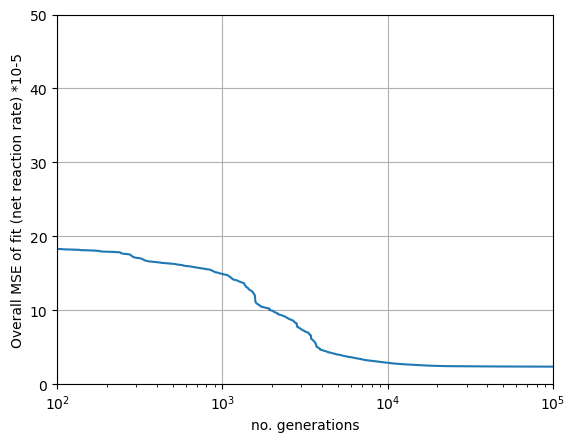

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.418742189142543
1.505082237099116
0.7944861988631031
-4.193113990351166
0.48423064836505586
8.466392585475973e-08
0.4035508750640279
-3.6987332032160167
0.20170003956141555
4.04137781616883
3.023808987086126
3.199073698797439
0.5191610273840027
0.02592843936823303
2.86137485309881
2.6385877871912756e-08
0.3405993755466988
-10.734604819550228
1.6745625182567578
1.4237313362841575
-9.684802092256659
0.9786036913076991
3.3481227001001277
0.026292808419992632
3.392643360730671
4.408468848120601
1.9519045712925607
10.380270818979456
-4.429889883660741
2.5083559348299356
4.905130912664052
2.291525890248305
-4.423408899078217
0.5845578301749623
1.0941088503618674
-1.301029996142474


In [37]:
res.X

array([-1.14187422e+01,  1.50508224e+00,  7.94486199e-01, -4.19311399e+00,
        4.84230648e-01,  8.46639259e-08,  4.03550875e-01, -3.69873320e+00,
        2.01700040e-01,  4.04137782e+00,  3.02380899e+00,  3.19907370e+00,
        5.19161027e-01,  2.59284394e-02,  2.86137485e+00,  2.63858779e-08,
        3.40599376e-01, -1.07346048e+01,  1.67456252e+00,  1.42373134e+00,
       -9.68480209e+00,  9.78603691e-01,  3.34812270e+00,  2.62928084e-02,
        3.39264336e+00,  4.40846885e+00,  1.95190457e+00,  1.03802708e+01,
       -4.42988988e+00,  2.50835593e+00,  4.90513091e+00,  2.29152589e+00,
       -4.42340890e+00,  5.84557830e-01,  1.09410885e+00, -1.30103000e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin
#logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.418742189142543
1.6: 1.505082237099116
0.9: 0.7944861988631031
-4.3: -4.193113990351166
0.5: 0.48423064836505586
0.003: 8.466392585475973e-08
0.4: 0.4035508750640279
-7.9: -3.6987332032160167
0.7: 0.20170003956141555
7.2: 4.04137781616883
5.7: 3.023808987086126
5.7: 3.199073698797439
0.8: 0.5191610273840027
0.03: 0.02592843936823303
3.1: 2.86137485309881
6.000000000000001e-09: 2.6385877871912756e-08
0.1: 0.3405993755466988
-12.0: -10.734604819550228
1.9: 1.6745625182567578
1.6: 1.4237313362841575
-11.6: -9.684802092256659
1.2: 0.9786036913076991
4.0: 3.3481227001001277
0.01: 0.026292808419992632
4.2: 3.392643360730671
5.4: 4.408468848120601
2.2: 1.9519045712925607
11.8: 10.380270818979456
-12.0: -4.429889883660741
3.3: 2.5083559348299356
1.8: 4.905130912664052
4.2: 2.291525890248305
-4.0: -4.423408899078217
0.5: 0.5845578301749623
1.0: 1.0941088503618674
coeff fit: 0.8820621814257138
r: 0.9391816551795046


In [1]:
# Use stored solution
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

# import numpy as np
# logkr=np.log10(kr)

# logkr=np.ndarray.tolist(logkr)
#del logkr[-1]

y_mean = np.mean(logkr)

# average of log kr of 3 seeds
krseed1 = [-1.14187422e+01,  1.50508224e+00,  7.94486199e-01, -4.19311399e+00,
        4.84230648e-01,  8.46639259e-08,  4.03550875e-01, -3.69873320e+00,
        2.01700040e-01,  4.04137782e+00,  3.02380899e+00,  3.19907370e+00,
        5.19161027e-01,  2.59284394e-02,  2.86137485e+00,  2.63858779e-08,
        3.40599376e-01, -1.07346048e+01,  1.67456252e+00,  1.42373134e+00,
       -9.68480209e+00,  9.78603691e-01,  3.34812270e+00,  2.62928084e-02,
        3.39264336e+00,  4.40846885e+00,  1.95190457e+00,  1.03802708e+01,
       -4.42988988e+00,  2.50835593e+00,  4.90513091e+00,  2.29152589e+00,
       -4.42340890e+00,  5.84557830e-01,  1.09410885e+00, -1.30103000e+00]
#np.ndarray.tolist(res.X)
krseed10 = [-9.04351296e+00,  1.12875077e+00,  5.00736388e-01, -4.18643893e+00,
        4.81868654e-01,  1.19630597e-06,  4.04165423e-01, -7.19065684e+00,
        6.17246636e-01,  6.65081433e+00,  5.19442860e+00,  5.26296383e+00,
        6.88738250e-01,  3.53847787e-02,  3.16807264e+00,  1.94719829e-02,
        2.65487545e-01, -1.19999912e+01,  1.89591392e+00,  1.60528376e+00,
       -1.19984190e+01,  1.23969097e+00,  4.16440288e+00,  6.07095094e-02,
        4.32486634e+00,  4.60542232e+00,  1.06451892e+00,  7.32747889e+00,
       -6.68995654e+00,  4.09818066e+00,  7.76081294e+00,  3.71970248e+00,
       -4.62529361e+00,  6.20843177e-01,  1.17775189e+00, -1.30103000e+00]
krseed101 = [-1.09184854e+01,  1.42661149e+00,  7.53180788e-01, -4.18405720e+00,
        4.81873034e-01,  2.59934082e-08,  4.01962180e-01, -4.26102004e+00,
        2.70934917e-01,  4.43594311e+00,  3.32653815e+00,  3.48863449e+00,
        5.53865356e-01,  2.96183746e-02,  2.99650392e+00,  1.64140841e-08,
        4.04217819e-01, -1.17532285e+01,  1.85278675e+00,  1.56593510e+00,
       -1.16994989e+01,  1.20225176e+00,  3.95628936e+00,  6.84424120e-02,
        4.16633162e+00,  4.92431948e+00,  1.52782978e+00,  9.16202794e+00,
       -1.72825983e+00,  2.82988492e+00,  7.58055946e+00,  2.15088494e+00,
       -7.96162058e+00,  1.23012260e+00,  1.55518764e+00, -1.30103000e+00]

krs = np.array([ krseed1, krseed10, krseed101])

meankr=np.average(krs, axis=0)

meankr=np.ndarray.tolist(meankr)
del meankr[-1]

# R2 of fitting actual logkr =  modeled logkr

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,meankr):
    #print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

for i in range(len (meankr)):
    print (meankr[i])

coeff fit: 0.8839935805069048
r: 0.9402093280258949
-10.460246853333333
1.3534815
0.682801125
-4.187870039999999
0.48265744533333327
4.3565443469999994e-07
0.40322615933333333
-5.050136693333333
0.36329386433333327
5.042711753333333
3.848258580000001
3.9835573399999995
0.5872548776666667
0.030310530899999997
3.0086504699999996
0.006490675233320666
0.33676824666666666
-11.4959415
1.8077543966666667
1.5316500666666666
-11.127573329999999
1.1401821403333334
3.8229383133333332
0.05181490993333334
3.96128044
4.646070216666668
1.51475109
8.956592543333334
-4.282702083333334
3.145473836666666
6.748834436666667
2.7207044366666664
-5.670107696666666
0.8118412023333333
1.2756827933333332


In [2]:
meankr

[-10.460246853333333,
 1.3534815,
 0.682801125,
 -4.187870039999999,
 0.48265744533333327,
 4.3565443469999994e-07,
 0.40322615933333333,
 -5.050136693333333,
 0.36329386433333327,
 5.042711753333333,
 3.848258580000001,
 3.9835573399999995,
 0.5872548776666667,
 0.030310530899999997,
 3.0086504699999996,
 0.006490675233320666,
 0.33676824666666666,
 -11.4959415,
 1.8077543966666667,
 1.5316500666666666,
 -11.127573329999999,
 1.1401821403333334,
 3.8229383133333332,
 0.05181490993333334,
 3.96128044,
 4.646070216666668,
 1.51475109,
 8.956592543333334,
 -4.282702083333334,
 3.145473836666666,
 6.748834436666667,
 2.7207044366666664,
 -5.670107696666666,
 0.8118412023333333,
 1.2756827933333332]

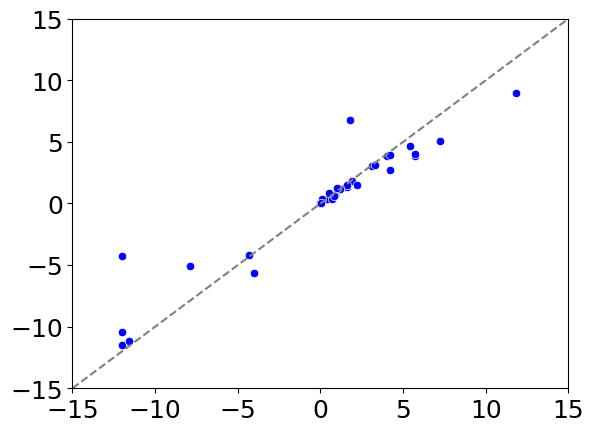

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot using Seaborn
sns.scatterplot(x=logkr, y= meankr, color='blue') #, label='Data Points')

# Add labels and title
#plt.xlabel('True parameter values (log10)')
#plt.ylabel('Fitted parameter values (log10)')

plt.xlim([-15, 15])
plt.ylim([-15, 15])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18) 

# Add a diagonal line
plt.plot([-15, 15], [-15, 15], color='grey', linestyle='--', label='Diagonal Line')


# Display the plot
plt.show()
